# Classical ML on OCD classification

## Import Required Modules

In [1]:
%load_ext autoreload
%autoreload 2

## Import System tools

In [2]:
import os
import sys
import gc
import cProfile
import warnings

In [3]:
current_dir = os.getcwd()
helpers = os.path.join(current_dir, "helpers")
sys.path.insert(0,helpers)

## Importing libraries

In [4]:
from enum import Enum, IntEnum
import itertools
from collections import Counter
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as markers
import seaborn as sns
import json
import pickle
from tabulate import tabulate
from logger import logger
import directory_manager as dm
import object_manager as om
import data_structures as ds
import df_manager as dfm
from data_model import Metrics, CSVHeader,HandWashingType
import plotter
import sampler

2023-08-25 22:34:01 - INFO - Logger Created.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, matthews_corrcoef,average_precision_score
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours, ClusterCentroids
from imblearn.combine import SMOTETomek, SMOTEENN

In [6]:
import plotly.graph_objects as go; import numpy as np
from plotly_resampler import FigureResampler, FigureWidgetResampler

## Setup

In [7]:
warnings.filterwarnings("ignore")

In [8]:
dm.generate_name("")

'2023-08-25_22-34-02'

In [9]:
logger.info("Running Notebook.")

2023-08-25 22:34:02 - INFO - Running Notebook.


## Global Variables

In [10]:
WINDOW_TIME = 3 # Seconds
FREQUENCY = 50 # 50Hz
WINDOW_SIZE = WINDOW_TIME*FREQUENCY
DIR = "/data/OCDetect_Export"
DROP_STATS = ["count"] # Stats to drop
IGNORE_LIST = [val for val in range(1,7)] # Ignore types
LABELS = ['Others','Routine HW', 'Compulsive HW']

### Data

In [267]:
data_folder ="OCDetect_Export"  #'stats'#"OCDetect_Export"
csv_files = dm.get_files_names(dm.get_data_dir(data_folder))
grouped_csv_files = ds.group_by_subjects(csv_files)

In [268]:
df = dfm.read_csv_file(csv_files[3])

In [252]:
files = []

for f in csv_files:
    r = f.replace("-stats","")
    df = dfm.read_csv_file(r)
    if(df.iloc[:,].isna().any().any()):
        print(f)
        files.append(f)

OCDetect_01_recording_12_dc492416-b349-49a2-8454-9b5c30c8a49c-stats.csv
OCDetect_18_recording_31_83905f68-e878-450b-ac0f-0bda5146a180-stats.csv
OCDetect_13_recording_08_f3c3493c-907e-4c1a-9a21-ffcfaf0f90d0-stats.csv
OCDetect_11_recording_15_b84f0f7a-46a9-4206-8daf-31da0126426f-stats.csv
OCDetect_19_recording_02_a1991b9b-7311-44af-a7d9-efb4265447be-stats.csv
OCDetect_19_recording_29_c9aea3a1-cbcc-455d-9eb7-8e38297ec26d-stats.csv
OCDetect_10_recording_29_a47259a6-2ef0-49a4-a9d7-1e67334ee8ef-stats.csv
OCDetect_15_recording_14_7795e4d0-38d0-4399-a0ca-ab10081cfa36-stats.csv
OCDetect_07_recording_13_e0947907-2924-4a4e-abaa-7d40a4188be9-stats.csv
OCDetect_30_recording_12_06d3290e-5fa8-4f5f-86f5-dd3ad7640815-stats.csv
OCDetect_20_recording_25_7f6e61f9-cf55-4794-a7ce-c72c6014a60f-stats.csv
OCDetect_18_recording_40_9ff3bede-c477-43e6-96ec-7997fa106f92-stats.csv
OCDetect_03_recording_25_1c6a2d99-4e4d-467e-b20e-5168b8257f11-stats.csv
OCDetect_03_recording_24_f7d02f54-52c4-4563-bb91-e1931576a213-st

2023-08-26 01:39:20 - ERROR - Error: File 'OCDetect_19_recording_21_b8b09506-ac28-470f-be7d-8892ecc90c7e.csv' is corrupted or has parsing issues.


OCDetect_15_recording_18_c074e940-abb4-40df-83b7-84d4e8b14bdf-stats.csv
OCDetect_19_recording_22_25eab037-bd87-4c34-b9bc-eb42acb562ce-stats.csv
OCDetect_11_recording_44_4793e56c-e9cb-49f6-a791-5f25c9e74b27-stats.csv
OCDetect_18_recording_39_d413cbbe-abb8-4c69-9ab8-aa9878578af4-stats.csv
OCDetect_27_recording_02_bafa27df-b207-4f63-a330-13a7e23cb47a-stats.csv
OCDetect_22_recording_08_59db29c1-05dc-4794-9b54-4b441a94a87b-stats.csv
OCDetect_01_recording_13_632d7391-7cb5-4b4f-ba4f-8bc1f62ce55c-stats.csv
OCDetect_11_recording_17_a26bbd8e-b780-43fa-8c46-e8f38e0f9bca-stats.csv
OCDetect_05_recording_40_20022d53-5ea3-4c3e-aa75-1f7878e0d823-stats.csv
OCDetect_09_recording_17_198b9e5d-0a51-4ec1-9060-e58633292f64-stats.csv
OCDetect_05_recording_14_cda9f6d0-12a2-4f90-b16b-a7b837ef5b7e-stats.csv
OCDetect_20_recording_29_d5b6776c-3b26-42c6-ad26-3c4f02ea90c6-stats.csv
OCDetect_05_recording_35_3fddf7c9-e986-4784-ac2a-9a434f3815bc-stats.csv
OCDetect_19_recording_10_86019cfe-2916-4f0b-88c3-0bc6eb7a3119-st

KeyboardInterrupt: 

In [ ]:
for f in files:
    d = df.read_csv_file()
    d[d.isna().any(1)==True].iloc[:,11:18]

In [155]:
r = grouped_csv_files['20'][5]
r

'OCDetect_20_recording_05_c8c2e43f-39fd-4457-923f-da1f27252f1a-stats.csv'

In [166]:
files = []

for f in csv_files:
    r = f.split("-")[0]+".csv"
    df = dfm.read_csv_file(r)
    if(df.isna().any().any()):
        print(f)
        files.append(f)

OCDetect_20_recording_34_8e76d136-2dff-4bd0-8fd2-efeda14b01db-stats.csv
OCDetect_05_recording_32_f9457973-3f92-445b-a633-9522a80402f7-stats.csv
OCDetect_21_recording_17_240b84a9-b884-4142-a4d3-b455ca2d168b-stats.csv
OCDetect_01_recording_41_1ee46709-81f8-4b02-b06a-aa82012d9399-stats.csv
OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40-stats.csv
OCDetect_13_recording_06_6624046e-3946-4253-90d5-acd985e56a22-stats.csv


In [258]:
s = "OCDetect_05_recording_32_f9457973-3f92-445b-a633-9522a80402f7.csv"

In [259]:
d = dfm.read_csv_file(s,chunksize=150)

In [260]:
for x in d:
    print(len(x))

150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
102


In [229]:
for chunk in d:
    if chunk.isna().any().any():
        print(chunk.iloc[:,12:18])

    acc x_std  acc y_std  acc z_std  gyro x_std  gyro y_std  gyro z_std
0    1.428959   0.702003   0.524241    0.526695    0.803377    0.405701
1    0.125721   0.172197   0.130667    0.083204    0.064282    0.052612
2    1.106594   0.860843   0.507224    0.483310    0.462066    0.246736
3    1.131472   2.366051   1.940337    0.821912    0.577694    0.990490
4    0.698703   1.676427   1.720010    0.218025    0.120517    0.140885
5    0.225747   0.386195   0.427474    0.308527    0.063128    0.117987
6    0.250625   0.489291   0.480447    0.400003    0.114984    0.199049
7    2.006782   4.686101   5.967651    2.258861    0.749985    0.803069
8    0.148620   0.710188   0.242300    0.178945    0.099651    0.067944
9    2.218062   4.049801   7.651350    1.888885    0.435220    0.664618
10   1.811529   2.454992   1.959664    1.390192    0.850941    0.810081
11   0.968012   1.872119   2.233173    0.867146    0.210538    0.287415
12   0.616523   1.192680   3.346859    1.952327    0.802557    0

In [248]:
d[d.isna().any(1)==True].iloc[:,11:18]

gyro z_mean  acc x_std  acc y_std  acc z_std  gyro x_std  gyro y_std  \
4492     0.020769        NaN        NaN        NaN         NaN         NaN   

      gyro z_std  
4492         NaN

In [250]:
d.isna().any(1)

0        False
1        False
2        False
3        False
4        False
         ...  
13625    False
13626    False
13627    False
13628    False
13629    False
Length: 13630, dtype: bool

In [141]:
df.iloc[:,2:7].isna().any()

acc x     False
acc y     False
acc z     False
gyro x    False
gyro y    False
dtype: bool

In [142]:
fig = FigureWidgetResampler(go.Figure())

In [148]:
rHW = df[(df['relabeled']==1) | (df['user yes/no']==1)]
rHW_timestmap = rHW["datetime"]
labels = rHW[rHW['user yes/no']==0].iloc[:,0]

In [149]:
rHW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    0 non-null      float64
 1   datetime     0 non-null      object 
 2   acc x        0 non-null      float64
 3   acc y        0 non-null      float64
 4   acc z        0 non-null      float64
 5   gyro x       0 non-null      float64
 6   gyro y       0 non-null      float64
 7   gyro z       0 non-null      float64
 8   user yes/no  0 non-null      float64
 9   compulsive   0 non-null      float64
 10  urge         0 non-null      float64
 11  tense        0 non-null      float64
 12  ignore       0 non-null      int64  
 13  relabeled    0 non-null      int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 0.0+ bytes


In [123]:
rHW['compulsive'].isna().all()

True

In [113]:
rHW['user yes/no'].isna().all()

True

In [150]:
rHW.head()

Empty DataFrame
Columns: [timestamp, datetime, acc x, acc y, acc z, gyro x, gyro y, gyro z, user yes/no, compulsive, urge, tense, ignore, relabeled]
Index: []

In [114]:
cHW[cHW['user yes/no']==1]

Empty DataFrame
Columns: [timestamp, datetime, acc x, acc y, acc z, gyro x, gyro y, gyro z, user yes/no, compulsive, urge, tense, ignore, relabeled]
Index: []

In [49]:
cHW.head()

timestamp                 datetime     acc x     acc y     acc z  \
214609  4.292180e+12  2022-02-13 16:20:51.180  1.640588 -9.299861 -2.335144   
214610  4.292200e+12  2022-02-13 16:20:51.200  1.506467 -9.568104 -2.282454   
214611  4.292220e+12  2022-02-13 16:20:51.220  1.647774 -9.817185 -2.306404   
214612  4.292240e+12  2022-02-13 16:20:51.240  1.781895 -9.762100 -2.572251   
214613  4.292260e+12  2022-02-13 16:20:51.260  1.880090 -9.362132 -2.663262   

          gyro x    gyro y    gyro z  user yes/no  compulsive  urge  tense  \
214609  0.127060 -0.042761 -0.023213          NaN         NaN   NaN    NaN   
214610  0.069639 -0.019548 -0.014661          NaN         NaN   NaN    NaN   
214611  0.045204  0.020769  0.000000          NaN         NaN   NaN    NaN   
214612  0.013439  0.064752  0.020769          NaN         NaN   NaN    NaN   
214613 -0.036652  0.072082  0.036652          NaN         NaN   NaN    NaN   

        ignore  relabeled  
214609       0          1  
214610       0          1  
214611       0          1  
214612       0          1  
214613       0          1

AttributeError: 'Axes' object has no attribute 'lineplot'

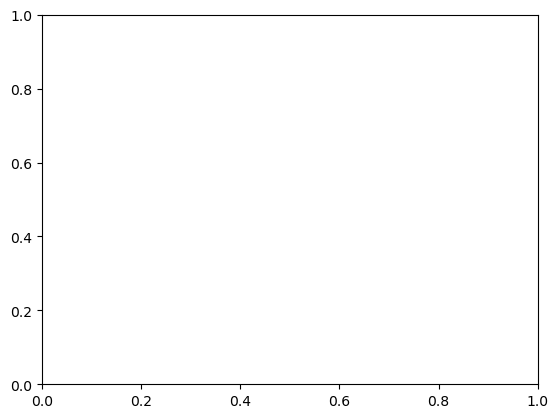

In [262]:
ax = sns.lineplot(data=rHW, x="timestamp", y="acc x")
ax.lineplot(data=rHW, x="timestamp", y="acc y")
ax.lineplot(data=rHW, x="timestamp", y="acc z")
ax.axvline(data=labels, linewidth=2.5)

In [51]:
cHW["datetime"]

214609    2022-02-13 16:20:51.180
214610    2022-02-13 16:20:51.200
214611    2022-02-13 16:20:51.220
214612    2022-02-13 16:20:51.240
214613    2022-02-13 16:20:51.260
                   ...           
215204    2022-02-13 16:21:03.080
215205    2022-02-13 16:21:03.100
215206    2022-02-13 16:21:03.120
215207    2022-02-13 16:21:03.140
215208    2022-02-13 16:21:03.160
Name: datetime, Length: 600, dtype: object

In [52]:
# Clear
fig.data = []

In [54]:
fig.add_trace(go.Scattergl(name='acc x', showlegend=True), hf_x=cHW_timestmap, hf_y=cHW.iloc[:,2])
fig.add_trace(go.Scattergl(name='acc y', showlegend=True), hf_x=cHW_timestmap, hf_y=cHW.iloc[:,3])
fig.add_trace(go.Scattergl(name='acc z', showlegend=True), hf_x=cHW_timestmap, hf_y=cHW.iloc[:,4])
fig.add_trace(go.line(x=labels, line_width=3, line_dash="dash", line_color="green"))

AttributeError: module 'plotly.graph_objects' has no attribute 'line'

### Feature to Select

In [11]:
features_sel = ['acc z_min', 'acc z_std', 'gyro x_25%', 'gyro x_75%', 
            'gyro x_max', 'gyro x_min', 'gyro x_std', 'gyro y_max', 
            'acc y_min', 'acc y_25%', 'acc y_mean', 'acc z_25%', 
            'gyro z_max', 'acc z_max', 'acc y_max']
features_sensor = ['acc x', 'acc y', 'acc z', 'gyro x', 'gyro y', 'gyro z']
features_acc = ['acc x', 'acc y', 'acc z']
features_gyro = ['gyro x', 'gyro y', 'gyro z']

# Features to be selected
features = features_sensor

### Assign Subjects for training and inference

In [12]:
# Subjects
subjects = ['02', '05', '25', '30', '20', '19', '04', '21', '03', '12', '01', '11', '29', '10', '09', '18', '13']
#subjects = ['02', '19', '12', '09','10']
subjects = sorted(subjects)

# Inference
inferences = ['07','22'] #['07', '27', '15', '24', '22']
inferences = sorted(inferences)

### Select classifier and normalization method

In [13]:
classifier = 'Perceptron'#'PassiveAggressiveClassifier'#"MultinomialNB" #"SGDClassifier"
norm_method = 'standard'

## Classical ML

**Supported classifiers:**
- logistic_regression
- random_forest 
- gradient_boosting
- svm 
- kmeans
- neuralnetwork
- SGDClassifier
- MultinominalNB
- PassiveAggressiveClassifier
- Perceptron

In [14]:
def get_model(name, **kwargs):
    if name == 'logistic_regression':
        model = LogisticRegression(**kwargs)
    elif name == 'random_forest':
        model = RandomForestClassifier(**kwargs)
    elif name == 'gradient_boosting':
        model = GradientBoostingClassifier(**kwargs)
    elif name == 'svm':
        model = SVC(**kwargs)
    elif name == 'kmeans':
        model = KMeans(n_clusters=3, **kwargs)
    elif name == 'neuralnetwork':
        model = MLPClassifier(**kwargs)
    elif name == 'SGDClassifier':
        model = SGDClassifier(**kwargs)
    elif name == 'MultinomialNB':
        model = MultinomialNB()
    elif name == 'PassiveAggressiveClassifier':
        model = PassiveAggressiveClassifier()
    elif name ==  'Perceptron':
        model = Perceptron()
    else:
        error = "Invalid classifier choice.\
        Supported classifiers: logistic_regression, random_forest, \
        gradient_boosting, svm, kmeans, neuralnetwork, MultinomialNB, PassiveAggressiveClassifier."
        logger.critical(error)
        raise ValueError(error)
    
    logger.info(f"ML model {name} initialized.")
    return model

### Evaluation functions

In [15]:
# Evaluates model for given csv filesdata_folder,True, norm_method, features
def evalute_model_for(model, filenames:list, data_folder:str, normalize=True, norm_method='standard', features=[]):
    # Dictionary to store results of all csv files
    metrics = {
    key: []
    for key in [
        Metrics.Accuracy.value,
        Metrics.Precision.value,
        Metrics.Recall.value,
        Metrics.F1.value,
        Metrics.Sample.value,
        #Metrics.ROC.value,
        #Metrics.ROC_PR.value, #Not supported multi-class
        #Metrics.MCC.value
    ]
    }

    # Dictionary to store weighted avergae metrics
    weighted_avg_metrics = {}
    
    #Loop over csv files of each subject
    for file in filenames:
        #Load data
        x_test, y_test = dfm.load_data(file, data_folder, normalize, norm_method,features, sampling=False)
        # Evaluate the classifier on the current chunk
        y_pred = model.predict(x_test)
        
        # Get evaluation metrics
        result = evaluate_metrics(y_test,y_pred)
        
        # Concat values
        metrics.update(result)
    
    
    # Calculate total number of samples
    total_samples = sum(metrics[Metrics.Sample.value])
    
    # Calculate the weighted average metrics
    
    for key, values in metrics.items():
        if key != Metrics.Sample.value:
            weighted_key_sum =  sum(val * count for val, count in zip(values, metrics[Metrics.Sample.value]))
            weighted_avg_metrics[key]= weighted_key_sum / total_samples
            
    return weighted_avg_metrics

# Function to evaluate metrics on given test, pred
def evaluate_metrics(y_test, y_pred, average='macro'):
    #Default Weighted Averaging for imbalanced dataset
    
    # Dict to store metrics
    metrics = {}
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)
    sample = len(y_test)
    #roc_auc = roc_auc_score(y_test, y_pred)
    #pr_auc = average_precision_score(y_test, y_pred, average=average)
    ##mcc = matthews_corrcoef(y_test, y_pred)
    
    # Store to dict as array
    metrics[Metrics.Accuracy.value] = [accuracy]
    metrics[Metrics.Precision.value] = [precision]
    metrics[Metrics.Recall.value] = [recall]
    metrics[Metrics.F1.value] = [f1]
    metrics[Metrics.Sample.value] = [sample]
    #metrics[Metrics.ROC.value] = [roc_auc]
    #metrics[Metrics.ROC_PR.value] = [pr_auc]
    #metrics[Metrics.MCC.value] = [mcc]
    
    return metrics

### Training Function

In [16]:
# Perform training of classifier
def train_model(classifier:str, subjects:list, data_folder:str, **kwargs):
    #start time
    startTime = datetime.now()
    logger.info(f"Training has started at {startTime}")

    
    if not subjects:
        logger.critical("Subjects cannot be empty.")
        raise ValueError("Subjects cannot be empty.")
    
    logger.info("==="*20)    
    logger.info("Training Phase Initialized.")
    logger.info(f"ML Algorithm:{classifier}")
    logger.info(f"Data Folder:{data_folder}")
    
    # Empty list to store results of each iterations
    results = []
    
    # Empty list to store selected features
    features  = []
    
    # Get features to consider otherwise emtpy
    if 'features' in kwargs:        
        features = kwargs['features']
        logger.info(f"Selected features as : {features}")
    
    if 'normalize' in kwargs:
        normalize = kwargs['normalize']
        logger.info(f"Normalization : {normalize}")
    
    # Default normalization method
    norm_method = 'standard'

    # Get normalization method 
    if 'norm_method' in kwargs:
        norm_method = kwargs['norm_method']
    
    logger.info(f"Selected Normalization method : {norm_method}")
                
    # folder to save models
    folder = dm.generate_name()
    logger.info(f"Models folder:{folder}")
    logger.info("==="*20)

    total_subjects = len(subjects)
    
    logger.info(f"Performing LOSO-CV on {total_subjects}.")
    # Perform LOSO-CV
    for index, test_subject in enumerate(subjects):
        logger.info("==="*20)
        logger.info(f"{index+1}/{total_subjects}. Leaving Subject {test_subject}:")
        # Initialize the selected classifier
        model = get_model(classifier)
        
        # Phase I: Training Phase
        
        # Get training subjects
        train_subjects = subjects.copy()
        train_subjects.remove(test_subject)
        logger.info("***"*20)
        logger.info("Phase I. Training:")
        # Loop over train subjects
        for idx, train_subject in enumerate(train_subjects):
            logger.info(f"{idx+1}/{total_subjects - 1}. Training on subject {train_subject}")
            
            #x_temp, y_temp = pd.DataFrame([]), pd.DataFrame([])
            subject_files = grouped_csv_files[train_subject]
            #Loop over csv files of each subject
            for index, train_file in enumerate(subject_files):
                logger.info(f"{index+1}/{len(subject_files)}. Working in file {train_file}.")
                #Load training data
                x_train, y_train = dfm.load_data(train_file, data_folder, normalize, norm_method,features)
                
                if len(x_train)>0:
                    # Train the classifier on the current csv file
                    model.partial_fit(x_train, y_train, classes=[0., 1., 2.])
                else:
                    logger.warning(f"Skipping training {train_file}. The file has not important data.")
            logger.info(f"Training complete on subjects:{train_subject}.")
        logger.info("***"*20)
        logger.info(f"Phase II: Testing subject:{test_subject}")
        
        # Phase II: Testing Phase
        weighted_avg_metrics = evalute_model_for(model, grouped_csv_files[test_subject],data_folder,normalize, norm_method, features)
        logger.info("***"*20)
        logger.info(f"{index}/{total_subjects}. Results:")
        for k, v in weighted_avg_metrics.items():
            logger.info(f"{k}:{v:.2f}")

        # Append metrics to result of one complete phase
        results.append({test_subject:weighted_avg_metrics})
        
        # Save model
        msg = om.save_object(model,f"models/{folder}", f"{test_subject}.pt")
        logger.info(msg)
        logger.info("***"*20)
    
    # Save whole result
    msg = om.save_object(results,f"models/{folder}", "results.pt")
    logger.info(msg)
    logger.info("==="*20)
    logger.info("Complete")
    
    # EndTime
    endTime = datetime.now()
    logger.info(f"Total time elapsed for training : {endTime - startTime}")
    
    return folder, results

In [17]:
folder, results = train_model(classifier, subjects, data_folder, 
                      features=features, normalize=True, norm_method=norm_method, 
                      random_state =25, n_estimators=200, max_depth=10)

2023-08-22 00:53:22 - INFO - Training has started at 2023-08-22 00:53:22.692260
2023-08-22 00:53:22 - INFO - ============================================================
2023-08-22 00:53:22 - INFO - Training Phase Initialized.
2023-08-22 00:53:22 - INFO - ML Algorithm:Perceptron
2023-08-22 00:53:22 - INFO - Data Folder:OCDetect_Export
2023-08-22 00:53:22 - INFO - Selected features as : ['acc x', 'acc y', 'acc z', 'gyro x', 'gyro y', 'gyro z']
2023-08-22 00:53:22 - INFO - Normalization : True
2023-08-22 00:53:22 - INFO - Selected Normalization method : standard
2023-08-22 00:53:22 - INFO - Models folder:2023-08-22_00-53-22
2023-08-22 00:53:22 - INFO - ============================================================
2023-08-22 00:53:22 - INFO - Performing LOSO-CV on 17.
2023-08-22 00:53:22 - INFO - ============================================================
2023-08-22 00:53:22 - INFO - 1/17. Leaving Subject 01:
2023-08-22 00:53:22 - INFO - ML model Perceptron initialized.
2023-08-22 00:53:2

2023-08-22 00:54:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388171, 1: 55604})
2023-08-22 00:54:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 35700})
2023-08-22 00:54:17 - INFO - ---------------
2023-08-22 00:54:17 - INFO - 12/35. Working in file OCDetect_02_recording_11_0d07466e-797e-4663-9779-f16bc2b9ce86.csv.
2023-08-22 00:54:17 - INFO - Loading CSV File: OCDetect_02_recording_11_0d07466e-797e-4663-9779-f16bc2b9ce86.csv from OCDetect_Export.
2023-08-22 00:54:18 - INFO - Original distribution: Counter({0: 893255, 1: 13307})
2023-08-22 00:54:18 - INFO - Class distribution after oversampling: Counter({0: 893255, 1: 43247})
2023-08-22 00:54:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 297751, 1: 43247})
2023-08-22 00:54:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 43247, 0: 31944})
2023-08-22 00:54:22 - INFO - ---------------
2023-08-22 00:54:22 - INFO - 13/35. Working in f

2023-08-22 00:55:41 - INFO - 24/35. Working in file OCDetect_02_recording_23_4c82aa1d-ed11-4d46-bde4-31f5b003ceab.csv.
2023-08-22 00:55:41 - INFO - Loading CSV File: OCDetect_02_recording_23_4c82aa1d-ed11-4d46-bde4-31f5b003ceab.csv from OCDetect_Export.
2023-08-22 00:55:44 - INFO - Original distribution: Counter({0: 1564174, 1: 20911})
2023-08-22 00:55:45 - INFO - Class distribution after oversampling: Counter({0: 1564174, 1: 67960})
2023-08-22 00:55:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 521391, 1: 67960})
2023-08-22 00:55:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 67960, 0: 50194})
2023-08-22 00:55:53 - INFO - ---------------
2023-08-22 00:55:53 - INFO - 25/35. Working in file OCDetect_02_recording_24_0c53f7b4-7aaa-4022-b3fb-acf7f523c30d.csv.
2023-08-22 00:55:53 - INFO - Loading CSV File: OCDetect_02_recording_24_0c53f7b4-7aaa-4022-b3fb-acf7f523c30d.csv from OCDetect_Export.
2023-08-22 00:55:55 - INFO - Original distribution

2023-08-22 00:56:57 - INFO - ---------------
2023-08-22 00:56:57 - INFO - 2/31. Working in file OCDetect_03_recording_01_922c33df-5363-49ec-890f-f9da9785cc76.csv.
2023-08-22 00:56:57 - INFO - Loading CSV File: OCDetect_03_recording_01_922c33df-5363-49ec-890f-f9da9785cc76.csv from OCDetect_Export.
2023-08-22 00:56:57 - INFO - ---------------
2023-08-22 00:56:57 - INFO - 3/31. Working in file OCDetect_03_recording_02_1e3760c3-ffc1-4ab3-ae03-9a0f1ae18f11.csv.
2023-08-22 00:56:57 - INFO - Loading CSV File: OCDetect_03_recording_02_1e3760c3-ffc1-4ab3-ae03-9a0f1ae18f11.csv from OCDetect_Export.
2023-08-22 00:56:57 - INFO - ---------------
2023-08-22 00:56:57 - INFO - 4/31. Working in file OCDetect_03_recording_03_43c50dfb-dded-4aa3-821b-1cd6df93b946.csv.
2023-08-22 00:56:57 - INFO - Loading CSV File: OCDetect_03_recording_03_43c50dfb-dded-4aa3-821b-1cd6df93b946.csv from OCDetect_Export.
2023-08-22 00:56:57 - INFO - ---------------
2023-08-22 00:56:57 - INFO - 5/31. Working in file OCDetect_0

2023-08-22 00:57:57 - INFO - 15/31. Working in file OCDetect_03_recording_14_d37d0b86-feef-47b4-8668-3bd6966fafb9.csv.
2023-08-22 00:57:57 - INFO - Loading CSV File: OCDetect_03_recording_14_d37d0b86-feef-47b4-8668-3bd6966fafb9.csv from OCDetect_Export.
2023-08-22 00:58:00 - INFO - Original distribution: Counter({0: 1122760, 1: 11406, 2: 5703})
2023-08-22 00:58:01 - INFO - Class distribution after oversampling: Counter({0: 1122760, 2: 14257, 1: 14257})
2023-08-22 00:58:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 374253, 1: 14257, 2: 14257})
2023-08-22 00:58:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 00:58:03 - INFO - ---------------
2023-08-22 00:58:03 - INFO - 16/31. Working in file OCDetect_03_recording_15_eabd4764-1914-430e-85a4-11fdc5e7d3e8.csv.
2023-08-22 00:58:03 - INFO - Loading CSV File: OCDetect_03_recording_15_eabd4764-1914-430e-85a4-11fdc5e7d3e8.csv from OCDetect_Export.
2023-08-22 

2023-08-22 00:58:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 00:58:52 - INFO - ---------------
2023-08-22 00:58:52 - INFO - 30/31. Working in file OCDetect_03_recording_29_85587ee0-c568-450b-ae4c-b0eb0ba04879.csv.
2023-08-22 00:58:52 - INFO - Loading CSV File: OCDetect_03_recording_29_85587ee0-c568-450b-ae4c-b0eb0ba04879.csv from OCDetect_Export.
2023-08-22 00:58:59 - INFO - Original distribution: Counter({0: 1546622, 2: 15208, 1: 5703})
2023-08-22 00:59:00 - INFO - Class distribution after oversampling: Counter({0: 1546622, 2: 19010, 1: 19010})
2023-08-22 00:59:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 515540, 1: 19010, 2: 19010})
2023-08-22 00:59:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 19010, 1: 19010, 2: 19010})
2023-08-22 00:59:03 - INFO - ---------------
2023-08-22 00:59:03 - INFO - 31/31. Working in file OCDetect_03_recording_30_6d10b041-a391-4249-9cf0-8

2023-08-22 01:00:04 - INFO - ---------------
2023-08-22 01:00:04 - INFO - 11/42. Working in file OCDetect_04_recording_10_d1c9723d-7ca1-4636-aece-43bdec1eda60.csv.
2023-08-22 01:00:04 - INFO - Loading CSV File: OCDetect_04_recording_10_d1c9723d-7ca1-4636-aece-43bdec1eda60.csv from OCDetect_Export.
2023-08-22 01:00:04 - INFO - Original distribution: Counter({0: 1490, 2: 170})
2023-08-22 01:00:04 - INFO - Class distribution after oversampling: Counter({0: 1490, 2: 552})
2023-08-22 01:00:04 - INFO - Class distribution after RandomUnderSampler: Counter({2: 552, 0: 496})
2023-08-22 01:00:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 496, 2: 81})
2023-08-22 01:00:05 - INFO - ---------------
2023-08-22 01:00:05 - INFO - 12/42. Working in file OCDetect_04_recording_11_62f2a681-613e-49d8-8f50-b9ef00988d5f.csv.
2023-08-22 01:00:05 - INFO - Loading CSV File: OCDetect_04_recording_11_62f2a681-613e-49d8-8f50-b9ef00988d5f.csv from OCDetect_Export.
2023-08-22 01:00:08 - INF

2023-08-22 01:01:10 - INFO - Original distribution: Counter({0: 295495, 2: 5703})
2023-08-22 01:01:11 - INFO - Class distribution after oversampling: Counter({0: 295495, 2: 18534})
2023-08-22 01:01:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 98498, 2: 18534})
2023-08-22 01:01:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 10382})
2023-08-22 01:01:12 - INFO - ---------------
2023-08-22 01:01:12 - INFO - 24/42. Working in file OCDetect_04_recording_23_a154efcf-6708-478c-a1b2-bbbb99bd3cdc.csv.
2023-08-22 01:01:12 - INFO - Loading CSV File: OCDetect_04_recording_23_a154efcf-6708-478c-a1b2-bbbb99bd3cdc.csv from OCDetect_Export.
2023-08-22 01:01:13 - INFO - Original distribution: Counter({0: 579168, 2: 7604})
2023-08-22 01:01:13 - INFO - Class distribution after oversampling: Counter({0: 579168, 2: 24713})
2023-08-22 01:01:13 - INFO - Class distribution after RandomUnderSampler: Counter({0: 193056, 2: 24713})
2023-08-22 01:01:15 - 

2023-08-22 01:01:48 - INFO - ---------------
2023-08-22 01:01:48 - INFO - 40/42. Working in file OCDetect_04_recording_39_692ec20d-d7f9-4d51-9827-10b93eb2a8bb.csv.
2023-08-22 01:01:48 - INFO - Loading CSV File: OCDetect_04_recording_39_692ec20d-d7f9-4d51-9827-10b93eb2a8bb.csv from OCDetect_Export.
2023-08-22 01:01:48 - INFO - ---------------
2023-08-22 01:01:48 - INFO - 41/42. Working in file OCDetect_04_recording_40_2f3bd516-c622-4d65-8524-16542d1043f5.csv.
2023-08-22 01:01:48 - INFO - Loading CSV File: OCDetect_04_recording_40_2f3bd516-c622-4d65-8524-16542d1043f5.csv from OCDetect_Export.
2023-08-22 01:01:48 - INFO - ---------------
2023-08-22 01:01:48 - INFO - 42/42. Working in file OCDetect_04_recording_41_7f15a6af-8cee-49ba-b417-344cefca449e.csv.
2023-08-22 01:01:48 - INFO - Loading CSV File: OCDetect_04_recording_41_7f15a6af-8cee-49ba-b417-344cefca449e.csv from OCDetect_Export.
2023-08-22 01:01:48 - INFO - Original distribution: Counter({1: 1725, 0: 1194})
2023-08-22 01:01:48 - I

2023-08-22 01:03:08 - INFO - Class distribution after oversampling: Counter({0: 120178, 1: 6178})
2023-08-22 01:03:08 - INFO - Class distribution after RandomUnderSampler: Counter({0: 40059, 1: 6178})
2023-08-22 01:03:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 4035})
2023-08-22 01:03:08 - INFO - ---------------
2023-08-22 01:03:08 - INFO - 13/47. Working in file OCDetect_05_recording_12_48fe22b2-bdf3-4d39-9309-55e1d37b40f5.csv.
2023-08-22 01:03:08 - INFO - Loading CSV File: OCDetect_05_recording_12_48fe22b2-bdf3-4d39-9309-55e1d37b40f5.csv from OCDetect_Export.
2023-08-22 01:03:10 - INFO - Original distribution: Counter({0: 375399, 1: 11406})
2023-08-22 01:03:11 - INFO - Class distribution after oversampling: Counter({0: 375399, 1: 37069})
2023-08-22 01:03:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 125133, 1: 37069})
2023-08-22 01:03:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37069, 0: 18455})

2023-08-22 01:04:08 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388430, 1: 68341})
2023-08-22 01:04:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 68341, 0: 52232})
2023-08-22 01:04:15 - INFO - ---------------
2023-08-22 01:04:15 - INFO - 27/47. Working in file OCDetect_05_recording_26_b750dab0-55bc-4089-9f9e-12e6e9cd4f0a.csv.
2023-08-22 01:04:15 - INFO - Loading CSV File: OCDetect_05_recording_26_b750dab0-55bc-4089-9f9e-12e6e9cd4f0a.csv from OCDetect_Export.
2023-08-22 01:04:17 - INFO - Original distribution: Counter({0: 1740400, 1: 22812})
2023-08-22 01:04:18 - INFO - Class distribution after oversampling: Counter({0: 1740400, 1: 74139})
2023-08-22 01:04:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 580133, 1: 74139})
2023-08-22 01:04:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 74139, 0: 63545})
2023-08-22 01:04:26 - INFO - ---------------
2023-08-22 01:04:26 - INFO - 28/47. Working in

2023-08-22 01:06:09 - INFO - Class distribution after oversampling: Counter({0: 1854792, 1: 63895})
2023-08-22 01:06:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 618264, 1: 63895})
2023-08-22 01:06:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 63895, 0: 50555})
2023-08-22 01:06:17 - INFO - ---------------
2023-08-22 01:06:17 - INFO - 39/47. Working in file OCDetect_05_recording_38_9e31b67f-d37e-470e-87fd-12bdaeff492f.csv.
2023-08-22 01:06:17 - INFO - Loading CSV File: OCDetect_05_recording_38_9e31b67f-d37e-470e-87fd-12bdaeff492f.csv from OCDetect_Export.
2023-08-22 01:06:18 - INFO - Original distribution: Counter({0: 801840, 1: 10155})
2023-08-22 01:06:19 - INFO - Class distribution after oversampling: Counter({0: 801840, 1: 33003})
2023-08-22 01:06:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 267280, 1: 33003})
2023-08-22 01:06:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33003, 0: 2

2023-08-22 01:07:24 - INFO - ---------------
2023-08-22 01:07:24 - INFO - 6/31. Working in file OCDetect_09_recording_05_040124c2-51d8-41a6-831b-6508c616619d.csv.
2023-08-22 01:07:24 - INFO - Loading CSV File: OCDetect_09_recording_05_040124c2-51d8-41a6-831b-6508c616619d.csv from OCDetect_Export.
2023-08-22 01:07:29 - INFO - Original distribution: Counter({0: 638628, 1: 2679})
2023-08-22 01:07:29 - INFO - Class distribution after oversampling: Counter({0: 638628, 1: 8706})
2023-08-22 01:07:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 212876, 1: 8706})
2023-08-22 01:07:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 8706, 0: 6579})
2023-08-22 01:07:30 - INFO - ---------------
2023-08-22 01:07:30 - INFO - 7/31. Working in file OCDetect_09_recording_06_7417f8c8-1b76-4609-9767-d698196daac1.csv.
2023-08-22 01:07:30 - INFO - Loading CSV File: OCDetect_09_recording_06_7417f8c8-1b76-4609-9767-d698196daac1.csv from OCDetect_Export.
2023-08-22 01:

2023-08-22 01:08:36 - INFO - ---------------
2023-08-22 01:08:36 - INFO - 20/31. Working in file OCDetect_09_recording_19_cec2f783-3877-4cac-a485-e114357ab17a.csv.
2023-08-22 01:08:36 - INFO - Loading CSV File: OCDetect_09_recording_19_cec2f783-3877-4cac-a485-e114357ab17a.csv from OCDetect_Export.
2023-08-22 01:08:42 - INFO - Original distribution: Counter({0: 655092, 1: 8708})
2023-08-22 01:08:42 - INFO - Class distribution after oversampling: Counter({0: 655092, 1: 28301})
2023-08-22 01:08:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 218364, 1: 28301})
2023-08-22 01:08:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 28301, 0: 19111})
2023-08-22 01:08:45 - INFO - ---------------
2023-08-22 01:08:45 - INFO - 21/31. Working in file OCDetect_09_recording_20_0eecdb10-f5ad-43a7-9e08-64515358d815.csv.
2023-08-22 01:08:45 - INFO - Loading CSV File: OCDetect_09_recording_20_0eecdb10-f5ad-43a7-9e08-64515358d815.csv from OCDetect_Export.
2023-08-

2023-08-22 01:09:14 - INFO - Loading CSV File: OCDetect_10_recording_08_d84d042d-7df9-4dc9-add4-b8a851c6216b.csv from OCDetect_Export.
2023-08-22 01:09:14 - INFO - ---------------
2023-08-22 01:09:14 - INFO - 10/30. Working in file OCDetect_10_recording_09_6f527228-9f28-4f52-b682-fedcf5238bd6.csv.
2023-08-22 01:09:14 - INFO - Loading CSV File: OCDetect_10_recording_09_6f527228-9f28-4f52-b682-fedcf5238bd6.csv from OCDetect_Export.
2023-08-22 01:09:16 - INFO - ---------------
2023-08-22 01:09:16 - INFO - 11/30. Working in file OCDetect_10_recording_10_faa4bd30-652d-47d9-96d8-863ee910a66c.csv.
2023-08-22 01:09:16 - INFO - Loading CSV File: OCDetect_10_recording_10_faa4bd30-652d-47d9-96d8-863ee910a66c.csv from OCDetect_Export.
2023-08-22 01:09:17 - INFO - ---------------
2023-08-22 01:09:17 - INFO - 12/30. Working in file OCDetect_10_recording_11_d2173518-bc6f-4787-b0c7-abb28a74ae37.csv.
2023-08-22 01:09:17 - INFO - Loading CSV File: OCDetect_10_recording_11_d2173518-bc6f-4787-b0c7-abb28a7

2023-08-22 01:09:49 - INFO - Loading CSV File: OCDetect_10_recording_29_a47259a6-2ef0-49a4-a9d7-1e67334ee8ef.csv from OCDetect_Export.
2023-08-22 01:09:49 - INFO - ---------------
2023-08-22 01:09:49 - INFO - Training complete on subjects:10.
2023-08-22 01:09:49 - INFO - 7/16. Training on subject 11
2023-08-22 01:09:49 - INFO - 1/46. Working in file OCDetect_11_recording_00_0db65a4b-75ac-4534-bd5b-bfd8890c61e1.csv.
2023-08-22 01:09:49 - INFO - Loading CSV File: OCDetect_11_recording_00_0db65a4b-75ac-4534-bd5b-bfd8890c61e1.csv from OCDetect_Export.
2023-08-22 01:09:49 - INFO - ---------------
2023-08-22 01:09:49 - INFO - 2/46. Working in file OCDetect_11_recording_01_ed0af0b4-17c7-47e6-a105-17ca69023b0d.csv.
2023-08-22 01:09:49 - INFO - Loading CSV File: OCDetect_11_recording_01_ed0af0b4-17c7-47e6-a105-17ca69023b0d.csv from OCDetect_Export.
2023-08-22 01:09:49 - INFO - ---------------
2023-08-22 01:09:49 - INFO - 3/46. Working in file OCDetect_11_recording_02_27cf102a-a45b-4777-934e-772

2023-08-22 01:10:16 - INFO - 19/46. Working in file OCDetect_11_recording_18_fb3d71e7-dae1-4eb8-9466-8a27fedf4dc7.csv.
2023-08-22 01:10:16 - INFO - Loading CSV File: OCDetect_11_recording_18_fb3d71e7-dae1-4eb8-9466-8a27fedf4dc7.csv from OCDetect_Export.
2023-08-22 01:10:16 - INFO - ---------------
2023-08-22 01:10:16 - INFO - 20/46. Working in file OCDetect_11_recording_19_9b0bf6ee-ca77-43b0-ba0d-da2d46c0858c.csv.
2023-08-22 01:10:16 - INFO - Loading CSV File: OCDetect_11_recording_19_9b0bf6ee-ca77-43b0-ba0d-da2d46c0858c.csv from OCDetect_Export.
2023-08-22 01:10:16 - INFO - ---------------
2023-08-22 01:10:16 - INFO - 21/46. Working in file OCDetect_11_recording_20_7ed923dd-c38a-4075-b1a6-b08ce08def8c.csv.
2023-08-22 01:10:16 - INFO - Loading CSV File: OCDetect_11_recording_20_7ed923dd-c38a-4075-b1a6-b08ce08def8c.csv from OCDetect_Export.
2023-08-22 01:10:20 - INFO - Original distribution: Counter({0: 1723408, 1: 11406, 2: 1901})
2023-08-22 01:10:20 - INFO - Class distribution after o

2023-08-22 01:11:24 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 01:11:24 - INFO - ---------------
2023-08-22 01:11:24 - INFO - 33/46. Working in file OCDetect_11_recording_32_50bddc2e-dd44-478a-89b9-b2368d8f90de.csv.
2023-08-22 01:11:24 - INFO - Loading CSV File: OCDetect_11_recording_32_50bddc2e-dd44-478a-89b9-b2368d8f90de.csv from OCDetect_Export.
2023-08-22 01:11:26 - INFO - Original distribution: Counter({0: 765049, 1: 995})
2023-08-22 01:11:27 - INFO - Class distribution after oversampling: Counter({0: 765049, 1: 3233})
2023-08-22 01:11:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 255016, 1: 3233})
2023-08-22 01:11:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3233, 0: 1466})
2023-08-22 01:11:27 - INFO - ---------------
2023-08-22 01:11:27 - INFO - 34/46. Working in file OCDetect_11_recording_33_e4d397e2-855b-4706-8fee-f57fe99b0c21.csv.
2023-08-22 01:11:27 - INFO - Load

2023-08-22 01:12:13 - INFO - Class distribution after RandomUnderSampler: Counter({1: 5606, 0: 1868})
2023-08-22 01:12:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 1868, 1: 1418})
2023-08-22 01:12:13 - INFO - ---------------
2023-08-22 01:12:13 - INFO - Training complete on subjects:11.
2023-08-22 01:12:13 - INFO - 8/16. Training on subject 12
2023-08-22 01:12:13 - INFO - 1/18. Working in file OCDetect_12_recording_00_a9f97dd5-4380-4142-82f5-922eb847ee16.csv.
2023-08-22 01:12:13 - INFO - Loading CSV File: OCDetect_12_recording_00_a9f97dd5-4380-4142-82f5-922eb847ee16.csv from OCDetect_Export.
2023-08-22 01:12:14 - INFO - Original distribution: Counter({0: 306700, 2: 1901, 1: 1901})
2023-08-22 01:12:14 - INFO - Class distribution after oversampling: Counter({0: 306700, 2: 2376, 1: 2376})
2023-08-22 01:12:14 - INFO - Class distribution after RandomUnderSampler: Counter({0: 102233, 1: 2376, 2: 2376})
2023-08-22 01:12:14 - INFO - Class distribution after NearMiss

2023-08-22 01:12:32 - INFO - Class distribution after RandomUnderSampler: Counter({0: 131954, 1: 9505, 2: 9505})
2023-08-22 01:12:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 9505, 2: 9505, 0: 8074})
2023-08-22 01:12:33 - INFO - ---------------
2023-08-22 01:12:33 - INFO - 13/18. Working in file OCDetect_12_recording_12_fdb663c1-6618-457d-8be5-e63fc56f6460.csv.
2023-08-22 01:12:33 - INFO - Loading CSV File: OCDetect_12_recording_12_fdb663c1-6618-457d-8be5-e63fc56f6460.csv from OCDetect_Export.
2023-08-22 01:12:35 - INFO - Original distribution: Counter({0: 593685, 2: 7604, 1: 3802})
2023-08-22 01:12:35 - INFO - Class distribution after oversampling: Counter({0: 593685, 2: 9505, 1: 9505})
2023-08-22 01:12:35 - INFO - Class distribution after RandomUnderSampler: Counter({0: 197895, 1: 9505, 2: 9505})
2023-08-22 01:12:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 9505, 2: 9505, 0: 8379})
2023-08-22 01:12:36 - INFO - ---------------
20

2023-08-22 01:13:23 - INFO - Original distribution: Counter({0: 956785, 2: 5703})
2023-08-22 01:13:24 - INFO - Class distribution after oversampling: Counter({0: 956785, 2: 18534})
2023-08-22 01:13:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 318928, 2: 18534})
2023-08-22 01:13:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 15216})
2023-08-22 01:13:26 - INFO - ---------------
2023-08-22 01:13:26 - INFO - 8/26. Working in file OCDetect_13_recording_07_58e3007a-7040-478c-b85d-227627d13cd6.csv.
2023-08-22 01:13:26 - INFO - Loading CSV File: OCDetect_13_recording_07_58e3007a-7040-478c-b85d-227627d13cd6.csv from OCDetect_Export.
2023-08-22 01:13:31 - INFO - Original distribution: Counter({0: 396809, 1: 1744, 2: 1150})
2023-08-22 01:13:31 - INFO - Class distribution after oversampling: Counter({0: 396809, 2: 2180, 1: 2180})
2023-08-22 01:13:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 132269, 1: 2180, 2: 2180

2023-08-22 01:14:18 - INFO - Loading CSV File: OCDetect_13_recording_19_46e65cfd-1a1c-45a3-a37c-66a4f60e175d.csv from OCDetect_Export.
2023-08-22 01:14:20 - INFO - Original distribution: Counter({0: 1147921, 2: 1901, 1: 1558})
2023-08-22 01:14:20 - INFO - Class distribution after oversampling: Counter({0: 1147921, 1: 2376, 2: 2376})
2023-08-22 01:14:20 - INFO - Class distribution after RandomUnderSampler: Counter({0: 382640, 1: 2376, 2: 2376})
2023-08-22 01:14:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 01:14:21 - INFO - ---------------
2023-08-22 01:14:21 - INFO - 21/26. Working in file OCDetect_13_recording_20_f417d337-586a-4224-a704-d913d53fa1e3.csv.
2023-08-22 01:14:21 - INFO - Loading CSV File: OCDetect_13_recording_20_f417d337-586a-4224-a704-d913d53fa1e3.csv from OCDetect_Export.
2023-08-22 01:14:28 - INFO - Original distribution: Counter({0: 1496915, 2: 3802, 1: 2031})
2023-08-22 01:14:28 - INFO - Class distributio

2023-08-22 01:15:09 - INFO - 9/41. Working in file OCDetect_18_recording_08_659f5155-4d9f-4919-988c-4ea4015ecf84.csv.
2023-08-22 01:15:09 - INFO - Loading CSV File: OCDetect_18_recording_08_659f5155-4d9f-4919-988c-4ea4015ecf84.csv from OCDetect_Export.
2023-08-22 01:15:09 - INFO - ---------------
2023-08-22 01:15:09 - INFO - 10/41. Working in file OCDetect_18_recording_09_754aa1e0-a657-4871-a39c-9af361e99275.csv.
2023-08-22 01:15:09 - INFO - Loading CSV File: OCDetect_18_recording_09_754aa1e0-a657-4871-a39c-9af361e99275.csv from OCDetect_Export.
2023-08-22 01:15:09 - INFO - ---------------
2023-08-22 01:15:09 - INFO - 11/41. Working in file OCDetect_18_recording_10_551a84e6-24ab-49b9-aebc-6dcfe43c39a2.csv.
2023-08-22 01:15:09 - INFO - Loading CSV File: OCDetect_18_recording_10_551a84e6-24ab-49b9-aebc-6dcfe43c39a2.csv from OCDetect_Export.
2023-08-22 01:15:10 - INFO - ---------------
2023-08-22 01:15:10 - INFO - 12/41. Working in file OCDetect_18_recording_11_96c2f6f5-546e-467b-bc93-993

2023-08-22 01:15:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7128, 2: 7128, 0: 5634})
2023-08-22 01:15:58 - INFO - ---------------
2023-08-22 01:15:58 - INFO - 23/41. Working in file OCDetect_18_recording_22_68437535-fa45-4eed-b7cd-dfc16c845f74.csv.
2023-08-22 01:15:58 - INFO - Loading CSV File: OCDetect_18_recording_22_68437535-fa45-4eed-b7cd-dfc16c845f74.csv from OCDetect_Export.
2023-08-22 01:16:00 - INFO - Original distribution: Counter({0: 749059, 2: 28915, 1: 3802})
2023-08-22 01:16:01 - INFO - Class distribution after oversampling: Counter({0: 749059, 2: 36143, 1: 36143})
2023-08-22 01:16:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 249686, 1: 36143, 2: 36143})
2023-08-22 01:16:04 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 36143, 2: 36143, 0: 14716})
2023-08-22 01:16:04 - INFO - ---------------
2023-08-22 01:16:04 - INFO - 24/41. Working in file OCDetect_18_recording_23_086f431b-8522-4f2f-823f-7ba03f

2023-08-22 01:17:16 - INFO - Loading CSV File: OCDetect_18_recording_33_865461be-a6e8-4c4b-be05-c055ca76dbb0.csv from OCDetect_Export.
2023-08-22 01:17:18 - INFO - Original distribution: Counter({0: 356108, 2: 7604, 1: 1611})
2023-08-22 01:17:18 - INFO - Class distribution after oversampling: Counter({0: 356108, 1: 9505, 2: 9505})
2023-08-22 01:17:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 118702, 1: 9505, 2: 9505})
2023-08-22 01:17:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 9505, 2: 9505, 0: 3287})
2023-08-22 01:17:18 - INFO - ---------------
2023-08-22 01:17:18 - INFO - 35/41. Working in file OCDetect_18_recording_34_bf8d88a7-1f99-4c01-955f-194b6d083c33.csv.
2023-08-22 01:17:18 - INFO - Loading CSV File: OCDetect_18_recording_34_bf8d88a7-1f99-4c01-955f-194b6d083c33.csv from OCDetect_Export.
2023-08-22 01:17:23 - INFO - Original distribution: Counter({0: 1858641, 2: 25846, 1: 3802})
2023-08-22 01:17:24 - INFO - Class distribution

2023-08-22 01:18:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 504040, 1: 25676, 2: 25676})
2023-08-22 01:18:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 25676, 1: 25676, 2: 25676})
2023-08-22 01:18:27 - INFO - ---------------
2023-08-22 01:18:27 - INFO - 6/34. Working in file OCDetect_19_recording_05_68d69988-f848-40ff-9912-7a7c93db3bb4.csv.
2023-08-22 01:18:27 - INFO - Loading CSV File: OCDetect_19_recording_05_68d69988-f848-40ff-9912-7a7c93db3bb4.csv from OCDetect_Export.
2023-08-22 01:18:30 - INFO - Original distribution: Counter({0: 1363713, 1: 11406})
2023-08-22 01:18:30 - INFO - Class distribution after oversampling: Counter({0: 1363713, 1: 37069})
2023-08-22 01:18:30 - INFO - Class distribution after RandomUnderSampler: Counter({0: 454571, 1: 37069})
2023-08-22 01:18:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37069, 0: 34366})
2023-08-22 01:18:34 - INFO - ---------------
2023-08-22 01:18:34 - INFO 

2023-08-22 01:19:55 - INFO - Loading CSV File: OCDetect_19_recording_19_668e9c21-b11b-41c7-98d8-9648fac5f9b9.csv from OCDetect_Export.
2023-08-22 01:19:58 - INFO - Original distribution: Counter({0: 1046785, 1: 9505})
2023-08-22 01:19:59 - INFO - Class distribution after oversampling: Counter({0: 1046785, 1: 30891})
2023-08-22 01:19:59 - INFO - Class distribution after RandomUnderSampler: Counter({0: 348928, 1: 30891})
2023-08-22 01:20:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 0: 22031})
2023-08-22 01:20:02 - INFO - ---------------
2023-08-22 01:20:02 - INFO - 21/34. Working in file OCDetect_19_recording_20_d0d61b08-848f-45f4-a6ea-3c9082144f03.csv.
2023-08-22 01:20:02 - INFO - Loading CSV File: OCDetect_19_recording_20_d0d61b08-848f-45f4-a6ea-3c9082144f03.csv from OCDetect_Export.
2023-08-22 01:20:04 - INFO - Original distribution: Counter({0: 808715, 1: 3802, 2: 154})
2023-08-22 01:20:04 - INFO - Class distribution after oversampling: Counter({0: 

2023-08-22 01:20:50 - INFO - ---------------
2023-08-22 01:20:50 - INFO - Training complete on subjects:19.
2023-08-22 01:20:50 - INFO - 12/16. Training on subject 20
2023-08-22 01:20:50 - INFO - 1/45. Working in file OCDetect_20_recording_00_e431f8d9-42ac-424d-a0bd-62aa4e06cd1a.csv.
2023-08-22 01:20:50 - INFO - Loading CSV File: OCDetect_20_recording_00_e431f8d9-42ac-424d-a0bd-62aa4e06cd1a.csv from OCDetect_Export.
2023-08-22 01:20:50 - INFO - ---------------
2023-08-22 01:20:50 - INFO - 2/45. Working in file OCDetect_20_recording_01_cb0a22c3-ba59-4cff-bf48-2b02d7a1c56e.csv.
2023-08-22 01:20:50 - INFO - Loading CSV File: OCDetect_20_recording_01_cb0a22c3-ba59-4cff-bf48-2b02d7a1c56e.csv from OCDetect_Export.
2023-08-22 01:20:50 - INFO - ---------------
2023-08-22 01:20:50 - INFO - 3/45. Working in file OCDetect_20_recording_02_2c2723ac-d246-48e6-afbc-0601170143af.csv.
2023-08-22 01:20:50 - INFO - Loading CSV File: OCDetect_20_recording_02_2c2723ac-d246-48e6-afbc-0601170143af.csv from O

2023-08-22 01:22:00 - INFO - Loading CSV File: OCDetect_20_recording_14_cea3c57a-8a8c-41ff-8f0b-6b00af3caeaa.csv from OCDetect_Export.
2023-08-22 01:22:03 - INFO - Original distribution: Counter({0: 1558663, 2: 30391})
2023-08-22 01:22:04 - INFO - Class distribution after oversampling: Counter({0: 1558663, 2: 98770})
2023-08-22 01:22:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 519554, 2: 98770})
2023-08-22 01:22:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 98770, 0: 73079})
2023-08-22 01:22:14 - INFO - ---------------
2023-08-22 01:22:14 - INFO - 16/45. Working in file OCDetect_20_recording_15_335c0b28-bdf1-4c49-8dab-603f4912aa7b.csv.
2023-08-22 01:22:14 - INFO - Loading CSV File: OCDetect_20_recording_15_335c0b28-bdf1-4c49-8dab-603f4912aa7b.csv from OCDetect_Export.
2023-08-22 01:22:17 - INFO - Original distribution: Counter({0: 1686884, 2: 17109})
2023-08-22 01:22:18 - INFO - Class distribution after oversampling: Counter({0: 16868

2023-08-22 01:23:54 - INFO - 28/45. Working in file OCDetect_20_recording_27_65525f6b-15e2-48e7-881e-89b6b2013477.csv.
2023-08-22 01:23:54 - INFO - Loading CSV File: OCDetect_20_recording_27_65525f6b-15e2-48e7-881e-89b6b2013477.csv from OCDetect_Export.
2023-08-22 01:23:57 - INFO - Original distribution: Counter({0: 1281629, 2: 24713})
2023-08-22 01:23:58 - INFO - Class distribution after oversampling: Counter({0: 1281629, 2: 80317})
2023-08-22 01:23:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 427209, 2: 80317})
2023-08-22 01:24:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 80317, 0: 46731})
2023-08-22 01:24:07 - INFO - ---------------
2023-08-22 01:24:07 - INFO - 29/45. Working in file OCDetect_20_recording_28_b9c4861d-e985-457a-a655-768bdb1bed2a.csv.
2023-08-22 01:24:07 - INFO - Loading CSV File: OCDetect_20_recording_28_b9c4861d-e985-457a-a655-768bdb1bed2a.csv from OCDetect_Export.
2023-08-22 01:24:08 - INFO - Original distribution

2023-08-22 01:25:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 179683, 2: 30891})
2023-08-22 01:25:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 30891, 0: 18627})
2023-08-22 01:25:47 - INFO - ---------------
2023-08-22 01:25:47 - INFO - 43/45. Working in file OCDetect_20_recording_42_5bdcb052-bd9b-4d55-97ac-17d5ff9d7249.csv.
2023-08-22 01:25:47 - INFO - Loading CSV File: OCDetect_20_recording_42_5bdcb052-bd9b-4d55-97ac-17d5ff9d7249.csv from OCDetect_Export.
2023-08-22 01:25:47 - INFO - ---------------
2023-08-22 01:25:47 - INFO - 44/45. Working in file OCDetect_20_recording_43_ed12dc58-be15-4e87-b241-471369d62480.csv.
2023-08-22 01:25:47 - INFO - Loading CSV File: OCDetect_20_recording_43_ed12dc58-be15-4e87-b241-471369d62480.csv from OCDetect_Export.
2023-08-22 01:25:47 - INFO - ---------------
2023-08-22 01:25:47 - INFO - 45/45. Working in file OCDetect_20_recording_44_0e494426-451d-4ecd-ab41-770991b1cdc0.csv.
2023-08-22 01:25:47 - INF

2023-08-22 01:26:15 - INFO - ---------------
2023-08-22 01:26:15 - INFO - 19/39. Working in file OCDetect_21_recording_18_5ce4633d-af8b-49e7-b32d-3887b9ca375e.csv.
2023-08-22 01:26:15 - INFO - Loading CSV File: OCDetect_21_recording_18_5ce4633d-af8b-49e7-b32d-3887b9ca375e.csv from OCDetect_Export.
2023-08-22 01:26:18 - INFO - ---------------
2023-08-22 01:26:18 - INFO - 20/39. Working in file OCDetect_21_recording_19_5151a477-0232-41a8-8738-b647a3f7f9e5.csv.
2023-08-22 01:26:18 - INFO - Loading CSV File: OCDetect_21_recording_19_5151a477-0232-41a8-8738-b647a3f7f9e5.csv from OCDetect_Export.
2023-08-22 01:26:24 - INFO - Original distribution: Counter({0: 1486519, 1: 7604})
2023-08-22 01:26:25 - INFO - Class distribution after oversampling: Counter({0: 1486519, 1: 24713})
2023-08-22 01:26:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 495506, 1: 24713})
2023-08-22 01:26:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 18763})
2023-0

2023-08-22 01:27:30 - INFO - Class distribution after oversampling: Counter({0: 1493475, 1: 47050})
2023-08-22 01:27:30 - INFO - Class distribution after RandomUnderSampler: Counter({0: 497825, 1: 47050})
2023-08-22 01:27:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 47050, 0: 27442})
2023-08-22 01:27:35 - INFO - ---------------
2023-08-22 01:27:35 - INFO - 33/39. Working in file OCDetect_21_recording_32_2bb08abf-17f4-48c1-b9ce-7bf4b3abb894.csv.
2023-08-22 01:27:35 - INFO - Loading CSV File: OCDetect_21_recording_32_2bb08abf-17f4-48c1-b9ce-7bf4b3abb894.csv from OCDetect_Export.
2023-08-22 01:27:39 - INFO - Original distribution: Counter({0: 1303056, 1: 20440, 2: 1901})
2023-08-22 01:27:40 - INFO - Class distribution after oversampling: Counter({0: 1303056, 1: 25550, 2: 25550})
2023-08-22 01:27:40 - INFO - Class distribution after RandomUnderSampler: Counter({0: 434352, 1: 25550, 2: 25550})
2023-08-22 01:27:43 - INFO - Class distribution after NearMiss UnderSa

2023-08-22 01:28:56 - INFO - Class distribution after oversampling: Counter({0: 581268, 1: 4786, 2: 4786})
2023-08-22 01:28:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 193756, 1: 4786, 2: 4786})
2023-08-22 01:28:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4786, 1: 4786, 2: 4786})
2023-08-22 01:28:57 - INFO - ---------------
2023-08-22 01:28:57 - INFO - 6/28. Working in file OCDetect_25_recording_05_e9beaa6e-e34b-45b4-b439-0b7d06dd873b.csv.
2023-08-22 01:28:57 - INFO - Loading CSV File: OCDetect_25_recording_05_e9beaa6e-e34b-45b4-b439-0b7d06dd873b.csv from OCDetect_Export.
2023-08-22 01:28:58 - INFO - Original distribution: Counter({0: 339128, 2: 4127, 1: 3802})
2023-08-22 01:28:58 - INFO - Class distribution after oversampling: Counter({0: 339128, 2: 5158, 1: 5158})
2023-08-22 01:28:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 113042, 1: 5158, 2: 5158})
2023-08-22 01:28:58 - INFO - Class distribution after Ne

2023-08-22 01:30:06 - INFO - ---------------
2023-08-22 01:30:06 - INFO - 17/28. Working in file OCDetect_25_recording_16_57dbbe94-2b2f-42ae-90f2-dc961c4b43a0.csv.
2023-08-22 01:30:06 - INFO - Loading CSV File: OCDetect_25_recording_16_57dbbe94-2b2f-42ae-90f2-dc961c4b43a0.csv from OCDetect_Export.
2023-08-22 01:30:09 - INFO - Original distribution: Counter({0: 887452, 1: 9354})
2023-08-22 01:30:09 - INFO - Class distribution after oversampling: Counter({0: 887452, 1: 30400})
2023-08-22 01:30:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 295817, 1: 30400})
2023-08-22 01:30:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30400, 0: 17803})
2023-08-22 01:30:12 - INFO - ---------------
2023-08-22 01:30:12 - INFO - 18/28. Working in file OCDetect_25_recording_17_ecaf08bb-ae70-4178-bd26-b96924aa898c.csv.
2023-08-22 01:30:12 - INFO - Loading CSV File: OCDetect_25_recording_17_ecaf08bb-ae70-4178-bd26-b96924aa898c.csv from OCDetect_Export.
2023-08-

2023-08-22 01:31:14 - INFO - Original distribution: Counter({0: 22593, 2: 964})
2023-08-22 01:31:14 - INFO - Class distribution after oversampling: Counter({0: 22593, 2: 3133})
2023-08-22 01:31:14 - INFO - Class distribution after RandomUnderSampler: Counter({0: 7531, 2: 3133})
2023-08-22 01:31:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 3133, 0: 494})
2023-08-22 01:31:14 - INFO - ---------------
2023-08-22 01:31:14 - INFO - 2/20. Working in file OCDetect_29_recording_01_734d9e58-5d06-4cb3-8568-61e52eb24679.csv.
2023-08-22 01:31:14 - INFO - Loading CSV File: OCDetect_29_recording_01_734d9e58-5d06-4cb3-8568-61e52eb24679.csv from OCDetect_Export.
2023-08-22 01:31:15 - INFO - Original distribution: Counter({0: 445607, 1: 2082})
2023-08-22 01:31:15 - INFO - Class distribution after oversampling: Counter({0: 445607, 1: 6766})
2023-08-22 01:31:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 148535, 1: 6766})
2023-08-22 01:31:16 - INFO - Class

2023-08-22 01:32:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 01:32:20 - INFO - ---------------
2023-08-22 01:32:20 - INFO - 15/20. Working in file OCDetect_29_recording_14_59c00329-5aff-4463-9dc5-ffa96b9c6b8e.csv.
2023-08-22 01:32:20 - INFO - Loading CSV File: OCDetect_29_recording_14_59c00329-5aff-4463-9dc5-ffa96b9c6b8e.csv from OCDetect_Export.
2023-08-22 01:32:25 - INFO - Original distribution: Counter({0: 1344291, 1: 3802, 2: 3802})
2023-08-22 01:32:26 - INFO - Class distribution after oversampling: Counter({0: 1344291, 1: 4752, 2: 4752})
2023-08-22 01:32:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 448097, 1: 4752, 2: 4752})
2023-08-22 01:32:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 01:32:27 - INFO - ---------------
2023-08-22 01:32:27 - INFO - 16/20. Working in file OCDetect_29_recording_15_5a8e3ab2-7329-44d6-98f3-609949ce31aa

2023-08-22 01:33:28 - INFO - Original distribution: Counter({0: 819049, 2: 7729, 1: 5703})
2023-08-22 01:33:28 - INFO - Class distribution after oversampling: Counter({0: 819049, 2: 9661, 1: 9661})
2023-08-22 01:33:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 273016, 1: 9661, 2: 9661})
2023-08-22 01:33:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9661, 1: 9661, 2: 9661})
2023-08-22 01:33:30 - INFO - ---------------
2023-08-22 01:33:30 - INFO - 9/37. Working in file OCDetect_30_recording_08_3ad0aade-bd32-42a7-911c-a8c041067639.csv.
2023-08-22 01:33:30 - INFO - Loading CSV File: OCDetect_30_recording_08_3ad0aade-bd32-42a7-911c-a8c041067639.csv from OCDetect_Export.
2023-08-22 01:33:32 - INFO - Original distribution: Counter({0: 984695, 2: 13824, 1: 7604})
2023-08-22 01:33:32 - INFO - Class distribution after oversampling: Counter({0: 984695, 1: 17280, 2: 17280})
2023-08-22 01:33:32 - INFO - Class distribution after RandomUnderSampler: C

2023-08-22 01:34:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 295481, 1: 11881, 2: 11881})
2023-08-22 01:34:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 11881, 1: 11881, 2: 11881})
2023-08-22 01:34:20 - INFO - ---------------
2023-08-22 01:34:20 - INFO - 20/37. Working in file OCDetect_30_recording_19_acea7d94-1940-4bb0-9b96-f484480f6a9c.csv.
2023-08-22 01:34:20 - INFO - Loading CSV File: OCDetect_30_recording_19_acea7d94-1940-4bb0-9b96-f484480f6a9c.csv from OCDetect_Export.
2023-08-22 01:34:23 - INFO - Original distribution: Counter({0: 1097231, 2: 5703, 1: 1901})
2023-08-22 01:34:24 - INFO - Class distribution after oversampling: Counter({0: 1097231, 1: 7128, 2: 7128})
2023-08-22 01:34:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 365743, 1: 7128, 2: 7128})
2023-08-22 01:34:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7128, 2: 7128, 0: 6969})
2023-08-22 01:34:25 - INFO - -----------

2023-08-22 01:34:57 - INFO - ---------------
2023-08-22 01:34:57 - INFO - 33/37. Working in file OCDetect_30_recording_32_e49e0916-6f13-4117-b7af-315d5adc6d97.csv.
2023-08-22 01:34:57 - INFO - Loading CSV File: OCDetect_30_recording_32_e49e0916-6f13-4117-b7af-315d5adc6d97.csv from OCDetect_Export.
2023-08-22 01:35:00 - INFO - Original distribution: Counter({0: 855059, 2: 7604})
2023-08-22 01:35:00 - INFO - Class distribution after oversampling: Counter({0: 855059, 2: 24713})
2023-08-22 01:35:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 285019, 2: 24713})
2023-08-22 01:35:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 24713, 0: 19099})
2023-08-22 01:35:03 - INFO - ---------------
2023-08-22 01:35:04 - INFO - 34/37. Working in file OCDetect_30_recording_33_dc1697da-720d-43f2-b3b2-28be8b0f906c.csv.
2023-08-22 01:35:04 - INFO - Loading CSV File: OCDetect_30_recording_33_dc1697da-720d-43f2-b3b2-28be8b0f906c.csv from OCDetect_Export.
2023-08-

2023-08-22 01:36:27 - INFO - ---------------
2023-08-22 01:36:28 - INFO - Loading CSV File: OCDetect_01_recording_30_9afa60fc-f2d2-4fc6-90cc-f00b019467e3.csv from OCDetect_Export.
2023-08-22 01:36:35 - INFO - ---------------
2023-08-22 01:36:36 - INFO - Loading CSV File: OCDetect_01_recording_31_7abe153c-e44e-45ee-b2e6-0f6604596faf.csv from OCDetect_Export.
2023-08-22 01:36:36 - INFO - ---------------
2023-08-22 01:36:37 - INFO - Loading CSV File: OCDetect_01_recording_32_7e7c986d-88e6-47d0-8037-75c79fce6e0c.csv from OCDetect_Export.
2023-08-22 01:36:39 - INFO - ---------------
2023-08-22 01:36:39 - INFO - Loading CSV File: OCDetect_01_recording_33_229da48b-f830-4ee9-8d9f-dbe48358d99f.csv from OCDetect_Export.
2023-08-22 01:36:47 - INFO - ---------------
2023-08-22 01:36:48 - INFO - Loading CSV File: OCDetect_01_recording_34_1fd62d17-5957-42bf-b0f3-d3d6d1b32c83.csv from OCDetect_Export.
2023-08-22 01:36:50 - INFO - ---------------
2023-08-22 01:36:51 - INFO - Loading CSV File: OCDetect

/home/atm/Desktop/Thesis/code/data/models/2023-08-22_00-53-22  Directory created.


2023-08-22 01:37:31 - INFO - ---------------
2023-08-22 01:37:31 - INFO - 2/42. Working in file OCDetect_01_recording_01_9d876e12-e52a-4aff-beb2-142673c718b6.csv.
2023-08-22 01:37:31 - INFO - Loading CSV File: OCDetect_01_recording_01_9d876e12-e52a-4aff-beb2-142673c718b6.csv from OCDetect_Export.
2023-08-22 01:37:31 - INFO - ---------------
2023-08-22 01:37:31 - INFO - 3/42. Working in file OCDetect_01_recording_02_80bc2e1e-b5d7-422c-b02c-c6a96db13c7d.csv.
2023-08-22 01:37:31 - INFO - Loading CSV File: OCDetect_01_recording_02_80bc2e1e-b5d7-422c-b02c-c6a96db13c7d.csv from OCDetect_Export.
2023-08-22 01:37:33 - INFO - Original distribution: Counter({0: 427069, 2: 5703, 1: 1901})
2023-08-22 01:37:33 - INFO - Class distribution after oversampling: Counter({0: 427069, 2: 7128, 1: 7128})
2023-08-22 01:37:33 - INFO - Class distribution after RandomUnderSampler: Counter({0: 142356, 1: 7128, 2: 7128})
2023-08-22 01:37:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 712

2023-08-22 01:38:18 - INFO - 21/42. Working in file OCDetect_01_recording_20_925b27a2-4cba-4a20-97f7-067019ec0ca7.csv.
2023-08-22 01:38:18 - INFO - Loading CSV File: OCDetect_01_recording_20_925b27a2-4cba-4a20-97f7-067019ec0ca7.csv from OCDetect_Export.
2023-08-22 01:38:18 - INFO - ---------------
2023-08-22 01:38:18 - INFO - 22/42. Working in file OCDetect_01_recording_21_1099a6dc-b869-4411-a45d-520529730d21.csv.
2023-08-22 01:38:18 - INFO - Loading CSV File: OCDetect_01_recording_21_1099a6dc-b869-4411-a45d-520529730d21.csv from OCDetect_Export.
2023-08-22 01:38:21 - INFO - Original distribution: Counter({0: 900711, 2: 40926})
2023-08-22 01:38:23 - INFO - Class distribution after oversampling: Counter({0: 900711, 2: 133009})
2023-08-22 01:38:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 300237, 2: 133009})
2023-08-22 01:38:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 133009, 0: 68390})
2023-08-22 01:38:36 - INFO - ---------------
2023

2023-08-22 01:39:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3170, 2: 3170, 0: 73})
2023-08-22 01:39:40 - INFO - ---------------
2023-08-22 01:39:40 - INFO - 34/42. Working in file OCDetect_01_recording_33_229da48b-f830-4ee9-8d9f-dbe48358d99f.csv.
2023-08-22 01:39:40 - INFO - Loading CSV File: OCDetect_01_recording_33_229da48b-f830-4ee9-8d9f-dbe48358d99f.csv from OCDetect_Export.
2023-08-22 01:39:47 - INFO - Original distribution: Counter({0: 1562487, 2: 21097, 1: 1430})
2023-08-22 01:39:47 - INFO - Class distribution after oversampling: Counter({0: 1562487, 2: 26371, 1: 26371})
2023-08-22 01:39:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 520829, 1: 26371, 2: 26371})
2023-08-22 01:39:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 26371, 2: 26371, 0: 5678})
2023-08-22 01:39:51 - INFO - ---------------
2023-08-22 01:39:51 - INFO - 35/42. Working in file OCDetect_01_recording_34_1fd62d17-5957-42bf-b0f3-d3d6d1b

2023-08-22 01:40:45 - INFO - Class distribution after oversampling: Counter({0: 16678, 2: 6178})
2023-08-22 01:40:45 - INFO - Class distribution after RandomUnderSampler: Counter({2: 6178, 0: 5559})
2023-08-22 01:40:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 5559, 2: 1210})
2023-08-22 01:40:45 - INFO - ---------------
2023-08-22 01:40:45 - INFO - 6/31. Working in file OCDetect_03_recording_05_382535ec-9a0d-4359-b120-47f7605a22de.csv.
2023-08-22 01:40:45 - INFO - Loading CSV File: OCDetect_03_recording_05_382535ec-9a0d-4359-b120-47f7605a22de.csv from OCDetect_Export.
2023-08-22 01:40:48 - INFO - Original distribution: Counter({0: 762577, 2: 9505, 1: 5703})
2023-08-22 01:40:48 - INFO - Class distribution after oversampling: Counter({0: 762577, 1: 11881, 2: 11881})
2023-08-22 01:40:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 254192, 1: 11881, 2: 11881})
2023-08-22 01:40:50 - INFO - Class distribution after NearMiss UnderSampling: Coun

2023-08-22 01:42:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 01:42:01 - INFO - ---------------
2023-08-22 01:42:01 - INFO - 17/31. Working in file OCDetect_03_recording_16_ef53c0f1-0043-446a-a484-0bb20ae8f6c5.csv.
2023-08-22 01:42:01 - INFO - Loading CSV File: OCDetect_03_recording_16_ef53c0f1-0043-446a-a484-0bb20ae8f6c5.csv from OCDetect_Export.
2023-08-22 01:42:04 - INFO - Original distribution: Counter({0: 1138621, 2: 13131, 1: 11406})
2023-08-22 01:42:05 - INFO - Class distribution after oversampling: Counter({0: 1138621, 2: 16413, 1: 16413})
2023-08-22 01:42:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 379540, 1: 16413, 2: 16413})
2023-08-22 01:42:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16413, 1: 16413, 2: 16413})
2023-08-22 01:42:07 - INFO - ---------------
2023-08-22 01:42:07 - INFO - 18/31. Working in file OCDetect_03_recording_17_781f543f-d4eb-4198-9b2e-

2023-08-22 01:42:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 396676, 1: 14257, 2: 14257})
2023-08-22 01:42:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 01:42:55 - INFO - ---------------
2023-08-22 01:42:55 - INFO - Training complete on subjects:03.
2023-08-22 01:42:55 - INFO - 3/16. Training on subject 04
2023-08-22 01:42:55 - INFO - 1/42. Working in file OCDetect_04_recording_00_ce132d42-40a3-4a63-8a55-984879a2b7be.csv.
2023-08-22 01:42:55 - INFO - Loading CSV File: OCDetect_04_recording_00_ce132d42-40a3-4a63-8a55-984879a2b7be.csv from OCDetect_Export.
2023-08-22 01:42:57 - INFO - Original distribution: Counter({0: 136230, 1: 959})
2023-08-22 01:42:57 - INFO - Class distribution after oversampling: Counter({0: 136230, 1: 3116})
2023-08-22 01:42:57 - INFO - Class distribution after RandomUnderSampler: Counter({0: 45410, 1: 3116})
2023-08-22 01:42:57 - INFO - Class distribution after NearMiss Und

2023-08-22 01:44:03 - INFO - ---------------
2023-08-22 01:44:03 - INFO - 13/42. Working in file OCDetect_04_recording_12_6e36e252-4dbf-473c-88b7-c09b8670eaaf.csv.
2023-08-22 01:44:03 - INFO - Loading CSV File: OCDetect_04_recording_12_6e36e252-4dbf-473c-88b7-c09b8670eaaf.csv from OCDetect_Export.
2023-08-22 01:44:06 - INFO - Original distribution: Counter({0: 1129184, 2: 9123})
2023-08-22 01:44:06 - INFO - Class distribution after oversampling: Counter({0: 1129184, 2: 29649})
2023-08-22 01:44:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 376394, 2: 29649})
2023-08-22 01:44:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 29649, 0: 26420})
2023-08-22 01:44:10 - INFO - ---------------
2023-08-22 01:44:10 - INFO - 14/42. Working in file OCDetect_04_recording_13_d5aaef6a-85ca-44ee-aa0a-3aa2cb0ec2e3.csv.
2023-08-22 01:44:10 - INFO - Loading CSV File: OCDetect_04_recording_13_d5aaef6a-85ca-44ee-aa0a-3aa2cb0ec2e3.csv from OCDetect_Export.
2023-0

2023-08-22 01:45:09 - INFO - Original distribution: Counter({0: 762581, 2: 5625})
2023-08-22 01:45:09 - INFO - Class distribution after oversampling: Counter({0: 762581, 2: 18281})
2023-08-22 01:45:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 254193, 2: 18281})
2023-08-22 01:45:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18281, 0: 16412})
2023-08-22 01:45:11 - INFO - ---------------
2023-08-22 01:45:11 - INFO - 26/42. Working in file OCDetect_04_recording_25_6fda832b-a38a-4cda-93c6-e3b279f6ee59.csv.
2023-08-22 01:45:11 - INFO - Loading CSV File: OCDetect_04_recording_25_6fda832b-a38a-4cda-93c6-e3b279f6ee59.csv from OCDetect_Export.
2023-08-22 01:45:14 - INFO - Original distribution: Counter({0: 1461906, 2: 3802})
2023-08-22 01:45:14 - INFO - Class distribution after oversampling: Counter({0: 1461906, 2: 12356})
2023-08-22 01:45:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 487302, 2: 12356})
2023-08-22 01:45:16

2023-08-22 01:45:38 - INFO - ---------------
2023-08-22 01:45:38 - INFO - Training complete on subjects:04.
2023-08-22 01:45:38 - INFO - 4/16. Training on subject 05
2023-08-22 01:45:38 - INFO - 1/47. Working in file OCDetect_05_recording_00_6c8002bc-4645-4140-a8a3-b70aaf07e871.csv.
2023-08-22 01:45:38 - INFO - Loading CSV File: OCDetect_05_recording_00_6c8002bc-4645-4140-a8a3-b70aaf07e871.csv from OCDetect_Export.
2023-08-22 01:45:38 - INFO - ---------------
2023-08-22 01:45:38 - INFO - 2/47. Working in file OCDetect_05_recording_01_c2cf28c0-97e8-4be0-9fc1-a3ed39598415.csv.
2023-08-22 01:45:38 - INFO - Loading CSV File: OCDetect_05_recording_01_c2cf28c0-97e8-4be0-9fc1-a3ed39598415.csv from OCDetect_Export.
2023-08-22 01:45:39 - INFO - Original distribution: Counter({0: 614392, 1: 7604})
2023-08-22 01:45:39 - INFO - Class distribution after oversampling: Counter({0: 614392, 1: 24713})
2023-08-22 01:45:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 204797, 1: 24713

2023-08-22 01:47:05 - INFO - ---------------
2023-08-22 01:47:05 - INFO - 15/47. Working in file OCDetect_05_recording_14_cda9f6d0-12a2-4f90-b16b-a7b837ef5b7e.csv.
2023-08-22 01:47:05 - INFO - Loading CSV File: OCDetect_05_recording_14_cda9f6d0-12a2-4f90-b16b-a7b837ef5b7e.csv from OCDetect_Export.
2023-08-22 01:47:05 - INFO - ---------------
2023-08-22 01:47:05 - INFO - 16/47. Working in file OCDetect_05_recording_15_30007bfa-4f85-49d7-a6ff-b214722ec361.csv.
2023-08-22 01:47:05 - INFO - Loading CSV File: OCDetect_05_recording_15_30007bfa-4f85-49d7-a6ff-b214722ec361.csv from OCDetect_Export.
2023-08-22 01:47:05 - INFO - ---------------
2023-08-22 01:47:05 - INFO - 17/47. Working in file OCDetect_05_recording_16_18362adc-b295-4a9d-93bf-f30c6a1a739b.csv.
2023-08-22 01:47:05 - INFO - Loading CSV File: OCDetect_05_recording_16_18362adc-b295-4a9d-93bf-f30c6a1a739b.csv from OCDetect_Export.
2023-08-22 01:47:06 - INFO - Original distribution: Counter({0: 613878, 1: 3802})
2023-08-22 01:47:06 -

2023-08-22 01:48:23 - INFO - Class distribution after oversampling: Counter({0: 137951, 1: 6178})
2023-08-22 01:48:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 45983, 1: 6178})
2023-08-22 01:48:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 2167})
2023-08-22 01:48:23 - INFO - ---------------
2023-08-22 01:48:23 - INFO - 29/47. Working in file OCDetect_05_recording_28_6f391184-d3a7-47f7-9019-67345a101aff.csv.
2023-08-22 01:48:23 - INFO - Loading CSV File: OCDetect_05_recording_28_6f391184-d3a7-47f7-9019-67345a101aff.csv from OCDetect_Export.
2023-08-22 01:48:26 - INFO - Original distribution: Counter({0: 1433528, 1: 22812})
2023-08-22 01:48:26 - INFO - Class distribution after oversampling: Counter({0: 1433528, 1: 74139})
2023-08-22 01:48:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 477842, 1: 74139})
2023-08-22 01:48:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 74139, 0: 63992

2023-08-22 01:50:25 - INFO - Original distribution: Counter({0: 1679502, 1: 11406, 2: 1901})
2023-08-22 01:50:26 - INFO - Class distribution after oversampling: Counter({0: 1679502, 1: 14257, 2: 14257})
2023-08-22 01:50:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 559834, 1: 14257, 2: 14257})
2023-08-22 01:50:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 01:50:28 - INFO - ---------------
2023-08-22 01:50:28 - INFO - 41/47. Working in file OCDetect_05_recording_40_20022d53-5ea3-4c3e-aa75-1f7878e0d823.csv.
2023-08-22 01:50:28 - INFO - Loading CSV File: OCDetect_05_recording_40_20022d53-5ea3-4c3e-aa75-1f7878e0d823.csv from OCDetect_Export.
2023-08-22 01:50:31 - INFO - Original distribution: Counter({0: 1435486, 1: 5981})
2023-08-22 01:50:32 - INFO - Class distribution after oversampling: Counter({0: 1435486, 1: 19438})
2023-08-22 01:50:32 - INFO - Class distribution after RandomUnderSampler: Counter(

2023-08-22 01:51:28 - INFO - 9/31. Working in file OCDetect_09_recording_08_c4d99ea4-c3ee-4cc9-9b40-619ba7583900.csv.
2023-08-22 01:51:28 - INFO - Loading CSV File: OCDetect_09_recording_08_c4d99ea4-c3ee-4cc9-9b40-619ba7583900.csv from OCDetect_Export.
2023-08-22 01:51:29 - INFO - ---------------
2023-08-22 01:51:29 - INFO - 10/31. Working in file OCDetect_09_recording_09_b77301b4-2c82-43cc-895b-90865a07a2df.csv.
2023-08-22 01:51:29 - INFO - Loading CSV File: OCDetect_09_recording_09_b77301b4-2c82-43cc-895b-90865a07a2df.csv from OCDetect_Export.
2023-08-22 01:51:33 - INFO - Original distribution: Counter({0: 1530806, 1: 9505, 2: 3802})
2023-08-22 01:51:34 - INFO - Class distribution after oversampling: Counter({0: 1530806, 1: 11881, 2: 11881})
2023-08-22 01:51:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 510268, 1: 11881, 2: 11881})
2023-08-22 01:51:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 11881, 1: 11881, 2: 11881})
2023-08-22 01

2023-08-22 01:52:48 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 8326, 1: 8326, 2: 8326})
2023-08-22 01:52:48 - INFO - ---------------
2023-08-22 01:52:48 - INFO - 22/31. Working in file OCDetect_09_recording_21_0ccaf391-2a0c-4947-bbd0-e59ffe6b68b3.csv.
2023-08-22 01:52:48 - INFO - Loading CSV File: OCDetect_09_recording_21_0ccaf391-2a0c-4947-bbd0-e59ffe6b68b3.csv from OCDetect_Export.
2023-08-22 01:52:49 - INFO - ---------------
2023-08-22 01:52:49 - INFO - 23/31. Working in file OCDetect_09_recording_22_85fb6ad6-e198-4168-8ff8-a65f9e4755e3.csv.
2023-08-22 01:52:49 - INFO - Loading CSV File: OCDetect_09_recording_22_85fb6ad6-e198-4168-8ff8-a65f9e4755e3.csv from OCDetect_Export.
2023-08-22 01:52:50 - INFO - Original distribution: Counter({0: 32749, 1: 502})
2023-08-22 01:52:50 - INFO - Class distribution after oversampling: Counter({0: 32749, 1: 1631})
2023-08-22 01:52:50 - INFO - Class distribution after RandomUnderSampler: Counter({0: 10916, 1: 1631})
2023-08

2023-08-22 01:53:15 - INFO - ---------------
2023-08-22 01:53:15 - INFO - 14/30. Working in file OCDetect_10_recording_13_395c6c00-3cc7-47d9-814e-dc01acf18c86.csv.
2023-08-22 01:53:15 - INFO - Loading CSV File: OCDetect_10_recording_13_395c6c00-3cc7-47d9-814e-dc01acf18c86.csv from OCDetect_Export.
2023-08-22 01:53:15 - INFO - ---------------
2023-08-22 01:53:15 - INFO - 15/30. Working in file OCDetect_10_recording_14_c36c7a91-937b-40a5-a628-7e2e7994c5eb.csv.
2023-08-22 01:53:15 - INFO - Loading CSV File: OCDetect_10_recording_14_c36c7a91-937b-40a5-a628-7e2e7994c5eb.csv from OCDetect_Export.
2023-08-22 01:53:17 - INFO - ---------------
2023-08-22 01:53:17 - INFO - 16/30. Working in file OCDetect_10_recording_15_d498a705-783b-4b9c-af87-ca5f0855876b.csv.
2023-08-22 01:53:17 - INFO - Loading CSV File: OCDetect_10_recording_15_d498a705-783b-4b9c-af87-ca5f0855876b.csv from OCDetect_Export.
2023-08-22 01:53:18 - INFO - ---------------
2023-08-22 01:53:18 - INFO - 17/30. Working in file OCDete

2023-08-22 01:53:46 - INFO - Loading CSV File: OCDetect_11_recording_03_b8fb5db0-1833-471b-808b-277b840dc11d.csv from OCDetect_Export.
2023-08-22 01:53:48 - INFO - Original distribution: Counter({0: 885139, 1: 1901, 2: 905})
2023-08-22 01:53:48 - INFO - Class distribution after oversampling: Counter({0: 885139, 2: 2376, 1: 2376})
2023-08-22 01:53:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 295046, 1: 2376, 2: 2376})
2023-08-22 01:53:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 01:53:49 - INFO - ---------------
2023-08-22 01:53:49 - INFO - 5/46. Working in file OCDetect_11_recording_04_d6356300-d0d2-45ec-8721-98b651537565.csv.
2023-08-22 01:53:49 - INFO - Loading CSV File: OCDetect_11_recording_04_d6356300-d0d2-45ec-8721-98b651537565.csv from OCDetect_Export.
2023-08-22 01:53:53 - INFO - Original distribution: Counter({0: 1384826, 2: 11406, 1: 10905})
2023-08-22 01:53:54 - INFO - Class distribution 

2023-08-22 01:54:22 - INFO - 22/46. Working in file OCDetect_11_recording_21_7baa40b7-f773-4488-86b1-a777ffd2e6e6.csv.
2023-08-22 01:54:22 - INFO - Loading CSV File: OCDetect_11_recording_21_7baa40b7-f773-4488-86b1-a777ffd2e6e6.csv from OCDetect_Export.
2023-08-22 01:54:25 - INFO - Original distribution: Counter({0: 917429, 2: 1901, 1: 1901})
2023-08-22 01:54:25 - INFO - Class distribution after oversampling: Counter({0: 917429, 2: 2376, 1: 2376})
2023-08-22 01:54:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 305809, 1: 2376, 2: 2376})
2023-08-22 01:54:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 01:54:26 - INFO - ---------------
2023-08-22 01:54:26 - INFO - 23/46. Working in file OCDetect_11_recording_22_b5fed5f6-764f-4a97-9e5a-c15f419be064.csv.
2023-08-22 01:54:26 - INFO - Loading CSV File: OCDetect_11_recording_22_b5fed5f6-764f-4a97-9e5a-c15f419be064.csv from OCDetect_Export.
2023-08-22 01:54:30 -

2023-08-22 01:55:28 - INFO - Original distribution: Counter({0: 866351, 2: 3802, 1: 3802})
2023-08-22 01:55:28 - INFO - Class distribution after oversampling: Counter({0: 866351, 2: 4752, 1: 4752})
2023-08-22 01:55:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 288783, 1: 4752, 2: 4752})
2023-08-22 01:55:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 01:55:29 - INFO - ---------------
2023-08-22 01:55:29 - INFO - 36/46. Working in file OCDetect_11_recording_35_d5ad012a-c063-4896-a987-ef49b2d9f4c5.csv.
2023-08-22 01:55:29 - INFO - Loading CSV File: OCDetect_11_recording_35_d5ad012a-c063-4896-a987-ef49b2d9f4c5.csv from OCDetect_Export.
2023-08-22 01:55:33 - INFO - Original distribution: Counter({0: 1087880, 1: 1901, 2: 1901})
2023-08-22 01:55:34 - INFO - Class distribution after oversampling: Counter({0: 1087880, 1: 2376, 2: 2376})
2023-08-22 01:55:34 - INFO - Class distribution after RandomUnderSampler: C

2023-08-22 01:56:11 - INFO - 3/18. Working in file OCDetect_12_recording_02_eb7d0201-7578-4fb1-aac9-a8a413b8b673.csv.
2023-08-22 01:56:11 - INFO - Loading CSV File: OCDetect_12_recording_02_eb7d0201-7578-4fb1-aac9-a8a413b8b673.csv from OCDetect_Export.
2023-08-22 01:56:12 - INFO - Original distribution: Counter({0: 260237, 2: 5703, 1: 1901})
2023-08-22 01:56:12 - INFO - Class distribution after oversampling: Counter({0: 260237, 1: 7128, 2: 7128})
2023-08-22 01:56:12 - INFO - Class distribution after RandomUnderSampler: Counter({0: 86745, 1: 7128, 2: 7128})
2023-08-22 01:56:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7128, 2: 7128, 0: 5343})
2023-08-22 01:56:13 - INFO - ---------------
2023-08-22 01:56:13 - INFO - 4/18. Working in file OCDetect_12_recording_03_fea44fbe-1e84-46a4-ad2b-be580c9a011e.csv.
2023-08-22 01:56:13 - INFO - Loading CSV File: OCDetect_12_recording_03_fea44fbe-1e84-46a4-ad2b-be580c9a011e.csv from OCDetect_Export.
2023-08-22 01:56:14 - IN

2023-08-22 01:56:32 - INFO - Class distribution after oversampling: Counter({0: 92775, 1: 2853})
2023-08-22 01:56:32 - INFO - Class distribution after RandomUnderSampler: Counter({0: 30925, 1: 2853})
2023-08-22 01:56:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 2853, 0: 307})
2023-08-22 01:56:33 - INFO - ---------------
2023-08-22 01:56:33 - INFO - 15/18. Working in file OCDetect_12_recording_14_b3cad235-2511-4c73-936d-ed9383367c9f.csv.
2023-08-22 01:56:33 - INFO - Loading CSV File: OCDetect_12_recording_14_b3cad235-2511-4c73-936d-ed9383367c9f.csv from OCDetect_Export.
2023-08-22 01:56:36 - INFO - Original distribution: Counter({0: 247734, 2: 1901})
2023-08-22 01:56:37 - INFO - Class distribution after oversampling: Counter({0: 247734, 2: 6178})
2023-08-22 01:56:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 82578, 2: 6178})
2023-08-22 01:56:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 3534})
2023-08

2023-08-22 01:57:23 - INFO - Loading CSV File: OCDetect_13_recording_08_f3c3493c-907e-4c1a-9a21-ffcfaf0f90d0.csv from OCDetect_Export.
2023-08-22 01:57:26 - INFO - Original distribution: Counter({0: 1060477, 2: 3802})
2023-08-22 01:57:26 - INFO - Class distribution after oversampling: Counter({0: 1060477, 2: 12356})
2023-08-22 01:57:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 353492, 2: 12356})
2023-08-22 01:57:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 12356, 0: 10020})
2023-08-22 01:57:28 - INFO - ---------------
2023-08-22 01:57:28 - INFO - 10/26. Working in file OCDetect_13_recording_09_79faba80-e62e-4d24-bb91-67767dda5d73.csv.
2023-08-22 01:57:28 - INFO - Loading CSV File: OCDetect_13_recording_09_79faba80-e62e-4d24-bb91-67767dda5d73.csv from OCDetect_Export.
2023-08-22 01:57:31 - INFO - Original distribution: Counter({0: 1120860, 2: 5703, 1: 1901})
2023-08-22 01:57:31 - INFO - Class distribution after oversampling: Counter({0

2023-08-22 01:58:15 - INFO - ---------------
2023-08-22 01:58:15 - INFO - 22/26. Working in file OCDetect_13_recording_21_b0f068ca-b37e-43e2-a278-dbd517833f3a.csv.
2023-08-22 01:58:15 - INFO - Loading CSV File: OCDetect_13_recording_21_b0f068ca-b37e-43e2-a278-dbd517833f3a.csv from OCDetect_Export.
2023-08-22 01:58:19 - INFO - Original distribution: Counter({0: 914197, 2: 3802})
2023-08-22 01:58:19 - INFO - Class distribution after oversampling: Counter({0: 914197, 2: 12356})
2023-08-22 01:58:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 304732, 2: 12356})
2023-08-22 01:58:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 12356, 0: 10893})
2023-08-22 01:58:20 - INFO - ---------------
2023-08-22 01:58:20 - INFO - 23/26. Working in file OCDetect_13_recording_22_817693c1-76c7-497d-92a1-1dab92a3dc8f.csv.
2023-08-22 01:58:20 - INFO - Loading CSV File: OCDetect_13_recording_22_817693c1-76c7-497d-92a1-1dab92a3dc8f.csv from OCDetect_Export.
2023-08-

2023-08-22 01:58:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 288789, 1: 26557, 2: 26557})
2023-08-22 01:59:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 26557, 2: 26557, 0: 16960})
2023-08-22 01:59:00 - INFO - ---------------
2023-08-22 01:59:00 - INFO - 13/41. Working in file OCDetect_18_recording_12_5d4248c2-3e00-45b4-8509-752615967f45.csv.
2023-08-22 01:59:00 - INFO - Loading CSV File: OCDetect_18_recording_12_5d4248c2-3e00-45b4-8509-752615967f45.csv from OCDetect_Export.
2023-08-22 01:59:02 - INFO - Original distribution: Counter({0: 943758, 2: 33607, 1: 5703})
2023-08-22 01:59:03 - INFO - Class distribution after oversampling: Counter({0: 943758, 2: 42008, 1: 42008})
2023-08-22 01:59:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 314586, 1: 42008, 2: 42008})
2023-08-22 01:59:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 42008, 2: 42008, 0: 16807})
2023-08-22 01:59:07 - INFO - -----

2023-08-22 01:59:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 385704, 1: 14257, 2: 14257})
2023-08-22 01:59:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 14257, 2: 14257, 0: 7806})
2023-08-22 01:59:53 - INFO - ---------------
2023-08-22 01:59:53 - INFO - 25/41. Working in file OCDetect_18_recording_24_3f1cc0a3-2133-4b95-9694-5f4708e09c61.csv.
2023-08-22 01:59:53 - INFO - Loading CSV File: OCDetect_18_recording_24_3f1cc0a3-2133-4b95-9694-5f4708e09c61.csv from OCDetect_Export.
2023-08-22 01:59:56 - INFO - Original distribution: Counter({0: 992774, 2: 24713, 1: 5703})
2023-08-22 01:59:57 - INFO - Class distribution after oversampling: Counter({0: 992774, 2: 30891, 1: 30891})
2023-08-22 01:59:57 - INFO - Class distribution after RandomUnderSampler: Counter({0: 330924, 1: 30891, 2: 30891})
2023-08-22 02:00:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 2: 30891, 0: 17314})
2023-08-22 02:00:00 - INFO - ------

2023-08-22 02:01:12 - INFO - 36/41. Working in file OCDetect_18_recording_35_413d7ce3-f53a-4725-84f7-246dc684208c.csv.
2023-08-22 02:01:12 - INFO - Loading CSV File: OCDetect_18_recording_35_413d7ce3-f53a-4725-84f7-246dc684208c.csv from OCDetect_Export.
2023-08-22 02:01:13 - INFO - ---------------
2023-08-22 02:01:13 - INFO - 37/41. Working in file OCDetect_18_recording_36_f2834a7b-5a33-4040-a59a-225ab430c7c5.csv.
2023-08-22 02:01:13 - INFO - Loading CSV File: OCDetect_18_recording_36_f2834a7b-5a33-4040-a59a-225ab430c7c5.csv from OCDetect_Export.
2023-08-22 02:01:15 - INFO - Original distribution: Counter({0: 1319056, 2: 32317, 1: 3802})
2023-08-22 02:01:16 - INFO - Class distribution after oversampling: Counter({0: 1319056, 2: 40396, 1: 40396})
2023-08-22 02:01:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 439685, 1: 40396, 2: 40396})
2023-08-22 02:01:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 40396, 2: 40396, 0: 14315})
2023-08-22 

2023-08-22 02:02:24 - INFO - Class distribution after oversampling: Counter({0: 1792556, 1: 30891, 2: 30891})
2023-08-22 02:02:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 597518, 1: 30891, 2: 30891})
2023-08-22 02:02:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 30891, 1: 30891, 2: 30891})
2023-08-22 02:02:29 - INFO - ---------------
2023-08-22 02:02:29 - INFO - 8/34. Working in file OCDetect_19_recording_07_21e763b3-b82f-49d4-8314-f5a6b685f8c7.csv.
2023-08-22 02:02:29 - INFO - Loading CSV File: OCDetect_19_recording_07_21e763b3-b82f-49d4-8314-f5a6b685f8c7.csv from OCDetect_Export.
2023-08-22 02:02:33 - INFO - Original distribution: Counter({0: 1946635, 1: 13307, 2: 1901})
2023-08-22 02:02:34 - INFO - Class distribution after oversampling: Counter({0: 1946635, 1: 16633, 2: 16633})
2023-08-22 02:02:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 648878, 1: 16633, 2: 16633})
2023-08-22 02:02:37 - INFO - Class distri

2023-08-22 02:03:47 - INFO - 22/34. Working in file OCDetect_19_recording_21_b8b09506-ac28-470f-be7d-8892ecc90c7e.csv.
2023-08-22 02:03:47 - INFO - Loading CSV File: OCDetect_19_recording_21_b8b09506-ac28-470f-be7d-8892ecc90c7e.csv from OCDetect_Export.
2023-08-22 02:03:48 - INFO - ---------------
2023-08-22 02:03:49 - INFO - 23/34. Working in file OCDetect_19_recording_22_25eab037-bd87-4c34-b9bc-eb42acb562ce.csv.
2023-08-22 02:03:49 - INFO - Loading CSV File: OCDetect_19_recording_22_25eab037-bd87-4c34-b9bc-eb42acb562ce.csv from OCDetect_Export.
2023-08-22 02:03:54 - INFO - Original distribution: Counter({0: 1569957, 1: 1901})
2023-08-22 02:03:54 - INFO - Class distribution after oversampling: Counter({0: 1569957, 1: 6178})
2023-08-22 02:03:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 523319, 1: 6178})
2023-08-22 02:03:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 1: 6178})
2023-08-22 02:03:56 - INFO - ---------------
2023-08-22

2023-08-22 02:04:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 49426, 0: 35939})
2023-08-22 02:04:40 - INFO - ---------------
2023-08-22 02:04:40 - INFO - 4/45. Working in file OCDetect_20_recording_03_9d353157-4390-49a4-84d5-b9d4d9f52e17.csv.
2023-08-22 02:04:40 - INFO - Loading CSV File: OCDetect_20_recording_03_9d353157-4390-49a4-84d5-b9d4d9f52e17.csv from OCDetect_Export.
2023-08-22 02:04:40 - INFO - ---------------
2023-08-22 02:04:40 - INFO - 5/45. Working in file OCDetect_20_recording_04_54147035-2885-4acd-b599-0e011b0bd5d0.csv.
2023-08-22 02:04:40 - INFO - Loading CSV File: OCDetect_20_recording_04_54147035-2885-4acd-b599-0e011b0bd5d0.csv from OCDetect_Export.
2023-08-22 02:04:43 - INFO - Original distribution: Counter({0: 1251407, 2: 26614, 1: 1901})
2023-08-22 02:04:44 - INFO - Class distribution after oversampling: Counter({0: 1251407, 1: 33267, 2: 33267})
2023-08-22 02:04:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 417135,

2023-08-22 02:06:05 - INFO - ---------------
2023-08-22 02:06:05 - INFO - 17/45. Working in file OCDetect_20_recording_16_8dbc0d78-b602-4f38-91de-6f42c9bd2b9d.csv.
2023-08-22 02:06:05 - INFO - Loading CSV File: OCDetect_20_recording_16_8dbc0d78-b602-4f38-91de-6f42c9bd2b9d.csv from OCDetect_Export.
2023-08-22 02:06:08 - INFO - Original distribution: Counter({0: 1686884, 2: 17109})
2023-08-22 02:06:09 - INFO - Class distribution after oversampling: Counter({0: 1686884, 2: 55604})
2023-08-22 02:06:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 562294, 2: 55604})
2023-08-22 02:06:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 55604, 0: 41642})
2023-08-22 02:06:15 - INFO - ---------------
2023-08-22 02:06:15 - INFO - 18/45. Working in file OCDetect_20_recording_17_58f04fad-2d28-4f25-8ef8-aca14d48917d.csv.
2023-08-22 02:06:15 - INFO - Loading CSV File: OCDetect_20_recording_17_58f04fad-2d28-4f25-8ef8-aca14d48917d.csv from OCDetect_Export.
2023-

2023-08-22 02:07:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 8568})
2023-08-22 02:07:43 - INFO - ---------------
2023-08-22 02:07:43 - INFO - 30/45. Working in file OCDetect_20_recording_29_d5b6776c-3b26-42c6-ad26-3c4f02ea90c6.csv.
2023-08-22 02:07:43 - INFO - Loading CSV File: OCDetect_20_recording_29_d5b6776c-3b26-42c6-ad26-3c4f02ea90c6.csv from OCDetect_Export.
2023-08-22 02:07:45 - INFO - Original distribution: Counter({0: 1530388, 2: 11406})
2023-08-22 02:07:46 - INFO - Class distribution after oversampling: Counter({0: 1530388, 2: 37069})
2023-08-22 02:07:46 - INFO - Class distribution after RandomUnderSampler: Counter({0: 510129, 2: 37069})
2023-08-22 02:07:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 37069, 0: 23805})
2023-08-22 02:07:50 - INFO - ---------------
2023-08-22 02:07:50 - INFO - 31/45. Working in file OCDetect_20_recording_30_8ab943bc-c42c-4050-b960-636fc43a1e72.csv.
2023-08-22 02:07:50 - INFO - Load

2023-08-22 02:09:12 - INFO - 13/16. Training on subject 21
2023-08-22 02:09:12 - INFO - 1/39. Working in file OCDetect_21_recording_00_a24cdd80-e344-4e04-a14b-927e85e80fe6.csv.
2023-08-22 02:09:12 - INFO - Loading CSV File: OCDetect_21_recording_00_a24cdd80-e344-4e04-a14b-927e85e80fe6.csv from OCDetect_Export.
2023-08-22 02:09:13 - INFO - ---------------
2023-08-22 02:09:13 - INFO - 2/39. Working in file OCDetect_21_recording_01_5ec96ffc-04c4-43e6-b72d-e8aa1e1e4be4.csv.
2023-08-22 02:09:13 - INFO - Loading CSV File: OCDetect_21_recording_01_5ec96ffc-04c4-43e6-b72d-e8aa1e1e4be4.csv from OCDetect_Export.
2023-08-22 02:09:13 - INFO - ---------------
2023-08-22 02:09:13 - INFO - 3/39. Working in file OCDetect_21_recording_02_be7bc4b1-0060-4f35-832a-6a913d57578f.csv.
2023-08-22 02:09:13 - INFO - Loading CSV File: OCDetect_21_recording_02_be7bc4b1-0060-4f35-832a-6a913d57578f.csv from OCDetect_Export.
2023-08-22 02:09:13 - INFO - ---------------
2023-08-22 02:09:13 - INFO - 4/39. Working in f

2023-08-22 02:09:43 - INFO - ---------------
2023-08-22 02:09:43 - INFO - 22/39. Working in file OCDetect_21_recording_21_1ec74b92-fe1d-4702-b719-5bce5f2ec0ac.csv.
2023-08-22 02:09:43 - INFO - Loading CSV File: OCDetect_21_recording_21_1ec74b92-fe1d-4702-b719-5bce5f2ec0ac.csv from OCDetect_Export.
2023-08-22 02:09:46 - INFO - Original distribution: Counter({0: 557860, 1: 11230})
2023-08-22 02:09:46 - INFO - Class distribution after oversampling: Counter({0: 557860, 1: 36497})
2023-08-22 02:09:46 - INFO - Class distribution after RandomUnderSampler: Counter({0: 185953, 1: 36497})
2023-08-22 02:09:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 36497, 0: 20272})
2023-08-22 02:09:49 - INFO - ---------------
2023-08-22 02:09:49 - INFO - 23/39. Working in file OCDetect_21_recording_22_8ab7c6ac-4b4c-4f38-911c-1ab9a678077b.csv.
2023-08-22 02:09:49 - INFO - Loading CSV File: OCDetect_21_recording_22_8ab7c6ac-4b4c-4f38-911c-1ab9a678077b.csv from OCDetect_Export.
2023-08

2023-08-22 02:10:53 - INFO - Original distribution: Counter({0: 1094517, 1: 7604})
2023-08-22 02:10:54 - INFO - Class distribution after oversampling: Counter({0: 1094517, 1: 24713})
2023-08-22 02:10:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 364839, 1: 24713})
2023-08-22 02:10:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 16763})
2023-08-22 02:10:57 - INFO - ---------------
2023-08-22 02:10:57 - INFO - 35/39. Working in file OCDetect_21_recording_34_0e2a6ce2-2fb7-471c-ae9e-116727ad460a.csv.
2023-08-22 02:10:57 - INFO - Loading CSV File: OCDetect_21_recording_34_0e2a6ce2-2fb7-471c-ae9e-116727ad460a.csv from OCDetect_Export.
2023-08-22 02:11:03 - INFO - Original distribution: Counter({0: 921824, 1: 9505})
2023-08-22 02:11:04 - INFO - Class distribution after oversampling: Counter({0: 921824, 1: 30891})
2023-08-22 02:11:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 307274, 1: 30891})
2023-08-22 02:11:07

2023-08-22 02:11:58 - INFO - Original distribution: Counter({0: 751603, 1: 9167, 2: 1901})
2023-08-22 02:11:59 - INFO - Class distribution after oversampling: Counter({0: 751603, 2: 11458, 1: 11458})
2023-08-22 02:11:59 - INFO - Class distribution after RandomUnderSampler: Counter({0: 250534, 1: 11458, 2: 11458})
2023-08-22 02:12:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 11458, 1: 11458, 2: 11458})
2023-08-22 02:12:00 - INFO - ---------------
2023-08-22 02:12:00 - INFO - 8/28. Working in file OCDetect_25_recording_07_f8893188-36b2-4187-bdd7-2b417e60973e.csv.
2023-08-22 02:12:00 - INFO - Loading CSV File: OCDetect_25_recording_07_f8893188-36b2-4187-bdd7-2b417e60973e.csv from OCDetect_Export.
2023-08-22 02:12:05 - INFO - Original distribution: Counter({0: 971291, 1: 5703, 2: 1901})
2023-08-22 02:12:05 - INFO - Class distribution after oversampling: Counter({0: 971291, 1: 7128, 2: 7128})
2023-08-22 02:12:05 - INFO - Class distribution after RandomUnderSample

2023-08-22 02:13:07 - INFO - ---------------
2023-08-22 02:13:07 - INFO - 19/28. Working in file OCDetect_25_recording_18_1de35257-d507-4bf3-9cf0-1e7b489c43fb.csv.
2023-08-22 02:13:07 - INFO - Loading CSV File: OCDetect_25_recording_18_1de35257-d507-4bf3-9cf0-1e7b489c43fb.csv from OCDetect_Export.
2023-08-22 02:13:10 - INFO - Original distribution: Counter({0: 811488, 1: 2515})
2023-08-22 02:13:10 - INFO - Class distribution after oversampling: Counter({0: 811488, 1: 8173})
2023-08-22 02:13:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 270496, 1: 8173})
2023-08-22 02:13:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 8173, 0: 5375})
2023-08-22 02:13:11 - INFO - ---------------
2023-08-22 02:13:11 - INFO - 20/28. Working in file OCDetect_25_recording_19_68955c7c-585a-480e-a979-e498490439e7.csv.
2023-08-22 02:13:11 - INFO - Loading CSV File: OCDetect_25_recording_19_68955c7c-585a-480e-a979-e498490439e7.csv from OCDetect_Export.
2023-08-22 0

2023-08-22 02:14:03 - INFO - ---------------
2023-08-22 02:14:03 - INFO - 4/20. Working in file OCDetect_29_recording_03_b4e0c945-0c02-4431-a5a1-1a774d31e5bd.csv.
2023-08-22 02:14:03 - INFO - Loading CSV File: OCDetect_29_recording_03_b4e0c945-0c02-4431-a5a1-1a774d31e5bd.csv from OCDetect_Export.
2023-08-22 02:14:03 - INFO - ---------------
2023-08-22 02:14:03 - INFO - 5/20. Working in file OCDetect_29_recording_04_d2c721bf-af5f-4b79-a89b-a3bfa8ff79da.csv.
2023-08-22 02:14:03 - INFO - Loading CSV File: OCDetect_29_recording_04_d2c721bf-af5f-4b79-a89b-a3bfa8ff79da.csv from OCDetect_Export.
2023-08-22 02:14:10 - INFO - Original distribution: Counter({0: 1611237, 2: 5703, 1: 3802})
2023-08-22 02:14:11 - INFO - Class distribution after oversampling: Counter({0: 1611237, 2: 7128, 1: 7128})
2023-08-22 02:14:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 537079, 1: 7128, 2: 7128})
2023-08-22 02:14:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7

2023-08-22 02:15:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 570651, 1: 4752, 2: 4752})
2023-08-22 02:15:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 02:15:18 - INFO - ---------------
2023-08-22 02:15:18 - INFO - 17/20. Working in file OCDetect_29_recording_16_b8083ceb-b8a7-4dbe-b6c0-7bf4c105f0c1.csv.
2023-08-22 02:15:18 - INFO - Loading CSV File: OCDetect_29_recording_16_b8083ceb-b8a7-4dbe-b6c0-7bf4c105f0c1.csv from OCDetect_Export.
2023-08-22 02:15:24 - INFO - Original distribution: Counter({0: 1795423, 2: 3802, 1: 1150})
2023-08-22 02:15:25 - INFO - Class distribution after oversampling: Counter({0: 1795423, 2: 4752, 1: 4752})
2023-08-22 02:15:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 598474, 1: 4752, 2: 4752})
2023-08-22 02:15:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 3295})
2023-08-22 02:15:26 - INFO - ---------------


2023-08-22 02:16:14 - INFO - Original distribution: Counter({0: 1367677, 2: 15208, 1: 5703})
2023-08-22 02:16:15 - INFO - Class distribution after oversampling: Counter({0: 1367677, 1: 19010, 2: 19010})
2023-08-22 02:16:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 455892, 1: 19010, 2: 19010})
2023-08-22 02:16:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 19010, 2: 19010, 0: 18486})
2023-08-22 02:16:17 - INFO - ---------------
2023-08-22 02:16:17 - INFO - 11/37. Working in file OCDetect_30_recording_10_750cf7ac-3c7e-4c70-acc0-509e1ea3c355.csv.
2023-08-22 02:16:17 - INFO - Loading CSV File: OCDetect_30_recording_10_750cf7ac-3c7e-4c70-acc0-509e1ea3c355.csv from OCDetect_Export.
2023-08-22 02:16:20 - INFO - Original distribution: Counter({0: 1149291, 2: 8037, 1: 1901})
2023-08-22 02:16:20 - INFO - Class distribution after oversampling: Counter({0: 1149291, 1: 10046, 2: 10046})
2023-08-22 02:16:21 - INFO - Class distribution after RandomUnd

2023-08-22 02:16:59 - INFO - Class distribution after RandomUnderSampler: Counter({0: 170874, 1: 11881, 2: 11881})
2023-08-22 02:17:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 9971})
2023-08-22 02:17:00 - INFO - ---------------
2023-08-22 02:17:00 - INFO - 22/37. Working in file OCDetect_30_recording_21_ad3f6c40-9e57-45c6-97d3-a85f9f568fb2.csv.
2023-08-22 02:17:00 - INFO - Loading CSV File: OCDetect_30_recording_21_ad3f6c40-9e57-45c6-97d3-a85f9f568fb2.csv from OCDetect_Export.
2023-08-22 02:17:00 - INFO - ---------------
2023-08-22 02:17:00 - INFO - 23/37. Working in file OCDetect_30_recording_22_ee70049e-41f5-4349-8617-196355ed9f9b.csv.
2023-08-22 02:17:00 - INFO - Loading CSV File: OCDetect_30_recording_22_ee70049e-41f5-4349-8617-196355ed9f9b.csv from OCDetect_Export.
2023-08-22 02:17:00 - INFO - ---------------
2023-08-22 02:17:00 - INFO - 24/37. Working in file OCDetect_30_recording_23_ae50d983-3c91-4512-9c20-06fc9b6ae783.csv.
2023-0

2023-08-22 02:17:32 - INFO - Class distribution after RandomUnderSampler: Counter({0: 373213, 1: 9505, 2: 9505})
2023-08-22 02:17:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 9505, 2: 9505, 0: 6712})
2023-08-22 02:17:33 - INFO - ---------------
2023-08-22 02:17:33 - INFO - 36/37. Working in file OCDetect_30_recording_35_f5c311a4-a776-48fb-bdd3-d442227cce45.csv.
2023-08-22 02:17:33 - INFO - Loading CSV File: OCDetect_30_recording_35_f5c311a4-a776-48fb-bdd3-d442227cce45.csv from OCDetect_Export.
2023-08-22 02:17:34 - INFO - Original distribution: Counter({0: 313699, 2: 3959})
2023-08-22 02:17:34 - INFO - Class distribution after oversampling: Counter({0: 313699, 2: 12866})
2023-08-22 02:17:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 104566, 2: 12866})
2023-08-22 02:17:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 12866, 0: 8029})
2023-08-22 02:17:35 - INFO - ---------------
2023-08-22 02:17:35 - INFO - 37/37.

2023-08-22 02:19:25 - INFO - ************************************************************
2023-08-22 02:19:25 - INFO - ============================================================
2023-08-22 02:19:25 - INFO - 3/17. Leaving Subject 03:
2023-08-22 02:19:25 - INFO - ML model Perceptron initialized.
2023-08-22 02:19:25 - INFO - ************************************************************
2023-08-22 02:19:25 - INFO - Phase I. Training:
2023-08-22 02:19:25 - INFO - 1/16. Training on subject 01
2023-08-22 02:19:25 - INFO - 1/42. Working in file OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0.csv.
2023-08-22 02:19:25 - INFO - Loading CSV File: OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0.csv from OCDetect_Export.
2023-08-22 02:19:26 - INFO - ---------------
2023-08-22 02:19:26 - INFO - 2/42. Working in file OCDetect_01_recording_01_9d876e12-e52a-4aff-beb2-142673c718b6.csv.
2023-08-22 02:19:26 - INFO - Loading CSV File: OCDetect_01_recording_01_9d876e12-e52a-4aff-

2023-08-22 02:20:13 - INFO - Loading CSV File: OCDetect_01_recording_17_a2107814-ba5a-416e-91c7-c3012fa05c72.csv from OCDetect_Export.
2023-08-22 02:20:13 - INFO - ---------------
2023-08-22 02:20:13 - INFO - 19/42. Working in file OCDetect_01_recording_18_0b0df08f-e42c-4be0-a910-37f54188147f.csv.
2023-08-22 02:20:13 - INFO - Loading CSV File: OCDetect_01_recording_18_0b0df08f-e42c-4be0-a910-37f54188147f.csv from OCDetect_Export.
2023-08-22 02:20:13 - INFO - ---------------
2023-08-22 02:20:13 - INFO - 20/42. Working in file OCDetect_01_recording_19_52c90ae4-eca7-4c56-ab5d-2fe9bcbf75b2.csv.
2023-08-22 02:20:13 - INFO - Loading CSV File: OCDetect_01_recording_19_52c90ae4-eca7-4c56-ab5d-2fe9bcbf75b2.csv from OCDetect_Export.
2023-08-22 02:20:13 - INFO - ---------------
2023-08-22 02:20:13 - INFO - 21/42. Working in file OCDetect_01_recording_20_925b27a2-4cba-4a20-97f7-067019ec0ca7.csv.
2023-08-22 02:20:13 - INFO - Loading CSV File: OCDetect_01_recording_20_925b27a2-4cba-4a20-97f7-067019e

2023-08-22 02:21:22 - INFO - Class distribution after RandomUnderSampler: Counter({0: 59766, 2: 8290})
2023-08-22 02:21:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 8290, 0: 4513})
2023-08-22 02:21:23 - INFO - ---------------
2023-08-22 02:21:23 - INFO - 33/42. Working in file OCDetect_01_recording_32_7e7c986d-88e6-47d0-8037-75c79fce6e0c.csv.
2023-08-22 02:21:23 - INFO - Loading CSV File: OCDetect_01_recording_32_7e7c986d-88e6-47d0-8037-75c79fce6e0c.csv from OCDetect_Export.
2023-08-22 02:21:25 - INFO - Original distribution: Counter({0: 16196, 2: 2536, 1: 178})
2023-08-22 02:21:25 - INFO - Class distribution after oversampling: Counter({0: 16196, 2: 3170, 1: 3170})
2023-08-22 02:21:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 5398, 1: 3170, 2: 3170})
2023-08-22 02:21:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3170, 2: 3170, 0: 73})
2023-08-22 02:21:25 - INFO - ---------------
2023-08-22 02:21:25 - INFO -

2023-08-22 02:22:32 - INFO - ---------------
2023-08-22 02:22:32 - INFO - 2/35. Working in file OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa.csv.
2023-08-22 02:22:32 - INFO - Loading CSV File: OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa.csv from OCDetect_Export.
2023-08-22 02:22:34 - INFO - Original distribution: Counter({0: 322007, 1: 5703, 2: 1901})
2023-08-22 02:22:34 - INFO - Class distribution after oversampling: Counter({0: 322007, 1: 7128, 2: 7128})
2023-08-22 02:22:35 - INFO - Class distribution after RandomUnderSampler: Counter({0: 107335, 1: 7128, 2: 7128})
2023-08-22 02:22:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 02:22:35 - INFO - ---------------
2023-08-22 02:22:35 - INFO - 3/35. Working in file OCDetect_02_recording_02_3438345b-7c20-4c32-9f12-aa574155071c.csv.
2023-08-22 02:22:35 - INFO - Loading CSV File: OCDetect_02_recording_02_3438345b-7c20-4c32-9f12-aa574155071c.csv 

2023-08-22 02:23:42 - INFO - Original distribution: Counter({0: 1247071, 1: 17109})
2023-08-22 02:23:43 - INFO - Class distribution after oversampling: Counter({0: 1247071, 1: 55604})
2023-08-22 02:23:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 415690, 1: 55604})
2023-08-22 02:23:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 42454})
2023-08-22 02:23:49 - INFO - ---------------
2023-08-22 02:23:49 - INFO - 15/35. Working in file OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb.csv.
2023-08-22 02:23:49 - INFO - Loading CSV File: OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb.csv from OCDetect_Export.
2023-08-22 02:23:51 - INFO - Original distribution: Counter({0: 404870, 1: 5703})
2023-08-22 02:23:51 - INFO - Class distribution after oversampling: Counter({0: 404870, 1: 18534})
2023-08-22 02:23:51 - INFO - Class distribution after RandomUnderSampler: Counter({0: 134956, 1: 18534})
2023-08-22 02:23:5

2023-08-22 02:25:19 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 14490})
2023-08-22 02:25:19 - INFO - ---------------
2023-08-22 02:25:19 - INFO - 27/35. Working in file OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a.csv.
2023-08-22 02:25:19 - INFO - Loading CSV File: OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a.csv from OCDetect_Export.
2023-08-22 02:25:23 - INFO - Original distribution: Counter({0: 1548237, 1: 11406})
2023-08-22 02:25:23 - INFO - Class distribution after oversampling: Counter({0: 1548237, 1: 37069})
2023-08-22 02:25:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 516079, 1: 37069})
2023-08-22 02:25:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37069, 0: 30522})
2023-08-22 02:25:28 - INFO - ---------------
2023-08-22 02:25:28 - INFO - 28/35. Working in file OCDetect_02_recording_27_b038efd9-cfad-497d-82e9-045567ea0b13.csv.
2023-08-22 02:25:28 - INFO - Loa

2023-08-22 02:26:31 - INFO - 4/42. Working in file OCDetect_04_recording_03_a1c3da48-42db-4d96-81d3-903089eeb10b.csv.
2023-08-22 02:26:31 - INFO - Loading CSV File: OCDetect_04_recording_03_a1c3da48-42db-4d96-81d3-903089eeb10b.csv from OCDetect_Export.
2023-08-22 02:26:32 - INFO - Original distribution: Counter({0: 375158, 2: 13224})
2023-08-22 02:26:32 - INFO - Class distribution after oversampling: Counter({0: 375158, 2: 42978})
2023-08-22 02:26:32 - INFO - Class distribution after RandomUnderSampler: Counter({0: 125052, 2: 42978})
2023-08-22 02:26:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 42978, 0: 21069})
2023-08-22 02:26:35 - INFO - ---------------
2023-08-22 02:26:35 - INFO - 5/42. Working in file OCDetect_04_recording_04_adce9324-8f76-41e7-b7b2-858cab757044.csv.
2023-08-22 02:26:35 - INFO - Loading CSV File: OCDetect_04_recording_04_adce9324-8f76-41e7-b7b2-858cab757044.csv from OCDetect_Export.
2023-08-22 02:26:36 - INFO - Original distribution: Co

2023-08-22 02:27:40 - INFO - Class distribution after oversampling: Counter({0: 1623912, 2: 55604})
2023-08-22 02:27:41 - INFO - Class distribution after RandomUnderSampler: Counter({0: 541304, 2: 55604})
2023-08-22 02:27:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 55604, 0: 48941})
2023-08-22 02:27:47 - INFO - ---------------
2023-08-22 02:27:47 - INFO - 17/42. Working in file OCDetect_04_recording_16_21046e28-bb43-48c0-acc8-60dd4099e647.csv.
2023-08-22 02:27:47 - INFO - Loading CSV File: OCDetect_04_recording_16_21046e28-bb43-48c0-acc8-60dd4099e647.csv from OCDetect_Export.
2023-08-22 02:27:50 - INFO - Original distribution: Counter({0: 1691758, 2: 3802})
2023-08-22 02:27:50 - INFO - Class distribution after oversampling: Counter({0: 1691758, 2: 12356})
2023-08-22 02:27:50 - INFO - Class distribution after RandomUnderSampler: Counter({0: 563919, 2: 12356})
2023-08-22 02:27:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 

2023-08-22 02:28:43 - INFO - Class distribution after oversampling: Counter({0: 1175289, 2: 43247})
2023-08-22 02:28:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 391763, 2: 43247})
2023-08-22 02:28:48 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 43247, 0: 36231})
2023-08-22 02:28:48 - INFO - ---------------
2023-08-22 02:28:48 - INFO - 30/42. Working in file OCDetect_04_recording_29_d42df46d-a782-4d6b-90e3-6ba5794adcb9.csv.
2023-08-22 02:28:48 - INFO - Loading CSV File: OCDetect_04_recording_29_d42df46d-a782-4d6b-90e3-6ba5794adcb9.csv from OCDetect_Export.
2023-08-22 02:28:48 - INFO - Original distribution: Counter({0: 3635, 2: 1901})
2023-08-22 02:28:48 - INFO - Class distribution after oversampling: Counter({2: 6178, 0: 3635})
2023-08-22 02:28:48 - INFO - Class distribution after RandomUnderSampler: Counter({2: 6178, 0: 2059})
2023-08-22 02:28:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2059, 2: 1632})
2023

2023-08-22 02:29:00 - INFO - Class distribution after oversampling: Counter({0: 1674575, 1: 123565})
2023-08-22 02:29:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 558191, 1: 123565})
2023-08-22 02:29:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 123565, 0: 86231})
2023-08-22 02:29:13 - INFO - ---------------
2023-08-22 02:29:13 - INFO - 6/47. Working in file OCDetect_05_recording_05_e422ee71-5459-4876-ac96-116374bca110.csv.
2023-08-22 02:29:13 - INFO - Loading CSV File: OCDetect_05_recording_05_e422ee71-5459-4876-ac96-116374bca110.csv from OCDetect_Export.
2023-08-22 02:29:20 - INFO - Original distribution: Counter({0: 1173448, 1: 30275})
2023-08-22 02:29:21 - INFO - Class distribution after oversampling: Counter({0: 1173448, 1: 98393})
2023-08-22 02:29:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 391149, 1: 98393})
2023-08-22 02:29:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 98393, 

2023-08-22 02:30:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 328934, 1: 74139})
2023-08-22 02:30:41 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 74139, 0: 57332})
2023-08-22 02:30:41 - INFO - ---------------
2023-08-22 02:30:41 - INFO - 20/47. Working in file OCDetect_05_recording_19_73f58faf-529f-4837-b159-b6eadfb66268.csv.
2023-08-22 02:30:41 - INFO - Loading CSV File: OCDetect_05_recording_19_73f58faf-529f-4837-b159-b6eadfb66268.csv from OCDetect_Export.
2023-08-22 02:30:42 - INFO - Original distribution: Counter({0: 536106, 1: 5703})
2023-08-22 02:30:42 - INFO - Class distribution after oversampling: Counter({0: 536106, 1: 18534})
2023-08-22 02:30:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 178702, 1: 18534})
2023-08-22 02:30:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 14058})
2023-08-22 02:30:44 - INFO - ---------------
2023-08-22 02:30:44 - INFO - 21/47. Working in fi

2023-08-22 02:32:05 - INFO - 32/47. Working in file OCDetect_05_recording_31_970f8687-0ee9-4814-96c3-e7c7b2623223.csv.
2023-08-22 02:32:05 - INFO - Loading CSV File: OCDetect_05_recording_31_970f8687-0ee9-4814-96c3-e7c7b2623223.csv from OCDetect_Export.
2023-08-22 02:32:07 - INFO - Original distribution: Counter({0: 1748698, 1: 26614})
2023-08-22 02:32:09 - INFO - Class distribution after oversampling: Counter({0: 1748698, 1: 86495})
2023-08-22 02:32:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 582899, 1: 86495})
2023-08-22 02:32:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 86495, 0: 75016})
2023-08-22 02:32:18 - INFO - ---------------
2023-08-22 02:32:18 - INFO - 33/47. Working in file OCDetect_05_recording_32_f9457973-3f92-445b-a633-9522a80402f7.csv.
2023-08-22 02:32:18 - INFO - Loading CSV File: OCDetect_05_recording_32_f9457973-3f92-445b-a633-9522a80402f7.csv from OCDetect_Export.
2023-08-22 02:32:18 - INFO - Original distribution

2023-08-22 02:33:59 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 92673, 0: 75327})
2023-08-22 02:33:59 - INFO - ---------------
2023-08-22 02:34:00 - INFO - 44/47. Working in file OCDetect_05_recording_43_5365b2c4-c2c1-45b5-9f2a-1419e565032e.csv.
2023-08-22 02:34:00 - INFO - Loading CSV File: OCDetect_05_recording_43_5365b2c4-c2c1-45b5-9f2a-1419e565032e.csv from OCDetect_Export.
2023-08-22 02:34:03 - INFO - Original distribution: Counter({0: 1265087, 1: 20538})
2023-08-22 02:34:03 - INFO - Class distribution after oversampling: Counter({0: 1265087, 1: 66748})
2023-08-22 02:34:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 421695, 1: 66748})
2023-08-22 02:34:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 66748, 0: 52603})
2023-08-22 02:34:10 - INFO - ---------------
2023-08-22 02:34:10 - INFO - 45/47. Working in file OCDetect_05_recording_44_5709f76a-e2d2-4b34-90fd-cff4140521ff.csv.
2023-08-22 02:34:10 - INFO - Loa

2023-08-22 02:34:52 - INFO - ---------------
2023-08-22 02:34:52 - INFO - 13/31. Working in file OCDetect_09_recording_12_3210301c-c8a6-4126-b8c6-16d7621107ac.csv.
2023-08-22 02:34:52 - INFO - Loading CSV File: OCDetect_09_recording_12_3210301c-c8a6-4126-b8c6-16d7621107ac.csv from OCDetect_Export.
2023-08-22 02:34:57 - INFO - Original distribution: Counter({0: 1501462, 1: 3802})
2023-08-22 02:34:58 - INFO - Class distribution after oversampling: Counter({0: 1501462, 1: 12356})
2023-08-22 02:34:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 500487, 1: 12356})
2023-08-22 02:35:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 12004})
2023-08-22 02:35:00 - INFO - ---------------
2023-08-22 02:35:00 - INFO - 14/31. Working in file OCDetect_09_recording_13_30cbbbdb-d738-45ca-8dcf-71da4aa00a60.csv.
2023-08-22 02:35:00 - INFO - Loading CSV File: OCDetect_09_recording_13_30cbbbdb-d738-45ca-8dcf-71da4aa00a60.csv from OCDetect_Export.
2023-0

2023-08-22 02:35:58 - INFO - 27/31. Working in file OCDetect_09_recording_26_2b927ea4-377b-4023-af91-73831a0ffd5c.csv.
2023-08-22 02:35:58 - INFO - Loading CSV File: OCDetect_09_recording_26_2b927ea4-377b-4023-af91-73831a0ffd5c.csv from OCDetect_Export.
2023-08-22 02:36:02 - INFO - ---------------
2023-08-22 02:36:02 - INFO - 28/31. Working in file OCDetect_09_recording_27_69974e1d-4482-493f-9ca6-48ad6e4ff7ef.csv.
2023-08-22 02:36:02 - INFO - Loading CSV File: OCDetect_09_recording_27_69974e1d-4482-493f-9ca6-48ad6e4ff7ef.csv from OCDetect_Export.
2023-08-22 02:36:08 - INFO - Original distribution: Counter({0: 535421, 1: 4373, 2: 122})
2023-08-22 02:36:08 - INFO - Class distribution after oversampling: Counter({0: 535421, 1: 5466, 2: 5466})
2023-08-22 02:36:08 - INFO - Class distribution after RandomUnderSampler: Counter({0: 178473, 1: 5466, 2: 5466})
2023-08-22 02:36:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 5466, 1: 5466, 2: 5466})
2023-08-22 02:36:08 - 

2023-08-22 02:36:25 - INFO - ---------------
2023-08-22 02:36:26 - INFO - 22/30. Working in file OCDetect_10_recording_21_3588e5cc-2e27-4eb4-b1f7-7a08880964e0.csv.
2023-08-22 02:36:26 - INFO - Loading CSV File: OCDetect_10_recording_21_3588e5cc-2e27-4eb4-b1f7-7a08880964e0.csv from OCDetect_Export.
2023-08-22 02:36:28 - INFO - Original distribution: Counter({0: 1065990, 1: 7103})
2023-08-22 02:36:29 - INFO - Class distribution after oversampling: Counter({0: 1065990, 1: 23084})
2023-08-22 02:36:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 355330, 1: 23084})
2023-08-22 02:36:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 23084, 0: 18770})
2023-08-22 02:36:31 - INFO - ---------------
2023-08-22 02:36:31 - INFO - 23/30. Working in file OCDetect_10_recording_22_f9a6ffba-1390-42c3-b439-69f92c145bbd.csv.
2023-08-22 02:36:31 - INFO - Loading CSV File: OCDetect_10_recording_22_f9a6ffba-1390-42c3-b439-69f92c145bbd.csv from OCDetect_Export.
2023-0

2023-08-22 02:37:04 - INFO - Class distribution after oversampling: Counter({0: 921174, 2: 6801, 1: 6801})
2023-08-22 02:37:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 307058, 1: 6801, 2: 6801})
2023-08-22 02:37:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6801, 1: 6801, 2: 6801})
2023-08-22 02:37:05 - INFO - ---------------
2023-08-22 02:37:05 - INFO - 8/46. Working in file OCDetect_11_recording_07_fec5e42e-de97-4f8a-be24-59d9aaf1720b.csv.
2023-08-22 02:37:05 - INFO - Loading CSV File: OCDetect_11_recording_07_fec5e42e-de97-4f8a-be24-59d9aaf1720b.csv from OCDetect_Export.
2023-08-22 02:37:08 - INFO - Original distribution: Counter({0: 270348, 1: 1901})
2023-08-22 02:37:08 - INFO - Class distribution after oversampling: Counter({0: 270348, 1: 6178})
2023-08-22 02:37:08 - INFO - Class distribution after RandomUnderSampler: Counter({0: 90116, 1: 6178})
2023-08-22 02:37:08 - INFO - Class distribution after NearMiss UnderSampling: Counte

2023-08-22 02:37:36 - INFO - ---------------
2023-08-22 02:37:36 - INFO - 26/46. Working in file OCDetect_11_recording_25_fcfc4f24-3b98-4fbf-9a23-5896d734c5fc.csv.
2023-08-22 02:37:36 - INFO - Loading CSV File: OCDetect_11_recording_25_fcfc4f24-3b98-4fbf-9a23-5896d734c5fc.csv from OCDetect_Export.
2023-08-22 02:37:39 - INFO - Original distribution: Counter({0: 1060705, 2: 5703, 1: 3802})
2023-08-22 02:37:39 - INFO - Class distribution after oversampling: Counter({0: 1060705, 1: 7128, 2: 7128})
2023-08-22 02:37:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 353568, 1: 7128, 2: 7128})
2023-08-22 02:37:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 02:37:40 - INFO - ---------------
2023-08-22 02:37:40 - INFO - 27/46. Working in file OCDetect_11_recording_26_c6a3a33b-65bb-4f20-ae01-ccf23e282ef5.csv.
2023-08-22 02:37:40 - INFO - Loading CSV File: OCDetect_11_recording_26_c6a3a33b-65bb-4f20-ae01-ccf23e282ef5.

2023-08-22 02:38:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 827983, 1: 7128, 2: 7128})
2023-08-22 02:38:54 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 02:38:54 - INFO - ---------------
2023-08-22 02:38:54 - INFO - 39/46. Working in file OCDetect_11_recording_38_4531c7b2-1578-485f-adc9-c259f18e35cb.csv.
2023-08-22 02:38:54 - INFO - Loading CSV File: OCDetect_11_recording_38_4531c7b2-1578-485f-adc9-c259f18e35cb.csv from OCDetect_Export.
2023-08-22 02:38:57 - INFO - Original distribution: Counter({0: 354515, 1: 1901, 2: 1901})
2023-08-22 02:38:57 - INFO - Class distribution after oversampling: Counter({0: 354515, 1: 2376, 2: 2376})
2023-08-22 02:38:57 - INFO - Class distribution after RandomUnderSampler: Counter({0: 118171, 1: 2376, 2: 2376})
2023-08-22 02:38:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 02:38:57 - INFO - ---------------
20

2023-08-22 02:39:19 - INFO - Original distribution: Counter({0: 514349, 2: 9294, 1: 1901})
2023-08-22 02:39:19 - INFO - Class distribution after oversampling: Counter({0: 514349, 1: 11617, 2: 11617})
2023-08-22 02:39:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 171449, 1: 11617, 2: 11617})
2023-08-22 02:39:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11617, 2: 11617, 0: 6313})
2023-08-22 02:39:20 - INFO - ---------------
2023-08-22 02:39:20 - INFO - 7/18. Working in file OCDetect_12_recording_06_6756bddf-36ae-471a-9772-3697ae98e2b4.csv.
2023-08-22 02:39:20 - INFO - Loading CSV File: OCDetect_12_recording_06_6756bddf-36ae-471a-9772-3697ae98e2b4.csv from OCDetect_Export.
2023-08-22 02:39:21 - INFO - Original distribution: Counter({0: 242498, 2: 5703, 1: 1901})
2023-08-22 02:39:21 - INFO - Class distribution after oversampling: Counter({0: 242498, 2: 7128, 1: 7128})
2023-08-22 02:39:21 - INFO - Class distribution after RandomUnderSampler

2023-08-22 02:39:44 - INFO - 9/16. Training on subject 13
2023-08-22 02:39:44 - INFO - 1/26. Working in file OCDetect_13_recording_00_09b4633e-44cd-4749-b990-74995600873d.csv.
2023-08-22 02:39:44 - INFO - Loading CSV File: OCDetect_13_recording_00_09b4633e-44cd-4749-b990-74995600873d.csv from OCDetect_Export.
2023-08-22 02:39:47 - INFO - Original distribution: Counter({0: 956607, 2: 6010})
2023-08-22 02:39:47 - INFO - Class distribution after oversampling: Counter({0: 956607, 2: 19532})
2023-08-22 02:39:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 318869, 2: 19532})
2023-08-22 02:39:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 19532, 0: 14985})
2023-08-22 02:39:49 - INFO - ---------------
2023-08-22 02:39:49 - INFO - 2/26. Working in file OCDetect_13_recording_01_53730165-c721-4351-9988-7e7abac9f90d.csv.
2023-08-22 02:39:49 - INFO - Loading CSV File: OCDetect_13_recording_01_53730165-c721-4351-9988-7e7abac9f90d.csv from OCDetect_Expor

2023-08-22 02:40:42 - INFO - Loading CSV File: OCDetect_13_recording_12_51748070-bd98-480c-8d52-33a8b623200d.csv from OCDetect_Export.
2023-08-22 02:40:44 - INFO - Original distribution: Counter({0: 943054, 2: 3802})
2023-08-22 02:40:45 - INFO - Class distribution after oversampling: Counter({0: 943054, 2: 12356})
2023-08-22 02:40:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 314351, 2: 12356})
2023-08-22 02:40:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 12356, 0: 8293})
2023-08-22 02:40:46 - INFO - ---------------
2023-08-22 02:40:46 - INFO - 14/26. Working in file OCDetect_13_recording_13_cf4284f4-8d71-4fa1-be18-03d739b589d0.csv.
2023-08-22 02:40:46 - INFO - Loading CSV File: OCDetect_13_recording_13_cf4284f4-8d71-4fa1-be18-03d739b589d0.csv from OCDetect_Export.
2023-08-22 02:40:46 - INFO - ---------------
2023-08-22 02:40:46 - INFO - 15/26. Working in file OCDetect_13_recording_14_2a5381dd-4bc8-4ec1-9ebb-529ff2ff8195.csv.
2023-08-2

2023-08-22 02:41:33 - INFO - Class distribution after RandomUnderSampler: Counter({1: 6178, 0: 2059})
2023-08-22 02:41:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2059, 1: 1211})
2023-08-22 02:41:33 - INFO - ---------------
2023-08-22 02:41:33 - INFO - Training complete on subjects:13.
2023-08-22 02:41:33 - INFO - 10/16. Training on subject 18
2023-08-22 02:41:33 - INFO - 1/41. Working in file OCDetect_18_recording_00_409cdbf1-dea7-4aec-9076-8bde3f0ec0d1.csv.
2023-08-22 02:41:33 - INFO - Loading CSV File: OCDetect_18_recording_00_409cdbf1-dea7-4aec-9076-8bde3f0ec0d1.csv from OCDetect_Export.
2023-08-22 02:41:34 - INFO - ---------------
2023-08-22 02:41:34 - INFO - 2/41. Working in file OCDetect_18_recording_01_4fc28aa8-ccdc-4122-a24f-8e6eb6c9367c.csv.
2023-08-22 02:41:34 - INFO - Loading CSV File: OCDetect_18_recording_01_4fc28aa8-ccdc-4122-a24f-8e6eb6c9367c.csv from OCDetect_Export.
2023-08-22 02:41:34 - INFO - ---------------
2023-08-22 02:41:34 - INFO - 

2023-08-22 02:42:22 - INFO - ---------------
2023-08-22 02:42:22 - INFO - 16/41. Working in file OCDetect_18_recording_15_83a90430-8163-4839-a0e2-6d969b2703de.csv.
2023-08-22 02:42:22 - INFO - Loading CSV File: OCDetect_18_recording_15_83a90430-8163-4839-a0e2-6d969b2703de.csv from OCDetect_Export.
2023-08-22 02:42:22 - INFO - ---------------
2023-08-22 02:42:22 - INFO - 17/41. Working in file OCDetect_18_recording_16_2f7b283a-62ea-4aab-aa30-ff0d79abdb01.csv.
2023-08-22 02:42:22 - INFO - Loading CSV File: OCDetect_18_recording_16_2f7b283a-62ea-4aab-aa30-ff0d79abdb01.csv from OCDetect_Export.
2023-08-22 02:42:25 - INFO - Original distribution: Counter({0: 611003, 2: 28478, 1: 9372})
2023-08-22 02:42:26 - INFO - Class distribution after oversampling: Counter({0: 611003, 2: 35597, 1: 35597})
2023-08-22 02:42:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 203667, 1: 35597, 2: 35597})
2023-08-22 02:42:29 - INFO - Class distribution after NearMiss UnderSampling: Counter(

2023-08-22 02:43:16 - INFO - ---------------
2023-08-22 02:43:17 - INFO - 28/41. Working in file OCDetect_18_recording_27_9520db7f-5316-4778-9e81-ae67621f5a72.csv.
2023-08-22 02:43:17 - INFO - Loading CSV File: OCDetect_18_recording_27_9520db7f-5316-4778-9e81-ae67621f5a72.csv from OCDetect_Export.
2023-08-22 02:43:20 - INFO - Original distribution: Counter({0: 1334911, 2: 17960, 1: 5703})
2023-08-22 02:43:21 - INFO - Class distribution after oversampling: Counter({0: 1334911, 1: 22450, 2: 22450})
2023-08-22 02:43:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 444970, 1: 22450, 2: 22450})
2023-08-22 02:43:24 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 22450, 2: 22450, 0: 16470})
2023-08-22 02:43:24 - INFO - ---------------
2023-08-22 02:43:24 - INFO - 29/41. Working in file OCDetect_18_recording_28_78a5b8a4-96f3-48e0-b047-fdd416665772.csv.
2023-08-22 02:43:24 - INFO - Loading CSV File: OCDetect_18_recording_28_78a5b8a4-96f3-48e0-b047-fdd41

2023-08-22 02:44:36 - INFO - ---------------
2023-08-22 02:44:36 - INFO - 40/41. Working in file OCDetect_18_recording_39_d413cbbe-abb8-4c69-9ab8-aa9878578af4.csv.
2023-08-22 02:44:36 - INFO - Loading CSV File: OCDetect_18_recording_39_d413cbbe-abb8-4c69-9ab8-aa9878578af4.csv from OCDetect_Export.
2023-08-22 02:44:41 - INFO - Original distribution: Counter({0: 1465785, 2: 29915, 1: 1901})
2023-08-22 02:44:42 - INFO - Class distribution after oversampling: Counter({0: 1465785, 2: 37393, 1: 37393})
2023-08-22 02:44:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 488595, 1: 37393, 2: 37393})
2023-08-22 02:44:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37393, 2: 37393, 0: 12067})
2023-08-22 02:44:47 - INFO - ---------------
2023-08-22 02:44:47 - INFO - 41/41. Working in file OCDetect_18_recording_40_9ff3bede-c477-43e6-96ec-7997fa106f92.csv.
2023-08-22 02:44:47 - INFO - Loading CSV File: OCDetect_18_recording_40_9ff3bede-c477-43e6-96ec-7997f

2023-08-22 02:45:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 1: 12356})
2023-08-22 02:45:55 - INFO - ---------------
2023-08-22 02:45:55 - INFO - 11/34. Working in file OCDetect_19_recording_10_86019cfe-2916-4f0b-88c3-0bc6eb7a3119.csv.
2023-08-22 02:45:55 - INFO - Loading CSV File: OCDetect_19_recording_10_86019cfe-2916-4f0b-88c3-0bc6eb7a3119.csv from OCDetect_Export.
2023-08-22 02:45:56 - INFO - ---------------
2023-08-22 02:45:56 - INFO - 12/34. Working in file OCDetect_19_recording_11_94b4bbd2-e864-4d60-9227-3b9ec581dc60.csv.
2023-08-22 02:45:56 - INFO - Loading CSV File: OCDetect_19_recording_11_94b4bbd2-e864-4d60-9227-3b9ec581dc60.csv from OCDetect_Export.
2023-08-22 02:45:56 - INFO - ---------------
2023-08-22 02:45:56 - INFO - 13/34. Working in file OCDetect_19_recording_12_a00e6062-a304-4434-9e85-80663ab4ab99.csv.
2023-08-22 02:45:56 - INFO - Loading CSV File: OCDetect_19_recording_12_a00e6062-a304-4434-9e85-80663ab4ab99.csv from OCDetect_Exp

2023-08-22 02:47:10 - INFO - 26/34. Working in file OCDetect_19_recording_25_66b53202-03a5-482e-b475-2991c1e551b4.csv.
2023-08-22 02:47:10 - INFO - Loading CSV File: OCDetect_19_recording_25_66b53202-03a5-482e-b475-2991c1e551b4.csv from OCDetect_Export.
2023-08-22 02:47:13 - INFO - Original distribution: Counter({0: 1634909, 1: 3802})
2023-08-22 02:47:14 - INFO - Class distribution after oversampling: Counter({0: 1634909, 1: 12356})
2023-08-22 02:47:14 - INFO - Class distribution after RandomUnderSampler: Counter({0: 544969, 1: 12356})
2023-08-22 02:47:16 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 1: 12356})
2023-08-22 02:47:16 - INFO - ---------------
2023-08-22 02:47:16 - INFO - 27/34. Working in file OCDetect_19_recording_26_206802c2-c8a3-4616-ae6e-4d9aecbd2893.csv.
2023-08-22 02:47:16 - INFO - Loading CSV File: OCDetect_19_recording_26_206802c2-c8a3-4616-ae6e-4d9aecbd2893.csv from OCDetect_Export.
2023-08-22 02:47:21 - INFO - Original distribution:

2023-08-22 02:47:59 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 35223, 2: 35223, 0: 16922})
2023-08-22 02:47:59 - INFO - ---------------
2023-08-22 02:47:59 - INFO - 9/45. Working in file OCDetect_20_recording_08_207c686c-9435-4e8a-bb85-0afab6b0bd9d.csv.
2023-08-22 02:47:59 - INFO - Loading CSV File: OCDetect_20_recording_08_207c686c-9435-4e8a-bb85-0afab6b0bd9d.csv from OCDetect_Export.
2023-08-22 02:48:01 - INFO - Original distribution: Counter({0: 1087995, 2: 26614, 1: 2275})
2023-08-22 02:48:02 - INFO - Class distribution after oversampling: Counter({0: 1087995, 1: 33267, 2: 33267})
2023-08-22 02:48:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 362665, 1: 33267, 2: 33267})
2023-08-22 02:48:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33267, 2: 33267, 0: 9393})
2023-08-22 02:48:06 - INFO - ---------------
2023-08-22 02:48:06 - INFO - 10/45. Working in file OCDetect_20_recording_09_304786b1-f5dd-4328-9b4a-995

2023-08-22 02:49:30 - INFO - Original distribution: Counter({0: 1088743, 2: 27315})
2023-08-22 02:49:31 - INFO - Class distribution after oversampling: Counter({0: 1088743, 2: 88773})
2023-08-22 02:49:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 362914, 2: 88773})
2023-08-22 02:49:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 88773, 0: 55995})
2023-08-22 02:49:39 - INFO - ---------------
2023-08-22 02:49:39 - INFO - 22/45. Working in file OCDetect_20_recording_21_7b5f9802-2fcd-4286-ba98-59ee71a15b03.csv.
2023-08-22 02:49:39 - INFO - Loading CSV File: OCDetect_20_recording_21_7b5f9802-2fcd-4286-ba98-59ee71a15b03.csv from OCDetect_Export.
2023-08-22 02:49:42 - INFO - Original distribution: Counter({0: 1088743, 2: 27315})
2023-08-22 02:49:43 - INFO - Class distribution after oversampling: Counter({0: 1088743, 2: 88773})
2023-08-22 02:49:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 362914, 2: 88773})
2023-08-22 02:4

2023-08-22 02:51:15 - INFO - Loading CSV File: OCDetect_20_recording_32_c8eea095-a5d5-4e35-acb8-9341aaaa3908.csv from OCDetect_Export.
2023-08-22 02:51:15 - INFO - ---------------
2023-08-22 02:51:15 - INFO - 34/45. Working in file OCDetect_20_recording_33_56e0cdde-a716-44da-b025-45d46c73a1f0.csv.
2023-08-22 02:51:15 - INFO - Loading CSV File: OCDetect_20_recording_33_56e0cdde-a716-44da-b025-45d46c73a1f0.csv from OCDetect_Export.
2023-08-22 02:51:18 - INFO - Original distribution: Counter({0: 1425744, 2: 30416})
2023-08-22 02:51:20 - INFO - Class distribution after oversampling: Counter({0: 1425744, 2: 98852})
2023-08-22 02:51:20 - INFO - Class distribution after RandomUnderSampler: Counter({0: 475248, 2: 98852})
2023-08-22 02:51:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 98852, 0: 57806})
2023-08-22 02:51:30 - INFO - ---------------
2023-08-22 02:51:30 - INFO - 35/45. Working in file OCDetect_20_recording_34_8e76d136-2dff-4bd0-8fd2-efeda14b01db.csv.
2023-

2023-08-22 02:52:20 - INFO - ---------------
2023-08-22 02:52:20 - INFO - 8/39. Working in file OCDetect_21_recording_07_430663c2-8333-4233-9b9d-6c9a75368754.csv.
2023-08-22 02:52:20 - INFO - Loading CSV File: OCDetect_21_recording_07_430663c2-8333-4233-9b9d-6c9a75368754.csv from OCDetect_Export.
2023-08-22 02:52:20 - INFO - ---------------
2023-08-22 02:52:20 - INFO - 9/39. Working in file OCDetect_21_recording_08_05858db8-d313-460e-8ced-2b07548626ff.csv.
2023-08-22 02:52:20 - INFO - Loading CSV File: OCDetect_21_recording_08_05858db8-d313-460e-8ced-2b07548626ff.csv from OCDetect_Export.
2023-08-22 02:52:23 - INFO - Original distribution: Counter({0: 1630695, 2: 1901})
2023-08-22 02:52:23 - INFO - Class distribution after oversampling: Counter({0: 1630695, 2: 6178})
2023-08-22 02:52:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 543565, 2: 6178})
2023-08-22 02:52:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 5293})
2023-08-22 0

2023-08-22 02:53:05 - INFO - Class distribution after oversampling: Counter({0: 453002, 1: 22503})
2023-08-22 02:53:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 151000, 1: 22503})
2023-08-22 02:53:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 22503, 0: 8549})
2023-08-22 02:53:07 - INFO - ---------------
2023-08-22 02:53:07 - INFO - 26/39. Working in file OCDetect_21_recording_25_8018b2ca-c67d-4376-b10a-a735983b9292.csv.
2023-08-22 02:53:07 - INFO - Loading CSV File: OCDetect_21_recording_25_8018b2ca-c67d-4376-b10a-a735983b9292.csv from OCDetect_Export.
2023-08-22 02:53:07 - INFO - Original distribution: Counter({0: 154276, 1: 5703})
2023-08-22 02:53:07 - INFO - Class distribution after oversampling: Counter({0: 154276, 1: 18534})
2023-08-22 02:53:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 51425, 1: 18534})
2023-08-22 02:53:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 6321}

2023-08-22 02:54:29 - INFO - ---------------
2023-08-22 02:54:29 - INFO - 38/39. Working in file OCDetect_21_recording_37_ea30b0e5-c96b-4fd1-bb10-e5876f13966d.csv.
2023-08-22 02:54:29 - INFO - Loading CSV File: OCDetect_21_recording_37_ea30b0e5-c96b-4fd1-bb10-e5876f13966d.csv from OCDetect_Export.
2023-08-22 02:54:31 - INFO - Original distribution: Counter({0: 914243, 1: 14742})
2023-08-22 02:54:32 - INFO - Class distribution after oversampling: Counter({0: 914243, 1: 47911})
2023-08-22 02:54:32 - INFO - Class distribution after RandomUnderSampler: Counter({0: 304747, 1: 47911})
2023-08-22 02:54:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 47911, 0: 28129})
2023-08-22 02:54:36 - INFO - ---------------
2023-08-22 02:54:36 - INFO - 39/39. Working in file OCDetect_21_recording_38_9214fc76-b21d-4ce1-961e-7db723fd3392.csv.
2023-08-22 02:54:36 - INFO - Loading CSV File: OCDetect_21_recording_38_9214fc76-b21d-4ce1-961e-7db723fd3392.csv from OCDetect_Export.
2023-08

2023-08-22 02:55:24 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 10125, 1: 10125, 2: 10125})
2023-08-22 02:55:24 - INFO - ---------------
2023-08-22 02:55:24 - INFO - 11/28. Working in file OCDetect_25_recording_10_89e178d0-d602-4c49-88d0-f0d215ccb09c.csv.
2023-08-22 02:55:24 - INFO - Loading CSV File: OCDetect_25_recording_10_89e178d0-d602-4c49-88d0-f0d215ccb09c.csv from OCDetect_Export.
2023-08-22 02:55:26 - INFO - Original distribution: Counter({0: 1041956, 1: 5470, 2: 1901})
2023-08-22 02:55:26 - INFO - Class distribution after oversampling: Counter({0: 1041956, 1: 6837, 2: 6837})
2023-08-22 02:55:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 347318, 1: 6837, 2: 6837})
2023-08-22 02:55:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6837, 1: 6837, 2: 6837})
2023-08-22 02:55:28 - INFO - ---------------
2023-08-22 02:55:28 - INFO - 12/28. Working in file OCDetect_25_recording_11_741eb6b2-2f02-44cd-947b-0750a0fc2

2023-08-22 02:56:36 - INFO - Class distribution after oversampling: Counter({0: 428274, 1: 13357})
2023-08-22 02:56:36 - INFO - Class distribution after RandomUnderSampler: Counter({0: 142758, 1: 13357})
2023-08-22 02:56:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 13357, 0: 10111})
2023-08-22 02:56:37 - INFO - ---------------
2023-08-22 02:56:37 - INFO - 23/28. Working in file OCDetect_25_recording_22_d6e9bdce-54e7-4816-a2d6-3104a335a755.csv.
2023-08-22 02:56:37 - INFO - Loading CSV File: OCDetect_25_recording_22_d6e9bdce-54e7-4816-a2d6-3104a335a755.csv from OCDetect_Export.
2023-08-22 02:56:39 - INFO - Original distribution: Counter({0: 1035080, 1: 440})
2023-08-22 02:56:39 - INFO - Class distribution after oversampling: Counter({0: 1035080, 1: 1430})
2023-08-22 02:56:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 345026, 1: 1430})
2023-08-22 02:56:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 1430, 0: 675})

2023-08-22 02:57:33 - INFO - ---------------
2023-08-22 02:57:33 - INFO - 8/20. Working in file OCDetect_29_recording_07_36a20ca0-416e-4cb8-a545-fb116050b78b.csv.
2023-08-22 02:57:33 - INFO - Loading CSV File: OCDetect_29_recording_07_36a20ca0-416e-4cb8-a545-fb116050b78b.csv from OCDetect_Export.
2023-08-22 02:57:36 - INFO - Original distribution: Counter({0: 494872, 1: 5703, 2: 2801})
2023-08-22 02:57:36 - INFO - Class distribution after oversampling: Counter({0: 494872, 1: 7128, 2: 7128})
2023-08-22 02:57:36 - INFO - Class distribution after RandomUnderSampler: Counter({0: 164957, 1: 7128, 2: 7128})
2023-08-22 02:57:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 02:57:37 - INFO - ---------------
2023-08-22 02:57:37 - INFO - 9/20. Working in file OCDetect_29_recording_08_edfc6b8a-4342-4957-8b7a-1a0341f11fa7.csv.
2023-08-22 02:57:37 - INFO - Loading CSV File: OCDetect_29_recording_08_edfc6b8a-4342-4957-8b7a-1a0341f11fa7.csv 

2023-08-22 02:58:47 - INFO - 1/37. Working in file OCDetect_30_recording_00_8d1a150d-9251-4a52-9c73-011e2808fcda.csv.
2023-08-22 02:58:47 - INFO - Loading CSV File: OCDetect_30_recording_00_8d1a150d-9251-4a52-9c73-011e2808fcda.csv from OCDetect_Export.
2023-08-22 02:58:47 - INFO - ---------------
2023-08-22 02:58:47 - INFO - 2/37. Working in file OCDetect_30_recording_01_3828a436-dc41-4346-832b-df360d36a45f.csv.
2023-08-22 02:58:47 - INFO - Loading CSV File: OCDetect_30_recording_01_3828a436-dc41-4346-832b-df360d36a45f.csv from OCDetect_Export.
2023-08-22 02:58:47 - INFO - ---------------
2023-08-22 02:58:47 - INFO - 3/37. Working in file OCDetect_30_recording_02_1d147498-c099-4fac-95b6-628326cdc34e.csv.
2023-08-22 02:58:47 - INFO - Loading CSV File: OCDetect_30_recording_02_1d147498-c099-4fac-95b6-628326cdc34e.csv from OCDetect_Export.
2023-08-22 02:58:49 - INFO - Original distribution: Counter({0: 567837, 1: 11722, 2: 3802})
2023-08-22 02:58:49 - INFO - Class distribution after overs

2023-08-22 02:59:34 - INFO - Class distribution after oversampling: Counter({0: 671117, 1: 7128, 2: 7128})
2023-08-22 02:59:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 223705, 1: 7128, 2: 7128})
2023-08-22 02:59:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 02:59:35 - INFO - ---------------
2023-08-22 02:59:35 - INFO - 14/37. Working in file OCDetect_30_recording_13_d49311bd-9c35-4eac-a56b-ed1d98cbf922.csv.
2023-08-22 02:59:35 - INFO - Loading CSV File: OCDetect_30_recording_13_d49311bd-9c35-4eac-a56b-ed1d98cbf922.csv from OCDetect_Export.
2023-08-22 02:59:36 - INFO - Original distribution: Counter({0: 742904, 2: 7604, 1: 5703})
2023-08-22 02:59:37 - INFO - Class distribution after oversampling: Counter({0: 742904, 2: 9505, 1: 9505})
2023-08-22 02:59:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 247634, 1: 9505, 2: 9505})
2023-08-22 02:59:38 - INFO - Class distribution after N

2023-08-22 03:00:12 - INFO - Class distribution after RandomUnderSampler: Counter({0: 301495, 1: 10695})
2023-08-22 03:00:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 10695, 0: 7226})
2023-08-22 03:00:14 - INFO - ---------------
2023-08-22 03:00:14 - INFO - 27/37. Working in file OCDetect_30_recording_26_ff864610-67d6-4393-8e1b-1c866b9ecc89.csv.
2023-08-22 03:00:14 - INFO - Loading CSV File: OCDetect_30_recording_26_ff864610-67d6-4393-8e1b-1c866b9ecc89.csv from OCDetect_Export.
2023-08-22 03:00:14 - INFO - Original distribution: Counter({0: 111511, 2: 1901})
2023-08-22 03:00:14 - INFO - Class distribution after oversampling: Counter({0: 111511, 2: 6178})
2023-08-22 03:00:14 - INFO - Class distribution after RandomUnderSampler: Counter({0: 37170, 2: 6178})
2023-08-22 03:00:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 2958})
2023-08-22 03:00:14 - INFO - ---------------
2023-08-22 03:00:14 - INFO - 28/37. Working in file OCD

2023-08-22 03:00:40 - INFO - ---------------
2023-08-22 03:00:40 - INFO - Loading CSV File: OCDetect_03_recording_05_382535ec-9a0d-4359-b120-47f7605a22de.csv from OCDetect_Export.
2023-08-22 03:00:44 - INFO - ---------------
2023-08-22 03:00:44 - INFO - Loading CSV File: OCDetect_03_recording_06_c076109d-651c-46c4-a745-5df8b383bec3.csv from OCDetect_Export.
2023-08-22 03:00:48 - INFO - ---------------
2023-08-22 03:00:49 - INFO - Loading CSV File: OCDetect_03_recording_07_1764e99b-066a-43fc-a9f4-cce4583da909.csv from OCDetect_Export.
2023-08-22 03:00:53 - INFO - ---------------
2023-08-22 03:00:54 - INFO - Loading CSV File: OCDetect_03_recording_08_f08133be-a401-412e-bc35-d9a04d0d7744.csv from OCDetect_Export.
2023-08-22 03:00:58 - INFO - ---------------
2023-08-22 03:00:59 - INFO - Loading CSV File: OCDetect_03_recording_09_ca585847-6ab5-4121-a1bf-87ca67bf0dfa.csv from OCDetect_Export.
2023-08-22 03:01:02 - INFO - ---------------
2023-08-22 03:01:04 - INFO - Loading CSV File: OCDetect

2023-08-22 03:02:42 - INFO - Original distribution: Counter({0: 1722849, 2: 14701, 1: 5703})
2023-08-22 03:02:42 - INFO - Class distribution after oversampling: Counter({0: 1722849, 2: 18376, 1: 18376})
2023-08-22 03:02:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 574283, 1: 18376, 2: 18376})
2023-08-22 03:02:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18376, 2: 18376, 0: 15190})
2023-08-22 03:02:45 - INFO - ---------------
2023-08-22 03:02:45 - INFO - 7/42. Working in file OCDetect_01_recording_06_839c3df9-a71d-4520-9973-9c5344740611.csv.
2023-08-22 03:02:45 - INFO - Loading CSV File: OCDetect_01_recording_06_839c3df9-a71d-4520-9973-9c5344740611.csv from OCDetect_Export.
2023-08-22 03:02:49 - INFO - Original distribution: Counter({0: 1717227, 2: 14142, 1: 18})
2023-08-22 03:02:49 - INFO - Class distribution after oversampling: Counter({0: 1717227, 2: 17677, 1: 17677})
2023-08-22 03:02:49 - INFO - Class distribution after RandomUnder

2023-08-22 03:03:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3743, 2: 3743, 0: 1677})
2023-08-22 03:03:32 - INFO - ---------------
2023-08-22 03:03:32 - INFO - 25/42. Working in file OCDetect_01_recording_24_31debe60-483c-43b0-9b3f-09cd398fb63b.csv.
2023-08-22 03:03:32 - INFO - Loading CSV File: OCDetect_01_recording_24_31debe60-483c-43b0-9b3f-09cd398fb63b.csv from OCDetect_Export.
2023-08-22 03:03:39 - INFO - Original distribution: Counter({0: 1930611, 2: 11406, 1: 1901})
2023-08-22 03:03:39 - INFO - Class distribution after oversampling: Counter({0: 1930611, 2: 14257, 1: 14257})
2023-08-22 03:03:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 643537, 1: 14257, 2: 14257})
2023-08-22 03:03:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 14257, 2: 14257, 0: 7991})
2023-08-22 03:03:42 - INFO - ---------------
2023-08-22 03:03:42 - INFO - 26/42. Working in file OCDetect_01_recording_25_3466cafe-9c5e-4e2e-a858-0d8cd

2023-08-22 03:04:38 - INFO - ---------------
2023-08-22 03:04:38 - INFO - 37/42. Working in file OCDetect_01_recording_36_76875cca-0b17-45a3-8cc9-8e0981f4e309.csv.
2023-08-22 03:04:38 - INFO - Loading CSV File: OCDetect_01_recording_36_76875cca-0b17-45a3-8cc9-8e0981f4e309.csv from OCDetect_Export.
2023-08-22 03:04:43 - INFO - Original distribution: Counter({0: 1515120, 2: 5761, 1: 1901})
2023-08-22 03:04:44 - INFO - Class distribution after oversampling: Counter({0: 1515120, 2: 7201, 1: 7201})
2023-08-22 03:04:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 505040, 1: 7201, 2: 7201})
2023-08-22 03:04:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7201, 2: 7201, 0: 4533})
2023-08-22 03:04:45 - INFO - ---------------
2023-08-22 03:04:45 - INFO - 38/42. Working in file OCDetect_01_recording_37_714ffd77-a170-49ea-9179-1b9f8b26b933.csv.
2023-08-22 03:04:45 - INFO - Loading CSV File: OCDetect_01_recording_37_714ffd77-a170-49ea-9179-1b9f8b26b933.

2023-08-22 03:05:47 - INFO - Original distribution: Counter({0: 791037, 1: 9505})
2023-08-22 03:05:47 - INFO - Class distribution after oversampling: Counter({0: 791037, 1: 30891})
2023-08-22 03:05:47 - INFO - Class distribution after RandomUnderSampler: Counter({0: 263679, 1: 30891})
2023-08-22 03:05:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 0: 21145})
2023-08-22 03:05:50 - INFO - ---------------
2023-08-22 03:05:50 - INFO - 7/35. Working in file OCDetect_02_recording_06_4e3c205c-2a95-4641-83dc-e4aaf65174e9.csv.
2023-08-22 03:05:50 - INFO - Loading CSV File: OCDetect_02_recording_06_4e3c205c-2a95-4641-83dc-e4aaf65174e9.csv from OCDetect_Export.
2023-08-22 03:05:51 - INFO - ---------------
2023-08-22 03:05:51 - INFO - 8/35. Working in file OCDetect_02_recording_07_c10af461-7e85-4368-b2bb-a722869b1aa6.csv.
2023-08-22 03:05:51 - INFO - Loading CSV File: OCDetect_02_recording_07_c10af461-7e85-4368-b2bb-a722869b1aa6.csv from OCDetect_Export.
2023-08-22

2023-08-22 03:07:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 38337})
2023-08-22 03:07:08 - INFO - ---------------
2023-08-22 03:07:08 - INFO - 19/35. Working in file OCDetect_02_recording_18_9682f417-eb10-468e-9444-a3120db69e4e.csv.
2023-08-22 03:07:08 - INFO - Loading CSV File: OCDetect_02_recording_18_9682f417-eb10-468e-9444-a3120db69e4e.csv from OCDetect_Export.
2023-08-22 03:07:10 - INFO - ---------------
2023-08-22 03:07:10 - INFO - 20/35. Working in file OCDetect_02_recording_19_402b4d56-4b67-446c-a929-63ecb0ec58c7.csv.
2023-08-22 03:07:10 - INFO - Loading CSV File: OCDetect_02_recording_19_402b4d56-4b67-446c-a929-63ecb0ec58c7.csv from OCDetect_Export.
2023-08-22 03:07:14 - INFO - Original distribution: Counter({0: 1134728, 1: 18778})
2023-08-22 03:07:15 - INFO - Class distribution after oversampling: Counter({0: 1134728, 1: 61028})
2023-08-22 03:07:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 378242, 1: 61028})
2023-

2023-08-22 03:08:34 - INFO - Loading CSV File: OCDetect_02_recording_30_f9f676bd-b997-46c6-a654-8a9a3c0ba583.csv from OCDetect_Export.
2023-08-22 03:08:36 - INFO - Original distribution: Counter({0: 1057692, 1: 19010})
2023-08-22 03:08:36 - INFO - Class distribution after oversampling: Counter({0: 1057692, 1: 61782})
2023-08-22 03:08:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 352564, 1: 61782})
2023-08-22 03:08:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 61782, 0: 43317})
2023-08-22 03:08:42 - INFO - ---------------
2023-08-22 03:08:42 - INFO - 32/35. Working in file OCDetect_02_recording_31_a3187994-6574-4344-bcbb-001e90a00ff9.csv.
2023-08-22 03:08:42 - INFO - Loading CSV File: OCDetect_02_recording_31_a3187994-6574-4344-bcbb-001e90a00ff9.csv from OCDetect_Export.
2023-08-22 03:08:43 - INFO - Original distribution: Counter({0: 444852, 1: 5703})
2023-08-22 03:08:43 - INFO - Class distribution after oversampling: Counter({0: 444852,

2023-08-22 03:09:36 - INFO - Class distribution after oversampling: Counter({0: 1405345, 2: 14257, 1: 14257})
2023-08-22 03:09:36 - INFO - Class distribution after RandomUnderSampler: Counter({0: 468448, 1: 14257, 2: 14257})
2023-08-22 03:09:38 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 03:09:38 - INFO - ---------------
2023-08-22 03:09:38 - INFO - 11/31. Working in file OCDetect_03_recording_10_62a7d4a4-6e46-471e-8b86-c79a4b495368.csv.
2023-08-22 03:09:38 - INFO - Loading CSV File: OCDetect_03_recording_10_62a7d4a4-6e46-471e-8b86-c79a4b495368.csv from OCDetect_Export.
2023-08-22 03:09:42 - INFO - Original distribution: Counter({0: 1338102, 2: 11406, 1: 7604})
2023-08-22 03:09:43 - INFO - Class distribution after oversampling: Counter({0: 1338102, 2: 14257, 1: 14257})
2023-08-22 03:09:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 446034, 1: 14257, 2: 14257})
2023-08-22 03:09:45 - INFO - Class distr

2023-08-22 03:10:35 - INFO - Original distribution: Counter({0: 1164676, 2: 13307, 1: 7604})
2023-08-22 03:10:36 - INFO - Class distribution after oversampling: Counter({0: 1164676, 2: 16633, 1: 16633})
2023-08-22 03:10:36 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388225, 1: 16633, 2: 16633})
2023-08-22 03:10:38 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16633, 1: 16633, 2: 16633})
2023-08-22 03:10:38 - INFO - ---------------
2023-08-22 03:10:38 - INFO - 26/31. Working in file OCDetect_03_recording_25_1c6a2d99-4e4d-467e-b20e-5168b8257f11.csv.
2023-08-22 03:10:38 - INFO - Loading CSV File: OCDetect_03_recording_25_1c6a2d99-4e4d-467e-b20e-5168b8257f11.csv from OCDetect_Export.
2023-08-22 03:10:42 - INFO - Original distribution: Counter({0: 1557804, 2: 17109, 1: 7604})
2023-08-22 03:10:43 - INFO - Class distribution after oversampling: Counter({0: 1557804, 2: 21386, 1: 21386})
2023-08-22 03:10:43 - INFO - Class distribution after RandomUn

2023-08-22 03:11:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 98393, 0: 64325})
2023-08-22 03:11:56 - INFO - ---------------
2023-08-22 03:11:56 - INFO - 7/47. Working in file OCDetect_05_recording_06_f39276bb-993a-448e-b722-d5335805581c.csv.
2023-08-22 03:11:56 - INFO - Loading CSV File: OCDetect_05_recording_06_f39276bb-993a-448e-b722-d5335805581c.csv from OCDetect_Export.
2023-08-22 03:11:58 - INFO - Original distribution: Counter({0: 306953, 1: 16343})
2023-08-22 03:11:58 - INFO - Class distribution after oversampling: Counter({0: 306953, 1: 53114})
2023-08-22 03:11:59 - INFO - Class distribution after RandomUnderSampler: Counter({0: 102317, 1: 53114})
2023-08-22 03:12:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 53114, 0: 23956})
2023-08-22 03:12:01 - INFO - ---------------
2023-08-22 03:12:02 - INFO - 8/47. Working in file OCDetect_05_recording_07_b50a35b5-f979-4121-afaa-f539d5455b23.csv.
2023-08-22 03:12:02 - INFO - Loading

2023-08-22 03:13:08 - INFO - ---------------
2023-08-22 03:13:08 - INFO - 21/47. Working in file OCDetect_05_recording_20_c1543050-eecf-426c-b5af-1a33108fadca.csv.
2023-08-22 03:13:08 - INFO - Loading CSV File: OCDetect_05_recording_20_c1543050-eecf-426c-b5af-1a33108fadca.csv from OCDetect_Export.
2023-08-22 03:13:09 - INFO - Original distribution: Counter({0: 275923, 1: 7002})
2023-08-22 03:13:09 - INFO - Class distribution after oversampling: Counter({0: 275923, 1: 22756})
2023-08-22 03:13:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 91974, 1: 22756})
2023-08-22 03:13:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 22756, 0: 12164})
2023-08-22 03:13:10 - INFO - ---------------
2023-08-22 03:13:10 - INFO - 22/47. Working in file OCDetect_05_recording_21_d372d683-b03a-46ed-975d-6119980a5af2.csv.
2023-08-22 03:13:10 - INFO - Loading CSV File: OCDetect_05_recording_21_d372d683-b03a-46ed-975d-6119980a5af2.csv from OCDetect_Export.
2023-08-2

2023-08-22 03:14:43 - INFO - Original distribution: Counter({0: 8349, 1: 1901})
2023-08-22 03:14:43 - INFO - Class distribution after oversampling: Counter({0: 8349, 1: 6178})
2023-08-22 03:14:43 - INFO - Class distribution after RandomUnderSampler: Counter({1: 6178, 0: 2783})
2023-08-22 03:14:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2783, 1: 1673})
2023-08-22 03:14:43 - INFO - ---------------
2023-08-22 03:14:43 - INFO - 34/47. Working in file OCDetect_05_recording_33_779ee7c5-fb75-499f-b92b-7db474b36c18.csv.
2023-08-22 03:14:43 - INFO - Loading CSV File: OCDetect_05_recording_33_779ee7c5-fb75-499f-b92b-7db474b36c18.csv from OCDetect_Export.
2023-08-22 03:14:47 - INFO - Original distribution: Counter({0: 2286283, 1: 35983})
2023-08-22 03:14:48 - INFO - Class distribution after oversampling: Counter({0: 2286283, 1: 116944})
2023-08-22 03:14:49 - INFO - Class distribution after RandomUnderSampler: Counter({0: 762094, 1: 116944})
2023-08-22 03:15:02 - INFO

2023-08-22 03:16:35 - INFO - Loading CSV File: OCDetect_05_recording_44_5709f76a-e2d2-4b34-90fd-cff4140521ff.csv from OCDetect_Export.
2023-08-22 03:16:38 - INFO - Original distribution: Counter({0: 814272, 1: 18932})
2023-08-22 03:16:39 - INFO - Class distribution after oversampling: Counter({0: 814272, 1: 61529})
2023-08-22 03:16:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 271424, 1: 61529})
2023-08-22 03:16:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 61529, 0: 39590})
2023-08-22 03:16:44 - INFO - ---------------
2023-08-22 03:16:44 - INFO - 46/47. Working in file OCDetect_05_recording_45_6c7781ee-a0e1-445e-84c1-bfff76f216a0.csv.
2023-08-22 03:16:44 - INFO - Loading CSV File: OCDetect_05_recording_45_6c7781ee-a0e1-445e-84c1-bfff76f216a0.csv from OCDetect_Export.
2023-08-22 03:16:45 - INFO - Original distribution: Counter({0: 503117, 1: 13307})
2023-08-22 03:16:46 - INFO - Class distribution after oversampling: Counter({0: 503117, 

2023-08-22 03:17:25 - INFO - ---------------
2023-08-22 03:17:25 - INFO - 15/31. Working in file OCDetect_09_recording_14_b3da2c98-aabe-4deb-95c0-57ddd0902c3e.csv.
2023-08-22 03:17:25 - INFO - Loading CSV File: OCDetect_09_recording_14_b3da2c98-aabe-4deb-95c0-57ddd0902c3e.csv from OCDetect_Export.
2023-08-22 03:17:28 - INFO - Original distribution: Counter({0: 540208, 1: 1484})
2023-08-22 03:17:28 - INFO - Class distribution after oversampling: Counter({0: 540208, 1: 4823})
2023-08-22 03:17:28 - INFO - Class distribution after RandomUnderSampler: Counter({0: 180069, 1: 4823})
2023-08-22 03:17:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4823, 0: 2730})
2023-08-22 03:17:29 - INFO - ---------------
2023-08-22 03:17:29 - INFO - 16/31. Working in file OCDetect_09_recording_15_8d2d4dd3-abac-499d-9436-5db6330f0124.csv.
2023-08-22 03:17:29 - INFO - Loading CSV File: OCDetect_09_recording_15_8d2d4dd3-abac-499d-9436-5db6330f0124.csv from OCDetect_Export.
2023-08-22 0

2023-08-22 03:18:33 - INFO - ---------------
2023-08-22 03:18:33 - INFO - 29/31. Working in file OCDetect_09_recording_28_9309bb1d-b430-4acb-92e7-9f157c578334.csv.
2023-08-22 03:18:33 - INFO - Loading CSV File: OCDetect_09_recording_28_9309bb1d-b430-4acb-92e7-9f157c578334.csv from OCDetect_Export.
2023-08-22 03:18:33 - INFO - ---------------
2023-08-22 03:18:33 - INFO - 30/31. Working in file OCDetect_09_recording_29_fd6227ac-72e0-481a-a8f6-fed7fd9cfad5.csv.
2023-08-22 03:18:33 - INFO - Loading CSV File: OCDetect_09_recording_29_fd6227ac-72e0-481a-a8f6-fed7fd9cfad5.csv from OCDetect_Export.
2023-08-22 03:18:33 - INFO - ---------------
2023-08-22 03:18:33 - INFO - 31/31. Working in file OCDetect_09_recording_30_1df3ce63-e294-47ac-9a36-5025e3945d15.csv.
2023-08-22 03:18:33 - INFO - Loading CSV File: OCDetect_09_recording_30_1df3ce63-e294-47ac-9a36-5025e3945d15.csv from OCDetect_Export.
2023-08-22 03:18:33 - INFO - ---------------
2023-08-22 03:18:33 - INFO - Training complete on subjects

2023-08-22 03:18:56 - INFO - ---------------
2023-08-22 03:18:56 - INFO - 24/30. Working in file OCDetect_10_recording_23_0c626994-c43a-4f73-9111-301f2fa7f5a6.csv.
2023-08-22 03:18:56 - INFO - Loading CSV File: OCDetect_10_recording_23_0c626994-c43a-4f73-9111-301f2fa7f5a6.csv from OCDetect_Export.
2023-08-22 03:18:58 - INFO - Original distribution: Counter({0: 812326, 1: 9505})
2023-08-22 03:18:58 - INFO - Class distribution after oversampling: Counter({0: 812326, 1: 30891})
2023-08-22 03:18:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 270775, 1: 30891})
2023-08-22 03:19:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 0: 26062})
2023-08-22 03:19:01 - INFO - ---------------
2023-08-22 03:19:01 - INFO - 25/30. Working in file OCDetect_10_recording_24_443f10d6-ce62-4e1f-9aa5-c085c24a2007.csv.
2023-08-22 03:19:01 - INFO - Loading CSV File: OCDetect_10_recording_24_443f10d6-ce62-4e1f-9aa5-c085c24a2007.csv from OCDetect_Export.
2023-08-

2023-08-22 03:19:33 - INFO - ---------------
2023-08-22 03:19:33 - INFO - 9/46. Working in file OCDetect_11_recording_08_0da57a7e-9a51-49f7-832e-f264876318c7.csv.
2023-08-22 03:19:33 - INFO - Loading CSV File: OCDetect_11_recording_08_0da57a7e-9a51-49f7-832e-f264876318c7.csv from OCDetect_Export.
2023-08-22 03:19:33 - INFO - ---------------
2023-08-22 03:19:33 - INFO - 10/46. Working in file OCDetect_11_recording_09_7c29c839-5bc5-45c8-bd13-79a4b76a55bc.csv.
2023-08-22 03:19:33 - INFO - Loading CSV File: OCDetect_11_recording_09_7c29c839-5bc5-45c8-bd13-79a4b76a55bc.csv from OCDetect_Export.
2023-08-22 03:19:33 - INFO - ---------------
2023-08-22 03:19:33 - INFO - 11/46. Working in file OCDetect_11_recording_10_14359c10-cd2c-472e-bd5b-1a0a0e332dd4.csv.
2023-08-22 03:19:33 - INFO - Loading CSV File: OCDetect_11_recording_10_14359c10-cd2c-472e-bd5b-1a0a0e332dd4.csv from OCDetect_Export.
2023-08-22 03:19:33 - INFO - ---------------
2023-08-22 03:19:33 - INFO - 12/46. Working in file OCDetec

2023-08-22 03:20:11 - INFO - Original distribution: Counter({0: 1691293, 2: 1901, 1: 1901})
2023-08-22 03:20:11 - INFO - Class distribution after oversampling: Counter({0: 1691293, 2: 2376, 1: 2376})
2023-08-22 03:20:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 563764, 1: 2376, 2: 2376})
2023-08-22 03:20:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 03:20:12 - INFO - ---------------
2023-08-22 03:20:12 - INFO - 28/46. Working in file OCDetect_11_recording_27_d894ec4f-993f-4126-8ec1-439d8c12a3ec.csv.
2023-08-22 03:20:12 - INFO - Loading CSV File: OCDetect_11_recording_27_d894ec4f-993f-4126-8ec1-439d8c12a3ec.csv from OCDetect_Export.
2023-08-22 03:20:16 - INFO - Original distribution: Counter({0: 1181780, 2: 3802})
2023-08-22 03:20:16 - INFO - Class distribution after oversampling: Counter({0: 1181780, 2: 12356})
2023-08-22 03:20:16 - INFO - Class distribution after RandomUnderSampler: Counter({0: 3939

2023-08-22 03:21:21 - INFO - 40/46. Working in file OCDetect_11_recording_39_56cda679-12d0-40ec-a4c5-971c6db793a9.csv.
2023-08-22 03:21:21 - INFO - Loading CSV File: OCDetect_11_recording_39_56cda679-12d0-40ec-a4c5-971c6db793a9.csv from OCDetect_Export.
2023-08-22 03:21:26 - INFO - Original distribution: Counter({0: 1431883, 1: 4288})
2023-08-22 03:21:27 - INFO - Class distribution after oversampling: Counter({0: 1431883, 1: 13936})
2023-08-22 03:21:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 477294, 1: 13936})
2023-08-22 03:21:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 13936, 1: 13936})
2023-08-22 03:21:29 - INFO - ---------------
2023-08-22 03:21:29 - INFO - 41/46. Working in file OCDetect_11_recording_40_8ad59388-e13d-4329-b082-d64959508b4f.csv.
2023-08-22 03:21:29 - INFO - Loading CSV File: OCDetect_11_recording_40_8ad59388-e13d-4329-b082-d64959508b4f.csv from OCDetect_Export.
2023-08-22 03:21:31 - INFO - Original distribution:

2023-08-22 03:21:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7128, 2: 7128, 0: 5087})
2023-08-22 03:21:46 - INFO - ---------------
2023-08-22 03:21:46 - INFO - 8/18. Working in file OCDetect_12_recording_07_37f09b81-60bc-41cb-9185-6a2995358e85.csv.
2023-08-22 03:21:46 - INFO - Loading CSV File: OCDetect_12_recording_07_37f09b81-60bc-41cb-9185-6a2995358e85.csv from OCDetect_Export.
2023-08-22 03:21:47 - INFO - Original distribution: Counter({0: 420863, 2: 16893, 1: 3802})
2023-08-22 03:21:48 - INFO - Class distribution after oversampling: Counter({0: 420863, 2: 21116, 1: 21116})
2023-08-22 03:21:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 140287, 1: 21116, 2: 21116})
2023-08-22 03:21:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 21116, 2: 21116, 0: 11744})
2023-08-22 03:21:49 - INFO - ---------------
2023-08-22 03:21:49 - INFO - 9/18. Working in file OCDetect_12_recording_08_956dd080-20f2-4ef0-893c-f81e16f1

2023-08-22 03:22:18 - INFO - Original distribution: Counter({0: 1035964, 2: 11406, 1: 70})
2023-08-22 03:22:18 - INFO - Class distribution after oversampling: Counter({0: 1035964, 1: 14257, 2: 14257})
2023-08-22 03:22:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 345321, 1: 14257, 2: 14257})
2023-08-22 03:22:19 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 14257, 2: 14257, 0: 316})
2023-08-22 03:22:19 - INFO - ---------------
2023-08-22 03:22:19 - INFO - 3/26. Working in file OCDetect_13_recording_02_7b7c598f-5b8c-44a5-bb89-4959a609795f.csv.
2023-08-22 03:22:19 - INFO - Loading CSV File: OCDetect_13_recording_02_7b7c598f-5b8c-44a5-bb89-4959a609795f.csv from OCDetect_Export.
2023-08-22 03:22:25 - INFO - Original distribution: Counter({0: 1336014, 1: 1901, 2: 1901})
2023-08-22 03:22:25 - INFO - Class distribution after oversampling: Counter({0: 1336014, 1: 2376, 2: 2376})
2023-08-22 03:22:25 - INFO - Class distribution after RandomUnderSampl

2023-08-22 03:23:09 - INFO - Loading CSV File: OCDetect_13_recording_14_2a5381dd-4bc8-4ec1-9ebb-529ff2ff8195.csv from OCDetect_Export.
2023-08-22 03:23:12 - INFO - Original distribution: Counter({0: 1147242, 1: 5703, 2: 3802})
2023-08-22 03:23:12 - INFO - Class distribution after oversampling: Counter({0: 1147242, 1: 7128, 2: 7128})
2023-08-22 03:23:12 - INFO - Class distribution after RandomUnderSampler: Counter({0: 382414, 1: 7128, 2: 7128})
2023-08-22 03:23:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 03:23:14 - INFO - ---------------
2023-08-22 03:23:14 - INFO - 16/26. Working in file OCDetect_13_recording_15_09520338-d207-43e5-aaa2-cfd44e1cbdc7.csv.
2023-08-22 03:23:14 - INFO - Loading CSV File: OCDetect_13_recording_15_09520338-d207-43e5-aaa2-cfd44e1cbdc7.csv from OCDetect_Export.
2023-08-22 03:23:16 - INFO - Original distribution: Counter({0: 1328415, 2: 1901})
2023-08-22 03:23:16 - INFO - Class distribution after o

2023-08-22 03:23:54 - INFO - ---------------
2023-08-22 03:23:54 - INFO - 3/41. Working in file OCDetect_18_recording_02_c28a73d8-7407-4c56-827e-f217e5e0dd45.csv.
2023-08-22 03:23:54 - INFO - Loading CSV File: OCDetect_18_recording_02_c28a73d8-7407-4c56-827e-f217e5e0dd45.csv from OCDetect_Export.
2023-08-22 03:23:54 - INFO - ---------------
2023-08-22 03:23:54 - INFO - 4/41. Working in file OCDetect_18_recording_03_61757198-f123-4502-b03a-fe001c9a09c5.csv.
2023-08-22 03:23:54 - INFO - Loading CSV File: OCDetect_18_recording_03_61757198-f123-4502-b03a-fe001c9a09c5.csv from OCDetect_Export.
2023-08-22 03:23:55 - INFO - Original distribution: Counter({0: 477251, 1: 3370})
2023-08-22 03:23:55 - INFO - Class distribution after oversampling: Counter({0: 477251, 1: 10952})
2023-08-22 03:23:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 159083, 1: 10952})
2023-08-22 03:23:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 10952, 0: 8489})
2023-08-22 

2023-08-22 03:24:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 35597, 2: 35597, 0: 23532})
2023-08-22 03:24:51 - INFO - ---------------
2023-08-22 03:24:51 - INFO - 18/41. Working in file OCDetect_18_recording_17_42adbe98-4177-49f2-b6fc-77ba799ec9af.csv.
2023-08-22 03:24:51 - INFO - Loading CSV File: OCDetect_18_recording_17_42adbe98-4177-49f2-b6fc-77ba799ec9af.csv from OCDetect_Export.
2023-08-22 03:24:51 - INFO - Original distribution: Counter({0: 47964, 2: 1331})
2023-08-22 03:24:51 - INFO - Class distribution after oversampling: Counter({0: 47964, 2: 4325})
2023-08-22 03:24:51 - INFO - Class distribution after RandomUnderSampler: Counter({0: 15988, 2: 4325})
2023-08-22 03:24:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 4325, 0: 2560})
2023-08-22 03:24:51 - INFO - ---------------
2023-08-22 03:24:51 - INFO - 19/41. Working in file OCDetect_18_recording_18_af339c54-fe30-4f86-91f5-9968bb1df0c3.csv.
2023-08-22 03:24:51 - INFO - Loa

2023-08-22 03:25:47 - INFO - Loading CSV File: OCDetect_18_recording_28_78a5b8a4-96f3-48e0-b047-fdd416665772.csv from OCDetect_Export.
2023-08-22 03:25:49 - INFO - Original distribution: Counter({0: 1119845, 2: 26748, 1: 1901})
2023-08-22 03:25:50 - INFO - Class distribution after oversampling: Counter({0: 1119845, 2: 33435, 1: 33435})
2023-08-22 03:25:50 - INFO - Class distribution after RandomUnderSampler: Counter({0: 373281, 1: 33435, 2: 33435})
2023-08-22 03:25:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33435, 2: 33435, 0: 7861})
2023-08-22 03:25:53 - INFO - ---------------
2023-08-22 03:25:53 - INFO - 30/41. Working in file OCDetect_18_recording_29_786e0580-a0c9-430f-9255-57647ef9a5c4.csv.
2023-08-22 03:25:53 - INFO - Loading CSV File: OCDetect_18_recording_29_786e0580-a0c9-430f-9255-57647ef9a5c4.csv from OCDetect_Export.
2023-08-22 03:25:55 - INFO - Original distribution: Counter({0: 872707, 2: 33447})
2023-08-22 03:25:56 - INFO - Class distribution 

2023-08-22 03:27:09 - INFO - Loading CSV File: OCDetect_18_recording_40_9ff3bede-c477-43e6-96ec-7997fa106f92.csv from OCDetect_Export.
2023-08-22 03:27:10 - INFO - Original distribution: Counter({0: 757428, 2: 15208})
2023-08-22 03:27:11 - INFO - Class distribution after oversampling: Counter({0: 757428, 2: 49426})
2023-08-22 03:27:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 252476, 2: 49426})
2023-08-22 03:27:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 49426, 0: 30749})
2023-08-22 03:27:15 - INFO - ---------------
2023-08-22 03:27:15 - INFO - Training complete on subjects:18.
2023-08-22 03:27:15 - INFO - 11/16. Training on subject 19
2023-08-22 03:27:15 - INFO - 1/34. Working in file OCDetect_19_recording_00_40325ab4-773b-40d1-8b60-c61be79001ca.csv.
2023-08-22 03:27:15 - INFO - Loading CSV File: OCDetect_19_recording_00_40325ab4-773b-40d1-8b60-c61be79001ca.csv from OCDetect_Export.
2023-08-22 03:27:15 - INFO - Original distribution

2023-08-22 03:28:18 - INFO - ---------------
2023-08-22 03:28:18 - INFO - 14/34. Working in file OCDetect_19_recording_13_82063e2c-3aa4-4bcf-b189-90032a595fe0.csv.
2023-08-22 03:28:18 - INFO - Loading CSV File: OCDetect_19_recording_13_82063e2c-3aa4-4bcf-b189-90032a595fe0.csv from OCDetect_Export.
2023-08-22 03:28:18 - INFO - ---------------
2023-08-22 03:28:18 - INFO - 15/34. Working in file OCDetect_19_recording_14_3170fe7c-58ad-4b87-8722-bfe8e293a1b5.csv.
2023-08-22 03:28:18 - INFO - Loading CSV File: OCDetect_19_recording_14_3170fe7c-58ad-4b87-8722-bfe8e293a1b5.csv from OCDetect_Export.
2023-08-22 03:28:19 - INFO - ---------------
2023-08-22 03:28:20 - INFO - 16/34. Working in file OCDetect_19_recording_15_60d3457c-e1e1-4cd2-bdfb-97513509a30c.csv.
2023-08-22 03:28:20 - INFO - Loading CSV File: OCDetect_19_recording_15_60d3457c-e1e1-4cd2-bdfb-97513509a30c.csv from OCDetect_Export.
2023-08-22 03:28:23 - INFO - Original distribution: Counter({0: 1557436, 1: 17256})
2023-08-22 03:28:24

2023-08-22 03:29:43 - INFO - Class distribution after oversampling: Counter({0: 2234061, 1: 12356})
2023-08-22 03:29:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 744687, 1: 12356})
2023-08-22 03:29:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 7696})
2023-08-22 03:29:46 - INFO - ---------------
2023-08-22 03:29:46 - INFO - 28/34. Working in file OCDetect_19_recording_27_dbe7b583-5dc7-4d99-ba9a-4df3ba20f09a.csv.
2023-08-22 03:29:46 - INFO - Loading CSV File: OCDetect_19_recording_27_dbe7b583-5dc7-4d99-ba9a-4df3ba20f09a.csv from OCDetect_Export.
2023-08-22 03:29:52 - INFO - Original distribution: Counter({0: 2440125, 1: 3802})
2023-08-22 03:29:53 - INFO - Class distribution after oversampling: Counter({0: 2440125, 1: 12356})
2023-08-22 03:29:53 - INFO - Class distribution after RandomUnderSampler: Counter({0: 813375, 1: 12356})
2023-08-22 03:29:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 1: 1

2023-08-22 03:30:26 - INFO - Loading CSV File: OCDetect_20_recording_09_304786b1-f5dd-4328-9b4a-995326c91dba.csv from OCDetect_Export.
2023-08-22 03:30:28 - INFO - Original distribution: Counter({0: 964663, 2: 26416, 1: 1901})
2023-08-22 03:30:29 - INFO - Class distribution after oversampling: Counter({0: 964663, 2: 33020, 1: 33020})
2023-08-22 03:30:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 321554, 1: 33020, 2: 33020})
2023-08-22 03:30:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33020, 2: 33020, 0: 7327})
2023-08-22 03:30:32 - INFO - ---------------
2023-08-22 03:30:32 - INFO - 11/45. Working in file OCDetect_20_recording_10_10bb8ed5-63db-40c1-a819-5abb8ffeed00.csv.
2023-08-22 03:30:32 - INFO - Loading CSV File: OCDetect_20_recording_10_10bb8ed5-63db-40c1-a819-5abb8ffeed00.csv from OCDetect_Export.
2023-08-22 03:30:36 - INFO - Original distribution: Counter({0: 1341523, 2: 28391, 1: 1901})
2023-08-22 03:30:37 - INFO - Class distr

2023-08-22 03:32:12 - INFO - ---------------
2023-08-22 03:32:12 - INFO - 23/45. Working in file OCDetect_20_recording_22_f0566c69-3097-443c-977c-3c1a42044bd0.csv.
2023-08-22 03:32:12 - INFO - Loading CSV File: OCDetect_20_recording_22_f0566c69-3097-443c-977c-3c1a42044bd0.csv from OCDetect_Export.
2023-08-22 03:32:16 - INFO - Original distribution: Counter({0: 1336072, 2: 24609, 1: 1901})
2023-08-22 03:32:16 - INFO - Class distribution after oversampling: Counter({0: 1336072, 2: 30761, 1: 30761})
2023-08-22 03:32:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 445357, 1: 30761, 2: 30761})
2023-08-22 03:32:19 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30761, 2: 30761, 0: 6393})
2023-08-22 03:32:19 - INFO - ---------------
2023-08-22 03:32:19 - INFO - 24/45. Working in file OCDetect_20_recording_23_367fa2f0-1abe-4eb4-92e1-108324e2225e.csv.
2023-08-22 03:32:19 - INFO - Loading CSV File: OCDetect_20_recording_23_367fa2f0-1abe-4eb4-92e1-108324

2023-08-22 03:33:52 - INFO - ---------------
2023-08-22 03:33:52 - INFO - 36/45. Working in file OCDetect_20_recording_35_11608f00-1f76-4803-ac9b-cd67030fbf3d.csv.
2023-08-22 03:33:52 - INFO - Loading CSV File: OCDetect_20_recording_35_11608f00-1f76-4803-ac9b-cd67030fbf3d.csv from OCDetect_Export.
2023-08-22 03:33:54 - INFO - Original distribution: Counter({0: 1189977, 2: 20911})
2023-08-22 03:33:55 - INFO - Class distribution after oversampling: Counter({0: 1189977, 2: 67960})
2023-08-22 03:33:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 396659, 2: 67960})
2023-08-22 03:34:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 67960, 0: 49477})
2023-08-22 03:34:02 - INFO - ---------------
2023-08-22 03:34:02 - INFO - 37/45. Working in file OCDetect_20_recording_36_1b40e2c8-1e02-4c66-8de0-d162bab02ad9.csv.
2023-08-22 03:34:02 - INFO - Loading CSV File: OCDetect_20_recording_36_1b40e2c8-1e02-4c66-8de0-d162bab02ad9.csv from OCDetect_Export.
2023-

2023-08-22 03:34:48 - INFO - 10/39. Working in file OCDetect_21_recording_09_f86366fd-d747-4ea4-b708-e2a975cd7e4b.csv.
2023-08-22 03:34:48 - INFO - Loading CSV File: OCDetect_21_recording_09_f86366fd-d747-4ea4-b708-e2a975cd7e4b.csv from OCDetect_Export.
2023-08-22 03:34:48 - INFO - ---------------
2023-08-22 03:34:48 - INFO - 11/39. Working in file OCDetect_21_recording_10_f44193e7-f535-4f45-bbf6-983f0a433805.csv.
2023-08-22 03:34:48 - INFO - Loading CSV File: OCDetect_21_recording_10_f44193e7-f535-4f45-bbf6-983f0a433805.csv from OCDetect_Export.
2023-08-22 03:34:51 - INFO - Original distribution: Counter({0: 2080500, 1: 1901})
2023-08-22 03:34:51 - INFO - Class distribution after oversampling: Counter({0: 2080500, 1: 6178})
2023-08-22 03:34:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 693500, 1: 6178})
2023-08-22 03:34:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 1: 6178})
2023-08-22 03:34:53 - INFO - ---------------
2023-08-22

2023-08-22 03:35:31 - INFO - ---------------
2023-08-22 03:35:31 - INFO - 27/39. Working in file OCDetect_21_recording_26_6e01d96c-3192-4bb5-a5fc-35e700b5d968.csv.
2023-08-22 03:35:31 - INFO - Loading CSV File: OCDetect_21_recording_26_6e01d96c-3192-4bb5-a5fc-35e700b5d968.csv from OCDetect_Export.
2023-08-22 03:35:35 - INFO - Original distribution: Counter({0: 722215, 1: 9505})
2023-08-22 03:35:35 - INFO - Class distribution after oversampling: Counter({0: 722215, 1: 30891})
2023-08-22 03:35:35 - INFO - Class distribution after RandomUnderSampler: Counter({0: 240738, 1: 30891})
2023-08-22 03:35:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 0: 18686})
2023-08-22 03:35:37 - INFO - ---------------
2023-08-22 03:35:38 - INFO - 28/39. Working in file OCDetect_21_recording_27_02f03889-bb75-41cb-a5ae-f981d8d65641.csv.
2023-08-22 03:35:38 - INFO - Loading CSV File: OCDetect_21_recording_27_02f03889-bb75-41cb-a5ae-f981d8d65641.csv from OCDetect_Export.
2023-08-

2023-08-22 03:37:01 - INFO - Original distribution: Counter({0: 353164, 1: 7604})
2023-08-22 03:37:01 - INFO - Class distribution after oversampling: Counter({0: 353164, 1: 24713})
2023-08-22 03:37:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 117721, 1: 24713})
2023-08-22 03:37:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 12098})
2023-08-22 03:37:03 - INFO - ---------------
2023-08-22 03:37:03 - INFO - Training complete on subjects:21.
2023-08-22 03:37:03 - INFO - 14/16. Training on subject 25
2023-08-22 03:37:03 - INFO - 1/28. Working in file OCDetect_25_recording_00_66ac0bfb-70c7-4191-83ab-0cc5d428a03c.csv.
2023-08-22 03:37:03 - INFO - Loading CSV File: OCDetect_25_recording_00_66ac0bfb-70c7-4191-83ab-0cc5d428a03c.csv from OCDetect_Export.
2023-08-22 03:37:03 - INFO - ---------------
2023-08-22 03:37:03 - INFO - 2/28. Working in file OCDetect_25_recording_01_b586880b-f464-47f7-91ed-9f527e295d82.csv.
2023-08-22 03:37:03 - I

2023-08-22 03:37:51 - INFO - Loading CSV File: OCDetect_25_recording_11_741eb6b2-2f02-44cd-947b-0750a0fc2e42.csv from OCDetect_Export.
2023-08-22 03:37:56 - INFO - Original distribution: Counter({0: 846452, 1: 5703})
2023-08-22 03:37:56 - INFO - Class distribution after oversampling: Counter({0: 846452, 1: 18534})
2023-08-22 03:37:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 282150, 1: 18534})
2023-08-22 03:37:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 13140})
2023-08-22 03:37:58 - INFO - ---------------
2023-08-22 03:37:58 - INFO - 13/28. Working in file OCDetect_25_recording_12_5c20634e-03c2-4a30-8275-6a66d7268bb4.csv.
2023-08-22 03:37:58 - INFO - Loading CSV File: OCDetect_25_recording_12_5c20634e-03c2-4a30-8275-6a66d7268bb4.csv from OCDetect_Export.
2023-08-22 03:38:02 - INFO - Original distribution: Counter({0: 630476, 1: 6344, 2: 1763})
2023-08-22 03:38:03 - INFO - Class distribution after oversampling: Counter({0: 6

2023-08-22 03:39:04 - INFO - ---------------
2023-08-22 03:39:04 - INFO - 24/28. Working in file OCDetect_25_recording_23_7f6f1038-0758-43d3-ae78-47bccf134484.csv.
2023-08-22 03:39:04 - INFO - Loading CSV File: OCDetect_25_recording_23_7f6f1038-0758-43d3-ae78-47bccf134484.csv from OCDetect_Export.
2023-08-22 03:39:09 - INFO - Original distribution: Counter({0: 527978, 1: 1006})
2023-08-22 03:39:09 - INFO - Class distribution after oversampling: Counter({0: 527978, 1: 3269})
2023-08-22 03:39:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 175992, 1: 3269})
2023-08-22 03:39:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3269, 0: 931})
2023-08-22 03:39:10 - INFO - ---------------
2023-08-22 03:39:10 - INFO - 25/28. Working in file OCDetect_25_recording_24_6a295bbd-f79b-4219-a664-1ae47e6cc4c2.csv.
2023-08-22 03:39:10 - INFO - Loading CSV File: OCDetect_25_recording_24_6a295bbd-f79b-4219-a664-1ae47e6cc4c2.csv from OCDetect_Export.
2023-08-22 03

2023-08-22 03:40:05 - INFO - Original distribution: Counter({0: 813403, 1: 1901, 2: 1901})
2023-08-22 03:40:05 - INFO - Class distribution after oversampling: Counter({0: 813403, 1: 2376, 2: 2376})
2023-08-22 03:40:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 271134, 1: 2376, 2: 2376})
2023-08-22 03:40:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 03:40:06 - INFO - ---------------
2023-08-22 03:40:06 - INFO - 10/20. Working in file OCDetect_29_recording_09_12760689-a07b-43c9-af92-f9725edc7b1d.csv.
2023-08-22 03:40:06 - INFO - Loading CSV File: OCDetect_29_recording_09_12760689-a07b-43c9-af92-f9725edc7b1d.csv from OCDetect_Export.
2023-08-22 03:40:06 - INFO - ---------------
2023-08-22 03:40:06 - INFO - 11/20. Working in file OCDetect_29_recording_10_3d8c5cac-1c8a-48fb-be64-779f0fabc72f.csv.
2023-08-22 03:40:06 - INFO - Loading CSV File: OCDetect_29_recording_10_3d8c5cac-1c8a-48fb-be64-779f0fabc72f.cs

2023-08-22 03:41:13 - INFO - Class distribution after RandomUnderSampler: Counter({0: 189279, 1: 14652, 2: 14652})
2023-08-22 03:41:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14652, 1: 14652, 2: 14652})
2023-08-22 03:41:14 - INFO - ---------------
2023-08-22 03:41:14 - INFO - 4/37. Working in file OCDetect_30_recording_03_21a1153d-425c-4a70-919c-d0416271df60.csv.
2023-08-22 03:41:14 - INFO - Loading CSV File: OCDetect_30_recording_03_21a1153d-425c-4a70-919c-d0416271df60.csv from OCDetect_Export.
2023-08-22 03:41:16 - INFO - Original distribution: Counter({0: 853069, 1: 1901, 2: 1901})
2023-08-22 03:41:17 - INFO - Class distribution after oversampling: Counter({0: 853069, 1: 2376, 2: 2376})
2023-08-22 03:41:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 284356, 1: 2376, 2: 2376})
2023-08-22 03:41:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 03:41:17 - INFO - --------------

2023-08-22 03:42:01 - INFO - ---------------
2023-08-22 03:42:01 - INFO - 15/37. Working in file OCDetect_30_recording_14_2e6f38a5-03c0-496b-bd41-05d607055abf.csv.
2023-08-22 03:42:01 - INFO - Loading CSV File: OCDetect_30_recording_14_2e6f38a5-03c0-496b-bd41-05d607055abf.csv from OCDetect_Export.
2023-08-22 03:42:03 - INFO - Original distribution: Counter({0: 571332, 2: 13307, 1: 3802})
2023-08-22 03:42:04 - INFO - Class distribution after oversampling: Counter({0: 571332, 1: 16633, 2: 16633})
2023-08-22 03:42:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 190444, 1: 16633, 2: 16633})
2023-08-22 03:42:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 16633, 2: 16633, 0: 10538})
2023-08-22 03:42:05 - INFO - ---------------
2023-08-22 03:42:05 - INFO - 16/37. Working in file OCDetect_30_recording_15_dc5f63b6-e6ee-4b78-8285-817c8fc979ee.csv.
2023-08-22 03:42:05 - INFO - Loading CSV File: OCDetect_30_recording_15_dc5f63b6-e6ee-4b78-8285-817c8fc

2023-08-22 03:42:37 - INFO - Loading CSV File: OCDetect_30_recording_27_ce79f555-6c6a-427e-bc45-cf2fff0a3cbf.csv from OCDetect_Export.
2023-08-22 03:42:39 - INFO - Original distribution: Counter({0: 452416, 2: 3802, 1: 1901})
2023-08-22 03:42:39 - INFO - Class distribution after oversampling: Counter({0: 452416, 2: 4752, 1: 4752})
2023-08-22 03:42:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 150805, 1: 4752, 2: 4752})
2023-08-22 03:42:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 4028})
2023-08-22 03:42:39 - INFO - ---------------
2023-08-22 03:42:39 - INFO - 29/37. Working in file OCDetect_30_recording_28_a27645a4-44c6-42e1-87b8-03d5a2ca08bb.csv.
2023-08-22 03:42:39 - INFO - Loading CSV File: OCDetect_30_recording_28_a27645a4-44c6-42e1-87b8-03d5a2ca08bb.csv from OCDetect_Export.
2023-08-22 03:42:41 - INFO - Original distribution: Counter({0: 388300, 2: 5703})
2023-08-22 03:42:41 - INFO - Class distribution after over

2023-08-22 03:43:29 - INFO - ---------------
2023-08-22 03:43:29 - INFO - Loading CSV File: OCDetect_04_recording_11_62f2a681-613e-49d8-8f50-b9ef00988d5f.csv from OCDetect_Export.
2023-08-22 03:43:32 - INFO - ---------------
2023-08-22 03:43:33 - INFO - Loading CSV File: OCDetect_04_recording_12_6e36e252-4dbf-473c-88b7-c09b8670eaaf.csv from OCDetect_Export.
2023-08-22 03:43:35 - INFO - ---------------
2023-08-22 03:43:37 - INFO - Loading CSV File: OCDetect_04_recording_13_d5aaef6a-85ca-44ee-aa0a-3aa2cb0ec2e3.csv from OCDetect_Export.
2023-08-22 03:43:38 - INFO - ---------------
2023-08-22 03:43:39 - INFO - Loading CSV File: OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93.csv from OCDetect_Export.
2023-08-22 03:43:43 - INFO - ---------------
2023-08-22 03:43:44 - INFO - Loading CSV File: OCDetect_04_recording_15_b31c350b-3c98-488a-bf6e-56e0505b34f0.csv from OCDetect_Export.
2023-08-22 03:43:47 - INFO - ---------------
2023-08-22 03:43:48 - INFO - Loading CSV File: OCDetect

2023-08-22 03:44:38 - INFO - Class distribution after oversampling: Counter({0: 1715151, 2: 37069})
2023-08-22 03:44:38 - INFO - Class distribution after RandomUnderSampler: Counter({0: 571717, 2: 37069})
2023-08-22 03:44:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 37069, 0: 30157})
2023-08-22 03:44:43 - INFO - ---------------
2023-08-22 03:44:43 - INFO - 5/42. Working in file OCDetect_01_recording_04_8d57a67f-4175-4238-abff-2ed28c10dc5d.csv.
2023-08-22 03:44:43 - INFO - Loading CSV File: OCDetect_01_recording_04_8d57a67f-4175-4238-abff-2ed28c10dc5d.csv from OCDetect_Export.
2023-08-22 03:44:52 - INFO - ---------------
2023-08-22 03:44:52 - INFO - 6/42. Working in file OCDetect_01_recording_05_03d0f5d8-eeee-40d4-ad75-5fefb70aa4f7.csv.
2023-08-22 03:44:52 - INFO - Loading CSV File: OCDetect_01_recording_05_03d0f5d8-eeee-40d4-ad75-5fefb70aa4f7.csv from OCDetect_Export.
2023-08-22 03:44:56 - INFO - Original distribution: Counter({0: 1722849, 2: 14701, 1: 5703}

2023-08-22 03:45:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 759536, 1: 23762, 2: 23762})
2023-08-22 03:45:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 23762, 2: 23762, 0: 8605})
2023-08-22 03:45:40 - INFO - ---------------
2023-08-22 03:45:40 - INFO - 24/42. Working in file OCDetect_01_recording_23_ca3338e3-5685-43fc-8917-28abafc1885a.csv.
2023-08-22 03:45:40 - INFO - Loading CSV File: OCDetect_01_recording_23_ca3338e3-5685-43fc-8917-28abafc1885a.csv from OCDetect_Export.
2023-08-22 03:45:44 - INFO - Original distribution: Counter({0: 1735599, 1: 2995, 2: 2986})
2023-08-22 03:45:44 - INFO - Class distribution after oversampling: Counter({0: 1735599, 2: 3743, 1: 3743})
2023-08-22 03:45:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 578533, 1: 3743, 2: 3743})
2023-08-22 03:45:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3743, 2: 3743, 0: 1677})
2023-08-22 03:45:46 - INFO - ------------

2023-08-22 03:46:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 58214, 0: 29354})
2023-08-22 03:46:44 - INFO - ---------------
2023-08-22 03:46:44 - INFO - 36/42. Working in file OCDetect_01_recording_35_285666d0-08b1-4272-a8bf-18f5d3431754.csv.
2023-08-22 03:46:44 - INFO - Loading CSV File: OCDetect_01_recording_35_285666d0-08b1-4272-a8bf-18f5d3431754.csv from OCDetect_Export.
2023-08-22 03:46:50 - INFO - Original distribution: Counter({0: 1278311, 2: 22737, 1: 1901})
2023-08-22 03:46:50 - INFO - Class distribution after oversampling: Counter({0: 1278311, 1: 28421, 2: 28421})
2023-08-22 03:46:51 - INFO - Class distribution after RandomUnderSampler: Counter({0: 426103, 1: 28421, 2: 28421})
2023-08-22 03:46:54 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 28421, 2: 28421, 0: 8760})
2023-08-22 03:46:54 - INFO - ---------------
2023-08-22 03:46:54 - INFO - 37/42. Working in file OCDetect_01_recording_36_76875cca-0b17-45a3-8cc9-8e0981f4e309

2023-08-22 03:47:53 - INFO - Loading CSV File: OCDetect_02_recording_04_71ab2f7f-a978-4950-8539-5a496e594e91.csv from OCDetect_Export.
2023-08-22 03:47:57 - INFO - Original distribution: Counter({0: 305266, 1: 1901})
2023-08-22 03:47:57 - INFO - Class distribution after oversampling: Counter({0: 305266, 1: 6178})
2023-08-22 03:47:57 - INFO - Class distribution after RandomUnderSampler: Counter({0: 101755, 1: 6178})
2023-08-22 03:47:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 4930})
2023-08-22 03:47:58 - INFO - ---------------
2023-08-22 03:47:58 - INFO - 6/35. Working in file OCDetect_02_recording_05_cf0f18c5-a4e8-489c-b38b-af8cd0067000.csv.
2023-08-22 03:47:58 - INFO - Loading CSV File: OCDetect_02_recording_05_cf0f18c5-a4e8-489c-b38b-af8cd0067000.csv from OCDetect_Export.
2023-08-22 03:47:59 - INFO - Original distribution: Counter({0: 791037, 1: 9505})
2023-08-22 03:48:00 - INFO - Class distribution after oversampling: Counter({0: 791037, 1: 3089

2023-08-22 03:49:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 446284, 1: 80317})
2023-08-22 03:49:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 80317, 0: 56436})
2023-08-22 03:49:14 - INFO - ---------------
2023-08-22 03:49:15 - INFO - 18/35. Working in file OCDetect_02_recording_17_6370f5e9-81ea-45dc-a126-d55566b64f1f.csv.
2023-08-22 03:49:15 - INFO - Loading CSV File: OCDetect_02_recording_17_6370f5e9-81ea-45dc-a126-d55566b64f1f.csv from OCDetect_Export.
2023-08-22 03:49:17 - INFO - Original distribution: Counter({0: 1067937, 1: 17109})
2023-08-22 03:49:18 - INFO - Class distribution after oversampling: Counter({0: 1067937, 1: 55604})
2023-08-22 03:49:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 355979, 1: 55604})
2023-08-22 03:49:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 38337})
2023-08-22 03:49:23 - INFO - ---------------
2023-08-22 03:49:23 - INFO - 19/35. Working in

2023-08-22 09:58:46 - INFO - 30/35. Working in file OCDetect_02_recording_29_52fd4876-9f72-4b7f-b9c7-ae1558f5f107.csv.
2023-08-22 09:58:46 - INFO - Loading CSV File: OCDetect_02_recording_29_52fd4876-9f72-4b7f-b9c7-ae1558f5f107.csv from OCDetect_Export.
2023-08-22 09:58:48 - INFO - Original distribution: Counter({0: 883086, 1: 15208})
2023-08-22 09:58:49 - INFO - Class distribution after oversampling: Counter({0: 883086, 1: 49426})
2023-08-22 09:58:49 - INFO - Class distribution after RandomUnderSampler: Counter({0: 294362, 1: 49426})
2023-08-22 09:58:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 49426, 0: 34991})
2023-08-22 09:58:53 - INFO - ---------------
2023-08-22 09:58:53 - INFO - 31/35. Working in file OCDetect_02_recording_30_f9f676bd-b997-46c6-a654-8a9a3c0ba583.csv.
2023-08-22 09:58:53 - INFO - Loading CSV File: OCDetect_02_recording_30_f9f676bd-b997-46c6-a654-8a9a3c0ba583.csv from OCDetect_Export.
2023-08-22 09:58:55 - INFO - Original distribution: 

2023-08-22 09:59:46 - INFO - Original distribution: Counter({0: 978312, 2: 15208, 1: 13307})
2023-08-22 09:59:46 - INFO - Class distribution after oversampling: Counter({0: 978312, 2: 19010, 1: 19010})
2023-08-22 09:59:47 - INFO - Class distribution after RandomUnderSampler: Counter({0: 326104, 1: 19010, 2: 19010})
2023-08-22 09:59:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 19010, 1: 19010, 2: 19010})
2023-08-22 09:59:49 - INFO - ---------------
2023-08-22 09:59:49 - INFO - 10/31. Working in file OCDetect_03_recording_09_ca585847-6ab5-4121-a1bf-87ca67bf0dfa.csv.
2023-08-22 09:59:49 - INFO - Loading CSV File: OCDetect_03_recording_09_ca585847-6ab5-4121-a1bf-87ca67bf0dfa.csv from OCDetect_Export.
2023-08-22 09:59:52 - INFO - Original distribution: Counter({0: 1405345, 1: 11406, 2: 9505})
2023-08-22 09:59:53 - INFO - Class distribution after oversampling: Counter({0: 1405345, 2: 14257, 1: 14257})
2023-08-22 09:59:53 - INFO - Class distribution after RandomUnd

2023-08-22 10:00:50 - INFO - ---------------
2023-08-22 10:00:50 - INFO - 23/31. Working in file OCDetect_03_recording_22_97be822d-5df9-4790-9a7d-5dbac9a2f3f4.csv.
2023-08-22 10:00:50 - INFO - Loading CSV File: OCDetect_03_recording_22_97be822d-5df9-4790-9a7d-5dbac9a2f3f4.csv from OCDetect_Export.
2023-08-22 10:00:50 - INFO - ---------------
2023-08-22 10:00:50 - INFO - 24/31. Working in file OCDetect_03_recording_23_ed347525-1727-46f4-90e2-62922cd38f9b.csv.
2023-08-22 10:00:50 - INFO - Loading CSV File: OCDetect_03_recording_23_ed347525-1727-46f4-90e2-62922cd38f9b.csv from OCDetect_Export.
2023-08-22 10:00:50 - INFO - ---------------
2023-08-22 10:00:50 - INFO - 25/31. Working in file OCDetect_03_recording_24_f7d02f54-52c4-4563-bb91-e1931576a213.csv.
2023-08-22 10:00:50 - INFO - Loading CSV File: OCDetect_03_recording_24_f7d02f54-52c4-4563-bb91-e1931576a213.csv from OCDetect_Export.
2023-08-22 10:00:53 - INFO - Original distribution: Counter({0: 1164676, 2: 13307, 1: 7604})
2023-08-22

2023-08-22 10:01:55 - INFO - Original distribution: Counter({0: 375158, 2: 13224})
2023-08-22 10:01:55 - INFO - Class distribution after oversampling: Counter({0: 375158, 2: 42978})
2023-08-22 10:01:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 125052, 2: 42978})
2023-08-22 10:01:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 42978, 0: 21069})
2023-08-22 10:01:58 - INFO - ---------------
2023-08-22 10:01:58 - INFO - 5/42. Working in file OCDetect_04_recording_04_adce9324-8f76-41e7-b7b2-858cab757044.csv.
2023-08-22 10:01:58 - INFO - Loading CSV File: OCDetect_04_recording_04_adce9324-8f76-41e7-b7b2-858cab757044.csv from OCDetect_Export.
2023-08-22 10:02:00 - INFO - Original distribution: Counter({0: 1166069, 2: 5703})
2023-08-22 10:02:00 - INFO - Class distribution after oversampling: Counter({0: 1166069, 2: 18534})
2023-08-22 10:02:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388689, 2: 18534})
2023-08-22 10:02:02

2023-08-22 10:03:16 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 55604, 0: 48941})
2023-08-22 10:03:16 - INFO - ---------------
2023-08-22 10:03:16 - INFO - 17/42. Working in file OCDetect_04_recording_16_21046e28-bb43-48c0-acc8-60dd4099e647.csv.
2023-08-22 10:03:16 - INFO - Loading CSV File: OCDetect_04_recording_16_21046e28-bb43-48c0-acc8-60dd4099e647.csv from OCDetect_Export.
2023-08-22 10:03:20 - INFO - Original distribution: Counter({0: 1691758, 2: 3802})
2023-08-22 10:03:20 - INFO - Class distribution after oversampling: Counter({0: 1691758, 2: 12356})
2023-08-22 10:03:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 563919, 2: 12356})
2023-08-22 10:03:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 12356})
2023-08-22 10:03:23 - INFO - ---------------
2023-08-22 10:03:23 - INFO - 18/42. Working in file OCDetect_04_recording_17_de9af27b-9ae5-46e3-bedd-242325d0d131.csv.
2023-08-22 10:03:23 - INFO - Load

2023-08-22 10:04:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 43247, 0: 36231})
2023-08-22 10:04:32 - INFO - ---------------
2023-08-22 10:04:32 - INFO - 30/42. Working in file OCDetect_04_recording_29_d42df46d-a782-4d6b-90e3-6ba5794adcb9.csv.
2023-08-22 10:04:32 - INFO - Loading CSV File: OCDetect_04_recording_29_d42df46d-a782-4d6b-90e3-6ba5794adcb9.csv from OCDetect_Export.
2023-08-22 10:04:32 - INFO - Original distribution: Counter({0: 3635, 2: 1901})
2023-08-22 10:04:32 - INFO - Class distribution after oversampling: Counter({2: 6178, 0: 3635})
2023-08-22 10:04:32 - INFO - Class distribution after RandomUnderSampler: Counter({2: 6178, 0: 2059})
2023-08-22 10:04:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2059, 2: 1632})
2023-08-22 10:04:32 - INFO - ---------------
2023-08-22 10:04:32 - INFO - 31/42. Working in file OCDetect_04_recording_30_5adc7b57-77c3-4bae-b2f1-49e5e219361d.csv.
2023-08-22 10:04:32 - INFO - Loading CSV File

2023-08-22 10:04:41 - INFO - Loading CSV File: OCDetect_09_recording_07_92796346-4b98-4735-89ce-4e7d2d917ca5.csv from OCDetect_Export.
2023-08-22 10:04:42 - INFO - ---------------
2023-08-22 10:04:42 - INFO - 9/31. Working in file OCDetect_09_recording_08_c4d99ea4-c3ee-4cc9-9b40-619ba7583900.csv.
2023-08-22 10:04:42 - INFO - Loading CSV File: OCDetect_09_recording_08_c4d99ea4-c3ee-4cc9-9b40-619ba7583900.csv from OCDetect_Export.
2023-08-22 10:04:42 - INFO - ---------------
2023-08-22 10:04:42 - INFO - 10/31. Working in file OCDetect_09_recording_09_b77301b4-2c82-43cc-895b-90865a07a2df.csv.
2023-08-22 10:04:42 - INFO - Loading CSV File: OCDetect_09_recording_09_b77301b4-2c82-43cc-895b-90865a07a2df.csv from OCDetect_Export.
2023-08-22 10:04:47 - INFO - Original distribution: Counter({0: 1530806, 1: 9505, 2: 3802})
2023-08-22 10:04:47 - INFO - Class distribution after oversampling: Counter({0: 1530806, 1: 11881, 2: 11881})
2023-08-22 10:04:48 - INFO - Class distribution after RandomUnderS

2023-08-22 10:06:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 419522, 1: 8326, 2: 8326})
2023-08-22 10:06:19 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 8326, 1: 8326, 2: 8326})
2023-08-22 10:06:19 - INFO - ---------------
2023-08-22 10:06:19 - INFO - 22/31. Working in file OCDetect_09_recording_21_0ccaf391-2a0c-4947-bbd0-e59ffe6b68b3.csv.
2023-08-22 10:06:19 - INFO - Loading CSV File: OCDetect_09_recording_21_0ccaf391-2a0c-4947-bbd0-e59ffe6b68b3.csv from OCDetect_Export.
2023-08-22 10:06:19 - INFO - ---------------
2023-08-22 10:06:19 - INFO - 23/31. Working in file OCDetect_09_recording_22_85fb6ad6-e198-4168-8ff8-a65f9e4755e3.csv.
2023-08-22 10:06:19 - INFO - Loading CSV File: OCDetect_09_recording_22_85fb6ad6-e198-4168-8ff8-a65f9e4755e3.csv from OCDetect_Export.
2023-08-22 10:06:21 - INFO - Original distribution: Counter({0: 32749, 1: 502})
2023-08-22 10:06:21 - INFO - Class distribution after oversampling: Counter({0: 32749, 1: 1631

2023-08-22 10:06:52 - INFO - Loading CSV File: OCDetect_10_recording_12_1cbc55f2-b610-49b4-8474-29dc4049f61a.csv from OCDetect_Export.
2023-08-22 10:06:53 - INFO - ---------------
2023-08-22 10:06:53 - INFO - 14/30. Working in file OCDetect_10_recording_13_395c6c00-3cc7-47d9-814e-dc01acf18c86.csv.
2023-08-22 10:06:53 - INFO - Loading CSV File: OCDetect_10_recording_13_395c6c00-3cc7-47d9-814e-dc01acf18c86.csv from OCDetect_Export.
2023-08-22 10:06:53 - INFO - ---------------
2023-08-22 10:06:53 - INFO - 15/30. Working in file OCDetect_10_recording_14_c36c7a91-937b-40a5-a628-7e2e7994c5eb.csv.
2023-08-22 10:06:53 - INFO - Loading CSV File: OCDetect_10_recording_14_c36c7a91-937b-40a5-a628-7e2e7994c5eb.csv from OCDetect_Export.
2023-08-22 10:06:55 - INFO - ---------------
2023-08-22 10:06:55 - INFO - 16/30. Working in file OCDetect_10_recording_15_d498a705-783b-4b9c-af87-ca5f0855876b.csv.
2023-08-22 10:06:55 - INFO - Loading CSV File: OCDetect_10_recording_15_d498a705-783b-4b9c-af87-ca5f085

2023-08-22 10:07:28 - INFO - ---------------
2023-08-22 10:07:28 - INFO - 4/46. Working in file OCDetect_11_recording_03_b8fb5db0-1833-471b-808b-277b840dc11d.csv.
2023-08-22 10:07:28 - INFO - Loading CSV File: OCDetect_11_recording_03_b8fb5db0-1833-471b-808b-277b840dc11d.csv from OCDetect_Export.
2023-08-22 10:07:29 - INFO - Original distribution: Counter({0: 885139, 1: 1901, 2: 905})
2023-08-22 10:07:30 - INFO - Class distribution after oversampling: Counter({0: 885139, 2: 2376, 1: 2376})
2023-08-22 10:07:30 - INFO - Class distribution after RandomUnderSampler: Counter({0: 295046, 1: 2376, 2: 2376})
2023-08-22 10:07:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 10:07:31 - INFO - ---------------
2023-08-22 10:07:31 - INFO - 5/46. Working in file OCDetect_11_recording_04_d6356300-d0d2-45ec-8721-98b651537565.csv.
2023-08-22 10:07:31 - INFO - Loading CSV File: OCDetect_11_recording_04_d6356300-d0d2-45ec-8721-98b651537565.csv f

2023-08-22 10:08:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 10:08:07 - INFO - ---------------
2023-08-22 10:08:07 - INFO - 22/46. Working in file OCDetect_11_recording_21_7baa40b7-f773-4488-86b1-a777ffd2e6e6.csv.
2023-08-22 10:08:07 - INFO - Loading CSV File: OCDetect_11_recording_21_7baa40b7-f773-4488-86b1-a777ffd2e6e6.csv from OCDetect_Export.
2023-08-22 10:08:11 - INFO - Original distribution: Counter({0: 917429, 2: 1901, 1: 1901})
2023-08-22 10:08:11 - INFO - Class distribution after oversampling: Counter({0: 917429, 2: 2376, 1: 2376})
2023-08-22 10:08:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 305809, 1: 2376, 2: 2376})
2023-08-22 10:08:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 10:08:12 - INFO - ---------------
2023-08-22 10:08:12 - INFO - 23/46. Working in file OCDetect_11_recording_22_b5fed5f6-764f-4a97-9e5a-c15f419be06

2023-08-22 10:09:20 - INFO - 35/46. Working in file OCDetect_11_recording_34_3e84dad6-ddb8-4164-b42b-072a1f0acd83.csv.
2023-08-22 10:09:20 - INFO - Loading CSV File: OCDetect_11_recording_34_3e84dad6-ddb8-4164-b42b-072a1f0acd83.csv from OCDetect_Export.
2023-08-22 10:09:22 - INFO - Original distribution: Counter({0: 866351, 2: 3802, 1: 3802})
2023-08-22 10:09:22 - INFO - Class distribution after oversampling: Counter({0: 866351, 2: 4752, 1: 4752})
2023-08-22 10:09:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 288783, 1: 4752, 2: 4752})
2023-08-22 10:09:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 10:09:24 - INFO - ---------------
2023-08-22 10:09:24 - INFO - 36/46. Working in file OCDetect_11_recording_35_d5ad012a-c063-4896-a987-ef49b2d9f4c5.csv.
2023-08-22 10:09:24 - INFO - Loading CSV File: OCDetect_11_recording_35_d5ad012a-c063-4896-a987-ef49b2d9f4c5.csv from OCDetect_Export.
2023-08-22 10:09:29 -

2023-08-22 10:10:09 - INFO - Loading CSV File: OCDetect_12_recording_01_637fcdfd-f7ce-4787-bbc5-0b310da91140.csv from OCDetect_Export.
2023-08-22 10:10:09 - INFO - ---------------
2023-08-22 10:10:09 - INFO - 3/18. Working in file OCDetect_12_recording_02_eb7d0201-7578-4fb1-aac9-a8a413b8b673.csv.
2023-08-22 10:10:09 - INFO - Loading CSV File: OCDetect_12_recording_02_eb7d0201-7578-4fb1-aac9-a8a413b8b673.csv from OCDetect_Export.
2023-08-22 10:10:10 - INFO - Original distribution: Counter({0: 260237, 2: 5703, 1: 1901})
2023-08-22 10:10:10 - INFO - Class distribution after oversampling: Counter({0: 260237, 1: 7128, 2: 7128})
2023-08-22 10:10:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 86745, 1: 7128, 2: 7128})
2023-08-22 10:10:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7128, 2: 7128, 0: 5343})
2023-08-22 10:10:10 - INFO - ---------------
2023-08-22 10:10:10 - INFO - 4/18. Working in file OCDetect_12_recording_03_fea44fbe-1e84-46a4-ad

2023-08-22 10:10:31 - INFO - Original distribution: Counter({0: 92775, 1: 878})
2023-08-22 10:10:31 - INFO - Class distribution after oversampling: Counter({0: 92775, 1: 2853})
2023-08-22 10:10:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 30925, 1: 2853})
2023-08-22 10:10:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 2853, 0: 307})
2023-08-22 10:10:31 - INFO - ---------------
2023-08-22 10:10:31 - INFO - 15/18. Working in file OCDetect_12_recording_14_b3cad235-2511-4c73-936d-ed9383367c9f.csv.
2023-08-22 10:10:31 - INFO - Loading CSV File: OCDetect_12_recording_14_b3cad235-2511-4c73-936d-ed9383367c9f.csv from OCDetect_Export.
2023-08-22 10:10:36 - INFO - Original distribution: Counter({0: 247734, 2: 1901})
2023-08-22 10:10:37 - INFO - Class distribution after oversampling: Counter({0: 247734, 2: 6178})
2023-08-22 10:10:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 82578, 2: 6178})
2023-08-22 10:10:37 - INFO - Clas

2023-08-22 10:11:24 - INFO - 9/26. Working in file OCDetect_13_recording_08_f3c3493c-907e-4c1a-9a21-ffcfaf0f90d0.csv.
2023-08-22 10:11:24 - INFO - Loading CSV File: OCDetect_13_recording_08_f3c3493c-907e-4c1a-9a21-ffcfaf0f90d0.csv from OCDetect_Export.
2023-08-22 10:11:28 - INFO - Original distribution: Counter({0: 1060477, 2: 3802})
2023-08-22 10:11:28 - INFO - Class distribution after oversampling: Counter({0: 1060477, 2: 12356})
2023-08-22 10:11:28 - INFO - Class distribution after RandomUnderSampler: Counter({0: 353492, 2: 12356})
2023-08-22 10:11:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 12356, 0: 10020})
2023-08-22 10:11:29 - INFO - ---------------
2023-08-22 10:11:29 - INFO - 10/26. Working in file OCDetect_13_recording_09_79faba80-e62e-4d24-bb91-67767dda5d73.csv.
2023-08-22 10:11:29 - INFO - Loading CSV File: OCDetect_13_recording_09_79faba80-e62e-4d24-bb91-67767dda5d73.csv from OCDetect_Export.
2023-08-22 10:11:32 - INFO - Original distribution: 

2023-08-22 10:12:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 3549})
2023-08-22 10:12:20 - INFO - ---------------
2023-08-22 10:12:20 - INFO - 22/26. Working in file OCDetect_13_recording_21_b0f068ca-b37e-43e2-a278-dbd517833f3a.csv.
2023-08-22 10:12:20 - INFO - Loading CSV File: OCDetect_13_recording_21_b0f068ca-b37e-43e2-a278-dbd517833f3a.csv from OCDetect_Export.
2023-08-22 10:12:24 - INFO - Original distribution: Counter({0: 914197, 2: 3802})
2023-08-22 10:12:24 - INFO - Class distribution after oversampling: Counter({0: 914197, 2: 12356})
2023-08-22 10:12:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 304732, 2: 12356})
2023-08-22 10:12:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 12356, 0: 10893})
2023-08-22 10:12:26 - INFO - ---------------
2023-08-22 10:12:26 - INFO - 23/26. Working in file OCDetect_13_recording_22_817693c1-76c7-497d-92a1-1dab92a3dc8f.csv.
2023-08-22 10:12:26 - INFO -

2023-08-22 10:13:08 - INFO - Class distribution after oversampling: Counter({0: 866367, 2: 26557, 1: 26557})
2023-08-22 10:13:08 - INFO - Class distribution after RandomUnderSampler: Counter({0: 288789, 1: 26557, 2: 26557})
2023-08-22 10:13:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 26557, 2: 26557, 0: 16960})
2023-08-22 10:13:11 - INFO - ---------------
2023-08-22 10:13:11 - INFO - 13/41. Working in file OCDetect_18_recording_12_5d4248c2-3e00-45b4-8509-752615967f45.csv.
2023-08-22 10:13:11 - INFO - Loading CSV File: OCDetect_18_recording_12_5d4248c2-3e00-45b4-8509-752615967f45.csv from OCDetect_Export.
2023-08-22 10:13:13 - INFO - Original distribution: Counter({0: 943758, 2: 33607, 1: 5703})
2023-08-22 10:13:14 - INFO - Class distribution after oversampling: Counter({0: 943758, 2: 42008, 1: 42008})
2023-08-22 10:13:14 - INFO - Class distribution after RandomUnderSampler: Counter({0: 314586, 1: 42008, 2: 42008})
2023-08-22 10:13:19 - INFO - Class distribu

2023-08-22 10:14:04 - INFO - Class distribution after oversampling: Counter({0: 1157113, 2: 14257, 1: 14257})
2023-08-22 10:14:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 385704, 1: 14257, 2: 14257})
2023-08-22 10:14:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 14257, 2: 14257, 0: 7806})
2023-08-22 10:14:06 - INFO - ---------------
2023-08-22 10:14:06 - INFO - 25/41. Working in file OCDetect_18_recording_24_3f1cc0a3-2133-4b95-9694-5f4708e09c61.csv.
2023-08-22 10:14:06 - INFO - Loading CSV File: OCDetect_18_recording_24_3f1cc0a3-2133-4b95-9694-5f4708e09c61.csv from OCDetect_Export.
2023-08-22 10:14:09 - INFO - Original distribution: Counter({0: 992774, 2: 24713, 1: 5703})
2023-08-22 10:14:10 - INFO - Class distribution after oversampling: Counter({0: 992774, 2: 30891, 1: 30891})
2023-08-22 10:14:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 330924, 1: 30891, 2: 30891})
2023-08-22 10:14:14 - INFO - Class distribu

2023-08-22 10:15:33 - INFO - ---------------
2023-08-22 10:15:33 - INFO - 36/41. Working in file OCDetect_18_recording_35_413d7ce3-f53a-4725-84f7-246dc684208c.csv.
2023-08-22 10:15:33 - INFO - Loading CSV File: OCDetect_18_recording_35_413d7ce3-f53a-4725-84f7-246dc684208c.csv from OCDetect_Export.
2023-08-22 10:15:35 - INFO - ---------------
2023-08-22 10:15:35 - INFO - 37/41. Working in file OCDetect_18_recording_36_f2834a7b-5a33-4040-a59a-225ab430c7c5.csv.
2023-08-22 10:15:35 - INFO - Loading CSV File: OCDetect_18_recording_36_f2834a7b-5a33-4040-a59a-225ab430c7c5.csv from OCDetect_Export.
2023-08-22 10:15:37 - INFO - Original distribution: Counter({0: 1319056, 2: 32317, 1: 3802})
2023-08-22 10:15:39 - INFO - Class distribution after oversampling: Counter({0: 1319056, 2: 40396, 1: 40396})
2023-08-22 10:15:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 439685, 1: 40396, 2: 40396})
2023-08-22 10:15:43 - INFO - Class distribution after NearMiss UnderSampling: Counte

2023-08-22 10:16:48 - INFO - Original distribution: Counter({0: 1792556, 1: 24713, 2: 1901})
2023-08-22 10:16:49 - INFO - Class distribution after oversampling: Counter({0: 1792556, 1: 30891, 2: 30891})
2023-08-22 10:16:49 - INFO - Class distribution after RandomUnderSampler: Counter({0: 597518, 1: 30891, 2: 30891})
2023-08-22 10:16:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 30891, 1: 30891, 2: 30891})
2023-08-22 10:16:53 - INFO - ---------------
2023-08-22 10:16:53 - INFO - 8/34. Working in file OCDetect_19_recording_07_21e763b3-b82f-49d4-8314-f5a6b685f8c7.csv.
2023-08-22 10:16:53 - INFO - Loading CSV File: OCDetect_19_recording_07_21e763b3-b82f-49d4-8314-f5a6b685f8c7.csv from OCDetect_Export.
2023-08-22 10:16:58 - INFO - Original distribution: Counter({0: 1946635, 1: 13307, 2: 1901})
2023-08-22 10:16:58 - INFO - Class distribution after oversampling: Counter({0: 1946635, 1: 16633, 2: 16633})
2023-08-22 10:16:59 - INFO - Class distribution after RandomUnd

2023-08-22 10:18:16 - INFO - ---------------
2023-08-22 10:18:16 - INFO - 22/34. Working in file OCDetect_19_recording_21_b8b09506-ac28-470f-be7d-8892ecc90c7e.csv.
2023-08-22 10:18:16 - INFO - Loading CSV File: OCDetect_19_recording_21_b8b09506-ac28-470f-be7d-8892ecc90c7e.csv from OCDetect_Export.
2023-08-22 10:18:17 - INFO - ---------------
2023-08-22 10:18:18 - INFO - 23/34. Working in file OCDetect_19_recording_22_25eab037-bd87-4c34-b9bc-eb42acb562ce.csv.
2023-08-22 10:18:18 - INFO - Loading CSV File: OCDetect_19_recording_22_25eab037-bd87-4c34-b9bc-eb42acb562ce.csv from OCDetect_Export.
2023-08-22 10:18:24 - INFO - Original distribution: Counter({0: 1569957, 1: 1901})
2023-08-22 10:18:24 - INFO - Class distribution after oversampling: Counter({0: 1569957, 1: 6178})
2023-08-22 10:18:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 523319, 1: 6178})
2023-08-22 10:18:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 1: 6178})
2023-08-22

2023-08-22 10:19:12 - INFO - Class distribution after RandomUnderSampler: Counter({0: 385223, 2: 49426})
2023-08-22 10:19:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 49426, 0: 35939})
2023-08-22 10:19:17 - INFO - ---------------
2023-08-22 10:19:18 - INFO - 4/45. Working in file OCDetect_20_recording_03_9d353157-4390-49a4-84d5-b9d4d9f52e17.csv.
2023-08-22 10:19:18 - INFO - Loading CSV File: OCDetect_20_recording_03_9d353157-4390-49a4-84d5-b9d4d9f52e17.csv from OCDetect_Export.
2023-08-22 10:19:18 - INFO - ---------------
2023-08-22 10:19:18 - INFO - 5/45. Working in file OCDetect_20_recording_04_54147035-2885-4acd-b599-0e011b0bd5d0.csv.
2023-08-22 10:19:18 - INFO - Loading CSV File: OCDetect_20_recording_04_54147035-2885-4acd-b599-0e011b0bd5d0.csv from OCDetect_Export.
2023-08-22 10:19:21 - INFO - Original distribution: Counter({0: 1251407, 2: 26614, 1: 1901})
2023-08-22 10:19:22 - INFO - Class distribution after oversampling: Counter({0: 1251407, 1: 33267,

2023-08-22 10:20:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 55604, 0: 41642})
2023-08-22 10:20:50 - INFO - ---------------
2023-08-22 10:20:50 - INFO - 17/45. Working in file OCDetect_20_recording_16_8dbc0d78-b602-4f38-91de-6f42c9bd2b9d.csv.
2023-08-22 10:20:50 - INFO - Loading CSV File: OCDetect_20_recording_16_8dbc0d78-b602-4f38-91de-6f42c9bd2b9d.csv from OCDetect_Export.
2023-08-22 10:20:53 - INFO - Original distribution: Counter({0: 1686884, 2: 17109})
2023-08-22 10:20:54 - INFO - Class distribution after oversampling: Counter({0: 1686884, 2: 55604})
2023-08-22 10:20:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 562294, 2: 55604})
2023-08-22 10:21:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 55604, 0: 41642})
2023-08-22 10:21:01 - INFO - ---------------
2023-08-22 10:21:01 - INFO - 18/45. Working in file OCDetect_20_recording_17_58f04fad-2d28-4f25-8ef8-aca14d48917d.csv.
2023-08-22 10:21:01 - INFO - Loa

2023-08-22 10:22:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 68300, 2: 18534})
2023-08-22 10:22:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 8568})
2023-08-22 10:22:35 - INFO - ---------------
2023-08-22 10:22:35 - INFO - 30/45. Working in file OCDetect_20_recording_29_d5b6776c-3b26-42c6-ad26-3c4f02ea90c6.csv.
2023-08-22 10:22:35 - INFO - Loading CSV File: OCDetect_20_recording_29_d5b6776c-3b26-42c6-ad26-3c4f02ea90c6.csv from OCDetect_Export.
2023-08-22 10:22:38 - INFO - Original distribution: Counter({0: 1530388, 2: 11406})
2023-08-22 10:22:38 - INFO - Class distribution after oversampling: Counter({0: 1530388, 2: 37069})
2023-08-22 10:22:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 510129, 2: 37069})
2023-08-22 10:22:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 37069, 0: 23805})
2023-08-22 10:22:43 - INFO - ---------------
2023-08-22 10:22:43 - INFO - 31/45. Working in f

2023-08-22 10:24:11 - INFO - ---------------
2023-08-22 10:24:11 - INFO - Training complete on subjects:20.
2023-08-22 10:24:11 - INFO - 13/16. Training on subject 21
2023-08-22 10:24:11 - INFO - 1/39. Working in file OCDetect_21_recording_00_a24cdd80-e344-4e04-a14b-927e85e80fe6.csv.
2023-08-22 10:24:11 - INFO - Loading CSV File: OCDetect_21_recording_00_a24cdd80-e344-4e04-a14b-927e85e80fe6.csv from OCDetect_Export.
2023-08-22 10:24:11 - INFO - ---------------
2023-08-22 10:24:11 - INFO - 2/39. Working in file OCDetect_21_recording_01_5ec96ffc-04c4-43e6-b72d-e8aa1e1e4be4.csv.
2023-08-22 10:24:11 - INFO - Loading CSV File: OCDetect_21_recording_01_5ec96ffc-04c4-43e6-b72d-e8aa1e1e4be4.csv from OCDetect_Export.
2023-08-22 10:24:11 - INFO - ---------------
2023-08-22 10:24:11 - INFO - 3/39. Working in file OCDetect_21_recording_02_be7bc4b1-0060-4f35-832a-6a913d57578f.csv.
2023-08-22 10:24:11 - INFO - Loading CSV File: OCDetect_21_recording_02_be7bc4b1-0060-4f35-832a-6a913d57578f.csv from O

2023-08-22 10:24:42 - INFO - Loading CSV File: OCDetect_21_recording_20_d992f756-4a53-43ba-af21-882b78c3ba52.csv from OCDetect_Export.
2023-08-22 10:24:43 - INFO - ---------------
2023-08-22 10:24:43 - INFO - 22/39. Working in file OCDetect_21_recording_21_1ec74b92-fe1d-4702-b719-5bce5f2ec0ac.csv.
2023-08-22 10:24:43 - INFO - Loading CSV File: OCDetect_21_recording_21_1ec74b92-fe1d-4702-b719-5bce5f2ec0ac.csv from OCDetect_Export.
2023-08-22 10:24:45 - INFO - Original distribution: Counter({0: 557860, 1: 11230})
2023-08-22 10:24:45 - INFO - Class distribution after oversampling: Counter({0: 557860, 1: 36497})
2023-08-22 10:24:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 185953, 1: 36497})
2023-08-22 10:24:48 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 36497, 0: 20272})
2023-08-22 10:24:48 - INFO - ---------------
2023-08-22 10:24:48 - INFO - 23/39. Working in file OCDetect_21_recording_22_8ab7c6ac-4b4c-4f38-911c-1ab9a678077b.csv.
2023-08

2023-08-22 10:26:02 - INFO - Loading CSV File: OCDetect_21_recording_33_b14a264c-9065-443f-a2e4-c69f374c06fc.csv from OCDetect_Export.
2023-08-22 10:26:06 - INFO - Original distribution: Counter({0: 1094517, 1: 7604})
2023-08-22 10:26:06 - INFO - Class distribution after oversampling: Counter({0: 1094517, 1: 24713})
2023-08-22 10:26:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 364839, 1: 24713})
2023-08-22 10:26:09 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 16763})
2023-08-22 10:26:09 - INFO - ---------------
2023-08-22 10:26:09 - INFO - 35/39. Working in file OCDetect_21_recording_34_0e2a6ce2-2fb7-471c-ae9e-116727ad460a.csv.
2023-08-22 10:26:09 - INFO - Loading CSV File: OCDetect_21_recording_34_0e2a6ce2-2fb7-471c-ae9e-116727ad460a.csv from OCDetect_Export.
2023-08-22 10:26:17 - INFO - Original distribution: Counter({0: 921824, 1: 9505})
2023-08-22 10:26:17 - INFO - Class distribution after oversampling: Counter({0: 921824, 

2023-08-22 10:27:11 - INFO - Loading CSV File: OCDetect_25_recording_06_5874a543-eaa0-414c-836f-aacde07c2bb8.csv from OCDetect_Export.
2023-08-22 10:27:15 - INFO - Original distribution: Counter({0: 751603, 1: 9167, 2: 1901})
2023-08-22 10:27:16 - INFO - Class distribution after oversampling: Counter({0: 751603, 2: 11458, 1: 11458})
2023-08-22 10:27:16 - INFO - Class distribution after RandomUnderSampler: Counter({0: 250534, 1: 11458, 2: 11458})
2023-08-22 10:27:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 11458, 1: 11458, 2: 11458})
2023-08-22 10:27:17 - INFO - ---------------
2023-08-22 10:27:17 - INFO - 8/28. Working in file OCDetect_25_recording_07_f8893188-36b2-4187-bdd7-2b417e60973e.csv.
2023-08-22 10:27:17 - INFO - Loading CSV File: OCDetect_25_recording_07_f8893188-36b2-4187-bdd7-2b417e60973e.csv from OCDetect_Export.
2023-08-22 10:27:22 - INFO - Original distribution: Counter({0: 971291, 1: 5703, 2: 1901})
2023-08-22 10:27:22 - INFO - Class distribu

2023-08-22 10:28:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 9938})
2023-08-22 10:28:30 - INFO - ---------------
2023-08-22 10:28:30 - INFO - 19/28. Working in file OCDetect_25_recording_18_1de35257-d507-4bf3-9cf0-1e7b489c43fb.csv.
2023-08-22 10:28:30 - INFO - Loading CSV File: OCDetect_25_recording_18_1de35257-d507-4bf3-9cf0-1e7b489c43fb.csv from OCDetect_Export.
2023-08-22 10:28:34 - INFO - Original distribution: Counter({0: 811488, 1: 2515})
2023-08-22 10:28:34 - INFO - Class distribution after oversampling: Counter({0: 811488, 1: 8173})
2023-08-22 10:28:35 - INFO - Class distribution after RandomUnderSampler: Counter({0: 270496, 1: 8173})
2023-08-22 10:28:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 8173, 0: 5375})
2023-08-22 10:28:36 - INFO - ---------------
2023-08-22 10:28:36 - INFO - 20/28. Working in file OCDetect_25_recording_19_68955c7c-585a-480e-a979-e498490439e7.csv.
2023-08-22 10:28:36 - INFO - Loading CSV

2023-08-22 10:29:47 - INFO - Loading CSV File: OCDetect_29_recording_02_674faf7f-338f-4421-a513-9ae670ec14da.csv from OCDetect_Export.
2023-08-22 10:29:54 - INFO - ---------------
2023-08-22 10:29:54 - INFO - 4/20. Working in file OCDetect_29_recording_03_b4e0c945-0c02-4431-a5a1-1a774d31e5bd.csv.
2023-08-22 10:29:54 - INFO - Loading CSV File: OCDetect_29_recording_03_b4e0c945-0c02-4431-a5a1-1a774d31e5bd.csv from OCDetect_Export.
2023-08-22 10:29:54 - INFO - ---------------
2023-08-22 10:29:54 - INFO - 5/20. Working in file OCDetect_29_recording_04_d2c721bf-af5f-4b79-a89b-a3bfa8ff79da.csv.
2023-08-22 10:29:54 - INFO - Loading CSV File: OCDetect_29_recording_04_d2c721bf-af5f-4b79-a89b-a3bfa8ff79da.csv from OCDetect_Export.
2023-08-22 10:30:04 - INFO - Original distribution: Counter({0: 1611237, 2: 5703, 1: 3802})
2023-08-22 10:30:04 - INFO - Class distribution after oversampling: Counter({0: 1611237, 2: 7128, 1: 7128})
2023-08-22 10:30:05 - INFO - Class distribution after RandomUnderSamp

2023-08-22 10:31:21 - INFO - Class distribution after oversampling: Counter({0: 1711953, 1: 4752, 2: 4752})
2023-08-22 10:31:22 - INFO - Class distribution after RandomUnderSampler: Counter({0: 570651, 1: 4752, 2: 4752})
2023-08-22 10:31:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 10:31:23 - INFO - ---------------
2023-08-22 10:31:23 - INFO - 17/20. Working in file OCDetect_29_recording_16_b8083ceb-b8a7-4dbe-b6c0-7bf4c105f0c1.csv.
2023-08-22 10:31:23 - INFO - Loading CSV File: OCDetect_29_recording_16_b8083ceb-b8a7-4dbe-b6c0-7bf4c105f0c1.csv from OCDetect_Export.
2023-08-22 10:31:30 - INFO - Original distribution: Counter({0: 1795423, 2: 3802, 1: 1150})
2023-08-22 10:31:30 - INFO - Class distribution after oversampling: Counter({0: 1795423, 2: 4752, 1: 4752})
2023-08-22 10:31:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 598474, 1: 4752, 2: 4752})
2023-08-22 10:31:32 - INFO - Class distribution afte

2023-08-22 10:32:21 - INFO - Loading CSV File: OCDetect_30_recording_09_86e8cf5f-3cbb-4c13-bdd6-82f0ed8896d5.csv from OCDetect_Export.
2023-08-22 10:32:24 - INFO - Original distribution: Counter({0: 1367677, 2: 15208, 1: 5703})
2023-08-22 10:32:25 - INFO - Class distribution after oversampling: Counter({0: 1367677, 1: 19010, 2: 19010})
2023-08-22 10:32:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 455892, 1: 19010, 2: 19010})
2023-08-22 10:32:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 19010, 2: 19010, 0: 18486})
2023-08-22 10:32:27 - INFO - ---------------
2023-08-22 10:32:27 - INFO - 11/37. Working in file OCDetect_30_recording_10_750cf7ac-3c7e-4c70-acc0-509e1ea3c355.csv.
2023-08-22 10:32:27 - INFO - Loading CSV File: OCDetect_30_recording_10_750cf7ac-3c7e-4c70-acc0-509e1ea3c355.csv from OCDetect_Export.
2023-08-22 10:32:30 - INFO - Original distribution: Counter({0: 1149291, 2: 8037, 1: 1901})
2023-08-22 10:32:30 - INFO - Class dis

2023-08-22 10:33:11 - INFO - Class distribution after oversampling: Counter({0: 512624, 2: 11881, 1: 11881})
2023-08-22 10:33:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 170874, 1: 11881, 2: 11881})
2023-08-22 10:33:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 9971})
2023-08-22 10:33:12 - INFO - ---------------
2023-08-22 10:33:12 - INFO - 22/37. Working in file OCDetect_30_recording_21_ad3f6c40-9e57-45c6-97d3-a85f9f568fb2.csv.
2023-08-22 10:33:12 - INFO - Loading CSV File: OCDetect_30_recording_21_ad3f6c40-9e57-45c6-97d3-a85f9f568fb2.csv from OCDetect_Export.
2023-08-22 10:33:12 - INFO - ---------------
2023-08-22 10:33:12 - INFO - 23/37. Working in file OCDetect_30_recording_22_ee70049e-41f5-4349-8617-196355ed9f9b.csv.
2023-08-22 10:33:12 - INFO - Loading CSV File: OCDetect_30_recording_22_ee70049e-41f5-4349-8617-196355ed9f9b.csv from OCDetect_Export.
2023-08-22 10:33:12 - INFO - ---------------
2023-08-22 10:33

2023-08-22 10:33:50 - INFO - Class distribution after oversampling: Counter({0: 1119639, 2: 9505, 1: 9505})
2023-08-22 10:33:50 - INFO - Class distribution after RandomUnderSampler: Counter({0: 373213, 1: 9505, 2: 9505})
2023-08-22 10:33:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 9505, 2: 9505, 0: 6712})
2023-08-22 10:33:52 - INFO - ---------------
2023-08-22 10:33:52 - INFO - 36/37. Working in file OCDetect_30_recording_35_f5c311a4-a776-48fb-bdd3-d442227cce45.csv.
2023-08-22 10:33:52 - INFO - Loading CSV File: OCDetect_30_recording_35_f5c311a4-a776-48fb-bdd3-d442227cce45.csv from OCDetect_Export.
2023-08-22 10:33:53 - INFO - Original distribution: Counter({0: 313699, 2: 3959})
2023-08-22 10:33:53 - INFO - Class distribution after oversampling: Counter({0: 313699, 2: 12866})
2023-08-22 10:33:53 - INFO - Class distribution after RandomUnderSampler: Counter({0: 104566, 2: 12866})
2023-08-22 10:33:54 - INFO - Class distribution after NearMiss UnderSampling: C

2023-08-22 10:35:44 - INFO - ---------------
2023-08-22 10:35:45 - INFO - Loading CSV File: OCDetect_05_recording_37_8fbb0512-9be5-4920-afb5-3578670261fe.csv from OCDetect_Export.
2023-08-22 10:35:49 - INFO - ---------------
2023-08-22 10:35:51 - INFO - Loading CSV File: OCDetect_05_recording_38_9e31b67f-d37e-470e-87fd-12bdaeff492f.csv from OCDetect_Export.
2023-08-22 10:35:52 - INFO - ---------------
2023-08-22 10:35:53 - INFO - Loading CSV File: OCDetect_05_recording_39_10c26774-abf8-4b38-a5e1-08cca8250d08.csv from OCDetect_Export.
2023-08-22 10:35:57 - INFO - ---------------
2023-08-22 10:35:59 - INFO - Loading CSV File: OCDetect_05_recording_40_20022d53-5ea3-4c3e-aa75-1f7878e0d823.csv from OCDetect_Export.
2023-08-22 10:36:03 - INFO - ---------------
2023-08-22 10:36:04 - INFO - Loading CSV File: OCDetect_05_recording_41_691e7daf-eb37-4bcb-aaf3-45b023298bea.csv from OCDetect_Export.
2023-08-22 10:36:09 - INFO - ---------------
2023-08-22 10:36:10 - INFO - Loading CSV File: OCDetect

2023-08-22 10:37:29 - INFO - ---------------
2023-08-22 10:37:29 - INFO - 11/42. Working in file OCDetect_01_recording_10_5b1f6bba-485e-4c1c-8af5-e80000767c78.csv.
2023-08-22 10:37:29 - INFO - Loading CSV File: OCDetect_01_recording_10_5b1f6bba-485e-4c1c-8af5-e80000767c78.csv from OCDetect_Export.
2023-08-22 10:37:29 - INFO - ---------------
2023-08-22 10:37:29 - INFO - 12/42. Working in file OCDetect_01_recording_11_5cca782c-5706-4963-9682-fa9047e4a6a7.csv.
2023-08-22 10:37:29 - INFO - Loading CSV File: OCDetect_01_recording_11_5cca782c-5706-4963-9682-fa9047e4a6a7.csv from OCDetect_Export.
2023-08-22 10:37:29 - INFO - ---------------
2023-08-22 10:37:29 - INFO - 13/42. Working in file OCDetect_01_recording_12_dc492416-b349-49a2-8454-9b5c30c8a49c.csv.
2023-08-22 10:37:29 - INFO - Loading CSV File: OCDetect_01_recording_12_dc492416-b349-49a2-8454-9b5c30c8a49c.csv from OCDetect_Export.
2023-08-22 10:37:29 - INFO - ---------------
2023-08-22 10:37:29 - INFO - 14/42. Working in file OCDete

2023-08-22 10:38:39 - INFO - Class distribution after oversampling: Counter({0: 902635, 2: 2674})
2023-08-22 10:38:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 300878, 2: 2674})
2023-08-22 10:38:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 2674, 0: 1596})
2023-08-22 10:38:40 - INFO - ---------------
2023-08-22 10:38:40 - INFO - 30/42. Working in file OCDetect_01_recording_29_d1373b6e-6f83-4f42-b986-51cce30a58fe.csv.
2023-08-22 10:38:40 - INFO - Loading CSV File: OCDetect_01_recording_29_d1373b6e-6f83-4f42-b986-51cce30a58fe.csv from OCDetect_Export.
2023-08-22 10:38:44 - INFO - Original distribution: Counter({0: 538166, 2: 17528})
2023-08-22 10:38:45 - INFO - Class distribution after oversampling: Counter({0: 538166, 2: 56966})
2023-08-22 10:38:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 179388, 2: 56966})
2023-08-22 10:38:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 56966, 0: 24981}

2023-08-22 10:40:07 - INFO - 41/42. Working in file OCDetect_01_recording_40_e3bd52ac-5a27-4d83-905d-c9d6eac228f7.csv.
2023-08-22 10:40:07 - INFO - Loading CSV File: OCDetect_01_recording_40_e3bd52ac-5a27-4d83-905d-c9d6eac228f7.csv from OCDetect_Export.
2023-08-22 10:40:09 - INFO - Original distribution: Counter({0: 580880, 2: 5950})
2023-08-22 10:40:10 - INFO - Class distribution after oversampling: Counter({0: 580880, 2: 19337})
2023-08-22 10:40:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 193626, 2: 19337})
2023-08-22 10:40:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 19337, 0: 13373})
2023-08-22 10:40:11 - INFO - ---------------
2023-08-22 10:40:11 - INFO - 42/42. Working in file OCDetect_01_recording_41_1ee46709-81f8-4b02-b06a-aa82012d9399.csv.
2023-08-22 10:40:11 - INFO - Loading CSV File: OCDetect_01_recording_41_1ee46709-81f8-4b02-b06a-aa82012d9399.csv from OCDetect_Export.
2023-08-22 10:40:19 - INFO - Original distribution: C

2023-08-22 10:41:23 - INFO - Loading CSV File: OCDetect_02_recording_10_7aee12f3-94a9-4731-baa8-5705f021713d.csv from OCDetect_Export.
2023-08-22 10:41:28 - INFO - Original distribution: Counter({0: 1164515, 1: 17109})
2023-08-22 10:41:29 - INFO - Class distribution after oversampling: Counter({0: 1164515, 1: 55604})
2023-08-22 10:41:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388171, 1: 55604})
2023-08-22 10:41:38 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 35700})
2023-08-22 10:41:38 - INFO - ---------------
2023-08-22 10:41:38 - INFO - 12/35. Working in file OCDetect_02_recording_11_0d07466e-797e-4663-9779-f16bc2b9ce86.csv.
2023-08-22 10:41:38 - INFO - Loading CSV File: OCDetect_02_recording_11_0d07466e-797e-4663-9779-f16bc2b9ce86.csv from OCDetect_Export.
2023-08-22 10:41:40 - INFO - Original distribution: Counter({0: 893255, 1: 13307})
2023-08-22 10:41:41 - INFO - Class distribution after oversampling: Counter({0: 893255

2023-08-22 10:43:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 464997, 1: 49426})
2023-08-22 10:43:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 49426, 0: 39079})
2023-08-22 10:43:35 - INFO - ---------------
2023-08-22 10:43:35 - INFO - 24/35. Working in file OCDetect_02_recording_23_4c82aa1d-ed11-4d46-bde4-31f5b003ceab.csv.
2023-08-22 10:43:35 - INFO - Loading CSV File: OCDetect_02_recording_23_4c82aa1d-ed11-4d46-bde4-31f5b003ceab.csv from OCDetect_Export.
2023-08-22 10:43:39 - INFO - Original distribution: Counter({0: 1564174, 1: 20911})
2023-08-22 10:43:40 - INFO - Class distribution after oversampling: Counter({0: 1564174, 1: 67960})
2023-08-22 10:43:40 - INFO - Class distribution after RandomUnderSampler: Counter({0: 521391, 1: 67960})
2023-08-22 10:43:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 67960, 0: 50194})
2023-08-22 10:43:47 - INFO - ---------------
2023-08-22 10:43:47 - INFO - 25/35. Working in

2023-08-22 10:44:56 - INFO - Training complete on subjects:02.
2023-08-22 10:44:56 - INFO - 3/16. Training on subject 03
2023-08-22 10:44:56 - INFO - 1/31. Working in file OCDetect_03_recording_00_c9aacb49-e9ac-473c-8884-470e8e259819.csv.
2023-08-22 10:44:56 - INFO - Loading CSV File: OCDetect_03_recording_00_c9aacb49-e9ac-473c-8884-470e8e259819.csv from OCDetect_Export.
2023-08-22 10:44:57 - INFO - ---------------
2023-08-22 10:44:57 - INFO - 2/31. Working in file OCDetect_03_recording_01_922c33df-5363-49ec-890f-f9da9785cc76.csv.
2023-08-22 10:44:57 - INFO - Loading CSV File: OCDetect_03_recording_01_922c33df-5363-49ec-890f-f9da9785cc76.csv from OCDetect_Export.
2023-08-22 10:44:57 - INFO - ---------------
2023-08-22 10:44:57 - INFO - 3/31. Working in file OCDetect_03_recording_02_1e3760c3-ffc1-4ab3-ae03-9a0f1ae18f11.csv.
2023-08-22 10:44:57 - INFO - Loading CSV File: OCDetect_03_recording_02_1e3760c3-ffc1-4ab3-ae03-9a0f1ae18f11.csv from OCDetect_Export.
2023-08-22 10:44:57 - INFO - -

2023-08-22 10:45:58 - INFO - Class distribution after oversampling: Counter({0: 1182971, 2: 14257, 1: 14257})
2023-08-22 10:45:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 394323, 1: 14257, 2: 14257})
2023-08-22 10:46:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 10:46:00 - INFO - ---------------
2023-08-22 10:46:00 - INFO - 15/31. Working in file OCDetect_03_recording_14_d37d0b86-feef-47b4-8668-3bd6966fafb9.csv.
2023-08-22 10:46:00 - INFO - Loading CSV File: OCDetect_03_recording_14_d37d0b86-feef-47b4-8668-3bd6966fafb9.csv from OCDetect_Export.
2023-08-22 10:46:04 - INFO - Original distribution: Counter({0: 1122760, 1: 11406, 2: 5703})
2023-08-22 10:46:04 - INFO - Class distribution after oversampling: Counter({0: 1122760, 2: 14257, 1: 14257})
2023-08-22 10:46:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 374253, 1: 14257, 2: 14257})
2023-08-22 10:46:07 - INFO - Class distr

2023-08-22 10:46:58 - INFO - Original distribution: Counter({0: 786563, 2: 11406, 1: 5703})
2023-08-22 10:46:58 - INFO - Class distribution after oversampling: Counter({0: 786563, 2: 14257, 1: 14257})
2023-08-22 10:46:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 262187, 1: 14257, 2: 14257})
2023-08-22 10:47:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 10:47:00 - INFO - ---------------
2023-08-22 10:47:00 - INFO - 30/31. Working in file OCDetect_03_recording_29_85587ee0-c568-450b-ae4c-b0eb0ba04879.csv.
2023-08-22 10:47:00 - INFO - Loading CSV File: OCDetect_03_recording_29_85587ee0-c568-450b-ae4c-b0eb0ba04879.csv from OCDetect_Export.
2023-08-22 10:47:07 - INFO - Original distribution: Counter({0: 1546622, 2: 15208, 1: 5703})
2023-08-22 10:47:08 - INFO - Class distribution after oversampling: Counter({0: 1546622, 2: 19010, 1: 19010})
2023-08-22 10:47:08 - INFO - Class distribution after RandomUnde

2023-08-22 10:48:15 - INFO - Class distribution after oversampling: Counter({0: 529190, 2: 12356})
2023-08-22 10:48:16 - INFO - Class distribution after RandomUnderSampler: Counter({0: 176396, 2: 12356})
2023-08-22 10:48:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 12356, 0: 11082})
2023-08-22 10:48:17 - INFO - ---------------
2023-08-22 10:48:17 - INFO - 11/42. Working in file OCDetect_04_recording_10_d1c9723d-7ca1-4636-aece-43bdec1eda60.csv.
2023-08-22 10:48:17 - INFO - Loading CSV File: OCDetect_04_recording_10_d1c9723d-7ca1-4636-aece-43bdec1eda60.csv from OCDetect_Export.
2023-08-22 10:48:17 - INFO - Original distribution: Counter({0: 1490, 2: 170})
2023-08-22 10:48:17 - INFO - Class distribution after oversampling: Counter({0: 1490, 2: 552})
2023-08-22 10:48:17 - INFO - Class distribution after RandomUnderSampler: Counter({2: 552, 0: 496})
2023-08-22 10:48:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 496, 2: 81})
2023-08-22 1

2023-08-22 10:49:32 - INFO - ---------------
2023-08-22 10:49:32 - INFO - 23/42. Working in file OCDetect_04_recording_22_ca574d2d-feee-4c10-a477-557c70fe4ad4.csv.
2023-08-22 10:49:32 - INFO - Loading CSV File: OCDetect_04_recording_22_ca574d2d-feee-4c10-a477-557c70fe4ad4.csv from OCDetect_Export.
2023-08-22 10:49:34 - INFO - Original distribution: Counter({0: 295495, 2: 5703})
2023-08-22 10:49:34 - INFO - Class distribution after oversampling: Counter({0: 295495, 2: 18534})
2023-08-22 10:49:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 98498, 2: 18534})
2023-08-22 10:49:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 10382})
2023-08-22 10:49:37 - INFO - ---------------
2023-08-22 10:49:37 - INFO - 24/42. Working in file OCDetect_04_recording_23_a154efcf-6708-478c-a1b2-bbbb99bd3cdc.csv.
2023-08-22 10:49:37 - INFO - Loading CSV File: OCDetect_04_recording_23_a154efcf-6708-478c-a1b2-bbbb99bd3cdc.csv from OCDetect_Export.
2023-08-2

2023-08-22 10:50:15 - INFO - ---------------
2023-08-22 10:50:15 - INFO - 39/42. Working in file OCDetect_04_recording_38_2b1d958f-efa4-43a1-b6bf-c43d26546d58.csv.
2023-08-22 10:50:15 - INFO - Loading CSV File: OCDetect_04_recording_38_2b1d958f-efa4-43a1-b6bf-c43d26546d58.csv from OCDetect_Export.
2023-08-22 10:50:15 - INFO - ---------------
2023-08-22 10:50:15 - INFO - 40/42. Working in file OCDetect_04_recording_39_692ec20d-d7f9-4d51-9827-10b93eb2a8bb.csv.
2023-08-22 10:50:15 - INFO - Loading CSV File: OCDetect_04_recording_39_692ec20d-d7f9-4d51-9827-10b93eb2a8bb.csv from OCDetect_Export.
2023-08-22 10:50:15 - INFO - ---------------
2023-08-22 10:50:15 - INFO - 41/42. Working in file OCDetect_04_recording_40_2f3bd516-c622-4d65-8524-16542d1043f5.csv.
2023-08-22 10:50:15 - INFO - Loading CSV File: OCDetect_04_recording_40_2f3bd516-c622-4d65-8524-16542d1043f5.csv from OCDetect_Export.
2023-08-22 10:50:15 - INFO - ---------------
2023-08-22 10:50:15 - INFO - 42/42. Working in file OCDete

2023-08-22 10:51:35 - INFO - 12/47. Working in file OCDetect_05_recording_11_83af51cf-f58d-4710-8793-71c78c1ed302.csv.
2023-08-22 10:51:35 - INFO - Loading CSV File: OCDetect_05_recording_11_83af51cf-f58d-4710-8793-71c78c1ed302.csv from OCDetect_Export.
2023-08-22 10:51:36 - INFO - Original distribution: Counter({0: 120178, 1: 1901})
2023-08-22 10:51:36 - INFO - Class distribution after oversampling: Counter({0: 120178, 1: 6178})
2023-08-22 10:51:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 40059, 1: 6178})
2023-08-22 10:51:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 4035})
2023-08-22 10:51:37 - INFO - ---------------
2023-08-22 10:51:37 - INFO - 13/47. Working in file OCDetect_05_recording_12_48fe22b2-bdf3-4d39-9309-55e1d37b40f5.csv.
2023-08-22 10:51:37 - INFO - Loading CSV File: OCDetect_05_recording_12_48fe22b2-bdf3-4d39-9309-55e1d37b40f5.csv from OCDetect_Export.
2023-08-22 10:51:39 - INFO - Original distribution: Counte

2023-08-22 10:52:35 - INFO - Loading CSV File: OCDetect_05_recording_25_7b41c120-4f5d-4451-ac9a-c04efd199c64.csv from OCDetect_Export.
2023-08-22 10:52:38 - INFO - Original distribution: Counter({0: 1165290, 1: 21028})
2023-08-22 10:52:39 - INFO - Class distribution after oversampling: Counter({0: 1165290, 1: 68341})
2023-08-22 10:52:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388430, 1: 68341})
2023-08-22 10:52:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 68341, 0: 52232})
2023-08-22 10:52:46 - INFO - ---------------
2023-08-22 10:52:46 - INFO - 27/47. Working in file OCDetect_05_recording_26_b750dab0-55bc-4089-9f9e-12e6e9cd4f0a.csv.
2023-08-22 10:52:46 - INFO - Loading CSV File: OCDetect_05_recording_26_b750dab0-55bc-4089-9f9e-12e6e9cd4f0a.csv from OCDetect_Export.
2023-08-22 10:52:49 - INFO - Original distribution: Counter({0: 1740400, 1: 22812})
2023-08-22 10:52:50 - INFO - Class distribution after oversampling: Counter({0: 17404

2023-08-22 10:54:47 - INFO - 38/47. Working in file OCDetect_05_recording_37_8fbb0512-9be5-4920-afb5-3578670261fe.csv.
2023-08-22 10:54:47 - INFO - Loading CSV File: OCDetect_05_recording_37_8fbb0512-9be5-4920-afb5-3578670261fe.csv from OCDetect_Export.
2023-08-22 10:54:50 - INFO - Original distribution: Counter({0: 1854792, 1: 19660})
2023-08-22 10:54:51 - INFO - Class distribution after oversampling: Counter({0: 1854792, 1: 63895})
2023-08-22 10:54:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 618264, 1: 63895})
2023-08-22 10:54:59 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 63895, 0: 50555})
2023-08-22 10:54:59 - INFO - ---------------
2023-08-22 10:54:59 - INFO - 39/47. Working in file OCDetect_05_recording_38_9e31b67f-d37e-470e-87fd-12bdaeff492f.csv.
2023-08-22 10:54:59 - INFO - Loading CSV File: OCDetect_05_recording_38_9e31b67f-d37e-470e-87fd-12bdaeff492f.csv from OCDetect_Export.
2023-08-22 10:55:00 - INFO - Original distribution

2023-08-22 10:56:06 - INFO - ---------------
2023-08-22 10:56:07 - INFO - 5/30. Working in file OCDetect_10_recording_04_0ff3d8ad-55c1-4051-a1c6-2bc5cda7afca.csv.
2023-08-22 10:56:07 - INFO - Loading CSV File: OCDetect_10_recording_04_0ff3d8ad-55c1-4051-a1c6-2bc5cda7afca.csv from OCDetect_Export.
2023-08-22 10:56:07 - INFO - ---------------
2023-08-22 10:56:07 - INFO - 6/30. Working in file OCDetect_10_recording_05_82f1dc33-98c1-4541-8745-c2c1637cf2d1.csv.
2023-08-22 10:56:07 - INFO - Loading CSV File: OCDetect_10_recording_05_82f1dc33-98c1-4541-8745-c2c1637cf2d1.csv from OCDetect_Export.
2023-08-22 10:56:07 - INFO - ---------------
2023-08-22 10:56:07 - INFO - 7/30. Working in file OCDetect_10_recording_06_11d715bc-a520-49f6-b510-6a37e597bef1.csv.
2023-08-22 10:56:07 - INFO - Loading CSV File: OCDetect_10_recording_06_11d715bc-a520-49f6-b510-6a37e597bef1.csv from OCDetect_Export.
2023-08-22 10:56:08 - INFO - ---------------
2023-08-22 10:56:08 - INFO - 8/30. Working in file OCDetect_1

2023-08-22 10:56:40 - INFO - Class distribution after RandomUnderSampler: Counter({0: 148266, 1: 12356})
2023-08-22 10:56:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 8505})
2023-08-22 10:56:40 - INFO - ---------------
2023-08-22 10:56:40 - INFO - 28/30. Working in file OCDetect_10_recording_27_8406d08d-704e-44c9-8f8f-e8f2d4b56502.csv.
2023-08-22 10:56:40 - INFO - Loading CSV File: OCDetect_10_recording_27_8406d08d-704e-44c9-8f8f-e8f2d4b56502.csv from OCDetect_Export.
2023-08-22 10:56:41 - INFO - Original distribution: Counter({0: 450430, 1: 9505})
2023-08-22 10:56:42 - INFO - Class distribution after oversampling: Counter({0: 450430, 1: 30891})
2023-08-22 10:56:42 - INFO - Class distribution after RandomUnderSampler: Counter({0: 150143, 1: 30891})
2023-08-22 10:56:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 0: 18242})
2023-08-22 10:56:44 - INFO - ---------------
2023-08-22 10:56:44 - INFO - 29/30. Working in fil

2023-08-22 10:57:11 - INFO - ---------------
2023-08-22 10:57:11 - INFO - 16/46. Working in file OCDetect_11_recording_15_b84f0f7a-46a9-4206-8daf-31da0126426f.csv.
2023-08-22 10:57:11 - INFO - Loading CSV File: OCDetect_11_recording_15_b84f0f7a-46a9-4206-8daf-31da0126426f.csv from OCDetect_Export.
2023-08-22 10:57:11 - INFO - ---------------
2023-08-22 10:57:11 - INFO - 17/46. Working in file OCDetect_11_recording_16_3c5491db-a962-4352-a42e-06e6bbb28a53.csv.
2023-08-22 10:57:11 - INFO - Loading CSV File: OCDetect_11_recording_16_3c5491db-a962-4352-a42e-06e6bbb28a53.csv from OCDetect_Export.
2023-08-22 10:57:11 - INFO - ---------------
2023-08-22 10:57:11 - INFO - 18/46. Working in file OCDetect_11_recording_17_a26bbd8e-b780-43fa-8c46-e8f38e0f9bca.csv.
2023-08-22 10:57:11 - INFO - Loading CSV File: OCDetect_11_recording_17_a26bbd8e-b780-43fa-8c46-e8f38e0f9bca.csv from OCDetect_Export.
2023-08-22 10:57:15 - INFO - Original distribution: Counter({0: 2040976, 2: 3802, 1: 3802})
2023-08-22 

2023-08-22 10:58:34 - INFO - ---------------
2023-08-22 10:58:34 - INFO - 31/46. Working in file OCDetect_11_recording_30_cb43ebbc-874f-4bd7-9601-a2fe5d986027.csv.
2023-08-22 10:58:34 - INFO - Loading CSV File: OCDetect_11_recording_30_cb43ebbc-874f-4bd7-9601-a2fe5d986027.csv from OCDetect_Export.
2023-08-22 10:58:40 - INFO - Original distribution: Counter({0: 1022441, 1: 1939, 2: 1901})
2023-08-22 10:58:40 - INFO - Class distribution after oversampling: Counter({0: 1022441, 1: 2423, 2: 2423})
2023-08-22 10:58:41 - INFO - Class distribution after RandomUnderSampler: Counter({0: 340813, 1: 2423, 2: 2423})
2023-08-22 10:58:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2423, 1: 2423, 2: 2423})
2023-08-22 10:58:42 - INFO - ---------------
2023-08-22 10:58:42 - INFO - 32/46. Working in file OCDetect_11_recording_31_ea7b3ac8-b244-4571-b3d8-77e0faf50e46.csv.
2023-08-22 10:58:42 - INFO - Loading CSV File: OCDetect_11_recording_31_ea7b3ac8-b244-4571-b3d8-77e0faf50e46.

2023-08-22 10:59:51 - INFO - Loading CSV File: OCDetect_11_recording_43_3b35c62f-241f-4e1c-afea-2fd4c53c07aa.csv from OCDetect_Export.
2023-08-22 10:59:52 - INFO - Original distribution: Counter({0: 318065, 1: 1373})
2023-08-22 10:59:52 - INFO - Class distribution after oversampling: Counter({0: 318065, 1: 4462})
2023-08-22 10:59:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 106021, 1: 4462})
2023-08-22 10:59:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4462, 0: 2364})
2023-08-22 10:59:52 - INFO - ---------------
2023-08-22 10:59:52 - INFO - 45/46. Working in file OCDetect_11_recording_44_4793e56c-e9cb-49f6-a791-5f25c9e74b27.csv.
2023-08-22 10:59:52 - INFO - Loading CSV File: OCDetect_11_recording_44_4793e56c-e9cb-49f6-a791-5f25c9e74b27.csv from OCDetect_Export.
2023-08-22 10:59:55 - INFO - ---------------
2023-08-22 10:59:55 - INFO - 46/46. Working in file OCDetect_11_recording_45_d6ea8e19-b4d0-4459-8ba8-9093f3806300.csv.
2023-08-22 1

2023-08-22 11:00:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 3352})
2023-08-22 11:00:12 - INFO - ---------------
2023-08-22 11:00:12 - INFO - 11/18. Working in file OCDetect_12_recording_10_e75dd92d-992d-4f17-b9d9-1cce9a1ae30f.csv.
2023-08-22 11:00:12 - INFO - Loading CSV File: OCDetect_12_recording_10_e75dd92d-992d-4f17-b9d9-1cce9a1ae30f.csv from OCDetect_Export.
2023-08-22 11:00:13 - INFO - Original distribution: Counter({0: 352144, 2: 16671, 1: 9505})
2023-08-22 11:00:14 - INFO - Class distribution after oversampling: Counter({0: 352144, 2: 20838, 1: 20838})
2023-08-22 11:00:14 - INFO - Class distribution after RandomUnderSampler: Counter({0: 117381, 1: 20838, 2: 20838})
2023-08-22 11:00:16 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 20838, 2: 20838, 0: 17200})
2023-08-22 11:00:16 - INFO - ---------------
2023-08-22 11:00:16 - INFO - 12/18. Working in file OCDetect_12_recording_11_5f8ae050-1c4a-4fe6-8168-500a60bc83bb.cs

2023-08-22 11:01:00 - INFO - Original distribution: Counter({0: 869616, 1: 1901})
2023-08-22 11:01:00 - INFO - Class distribution after oversampling: Counter({0: 869616, 1: 6178})
2023-08-22 11:01:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 289872, 1: 6178})
2023-08-22 11:01:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 3828})
2023-08-22 11:01:01 - INFO - ---------------
2023-08-22 11:01:01 - INFO - 6/26. Working in file OCDetect_13_recording_05_2b0e6f48-c79e-4c55-8488-d3f7d1d2bf9a.csv.
2023-08-22 11:01:01 - INFO - Loading CSV File: OCDetect_13_recording_05_2b0e6f48-c79e-4c55-8488-d3f7d1d2bf9a.csv from OCDetect_Export.
2023-08-22 11:01:04 - INFO - Original distribution: Counter({0: 758243, 2: 5703, 1: 1901})
2023-08-22 11:01:04 - INFO - Class distribution after oversampling: Counter({0: 758243, 2: 7128, 1: 7128})
2023-08-22 11:01:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 252747, 1: 7128, 2: 7128})
2

2023-08-22 11:01:52 - INFO - Loading CSV File: OCDetect_13_recording_17_03c63e3a-3062-410e-b3a8-9bc5f02b3f54.csv from OCDetect_Export.
2023-08-22 11:01:55 - INFO - Original distribution: Counter({0: 1078701, 2: 1901})
2023-08-22 11:01:55 - INFO - Class distribution after oversampling: Counter({0: 1078701, 2: 6178})
2023-08-22 11:01:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 359567, 2: 6178})
2023-08-22 11:01:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 5034})
2023-08-22 11:01:56 - INFO - ---------------
2023-08-22 11:01:56 - INFO - 19/26. Working in file OCDetect_13_recording_18_fb985592-6a4a-406f-bbfe-3cb7c124f3a4.csv.
2023-08-22 11:01:56 - INFO - Loading CSV File: OCDetect_13_recording_18_fb985592-6a4a-406f-bbfe-3cb7c124f3a4.csv from OCDetect_Export.
2023-08-22 11:01:59 - INFO - Original distribution: Counter({0: 521978, 2: 3802, 1: 1734})
2023-08-22 11:01:59 - INFO - Class distribution after oversampling: Counter({0: 521

2023-08-22 11:02:38 - INFO - Loading CSV File: OCDetect_18_recording_06_fe6a08d9-e630-47aa-8413-7e02b4d84831.csv from OCDetect_Export.
2023-08-22 11:02:41 - INFO - Original distribution: Counter({0: 1433470, 2: 26457, 1: 16688})
2023-08-22 11:02:42 - INFO - Class distribution after oversampling: Counter({0: 1433470, 1: 33071, 2: 33071})
2023-08-22 11:02:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 477823, 1: 33071, 2: 33071})
2023-08-22 11:02:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 33071, 1: 33071, 2: 33071})
2023-08-22 11:02:47 - INFO - ---------------
2023-08-22 11:02:47 - INFO - 8/41. Working in file OCDetect_18_recording_07_54be62f3-759e-41d2-be18-37c74bda3144.csv.
2023-08-22 11:02:47 - INFO - Loading CSV File: OCDetect_18_recording_07_54be62f3-759e-41d2-be18-37c74bda3144.csv from OCDetect_Export.
2023-08-22 11:02:50 - INFO - Original distribution: Counter({0: 932853, 2: 15208, 1: 5703})
2023-08-22 11:02:51 - INFO - Class dis

2023-08-22 11:03:35 - INFO - ---------------
2023-08-22 11:03:35 - INFO - 21/41. Working in file OCDetect_18_recording_20_89700eba-925f-4f4e-86c4-7d6fdc00f2d0.csv.
2023-08-22 11:03:35 - INFO - Loading CSV File: OCDetect_18_recording_20_89700eba-925f-4f4e-86c4-7d6fdc00f2d0.csv from OCDetect_Export.
2023-08-22 11:03:38 - INFO - Original distribution: Counter({0: 1358951, 1: 3802, 2: 3802})
2023-08-22 11:03:38 - INFO - Class distribution after oversampling: Counter({0: 1358951, 1: 4752, 2: 4752})
2023-08-22 11:03:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 452983, 1: 4752, 2: 4752})
2023-08-22 11:03:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 11:03:40 - INFO - ---------------
2023-08-22 11:03:40 - INFO - 22/41. Working in file OCDetect_18_recording_21_bddccadc-1a0c-446f-b845-46257cd4e699.csv.
2023-08-22 11:03:40 - INFO - Loading CSV File: OCDetect_18_recording_21_bddccadc-1a0c-446f-b845-46257cd4e699.

2023-08-22 11:05:00 - INFO - Original distribution: Counter({0: 1345115, 2: 9505, 1: 3802})
2023-08-22 11:05:01 - INFO - Class distribution after oversampling: Counter({0: 1345115, 2: 11881, 1: 11881})
2023-08-22 11:05:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 448371, 1: 11881, 2: 11881})
2023-08-22 11:05:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 9953})
2023-08-22 11:05:03 - INFO - ---------------
2023-08-22 11:05:03 - INFO - 33/41. Working in file OCDetect_18_recording_32_4fa13bba-bf07-4f65-a97d-cde3f9dd34db.csv.
2023-08-22 11:05:03 - INFO - Loading CSV File: OCDetect_18_recording_32_4fa13bba-bf07-4f65-a97d-cde3f9dd34db.csv from OCDetect_Export.
2023-08-22 11:05:04 - INFO - Original distribution: Counter({0: 384766, 2: 10905})
2023-08-22 11:05:04 - INFO - Class distribution after oversampling: Counter({0: 384766, 2: 35441})
2023-08-22 11:05:04 - INFO - Class distribution after RandomUnderSampler: Counter({0:

2023-08-22 11:06:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16536, 1: 16536, 2: 16536})
2023-08-22 11:06:06 - INFO - ---------------
2023-08-22 11:06:06 - INFO - 4/34. Working in file OCDetect_19_recording_03_dea2c5a1-42ea-473b-9a7b-23a1095828d8.csv.
2023-08-22 11:06:06 - INFO - Loading CSV File: OCDetect_19_recording_03_dea2c5a1-42ea-473b-9a7b-23a1095828d8.csv from OCDetect_Export.
2023-08-22 11:06:10 - INFO - Original distribution: Counter({0: 1594494, 1: 11406, 2: 9505})
2023-08-22 11:06:11 - INFO - Class distribution after oversampling: Counter({0: 1594494, 2: 14257, 1: 14257})
2023-08-22 11:06:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 531498, 1: 14257, 2: 14257})
2023-08-22 11:06:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 11:06:13 - INFO - ---------------
2023-08-22 11:06:14 - INFO - 5/34. Working in file OCDetect_19_recording_04_3742c49b-0856-494c-a474-17b

2023-08-22 11:07:42 - INFO - Loading CSV File: OCDetect_19_recording_17_187b0140-5c54-4bcc-a967-84ea9511495a.csv from OCDetect_Export.
2023-08-22 11:07:47 - INFO - Original distribution: Counter({0: 2055298, 1: 10256})
2023-08-22 11:07:48 - INFO - Class distribution after oversampling: Counter({0: 2055298, 1: 33332})
2023-08-22 11:07:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 685099, 1: 33332})
2023-08-22 11:07:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33332, 0: 30290})
2023-08-22 11:07:53 - INFO - ---------------
2023-08-22 11:07:53 - INFO - 19/34. Working in file OCDetect_19_recording_18_af3992cb-f4a6-4e8d-adbd-af7949c04552.csv.
2023-08-22 11:07:53 - INFO - Loading CSV File: OCDetect_19_recording_18_af3992cb-f4a6-4e8d-adbd-af7949c04552.csv from OCDetect_Export.
2023-08-22 11:07:59 - INFO - Original distribution: Counter({0: 2153449, 1: 1901})
2023-08-22 11:08:00 - INFO - Class distribution after oversampling: Counter({0: 215344

2023-08-22 11:09:05 - INFO - Loading CSV File: OCDetect_19_recording_30_22a089f7-c726-4133-9046-089c5b0fe014.csv from OCDetect_Export.
2023-08-22 11:09:05 - INFO - ---------------
2023-08-22 11:09:05 - INFO - 32/34. Working in file OCDetect_19_recording_31_7950f82e-fe32-4650-86a0-ee5a9489d140.csv.
2023-08-22 11:09:05 - INFO - Loading CSV File: OCDetect_19_recording_31_7950f82e-fe32-4650-86a0-ee5a9489d140.csv from OCDetect_Export.
2023-08-22 11:09:05 - INFO - ---------------
2023-08-22 11:09:05 - INFO - 33/34. Working in file OCDetect_19_recording_32_4078dd70-a51a-48dd-bd4c-14b47847c298.csv.
2023-08-22 11:09:05 - INFO - Loading CSV File: OCDetect_19_recording_32_4078dd70-a51a-48dd-bd4c-14b47847c298.csv from OCDetect_Export.
2023-08-22 11:09:05 - INFO - ---------------
2023-08-22 11:09:05 - INFO - 34/34. Working in file OCDetect_19_recording_33_599654ac-e189-4714-9d6b-4d33c89fba26.csv.
2023-08-22 11:09:05 - INFO - Loading CSV File: OCDetect_19_recording_33_599654ac-e189-4714-9d6b-4d33c89

2023-08-22 11:09:58 - INFO - Loading CSV File: OCDetect_20_recording_12_67b29ea0-5582-4423-ac93-6080f4d96695.csv from OCDetect_Export.
2023-08-22 11:10:01 - INFO - Original distribution: Counter({0: 1379037, 2: 24545, 1: 3802})
2023-08-22 11:10:02 - INFO - Class distribution after oversampling: Counter({0: 1379037, 2: 30681, 1: 30681})
2023-08-22 11:10:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 459679, 1: 30681, 2: 30681})
2023-08-22 11:10:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30681, 2: 30681, 0: 12367})
2023-08-22 11:10:06 - INFO - ---------------
2023-08-22 11:10:06 - INFO - 14/45. Working in file OCDetect_20_recording_13_cce4125c-2272-4624-97c2-122b81cc37fc.csv.
2023-08-22 11:10:06 - INFO - Loading CSV File: OCDetect_20_recording_13_cce4125c-2272-4624-97c2-122b81cc37fc.csv from OCDetect_Export.
2023-08-22 11:10:10 - INFO - Original distribution: Counter({0: 1495690, 2: 31916})
2023-08-22 11:10:12 - INFO - Class distributio

2023-08-22 11:12:36 - INFO - ---------------
2023-08-22 11:12:36 - INFO - 26/45. Working in file OCDetect_20_recording_25_7f6e61f9-cf55-4794-a7ce-c72c6014a60f.csv.
2023-08-22 11:12:36 - INFO - Loading CSV File: OCDetect_20_recording_25_7f6e61f9-cf55-4794-a7ce-c72c6014a60f.csv from OCDetect_Export.
2023-08-22 11:12:36 - INFO - Original distribution: Counter({0: 224566, 2: 1901})
2023-08-22 11:12:36 - INFO - Class distribution after oversampling: Counter({0: 224566, 2: 6178})
2023-08-22 11:12:36 - INFO - Class distribution after RandomUnderSampler: Counter({0: 74855, 2: 6178})
2023-08-22 11:12:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 4429})
2023-08-22 11:12:37 - INFO - ---------------
2023-08-22 11:12:37 - INFO - 27/45. Working in file OCDetect_20_recording_26_4adeab3f-2b4c-41ee-bccd-5a5b27a43481.csv.
2023-08-22 11:12:37 - INFO - Loading CSV File: OCDetect_20_recording_26_4adeab3f-2b4c-41ee-bccd-5a5b27a43481.csv from OCDetect_Export.
2023-08-22 11

2023-08-22 11:14:38 - INFO - 40/45. Working in file OCDetect_20_recording_39_c78fa505-ecf5-459e-a443-6660e65c5421.csv.
2023-08-22 11:14:38 - INFO - Loading CSV File: OCDetect_20_recording_39_c78fa505-ecf5-459e-a443-6660e65c5421.csv from OCDetect_Export.
2023-08-22 11:14:42 - INFO - Original distribution: Counter({0: 1393701, 2: 28515})
2023-08-22 11:14:43 - INFO - Class distribution after oversampling: Counter({0: 1393701, 2: 92673})
2023-08-22 11:14:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 464567, 2: 92673})
2023-08-22 11:14:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 92673, 0: 54823})
2023-08-22 11:14:57 - INFO - ---------------
2023-08-22 11:14:57 - INFO - 41/45. Working in file OCDetect_20_recording_40_b4c72ca9-3bcc-4626-b222-6497580cd927.csv.
2023-08-22 11:14:57 - INFO - Loading CSV File: OCDetect_20_recording_40_b4c72ca9-3bcc-4626-b222-6497580cd927.csv from OCDetect_Export.
2023-08-22 11:14:58 - INFO - ---------------
2023-

2023-08-22 11:15:35 - INFO - Loading CSV File: OCDetect_21_recording_13_ab04c8e9-fb4e-4a2d-bb23-713c52196e16.csv from OCDetect_Export.
2023-08-22 11:15:35 - INFO - ---------------
2023-08-22 11:15:35 - INFO - 15/39. Working in file OCDetect_21_recording_14_8129f186-4812-4b21-8be1-5575a4a4b0a1.csv.
2023-08-22 11:15:35 - INFO - Loading CSV File: OCDetect_21_recording_14_8129f186-4812-4b21-8be1-5575a4a4b0a1.csv from OCDetect_Export.
2023-08-22 11:15:35 - INFO - ---------------
2023-08-22 11:15:35 - INFO - 16/39. Working in file OCDetect_21_recording_15_9f5dbe15-8292-45b2-bd32-c8cc43da5a9c.csv.
2023-08-22 11:15:35 - INFO - Loading CSV File: OCDetect_21_recording_15_9f5dbe15-8292-45b2-bd32-c8cc43da5a9c.csv from OCDetect_Export.
2023-08-22 11:15:35 - INFO - ---------------
2023-08-22 11:15:35 - INFO - 17/39. Working in file OCDetect_21_recording_16_c1fd6719-53ad-4b80-acf2-7656522797ec.csv.
2023-08-22 11:15:35 - INFO - Loading CSV File: OCDetect_21_recording_16_c1fd6719-53ad-4b80-acf2-7656522

2023-08-22 11:16:52 - INFO - 30/39. Working in file OCDetect_21_recording_29_3a51a6e6-d6a5-4fab-91b0-9a252d8d0f49.csv.
2023-08-22 11:16:52 - INFO - Loading CSV File: OCDetect_21_recording_29_3a51a6e6-d6a5-4fab-91b0-9a252d8d0f49.csv from OCDetect_Export.
2023-08-22 11:16:54 - INFO - ---------------
2023-08-22 11:16:54 - INFO - 31/39. Working in file OCDetect_21_recording_30_0c5d605e-be99-4674-b7e9-ce845edd6a6e.csv.
2023-08-22 11:16:54 - INFO - Loading CSV File: OCDetect_21_recording_30_0c5d605e-be99-4674-b7e9-ce845edd6a6e.csv from OCDetect_Export.
2023-08-22 11:16:57 - INFO - Original distribution: Counter({0: 833551, 1: 7604})
2023-08-22 11:16:57 - INFO - Class distribution after oversampling: Counter({0: 833551, 1: 24713})
2023-08-22 11:16:57 - INFO - Class distribution after RandomUnderSampler: Counter({0: 277850, 1: 24713})
2023-08-22 11:17:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 14311})
2023-08-22 11:17:00 - INFO - ---------------
2023-08-

2023-08-22 11:18:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 11:18:32 - INFO - ---------------
2023-08-22 11:18:32 - INFO - 4/28. Working in file OCDetect_25_recording_03_1256c8e0-327f-4c30-9098-4548c46300c9.csv.
2023-08-22 11:18:32 - INFO - Loading CSV File: OCDetect_25_recording_03_1256c8e0-327f-4c30-9098-4548c46300c9.csv from OCDetect_Export.
2023-08-22 11:18:36 - INFO - Original distribution: Counter({0: 1139640, 2: 5703, 1: 3812})
2023-08-22 11:18:37 - INFO - Class distribution after oversampling: Counter({0: 1139640, 2: 7128, 1: 7128})
2023-08-22 11:18:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 379880, 1: 7128, 2: 7128})
2023-08-22 11:18:38 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 11:18:38 - INFO - ---------------
2023-08-22 11:18:38 - INFO - 5/28. Working in file OCDetect_25_recording_04_d8542f9e-38a5-4c45-9d17-3b2efa0b3927.c

2023-08-22 11:19:55 - INFO - Loading CSV File: OCDetect_25_recording_14_e3e1c11e-61f4-40a4-af0e-865903102d52.csv from OCDetect_Export.
2023-08-22 11:20:03 - INFO - Original distribution: Counter({0: 1283177, 1: 1901})
2023-08-22 11:20:04 - INFO - Class distribution after oversampling: Counter({0: 1283177, 1: 6178})
2023-08-22 11:20:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 427725, 1: 6178})
2023-08-22 11:20:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 5467})
2023-08-22 11:20:05 - INFO - ---------------
2023-08-22 11:20:05 - INFO - 16/28. Working in file OCDetect_25_recording_15_80c2375d-1cf0-46c0-bc9a-680412f0ca00.csv.
2023-08-22 11:20:05 - INFO - Loading CSV File: OCDetect_25_recording_15_80c2375d-1cf0-46c0-bc9a-680412f0ca00.csv from OCDetect_Export.
2023-08-22 11:20:08 - INFO - Original distribution: Counter({0: 843740, 1: 2434, 2: 1901})
2023-08-22 11:20:08 - INFO - Class distribution after oversampling: Counter({0: 843

2023-08-22 11:21:21 - INFO - 27/28. Working in file OCDetect_25_recording_26_60acaf60-3f1e-4038-924a-9ceac6c06d83.csv.
2023-08-22 11:21:21 - INFO - Loading CSV File: OCDetect_25_recording_26_60acaf60-3f1e-4038-924a-9ceac6c06d83.csv from OCDetect_Export.
2023-08-22 11:21:24 - INFO - Original distribution: Counter({0: 684371, 1: 8232})
2023-08-22 11:21:24 - INFO - Class distribution after oversampling: Counter({0: 684371, 1: 26754})
2023-08-22 11:21:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 228123, 1: 26754})
2023-08-22 11:21:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 26754, 0: 16260})
2023-08-22 11:21:28 - INFO - ---------------
2023-08-22 11:21:28 - INFO - 28/28. Working in file OCDetect_25_recording_27_9ec646b0-8ce1-4b26-9052-ccc48f9d2611.csv.
2023-08-22 11:21:28 - INFO - Loading CSV File: OCDetect_25_recording_27_9ec646b0-8ce1-4b26-9052-ccc48f9d2611.csv from OCDetect_Export.
2023-08-22 11:21:33 - INFO - ---------------
2023-08-

2023-08-22 11:22:42 - INFO - ---------------
2023-08-22 11:22:42 - INFO - 13/20. Working in file OCDetect_29_recording_12_b4e5c992-d395-4de7-ad6c-5f43745e57b5.csv.
2023-08-22 11:22:42 - INFO - Loading CSV File: OCDetect_29_recording_12_b4e5c992-d395-4de7-ad6c-5f43745e57b5.csv from OCDetect_Export.
2023-08-22 11:22:53 - INFO - Original distribution: Counter({0: 1335862, 2: 7690, 1: 1150})
2023-08-22 11:22:54 - INFO - Class distribution after oversampling: Counter({0: 1335862, 2: 9612, 1: 9612})
2023-08-22 11:22:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 445287, 1: 9612, 2: 9612})
2023-08-22 11:22:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 9612, 2: 9612, 0: 4178})
2023-08-22 11:22:56 - INFO - ---------------
2023-08-22 11:22:56 - INFO - 14/20. Working in file OCDetect_29_recording_13_6050a2bc-5664-423f-a946-cc6fd01c248c.csv.
2023-08-22 11:22:56 - INFO - Loading CSV File: OCDetect_29_recording_13_6050a2bc-5664-423f-a946-cc6fd01c248c.

2023-08-22 11:24:19 - INFO - Class distribution after oversampling: Counter({0: 795998, 1: 9160, 2: 9160})
2023-08-22 11:24:20 - INFO - Class distribution after RandomUnderSampler: Counter({0: 265332, 1: 9160, 2: 9160})
2023-08-22 11:24:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9160, 1: 9160, 2: 9160})
2023-08-22 11:24:21 - INFO - ---------------
2023-08-22 11:24:21 - INFO - 7/37. Working in file OCDetect_30_recording_06_cf30d0e9-0229-42b0-a202-e67f957f3d18.csv.
2023-08-22 11:24:21 - INFO - Loading CSV File: OCDetect_30_recording_06_cf30d0e9-0229-42b0-a202-e67f957f3d18.csv from OCDetect_Export.
2023-08-22 11:24:22 - INFO - Original distribution: Counter({0: 232767, 2: 332})
2023-08-22 11:24:22 - INFO - Class distribution after oversampling: Counter({0: 232767, 2: 1079})
2023-08-22 11:24:22 - INFO - Class distribution after RandomUnderSampler: Counter({0: 77589, 2: 1079})
2023-08-22 11:24:22 - INFO - Class distribution after NearMiss UnderSampling: Counter

2023-08-22 11:25:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 3077})
2023-08-22 11:25:15 - INFO - ---------------
2023-08-22 11:25:15 - INFO - 18/37. Working in file OCDetect_30_recording_17_6eac59ee-5d97-42c8-bdf6-768d9e62a493.csv.
2023-08-22 11:25:15 - INFO - Loading CSV File: OCDetect_30_recording_17_6eac59ee-5d97-42c8-bdf6-768d9e62a493.csv from OCDetect_Export.
2023-08-22 11:25:19 - INFO - Original distribution: Counter({0: 1182514, 2: 9505, 1: 3802})
2023-08-22 11:25:19 - INFO - Class distribution after oversampling: Counter({0: 1182514, 1: 11881, 2: 11881})
2023-08-22 11:25:20 - INFO - Class distribution after RandomUnderSampler: Counter({0: 394171, 1: 11881, 2: 11881})
2023-08-22 11:25:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 10940})
2023-08-22 11:25:22 - INFO - ---------------
2023-08-22 11:25:22 - INFO - 19/37. Working in file OCDetect_30_recording_18_fb6ee137-8654-4a9e-9ec7-a4375

2023-08-22 11:26:02 - INFO - 31/37. Working in file OCDetect_30_recording_30_38f05993-ba74-448f-88d1-32c947a3c0ab.csv.
2023-08-22 11:26:02 - INFO - Loading CSV File: OCDetect_30_recording_30_38f05993-ba74-448f-88d1-32c947a3c0ab.csv from OCDetect_Export.
2023-08-22 11:26:04 - INFO - Original distribution: Counter({0: 706567, 2: 9505, 1: 1901})
2023-08-22 11:26:05 - INFO - Class distribution after oversampling: Counter({0: 706567, 1: 11881, 2: 11881})
2023-08-22 11:26:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 235522, 1: 11881, 2: 11881})
2023-08-22 11:26:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 5299})
2023-08-22 11:26:06 - INFO - ---------------
2023-08-22 11:26:07 - INFO - 32/37. Working in file OCDetect_30_recording_31_73e12fd7-f473-420a-8068-782974229f2d.csv.
2023-08-22 11:26:07 - INFO - Loading CSV File: OCDetect_30_recording_31_73e12fd7-f473-420a-8068-782974229f2d.csv from OCDetect_Export.
2023-08-22 11:2

2023-08-22 11:28:00 - INFO - ---------------
2023-08-22 11:28:00 - INFO - Loading CSV File: OCDetect_09_recording_22_85fb6ad6-e198-4168-8ff8-a65f9e4755e3.csv from OCDetect_Export.
2023-08-22 11:28:02 - INFO - ---------------
2023-08-22 11:28:02 - INFO - Loading CSV File: OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5.csv from OCDetect_Export.
2023-08-22 11:28:02 - INFO - ---------------
2023-08-22 11:28:02 - INFO - Loading CSV File: OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21.csv from OCDetect_Export.
2023-08-22 11:28:09 - INFO - ---------------
2023-08-22 11:28:09 - INFO - Loading CSV File: OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71.csv from OCDetect_Export.
2023-08-22 11:28:09 - INFO - ---------------
2023-08-22 11:28:09 - INFO - Loading CSV File: OCDetect_09_recording_26_2b927ea4-377b-4023-af91-73831a0ffd5c.csv from OCDetect_Export.
2023-08-22 11:28:13 - INFO - ---------------
2023-08-22 11:28:13 - INFO - Loading CSV File: OCDetect

2023-08-22 11:29:21 - INFO - Loading CSV File: OCDetect_01_recording_10_5b1f6bba-485e-4c1c-8af5-e80000767c78.csv from OCDetect_Export.
2023-08-22 11:29:21 - INFO - ---------------
2023-08-22 11:29:21 - INFO - 12/42. Working in file OCDetect_01_recording_11_5cca782c-5706-4963-9682-fa9047e4a6a7.csv.
2023-08-22 11:29:21 - INFO - Loading CSV File: OCDetect_01_recording_11_5cca782c-5706-4963-9682-fa9047e4a6a7.csv from OCDetect_Export.
2023-08-22 11:29:21 - INFO - ---------------
2023-08-22 11:29:21 - INFO - 13/42. Working in file OCDetect_01_recording_12_dc492416-b349-49a2-8454-9b5c30c8a49c.csv.
2023-08-22 11:29:21 - INFO - Loading CSV File: OCDetect_01_recording_12_dc492416-b349-49a2-8454-9b5c30c8a49c.csv from OCDetect_Export.
2023-08-22 11:29:21 - INFO - ---------------
2023-08-22 11:29:21 - INFO - 14/42. Working in file OCDetect_01_recording_13_632d7391-7cb5-4b4f-ba4f-8bc1f62ce55c.csv.
2023-08-22 11:29:21 - INFO - Loading CSV File: OCDetect_01_recording_13_632d7391-7cb5-4b4f-ba4f-8bc1f62

2023-08-22 11:30:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 2674, 0: 1596})
2023-08-22 11:30:30 - INFO - ---------------
2023-08-22 11:30:30 - INFO - 30/42. Working in file OCDetect_01_recording_29_d1373b6e-6f83-4f42-b986-51cce30a58fe.csv.
2023-08-22 11:30:30 - INFO - Loading CSV File: OCDetect_01_recording_29_d1373b6e-6f83-4f42-b986-51cce30a58fe.csv from OCDetect_Export.
2023-08-22 11:30:33 - INFO - Original distribution: Counter({0: 538166, 2: 17528})
2023-08-22 11:30:34 - INFO - Class distribution after oversampling: Counter({0: 538166, 2: 56966})
2023-08-22 11:30:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 179388, 2: 56966})
2023-08-22 11:30:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 56966, 0: 24981})
2023-08-22 11:30:39 - INFO - ---------------
2023-08-22 11:30:39 - INFO - 31/42. Working in file OCDetect_01_recording_30_9afa60fc-f2d2-4fc6-90cc-f00b019467e3.csv.
2023-08-22 11:30:39 - INFO - Loading

2023-08-22 11:32:04 - INFO - Original distribution: Counter({0: 580880, 2: 5950})
2023-08-22 11:32:05 - INFO - Class distribution after oversampling: Counter({0: 580880, 2: 19337})
2023-08-22 11:32:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 193626, 2: 19337})
2023-08-22 11:32:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 19337, 0: 13373})
2023-08-22 11:32:07 - INFO - ---------------
2023-08-22 11:32:07 - INFO - 42/42. Working in file OCDetect_01_recording_41_1ee46709-81f8-4b02-b06a-aa82012d9399.csv.
2023-08-22 11:32:07 - INFO - Loading CSV File: OCDetect_01_recording_41_1ee46709-81f8-4b02-b06a-aa82012d9399.csv from OCDetect_Export.
2023-08-22 11:32:17 - INFO - Original distribution: Counter({0: 1994915, 2: 7554, 1: 4416})
2023-08-22 11:32:18 - INFO - Class distribution after oversampling: Counter({0: 1994915, 2: 9442, 1: 9442})
2023-08-22 11:32:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 664971, 1: 9442, 2: 9

2023-08-22 11:33:36 - INFO - Class distribution after oversampling: Counter({0: 1164515, 1: 55604})
2023-08-22 11:33:36 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388171, 1: 55604})
2023-08-22 11:33:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 35700})
2023-08-22 11:33:44 - INFO - ---------------
2023-08-22 11:33:44 - INFO - 12/35. Working in file OCDetect_02_recording_11_0d07466e-797e-4663-9779-f16bc2b9ce86.csv.
2023-08-22 11:33:44 - INFO - Loading CSV File: OCDetect_02_recording_11_0d07466e-797e-4663-9779-f16bc2b9ce86.csv from OCDetect_Export.
2023-08-22 11:33:46 - INFO - Original distribution: Counter({0: 893255, 1: 13307})
2023-08-22 11:33:47 - INFO - Class distribution after oversampling: Counter({0: 893255, 1: 43247})
2023-08-22 11:33:47 - INFO - Class distribution after RandomUnderSampler: Counter({0: 297751, 1: 43247})
2023-08-22 11:33:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 43247, 0: 3

2023-08-22 11:35:48 - INFO - ---------------
2023-08-22 11:35:48 - INFO - 24/35. Working in file OCDetect_02_recording_23_4c82aa1d-ed11-4d46-bde4-31f5b003ceab.csv.
2023-08-22 11:35:48 - INFO - Loading CSV File: OCDetect_02_recording_23_4c82aa1d-ed11-4d46-bde4-31f5b003ceab.csv from OCDetect_Export.
2023-08-22 11:35:53 - INFO - Original distribution: Counter({0: 1564174, 1: 20911})
2023-08-22 11:35:54 - INFO - Class distribution after oversampling: Counter({0: 1564174, 1: 67960})
2023-08-22 11:35:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 521391, 1: 67960})
2023-08-22 11:36:04 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 67960, 0: 50194})
2023-08-22 11:36:04 - INFO - ---------------
2023-08-22 11:36:04 - INFO - 25/35. Working in file OCDetect_02_recording_24_0c53f7b4-7aaa-4022-b3fb-acf7f523c30d.csv.
2023-08-22 11:36:04 - INFO - Loading CSV File: OCDetect_02_recording_24_0c53f7b4-7aaa-4022-b3fb-acf7f523c30d.csv from OCDetect_Export.
2023-

2023-08-22 11:37:29 - INFO - Loading CSV File: OCDetect_03_recording_00_c9aacb49-e9ac-473c-8884-470e8e259819.csv from OCDetect_Export.
2023-08-22 11:37:29 - INFO - ---------------
2023-08-22 11:37:29 - INFO - 2/31. Working in file OCDetect_03_recording_01_922c33df-5363-49ec-890f-f9da9785cc76.csv.
2023-08-22 11:37:29 - INFO - Loading CSV File: OCDetect_03_recording_01_922c33df-5363-49ec-890f-f9da9785cc76.csv from OCDetect_Export.
2023-08-22 11:37:29 - INFO - ---------------
2023-08-22 11:37:29 - INFO - 3/31. Working in file OCDetect_03_recording_02_1e3760c3-ffc1-4ab3-ae03-9a0f1ae18f11.csv.
2023-08-22 11:37:29 - INFO - Loading CSV File: OCDetect_03_recording_02_1e3760c3-ffc1-4ab3-ae03-9a0f1ae18f11.csv from OCDetect_Export.
2023-08-22 11:37:29 - INFO - ---------------
2023-08-22 11:37:29 - INFO - 4/31. Working in file OCDetect_03_recording_03_43c50dfb-dded-4aa3-821b-1cd6df93b946.csv.
2023-08-22 11:37:29 - INFO - Loading CSV File: OCDetect_03_recording_03_43c50dfb-dded-4aa3-821b-1cd6df93b9

2023-08-22 11:38:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 11:38:49 - INFO - ---------------
2023-08-22 11:38:49 - INFO - 15/31. Working in file OCDetect_03_recording_14_d37d0b86-feef-47b4-8668-3bd6966fafb9.csv.
2023-08-22 11:38:49 - INFO - Loading CSV File: OCDetect_03_recording_14_d37d0b86-feef-47b4-8668-3bd6966fafb9.csv from OCDetect_Export.
2023-08-22 11:38:53 - INFO - Original distribution: Counter({0: 1122760, 1: 11406, 2: 5703})
2023-08-22 11:38:54 - INFO - Class distribution after oversampling: Counter({0: 1122760, 2: 14257, 1: 14257})
2023-08-22 11:38:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 374253, 1: 14257, 2: 14257})
2023-08-22 11:38:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 11:38:57 - INFO - ---------------
2023-08-22 11:38:57 - INFO - 16/31. Working in file OCDetect_03_recording_15_eabd4764-1914-430e-85a4-1

2023-08-22 11:40:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 262187, 1: 14257, 2: 14257})
2023-08-22 11:40:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 11:40:02 - INFO - ---------------
2023-08-22 11:40:02 - INFO - 30/31. Working in file OCDetect_03_recording_29_85587ee0-c568-450b-ae4c-b0eb0ba04879.csv.
2023-08-22 11:40:02 - INFO - Loading CSV File: OCDetect_03_recording_29_85587ee0-c568-450b-ae4c-b0eb0ba04879.csv from OCDetect_Export.
2023-08-22 11:40:11 - INFO - Original distribution: Counter({0: 1546622, 2: 15208, 1: 5703})
2023-08-22 11:40:12 - INFO - Class distribution after oversampling: Counter({0: 1546622, 2: 19010, 1: 19010})
2023-08-22 11:40:13 - INFO - Class distribution after RandomUnderSampler: Counter({0: 515540, 1: 19010, 2: 19010})
2023-08-22 11:40:16 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 19010, 1: 19010, 2: 19010})
2023-08-22 11:40:16 - INFO - ---

2023-08-22 11:41:41 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 12356, 0: 11082})
2023-08-22 11:41:41 - INFO - ---------------
2023-08-22 11:41:41 - INFO - 11/42. Working in file OCDetect_04_recording_10_d1c9723d-7ca1-4636-aece-43bdec1eda60.csv.
2023-08-22 11:41:41 - INFO - Loading CSV File: OCDetect_04_recording_10_d1c9723d-7ca1-4636-aece-43bdec1eda60.csv from OCDetect_Export.
2023-08-22 11:41:41 - INFO - Original distribution: Counter({0: 1490, 2: 170})
2023-08-22 11:41:41 - INFO - Class distribution after oversampling: Counter({0: 1490, 2: 552})
2023-08-22 11:41:41 - INFO - Class distribution after RandomUnderSampler: Counter({2: 552, 0: 496})
2023-08-22 11:41:41 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 496, 2: 81})
2023-08-22 11:41:41 - INFO - ---------------
2023-08-22 11:41:41 - INFO - 12/42. Working in file OCDetect_04_recording_11_62f2a681-613e-49d8-8f50-b9ef00988d5f.csv.
2023-08-22 11:41:41 - INFO - Loading CSV File: OCDet

2023-08-22 11:43:03 - INFO - Original distribution: Counter({0: 295495, 2: 5703})
2023-08-22 11:43:03 - INFO - Class distribution after oversampling: Counter({0: 295495, 2: 18534})
2023-08-22 11:43:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 98498, 2: 18534})
2023-08-22 11:43:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 10382})
2023-08-22 11:43:05 - INFO - ---------------
2023-08-22 11:43:05 - INFO - 24/42. Working in file OCDetect_04_recording_23_a154efcf-6708-478c-a1b2-bbbb99bd3cdc.csv.
2023-08-22 11:43:05 - INFO - Loading CSV File: OCDetect_04_recording_23_a154efcf-6708-478c-a1b2-bbbb99bd3cdc.csv from OCDetect_Export.
2023-08-22 11:43:06 - INFO - Original distribution: Counter({0: 579168, 2: 7604})
2023-08-22 11:43:07 - INFO - Class distribution after oversampling: Counter({0: 579168, 2: 24713})
2023-08-22 11:43:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 193056, 2: 24713})
2023-08-22 11:43:09 - 

2023-08-22 11:43:51 - INFO - ---------------
2023-08-22 11:43:51 - INFO - 40/42. Working in file OCDetect_04_recording_39_692ec20d-d7f9-4d51-9827-10b93eb2a8bb.csv.
2023-08-22 11:43:51 - INFO - Loading CSV File: OCDetect_04_recording_39_692ec20d-d7f9-4d51-9827-10b93eb2a8bb.csv from OCDetect_Export.
2023-08-22 11:43:51 - INFO - ---------------
2023-08-22 11:43:51 - INFO - 41/42. Working in file OCDetect_04_recording_40_2f3bd516-c622-4d65-8524-16542d1043f5.csv.
2023-08-22 11:43:51 - INFO - Loading CSV File: OCDetect_04_recording_40_2f3bd516-c622-4d65-8524-16542d1043f5.csv from OCDetect_Export.
2023-08-22 11:43:51 - INFO - ---------------
2023-08-22 11:43:51 - INFO - 42/42. Working in file OCDetect_04_recording_41_7f15a6af-8cee-49ba-b417-344cefca449e.csv.
2023-08-22 11:43:51 - INFO - Loading CSV File: OCDetect_04_recording_41_7f15a6af-8cee-49ba-b417-344cefca449e.csv from OCDetect_Export.
2023-08-22 11:43:51 - INFO - Original distribution: Counter({1: 1725, 0: 1194})
2023-08-22 11:43:51 - I

2023-08-22 11:45:36 - INFO - Class distribution after oversampling: Counter({0: 120178, 1: 6178})
2023-08-22 11:45:36 - INFO - Class distribution after RandomUnderSampler: Counter({0: 40059, 1: 6178})
2023-08-22 11:45:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 4035})
2023-08-22 11:45:37 - INFO - ---------------
2023-08-22 11:45:37 - INFO - 13/47. Working in file OCDetect_05_recording_12_48fe22b2-bdf3-4d39-9309-55e1d37b40f5.csv.
2023-08-22 11:45:37 - INFO - Loading CSV File: OCDetect_05_recording_12_48fe22b2-bdf3-4d39-9309-55e1d37b40f5.csv from OCDetect_Export.
2023-08-22 11:45:40 - INFO - Original distribution: Counter({0: 375399, 1: 11406})
2023-08-22 11:45:40 - INFO - Class distribution after oversampling: Counter({0: 375399, 1: 37069})
2023-08-22 11:45:40 - INFO - Class distribution after RandomUnderSampler: Counter({0: 125133, 1: 37069})
2023-08-22 11:45:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37069, 0: 18455})

2023-08-22 11:46:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388430, 1: 68341})
2023-08-22 11:47:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 68341, 0: 52232})
2023-08-22 11:47:05 - INFO - ---------------
2023-08-22 11:47:05 - INFO - 27/47. Working in file OCDetect_05_recording_26_b750dab0-55bc-4089-9f9e-12e6e9cd4f0a.csv.
2023-08-22 11:47:05 - INFO - Loading CSV File: OCDetect_05_recording_26_b750dab0-55bc-4089-9f9e-12e6e9cd4f0a.csv from OCDetect_Export.
2023-08-22 11:47:10 - INFO - Original distribution: Counter({0: 1740400, 1: 22812})
2023-08-22 11:47:11 - INFO - Class distribution after oversampling: Counter({0: 1740400, 1: 74139})
2023-08-22 11:47:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 580133, 1: 74139})
2023-08-22 11:47:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 74139, 0: 63545})
2023-08-22 11:47:22 - INFO - ---------------
2023-08-22 11:47:22 - INFO - 28/47. Working in

2023-08-22 11:49:25 - INFO - Class distribution after oversampling: Counter({0: 1854792, 1: 63895})
2023-08-22 11:49:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 618264, 1: 63895})
2023-08-22 11:49:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 63895, 0: 50555})
2023-08-22 11:49:34 - INFO - ---------------
2023-08-22 11:49:34 - INFO - 39/47. Working in file OCDetect_05_recording_38_9e31b67f-d37e-470e-87fd-12bdaeff492f.csv.
2023-08-22 11:49:34 - INFO - Loading CSV File: OCDetect_05_recording_38_9e31b67f-d37e-470e-87fd-12bdaeff492f.csv from OCDetect_Export.
2023-08-22 11:49:35 - INFO - Original distribution: Counter({0: 801840, 1: 10155})
2023-08-22 11:49:35 - INFO - Class distribution after oversampling: Counter({0: 801840, 1: 33003})
2023-08-22 11:49:36 - INFO - Class distribution after RandomUnderSampler: Counter({0: 267280, 1: 33003})
2023-08-22 11:49:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33003, 0: 2

2023-08-22 11:50:39 - INFO - ---------------
2023-08-22 11:50:39 - INFO - 6/31. Working in file OCDetect_09_recording_05_040124c2-51d8-41a6-831b-6508c616619d.csv.
2023-08-22 11:50:39 - INFO - Loading CSV File: OCDetect_09_recording_05_040124c2-51d8-41a6-831b-6508c616619d.csv from OCDetect_Export.
2023-08-22 11:50:45 - INFO - Original distribution: Counter({0: 638628, 1: 2679})
2023-08-22 11:50:45 - INFO - Class distribution after oversampling: Counter({0: 638628, 1: 8706})
2023-08-22 11:50:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 212876, 1: 8706})
2023-08-22 11:50:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 8706, 0: 6579})
2023-08-22 11:50:46 - INFO - ---------------
2023-08-22 11:50:46 - INFO - 7/31. Working in file OCDetect_09_recording_06_7417f8c8-1b76-4609-9767-d698196daac1.csv.
2023-08-22 11:50:46 - INFO - Loading CSV File: OCDetect_09_recording_06_7417f8c8-1b76-4609-9767-d698196daac1.csv from OCDetect_Export.
2023-08-22 11:

2023-08-22 11:51:51 - INFO - ---------------
2023-08-22 11:51:51 - INFO - 20/31. Working in file OCDetect_09_recording_19_cec2f783-3877-4cac-a485-e114357ab17a.csv.
2023-08-22 11:51:51 - INFO - Loading CSV File: OCDetect_09_recording_19_cec2f783-3877-4cac-a485-e114357ab17a.csv from OCDetect_Export.
2023-08-22 11:51:58 - INFO - Original distribution: Counter({0: 655092, 1: 8708})
2023-08-22 11:51:58 - INFO - Class distribution after oversampling: Counter({0: 655092, 1: 28301})
2023-08-22 11:51:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 218364, 1: 28301})
2023-08-22 11:52:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 28301, 0: 19111})
2023-08-22 11:52:00 - INFO - ---------------
2023-08-22 11:52:00 - INFO - 21/31. Working in file OCDetect_09_recording_20_0eecdb10-f5ad-43a7-9e08-64515358d815.csv.
2023-08-22 11:52:00 - INFO - Loading CSV File: OCDetect_09_recording_20_0eecdb10-f5ad-43a7-9e08-64515358d815.csv from OCDetect_Export.
2023-08-

2023-08-22 11:52:34 - INFO - Loading CSV File: OCDetect_11_recording_05_c21ec158-946f-4296-9168-aaf0c0f1db67.csv from OCDetect_Export.
2023-08-22 11:52:37 - INFO - Original distribution: Counter({0: 732892, 2: 3802, 1: 1901})
2023-08-22 11:52:38 - INFO - Class distribution after oversampling: Counter({0: 732892, 2: 4752, 1: 4752})
2023-08-22 11:52:38 - INFO - Class distribution after RandomUnderSampler: Counter({0: 244297, 1: 4752, 2: 4752})
2023-08-22 11:52:38 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 4744})
2023-08-22 11:52:38 - INFO - ---------------
2023-08-22 11:52:38 - INFO - 7/46. Working in file OCDetect_11_recording_06_5c48f5b2-fddd-4376-bb1c-bda85151ccc6.csv.
2023-08-22 11:52:38 - INFO - Loading CSV File: OCDetect_11_recording_06_5c48f5b2-fddd-4376-bb1c-bda85151ccc6.csv from OCDetect_Export.
2023-08-22 11:52:40 - INFO - Original distribution: Counter({0: 921174, 1: 5441, 2: 3802})
2023-08-22 11:52:41 - INFO - Class distribution af

2023-08-22 11:53:10 - INFO - 24/46. Working in file OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8.csv.
2023-08-22 11:53:10 - INFO - Loading CSV File: OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8.csv from OCDetect_Export.
2023-08-22 11:53:12 - INFO - Original distribution: Counter({0: 754732, 1: 3802, 2: 3802})
2023-08-22 11:53:12 - INFO - Class distribution after oversampling: Counter({0: 754732, 1: 4752, 2: 4752})
2023-08-22 11:53:12 - INFO - Class distribution after RandomUnderSampler: Counter({0: 251577, 1: 4752, 2: 4752})
2023-08-22 11:53:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 11:53:13 - INFO - ---------------
2023-08-22 11:53:13 - INFO - 25/46. Working in file OCDetect_11_recording_24_8cf850eb-b886-4524-9547-b5c2732412ad.csv.
2023-08-22 11:53:13 - INFO - Loading CSV File: OCDetect_11_recording_24_8cf850eb-b886-4524-9547-b5c2732412ad.csv from OCDetect_Export.
2023-08-22 11:53:13 -

2023-08-22 11:54:23 - INFO - Original distribution: Counter({0: 1940087, 1: 5703, 2: 3802})
2023-08-22 11:54:23 - INFO - Class distribution after oversampling: Counter({0: 1940087, 1: 7128, 2: 7128})
2023-08-22 11:54:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 646695, 1: 7128, 2: 7128})
2023-08-22 11:54:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 11:54:25 - INFO - ---------------
2023-08-22 11:54:26 - INFO - 38/46. Working in file OCDetect_11_recording_37_2c46773d-52ba-4705-b9bf-4fc98f4eccc0.csv.
2023-08-22 11:54:26 - INFO - Loading CSV File: OCDetect_11_recording_37_2c46773d-52ba-4705-b9bf-4fc98f4eccc0.csv from OCDetect_Export.
2023-08-22 11:54:30 - INFO - Original distribution: Counter({0: 2483949, 1: 5703, 2: 3802})
2023-08-22 11:54:31 - INFO - Class distribution after oversampling: Counter({0: 2483949, 2: 7128, 1: 7128})
2023-08-22 11:54:31 - INFO - Class distribution after RandomUnderSampler:

2023-08-22 11:54:59 - INFO - 5/18. Working in file OCDetect_12_recording_04_dcc6eeb4-e61e-4cd5-8b9b-39571074bf1a.csv.
2023-08-22 11:54:59 - INFO - Loading CSV File: OCDetect_12_recording_04_dcc6eeb4-e61e-4cd5-8b9b-39571074bf1a.csv from OCDetect_Export.
2023-08-22 11:54:59 - INFO - Original distribution: Counter({0: 75110, 2: 984})
2023-08-22 11:54:59 - INFO - Class distribution after oversampling: Counter({0: 75110, 2: 3198})
2023-08-22 11:54:59 - INFO - Class distribution after RandomUnderSampler: Counter({0: 25036, 2: 3198})
2023-08-22 11:54:59 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 3198, 0: 1978})
2023-08-22 11:54:59 - INFO - ---------------
2023-08-22 11:54:59 - INFO - 6/18. Working in file OCDetect_12_recording_05_792c7c8c-20c9-4370-801f-111da2fb1d6e.csv.
2023-08-22 11:54:59 - INFO - Loading CSV File: OCDetect_12_recording_05_792c7c8c-20c9-4370-801f-111da2fb1d6e.csv from OCDetect_Export.
2023-08-22 11:55:01 - INFO - Original distribution: Counter({0:

2023-08-22 11:55:22 - INFO - Loading CSV File: OCDetect_12_recording_16_60d9d11a-2e35-46e8-a008-2d3192f1f59f.csv from OCDetect_Export.
2023-08-22 11:55:24 - INFO - Original distribution: Counter({0: 506762, 2: 5224, 1: 1901})
2023-08-22 11:55:24 - INFO - Class distribution after oversampling: Counter({0: 506762, 2: 6530, 1: 6530})
2023-08-22 11:55:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 168920, 1: 6530, 2: 6530})
2023-08-22 11:55:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6530, 2: 6530, 0: 5678})
2023-08-22 11:55:25 - INFO - ---------------
2023-08-22 11:55:25 - INFO - 18/18. Working in file OCDetect_12_recording_17_6ea3f670-9ded-407a-9c59-09ad18a91d11.csv.
2023-08-22 11:55:25 - INFO - Loading CSV File: OCDetect_12_recording_17_6ea3f670-9ded-407a-9c59-09ad18a91d11.csv from OCDetect_Export.
2023-08-22 11:55:27 - INFO - ---------------
2023-08-22 11:55:27 - INFO - Training complete on subjects:12.
2023-08-22 11:55:27 - INFO - 9/1

2023-08-22 11:56:21 - INFO - Loading CSV File: OCDetect_13_recording_10_02d482c0-12fb-45d0-ab73-316dc8a1cbc7.csv from OCDetect_Export.
2023-08-22 11:56:21 - INFO - ---------------
2023-08-22 11:56:21 - INFO - 12/26. Working in file OCDetect_13_recording_11_65409f34-46e2-47bc-83a6-77597554ad7a.csv.
2023-08-22 11:56:21 - INFO - Loading CSV File: OCDetect_13_recording_11_65409f34-46e2-47bc-83a6-77597554ad7a.csv from OCDetect_Export.
2023-08-22 11:56:24 - INFO - Original distribution: Counter({0: 969882, 1: 1901})
2023-08-22 11:56:25 - INFO - Class distribution after oversampling: Counter({0: 969882, 1: 6178})
2023-08-22 11:56:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 323294, 1: 6178})
2023-08-22 11:56:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 4628})
2023-08-22 11:56:26 - INFO - ---------------
2023-08-22 11:56:26 - INFO - 13/26. Working in file OCDetect_13_recording_12_51748070-bd98-480c-8d52-33a8b623200d.csv.
2023-08-22 1

2023-08-22 11:57:18 - INFO - 24/26. Working in file OCDetect_13_recording_23_cdfde418-5092-46d8-a9c8-893073cb888d.csv.
2023-08-22 11:57:18 - INFO - Loading CSV File: OCDetect_13_recording_23_cdfde418-5092-46d8-a9c8-893073cb888d.csv from OCDetect_Export.
2023-08-22 11:57:19 - INFO - ---------------
2023-08-22 11:57:19 - INFO - 25/26. Working in file OCDetect_13_recording_24_adbc9119-307c-45b1-a0a8-b2e1df7ff54b.csv.
2023-08-22 11:57:19 - INFO - Loading CSV File: OCDetect_13_recording_24_adbc9119-307c-45b1-a0a8-b2e1df7ff54b.csv from OCDetect_Export.
2023-08-22 11:57:19 - INFO - ---------------
2023-08-22 11:57:19 - INFO - 26/26. Working in file OCDetect_13_recording_25_bf024ff6-017c-44d1-8687-d5afc26cc1e8.csv.
2023-08-22 11:57:19 - INFO - Loading CSV File: OCDetect_13_recording_25_bf024ff6-017c-44d1-8687-d5afc26cc1e8.csv from OCDetect_Export.
2023-08-22 11:57:19 - INFO - Original distribution: Counter({0: 2429, 1: 1901})
2023-08-22 11:57:19 - INFO - Class distribution after oversampling: 

2023-08-22 11:58:03 - INFO - Class distribution after oversampling: Counter({0: 1141819, 2: 21386, 1: 21386})
2023-08-22 11:58:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 380606, 1: 21386, 2: 21386})
2023-08-22 11:58:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 21386, 2: 21386, 0: 14685})
2023-08-22 11:58:06 - INFO - ---------------
2023-08-22 11:58:06 - INFO - 15/41. Working in file OCDetect_18_recording_14_0d46d389-1ae3-49f5-bd08-ed7eeddafc8e.csv.
2023-08-22 11:58:06 - INFO - Loading CSV File: OCDetect_18_recording_14_0d46d389-1ae3-49f5-bd08-ed7eeddafc8e.csv from OCDetect_Export.
2023-08-22 11:58:09 - INFO - Original distribution: Counter({0: 1115038, 2: 13307})
2023-08-22 11:58:09 - INFO - Class distribution after oversampling: Counter({0: 1115038, 2: 43247})
2023-08-22 11:58:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 371679, 2: 43247})
2023-08-22 11:58:14 - INFO - Class distribution after NearMiss UnderS

2023-08-22 11:59:02 - INFO - Class distribution after oversampling: Counter({0: 1600183, 2: 25016, 1: 25016})
2023-08-22 11:59:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 533394, 1: 25016, 2: 25016})
2023-08-22 11:59:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 25016, 2: 25016, 0: 17001})
2023-08-22 11:59:05 - INFO - ---------------
2023-08-22 11:59:05 - INFO - 27/41. Working in file OCDetect_18_recording_26_2299c45c-6dff-4ae2-9b8b-cf8a262455e7.csv.
2023-08-22 11:59:05 - INFO - Loading CSV File: OCDetect_18_recording_26_2299c45c-6dff-4ae2-9b8b-cf8a262455e7.csv from OCDetect_Export.
2023-08-22 11:59:08 - INFO - Original distribution: Counter({0: 1226899, 2: 28515, 1: 1901})
2023-08-22 11:59:09 - INFO - Class distribution after oversampling: Counter({0: 1226899, 2: 35643, 1: 35643})
2023-08-22 11:59:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 408966, 1: 35643, 2: 35643})
2023-08-22 11:59:13 - INFO - Class distr

2023-08-22 12:00:33 - INFO - Class distribution after oversampling: Counter({0: 1319816, 2: 13631, 1: 13631})
2023-08-22 12:00:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 439938, 1: 13631, 2: 13631})
2023-08-22 12:00:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 13631, 2: 13631, 0: 12628})
2023-08-22 12:00:36 - INFO - ---------------
2023-08-22 12:00:36 - INFO - 39/41. Working in file OCDetect_18_recording_38_8ac7470e-21d1-4e5b-bad9-149476dc43e2.csv.
2023-08-22 12:00:36 - INFO - Loading CSV File: OCDetect_18_recording_38_8ac7470e-21d1-4e5b-bad9-149476dc43e2.csv from OCDetect_Export.
2023-08-22 12:00:40 - INFO - Original distribution: Counter({0: 645252, 2: 30068, 1: 1901})
2023-08-22 12:00:41 - INFO - Class distribution after oversampling: Counter({0: 645252, 2: 37585, 1: 37585})
2023-08-22 12:00:41 - INFO - Class distribution after RandomUnderSampler: Counter({0: 215084, 1: 37585, 2: 37585})
2023-08-22 12:00:44 - INFO - Class distrib

2023-08-22 12:02:00 - INFO - Original distribution: Counter({0: 3143533, 1: 7604, 2: 424})
2023-08-22 12:02:01 - INFO - Class distribution after oversampling: Counter({0: 3143533, 2: 9505, 1: 9505})
2023-08-22 12:02:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 1047844, 1: 9505, 2: 9505})
2023-08-22 12:02:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 12:02:06 - INFO - ---------------
2023-08-22 12:02:06 - INFO - 10/34. Working in file OCDetect_19_recording_09_61896141-f816-4db5-820a-ed74099b320d.csv.
2023-08-22 12:02:06 - INFO - Loading CSV File: OCDetect_19_recording_09_61896141-f816-4db5-820a-ed74099b320d.csv from OCDetect_Export.
2023-08-22 12:02:09 - INFO - Original distribution: Counter({0: 1554549, 1: 3802})
2023-08-22 12:02:10 - INFO - Class distribution after oversampling: Counter({0: 1554549, 1: 12356})
2023-08-22 12:02:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 5181

2023-08-22 12:03:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 247793, 1: 12363})
2023-08-22 12:03:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12363, 0: 9348})
2023-08-22 12:03:28 - INFO - ---------------
2023-08-22 12:03:28 - INFO - 25/34. Working in file OCDetect_19_recording_24_48e44073-5017-4fef-9ca2-367cb8f2600d.csv.
2023-08-22 12:03:28 - INFO - Loading CSV File: OCDetect_19_recording_24_48e44073-5017-4fef-9ca2-367cb8f2600d.csv from OCDetect_Export.
2023-08-22 12:03:33 - INFO - Original distribution: Counter({0: 2355318, 1: 1901})
2023-08-22 12:03:34 - INFO - Class distribution after oversampling: Counter({0: 2355318, 1: 6178})
2023-08-22 12:03:35 - INFO - Class distribution after RandomUnderSampler: Counter({0: 785106, 1: 6178})
2023-08-22 12:03:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 1: 6178})
2023-08-22 12:03:37 - INFO - ---------------
2023-08-22 12:03:37 - INFO - 26/34. Working in file 

2023-08-22 12:04:33 - INFO - ---------------
2023-08-22 12:04:33 - INFO - 7/45. Working in file OCDetect_20_recording_06_9f47ffad-dfb6-424b-af67-583a1ffbe38c.csv.
2023-08-22 12:04:33 - INFO - Loading CSV File: OCDetect_20_recording_06_9f47ffad-dfb6-424b-af67-583a1ffbe38c.csv from OCDetect_Export.
2023-08-22 12:04:34 - INFO - ---------------
2023-08-22 12:04:34 - INFO - 8/45. Working in file OCDetect_20_recording_07_35fa4dce-838a-4a3d-965e-1ca2b0cb07fc.csv.
2023-08-22 12:04:34 - INFO - Loading CSV File: OCDetect_20_recording_07_35fa4dce-838a-4a3d-965e-1ca2b0cb07fc.csv from OCDetect_Export.
2023-08-22 12:04:38 - INFO - Original distribution: Counter({0: 1512851, 2: 28179, 1: 3802})
2023-08-22 12:04:39 - INFO - Class distribution after oversampling: Counter({0: 1512851, 2: 35223, 1: 35223})
2023-08-22 12:04:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 504283, 1: 35223, 2: 35223})
2023-08-22 12:04:44 - INFO - Class distribution after NearMiss UnderSampling: Counter(

2023-08-22 12:06:34 - INFO - Loading CSV File: OCDetect_20_recording_19_2c7492c0-9003-493f-bd55-7d6fe99c4ef9.csv from OCDetect_Export.
2023-08-22 12:06:38 - INFO - Original distribution: Counter({0: 1475575, 2: 26503, 1: 1901})
2023-08-22 12:06:39 - INFO - Class distribution after oversampling: Counter({0: 1475575, 2: 33128, 1: 33128})
2023-08-22 12:06:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 491858, 1: 33128, 2: 33128})
2023-08-22 12:06:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33128, 2: 33128, 0: 8000})
2023-08-22 12:06:43 - INFO - ---------------
2023-08-22 12:06:43 - INFO - 21/45. Working in file OCDetect_20_recording_20_8a2feef3-d4fd-4590-b48c-1e32554c79d1.csv.
2023-08-22 12:06:43 - INFO - Loading CSV File: OCDetect_20_recording_20_8a2feef3-d4fd-4590-b48c-1e32554c79d1.csv from OCDetect_Export.
2023-08-22 12:06:48 - INFO - Original distribution: Counter({0: 1088743, 2: 27315})
2023-08-22 12:06:49 - INFO - Class distribution

2023-08-22 12:08:54 - INFO - ---------------
2023-08-22 12:08:54 - INFO - 32/45. Working in file OCDetect_20_recording_31_87913e66-1014-496a-9647-622b3eb4ffd0.csv.
2023-08-22 12:08:54 - INFO - Loading CSV File: OCDetect_20_recording_31_87913e66-1014-496a-9647-622b3eb4ffd0.csv from OCDetect_Export.
2023-08-22 12:08:57 - INFO - Original distribution: Counter({0: 1233135, 2: 24626})
2023-08-22 12:08:58 - INFO - Class distribution after oversampling: Counter({0: 1233135, 2: 80034})
2023-08-22 12:08:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 411045, 2: 80034})
2023-08-22 12:09:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 80034, 0: 49008})
2023-08-22 12:09:08 - INFO - ---------------
2023-08-22 12:09:08 - INFO - 33/45. Working in file OCDetect_20_recording_32_c8eea095-a5d5-4e35-acb8-9341aaaa3908.csv.
2023-08-22 12:09:08 - INFO - Loading CSV File: OCDetect_20_recording_32_c8eea095-a5d5-4e35-acb8-9341aaaa3908.csv from OCDetect_Export.
2023-

2023-08-22 12:10:36 - INFO - ---------------
2023-08-22 12:10:36 - INFO - 5/39. Working in file OCDetect_21_recording_04_611eb620-f8f1-41ae-aad0-e1741fcb8034.csv.
2023-08-22 12:10:36 - INFO - Loading CSV File: OCDetect_21_recording_04_611eb620-f8f1-41ae-aad0-e1741fcb8034.csv from OCDetect_Export.
2023-08-22 12:10:36 - INFO - ---------------
2023-08-22 12:10:36 - INFO - 6/39. Working in file OCDetect_21_recording_05_97fb47db-b771-406c-b965-001b41f5becc.csv.
2023-08-22 12:10:36 - INFO - Loading CSV File: OCDetect_21_recording_05_97fb47db-b771-406c-b965-001b41f5becc.csv from OCDetect_Export.
2023-08-22 12:10:36 - INFO - ---------------
2023-08-22 12:10:36 - INFO - 7/39. Working in file OCDetect_21_recording_06_96edbcfb-950a-4166-917a-d4568a332e0f.csv.
2023-08-22 12:10:36 - INFO - Loading CSV File: OCDetect_21_recording_06_96edbcfb-950a-4166-917a-d4568a332e0f.csv from OCDetect_Export.
2023-08-22 12:10:36 - INFO - ---------------
2023-08-22 12:10:36 - INFO - 8/39. Working in file OCDetect_2

2023-08-22 12:11:26 - INFO - Loading CSV File: OCDetect_21_recording_23_2e9b549d-41a6-43b2-8c25-a2124b0889fb.csv from OCDetect_Export.
2023-08-22 12:11:29 - INFO - Original distribution: Counter({0: 982004, 1: 3626})
2023-08-22 12:11:29 - INFO - Class distribution after oversampling: Counter({0: 982004, 1: 11784})
2023-08-22 12:11:30 - INFO - Class distribution after RandomUnderSampler: Counter({0: 327334, 1: 11784})
2023-08-22 12:11:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11784, 0: 6534})
2023-08-22 12:11:31 - INFO - ---------------
2023-08-22 12:11:31 - INFO - 25/39. Working in file OCDetect_21_recording_24_9bb6fec0-3df1-40d3-b359-612bfe020f4d.csv.
2023-08-22 12:11:31 - INFO - Loading CSV File: OCDetect_21_recording_24_9bb6fec0-3df1-40d3-b359-612bfe020f4d.csv from OCDetect_Export.
2023-08-22 12:11:34 - INFO - Original distribution: Counter({0: 453002, 1: 6924})
2023-08-22 12:11:34 - INFO - Class distribution after oversampling: Counter({0: 453002, 1: 

2023-08-22 12:13:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 352930, 1: 36848})
2023-08-22 12:13:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 36848, 0: 25120})
2023-08-22 12:13:07 - INFO - ---------------
2023-08-22 12:13:08 - INFO - 37/39. Working in file OCDetect_21_recording_36_f85165e9-b147-461d-b7ae-5bdd00411956.csv.
2023-08-22 12:13:08 - INFO - Loading CSV File: OCDetect_21_recording_36_f85165e9-b147-461d-b7ae-5bdd00411956.csv from OCDetect_Export.
2023-08-22 12:13:16 - INFO - Original distribution: Counter({0: 1294886, 1: 13307})
2023-08-22 12:13:17 - INFO - Class distribution after oversampling: Counter({0: 1294886, 1: 43247})
2023-08-22 12:13:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 431628, 1: 43247})
2023-08-22 12:13:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 43247, 0: 27884})
2023-08-22 12:13:26 - INFO - ---------------
2023-08-22 12:13:26 - INFO - 38/39. Working in

2023-08-22 12:14:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 286527, 1: 8971, 2: 8971})
2023-08-22 12:14:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 8971, 1: 8971, 2: 8971})
2023-08-22 12:14:29 - INFO - ---------------
2023-08-22 12:14:29 - INFO - 10/28. Working in file OCDetect_25_recording_09_7c750ef0-eece-4195-9ded-77a5574133a4.csv.
2023-08-22 12:14:29 - INFO - Loading CSV File: OCDetect_25_recording_09_7c750ef0-eece-4195-9ded-77a5574133a4.csv from OCDetect_Export.
2023-08-22 12:14:41 - INFO - Original distribution: Counter({0: 1395628, 1: 8100, 2: 1901})
2023-08-22 12:14:41 - INFO - Class distribution after oversampling: Counter({0: 1395628, 1: 10125, 2: 10125})
2023-08-22 12:14:41 - INFO - Class distribution after RandomUnderSampler: Counter({0: 465209, 1: 10125, 2: 10125})
2023-08-22 12:14:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 10125, 1: 10125, 2: 10125})
2023-08-22 12:14:43 - INFO - ---------

2023-08-22 12:16:16 - INFO - Original distribution: Counter({0: 1473477, 1: 6144})
2023-08-22 12:16:16 - INFO - Class distribution after oversampling: Counter({0: 1473477, 1: 19968})
2023-08-22 12:16:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 491159, 1: 19968})
2023-08-22 12:16:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 19968, 0: 16028})
2023-08-22 12:16:20 - INFO - ---------------
2023-08-22 12:16:20 - INFO - 22/28. Working in file OCDetect_25_recording_21_84aa27b3-e3d2-4290-b15c-4f5b889ce48b.csv.
2023-08-22 12:16:20 - INFO - Loading CSV File: OCDetect_25_recording_21_84aa27b3-e3d2-4290-b15c-4f5b889ce48b.csv from OCDetect_Export.
2023-08-22 12:16:23 - INFO - Original distribution: Counter({0: 428274, 1: 4110})
2023-08-22 12:16:23 - INFO - Class distribution after oversampling: Counter({0: 428274, 1: 13357})
2023-08-22 12:16:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 142758, 1: 13357})
2023-08-22 12:16:25

2023-08-22 12:17:38 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 4589, 0: 3553})
2023-08-22 12:17:38 - INFO - ---------------
2023-08-22 12:17:38 - INFO - 7/20. Working in file OCDetect_29_recording_06_88e32722-7f6b-403e-9b59-49ecbc3816b9.csv.
2023-08-22 12:17:38 - INFO - Loading CSV File: OCDetect_29_recording_06_88e32722-7f6b-403e-9b59-49ecbc3816b9.csv from OCDetect_Export.
2023-08-22 12:17:48 - INFO - Original distribution: Counter({0: 780121, 1: 900})
2023-08-22 12:17:48 - INFO - Class distribution after oversampling: Counter({0: 780121, 1: 2925})
2023-08-22 12:17:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 260040, 1: 2925})
2023-08-22 12:17:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 2925, 0: 1517})
2023-08-22 12:17:49 - INFO - ---------------
2023-08-22 12:17:49 - INFO - 8/20. Working in file OCDetect_29_recording_07_36a20ca0-416e-4cb8-a545-fb116050b78b.csv.
2023-08-22 12:17:49 - INFO - Loading CSV Fil

2023-08-22 12:19:17 - INFO - Class distribution after oversampling: Counter({0: 606875, 2: 4192})
2023-08-22 12:19:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 202291, 2: 4192})
2023-08-22 12:19:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 4192, 0: 1989})
2023-08-22 12:19:18 - INFO - ---------------
2023-08-22 12:19:18 - INFO - 20/20. Working in file OCDetect_29_recording_19_4ae3673a-387f-4d92-ab44-b88d4b6b97b9.csv.
2023-08-22 12:19:18 - INFO - Loading CSV File: OCDetect_29_recording_19_4ae3673a-387f-4d92-ab44-b88d4b6b97b9.csv from OCDetect_Export.
2023-08-22 12:19:28 - INFO - ---------------
2023-08-22 12:19:29 - INFO - Training complete on subjects:29.
2023-08-22 12:19:29 - INFO - 16/16. Training on subject 30
2023-08-22 12:19:29 - INFO - 1/37. Working in file OCDetect_30_recording_00_8d1a150d-9251-4a52-9c73-011e2808fcda.csv.
2023-08-22 12:19:29 - INFO - Loading CSV File: OCDetect_30_recording_00_8d1a150d-9251-4a52-9c73-011e2808fcda

2023-08-22 12:20:25 - INFO - Class distribution after oversampling: Counter({0: 894277, 2: 23762, 1: 23762})
2023-08-22 12:20:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 298092, 1: 23762, 2: 23762})
2023-08-22 12:20:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 23762, 2: 23762, 0: 8342})
2023-08-22 12:20:28 - INFO - ---------------
2023-08-22 12:20:28 - INFO - 13/37. Working in file OCDetect_30_recording_12_06d3290e-5fa8-4f5f-86f5-dd3ad7640815.csv.
2023-08-22 12:20:28 - INFO - Loading CSV File: OCDetect_30_recording_12_06d3290e-5fa8-4f5f-86f5-dd3ad7640815.csv from OCDetect_Export.
2023-08-22 12:20:31 - INFO - Original distribution: Counter({0: 671117, 1: 5703, 2: 3802})
2023-08-22 12:20:31 - INFO - Class distribution after oversampling: Counter({0: 671117, 1: 7128, 2: 7128})
2023-08-22 12:20:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 223705, 1: 7128, 2: 7128})
2023-08-22 12:20:32 - INFO - Class distribution a

2023-08-22 12:21:18 - INFO - 25/37. Working in file OCDetect_30_recording_24_2ee7e416-9082-44cb-a39a-8105f8f55c39.csv.
2023-08-22 12:21:18 - INFO - Loading CSV File: OCDetect_30_recording_24_2ee7e416-9082-44cb-a39a-8105f8f55c39.csv from OCDetect_Export.
2023-08-22 12:21:18 - INFO - ---------------
2023-08-22 12:21:18 - INFO - 26/37. Working in file OCDetect_30_recording_25_98b5fbc7-9917-4a49-915c-3ee992c846e1.csv.
2023-08-22 12:21:18 - INFO - Loading CSV File: OCDetect_30_recording_25_98b5fbc7-9917-4a49-915c-3ee992c846e1.csv from OCDetect_Export.
2023-08-22 12:21:21 - INFO - Original distribution: Counter({0: 904485, 1: 3291})
2023-08-22 12:21:21 - INFO - Class distribution after oversampling: Counter({0: 904485, 1: 10695})
2023-08-22 12:21:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 301495, 1: 10695})
2023-08-22 12:21:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 10695, 0: 7226})
2023-08-22 12:21:23 - INFO - ---------------
2023-08-2

2023-08-22 12:21:59 - INFO - ---------------
2023-08-22 12:21:59 - INFO - Loading CSV File: OCDetect_10_recording_01_38b5a768-9bf4-42f3-8076-d31ec103364c.csv from OCDetect_Export.
2023-08-22 12:22:00 - INFO - ---------------
2023-08-22 12:22:01 - INFO - Loading CSV File: OCDetect_10_recording_02_8cd850ee-a083-421c-964c-92cc15be2130.csv from OCDetect_Export.
2023-08-22 12:22:02 - INFO - ---------------
2023-08-22 12:22:02 - INFO - Loading CSV File: OCDetect_10_recording_03_1c9232a4-fa0e-4538-b3da-510e99eb46f8.csv from OCDetect_Export.
2023-08-22 12:22:03 - INFO - ---------------
2023-08-22 12:22:03 - INFO - Loading CSV File: OCDetect_10_recording_04_0ff3d8ad-55c1-4051-a1c6-2bc5cda7afca.csv from OCDetect_Export.
2023-08-22 12:22:03 - INFO - ---------------
2023-08-22 12:22:03 - INFO - Loading CSV File: OCDetect_10_recording_05_82f1dc33-98c1-4541-8745-c2c1637cf2d1.csv from OCDetect_Export.
2023-08-22 12:22:03 - INFO - ---------------
2023-08-22 12:22:03 - INFO - Loading CSV File: OCDetect

2023-08-22 12:23:04 - INFO - 5/42. Working in file OCDetect_01_recording_04_8d57a67f-4175-4238-abff-2ed28c10dc5d.csv.
2023-08-22 12:23:04 - INFO - Loading CSV File: OCDetect_01_recording_04_8d57a67f-4175-4238-abff-2ed28c10dc5d.csv from OCDetect_Export.
2023-08-22 12:23:16 - INFO - ---------------
2023-08-22 12:23:16 - INFO - 6/42. Working in file OCDetect_01_recording_05_03d0f5d8-eeee-40d4-ad75-5fefb70aa4f7.csv.
2023-08-22 12:23:16 - INFO - Loading CSV File: OCDetect_01_recording_05_03d0f5d8-eeee-40d4-ad75-5fefb70aa4f7.csv from OCDetect_Export.
2023-08-22 12:23:22 - INFO - Original distribution: Counter({0: 1722849, 2: 14701, 1: 5703})
2023-08-22 12:23:23 - INFO - Class distribution after oversampling: Counter({0: 1722849, 2: 18376, 1: 18376})
2023-08-22 12:23:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 574283, 1: 18376, 2: 18376})
2023-08-22 12:23:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18376, 2: 18376, 0: 15190})
2023-08-22 12

2023-08-22 12:24:21 - INFO - 24/42. Working in file OCDetect_01_recording_23_ca3338e3-5685-43fc-8917-28abafc1885a.csv.
2023-08-22 12:24:21 - INFO - Loading CSV File: OCDetect_01_recording_23_ca3338e3-5685-43fc-8917-28abafc1885a.csv from OCDetect_Export.
2023-08-22 12:24:27 - INFO - Original distribution: Counter({0: 1735599, 1: 2995, 2: 2986})
2023-08-22 12:24:27 - INFO - Class distribution after oversampling: Counter({0: 1735599, 2: 3743, 1: 3743})
2023-08-22 12:24:28 - INFO - Class distribution after RandomUnderSampler: Counter({0: 578533, 1: 3743, 2: 3743})
2023-08-22 12:24:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3743, 2: 3743, 0: 1677})
2023-08-22 12:24:29 - INFO - ---------------
2023-08-22 12:24:29 - INFO - 25/42. Working in file OCDetect_01_recording_24_31debe60-483c-43b0-9b3f-09cd398fb63b.csv.
2023-08-22 12:24:29 - INFO - Loading CSV File: OCDetect_01_recording_24_31debe60-483c-43b0-9b3f-09cd398fb63b.csv from OCDetect_Export.
2023-08-22 12:24:37

2023-08-22 12:25:47 - INFO - Loading CSV File: OCDetect_01_recording_35_285666d0-08b1-4272-a8bf-18f5d3431754.csv from OCDetect_Export.
2023-08-22 12:25:54 - INFO - Original distribution: Counter({0: 1278311, 2: 22737, 1: 1901})
2023-08-22 12:25:55 - INFO - Class distribution after oversampling: Counter({0: 1278311, 1: 28421, 2: 28421})
2023-08-22 12:25:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 426103, 1: 28421, 2: 28421})
2023-08-22 12:26:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 28421, 2: 28421, 0: 8760})
2023-08-22 12:26:00 - INFO - ---------------
2023-08-22 12:26:00 - INFO - 37/42. Working in file OCDetect_01_recording_36_76875cca-0b17-45a3-8cc9-8e0981f4e309.csv.
2023-08-22 12:26:00 - INFO - Loading CSV File: OCDetect_01_recording_36_76875cca-0b17-45a3-8cc9-8e0981f4e309.csv from OCDetect_Export.
2023-08-22 12:26:07 - INFO - Original distribution: Counter({0: 1515120, 2: 5761, 1: 1901})
2023-08-22 12:26:07 - INFO - Class dist

2023-08-22 12:27:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 101755, 1: 6178})
2023-08-22 12:27:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 4930})
2023-08-22 12:27:40 - INFO - ---------------
2023-08-22 12:27:40 - INFO - 6/35. Working in file OCDetect_02_recording_05_cf0f18c5-a4e8-489c-b38b-af8cd0067000.csv.
2023-08-22 12:27:40 - INFO - Loading CSV File: OCDetect_02_recording_05_cf0f18c5-a4e8-489c-b38b-af8cd0067000.csv from OCDetect_Export.
2023-08-22 12:27:43 - INFO - Original distribution: Counter({0: 791037, 1: 9505})
2023-08-22 12:27:43 - INFO - Class distribution after oversampling: Counter({0: 791037, 1: 30891})
2023-08-22 12:27:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 263679, 1: 30891})
2023-08-22 12:27:48 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 0: 21145})
2023-08-22 12:27:48 - INFO - ---------------
2023-08-22 12:27:48 - INFO - 7/35. Working in file OC

2023-08-22 12:29:44 - INFO - 18/35. Working in file OCDetect_02_recording_17_6370f5e9-81ea-45dc-a126-d55566b64f1f.csv.
2023-08-22 12:29:44 - INFO - Loading CSV File: OCDetect_02_recording_17_6370f5e9-81ea-45dc-a126-d55566b64f1f.csv from OCDetect_Export.
2023-08-22 12:29:47 - INFO - Original distribution: Counter({0: 1067937, 1: 17109})
2023-08-22 12:29:48 - INFO - Class distribution after oversampling: Counter({0: 1067937, 1: 55604})
2023-08-22 12:29:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 355979, 1: 55604})
2023-08-22 12:29:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 38337})
2023-08-22 12:29:57 - INFO - ---------------
2023-08-22 12:29:57 - INFO - 19/35. Working in file OCDetect_02_recording_18_9682f417-eb10-468e-9444-a3120db69e4e.csv.
2023-08-22 12:29:57 - INFO - Loading CSV File: OCDetect_02_recording_18_9682f417-eb10-468e-9444-a3120db69e4e.csv from OCDetect_Export.
2023-08-22 12:29:59 - INFO - ---------------
2023-

2023-08-22 12:31:59 - INFO - Original distribution: Counter({0: 883086, 1: 15208})
2023-08-22 12:32:00 - INFO - Class distribution after oversampling: Counter({0: 883086, 1: 49426})
2023-08-22 12:32:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 294362, 1: 49426})
2023-08-22 12:32:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 49426, 0: 34991})
2023-08-22 12:32:07 - INFO - ---------------
2023-08-22 12:32:07 - INFO - 31/35. Working in file OCDetect_02_recording_30_f9f676bd-b997-46c6-a654-8a9a3c0ba583.csv.
2023-08-22 12:32:07 - INFO - Loading CSV File: OCDetect_02_recording_30_f9f676bd-b997-46c6-a654-8a9a3c0ba583.csv from OCDetect_Export.
2023-08-22 12:32:10 - INFO - Original distribution: Counter({0: 1057692, 1: 19010})
2023-08-22 12:32:10 - INFO - Class distribution after oversampling: Counter({0: 1057692, 1: 61782})
2023-08-22 12:32:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 352564, 1: 61782})
2023-08-22 12:32:

2023-08-22 12:33:38 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 19010, 1: 19010, 2: 19010})
2023-08-22 12:33:38 - INFO - ---------------
2023-08-22 12:33:38 - INFO - 10/31. Working in file OCDetect_03_recording_09_ca585847-6ab5-4121-a1bf-87ca67bf0dfa.csv.
2023-08-22 12:33:38 - INFO - Loading CSV File: OCDetect_03_recording_09_ca585847-6ab5-4121-a1bf-87ca67bf0dfa.csv from OCDetect_Export.
2023-08-22 12:33:44 - INFO - Original distribution: Counter({0: 1405345, 1: 11406, 2: 9505})
2023-08-22 12:33:45 - INFO - Class distribution after oversampling: Counter({0: 1405345, 2: 14257, 1: 14257})
2023-08-22 12:33:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 468448, 1: 14257, 2: 14257})
2023-08-22 12:33:48 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 12:33:48 - INFO - ---------------
2023-08-22 12:33:48 - INFO - 11/31. Working in file OCDetect_03_recording_10_62a7d4a4-6e46-471e-8b86-c

2023-08-22 12:35:11 - INFO - ---------------
2023-08-22 12:35:11 - INFO - 24/31. Working in file OCDetect_03_recording_23_ed347525-1727-46f4-90e2-62922cd38f9b.csv.
2023-08-22 12:35:11 - INFO - Loading CSV File: OCDetect_03_recording_23_ed347525-1727-46f4-90e2-62922cd38f9b.csv from OCDetect_Export.
2023-08-22 12:35:11 - INFO - ---------------
2023-08-22 12:35:11 - INFO - 25/31. Working in file OCDetect_03_recording_24_f7d02f54-52c4-4563-bb91-e1931576a213.csv.
2023-08-22 12:35:11 - INFO - Loading CSV File: OCDetect_03_recording_24_f7d02f54-52c4-4563-bb91-e1931576a213.csv from OCDetect_Export.
2023-08-22 12:35:16 - INFO - Original distribution: Counter({0: 1164676, 2: 13307, 1: 7604})
2023-08-22 12:35:17 - INFO - Class distribution after oversampling: Counter({0: 1164676, 2: 16633, 1: 16633})
2023-08-22 12:35:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388225, 1: 16633, 2: 16633})
2023-08-22 12:35:20 - INFO - Class distribution after NearMiss UnderSampling: Counte

2023-08-22 12:36:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 42978, 0: 21069})
2023-08-22 12:36:57 - INFO - ---------------
2023-08-22 12:36:57 - INFO - 5/42. Working in file OCDetect_04_recording_04_adce9324-8f76-41e7-b7b2-858cab757044.csv.
2023-08-22 12:36:57 - INFO - Loading CSV File: OCDetect_04_recording_04_adce9324-8f76-41e7-b7b2-858cab757044.csv from OCDetect_Export.
2023-08-22 12:37:00 - INFO - Original distribution: Counter({0: 1166069, 2: 5703})
2023-08-22 12:37:01 - INFO - Class distribution after oversampling: Counter({0: 1166069, 2: 18534})
2023-08-22 12:37:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388689, 2: 18534})
2023-08-22 12:37:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 17592})
2023-08-22 12:37:05 - INFO - ---------------
2023-08-22 12:37:05 - INFO - 6/42. Working in file OCDetect_04_recording_05_aaf4ecd3-e309-4031-9d00-35f5e7bd5a63.csv.
2023-08-22 12:37:05 - INFO - Loadin

2023-08-22 12:38:57 - INFO - Loading CSV File: OCDetect_04_recording_16_21046e28-bb43-48c0-acc8-60dd4099e647.csv from OCDetect_Export.
2023-08-22 12:39:03 - INFO - Original distribution: Counter({0: 1691758, 2: 3802})
2023-08-22 12:39:03 - INFO - Class distribution after oversampling: Counter({0: 1691758, 2: 12356})
2023-08-22 12:39:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 563919, 2: 12356})
2023-08-22 12:39:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 12356})
2023-08-22 12:39:08 - INFO - ---------------
2023-08-22 12:39:08 - INFO - 18/42. Working in file OCDetect_04_recording_17_de9af27b-9ae5-46e3-bedd-242325d0d131.csv.
2023-08-22 12:39:08 - INFO - Loading CSV File: OCDetect_04_recording_17_de9af27b-9ae5-46e3-bedd-242325d0d131.csv from OCDetect_Export.
2023-08-22 12:39:08 - INFO - ---------------
2023-08-22 12:39:08 - INFO - 19/42. Working in file OCDetect_04_recording_18_32372d58-7c25-4c34-80d7-ae14088649d6.csv.
2023-0

2023-08-22 12:40:50 - INFO - Loading CSV File: OCDetect_04_recording_29_d42df46d-a782-4d6b-90e3-6ba5794adcb9.csv from OCDetect_Export.
2023-08-22 12:40:50 - INFO - Original distribution: Counter({0: 3635, 2: 1901})
2023-08-22 12:40:50 - INFO - Class distribution after oversampling: Counter({2: 6178, 0: 3635})
2023-08-22 12:40:50 - INFO - Class distribution after RandomUnderSampler: Counter({2: 6178, 0: 2059})
2023-08-22 12:40:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2059, 2: 1632})
2023-08-22 12:40:50 - INFO - ---------------
2023-08-22 12:40:50 - INFO - 31/42. Working in file OCDetect_04_recording_30_5adc7b57-77c3-4bae-b2f1-49e5e219361d.csv.
2023-08-22 12:40:50 - INFO - Loading CSV File: OCDetect_04_recording_30_5adc7b57-77c3-4bae-b2f1-49e5e219361d.csv from OCDetect_Export.
2023-08-22 12:40:52 - INFO - ---------------
2023-08-22 12:40:52 - INFO - 32/42. Working in file OCDetect_04_recording_31_a4ac7502-d6ec-4da2-bdd0-a30cd1a6cf45.csv.
2023-08-22 12:40:5

2023-08-22 12:41:31 - INFO - Loading CSV File: OCDetect_05_recording_05_e422ee71-5459-4876-ac96-116374bca110.csv from OCDetect_Export.
2023-08-22 12:41:41 - INFO - Original distribution: Counter({0: 1173448, 1: 30275})
2023-08-22 12:41:42 - INFO - Class distribution after oversampling: Counter({0: 1173448, 1: 98393})
2023-08-22 12:41:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 391149, 1: 98393})
2023-08-22 12:41:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 98393, 0: 64325})
2023-08-22 12:41:58 - INFO - ---------------
2023-08-22 12:41:58 - INFO - 7/47. Working in file OCDetect_05_recording_06_f39276bb-993a-448e-b722-d5335805581c.csv.
2023-08-22 12:41:58 - INFO - Loading CSV File: OCDetect_05_recording_06_f39276bb-993a-448e-b722-d5335805581c.csv from OCDetect_Export.
2023-08-22 12:42:02 - INFO - Original distribution: Counter({0: 306953, 1: 16343})
2023-08-22 12:42:03 - INFO - Class distribution after oversampling: Counter({0: 306953,

2023-08-22 12:44:00 - INFO - Original distribution: Counter({0: 536106, 1: 5703})
2023-08-22 12:44:00 - INFO - Class distribution after oversampling: Counter({0: 536106, 1: 18534})
2023-08-22 12:44:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 178702, 1: 18534})
2023-08-22 12:44:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 14058})
2023-08-22 12:44:03 - INFO - ---------------
2023-08-22 12:44:03 - INFO - 21/47. Working in file OCDetect_05_recording_20_c1543050-eecf-426c-b5af-1a33108fadca.csv.
2023-08-22 12:44:03 - INFO - Loading CSV File: OCDetect_05_recording_20_c1543050-eecf-426c-b5af-1a33108fadca.csv from OCDetect_Export.
2023-08-22 12:44:04 - INFO - Original distribution: Counter({0: 275923, 1: 7002})
2023-08-22 12:44:04 - INFO - Class distribution after oversampling: Counter({0: 275923, 1: 22756})
2023-08-22 12:44:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 91974, 1: 22756})
2023-08-22 12:44:06 - 

2023-08-22 12:46:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 86495, 0: 75016})
2023-08-22 12:46:44 - INFO - ---------------
2023-08-22 12:46:44 - INFO - 33/47. Working in file OCDetect_05_recording_32_f9457973-3f92-445b-a633-9522a80402f7.csv.
2023-08-22 12:46:44 - INFO - Loading CSV File: OCDetect_05_recording_32_f9457973-3f92-445b-a633-9522a80402f7.csv from OCDetect_Export.
2023-08-22 12:46:44 - INFO - Original distribution: Counter({0: 8349, 1: 1901})
2023-08-22 12:46:44 - INFO - Class distribution after oversampling: Counter({0: 8349, 1: 6178})
2023-08-22 12:46:44 - INFO - Class distribution after RandomUnderSampler: Counter({1: 6178, 0: 2783})
2023-08-22 12:46:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2783, 1: 1673})
2023-08-22 12:46:44 - INFO - ---------------
2023-08-22 12:46:44 - INFO - 34/47. Working in file OCDetect_05_recording_33_779ee7c5-fb75-499f-b92b-7db474b36c18.csv.
2023-08-22 12:46:44 - INFO - Loading CSV File

2023-08-22 12:49:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 421695, 1: 66748})
2023-08-22 12:49:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 66748, 0: 52603})
2023-08-22 12:49:27 - INFO - ---------------
2023-08-22 12:49:27 - INFO - 45/47. Working in file OCDetect_05_recording_44_5709f76a-e2d2-4b34-90fd-cff4140521ff.csv.
2023-08-22 12:49:27 - INFO - Loading CSV File: OCDetect_05_recording_44_5709f76a-e2d2-4b34-90fd-cff4140521ff.csv from OCDetect_Export.
2023-08-22 12:49:31 - INFO - Original distribution: Counter({0: 814272, 1: 18932})
2023-08-22 12:49:31 - INFO - Class distribution after oversampling: Counter({0: 814272, 1: 61529})
2023-08-22 12:49:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 271424, 1: 61529})
2023-08-22 12:49:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 61529, 0: 39590})
2023-08-22 12:49:37 - INFO - ---------------
2023-08-22 12:49:37 - INFO - 46/47. Working in f

2023-08-22 12:50:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 12004})
2023-08-22 12:50:27 - INFO - ---------------
2023-08-22 12:50:27 - INFO - 14/31. Working in file OCDetect_09_recording_13_30cbbbdb-d738-45ca-8dcf-71da4aa00a60.csv.
2023-08-22 12:50:27 - INFO - Loading CSV File: OCDetect_09_recording_13_30cbbbdb-d738-45ca-8dcf-71da4aa00a60.csv from OCDetect_Export.
2023-08-22 12:50:29 - INFO - ---------------
2023-08-22 12:50:29 - INFO - 15/31. Working in file OCDetect_09_recording_14_b3da2c98-aabe-4deb-95c0-57ddd0902c3e.csv.
2023-08-22 12:50:29 - INFO - Loading CSV File: OCDetect_09_recording_14_b3da2c98-aabe-4deb-95c0-57ddd0902c3e.csv from OCDetect_Export.
2023-08-22 12:50:33 - INFO - Original distribution: Counter({0: 540208, 1: 1484})
2023-08-22 12:50:33 - INFO - Class distribution after oversampling: Counter({0: 540208, 1: 4823})
2023-08-22 12:50:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 180069, 1: 4823})
2023-08-22

2023-08-22 12:51:57 - INFO - Class distribution after oversampling: Counter({0: 535421, 1: 5466, 2: 5466})
2023-08-22 12:51:57 - INFO - Class distribution after RandomUnderSampler: Counter({0: 178473, 1: 5466, 2: 5466})
2023-08-22 12:51:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 5466, 1: 5466, 2: 5466})
2023-08-22 12:51:57 - INFO - ---------------
2023-08-22 12:51:57 - INFO - 29/31. Working in file OCDetect_09_recording_28_9309bb1d-b430-4acb-92e7-9f157c578334.csv.
2023-08-22 12:51:57 - INFO - Loading CSV File: OCDetect_09_recording_28_9309bb1d-b430-4acb-92e7-9f157c578334.csv from OCDetect_Export.
2023-08-22 12:51:57 - INFO - ---------------
2023-08-22 12:51:57 - INFO - 30/31. Working in file OCDetect_09_recording_29_fd6227ac-72e0-481a-a8f6-fed7fd9cfad5.csv.
2023-08-22 12:51:57 - INFO - Loading CSV File: OCDetect_09_recording_29_fd6227ac-72e0-481a-a8f6-fed7fd9cfad5.csv from OCDetect_Export.
2023-08-22 12:51:57 - INFO - ---------------
2023-08-22 12:51:57 - 

2023-08-22 12:52:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 23084, 0: 18770})
2023-08-22 12:52:27 - INFO - ---------------
2023-08-22 12:52:27 - INFO - 23/30. Working in file OCDetect_10_recording_22_f9a6ffba-1390-42c3-b439-69f92c145bbd.csv.
2023-08-22 12:52:27 - INFO - Loading CSV File: OCDetect_10_recording_22_f9a6ffba-1390-42c3-b439-69f92c145bbd.csv from OCDetect_Export.
2023-08-22 12:52:28 - INFO - ---------------
2023-08-22 12:52:28 - INFO - 24/30. Working in file OCDetect_10_recording_23_0c626994-c43a-4f73-9111-301f2fa7f5a6.csv.
2023-08-22 12:52:28 - INFO - Loading CSV File: OCDetect_10_recording_23_0c626994-c43a-4f73-9111-301f2fa7f5a6.csv from OCDetect_Export.
2023-08-22 12:52:30 - INFO - Original distribution: Counter({0: 812326, 1: 9505})
2023-08-22 12:52:30 - INFO - Class distribution after oversampling: Counter({0: 812326, 1: 30891})
2023-08-22 12:52:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 270775, 1: 30891})
2023-08-

2023-08-22 12:52:54 - INFO - Loading CSV File: OCDetect_12_recording_06_6756bddf-36ae-471a-9772-3697ae98e2b4.csv from OCDetect_Export.
2023-08-22 12:52:55 - INFO - Original distribution: Counter({0: 242498, 2: 5703, 1: 1901})
2023-08-22 12:52:55 - INFO - Class distribution after oversampling: Counter({0: 242498, 2: 7128, 1: 7128})
2023-08-22 12:52:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 80832, 1: 7128, 2: 7128})
2023-08-22 12:52:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7128, 2: 7128, 0: 5087})
2023-08-22 12:52:56 - INFO - ---------------
2023-08-22 12:52:56 - INFO - 8/18. Working in file OCDetect_12_recording_07_37f09b81-60bc-41cb-9185-6a2995358e85.csv.
2023-08-22 12:52:56 - INFO - Loading CSV File: OCDetect_12_recording_07_37f09b81-60bc-41cb-9185-6a2995358e85.csv from OCDetect_Export.
2023-08-22 12:52:57 - INFO - Original distribution: Counter({0: 420863, 2: 16893, 1: 3802})
2023-08-22 12:52:57 - INFO - Class distribution af

2023-08-22 12:53:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 19532, 0: 14985})
2023-08-22 12:53:28 - INFO - ---------------
2023-08-22 12:53:28 - INFO - 2/26. Working in file OCDetect_13_recording_01_53730165-c721-4351-9988-7e7abac9f90d.csv.
2023-08-22 12:53:28 - INFO - Loading CSV File: OCDetect_13_recording_01_53730165-c721-4351-9988-7e7abac9f90d.csv from OCDetect_Export.
2023-08-22 12:53:33 - INFO - Original distribution: Counter({0: 1035964, 2: 11406, 1: 70})
2023-08-22 12:53:33 - INFO - Class distribution after oversampling: Counter({0: 1035964, 1: 14257, 2: 14257})
2023-08-22 12:53:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 345321, 1: 14257, 2: 14257})
2023-08-22 12:53:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 14257, 2: 14257, 0: 316})
2023-08-22 12:53:35 - INFO - ---------------
2023-08-22 12:53:35 - INFO - 3/26. Working in file OCDetect_13_recording_02_7b7c598f-5b8c-44a5-bb89-4959a609795f.csv.

2023-08-22 12:54:33 - INFO - 14/26. Working in file OCDetect_13_recording_13_cf4284f4-8d71-4fa1-be18-03d739b589d0.csv.
2023-08-22 12:54:33 - INFO - Loading CSV File: OCDetect_13_recording_13_cf4284f4-8d71-4fa1-be18-03d739b589d0.csv from OCDetect_Export.
2023-08-22 12:54:33 - INFO - ---------------
2023-08-22 12:54:33 - INFO - 15/26. Working in file OCDetect_13_recording_14_2a5381dd-4bc8-4ec1-9ebb-529ff2ff8195.csv.
2023-08-22 12:54:33 - INFO - Loading CSV File: OCDetect_13_recording_14_2a5381dd-4bc8-4ec1-9ebb-529ff2ff8195.csv from OCDetect_Export.
2023-08-22 12:54:36 - INFO - Original distribution: Counter({0: 1147242, 1: 5703, 2: 3802})
2023-08-22 12:54:36 - INFO - Class distribution after oversampling: Counter({0: 1147242, 1: 7128, 2: 7128})
2023-08-22 12:54:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 382414, 1: 7128, 2: 7128})
2023-08-22 12:54:38 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 12:54:38

2023-08-22 12:55:31 - INFO - ---------------
2023-08-22 12:55:31 - INFO - 2/41. Working in file OCDetect_18_recording_01_4fc28aa8-ccdc-4122-a24f-8e6eb6c9367c.csv.
2023-08-22 12:55:31 - INFO - Loading CSV File: OCDetect_18_recording_01_4fc28aa8-ccdc-4122-a24f-8e6eb6c9367c.csv from OCDetect_Export.
2023-08-22 12:55:31 - INFO - ---------------
2023-08-22 12:55:31 - INFO - 3/41. Working in file OCDetect_18_recording_02_c28a73d8-7407-4c56-827e-f217e5e0dd45.csv.
2023-08-22 12:55:31 - INFO - Loading CSV File: OCDetect_18_recording_02_c28a73d8-7407-4c56-827e-f217e5e0dd45.csv from OCDetect_Export.
2023-08-22 12:55:31 - INFO - ---------------
2023-08-22 12:55:31 - INFO - 4/41. Working in file OCDetect_18_recording_03_61757198-f123-4502-b03a-fe001c9a09c5.csv.
2023-08-22 12:55:31 - INFO - Loading CSV File: OCDetect_18_recording_03_61757198-f123-4502-b03a-fe001c9a09c5.csv from OCDetect_Export.
2023-08-22 12:55:32 - INFO - Original distribution: Counter({0: 477251, 1: 3370})
2023-08-22 12:55:32 - IN

2023-08-22 12:56:36 - INFO - Class distribution after oversampling: Counter({0: 611003, 2: 35597, 1: 35597})
2023-08-22 12:56:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 203667, 1: 35597, 2: 35597})
2023-08-22 12:56:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 35597, 2: 35597, 0: 23532})
2023-08-22 12:56:40 - INFO - ---------------
2023-08-22 12:56:40 - INFO - 18/41. Working in file OCDetect_18_recording_17_42adbe98-4177-49f2-b6fc-77ba799ec9af.csv.
2023-08-22 12:56:40 - INFO - Loading CSV File: OCDetect_18_recording_17_42adbe98-4177-49f2-b6fc-77ba799ec9af.csv from OCDetect_Export.
2023-08-22 12:56:40 - INFO - Original distribution: Counter({0: 47964, 2: 1331})
2023-08-22 12:56:40 - INFO - Class distribution after oversampling: Counter({0: 47964, 2: 4325})
2023-08-22 12:56:40 - INFO - Class distribution after RandomUnderSampler: Counter({0: 15988, 2: 4325})
2023-08-22 12:56:40 - INFO - Class distribution after NearMiss UnderSampling: 

2023-08-22 12:57:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 22450, 2: 22450, 0: 16470})
2023-08-22 12:57:51 - INFO - ---------------
2023-08-22 12:57:51 - INFO - 29/41. Working in file OCDetect_18_recording_28_78a5b8a4-96f3-48e0-b047-fdd416665772.csv.
2023-08-22 12:57:51 - INFO - Loading CSV File: OCDetect_18_recording_28_78a5b8a4-96f3-48e0-b047-fdd416665772.csv from OCDetect_Export.
2023-08-22 12:57:53 - INFO - Original distribution: Counter({0: 1119845, 2: 26748, 1: 1901})
2023-08-22 12:57:54 - INFO - Class distribution after oversampling: Counter({0: 1119845, 2: 33435, 1: 33435})
2023-08-22 12:57:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 373281, 1: 33435, 2: 33435})
2023-08-22 12:57:59 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33435, 2: 33435, 0: 7861})
2023-08-22 12:57:59 - INFO - ---------------
2023-08-22 12:57:59 - INFO - 30/41. Working in file OCDetect_18_recording_29_786e0580-a0c9-430f-9255-57

2023-08-22 12:59:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37393, 2: 37393, 0: 12067})
2023-08-22 12:59:43 - INFO - ---------------
2023-08-22 12:59:43 - INFO - 41/41. Working in file OCDetect_18_recording_40_9ff3bede-c477-43e6-96ec-7997fa106f92.csv.
2023-08-22 12:59:43 - INFO - Loading CSV File: OCDetect_18_recording_40_9ff3bede-c477-43e6-96ec-7997fa106f92.csv from OCDetect_Export.
2023-08-22 12:59:45 - INFO - Original distribution: Counter({0: 757428, 2: 15208})
2023-08-22 12:59:45 - INFO - Class distribution after oversampling: Counter({0: 757428, 2: 49426})
2023-08-22 12:59:46 - INFO - Class distribution after RandomUnderSampler: Counter({0: 252476, 2: 49426})
2023-08-22 12:59:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 49426, 0: 30749})
2023-08-22 12:59:50 - INFO - ---------------
2023-08-22 12:59:50 - INFO - Training complete on subjects:18.
2023-08-22 12:59:50 - INFO - 11/16. Training on subject 19
2023-08-22 12:59:50 -

2023-08-22 13:01:06 - INFO - ---------------
2023-08-22 13:01:06 - INFO - 13/34. Working in file OCDetect_19_recording_12_a00e6062-a304-4434-9e85-80663ab4ab99.csv.
2023-08-22 13:01:06 - INFO - Loading CSV File: OCDetect_19_recording_12_a00e6062-a304-4434-9e85-80663ab4ab99.csv from OCDetect_Export.
2023-08-22 13:01:06 - INFO - ---------------
2023-08-22 13:01:06 - INFO - 14/34. Working in file OCDetect_19_recording_13_82063e2c-3aa4-4bcf-b189-90032a595fe0.csv.
2023-08-22 13:01:06 - INFO - Loading CSV File: OCDetect_19_recording_13_82063e2c-3aa4-4bcf-b189-90032a595fe0.csv from OCDetect_Export.
2023-08-22 13:01:06 - INFO - ---------------
2023-08-22 13:01:06 - INFO - 15/34. Working in file OCDetect_19_recording_14_3170fe7c-58ad-4b87-8722-bfe8e293a1b5.csv.
2023-08-22 13:01:06 - INFO - Loading CSV File: OCDetect_19_recording_14_3170fe7c-58ad-4b87-8722-bfe8e293a1b5.csv from OCDetect_Export.
2023-08-22 13:01:09 - INFO - ---------------
2023-08-22 13:01:09 - INFO - 16/34. Working in file OCDete

2023-08-22 13:02:45 - INFO - 27/34. Working in file OCDetect_19_recording_26_206802c2-c8a3-4616-ae6e-4d9aecbd2893.csv.
2023-08-22 13:02:45 - INFO - Loading CSV File: OCDetect_19_recording_26_206802c2-c8a3-4616-ae6e-4d9aecbd2893.csv from OCDetect_Export.
2023-08-22 13:02:51 - INFO - Original distribution: Counter({0: 2234061, 1: 3802})
2023-08-22 13:02:52 - INFO - Class distribution after oversampling: Counter({0: 2234061, 1: 12356})
2023-08-22 13:02:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 744687, 1: 12356})
2023-08-22 13:02:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 7696})
2023-08-22 13:02:55 - INFO - ---------------
2023-08-22 13:02:55 - INFO - 28/34. Working in file OCDetect_19_recording_27_dbe7b583-5dc7-4d99-ba9a-4df3ba20f09a.csv.
2023-08-22 13:02:55 - INFO - Loading CSV File: OCDetect_19_recording_27_dbe7b583-5dc7-4d99-ba9a-4df3ba20f09a.csv from OCDetect_Export.
2023-08-22 13:03:02 - INFO - Original distribution: 

2023-08-22 13:03:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33267, 2: 33267, 0: 9393})
2023-08-22 13:03:47 - INFO - ---------------
2023-08-22 13:03:47 - INFO - 10/45. Working in file OCDetect_20_recording_09_304786b1-f5dd-4328-9b4a-995326c91dba.csv.
2023-08-22 13:03:47 - INFO - Loading CSV File: OCDetect_20_recording_09_304786b1-f5dd-4328-9b4a-995326c91dba.csv from OCDetect_Export.
2023-08-22 13:03:51 - INFO - Original distribution: Counter({0: 964663, 2: 26416, 1: 1901})
2023-08-22 13:03:52 - INFO - Class distribution after oversampling: Counter({0: 964663, 2: 33020, 1: 33020})
2023-08-22 13:03:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 321554, 1: 33020, 2: 33020})
2023-08-22 13:03:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33020, 2: 33020, 0: 7327})
2023-08-22 13:03:55 - INFO - ---------------
2023-08-22 13:03:55 - INFO - 11/45. Working in file OCDetect_20_recording_10_10bb8ed5-63db-40c1-a819-5abb8

2023-08-22 13:05:48 - INFO - Class distribution after oversampling: Counter({0: 1088743, 2: 88773})
2023-08-22 13:05:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 362914, 2: 88773})
2023-08-22 13:05:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 88773, 0: 55995})
2023-08-22 13:05:58 - INFO - ---------------
2023-08-22 13:05:58 - INFO - 23/45. Working in file OCDetect_20_recording_22_f0566c69-3097-443c-977c-3c1a42044bd0.csv.
2023-08-22 13:05:58 - INFO - Loading CSV File: OCDetect_20_recording_22_f0566c69-3097-443c-977c-3c1a42044bd0.csv from OCDetect_Export.
2023-08-22 13:06:03 - INFO - Original distribution: Counter({0: 1336072, 2: 24609, 1: 1901})
2023-08-22 13:06:04 - INFO - Class distribution after oversampling: Counter({0: 1336072, 2: 30761, 1: 30761})
2023-08-22 13:06:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 445357, 1: 30761, 2: 30761})
2023-08-22 13:06:07 - INFO - Class distribution after NearMiss UnderSa

2023-08-22 13:08:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 98852, 0: 57806})
2023-08-22 13:08:01 - INFO - ---------------
2023-08-22 13:08:02 - INFO - 35/45. Working in file OCDetect_20_recording_34_8e76d136-2dff-4bd0-8fd2-efeda14b01db.csv.
2023-08-22 13:08:02 - INFO - Loading CSV File: OCDetect_20_recording_34_8e76d136-2dff-4bd0-8fd2-efeda14b01db.csv from OCDetect_Export.
2023-08-22 13:08:02 - INFO - ---------------
2023-08-22 13:08:02 - INFO - 36/45. Working in file OCDetect_20_recording_35_11608f00-1f76-4803-ac9b-cd67030fbf3d.csv.
2023-08-22 13:08:02 - INFO - Loading CSV File: OCDetect_20_recording_35_11608f00-1f76-4803-ac9b-cd67030fbf3d.csv from OCDetect_Export.
2023-08-22 13:08:04 - INFO - Original distribution: Counter({0: 1189977, 2: 20911})
2023-08-22 13:08:05 - INFO - Class distribution after oversampling: Counter({0: 1189977, 2: 67960})
2023-08-22 13:08:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 396659, 2: 67960})
2023-

2023-08-22 13:09:10 - INFO - Class distribution after oversampling: Counter({0: 1630695, 2: 6178})
2023-08-22 13:09:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 543565, 2: 6178})
2023-08-22 13:09:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 5293})
2023-08-22 13:09:13 - INFO - ---------------
2023-08-22 13:09:13 - INFO - 10/39. Working in file OCDetect_21_recording_09_f86366fd-d747-4ea4-b708-e2a975cd7e4b.csv.
2023-08-22 13:09:13 - INFO - Loading CSV File: OCDetect_21_recording_09_f86366fd-d747-4ea4-b708-e2a975cd7e4b.csv from OCDetect_Export.
2023-08-22 13:09:13 - INFO - ---------------
2023-08-22 13:09:13 - INFO - 11/39. Working in file OCDetect_21_recording_10_f44193e7-f535-4f45-bbf6-983f0a433805.csv.
2023-08-22 13:09:13 - INFO - Loading CSV File: OCDetect_21_recording_10_f44193e7-f535-4f45-bbf6-983f0a433805.csv from OCDetect_Export.
2023-08-22 13:09:19 - INFO - Original distribution: Counter({0: 2080500, 1: 1901})
2023-08-22

2023-08-22 13:10:10 - INFO - Class distribution after oversampling: Counter({0: 154276, 1: 18534})
2023-08-22 13:10:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 51425, 1: 18534})
2023-08-22 13:10:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 6321})
2023-08-22 13:10:11 - INFO - ---------------
2023-08-22 13:10:11 - INFO - 27/39. Working in file OCDetect_21_recording_26_6e01d96c-3192-4bb5-a5fc-35e700b5d968.csv.
2023-08-22 13:10:11 - INFO - Loading CSV File: OCDetect_21_recording_26_6e01d96c-3192-4bb5-a5fc-35e700b5d968.csv from OCDetect_Export.
2023-08-22 13:10:15 - INFO - Original distribution: Counter({0: 722215, 1: 9505})
2023-08-22 13:10:15 - INFO - Class distribution after oversampling: Counter({0: 722215, 1: 30891})
2023-08-22 13:10:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 240738, 1: 30891})
2023-08-22 13:10:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 0: 18686

2023-08-22 13:11:47 - INFO - ---------------
2023-08-22 13:11:47 - INFO - 39/39. Working in file OCDetect_21_recording_38_9214fc76-b21d-4ce1-961e-7db723fd3392.csv.
2023-08-22 13:11:47 - INFO - Loading CSV File: OCDetect_21_recording_38_9214fc76-b21d-4ce1-961e-7db723fd3392.csv from OCDetect_Export.
2023-08-22 13:11:48 - INFO - Original distribution: Counter({0: 353164, 1: 7604})
2023-08-22 13:11:48 - INFO - Class distribution after oversampling: Counter({0: 353164, 1: 24713})
2023-08-22 13:11:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 117721, 1: 24713})
2023-08-22 13:11:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 12098})
2023-08-22 13:11:50 - INFO - ---------------
2023-08-22 13:11:50 - INFO - Training complete on subjects:21.
2023-08-22 13:11:50 - INFO - 14/16. Training on subject 25
2023-08-22 13:11:50 - INFO - 1/28. Working in file OCDetect_25_recording_00_66ac0bfb-70c7-4191-83ab-0cc5d428a03c.csv.
2023-08-22 13:11:50 - 

2023-08-22 13:12:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6837, 1: 6837, 2: 6837})
2023-08-22 13:12:42 - INFO - ---------------
2023-08-22 13:12:42 - INFO - 12/28. Working in file OCDetect_25_recording_11_741eb6b2-2f02-44cd-947b-0750a0fc2e42.csv.
2023-08-22 13:12:42 - INFO - Loading CSV File: OCDetect_25_recording_11_741eb6b2-2f02-44cd-947b-0750a0fc2e42.csv from OCDetect_Export.
2023-08-22 13:12:47 - INFO - Original distribution: Counter({0: 846452, 1: 5703})
2023-08-22 13:12:47 - INFO - Class distribution after oversampling: Counter({0: 846452, 1: 18534})
2023-08-22 13:12:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 282150, 1: 18534})
2023-08-22 13:12:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 13140})
2023-08-22 13:12:49 - INFO - ---------------
2023-08-22 13:12:49 - INFO - 13/28. Working in file OCDetect_25_recording_12_5c20634e-03c2-4a30-8275-6a66d7268bb4.csv.
2023-08-22 13:12:49 - INFO -

2023-08-22 13:14:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 345026, 1: 1430})
2023-08-22 13:14:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 1430, 0: 675})
2023-08-22 13:14:01 - INFO - ---------------
2023-08-22 13:14:01 - INFO - 24/28. Working in file OCDetect_25_recording_23_7f6f1038-0758-43d3-ae78-47bccf134484.csv.
2023-08-22 13:14:01 - INFO - Loading CSV File: OCDetect_25_recording_23_7f6f1038-0758-43d3-ae78-47bccf134484.csv from OCDetect_Export.
2023-08-22 13:14:06 - INFO - Original distribution: Counter({0: 527978, 1: 1006})
2023-08-22 13:14:07 - INFO - Class distribution after oversampling: Counter({0: 527978, 1: 3269})
2023-08-22 13:14:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 175992, 1: 3269})
2023-08-22 13:14:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3269, 0: 931})
2023-08-22 13:14:07 - INFO - ---------------
2023-08-22 13:14:07 - INFO - 25/28. Working in file OCDete

2023-08-22 13:15:01 - INFO - 9/20. Working in file OCDetect_29_recording_08_edfc6b8a-4342-4957-8b7a-1a0341f11fa7.csv.
2023-08-22 13:15:01 - INFO - Loading CSV File: OCDetect_29_recording_08_edfc6b8a-4342-4957-8b7a-1a0341f11fa7.csv from OCDetect_Export.
2023-08-22 13:15:05 - INFO - Original distribution: Counter({0: 813403, 1: 1901, 2: 1901})
2023-08-22 13:15:05 - INFO - Class distribution after oversampling: Counter({0: 813403, 1: 2376, 2: 2376})
2023-08-22 13:15:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 271134, 1: 2376, 2: 2376})
2023-08-22 13:15:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 13:15:06 - INFO - ---------------
2023-08-22 13:15:06 - INFO - 10/20. Working in file OCDetect_29_recording_09_12760689-a07b-43c9-af92-f9725edc7b1d.csv.
2023-08-22 13:15:06 - INFO - Loading CSV File: OCDetect_29_recording_09_12760689-a07b-43c9-af92-f9725edc7b1d.csv from OCDetect_Export.
2023-08-22 13:15:06 - 

2023-08-22 13:16:17 - INFO - Original distribution: Counter({0: 567837, 1: 11722, 2: 3802})
2023-08-22 13:16:17 - INFO - Class distribution after oversampling: Counter({0: 567837, 1: 14652, 2: 14652})
2023-08-22 13:16:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 189279, 1: 14652, 2: 14652})
2023-08-22 13:16:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14652, 1: 14652, 2: 14652})
2023-08-22 13:16:19 - INFO - ---------------
2023-08-22 13:16:19 - INFO - 4/37. Working in file OCDetect_30_recording_03_21a1153d-425c-4a70-919c-d0416271df60.csv.
2023-08-22 13:16:19 - INFO - Loading CSV File: OCDetect_30_recording_03_21a1153d-425c-4a70-919c-d0416271df60.csv from OCDetect_Export.
2023-08-22 13:16:21 - INFO - Original distribution: Counter({0: 853069, 1: 1901, 2: 1901})
2023-08-22 13:16:21 - INFO - Class distribution after oversampling: Counter({0: 853069, 1: 2376, 2: 2376})
2023-08-22 13:16:22 - INFO - Class distribution after RandomUnderSampl

2023-08-22 13:17:09 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 13:17:09 - INFO - ---------------
2023-08-22 13:17:09 - INFO - 15/37. Working in file OCDetect_30_recording_14_2e6f38a5-03c0-496b-bd41-05d607055abf.csv.
2023-08-22 13:17:09 - INFO - Loading CSV File: OCDetect_30_recording_14_2e6f38a5-03c0-496b-bd41-05d607055abf.csv from OCDetect_Export.
2023-08-22 13:17:13 - INFO - Original distribution: Counter({0: 571332, 2: 13307, 1: 3802})
2023-08-22 13:17:13 - INFO - Class distribution after oversampling: Counter({0: 571332, 1: 16633, 2: 16633})
2023-08-22 13:17:13 - INFO - Class distribution after RandomUnderSampler: Counter({0: 190444, 1: 16633, 2: 16633})
2023-08-22 13:17:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 16633, 2: 16633, 0: 10538})
2023-08-22 13:17:15 - INFO - ---------------
2023-08-22 13:17:15 - INFO - 16/37. Working in file OCDetect_30_recording_15_dc5f63b6-e6ee-4b78-8285-817c8f

2023-08-22 13:17:49 - INFO - ---------------
2023-08-22 13:17:49 - INFO - 28/37. Working in file OCDetect_30_recording_27_ce79f555-6c6a-427e-bc45-cf2fff0a3cbf.csv.
2023-08-22 13:17:49 - INFO - Loading CSV File: OCDetect_30_recording_27_ce79f555-6c6a-427e-bc45-cf2fff0a3cbf.csv from OCDetect_Export.
2023-08-22 13:17:50 - INFO - Original distribution: Counter({0: 452416, 2: 3802, 1: 1901})
2023-08-22 13:17:50 - INFO - Class distribution after oversampling: Counter({0: 452416, 2: 4752, 1: 4752})
2023-08-22 13:17:50 - INFO - Class distribution after RandomUnderSampler: Counter({0: 150805, 1: 4752, 2: 4752})
2023-08-22 13:17:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 4028})
2023-08-22 13:17:50 - INFO - ---------------
2023-08-22 13:17:50 - INFO - 29/37. Working in file OCDetect_30_recording_28_a27645a4-44c6-42e1-87b8-03d5a2ca08bb.csv.
2023-08-22 13:17:50 - INFO - Loading CSV File: OCDetect_30_recording_28_a27645a4-44c6-42e1-87b8-03d5a2ca08bb.cs

2023-08-22 13:18:37 - INFO - ---------------
2023-08-22 13:18:37 - INFO - Loading CSV File: OCDetect_11_recording_10_14359c10-cd2c-472e-bd5b-1a0a0e332dd4.csv from OCDetect_Export.
2023-08-22 13:18:37 - INFO - ---------------
2023-08-22 13:18:37 - INFO - Loading CSV File: OCDetect_11_recording_11_6c9570fc-9c68-45c4-9515-a42cd6398f83.csv from OCDetect_Export.
2023-08-22 13:18:37 - INFO - ---------------
2023-08-22 13:18:37 - INFO - Loading CSV File: OCDetect_11_recording_12_38088311-d35f-4818-bb77-c8d77772751c.csv from OCDetect_Export.
2023-08-22 13:18:37 - INFO - ---------------
2023-08-22 13:18:37 - INFO - Loading CSV File: OCDetect_11_recording_13_7b001995-4f74-40fd-8e64-514a39c24825.csv from OCDetect_Export.
2023-08-22 13:18:37 - INFO - ---------------
2023-08-22 13:18:37 - INFO - Loading CSV File: OCDetect_11_recording_14_8c211fd6-cf0b-42f4-887e-e97c8a5f649b.csv from OCDetect_Export.
2023-08-22 13:18:37 - INFO - ---------------
2023-08-22 13:18:37 - INFO - Loading CSV File: OCDetect

2023-08-22 13:20:31 - INFO - Original distribution: Counter({0: 427069, 2: 5703, 1: 1901})
2023-08-22 13:20:31 - INFO - Class distribution after oversampling: Counter({0: 427069, 2: 7128, 1: 7128})
2023-08-22 13:20:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 142356, 1: 7128, 2: 7128})
2023-08-22 13:20:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7128, 2: 7128, 0: 4507})
2023-08-22 13:20:31 - INFO - ---------------
2023-08-22 13:20:31 - INFO - 4/42. Working in file OCDetect_01_recording_03_1a9d0d33-ff9c-479f-99d0-f0b9c39c92a7.csv.
2023-08-22 13:20:31 - INFO - Loading CSV File: OCDetect_01_recording_03_1a9d0d33-ff9c-479f-99d0-f0b9c39c92a7.csv from OCDetect_Export.
2023-08-22 13:20:36 - INFO - Original distribution: Counter({0: 1715151, 2: 11406})
2023-08-22 13:20:37 - INFO - Class distribution after oversampling: Counter({0: 1715151, 2: 37069})
2023-08-22 13:20:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 571717

2023-08-22 13:21:21 - INFO - Class distribution after oversampling: Counter({0: 900711, 2: 133009})
2023-08-22 13:21:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 300237, 2: 133009})
2023-08-22 13:21:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 133009, 0: 68390})
2023-08-22 13:21:32 - INFO - ---------------
2023-08-22 13:21:33 - INFO - 23/42. Working in file OCDetect_01_recording_22_cd9083e3-083b-46b1-9e0d-ed0441149ae7.csv.
2023-08-22 13:21:33 - INFO - Loading CSV File: OCDetect_01_recording_22_cd9083e3-083b-46b1-9e0d-ed0441149ae7.csv from OCDetect_Export.
2023-08-22 13:21:37 - INFO - Original distribution: Counter({0: 2278609, 2: 19010, 1: 1901})
2023-08-22 13:21:38 - INFO - Class distribution after oversampling: Counter({0: 2278609, 2: 23762, 1: 23762})
2023-08-22 13:21:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 759536, 1: 23762, 2: 23762})
2023-08-22 13:21:42 - INFO - Class distribution after NearMiss Under

2023-08-22 13:22:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 520829, 1: 26371, 2: 26371})
2023-08-22 13:22:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 26371, 2: 26371, 0: 5678})
2023-08-22 13:22:43 - INFO - ---------------
2023-08-22 13:22:44 - INFO - 35/42. Working in file OCDetect_01_recording_34_1fd62d17-5957-42bf-b0f3-d3d6d1b32c83.csv.
2023-08-22 13:22:44 - INFO - Loading CSV File: OCDetect_01_recording_34_1fd62d17-5957-42bf-b0f3-d3d6d1b32c83.csv from OCDetect_Export.
2023-08-22 13:22:46 - INFO - Original distribution: Counter({0: 615472, 2: 17912})
2023-08-22 13:22:46 - INFO - Class distribution after oversampling: Counter({0: 615472, 2: 58214})
2023-08-22 13:22:47 - INFO - Class distribution after RandomUnderSampler: Counter({0: 205157, 2: 58214})
2023-08-22 13:22:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 58214, 0: 29354})
2023-08-22 13:22:52 - INFO - ---------------
2023-08-22 13:22:52 - INFO - 

2023-08-22 13:24:04 - INFO - 4/35. Working in file OCDetect_02_recording_03_f4e1d5f9-9c57-4e0d-9d40-31dc846ad292.csv.
2023-08-22 13:24:04 - INFO - Loading CSV File: OCDetect_02_recording_03_f4e1d5f9-9c57-4e0d-9d40-31dc846ad292.csv from OCDetect_Export.
2023-08-22 13:24:09 - INFO - Original distribution: Counter({0: 1385388, 1: 17109})
2023-08-22 13:24:10 - INFO - Class distribution after oversampling: Counter({0: 1385388, 1: 55604})
2023-08-22 13:24:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 461796, 1: 55604})
2023-08-22 13:24:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 46234})
2023-08-22 13:24:17 - INFO - ---------------
2023-08-22 13:24:17 - INFO - 5/35. Working in file OCDetect_02_recording_04_71ab2f7f-a978-4950-8539-5a496e594e91.csv.
2023-08-22 13:24:17 - INFO - Loading CSV File: OCDetect_02_recording_04_71ab2f7f-a978-4950-8539-5a496e594e91.csv from OCDetect_Export.
2023-08-22 13:24:22 - INFO - Original distribution: 

2023-08-22 13:25:28 - INFO - Original distribution: Counter({0: 1261162, 1: 9505})
2023-08-22 13:25:29 - INFO - Class distribution after oversampling: Counter({0: 1261162, 1: 30891})
2023-08-22 13:25:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 420387, 1: 30891})
2023-08-22 13:25:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 0: 26982})
2023-08-22 13:25:33 - INFO - ---------------
2023-08-22 13:25:33 - INFO - 17/35. Working in file OCDetect_02_recording_16_7a069df0-6a1f-41a9-b5b4-6c576651ccf7.csv.
2023-08-22 13:25:33 - INFO - Loading CSV File: OCDetect_02_recording_16_7a069df0-6a1f-41a9-b5b4-6c576651ccf7.csv from OCDetect_Export.
2023-08-22 13:25:35 - INFO - Original distribution: Counter({0: 1338852, 1: 24713})
2023-08-22 13:25:36 - INFO - Class distribution after oversampling: Counter({0: 1338852, 1: 80317})
2023-08-22 13:25:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 446284, 1: 80317})
2023-08-22 13:25

2023-08-22 13:27:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 10371})
2023-08-22 13:27:06 - INFO - ---------------
2023-08-22 13:27:06 - INFO - 29/35. Working in file OCDetect_02_recording_28_959a3761-3af5-4957-8d04-177ba5cfef75.csv.
2023-08-22 13:27:06 - INFO - Loading CSV File: OCDetect_02_recording_28_959a3761-3af5-4957-8d04-177ba5cfef75.csv from OCDetect_Export.
2023-08-22 13:27:08 - INFO - Original distribution: Counter({0: 1102869, 1: 13307})
2023-08-22 13:27:09 - INFO - Class distribution after oversampling: Counter({0: 1102869, 1: 43247})
2023-08-22 13:27:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 367623, 1: 43247})
2023-08-22 13:27:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 43247, 0: 33056})
2023-08-22 13:27:13 - INFO - ---------------
2023-08-22 13:27:13 - INFO - 30/35. Working in file OCDetect_02_recording_29_52fd4876-9f72-4b7f-b9c7-ae1558f5f107.csv.
2023-08-22 13:27:13 - INFO - Loa

2023-08-22 13:28:09 - INFO - Loading CSV File: OCDetect_03_recording_07_1764e99b-066a-43fc-a9f4-cce4583da909.csv from OCDetect_Export.
2023-08-22 13:28:13 - INFO - Original distribution: Counter({0: 1108559, 1: 13307, 2: 5703})
2023-08-22 13:28:13 - INFO - Class distribution after oversampling: Counter({0: 1108559, 2: 16633, 1: 16633})
2023-08-22 13:28:13 - INFO - Class distribution after RandomUnderSampler: Counter({0: 369519, 1: 16633, 2: 16633})
2023-08-22 13:28:16 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16633, 1: 16633, 2: 16633})
2023-08-22 13:28:16 - INFO - ---------------
2023-08-22 13:28:16 - INFO - 9/31. Working in file OCDetect_03_recording_08_f08133be-a401-412e-bc35-d9a04d0d7744.csv.
2023-08-22 13:28:16 - INFO - Loading CSV File: OCDetect_03_recording_08_f08133be-a401-412e-bc35-d9a04d0d7744.csv from OCDetect_Export.
2023-08-22 13:28:19 - INFO - Original distribution: Counter({0: 978312, 2: 15208, 1: 13307})
2023-08-22 13:28:20 - INFO - Class dis

2023-08-22 13:29:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 232820, 1: 2376, 2: 2376})
2023-08-22 13:29:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 13:29:26 - INFO - ---------------
2023-08-22 13:29:26 - INFO - 21/31. Working in file OCDetect_03_recording_20_203bdef8-3281-46b8-bd73-4940e7e5e1f7.csv.
2023-08-22 13:29:26 - INFO - Loading CSV File: OCDetect_03_recording_20_203bdef8-3281-46b8-bd73-4940e7e5e1f7.csv from OCDetect_Export.
2023-08-22 13:29:26 - INFO - ---------------
2023-08-22 13:29:26 - INFO - 22/31. Working in file OCDetect_03_recording_21_2a3b811a-6d20-489d-9f10-f20e8d3f7fee.csv.
2023-08-22 13:29:26 - INFO - Loading CSV File: OCDetect_03_recording_21_2a3b811a-6d20-489d-9f10-f20e8d3f7fee.csv from OCDetect_Export.
2023-08-22 13:29:26 - INFO - ---------------
2023-08-22 13:29:26 - INFO - 23/31. Working in file OCDetect_03_recording_22_97be822d-5df9-4790-9a7d-5dbac9a2f3f4.csv.
2023-08-22

2023-08-22 13:30:26 - INFO - Loading CSV File: OCDetect_04_recording_02_2fbf8b08-5474-49c5-a449-56c9e7082df9.csv from OCDetect_Export.
2023-08-22 13:30:27 - INFO - Original distribution: Counter({0: 400784, 2: 9505})
2023-08-22 13:30:27 - INFO - Class distribution after oversampling: Counter({0: 400784, 2: 30891})
2023-08-22 13:30:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 133594, 2: 30891})
2023-08-22 13:30:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 30891, 0: 17565})
2023-08-22 13:30:30 - INFO - ---------------
2023-08-22 13:30:30 - INFO - 4/42. Working in file OCDetect_04_recording_03_a1c3da48-42db-4d96-81d3-903089eeb10b.csv.
2023-08-22 13:30:30 - INFO - Loading CSV File: OCDetect_04_recording_03_a1c3da48-42db-4d96-81d3-903089eeb10b.csv from OCDetect_Export.
2023-08-22 13:30:31 - INFO - Original distribution: Counter({0: 375158, 2: 13224})
2023-08-22 13:30:31 - INFO - Class distribution after oversampling: Counter({0: 375158, 2:

2023-08-22 13:31:38 - INFO - Class distribution after RandomUnderSampler: Counter({0: 395588, 2: 12356})
2023-08-22 13:31:41 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 12356})
2023-08-22 13:31:41 - INFO - ---------------
2023-08-22 13:31:41 - INFO - 16/42. Working in file OCDetect_04_recording_15_b31c350b-3c98-488a-bf6e-56e0505b34f0.csv.
2023-08-22 13:31:41 - INFO - Loading CSV File: OCDetect_04_recording_15_b31c350b-3c98-488a-bf6e-56e0505b34f0.csv from OCDetect_Export.
2023-08-22 13:31:44 - INFO - Original distribution: Counter({0: 1623912, 2: 17109})
2023-08-22 13:31:44 - INFO - Class distribution after oversampling: Counter({0: 1623912, 2: 55604})
2023-08-22 13:31:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 541304, 2: 55604})
2023-08-22 13:31:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 55604, 0: 48941})
2023-08-22 13:31:51 - INFO - ---------------
2023-08-22 13:31:51 - INFO - 17/42. Working in

2023-08-22 13:32:40 - INFO - Loading CSV File: OCDetect_04_recording_27_b3a5ff52-b17e-4612-a4a2-e34ed0189114.csv from OCDetect_Export.
2023-08-22 13:32:40 - INFO - ---------------
2023-08-22 13:32:40 - INFO - 29/42. Working in file OCDetect_04_recording_28_7aa134d1-6b72-4774-aa2d-af5d57afec2a.csv.
2023-08-22 13:32:40 - INFO - Loading CSV File: OCDetect_04_recording_28_7aa134d1-6b72-4774-aa2d-af5d57afec2a.csv from OCDetect_Export.
2023-08-22 13:32:47 - INFO - Original distribution: Counter({0: 1175289, 2: 13307})
2023-08-22 13:32:47 - INFO - Class distribution after oversampling: Counter({0: 1175289, 2: 43247})
2023-08-22 13:32:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 391763, 2: 43247})
2023-08-22 13:32:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 43247, 0: 36231})
2023-08-22 13:32:52 - INFO - ---------------
2023-08-22 13:32:53 - INFO - 30/42. Working in file OCDetect_04_recording_29_d42df46d-a782-4d6b-90e3-6ba5794adcb9.csv.
2023-

2023-08-22 13:32:59 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 8490})
2023-08-22 13:32:59 - INFO - ---------------
2023-08-22 13:32:59 - INFO - 5/47. Working in file OCDetect_05_recording_04_a6e76529-eb51-4817-a50d-c79effad7e6f.csv.
2023-08-22 13:32:59 - INFO - Loading CSV File: OCDetect_05_recording_04_a6e76529-eb51-4817-a50d-c79effad7e6f.csv from OCDetect_Export.
2023-08-22 13:33:02 - INFO - Original distribution: Counter({0: 1674575, 1: 38020})
2023-08-22 13:33:03 - INFO - Class distribution after oversampling: Counter({0: 1674575, 1: 123565})
2023-08-22 13:33:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 558191, 1: 123565})
2023-08-22 13:33:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 123565, 0: 86231})
2023-08-22 13:33:15 - INFO - ---------------
2023-08-22 13:33:15 - INFO - 6/47. Working in file OCDetect_05_recording_05_e422ee71-5459-4876-ac96-116374bca110.csv.
2023-08-22 13:33:15 - INFO - Loa

2023-08-22 13:34:28 - INFO - ---------------
2023-08-22 13:34:28 - INFO - 19/47. Working in file OCDetect_05_recording_18_007c838e-c7d2-4618-beb4-b1f3869e3f52.csv.
2023-08-22 13:34:28 - INFO - Loading CSV File: OCDetect_05_recording_18_007c838e-c7d2-4618-beb4-b1f3869e3f52.csv from OCDetect_Export.
2023-08-22 13:34:31 - INFO - Original distribution: Counter({0: 986803, 1: 22812})
2023-08-22 13:34:32 - INFO - Class distribution after oversampling: Counter({0: 986803, 1: 74139})
2023-08-22 13:34:32 - INFO - Class distribution after RandomUnderSampler: Counter({0: 328934, 1: 74139})
2023-08-22 13:34:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 74139, 0: 57332})
2023-08-22 13:34:39 - INFO - ---------------
2023-08-22 13:34:39 - INFO - 20/47. Working in file OCDetect_05_recording_19_73f58faf-529f-4837-b159-b6eadfb66268.csv.
2023-08-22 13:34:39 - INFO - Loading CSV File: OCDetect_05_recording_19_73f58faf-529f-4837-b159-b6eadfb66268.csv from OCDetect_Export.
2023-08

2023-08-22 13:35:53 - INFO - Original distribution: Counter({0: 1206842, 1: 26559})
2023-08-22 13:35:54 - INFO - Class distribution after oversampling: Counter({0: 1206842, 1: 86316})
2023-08-22 13:35:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 402280, 1: 86316})
2023-08-22 13:36:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 86316, 0: 64703})
2023-08-22 13:36:02 - INFO - ---------------
2023-08-22 13:36:02 - INFO - 32/47. Working in file OCDetect_05_recording_31_970f8687-0ee9-4814-96c3-e7c7b2623223.csv.
2023-08-22 13:36:02 - INFO - Loading CSV File: OCDetect_05_recording_31_970f8687-0ee9-4814-96c3-e7c7b2623223.csv from OCDetect_Export.
2023-08-22 13:36:06 - INFO - Original distribution: Counter({0: 1748698, 1: 26614})
2023-08-22 13:36:07 - INFO - Class distribution after oversampling: Counter({0: 1748698, 1: 86495})
2023-08-22 13:36:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 582899, 1: 86495})
2023-08-22 13:3

2023-08-22 13:37:53 - INFO - Loading CSV File: OCDetect_05_recording_42_171239d1-6478-480c-b4a7-60c55ef6a9eb.csv from OCDetect_Export.
2023-08-22 13:37:56 - INFO - Original distribution: Counter({0: 1752380, 1: 28515})
2023-08-22 13:37:57 - INFO - Class distribution after oversampling: Counter({0: 1752380, 1: 92673})
2023-08-22 13:37:57 - INFO - Class distribution after RandomUnderSampler: Counter({0: 584126, 1: 92673})
2023-08-22 13:38:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 92673, 0: 75327})
2023-08-22 13:38:08 - INFO - ---------------
2023-08-22 13:38:08 - INFO - 44/47. Working in file OCDetect_05_recording_43_5365b2c4-c2c1-45b5-9f2a-1419e565032e.csv.
2023-08-22 13:38:08 - INFO - Loading CSV File: OCDetect_05_recording_43_5365b2c4-c2c1-45b5-9f2a-1419e565032e.csv from OCDetect_Export.
2023-08-22 13:38:12 - INFO - Original distribution: Counter({0: 1265087, 1: 20538})
2023-08-22 13:38:12 - INFO - Class distribution after oversampling: Counter({0: 12650

2023-08-22 13:39:01 - INFO - Original distribution: Counter({0: 1144509, 1: 3802, 2: 1901})
2023-08-22 13:39:02 - INFO - Class distribution after oversampling: Counter({0: 1144509, 2: 4752, 1: 4752})
2023-08-22 13:39:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 381503, 1: 4752, 2: 4752})
2023-08-22 13:39:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 13:39:03 - INFO - ---------------
2023-08-22 13:39:03 - INFO - 13/31. Working in file OCDetect_09_recording_12_3210301c-c8a6-4126-b8c6-16d7621107ac.csv.
2023-08-22 13:39:03 - INFO - Loading CSV File: OCDetect_09_recording_12_3210301c-c8a6-4126-b8c6-16d7621107ac.csv from OCDetect_Export.
2023-08-22 13:39:09 - INFO - Original distribution: Counter({0: 1501462, 1: 3802})
2023-08-22 13:39:09 - INFO - Class distribution after oversampling: Counter({0: 1501462, 1: 12356})
2023-08-22 13:39:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 5004

2023-08-22 13:40:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 1105, 0: 328})
2023-08-22 13:40:17 - INFO - ---------------
2023-08-22 13:40:17 - INFO - 26/31. Working in file OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71.csv.
2023-08-22 13:40:17 - INFO - Loading CSV File: OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71.csv from OCDetect_Export.
2023-08-22 13:40:17 - INFO - ---------------
2023-08-22 13:40:17 - INFO - 27/31. Working in file OCDetect_09_recording_26_2b927ea4-377b-4023-af91-73831a0ffd5c.csv.
2023-08-22 13:40:17 - INFO - Loading CSV File: OCDetect_09_recording_26_2b927ea4-377b-4023-af91-73831a0ffd5c.csv from OCDetect_Export.
2023-08-22 13:40:21 - INFO - ---------------
2023-08-22 13:40:21 - INFO - 28/31. Working in file OCDetect_09_recording_27_69974e1d-4482-493f-9ca6-48ad6e4ff7ef.csv.
2023-08-22 13:40:21 - INFO - Loading CSV File: OCDetect_09_recording_27_69974e1d-4482-493f-9ca6-48ad6e4ff7ef.csv from OCDetect_Export

2023-08-22 13:40:47 - INFO - Loading CSV File: OCDetect_10_recording_19_9b11b5f3-3390-4388-870a-c2f4030f1de1.csv from OCDetect_Export.
2023-08-22 13:40:47 - INFO - ---------------
2023-08-22 13:40:48 - INFO - 21/30. Working in file OCDetect_10_recording_20_b80f44f3-8721-486c-a455-29767c5702ec.csv.
2023-08-22 13:40:48 - INFO - Loading CSV File: OCDetect_10_recording_20_b80f44f3-8721-486c-a455-29767c5702ec.csv from OCDetect_Export.
2023-08-22 13:40:49 - INFO - ---------------
2023-08-22 13:40:49 - INFO - 22/30. Working in file OCDetect_10_recording_21_3588e5cc-2e27-4eb4-b1f7-7a08880964e0.csv.
2023-08-22 13:40:49 - INFO - Loading CSV File: OCDetect_10_recording_21_3588e5cc-2e27-4eb4-b1f7-7a08880964e0.csv from OCDetect_Export.
2023-08-22 13:40:51 - INFO - Original distribution: Counter({0: 1065990, 1: 7103})
2023-08-22 13:40:51 - INFO - Class distribution after oversampling: Counter({0: 1065990, 1: 23084})
2023-08-22 13:40:51 - INFO - Class distribution after RandomUnderSampler: Counter({0

2023-08-22 13:41:22 - INFO - ---------------
2023-08-22 13:41:22 - INFO - 7/46. Working in file OCDetect_11_recording_06_5c48f5b2-fddd-4376-bb1c-bda85151ccc6.csv.
2023-08-22 13:41:22 - INFO - Loading CSV File: OCDetect_11_recording_06_5c48f5b2-fddd-4376-bb1c-bda85151ccc6.csv from OCDetect_Export.
2023-08-22 13:41:24 - INFO - Original distribution: Counter({0: 921174, 1: 5441, 2: 3802})
2023-08-22 13:41:24 - INFO - Class distribution after oversampling: Counter({0: 921174, 2: 6801, 1: 6801})
2023-08-22 13:41:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 307058, 1: 6801, 2: 6801})
2023-08-22 13:41:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6801, 1: 6801, 2: 6801})
2023-08-22 13:41:25 - INFO - ---------------
2023-08-22 13:41:25 - INFO - 8/46. Working in file OCDetect_11_recording_07_fec5e42e-de97-4f8a-be24-59d9aaf1720b.csv.
2023-08-22 13:41:25 - INFO - Loading CSV File: OCDetect_11_recording_07_fec5e42e-de97-4f8a-be24-59d9aaf1720b.csv 

2023-08-22 13:41:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 13:41:53 - INFO - ---------------
2023-08-22 13:41:53 - INFO - 25/46. Working in file OCDetect_11_recording_24_8cf850eb-b886-4524-9547-b5c2732412ad.csv.
2023-08-22 13:41:53 - INFO - Loading CSV File: OCDetect_11_recording_24_8cf850eb-b886-4524-9547-b5c2732412ad.csv from OCDetect_Export.
2023-08-22 13:41:53 - INFO - ---------------
2023-08-22 13:41:53 - INFO - 26/46. Working in file OCDetect_11_recording_25_fcfc4f24-3b98-4fbf-9a23-5896d734c5fc.csv.
2023-08-22 13:41:53 - INFO - Loading CSV File: OCDetect_11_recording_25_fcfc4f24-3b98-4fbf-9a23-5896d734c5fc.csv from OCDetect_Export.
2023-08-22 13:41:55 - INFO - Original distribution: Counter({0: 1060705, 2: 5703, 1: 3802})
2023-08-22 13:41:56 - INFO - Class distribution after oversampling: Counter({0: 1060705, 1: 7128, 2: 7128})
2023-08-22 13:41:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 3

2023-08-22 13:42:58 - INFO - 38/46. Working in file OCDetect_11_recording_37_2c46773d-52ba-4705-b9bf-4fc98f4eccc0.csv.
2023-08-22 13:42:58 - INFO - Loading CSV File: OCDetect_11_recording_37_2c46773d-52ba-4705-b9bf-4fc98f4eccc0.csv from OCDetect_Export.
2023-08-22 13:43:03 - INFO - Original distribution: Counter({0: 2483949, 1: 5703, 2: 3802})
2023-08-22 13:43:03 - INFO - Class distribution after oversampling: Counter({0: 2483949, 2: 7128, 1: 7128})
2023-08-22 13:43:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 827983, 1: 7128, 2: 7128})
2023-08-22 13:43:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 13:43:06 - INFO - ---------------
2023-08-22 13:43:06 - INFO - 39/46. Working in file OCDetect_11_recording_38_4531c7b2-1578-485f-adc9-c259f18e35cb.csv.
2023-08-22 13:43:06 - INFO - Loading CSV File: OCDetect_11_recording_38_4531c7b2-1578-485f-adc9-c259f18e35cb.csv from OCDetect_Export.
2023-08-22 13:43:09

2023-08-22 13:43:45 - INFO - Loading CSV File: OCDetect_13_recording_04_21cfa06b-2281-4a89-966d-88b768c9ecf6.csv from OCDetect_Export.
2023-08-22 13:43:47 - INFO - Original distribution: Counter({0: 869616, 1: 1901})
2023-08-22 13:43:47 - INFO - Class distribution after oversampling: Counter({0: 869616, 1: 6178})
2023-08-22 13:43:47 - INFO - Class distribution after RandomUnderSampler: Counter({0: 289872, 1: 6178})
2023-08-22 13:43:48 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 3828})
2023-08-22 13:43:48 - INFO - ---------------
2023-08-22 13:43:48 - INFO - 6/26. Working in file OCDetect_13_recording_05_2b0e6f48-c79e-4c55-8488-d3f7d1d2bf9a.csv.
2023-08-22 13:43:48 - INFO - Loading CSV File: OCDetect_13_recording_05_2b0e6f48-c79e-4c55-8488-d3f7d1d2bf9a.csv from OCDetect_Export.
2023-08-22 13:43:51 - INFO - Original distribution: Counter({0: 758243, 2: 5703, 1: 1901})
2023-08-22 13:43:51 - INFO - Class distribution after oversampling: Counter({0: 758243

2023-08-22 13:44:32 - INFO - 18/26. Working in file OCDetect_13_recording_17_03c63e3a-3062-410e-b3a8-9bc5f02b3f54.csv.
2023-08-22 13:44:32 - INFO - Loading CSV File: OCDetect_13_recording_17_03c63e3a-3062-410e-b3a8-9bc5f02b3f54.csv from OCDetect_Export.
2023-08-22 13:44:35 - INFO - Original distribution: Counter({0: 1078701, 2: 1901})
2023-08-22 13:44:35 - INFO - Class distribution after oversampling: Counter({0: 1078701, 2: 6178})
2023-08-22 13:44:35 - INFO - Class distribution after RandomUnderSampler: Counter({0: 359567, 2: 6178})
2023-08-22 13:44:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 5034})
2023-08-22 13:44:36 - INFO - ---------------
2023-08-22 13:44:36 - INFO - 19/26. Working in file OCDetect_13_recording_18_fb985592-6a4a-406f-bbfe-3cb7c124f3a4.csv.
2023-08-22 13:44:36 - INFO - Loading CSV File: OCDetect_13_recording_18_fb985592-6a4a-406f-bbfe-3cb7c124f3a4.csv from OCDetect_Export.
2023-08-22 13:44:39 - INFO - Original distribution: Cou

2023-08-22 13:45:15 - INFO - ---------------
2023-08-22 13:45:15 - INFO - 7/41. Working in file OCDetect_18_recording_06_fe6a08d9-e630-47aa-8413-7e02b4d84831.csv.
2023-08-22 13:45:15 - INFO - Loading CSV File: OCDetect_18_recording_06_fe6a08d9-e630-47aa-8413-7e02b4d84831.csv from OCDetect_Export.
2023-08-22 13:45:18 - INFO - Original distribution: Counter({0: 1433470, 2: 26457, 1: 16688})
2023-08-22 13:45:19 - INFO - Class distribution after oversampling: Counter({0: 1433470, 1: 33071, 2: 33071})
2023-08-22 13:45:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 477823, 1: 33071, 2: 33071})
2023-08-22 13:45:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 33071, 1: 33071, 2: 33071})
2023-08-22 13:45:23 - INFO - ---------------
2023-08-22 13:45:23 - INFO - 8/41. Working in file OCDetect_18_recording_07_54be62f3-759e-41d2-be18-37c74bda3144.csv.
2023-08-22 13:45:23 - INFO - Loading CSV File: OCDetect_18_recording_07_54be62f3-759e-41d2-be18-37c74b

2023-08-22 13:46:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 21176, 1: 4752, 2: 4752})
2023-08-22 13:46:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 2303})
2023-08-22 13:46:07 - INFO - ---------------
2023-08-22 13:46:07 - INFO - 21/41. Working in file OCDetect_18_recording_20_89700eba-925f-4f4e-86c4-7d6fdc00f2d0.csv.
2023-08-22 13:46:07 - INFO - Loading CSV File: OCDetect_18_recording_20_89700eba-925f-4f4e-86c4-7d6fdc00f2d0.csv from OCDetect_Export.
2023-08-22 13:46:10 - INFO - Original distribution: Counter({0: 1358951, 1: 3802, 2: 3802})
2023-08-22 13:46:10 - INFO - Class distribution after oversampling: Counter({0: 1358951, 1: 4752, 2: 4752})
2023-08-22 13:46:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 452983, 1: 4752, 2: 4752})
2023-08-22 13:46:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 13:46:12 - INFO - ---------------
2

2023-08-22 13:47:18 - INFO - ---------------
2023-08-22 13:47:18 - INFO - 32/41. Working in file OCDetect_18_recording_31_83905f68-e878-450b-ac0f-0bda5146a180.csv.
2023-08-22 13:47:18 - INFO - Loading CSV File: OCDetect_18_recording_31_83905f68-e878-450b-ac0f-0bda5146a180.csv from OCDetect_Export.
2023-08-22 13:47:20 - INFO - Original distribution: Counter({0: 1345115, 2: 9505, 1: 3802})
2023-08-22 13:47:21 - INFO - Class distribution after oversampling: Counter({0: 1345115, 2: 11881, 1: 11881})
2023-08-22 13:47:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 448371, 1: 11881, 2: 11881})
2023-08-22 13:47:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 9953})
2023-08-22 13:47:22 - INFO - ---------------
2023-08-22 13:47:22 - INFO - 33/41. Working in file OCDetect_18_recording_32_4fa13bba-bf07-4f65-a97d-cde3f9dd34db.csv.
2023-08-22 13:47:22 - INFO - Loading CSV File: OCDetect_18_recording_32_4fa13bba-bf07-4f65-a97d-cde3f9d

2023-08-22 13:48:15 - INFO - Original distribution: Counter({0: 1166064, 1: 13229, 2: 5598})
2023-08-22 13:48:16 - INFO - Class distribution after oversampling: Counter({0: 1166064, 2: 16536, 1: 16536})
2023-08-22 13:48:16 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388688, 1: 16536, 2: 16536})
2023-08-22 13:48:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16536, 1: 16536, 2: 16536})
2023-08-22 13:48:18 - INFO - ---------------
2023-08-22 13:48:18 - INFO - 4/34. Working in file OCDetect_19_recording_03_dea2c5a1-42ea-473b-9a7b-23a1095828d8.csv.
2023-08-22 13:48:18 - INFO - Loading CSV File: OCDetect_19_recording_03_dea2c5a1-42ea-473b-9a7b-23a1095828d8.csv from OCDetect_Export.
2023-08-22 13:48:22 - INFO - Original distribution: Counter({0: 1594494, 1: 11406, 2: 9505})
2023-08-22 13:48:23 - INFO - Class distribution after oversampling: Counter({0: 1594494, 2: 14257, 1: 14257})
2023-08-22 13:48:23 - INFO - Class distribution after RandomUnd

2023-08-22 13:49:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 61782, 0: 55414})
2023-08-22 13:49:37 - INFO - ---------------
2023-08-22 13:49:37 - INFO - 18/34. Working in file OCDetect_19_recording_17_187b0140-5c54-4bcc-a967-84ea9511495a.csv.
2023-08-22 13:49:37 - INFO - Loading CSV File: OCDetect_19_recording_17_187b0140-5c54-4bcc-a967-84ea9511495a.csv from OCDetect_Export.
2023-08-22 13:49:41 - INFO - Original distribution: Counter({0: 2055298, 1: 10256})
2023-08-22 13:49:42 - INFO - Class distribution after oversampling: Counter({0: 2055298, 1: 33332})
2023-08-22 13:49:42 - INFO - Class distribution after RandomUnderSampler: Counter({0: 685099, 1: 33332})
2023-08-22 13:49:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33332, 0: 30290})
2023-08-22 13:49:46 - INFO - ---------------
2023-08-22 13:49:46 - INFO - 19/34. Working in file OCDetect_19_recording_18_af3992cb-f4a6-4e8d-adbd-af7949c04552.csv.
2023-08-22 13:49:46 - INFO - Loa

2023-08-22 13:50:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 3653, 1: 2258})
2023-08-22 13:50:42 - INFO - ---------------
2023-08-22 13:50:42 - INFO - 31/34. Working in file OCDetect_19_recording_30_22a089f7-c726-4133-9046-089c5b0fe014.csv.
2023-08-22 13:50:42 - INFO - Loading CSV File: OCDetect_19_recording_30_22a089f7-c726-4133-9046-089c5b0fe014.csv from OCDetect_Export.
2023-08-22 13:50:42 - INFO - ---------------
2023-08-22 13:50:42 - INFO - 32/34. Working in file OCDetect_19_recording_31_7950f82e-fe32-4650-86a0-ee5a9489d140.csv.
2023-08-22 13:50:42 - INFO - Loading CSV File: OCDetect_19_recording_31_7950f82e-fe32-4650-86a0-ee5a9489d140.csv from OCDetect_Export.
2023-08-22 13:50:42 - INFO - ---------------
2023-08-22 13:50:42 - INFO - 33/34. Working in file OCDetect_19_recording_32_4078dd70-a51a-48dd-bd4c-14b47847c298.csv.
2023-08-22 13:50:42 - INFO - Loading CSV File: OCDetect_19_recording_32_4078dd70-a51a-48dd-bd4c-14b47847c298.csv from OCDetect_Expor

2023-08-22 13:51:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11845, 2: 11845, 0: 6117})
2023-08-22 13:51:27 - INFO - ---------------
2023-08-22 13:51:27 - INFO - 13/45. Working in file OCDetect_20_recording_12_67b29ea0-5582-4423-ac93-6080f4d96695.csv.
2023-08-22 13:51:27 - INFO - Loading CSV File: OCDetect_20_recording_12_67b29ea0-5582-4423-ac93-6080f4d96695.csv from OCDetect_Export.
2023-08-22 13:51:30 - INFO - Original distribution: Counter({0: 1379037, 2: 24545, 1: 3802})
2023-08-22 13:51:31 - INFO - Class distribution after oversampling: Counter({0: 1379037, 2: 30681, 1: 30681})
2023-08-22 13:51:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 459679, 1: 30681, 2: 30681})
2023-08-22 13:51:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30681, 2: 30681, 0: 12367})
2023-08-22 13:51:34 - INFO - ---------------
2023-08-22 13:51:34 - INFO - 14/45. Working in file OCDetect_20_recording_13_cce4125c-2272-4624-97c2-12

2023-08-22 13:53:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 315003, 2: 88364})
2023-08-22 13:53:24 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 88364, 0: 54600})
2023-08-22 13:53:24 - INFO - ---------------
2023-08-22 13:53:24 - INFO - 26/45. Working in file OCDetect_20_recording_25_7f6e61f9-cf55-4794-a7ce-c72c6014a60f.csv.
2023-08-22 13:53:24 - INFO - Loading CSV File: OCDetect_20_recording_25_7f6e61f9-cf55-4794-a7ce-c72c6014a60f.csv from OCDetect_Export.
2023-08-22 13:53:24 - INFO - Original distribution: Counter({0: 224566, 2: 1901})
2023-08-22 13:53:24 - INFO - Class distribution after oversampling: Counter({0: 224566, 2: 6178})
2023-08-22 13:53:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 74855, 2: 6178})
2023-08-22 13:53:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 4429})
2023-08-22 13:53:25 - INFO - ---------------
2023-08-22 13:53:25 - INFO - 27/45. Working in file OC

2023-08-22 13:54:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 86495, 0: 49592})
2023-08-22 13:54:47 - INFO - ---------------
2023-08-22 13:54:47 - INFO - 40/45. Working in file OCDetect_20_recording_39_c78fa505-ecf5-459e-a443-6660e65c5421.csv.
2023-08-22 13:54:47 - INFO - Loading CSV File: OCDetect_20_recording_39_c78fa505-ecf5-459e-a443-6660e65c5421.csv from OCDetect_Export.
2023-08-22 13:54:50 - INFO - Original distribution: Counter({0: 1393701, 2: 28515})
2023-08-22 13:54:51 - INFO - Class distribution after oversampling: Counter({0: 1393701, 2: 92673})
2023-08-22 13:54:51 - INFO - Class distribution after RandomUnderSampler: Counter({0: 464567, 2: 92673})
2023-08-22 13:54:59 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 92673, 0: 54823})
2023-08-22 13:54:59 - INFO - ---------------
2023-08-22 13:54:59 - INFO - 41/45. Working in file OCDetect_20_recording_40_b4c72ca9-3bcc-4626-b222-6497580cd927.csv.
2023-08-22 13:54:59 - INFO - Loa

2023-08-22 13:55:25 - INFO - ---------------
2023-08-22 13:55:25 - INFO - 14/39. Working in file OCDetect_21_recording_13_ab04c8e9-fb4e-4a2d-bb23-713c52196e16.csv.
2023-08-22 13:55:25 - INFO - Loading CSV File: OCDetect_21_recording_13_ab04c8e9-fb4e-4a2d-bb23-713c52196e16.csv from OCDetect_Export.
2023-08-22 13:55:25 - INFO - ---------------
2023-08-22 13:55:25 - INFO - 15/39. Working in file OCDetect_21_recording_14_8129f186-4812-4b21-8be1-5575a4a4b0a1.csv.
2023-08-22 13:55:25 - INFO - Loading CSV File: OCDetect_21_recording_14_8129f186-4812-4b21-8be1-5575a4a4b0a1.csv from OCDetect_Export.
2023-08-22 13:55:25 - INFO - ---------------
2023-08-22 13:55:25 - INFO - 16/39. Working in file OCDetect_21_recording_15_9f5dbe15-8292-45b2-bd32-c8cc43da5a9c.csv.
2023-08-22 13:55:25 - INFO - Loading CSV File: OCDetect_21_recording_15_9f5dbe15-8292-45b2-bd32-c8cc43da5a9c.csv from OCDetect_Export.
2023-08-22 13:55:25 - INFO - ---------------
2023-08-22 13:55:25 - INFO - 17/39. Working in file OCDete

2023-08-22 13:56:19 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 54639, 0: 28736})
2023-08-22 13:56:19 - INFO - ---------------
2023-08-22 13:56:19 - INFO - 30/39. Working in file OCDetect_21_recording_29_3a51a6e6-d6a5-4fab-91b0-9a252d8d0f49.csv.
2023-08-22 13:56:19 - INFO - Loading CSV File: OCDetect_21_recording_29_3a51a6e6-d6a5-4fab-91b0-9a252d8d0f49.csv from OCDetect_Export.
2023-08-22 13:56:20 - INFO - ---------------
2023-08-22 13:56:20 - INFO - 31/39. Working in file OCDetect_21_recording_30_0c5d605e-be99-4674-b7e9-ce845edd6a6e.csv.
2023-08-22 13:56:20 - INFO - Loading CSV File: OCDetect_21_recording_30_0c5d605e-be99-4674-b7e9-ce845edd6a6e.csv from OCDetect_Export.
2023-08-22 13:56:22 - INFO - Original distribution: Counter({0: 833551, 1: 7604})
2023-08-22 13:56:22 - INFO - Class distribution after oversampling: Counter({0: 833551, 1: 24713})
2023-08-22 13:56:22 - INFO - Class distribution after RandomUnderSampler: Counter({0: 277850, 1: 24713})
2023-08-

2023-08-22 13:57:22 - INFO - Class distribution after oversampling: Counter({0: 982419, 2: 7128, 1: 7128})
2023-08-22 13:57:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 327473, 1: 7128, 2: 7128})
2023-08-22 13:57:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 13:57:23 - INFO - ---------------
2023-08-22 13:57:23 - INFO - 4/28. Working in file OCDetect_25_recording_03_1256c8e0-327f-4c30-9098-4548c46300c9.csv.
2023-08-22 13:57:23 - INFO - Loading CSV File: OCDetect_25_recording_03_1256c8e0-327f-4c30-9098-4548c46300c9.csv from OCDetect_Export.
2023-08-22 13:57:26 - INFO - Original distribution: Counter({0: 1139640, 2: 5703, 1: 3812})
2023-08-22 13:57:26 - INFO - Class distribution after oversampling: Counter({0: 1139640, 2: 7128, 1: 7128})
2023-08-22 13:57:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 379880, 1: 7128, 2: 7128})
2023-08-22 13:57:28 - INFO - Class distribution after 

2023-08-22 13:58:17 - INFO - ---------------
2023-08-22 13:58:17 - INFO - 15/28. Working in file OCDetect_25_recording_14_e3e1c11e-61f4-40a4-af0e-865903102d52.csv.
2023-08-22 13:58:17 - INFO - Loading CSV File: OCDetect_25_recording_14_e3e1c11e-61f4-40a4-af0e-865903102d52.csv from OCDetect_Export.
2023-08-22 13:58:23 - INFO - Original distribution: Counter({0: 1283177, 1: 1901})
2023-08-22 13:58:23 - INFO - Class distribution after oversampling: Counter({0: 1283177, 1: 6178})
2023-08-22 13:58:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 427725, 1: 6178})
2023-08-22 13:58:24 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 5467})
2023-08-22 13:58:24 - INFO - ---------------
2023-08-22 13:58:24 - INFO - 16/28. Working in file OCDetect_25_recording_15_80c2375d-1cf0-46c0-bc9a-680412f0ca00.csv.
2023-08-22 13:58:24 - INFO - Loading CSV File: OCDetect_25_recording_15_80c2375d-1cf0-46c0-bc9a-680412f0ca00.csv from OCDetect_Export.
2023-08-22

2023-08-22 13:59:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7280, 0: 5813})
2023-08-22 13:59:14 - INFO - ---------------
2023-08-22 13:59:14 - INFO - 27/28. Working in file OCDetect_25_recording_26_60acaf60-3f1e-4038-924a-9ceac6c06d83.csv.
2023-08-22 13:59:14 - INFO - Loading CSV File: OCDetect_25_recording_26_60acaf60-3f1e-4038-924a-9ceac6c06d83.csv from OCDetect_Export.
2023-08-22 13:59:16 - INFO - Original distribution: Counter({0: 684371, 1: 8232})
2023-08-22 13:59:17 - INFO - Class distribution after oversampling: Counter({0: 684371, 1: 26754})
2023-08-22 13:59:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 228123, 1: 26754})
2023-08-22 13:59:19 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 26754, 0: 16260})
2023-08-22 13:59:19 - INFO - ---------------
2023-08-22 13:59:19 - INFO - 28/28. Working in file OCDetect_25_recording_27_9ec646b0-8ce1-4b26-9052-ccc48f9d2611.csv.
2023-08-22 13:59:19 - INFO - Loading 

2023-08-22 14:00:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 12539, 2: 6178})
2023-08-22 14:00:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 1784})
2023-08-22 14:00:11 - INFO - ---------------
2023-08-22 14:00:11 - INFO - 13/20. Working in file OCDetect_29_recording_12_b4e5c992-d395-4de7-ad6c-5f43745e57b5.csv.
2023-08-22 14:00:11 - INFO - Loading CSV File: OCDetect_29_recording_12_b4e5c992-d395-4de7-ad6c-5f43745e57b5.csv from OCDetect_Export.
2023-08-22 14:00:18 - INFO - Original distribution: Counter({0: 1335862, 2: 7690, 1: 1150})
2023-08-22 14:00:19 - INFO - Class distribution after oversampling: Counter({0: 1335862, 2: 9612, 1: 9612})
2023-08-22 14:00:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 445287, 1: 9612, 2: 9612})
2023-08-22 14:00:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 9612, 2: 9612, 0: 4178})
2023-08-22 14:00:20 - INFO - ---------------
2023-08-22 14:00:20

2023-08-22 14:01:23 - INFO - Loading CSV File: OCDetect_30_recording_05_9b9b6572-8f9f-4ed9-aef9-528e02b53178.csv from OCDetect_Export.
2023-08-22 14:01:27 - INFO - Original distribution: Counter({0: 795998, 2: 7328, 1: 5703})
2023-08-22 14:01:27 - INFO - Class distribution after oversampling: Counter({0: 795998, 1: 9160, 2: 9160})
2023-08-22 14:01:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 265332, 1: 9160, 2: 9160})
2023-08-22 14:01:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9160, 1: 9160, 2: 9160})
2023-08-22 14:01:28 - INFO - ---------------
2023-08-22 14:01:28 - INFO - 7/37. Working in file OCDetect_30_recording_06_cf30d0e9-0229-42b0-a202-e67f957f3d18.csv.
2023-08-22 14:01:28 - INFO - Loading CSV File: OCDetect_30_recording_06_cf30d0e9-0229-42b0-a202-e67f957f3d18.csv from OCDetect_Export.
2023-08-22 14:01:29 - INFO - Original distribution: Counter({0: 232767, 2: 332})
2023-08-22 14:01:29 - INFO - Class distribution after oversa

2023-08-22 14:02:08 - INFO - Class distribution after oversampling: Counter({0: 247882, 2: 4752, 1: 4752})
2023-08-22 14:02:08 - INFO - Class distribution after RandomUnderSampler: Counter({0: 82627, 1: 4752, 2: 4752})
2023-08-22 14:02:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 3077})
2023-08-22 14:02:08 - INFO - ---------------
2023-08-22 14:02:08 - INFO - 18/37. Working in file OCDetect_30_recording_17_6eac59ee-5d97-42c8-bdf6-768d9e62a493.csv.
2023-08-22 14:02:08 - INFO - Loading CSV File: OCDetect_30_recording_17_6eac59ee-5d97-42c8-bdf6-768d9e62a493.csv from OCDetect_Export.
2023-08-22 14:02:10 - INFO - Original distribution: Counter({0: 1182514, 2: 9505, 1: 3802})
2023-08-22 14:02:11 - INFO - Class distribution after oversampling: Counter({0: 1182514, 1: 11881, 2: 11881})
2023-08-22 14:02:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 394171, 1: 11881, 2: 11881})
2023-08-22 14:02:12 - INFO - Class distribution af

2023-08-22 14:02:41 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 9505, 2: 9505, 0: 8059})
2023-08-22 14:02:41 - INFO - ---------------
2023-08-22 14:02:41 - INFO - 31/37. Working in file OCDetect_30_recording_30_38f05993-ba74-448f-88d1-32c947a3c0ab.csv.
2023-08-22 14:02:41 - INFO - Loading CSV File: OCDetect_30_recording_30_38f05993-ba74-448f-88d1-32c947a3c0ab.csv from OCDetect_Export.
2023-08-22 14:02:43 - INFO - Original distribution: Counter({0: 706567, 2: 9505, 1: 1901})
2023-08-22 14:02:44 - INFO - Class distribution after oversampling: Counter({0: 706567, 1: 11881, 2: 11881})
2023-08-22 14:02:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 235522, 1: 11881, 2: 11881})
2023-08-22 14:02:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 5299})
2023-08-22 14:02:45 - INFO - ---------------
2023-08-22 14:02:45 - INFO - 32/37. Working in file OCDetect_30_recording_31_73e12fd7-f473-420a-8068-78297422

2023-08-22 14:03:21 - INFO - ============================================================
2023-08-22 14:03:21 - INFO - 10/17. Leaving Subject 13:
2023-08-22 14:03:21 - INFO - ML model Perceptron initialized.
2023-08-22 14:03:21 - INFO - ************************************************************
2023-08-22 14:03:21 - INFO - Phase I. Training:
2023-08-22 14:03:21 - INFO - 1/16. Training on subject 01
2023-08-22 14:03:21 - INFO - 1/42. Working in file OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0.csv.
2023-08-22 14:03:21 - INFO - Loading CSV File: OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0.csv from OCDetect_Export.
2023-08-22 14:03:22 - INFO - ---------------
2023-08-22 14:03:22 - INFO - 2/42. Working in file OCDetect_01_recording_01_9d876e12-e52a-4aff-beb2-142673c718b6.csv.
2023-08-22 14:03:22 - INFO - Loading CSV File: OCDetect_01_recording_01_9d876e12-e52a-4aff-beb2-142673c718b6.csv from OCDetect_Export.
2023-08-22 14:03:22 - INFO - ---------------


2023-08-22 14:04:07 - INFO - ---------------
2023-08-22 14:04:07 - INFO - 19/42. Working in file OCDetect_01_recording_18_0b0df08f-e42c-4be0-a910-37f54188147f.csv.
2023-08-22 14:04:07 - INFO - Loading CSV File: OCDetect_01_recording_18_0b0df08f-e42c-4be0-a910-37f54188147f.csv from OCDetect_Export.
2023-08-22 14:04:07 - INFO - ---------------
2023-08-22 14:04:07 - INFO - 20/42. Working in file OCDetect_01_recording_19_52c90ae4-eca7-4c56-ab5d-2fe9bcbf75b2.csv.
2023-08-22 14:04:07 - INFO - Loading CSV File: OCDetect_01_recording_19_52c90ae4-eca7-4c56-ab5d-2fe9bcbf75b2.csv from OCDetect_Export.
2023-08-22 14:04:07 - INFO - ---------------
2023-08-22 14:04:07 - INFO - 21/42. Working in file OCDetect_01_recording_20_925b27a2-4cba-4a20-97f7-067019ec0ca7.csv.
2023-08-22 14:04:07 - INFO - Loading CSV File: OCDetect_01_recording_20_925b27a2-4cba-4a20-97f7-067019ec0ca7.csv from OCDetect_Export.
2023-08-22 14:04:07 - INFO - ---------------
2023-08-22 14:04:07 - INFO - 22/42. Working in file OCDete

2023-08-22 14:05:13 - INFO - ---------------
2023-08-22 14:05:13 - INFO - 33/42. Working in file OCDetect_01_recording_32_7e7c986d-88e6-47d0-8037-75c79fce6e0c.csv.
2023-08-22 14:05:13 - INFO - Loading CSV File: OCDetect_01_recording_32_7e7c986d-88e6-47d0-8037-75c79fce6e0c.csv from OCDetect_Export.
2023-08-22 14:05:15 - INFO - Original distribution: Counter({0: 16196, 2: 2536, 1: 178})
2023-08-22 14:05:15 - INFO - Class distribution after oversampling: Counter({0: 16196, 2: 3170, 1: 3170})
2023-08-22 14:05:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 5398, 1: 3170, 2: 3170})
2023-08-22 14:05:16 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3170, 2: 3170, 0: 73})
2023-08-22 14:05:16 - INFO - ---------------
2023-08-22 14:05:16 - INFO - 34/42. Working in file OCDetect_01_recording_33_229da48b-f830-4ee9-8d9f-dbe48358d99f.csv.
2023-08-22 14:05:16 - INFO - Loading CSV File: OCDetect_01_recording_33_229da48b-f830-4ee9-8d9f-dbe48358d99f.csv from 

2023-08-22 14:06:20 - INFO - Original distribution: Counter({0: 322007, 1: 5703, 2: 1901})
2023-08-22 14:06:20 - INFO - Class distribution after oversampling: Counter({0: 322007, 1: 7128, 2: 7128})
2023-08-22 14:06:20 - INFO - Class distribution after RandomUnderSampler: Counter({0: 107335, 1: 7128, 2: 7128})
2023-08-22 14:06:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 14:06:20 - INFO - ---------------
2023-08-22 14:06:20 - INFO - 3/35. Working in file OCDetect_02_recording_02_3438345b-7c20-4c32-9f12-aa574155071c.csv.
2023-08-22 14:06:20 - INFO - Loading CSV File: OCDetect_02_recording_02_3438345b-7c20-4c32-9f12-aa574155071c.csv from OCDetect_Export.
2023-08-22 14:06:22 - INFO - Original distribution: Counter({0: 911513, 1: 7604})
2023-08-22 14:06:22 - INFO - Class distribution after oversampling: Counter({0: 911513, 1: 24713})
2023-08-22 14:06:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 303837, 1

2023-08-22 14:07:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 42454})
2023-08-22 14:07:36 - INFO - ---------------
2023-08-22 14:07:36 - INFO - 15/35. Working in file OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb.csv.
2023-08-22 14:07:36 - INFO - Loading CSV File: OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb.csv from OCDetect_Export.
2023-08-22 14:07:38 - INFO - Original distribution: Counter({0: 404870, 1: 5703})
2023-08-22 14:07:38 - INFO - Class distribution after oversampling: Counter({0: 404870, 1: 18534})
2023-08-22 14:07:38 - INFO - Class distribution after RandomUnderSampler: Counter({0: 134956, 1: 18534})
2023-08-22 14:07:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 14323})
2023-08-22 14:07:40 - INFO - ---------------
2023-08-22 14:07:40 - INFO - 16/35. Working in file OCDetect_02_recording_15_3d5f88d5-50c6-4138-b9d2-c836106cef3a.csv.
2023-08-22 14:07:40 - INFO - Loadin

2023-08-22 14:09:04 - INFO - Loading CSV File: OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a.csv from OCDetect_Export.
2023-08-22 14:09:07 - INFO - Original distribution: Counter({0: 1548237, 1: 11406})
2023-08-22 14:09:07 - INFO - Class distribution after oversampling: Counter({0: 1548237, 1: 37069})
2023-08-22 14:09:08 - INFO - Class distribution after RandomUnderSampler: Counter({0: 516079, 1: 37069})
2023-08-22 14:09:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37069, 0: 30522})
2023-08-22 14:09:12 - INFO - ---------------
2023-08-22 14:09:12 - INFO - 28/35. Working in file OCDetect_02_recording_27_b038efd9-cfad-497d-82e9-045567ea0b13.csv.
2023-08-22 14:09:12 - INFO - Loading CSV File: OCDetect_02_recording_27_b038efd9-cfad-497d-82e9-045567ea0b13.csv from OCDetect_Export.
2023-08-22 14:09:13 - INFO - Original distribution: Counter({0: 536294, 1: 3802})
2023-08-22 14:09:13 - INFO - Class distribution after oversampling: Counter({0: 536294,

2023-08-22 14:10:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 11881, 1: 11881, 2: 11881})
2023-08-22 14:10:03 - INFO - ---------------
2023-08-22 14:10:03 - INFO - 7/31. Working in file OCDetect_03_recording_06_c076109d-651c-46c4-a745-5df8b383bec3.csv.
2023-08-22 14:10:03 - INFO - Loading CSV File: OCDetect_03_recording_06_c076109d-651c-46c4-a745-5df8b383bec3.csv from OCDetect_Export.
2023-08-22 14:10:08 - INFO - Original distribution: Counter({0: 1723385, 1: 22648, 2: 11406})
2023-08-22 14:10:09 - INFO - Class distribution after oversampling: Counter({0: 1723385, 1: 28310, 2: 28310})
2023-08-22 14:10:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 574461, 1: 28310, 2: 28310})
2023-08-22 14:10:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 28310, 1: 28310, 2: 28310})
2023-08-22 14:10:13 - INFO - ---------------
2023-08-22 14:10:13 - INFO - 8/31. Working in file OCDetect_03_recording_07_1764e99b-066a-43fc-a9f4-cc

2023-08-22 14:11:24 - INFO - ---------------
2023-08-22 14:11:24 - INFO - 18/31. Working in file OCDetect_03_recording_17_781f543f-d4eb-4198-9b2e-18fd53834d5e.csv.
2023-08-22 14:11:24 - INFO - Loading CSV File: OCDetect_03_recording_17_781f543f-d4eb-4198-9b2e-18fd53834d5e.csv from OCDetect_Export.
2023-08-22 14:11:26 - INFO - ---------------
2023-08-22 14:11:26 - INFO - 19/31. Working in file OCDetect_03_recording_18_1feb0868-e3e7-4c79-899f-1b4ee4285eeb.csv.
2023-08-22 14:11:26 - INFO - Loading CSV File: OCDetect_03_recording_18_1feb0868-e3e7-4c79-899f-1b4ee4285eeb.csv from OCDetect_Export.
2023-08-22 14:11:26 - INFO - ---------------
2023-08-22 14:11:26 - INFO - 20/31. Working in file OCDetect_03_recording_19_af5a7631-7245-461c-a94c-1cd44ad7b203.csv.
2023-08-22 14:11:26 - INFO - Loading CSV File: OCDetect_03_recording_19_af5a7631-7245-461c-a94c-1cd44ad7b203.csv from OCDetect_Export.
2023-08-22 14:11:27 - INFO - Original distribution: Counter({0: 698461, 1: 1901, 2: 1901})
2023-08-22 1

2023-08-22 14:12:13 - INFO - Class distribution after RandomUnderSampler: Counter({0: 45410, 1: 3116})
2023-08-22 14:12:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3116, 0: 990})
2023-08-22 14:12:13 - INFO - ---------------
2023-08-22 14:12:13 - INFO - 2/42. Working in file OCDetect_04_recording_01_2f8dd22c-5e51-4ff2-97ab-f6d466040853.csv.
2023-08-22 14:12:13 - INFO - Loading CSV File: OCDetect_04_recording_01_2f8dd22c-5e51-4ff2-97ab-f6d466040853.csv from OCDetect_Export.
2023-08-22 14:12:16 - INFO - Original distribution: Counter({0: 842917, 2: 28515})
2023-08-22 14:12:17 - INFO - Class distribution after oversampling: Counter({0: 842917, 2: 92673})
2023-08-22 14:12:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 280972, 2: 92673})
2023-08-22 14:12:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 92673, 0: 54637})
2023-08-22 14:12:25 - INFO - ---------------
2023-08-22 14:12:25 - INFO - 3/42. Working in file OCD

2023-08-22 14:13:20 - INFO - Loading CSV File: OCDetect_04_recording_13_d5aaef6a-85ca-44ee-aa0a-3aa2cb0ec2e3.csv from OCDetect_Export.
2023-08-22 14:13:22 - INFO - Original distribution: Counter({0: 1153132, 2: 13307})
2023-08-22 14:13:22 - INFO - Class distribution after oversampling: Counter({0: 1153132, 2: 43247})
2023-08-22 14:13:22 - INFO - Class distribution after RandomUnderSampler: Counter({0: 384377, 2: 43247})
2023-08-22 14:13:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 43247, 0: 35756})
2023-08-22 14:13:26 - INFO - ---------------
2023-08-22 14:13:27 - INFO - 15/42. Working in file OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93.csv.
2023-08-22 14:13:27 - INFO - Loading CSV File: OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93.csv from OCDetect_Export.
2023-08-22 14:13:30 - INFO - Original distribution: Counter({0: 1186766, 2: 3802})
2023-08-22 14:13:30 - INFO - Class distribution after oversampling: Counter({0: 118676

2023-08-22 14:14:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 487302, 2: 12356})
2023-08-22 14:14:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 12356, 0: 10829})
2023-08-22 14:14:25 - INFO - ---------------
2023-08-22 14:14:25 - INFO - 27/42. Working in file OCDetect_04_recording_26_ff05aa2e-56da-4282-953b-351e65079710.csv.
2023-08-22 14:14:25 - INFO - Loading CSV File: OCDetect_04_recording_26_ff05aa2e-56da-4282-953b-351e65079710.csv from OCDetect_Export.
2023-08-22 14:14:28 - INFO - Original distribution: Counter({0: 1290780, 2: 4526})
2023-08-22 14:14:28 - INFO - Class distribution after oversampling: Counter({0: 1290780, 2: 14709})
2023-08-22 14:14:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 430260, 2: 14709})
2023-08-22 14:14:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 14709, 0: 13801})
2023-08-22 14:14:31 - INFO - ---------------
2023-08-22 14:14:31 - INFO - 28/42. Working in 

2023-08-22 14:14:46 - INFO - Class distribution after RandomUnderSampler: Counter({0: 204797, 1: 24713})
2023-08-22 14:14:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 16522})
2023-08-22 14:14:47 - INFO - ---------------
2023-08-22 14:14:47 - INFO - 3/47. Working in file OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40.csv.
2023-08-22 14:14:47 - INFO - Loading CSV File: OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40.csv from OCDetect_Export.
2023-08-22 14:14:47 - INFO - ---------------
2023-08-22 14:14:47 - INFO - 4/47. Working in file OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee.csv.
2023-08-22 14:14:47 - INFO - Loading CSV File: OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee.csv from OCDetect_Export.
2023-08-22 14:14:48 - INFO - Original distribution: Counter({0: 382803, 1: 3802})
2023-08-22 14:14:48 - INFO - Class distribution after oversampling: Counter({0: 382803, 1: 12356})
2023-08-22

2023-08-22 14:16:02 - INFO - Original distribution: Counter({0: 613878, 1: 3802})
2023-08-22 14:16:02 - INFO - Class distribution after oversampling: Counter({0: 613878, 1: 12356})
2023-08-22 14:16:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 204626, 1: 12356})
2023-08-22 14:16:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 6112})
2023-08-22 14:16:03 - INFO - ---------------
2023-08-22 14:16:03 - INFO - 18/47. Working in file OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1.csv.
2023-08-22 14:16:03 - INFO - Loading CSV File: OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1.csv from OCDetect_Export.
2023-08-22 14:16:07 - INFO - Original distribution: Counter({0: 1467950, 1: 19010})
2023-08-22 14:16:08 - INFO - Class distribution after oversampling: Counter({0: 1467950, 1: 61782})
2023-08-22 14:16:08 - INFO - Class distribution after RandomUnderSampler: Counter({0: 489316, 1: 61782})
2023-08-22 14:16:14

2023-08-22 14:17:19 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 74139, 0: 63992})
2023-08-22 14:17:19 - INFO - ---------------
2023-08-22 14:17:19 - INFO - 30/47. Working in file OCDetect_05_recording_29_ef8a4cc3-3e1b-4ec2-924a-879d72ca2dd7.csv.
2023-08-22 14:17:19 - INFO - Loading CSV File: OCDetect_05_recording_29_ef8a4cc3-3e1b-4ec2-924a-879d72ca2dd7.csv from OCDetect_Export.
2023-08-22 14:17:22 - INFO - Original distribution: Counter({0: 1842965, 1: 20911})
2023-08-22 14:17:23 - INFO - Class distribution after oversampling: Counter({0: 1842965, 1: 67960})
2023-08-22 14:17:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 614321, 1: 67960})
2023-08-22 14:17:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 67960, 0: 57269})
2023-08-22 14:17:30 - INFO - ---------------
2023-08-22 14:17:30 - INFO - 31/47. Working in file OCDetect_05_recording_30_52d58ae7-d627-4ea9-b1b2-adf9b129d358.csv.
2023-08-22 14:17:30 - INFO - Loa

2023-08-22 14:19:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 478495, 1: 19438})
2023-08-22 14:19:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 19438, 0: 14370})
2023-08-22 14:19:06 - INFO - ---------------
2023-08-22 14:19:06 - INFO - 42/47. Working in file OCDetect_05_recording_41_691e7daf-eb37-4bcb-aaf3-45b023298bea.csv.
2023-08-22 14:19:06 - INFO - Loading CSV File: OCDetect_05_recording_41_691e7daf-eb37-4bcb-aaf3-45b023298bea.csv from OCDetect_Export.
2023-08-22 14:19:08 - INFO - Original distribution: Counter({0: 1003902, 1: 19880})
2023-08-22 14:19:09 - INFO - Class distribution after oversampling: Counter({0: 1003902, 1: 64610})
2023-08-22 14:19:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 334634, 1: 64610})
2023-08-22 14:19:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 64610, 0: 43025})
2023-08-22 14:19:14 - INFO - ---------------
2023-08-22 14:19:14 - INFO - 43/47. Working in

2023-08-22 14:20:03 - INFO - ---------------
2023-08-22 14:20:03 - INFO - 11/31. Working in file OCDetect_09_recording_10_93c8577d-980b-437e-b01b-2afd6df46ed6.csv.
2023-08-22 14:20:03 - INFO - Loading CSV File: OCDetect_09_recording_10_93c8577d-980b-437e-b01b-2afd6df46ed6.csv from OCDetect_Export.
2023-08-22 14:20:07 - INFO - Original distribution: Counter({0: 937148, 2: 5703})
2023-08-22 14:20:08 - INFO - Class distribution after oversampling: Counter({0: 937148, 2: 18534})
2023-08-22 14:20:08 - INFO - Class distribution after RandomUnderSampler: Counter({0: 312382, 2: 18534})
2023-08-22 14:20:09 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 16571})
2023-08-22 14:20:09 - INFO - ---------------
2023-08-22 14:20:09 - INFO - 12/31. Working in file OCDetect_09_recording_11_41ced87a-dd5d-401b-81a4-285c9d570e99.csv.
2023-08-22 14:20:09 - INFO - Loading CSV File: OCDetect_09_recording_11_41ced87a-dd5d-401b-81a4-285c9d570e99.csv from OCDetect_Export.
2023-08-

2023-08-22 14:21:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 1631, 0: 336})
2023-08-22 14:21:12 - INFO - ---------------
2023-08-22 14:21:12 - INFO - 24/31. Working in file OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5.csv.
2023-08-22 14:21:12 - INFO - Loading CSV File: OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5.csv from OCDetect_Export.
2023-08-22 14:21:12 - INFO - ---------------
2023-08-22 14:21:12 - INFO - 25/31. Working in file OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21.csv.
2023-08-22 14:21:12 - INFO - Loading CSV File: OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21.csv from OCDetect_Export.
2023-08-22 14:21:17 - INFO - Original distribution: Counter({0: 20989, 1: 340})
2023-08-22 14:21:17 - INFO - Class distribution after oversampling: Counter({0: 20989, 1: 1105})
2023-08-22 14:21:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 6996, 1: 1105})
2023-08-22 14:21:1

2023-08-22 14:21:38 - INFO - ---------------
2023-08-22 14:21:38 - INFO - 17/30. Working in file OCDetect_10_recording_16_04fc4369-06da-4cf6-9da4-071ed933baeb.csv.
2023-08-22 14:21:38 - INFO - Loading CSV File: OCDetect_10_recording_16_04fc4369-06da-4cf6-9da4-071ed933baeb.csv from OCDetect_Export.
2023-08-22 14:21:40 - INFO - ---------------
2023-08-22 14:21:40 - INFO - 18/30. Working in file OCDetect_10_recording_17_cab4c151-b0bc-478f-bb63-099f7eb570a8.csv.
2023-08-22 14:21:40 - INFO - Loading CSV File: OCDetect_10_recording_17_cab4c151-b0bc-478f-bb63-099f7eb570a8.csv from OCDetect_Export.
2023-08-22 14:21:41 - INFO - ---------------
2023-08-22 14:21:41 - INFO - 19/30. Working in file OCDetect_10_recording_18_d2b973bf-4f94-4a24-8add-fd12f47db969.csv.
2023-08-22 14:21:41 - INFO - Loading CSV File: OCDetect_10_recording_18_d2b973bf-4f94-4a24-8add-fd12f47db969.csv from OCDetect_Export.
2023-08-22 14:21:42 - INFO - ---------------
2023-08-22 14:21:42 - INFO - 20/30. Working in file OCDete

2023-08-22 14:22:13 - INFO - Class distribution after oversampling: Counter({0: 1384826, 1: 14257, 2: 14257})
2023-08-22 14:22:13 - INFO - Class distribution after RandomUnderSampler: Counter({0: 461608, 1: 14257, 2: 14257})
2023-08-22 14:22:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 14:22:15 - INFO - ---------------
2023-08-22 14:22:16 - INFO - 6/46. Working in file OCDetect_11_recording_05_c21ec158-946f-4296-9168-aaf0c0f1db67.csv.
2023-08-22 14:22:16 - INFO - Loading CSV File: OCDetect_11_recording_05_c21ec158-946f-4296-9168-aaf0c0f1db67.csv from OCDetect_Export.
2023-08-22 14:22:19 - INFO - Original distribution: Counter({0: 732892, 2: 3802, 1: 1901})
2023-08-22 14:22:19 - INFO - Class distribution after oversampling: Counter({0: 732892, 2: 4752, 1: 4752})
2023-08-22 14:22:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 244297, 1: 4752, 2: 4752})
2023-08-22 14:22:20 - INFO - Class distribution 

2023-08-22 14:22:50 - INFO - Original distribution: Counter({0: 1201695, 1: 7604, 2: 5703})
2023-08-22 14:22:50 - INFO - Class distribution after oversampling: Counter({0: 1201695, 1: 9505, 2: 9505})
2023-08-22 14:22:50 - INFO - Class distribution after RandomUnderSampler: Counter({0: 400565, 1: 9505, 2: 9505})
2023-08-22 14:22:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 14:22:52 - INFO - ---------------
2023-08-22 14:22:52 - INFO - 24/46. Working in file OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8.csv.
2023-08-22 14:22:52 - INFO - Loading CSV File: OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8.csv from OCDetect_Export.
2023-08-22 14:22:53 - INFO - Original distribution: Counter({0: 754732, 1: 3802, 2: 3802})
2023-08-22 14:22:53 - INFO - Class distribution after oversampling: Counter({0: 754732, 1: 4752, 2: 4752})
2023-08-22 14:22:54 - INFO - Class distribution after RandomUnderSampler: C

2023-08-22 14:23:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 362626, 1: 2376, 2: 2376})
2023-08-22 14:23:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 14:23:55 - INFO - ---------------
2023-08-22 14:23:55 - INFO - 37/46. Working in file OCDetect_11_recording_36_f5b3ce90-799c-4c4d-8030-7eaab7c0b372.csv.
2023-08-22 14:23:55 - INFO - Loading CSV File: OCDetect_11_recording_36_f5b3ce90-799c-4c4d-8030-7eaab7c0b372.csv from OCDetect_Export.
2023-08-22 14:24:00 - INFO - Original distribution: Counter({0: 1940087, 1: 5703, 2: 3802})
2023-08-22 14:24:00 - INFO - Class distribution after oversampling: Counter({0: 1940087, 1: 7128, 2: 7128})
2023-08-22 14:24:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 646695, 1: 7128, 2: 7128})
2023-08-22 14:24:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 14:24:02 - INFO - ---------------


2023-08-22 14:24:33 - INFO - Original distribution: Counter({0: 550650, 2: 8777, 1: 1901})
2023-08-22 14:24:34 - INFO - Class distribution after oversampling: Counter({0: 550650, 2: 10971, 1: 10971})
2023-08-22 14:24:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 183550, 1: 10971, 2: 10971})
2023-08-22 14:24:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 10971, 2: 10971, 0: 6943})
2023-08-22 14:24:35 - INFO - ---------------
2023-08-22 14:24:35 - INFO - 5/18. Working in file OCDetect_12_recording_04_dcc6eeb4-e61e-4cd5-8b9b-39571074bf1a.csv.
2023-08-22 14:24:35 - INFO - Loading CSV File: OCDetect_12_recording_04_dcc6eeb4-e61e-4cd5-8b9b-39571074bf1a.csv from OCDetect_Export.
2023-08-22 14:24:35 - INFO - Original distribution: Counter({0: 75110, 2: 984})
2023-08-22 14:24:35 - INFO - Class distribution after oversampling: Counter({0: 75110, 2: 3198})
2023-08-22 14:24:35 - INFO - Class distribution after RandomUnderSampler: Counter({0: 25036, 

2023-08-22 14:24:57 - INFO - ---------------
2023-08-22 14:24:57 - INFO - 16/18. Working in file OCDetect_12_recording_15_c7036e78-a18c-42fc-9960-eb98e0186bba.csv.
2023-08-22 14:24:57 - INFO - Loading CSV File: OCDetect_12_recording_15_c7036e78-a18c-42fc-9960-eb98e0186bba.csv from OCDetect_Export.
2023-08-22 14:24:57 - INFO - ---------------
2023-08-22 14:24:57 - INFO - 17/18. Working in file OCDetect_12_recording_16_60d9d11a-2e35-46e8-a008-2d3192f1f59f.csv.
2023-08-22 14:24:57 - INFO - Loading CSV File: OCDetect_12_recording_16_60d9d11a-2e35-46e8-a008-2d3192f1f59f.csv from OCDetect_Export.
2023-08-22 14:25:00 - INFO - Original distribution: Counter({0: 506762, 2: 5224, 1: 1901})
2023-08-22 14:25:00 - INFO - Class distribution after oversampling: Counter({0: 506762, 2: 6530, 1: 6530})
2023-08-22 14:25:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 168920, 1: 6530, 2: 6530})
2023-08-22 14:25:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6

2023-08-22 14:25:49 - INFO - Class distribution after oversampling: Counter({0: 1141819, 2: 21386, 1: 21386})
2023-08-22 14:25:50 - INFO - Class distribution after RandomUnderSampler: Counter({0: 380606, 1: 21386, 2: 21386})
2023-08-22 14:25:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 21386, 2: 21386, 0: 14685})
2023-08-22 14:25:52 - INFO - ---------------
2023-08-22 14:25:52 - INFO - 15/41. Working in file OCDetect_18_recording_14_0d46d389-1ae3-49f5-bd08-ed7eeddafc8e.csv.
2023-08-22 14:25:52 - INFO - Loading CSV File: OCDetect_18_recording_14_0d46d389-1ae3-49f5-bd08-ed7eeddafc8e.csv from OCDetect_Export.
2023-08-22 14:25:54 - INFO - Original distribution: Counter({0: 1115038, 2: 13307})
2023-08-22 14:25:54 - INFO - Class distribution after oversampling: Counter({0: 1115038, 2: 43247})
2023-08-22 14:25:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 371679, 2: 43247})
2023-08-22 14:25:59 - INFO - Class distribution after NearMiss UnderS

2023-08-22 14:26:42 - INFO - Class distribution after oversampling: Counter({0: 1600183, 2: 25016, 1: 25016})
2023-08-22 14:26:42 - INFO - Class distribution after RandomUnderSampler: Counter({0: 533394, 1: 25016, 2: 25016})
2023-08-22 14:26:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 25016, 2: 25016, 0: 17001})
2023-08-22 14:26:45 - INFO - ---------------
2023-08-22 14:26:45 - INFO - 27/41. Working in file OCDetect_18_recording_26_2299c45c-6dff-4ae2-9b8b-cf8a262455e7.csv.
2023-08-22 14:26:45 - INFO - Loading CSV File: OCDetect_18_recording_26_2299c45c-6dff-4ae2-9b8b-cf8a262455e7.csv from OCDetect_Export.
2023-08-22 14:26:48 - INFO - Original distribution: Counter({0: 1226899, 2: 28515, 1: 1901})
2023-08-22 14:26:48 - INFO - Class distribution after oversampling: Counter({0: 1226899, 2: 35643, 1: 35643})
2023-08-22 14:26:49 - INFO - Class distribution after RandomUnderSampler: Counter({0: 408966, 1: 35643, 2: 35643})
2023-08-22 14:26:52 - INFO - Class distr

2023-08-22 14:28:00 - INFO - Class distribution after oversampling: Counter({0: 1319816, 2: 13631, 1: 13631})
2023-08-22 14:28:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 439938, 1: 13631, 2: 13631})
2023-08-22 14:28:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 13631, 2: 13631, 0: 12628})
2023-08-22 14:28:02 - INFO - ---------------
2023-08-22 14:28:02 - INFO - 39/41. Working in file OCDetect_18_recording_38_8ac7470e-21d1-4e5b-bad9-149476dc43e2.csv.
2023-08-22 14:28:02 - INFO - Loading CSV File: OCDetect_18_recording_38_8ac7470e-21d1-4e5b-bad9-149476dc43e2.csv from OCDetect_Export.
2023-08-22 14:28:05 - INFO - Original distribution: Counter({0: 645252, 2: 30068, 1: 1901})
2023-08-22 14:28:07 - INFO - Class distribution after oversampling: Counter({0: 645252, 2: 37585, 1: 37585})
2023-08-22 14:28:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 215084, 1: 37585, 2: 37585})
2023-08-22 14:28:09 - INFO - Class distrib

2023-08-22 14:29:13 - INFO - Original distribution: Counter({0: 3143533, 1: 7604, 2: 424})
2023-08-22 14:29:14 - INFO - Class distribution after oversampling: Counter({0: 3143533, 2: 9505, 1: 9505})
2023-08-22 14:29:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 1047844, 1: 9505, 2: 9505})
2023-08-22 14:29:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 14:29:17 - INFO - ---------------
2023-08-22 14:29:18 - INFO - 10/34. Working in file OCDetect_19_recording_09_61896141-f816-4db5-820a-ed74099b320d.csv.
2023-08-22 14:29:18 - INFO - Loading CSV File: OCDetect_19_recording_09_61896141-f816-4db5-820a-ed74099b320d.csv from OCDetect_Export.
2023-08-22 14:29:20 - INFO - Original distribution: Counter({0: 1554549, 1: 3802})
2023-08-22 14:29:20 - INFO - Class distribution after oversampling: Counter({0: 1554549, 1: 12356})
2023-08-22 14:29:20 - INFO - Class distribution after RandomUnderSampler: Counter({0: 5181

2023-08-22 14:30:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 247793, 1: 12363})
2023-08-22 14:30:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12363, 0: 9348})
2023-08-22 14:30:26 - INFO - ---------------
2023-08-22 14:30:26 - INFO - 25/34. Working in file OCDetect_19_recording_24_48e44073-5017-4fef-9ca2-367cb8f2600d.csv.
2023-08-22 14:30:26 - INFO - Loading CSV File: OCDetect_19_recording_24_48e44073-5017-4fef-9ca2-367cb8f2600d.csv from OCDetect_Export.
2023-08-22 14:30:30 - INFO - Original distribution: Counter({0: 2355318, 1: 1901})
2023-08-22 14:30:31 - INFO - Class distribution after oversampling: Counter({0: 2355318, 1: 6178})
2023-08-22 14:30:32 - INFO - Class distribution after RandomUnderSampler: Counter({0: 785106, 1: 6178})
2023-08-22 14:30:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 1: 6178})
2023-08-22 14:30:34 - INFO - ---------------
2023-08-22 14:30:34 - INFO - 26/34. Working in file 

2023-08-22 14:31:19 - INFO - ---------------
2023-08-22 14:31:19 - INFO - 7/45. Working in file OCDetect_20_recording_06_9f47ffad-dfb6-424b-af67-583a1ffbe38c.csv.
2023-08-22 14:31:19 - INFO - Loading CSV File: OCDetect_20_recording_06_9f47ffad-dfb6-424b-af67-583a1ffbe38c.csv from OCDetect_Export.
2023-08-22 14:31:19 - INFO - ---------------
2023-08-22 14:31:19 - INFO - 8/45. Working in file OCDetect_20_recording_07_35fa4dce-838a-4a3d-965e-1ca2b0cb07fc.csv.
2023-08-22 14:31:19 - INFO - Loading CSV File: OCDetect_20_recording_07_35fa4dce-838a-4a3d-965e-1ca2b0cb07fc.csv from OCDetect_Export.
2023-08-22 14:31:22 - INFO - Original distribution: Counter({0: 1512851, 2: 28179, 1: 3802})
2023-08-22 14:31:23 - INFO - Class distribution after oversampling: Counter({0: 1512851, 2: 35223, 1: 35223})
2023-08-22 14:31:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 504283, 1: 35223, 2: 35223})
2023-08-22 14:31:27 - INFO - Class distribution after NearMiss UnderSampling: Counter(

2023-08-22 14:32:50 - INFO - Loading CSV File: OCDetect_20_recording_19_2c7492c0-9003-493f-bd55-7d6fe99c4ef9.csv from OCDetect_Export.
2023-08-22 14:32:53 - INFO - Original distribution: Counter({0: 1475575, 2: 26503, 1: 1901})
2023-08-22 14:32:54 - INFO - Class distribution after oversampling: Counter({0: 1475575, 2: 33128, 1: 33128})
2023-08-22 14:32:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 491858, 1: 33128, 2: 33128})
2023-08-22 14:32:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33128, 2: 33128, 0: 8000})
2023-08-22 14:32:58 - INFO - ---------------
2023-08-22 14:32:58 - INFO - 21/45. Working in file OCDetect_20_recording_20_8a2feef3-d4fd-4590-b48c-1e32554c79d1.csv.
2023-08-22 14:32:58 - INFO - Loading CSV File: OCDetect_20_recording_20_8a2feef3-d4fd-4590-b48c-1e32554c79d1.csv from OCDetect_Export.
2023-08-22 14:33:01 - INFO - Original distribution: Counter({0: 1088743, 2: 27315})
2023-08-22 14:33:01 - INFO - Class distribution

2023-08-22 14:34:44 - INFO - ---------------
2023-08-22 14:34:44 - INFO - 32/45. Working in file OCDetect_20_recording_31_87913e66-1014-496a-9647-622b3eb4ffd0.csv.
2023-08-22 14:34:44 - INFO - Loading CSV File: OCDetect_20_recording_31_87913e66-1014-496a-9647-622b3eb4ffd0.csv from OCDetect_Export.
2023-08-22 14:34:47 - INFO - Original distribution: Counter({0: 1233135, 2: 24626})
2023-08-22 14:34:48 - INFO - Class distribution after oversampling: Counter({0: 1233135, 2: 80034})
2023-08-22 14:34:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 411045, 2: 80034})
2023-08-22 14:34:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 80034, 0: 49008})
2023-08-22 14:34:56 - INFO - ---------------
2023-08-22 14:34:56 - INFO - 33/45. Working in file OCDetect_20_recording_32_c8eea095-a5d5-4e35-acb8-9341aaaa3908.csv.
2023-08-22 14:34:56 - INFO - Loading CSV File: OCDetect_20_recording_32_c8eea095-a5d5-4e35-acb8-9341aaaa3908.csv from OCDetect_Export.
2023-

2023-08-22 14:36:12 - INFO - ---------------
2023-08-22 14:36:12 - INFO - 5/39. Working in file OCDetect_21_recording_04_611eb620-f8f1-41ae-aad0-e1741fcb8034.csv.
2023-08-22 14:36:12 - INFO - Loading CSV File: OCDetect_21_recording_04_611eb620-f8f1-41ae-aad0-e1741fcb8034.csv from OCDetect_Export.
2023-08-22 14:36:12 - INFO - ---------------
2023-08-22 14:36:12 - INFO - 6/39. Working in file OCDetect_21_recording_05_97fb47db-b771-406c-b965-001b41f5becc.csv.
2023-08-22 14:36:12 - INFO - Loading CSV File: OCDetect_21_recording_05_97fb47db-b771-406c-b965-001b41f5becc.csv from OCDetect_Export.
2023-08-22 14:36:12 - INFO - ---------------
2023-08-22 14:36:12 - INFO - 7/39. Working in file OCDetect_21_recording_06_96edbcfb-950a-4166-917a-d4568a332e0f.csv.
2023-08-22 14:36:12 - INFO - Loading CSV File: OCDetect_21_recording_06_96edbcfb-950a-4166-917a-d4568a332e0f.csv from OCDetect_Export.
2023-08-22 14:36:12 - INFO - ---------------
2023-08-22 14:36:12 - INFO - 8/39. Working in file OCDetect_2

2023-08-22 14:36:58 - INFO - Loading CSV File: OCDetect_21_recording_23_2e9b549d-41a6-43b2-8c25-a2124b0889fb.csv from OCDetect_Export.
2023-08-22 14:37:01 - INFO - Original distribution: Counter({0: 982004, 1: 3626})
2023-08-22 14:37:01 - INFO - Class distribution after oversampling: Counter({0: 982004, 1: 11784})
2023-08-22 14:37:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 327334, 1: 11784})
2023-08-22 14:37:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11784, 0: 6534})
2023-08-22 14:37:03 - INFO - ---------------
2023-08-22 14:37:03 - INFO - 25/39. Working in file OCDetect_21_recording_24_9bb6fec0-3df1-40d3-b359-612bfe020f4d.csv.
2023-08-22 14:37:03 - INFO - Loading CSV File: OCDetect_21_recording_24_9bb6fec0-3df1-40d3-b359-612bfe020f4d.csv from OCDetect_Export.
2023-08-22 14:37:05 - INFO - Original distribution: Counter({0: 453002, 1: 6924})
2023-08-22 14:37:05 - INFO - Class distribution after oversampling: Counter({0: 453002, 1: 

2023-08-22 14:38:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 352930, 1: 36848})
2023-08-22 14:38:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 36848, 0: 25120})
2023-08-22 14:38:30 - INFO - ---------------
2023-08-22 14:38:30 - INFO - 37/39. Working in file OCDetect_21_recording_36_f85165e9-b147-461d-b7ae-5bdd00411956.csv.
2023-08-22 14:38:30 - INFO - Loading CSV File: OCDetect_21_recording_36_f85165e9-b147-461d-b7ae-5bdd00411956.csv from OCDetect_Export.
2023-08-22 14:38:37 - INFO - Original distribution: Counter({0: 1294886, 1: 13307})
2023-08-22 14:38:37 - INFO - Class distribution after oversampling: Counter({0: 1294886, 1: 43247})
2023-08-22 14:38:38 - INFO - Class distribution after RandomUnderSampler: Counter({0: 431628, 1: 43247})
2023-08-22 14:38:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 43247, 0: 27884})
2023-08-22 14:38:42 - INFO - ---------------
2023-08-22 14:38:42 - INFO - 38/39. Working in

2023-08-22 14:39:32 - INFO - Class distribution after RandomUnderSampler: Counter({0: 286527, 1: 8971, 2: 8971})
2023-08-22 14:39:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 8971, 1: 8971, 2: 8971})
2023-08-22 14:39:34 - INFO - ---------------
2023-08-22 14:39:34 - INFO - 10/28. Working in file OCDetect_25_recording_09_7c750ef0-eece-4195-9ded-77a5574133a4.csv.
2023-08-22 14:39:34 - INFO - Loading CSV File: OCDetect_25_recording_09_7c750ef0-eece-4195-9ded-77a5574133a4.csv from OCDetect_Export.
2023-08-22 14:39:41 - INFO - Original distribution: Counter({0: 1395628, 1: 8100, 2: 1901})
2023-08-22 14:39:42 - INFO - Class distribution after oversampling: Counter({0: 1395628, 1: 10125, 2: 10125})
2023-08-22 14:39:42 - INFO - Class distribution after RandomUnderSampler: Counter({0: 465209, 1: 10125, 2: 10125})
2023-08-22 14:39:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 10125, 1: 10125, 2: 10125})
2023-08-22 14:39:44 - INFO - ---------

2023-08-22 14:40:57 - INFO - Original distribution: Counter({0: 1473477, 1: 6144})
2023-08-22 14:40:57 - INFO - Class distribution after oversampling: Counter({0: 1473477, 1: 19968})
2023-08-22 14:40:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 491159, 1: 19968})
2023-08-22 14:41:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 19968, 0: 16028})
2023-08-22 14:41:00 - INFO - ---------------
2023-08-22 14:41:00 - INFO - 22/28. Working in file OCDetect_25_recording_21_84aa27b3-e3d2-4290-b15c-4f5b889ce48b.csv.
2023-08-22 14:41:00 - INFO - Loading CSV File: OCDetect_25_recording_21_84aa27b3-e3d2-4290-b15c-4f5b889ce48b.csv from OCDetect_Export.
2023-08-22 14:41:03 - INFO - Original distribution: Counter({0: 428274, 1: 4110})
2023-08-22 14:41:03 - INFO - Class distribution after oversampling: Counter({0: 428274, 1: 13357})
2023-08-22 14:41:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 142758, 1: 13357})
2023-08-22 14:41:04

2023-08-22 14:41:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 4589, 0: 3553})
2023-08-22 14:41:58 - INFO - ---------------
2023-08-22 14:41:58 - INFO - 7/20. Working in file OCDetect_29_recording_06_88e32722-7f6b-403e-9b59-49ecbc3816b9.csv.
2023-08-22 14:41:58 - INFO - Loading CSV File: OCDetect_29_recording_06_88e32722-7f6b-403e-9b59-49ecbc3816b9.csv from OCDetect_Export.
2023-08-22 14:42:05 - INFO - Original distribution: Counter({0: 780121, 1: 900})
2023-08-22 14:42:05 - INFO - Class distribution after oversampling: Counter({0: 780121, 1: 2925})
2023-08-22 14:42:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 260040, 1: 2925})
2023-08-22 14:42:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 2925, 0: 1517})
2023-08-22 14:42:06 - INFO - ---------------
2023-08-22 14:42:06 - INFO - 8/20. Working in file OCDetect_29_recording_07_36a20ca0-416e-4cb8-a545-fb116050b78b.csv.
2023-08-22 14:42:06 - INFO - Loading CSV Fil

2023-08-22 14:43:17 - INFO - Class distribution after oversampling: Counter({0: 606875, 2: 4192})
2023-08-22 14:43:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 202291, 2: 4192})
2023-08-22 14:43:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 4192, 0: 1989})
2023-08-22 14:43:17 - INFO - ---------------
2023-08-22 14:43:17 - INFO - 20/20. Working in file OCDetect_29_recording_19_4ae3673a-387f-4d92-ab44-b88d4b6b97b9.csv.
2023-08-22 14:43:17 - INFO - Loading CSV File: OCDetect_29_recording_19_4ae3673a-387f-4d92-ab44-b88d4b6b97b9.csv from OCDetect_Export.
2023-08-22 14:43:27 - INFO - ---------------
2023-08-22 14:43:27 - INFO - Training complete on subjects:29.
2023-08-22 14:43:27 - INFO - 16/16. Training on subject 30
2023-08-22 14:43:27 - INFO - 1/37. Working in file OCDetect_30_recording_00_8d1a150d-9251-4a52-9c73-011e2808fcda.csv.
2023-08-22 14:43:27 - INFO - Loading CSV File: OCDetect_30_recording_00_8d1a150d-9251-4a52-9c73-011e2808fcda

2023-08-22 14:44:13 - INFO - Class distribution after oversampling: Counter({0: 894277, 2: 23762, 1: 23762})
2023-08-22 14:44:13 - INFO - Class distribution after RandomUnderSampler: Counter({0: 298092, 1: 23762, 2: 23762})
2023-08-22 14:44:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 23762, 2: 23762, 0: 8342})
2023-08-22 14:44:15 - INFO - ---------------
2023-08-22 14:44:15 - INFO - 13/37. Working in file OCDetect_30_recording_12_06d3290e-5fa8-4f5f-86f5-dd3ad7640815.csv.
2023-08-22 14:44:15 - INFO - Loading CSV File: OCDetect_30_recording_12_06d3290e-5fa8-4f5f-86f5-dd3ad7640815.csv from OCDetect_Export.
2023-08-22 14:44:17 - INFO - Original distribution: Counter({0: 671117, 1: 5703, 2: 3802})
2023-08-22 14:44:17 - INFO - Class distribution after oversampling: Counter({0: 671117, 1: 7128, 2: 7128})
2023-08-22 14:44:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 223705, 1: 7128, 2: 7128})
2023-08-22 14:44:18 - INFO - Class distribution a

2023-08-22 14:44:58 - INFO - 25/37. Working in file OCDetect_30_recording_24_2ee7e416-9082-44cb-a39a-8105f8f55c39.csv.
2023-08-22 14:44:58 - INFO - Loading CSV File: OCDetect_30_recording_24_2ee7e416-9082-44cb-a39a-8105f8f55c39.csv from OCDetect_Export.
2023-08-22 14:44:58 - INFO - ---------------
2023-08-22 14:44:58 - INFO - 26/37. Working in file OCDetect_30_recording_25_98b5fbc7-9917-4a49-915c-3ee992c846e1.csv.
2023-08-22 14:44:58 - INFO - Loading CSV File: OCDetect_30_recording_25_98b5fbc7-9917-4a49-915c-3ee992c846e1.csv from OCDetect_Export.
2023-08-22 14:45:00 - INFO - Original distribution: Counter({0: 904485, 1: 3291})
2023-08-22 14:45:00 - INFO - Class distribution after oversampling: Counter({0: 904485, 1: 10695})
2023-08-22 14:45:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 301495, 1: 10695})
2023-08-22 14:45:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 10695, 0: 7226})
2023-08-22 14:45:02 - INFO - ---------------
2023-08-2

2023-08-22 14:45:33 - INFO - ---------------
2023-08-22 14:45:34 - INFO - Loading CSV File: OCDetect_13_recording_01_53730165-c721-4351-9988-7e7abac9f90d.csv from OCDetect_Export.
2023-08-22 14:45:36 - INFO - ---------------
2023-08-22 14:45:37 - INFO - Loading CSV File: OCDetect_13_recording_02_7b7c598f-5b8c-44a5-bb89-4959a609795f.csv from OCDetect_Export.
2023-08-22 14:45:43 - INFO - ---------------
2023-08-22 14:45:44 - INFO - Loading CSV File: OCDetect_13_recording_03_44fae17f-4b3c-41cd-b4ae-09dde461101b.csv from OCDetect_Export.
2023-08-22 14:45:48 - INFO - ---------------
2023-08-22 14:45:49 - INFO - Loading CSV File: OCDetect_13_recording_04_21cfa06b-2281-4a89-966d-88b768c9ecf6.csv from OCDetect_Export.
2023-08-22 14:45:51 - INFO - ---------------
2023-08-22 14:45:52 - INFO - Loading CSV File: OCDetect_13_recording_05_2b0e6f48-c79e-4c55-8488-d3f7d1d2bf9a.csv from OCDetect_Export.
2023-08-22 14:45:56 - INFO - ---------------
2023-08-22 14:45:56 - INFO - Loading CSV File: OCDetect

2023-08-22 14:47:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 574283, 1: 18376, 2: 18376})
2023-08-22 14:47:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18376, 2: 18376, 0: 15190})
2023-08-22 14:47:39 - INFO - ---------------
2023-08-22 14:47:39 - INFO - 7/42. Working in file OCDetect_01_recording_06_839c3df9-a71d-4520-9973-9c5344740611.csv.
2023-08-22 14:47:39 - INFO - Loading CSV File: OCDetect_01_recording_06_839c3df9-a71d-4520-9973-9c5344740611.csv from OCDetect_Export.
2023-08-22 14:47:43 - INFO - Original distribution: Counter({0: 1717227, 2: 14142, 1: 18})
2023-08-22 14:47:44 - INFO - Class distribution after oversampling: Counter({0: 1717227, 2: 17677, 1: 17677})
2023-08-22 14:47:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 572409, 1: 17677, 2: 17677})
2023-08-22 14:47:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 17677, 2: 17677, 0: 29})
2023-08-22 14:47:46 - INFO - ---------

2023-08-22 14:48:27 - INFO - Loading CSV File: OCDetect_01_recording_24_31debe60-483c-43b0-9b3f-09cd398fb63b.csv from OCDetect_Export.
2023-08-22 14:48:33 - INFO - Original distribution: Counter({0: 1930611, 2: 11406, 1: 1901})
2023-08-22 14:48:34 - INFO - Class distribution after oversampling: Counter({0: 1930611, 2: 14257, 1: 14257})
2023-08-22 14:48:35 - INFO - Class distribution after RandomUnderSampler: Counter({0: 643537, 1: 14257, 2: 14257})
2023-08-22 14:48:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 14257, 2: 14257, 0: 7991})
2023-08-22 14:48:37 - INFO - ---------------
2023-08-22 14:48:37 - INFO - 26/42. Working in file OCDetect_01_recording_25_3466cafe-9c5e-4e2e-a858-0d8cd97b8ecb.csv.
2023-08-22 14:48:37 - INFO - Loading CSV File: OCDetect_01_recording_25_3466cafe-9c5e-4e2e-a858-0d8cd97b8ecb.csv from OCDetect_Export.
2023-08-22 14:48:37 - INFO - ---------------
2023-08-22 14:48:37 - INFO - 27/42. Working in file OCDetect_01_recording_26_ef76bc5c-

2023-08-22 14:49:38 - INFO - Original distribution: Counter({0: 1515120, 2: 5761, 1: 1901})
2023-08-22 14:49:38 - INFO - Class distribution after oversampling: Counter({0: 1515120, 2: 7201, 1: 7201})
2023-08-22 14:49:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 505040, 1: 7201, 2: 7201})
2023-08-22 14:49:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7201, 2: 7201, 0: 4533})
2023-08-22 14:49:40 - INFO - ---------------
2023-08-22 14:49:40 - INFO - 38/42. Working in file OCDetect_01_recording_37_714ffd77-a170-49ea-9179-1b9f8b26b933.csv.
2023-08-22 14:49:40 - INFO - Loading CSV File: OCDetect_01_recording_37_714ffd77-a170-49ea-9179-1b9f8b26b933.csv from OCDetect_Export.
2023-08-22 14:49:43 - INFO - Original distribution: Counter({0: 1382706, 2: 8148, 1: 1901})
2023-08-22 14:49:43 - INFO - Class distribution after oversampling: Counter({0: 1382706, 2: 10185, 1: 10185})
2023-08-22 14:49:44 - INFO - Class distribution after RandomUnderSample

2023-08-22 14:50:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 0: 21145})
2023-08-22 14:50:37 - INFO - ---------------
2023-08-22 14:50:37 - INFO - 7/35. Working in file OCDetect_02_recording_06_4e3c205c-2a95-4641-83dc-e4aaf65174e9.csv.
2023-08-22 14:50:37 - INFO - Loading CSV File: OCDetect_02_recording_06_4e3c205c-2a95-4641-83dc-e4aaf65174e9.csv from OCDetect_Export.
2023-08-22 14:50:38 - INFO - ---------------
2023-08-22 14:50:38 - INFO - 8/35. Working in file OCDetect_02_recording_07_c10af461-7e85-4368-b2bb-a722869b1aa6.csv.
2023-08-22 14:50:38 - INFO - Loading CSV File: OCDetect_02_recording_07_c10af461-7e85-4368-b2bb-a722869b1aa6.csv from OCDetect_Export.
2023-08-22 14:50:43 - INFO - Original distribution: Counter({0: 1407658, 1: 13307, 2: 3802})
2023-08-22 14:50:44 - INFO - Class distribution after oversampling: Counter({0: 1407658, 1: 16633, 2: 16633})
2023-08-22 14:50:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 469219,

2023-08-22 14:51:47 - INFO - Loading CSV File: OCDetect_02_recording_18_9682f417-eb10-468e-9444-a3120db69e4e.csv from OCDetect_Export.
2023-08-22 14:51:48 - INFO - ---------------
2023-08-22 14:51:48 - INFO - 20/35. Working in file OCDetect_02_recording_19_402b4d56-4b67-446c-a929-63ecb0ec58c7.csv.
2023-08-22 14:51:48 - INFO - Loading CSV File: OCDetect_02_recording_19_402b4d56-4b67-446c-a929-63ecb0ec58c7.csv from OCDetect_Export.
2023-08-22 14:51:51 - INFO - Original distribution: Counter({0: 1134728, 1: 18778})
2023-08-22 14:51:52 - INFO - Class distribution after oversampling: Counter({0: 1134728, 1: 61028})
2023-08-22 14:51:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 378242, 1: 61028})
2023-08-22 14:51:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 61028, 0: 38440})
2023-08-22 14:51:57 - INFO - ---------------
2023-08-22 14:51:57 - INFO - 21/35. Working in file OCDetect_02_recording_20_92d09936-6ba6-4183-a5ec-6bb8b7ac701f.csv.
2023-

2023-08-22 14:53:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 352564, 1: 61782})
2023-08-22 14:53:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 61782, 0: 43317})
2023-08-22 14:53:10 - INFO - ---------------
2023-08-22 14:53:10 - INFO - 32/35. Working in file OCDetect_02_recording_31_a3187994-6574-4344-bcbb-001e90a00ff9.csv.
2023-08-22 14:53:10 - INFO - Loading CSV File: OCDetect_02_recording_31_a3187994-6574-4344-bcbb-001e90a00ff9.csv from OCDetect_Export.
2023-08-22 14:53:10 - INFO - Original distribution: Counter({0: 444852, 1: 5703})
2023-08-22 14:53:10 - INFO - Class distribution after oversampling: Counter({0: 444852, 1: 18534})
2023-08-22 14:53:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 148284, 1: 18534})
2023-08-22 14:53:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 13511})
2023-08-22 14:53:12 - INFO - ---------------
2023-08-22 14:53:12 - INFO - 33/35. Working in fi

2023-08-22 14:53:59 - INFO - ---------------
2023-08-22 14:53:59 - INFO - 11/31. Working in file OCDetect_03_recording_10_62a7d4a4-6e46-471e-8b86-c79a4b495368.csv.
2023-08-22 14:53:59 - INFO - Loading CSV File: OCDetect_03_recording_10_62a7d4a4-6e46-471e-8b86-c79a4b495368.csv from OCDetect_Export.
2023-08-22 14:54:02 - INFO - Original distribution: Counter({0: 1338102, 2: 11406, 1: 7604})
2023-08-22 14:54:02 - INFO - Class distribution after oversampling: Counter({0: 1338102, 2: 14257, 1: 14257})
2023-08-22 14:54:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 446034, 1: 14257, 2: 14257})
2023-08-22 14:54:04 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 14:54:04 - INFO - ---------------
2023-08-22 14:54:04 - INFO - 12/31. Working in file OCDetect_03_recording_11_2877c8f5-29ee-4b8e-a0b2-12e116579073.csv.
2023-08-22 14:54:04 - INFO - Loading CSV File: OCDetect_03_recording_11_2877c8f5-29ee-4b8e-a0b2-12e11

2023-08-22 14:54:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16633, 1: 16633, 2: 16633})
2023-08-22 14:54:53 - INFO - ---------------
2023-08-22 14:54:53 - INFO - 26/31. Working in file OCDetect_03_recording_25_1c6a2d99-4e4d-467e-b20e-5168b8257f11.csv.
2023-08-22 14:54:53 - INFO - Loading CSV File: OCDetect_03_recording_25_1c6a2d99-4e4d-467e-b20e-5168b8257f11.csv from OCDetect_Export.
2023-08-22 14:54:57 - INFO - Original distribution: Counter({0: 1557804, 2: 17109, 1: 7604})
2023-08-22 14:54:58 - INFO - Class distribution after oversampling: Counter({0: 1557804, 2: 21386, 1: 21386})
2023-08-22 14:54:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 519268, 1: 21386, 2: 21386})
2023-08-22 14:55:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 21386, 1: 21386, 2: 21386})
2023-08-22 14:55:01 - INFO - ---------------
2023-08-22 14:55:01 - INFO - 27/31. Working in file OCDetect_03_recording_26_b15bbcce-d4fd-47fd-a4e9-e

2023-08-22 14:55:52 - INFO - Loading CSV File: OCDetect_04_recording_05_aaf4ecd3-e309-4031-9d00-35f5e7bd5a63.csv from OCDetect_Export.
2023-08-22 14:55:53 - INFO - ---------------
2023-08-22 14:55:53 - INFO - 7/42. Working in file OCDetect_04_recording_06_b6afb16c-b560-48aa-9a01-9a568d2994bc.csv.
2023-08-22 14:55:53 - INFO - Loading CSV File: OCDetect_04_recording_06_b6afb16c-b560-48aa-9a01-9a568d2994bc.csv from OCDetect_Export.
2023-08-22 14:55:55 - INFO - Original distribution: Counter({0: 1141580, 2: 13307})
2023-08-22 14:55:55 - INFO - Class distribution after oversampling: Counter({0: 1141580, 2: 43247})
2023-08-22 14:55:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 380526, 2: 43247})
2023-08-22 14:55:59 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 43247, 0: 37275})
2023-08-22 14:55:59 - INFO - ---------------
2023-08-22 14:55:59 - INFO - 8/42. Working in file OCDetect_04_recording_07_e5b608dc-3455-4aaa-8320-a6c3fdd867a8.csv.
2023-08

2023-08-22 14:56:56 - INFO - Loading CSV File: OCDetect_04_recording_18_32372d58-7c25-4c34-80d7-ae14088649d6.csv from OCDetect_Export.
2023-08-22 14:56:57 - INFO - Original distribution: Counter({0: 882538, 2: 9505})
2023-08-22 14:56:58 - INFO - Class distribution after oversampling: Counter({0: 882538, 2: 30891})
2023-08-22 14:56:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 294179, 2: 30891})
2023-08-22 14:57:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 30891, 0: 25210})
2023-08-22 14:57:01 - INFO - ---------------
2023-08-22 14:57:01 - INFO - 20/42. Working in file OCDetect_04_recording_19_400d6471-fb04-4b6c-a04a-3d2cf72bf867.csv.
2023-08-22 14:57:01 - INFO - Loading CSV File: OCDetect_04_recording_19_400d6471-fb04-4b6c-a04a-3d2cf72bf867.csv from OCDetect_Export.
2023-08-22 14:57:04 - INFO - Original distribution: Counter({0: 1281794, 2: 5703})
2023-08-22 14:57:04 - INFO - Class distribution after oversampling: Counter({0: 1281794, 

2023-08-22 14:57:47 - INFO - Loading CSV File: OCDetect_04_recording_31_a4ac7502-d6ec-4da2-bdd0-a30cd1a6cf45.csv from OCDetect_Export.
2023-08-22 14:57:47 - INFO - ---------------
2023-08-22 14:57:47 - INFO - 33/42. Working in file OCDetect_04_recording_32_91d83845-f9af-40b5-9c7f-b432b6ab4d83.csv.
2023-08-22 14:57:47 - INFO - Loading CSV File: OCDetect_04_recording_32_91d83845-f9af-40b5-9c7f-b432b6ab4d83.csv from OCDetect_Export.
2023-08-22 14:57:47 - INFO - ---------------
2023-08-22 14:57:47 - INFO - 34/42. Working in file OCDetect_04_recording_33_d3f45c1d-6552-4d14-a253-ceeb0a9f4f4c.csv.
2023-08-22 14:57:47 - INFO - Loading CSV File: OCDetect_04_recording_33_d3f45c1d-6552-4d14-a253-ceeb0a9f4f4c.csv from OCDetect_Export.
2023-08-22 14:57:47 - INFO - Original distribution: Counter({0: 5072, 1: 1725})
2023-08-22 14:57:47 - INFO - Class distribution after oversampling: Counter({1: 5606, 0: 5072})
2023-08-22 14:57:47 - INFO - Class distribution after RandomUnderSampler: Counter({1: 5606,

2023-08-22 14:58:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 102317, 1: 53114})
2023-08-22 14:58:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 53114, 0: 23956})
2023-08-22 14:58:26 - INFO - ---------------
2023-08-22 14:58:26 - INFO - 8/47. Working in file OCDetect_05_recording_07_b50a35b5-f979-4121-afaa-f539d5455b23.csv.
2023-08-22 14:58:26 - INFO - Loading CSV File: OCDetect_05_recording_07_b50a35b5-f979-4121-afaa-f539d5455b23.csv from OCDetect_Export.
2023-08-22 14:58:26 - INFO - ---------------
2023-08-22 14:58:26 - INFO - 9/47. Working in file OCDetect_05_recording_08_63d3da1c-a05e-499e-9887-18be355fb0a2.csv.
2023-08-22 14:58:26 - INFO - Loading CSV File: OCDetect_05_recording_08_63d3da1c-a05e-499e-9887-18be355fb0a2.csv from OCDetect_Export.
2023-08-22 14:58:27 - INFO - Original distribution: Counter({0: 198321, 1: 7604})
2023-08-22 14:58:27 - INFO - Class distribution after oversampling: Counter({0: 198321, 1: 24713})
2023-08-22

2023-08-22 14:59:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 22756, 0: 12164})
2023-08-22 14:59:27 - INFO - ---------------
2023-08-22 14:59:27 - INFO - 22/47. Working in file OCDetect_05_recording_21_d372d683-b03a-46ed-975d-6119980a5af2.csv.
2023-08-22 14:59:27 - INFO - Loading CSV File: OCDetect_05_recording_21_d372d683-b03a-46ed-975d-6119980a5af2.csv from OCDetect_Export.
2023-08-22 14:59:27 - INFO - ---------------
2023-08-22 14:59:27 - INFO - 23/47. Working in file OCDetect_05_recording_22_343d0e32-8967-4de3-be3a-153687be145e.csv.
2023-08-22 14:59:27 - INFO - Loading CSV File: OCDetect_05_recording_22_343d0e32-8967-4de3-be3a-153687be145e.csv from OCDetect_Export.
2023-08-22 14:59:29 - INFO - Original distribution: Counter({0: 905286, 1: 25304})
2023-08-22 14:59:30 - INFO - Class distribution after oversampling: Counter({0: 905286, 1: 82238})
2023-08-22 14:59:30 - INFO - Class distribution after RandomUnderSampler: Counter({0: 301762, 1: 82238})
2023-08

2023-08-22 15:00:48 - INFO - Loading CSV File: OCDetect_05_recording_33_779ee7c5-fb75-499f-b92b-7db474b36c18.csv from OCDetect_Export.
2023-08-22 15:00:52 - INFO - Original distribution: Counter({0: 2286283, 1: 35983})
2023-08-22 15:00:53 - INFO - Class distribution after oversampling: Counter({0: 2286283, 1: 116944})
2023-08-22 15:00:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 762094, 1: 116944})
2023-08-22 15:01:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 116944, 0: 98291})
2023-08-22 15:01:06 - INFO - ---------------
2023-08-22 15:01:06 - INFO - 35/47. Working in file OCDetect_05_recording_34_4fd13f02-6628-4d7c-bf27-fe1deb3b0640.csv.
2023-08-22 15:01:06 - INFO - Loading CSV File: OCDetect_05_recording_34_4fd13f02-6628-4d7c-bf27-fe1deb3b0640.csv from OCDetect_Export.
2023-08-22 15:01:09 - INFO - Original distribution: Counter({0: 1649793, 1: 28515})
2023-08-22 15:01:10 - INFO - Class distribution after oversampling: Counter({0: 16

2023-08-22 15:02:33 - INFO - ---------------
2023-08-22 15:02:33 - INFO - 46/47. Working in file OCDetect_05_recording_45_6c7781ee-a0e1-445e-84c1-bfff76f216a0.csv.
2023-08-22 15:02:33 - INFO - Loading CSV File: OCDetect_05_recording_45_6c7781ee-a0e1-445e-84c1-bfff76f216a0.csv from OCDetect_Export.
2023-08-22 15:02:34 - INFO - Original distribution: Counter({0: 503117, 1: 13307})
2023-08-22 15:02:34 - INFO - Class distribution after oversampling: Counter({0: 503117, 1: 43247})
2023-08-22 15:02:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 167705, 1: 43247})
2023-08-22 15:02:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 43247, 0: 27741})
2023-08-22 15:02:37 - INFO - ---------------
2023-08-22 15:02:37 - INFO - 47/47. Working in file OCDetect_05_recording_46_14182064-873c-4efc-bd37-2f321093ed96.csv.
2023-08-22 15:02:37 - INFO - Loading CSV File: OCDetect_05_recording_46_14182064-873c-4efc-bd37-2f321093ed96.csv from OCDetect_Export.
2023-08

2023-08-22 15:03:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 180069, 1: 4823})
2023-08-22 15:03:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4823, 0: 2730})
2023-08-22 15:03:12 - INFO - ---------------
2023-08-22 15:03:12 - INFO - 16/31. Working in file OCDetect_09_recording_15_8d2d4dd3-abac-499d-9436-5db6330f0124.csv.
2023-08-22 15:03:12 - INFO - Loading CSV File: OCDetect_09_recording_15_8d2d4dd3-abac-499d-9436-5db6330f0124.csv from OCDetect_Export.
2023-08-22 15:03:16 - INFO - Original distribution: Counter({0: 684730, 1: 3512, 2: 288})
2023-08-22 15:03:16 - INFO - Class distribution after oversampling: Counter({0: 684730, 1: 4390, 2: 4390})
2023-08-22 15:03:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 228243, 1: 4390, 2: 4390})
2023-08-22 15:03:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4390, 1: 4390, 2: 4390})
2023-08-22 15:03:17 - INFO - ---------------
2023-08-22 15:03:17 -

2023-08-22 15:04:08 - INFO - ---------------
2023-08-22 15:04:08 - INFO - 31/31. Working in file OCDetect_09_recording_30_1df3ce63-e294-47ac-9a36-5025e3945d15.csv.
2023-08-22 15:04:08 - INFO - Loading CSV File: OCDetect_09_recording_30_1df3ce63-e294-47ac-9a36-5025e3945d15.csv from OCDetect_Export.
2023-08-22 15:04:08 - INFO - ---------------
2023-08-22 15:04:08 - INFO - Training complete on subjects:09.
2023-08-22 15:04:08 - INFO - 7/16. Training on subject 10
2023-08-22 15:04:08 - INFO - 1/30. Working in file OCDetect_10_recording_00_5e56a5d9-fedb-4ff8-9ef1-464d40b28963.csv.
2023-08-22 15:04:08 - INFO - Loading CSV File: OCDetect_10_recording_00_5e56a5d9-fedb-4ff8-9ef1-464d40b28963.csv from OCDetect_Export.
2023-08-22 15:04:08 - INFO - ---------------
2023-08-22 15:04:08 - INFO - 2/30. Working in file OCDetect_10_recording_01_38b5a768-9bf4-42f3-8076-d31ec103364c.csv.
2023-08-22 15:04:08 - INFO - Loading CSV File: OCDetect_10_recording_01_38b5a768-9bf4-42f3-8076-d31ec103364c.csv from O

2023-08-22 15:04:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 0: 26062})
2023-08-22 15:04:33 - INFO - ---------------
2023-08-22 15:04:33 - INFO - 25/30. Working in file OCDetect_10_recording_24_443f10d6-ce62-4e1f-9aa5-c085c24a2007.csv.
2023-08-22 15:04:33 - INFO - Loading CSV File: OCDetect_10_recording_24_443f10d6-ce62-4e1f-9aa5-c085c24a2007.csv from OCDetect_Export.
2023-08-22 15:04:35 - INFO - Original distribution: Counter({0: 906818, 1: 1901})
2023-08-22 15:04:35 - INFO - Class distribution after oversampling: Counter({0: 906818, 1: 6178})
2023-08-22 15:04:35 - INFO - Class distribution after RandomUnderSampler: Counter({0: 302272, 1: 6178})
2023-08-22 15:04:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 1: 6178})
2023-08-22 15:04:36 - INFO - ---------------
2023-08-22 15:04:36 - INFO - 26/30. Working in file OCDetect_10_recording_25_ef84a15c-bb3a-459a-aca9-a606edfed9d6.csv.
2023-08-22 15:04:36 - INFO - Loading CS

2023-08-22 15:05:05 - INFO - ---------------
2023-08-22 15:05:05 - INFO - 11/46. Working in file OCDetect_11_recording_10_14359c10-cd2c-472e-bd5b-1a0a0e332dd4.csv.
2023-08-22 15:05:05 - INFO - Loading CSV File: OCDetect_11_recording_10_14359c10-cd2c-472e-bd5b-1a0a0e332dd4.csv from OCDetect_Export.
2023-08-22 15:05:05 - INFO - ---------------
2023-08-22 15:05:05 - INFO - 12/46. Working in file OCDetect_11_recording_11_6c9570fc-9c68-45c4-9515-a42cd6398f83.csv.
2023-08-22 15:05:05 - INFO - Loading CSV File: OCDetect_11_recording_11_6c9570fc-9c68-45c4-9515-a42cd6398f83.csv from OCDetect_Export.
2023-08-22 15:05:05 - INFO - ---------------
2023-08-22 15:05:05 - INFO - 13/46. Working in file OCDetect_11_recording_12_38088311-d35f-4818-bb77-c8d77772751c.csv.
2023-08-22 15:05:05 - INFO - Loading CSV File: OCDetect_11_recording_12_38088311-d35f-4818-bb77-c8d77772751c.csv from OCDetect_Export.
2023-08-22 15:05:05 - INFO - ---------------
2023-08-22 15:05:05 - INFO - 14/46. Working in file OCDete

2023-08-22 15:05:42 - INFO - Loading CSV File: OCDetect_11_recording_27_d894ec4f-993f-4126-8ec1-439d8c12a3ec.csv from OCDetect_Export.
2023-08-22 15:05:45 - INFO - Original distribution: Counter({0: 1181780, 2: 3802})
2023-08-22 15:05:45 - INFO - Class distribution after oversampling: Counter({0: 1181780, 2: 12356})
2023-08-22 15:05:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 393926, 2: 12356})
2023-08-22 15:05:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 12356})
2023-08-22 15:05:47 - INFO - ---------------
2023-08-22 15:05:47 - INFO - 29/46. Working in file OCDetect_11_recording_28_d35a9585-840e-497d-a488-3ebc09548345.csv.
2023-08-22 15:05:47 - INFO - Loading CSV File: OCDetect_11_recording_28_d35a9585-840e-497d-a488-3ebc09548345.csv from OCDetect_Export.
2023-08-22 15:05:51 - INFO - Original distribution: Counter({0: 2274237, 2: 3802})
2023-08-22 15:05:51 - INFO - Class distribution after oversampling: Counter({0: 2274237

2023-08-22 15:06:49 - INFO - ---------------
2023-08-22 15:06:49 - INFO - 41/46. Working in file OCDetect_11_recording_40_8ad59388-e13d-4329-b082-d64959508b4f.csv.
2023-08-22 15:06:49 - INFO - Loading CSV File: OCDetect_11_recording_40_8ad59388-e13d-4329-b082-d64959508b4f.csv from OCDetect_Export.
2023-08-22 15:06:51 - INFO - Original distribution: Counter({0: 704752, 1: 5703, 2: 1901})
2023-08-22 15:06:51 - INFO - Class distribution after oversampling: Counter({0: 704752, 1: 7128, 2: 7128})
2023-08-22 15:06:51 - INFO - Class distribution after RandomUnderSampler: Counter({0: 234917, 1: 7128, 2: 7128})
2023-08-22 15:06:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 15:06:52 - INFO - ---------------
2023-08-22 15:06:52 - INFO - 42/46. Working in file OCDetect_11_recording_41_675dfd2b-0b70-451b-ac21-73b6700678e3.csv.
2023-08-22 15:06:52 - INFO - Loading CSV File: OCDetect_11_recording_41_675dfd2b-0b70-451b-ac21-73b6700678e3.cs

2023-08-22 15:07:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 140287, 1: 21116, 2: 21116})
2023-08-22 15:07:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 21116, 2: 21116, 0: 11744})
2023-08-22 15:07:06 - INFO - ---------------
2023-08-22 15:07:06 - INFO - 9/18. Working in file OCDetect_12_recording_08_956dd080-20f2-4ef0-893c-f81e16f15d57.csv.
2023-08-22 15:07:06 - INFO - Loading CSV File: OCDetect_12_recording_08_956dd080-20f2-4ef0-893c-f81e16f15d57.csv from OCDetect_Export.
2023-08-22 15:07:07 - INFO - Original distribution: Counter({0: 54514, 2: 3802})
2023-08-22 15:07:07 - INFO - Class distribution after oversampling: Counter({0: 54514, 2: 12356})
2023-08-22 15:07:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 18171, 2: 12356})
2023-08-22 15:07:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 12356, 0: 5303})
2023-08-22 15:07:07 - INFO - ---------------
2023-08-22 15:07:07 - INFO - 10/18

2023-08-22 15:07:38 - INFO - Original distribution: Counter({0: 1336014, 1: 1901, 2: 1901})
2023-08-22 15:07:38 - INFO - Class distribution after oversampling: Counter({0: 1336014, 1: 2376, 2: 2376})
2023-08-22 15:07:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 445338, 1: 2376, 2: 2376})
2023-08-22 15:07:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 15:07:39 - INFO - ---------------
2023-08-22 15:07:39 - INFO - 4/26. Working in file OCDetect_13_recording_03_44fae17f-4b3c-41cd-b4ae-09dde461101b.csv.
2023-08-22 15:07:39 - INFO - Loading CSV File: OCDetect_13_recording_03_44fae17f-4b3c-41cd-b4ae-09dde461101b.csv from OCDetect_Export.
2023-08-22 15:07:42 - INFO - Original distribution: Counter({0: 1192333, 2: 7604})
2023-08-22 15:07:42 - INFO - Class distribution after oversampling: Counter({0: 1192333, 2: 24713})
2023-08-22 15:07:42 - INFO - Class distribution after RandomUnderSampler: Counter({0: 39744

2023-08-22 15:08:23 - INFO - Loading CSV File: OCDetect_13_recording_15_09520338-d207-43e5-aaa2-cfd44e1cbdc7.csv from OCDetect_Export.
2023-08-22 15:08:26 - INFO - Original distribution: Counter({0: 1328415, 2: 1901})
2023-08-22 15:08:26 - INFO - Class distribution after oversampling: Counter({0: 1328415, 2: 6178})
2023-08-22 15:08:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 442805, 2: 6178})
2023-08-22 15:08:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 6007})
2023-08-22 15:08:27 - INFO - ---------------
2023-08-22 15:08:27 - INFO - 17/26. Working in file OCDetect_13_recording_16_3f1ae8da-314e-4e6f-b042-071d22a5fc09.csv.
2023-08-22 15:08:27 - INFO - Loading CSV File: OCDetect_13_recording_16_3f1ae8da-314e-4e6f-b042-071d22a5fc09.csv from OCDetect_Export.
2023-08-22 15:08:29 - INFO - Original distribution: Counter({0: 1064037, 2: 5202})
2023-08-22 15:08:29 - INFO - Class distribution after oversampling: Counter({0: 1064037, 2:

2023-08-22 15:09:06 - INFO - Class distribution after oversampling: Counter({0: 1166064, 2: 16536, 1: 16536})
2023-08-22 15:09:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388688, 1: 16536, 2: 16536})
2023-08-22 15:09:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16536, 1: 16536, 2: 16536})
2023-08-22 15:09:08 - INFO - ---------------
2023-08-22 15:09:08 - INFO - 4/34. Working in file OCDetect_19_recording_03_dea2c5a1-42ea-473b-9a7b-23a1095828d8.csv.
2023-08-22 15:09:08 - INFO - Loading CSV File: OCDetect_19_recording_03_dea2c5a1-42ea-473b-9a7b-23a1095828d8.csv from OCDetect_Export.
2023-08-22 15:09:12 - INFO - Original distribution: Counter({0: 1594494, 1: 11406, 2: 9505})
2023-08-22 15:09:13 - INFO - Class distribution after oversampling: Counter({0: 1594494, 2: 14257, 1: 14257})
2023-08-22 15:09:13 - INFO - Class distribution after RandomUnderSampler: Counter({0: 531498, 1: 14257, 2: 14257})
2023-08-22 15:09:15 - INFO - Class distri

2023-08-22 15:10:32 - INFO - ---------------
2023-08-22 15:10:32 - INFO - 18/34. Working in file OCDetect_19_recording_17_187b0140-5c54-4bcc-a967-84ea9511495a.csv.
2023-08-22 15:10:32 - INFO - Loading CSV File: OCDetect_19_recording_17_187b0140-5c54-4bcc-a967-84ea9511495a.csv from OCDetect_Export.
2023-08-22 15:10:37 - INFO - Original distribution: Counter({0: 2055298, 1: 10256})
2023-08-22 15:10:38 - INFO - Class distribution after oversampling: Counter({0: 2055298, 1: 33332})
2023-08-22 15:10:38 - INFO - Class distribution after RandomUnderSampler: Counter({0: 685099, 1: 33332})
2023-08-22 15:10:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33332, 0: 30290})
2023-08-22 15:10:42 - INFO - ---------------
2023-08-22 15:10:42 - INFO - 19/34. Working in file OCDetect_19_recording_18_af3992cb-f4a6-4e8d-adbd-af7949c04552.csv.
2023-08-22 15:10:42 - INFO - Loading CSV File: OCDetect_19_recording_18_af3992cb-f4a6-4e8d-adbd-af7949c04552.csv from OCDetect_Export.
2023-

2023-08-22 15:11:37 - INFO - ---------------
2023-08-22 15:11:37 - INFO - 31/34. Working in file OCDetect_19_recording_30_22a089f7-c726-4133-9046-089c5b0fe014.csv.
2023-08-22 15:11:37 - INFO - Loading CSV File: OCDetect_19_recording_30_22a089f7-c726-4133-9046-089c5b0fe014.csv from OCDetect_Export.
2023-08-22 15:11:37 - INFO - ---------------
2023-08-22 15:11:37 - INFO - 32/34. Working in file OCDetect_19_recording_31_7950f82e-fe32-4650-86a0-ee5a9489d140.csv.
2023-08-22 15:11:37 - INFO - Loading CSV File: OCDetect_19_recording_31_7950f82e-fe32-4650-86a0-ee5a9489d140.csv from OCDetect_Export.
2023-08-22 15:11:37 - INFO - ---------------
2023-08-22 15:11:37 - INFO - 33/34. Working in file OCDetect_19_recording_32_4078dd70-a51a-48dd-bd4c-14b47847c298.csv.
2023-08-22 15:11:37 - INFO - Loading CSV File: OCDetect_19_recording_32_4078dd70-a51a-48dd-bd4c-14b47847c298.csv from OCDetect_Export.
2023-08-22 15:11:37 - INFO - ---------------
2023-08-22 15:11:37 - INFO - 34/34. Working in file OCDete

2023-08-22 15:12:18 - INFO - ---------------
2023-08-22 15:12:18 - INFO - 13/45. Working in file OCDetect_20_recording_12_67b29ea0-5582-4423-ac93-6080f4d96695.csv.
2023-08-22 15:12:18 - INFO - Loading CSV File: OCDetect_20_recording_12_67b29ea0-5582-4423-ac93-6080f4d96695.csv from OCDetect_Export.
2023-08-22 15:12:20 - INFO - Original distribution: Counter({0: 1379037, 2: 24545, 1: 3802})
2023-08-22 15:12:21 - INFO - Class distribution after oversampling: Counter({0: 1379037, 2: 30681, 1: 30681})
2023-08-22 15:12:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 459679, 1: 30681, 2: 30681})
2023-08-22 15:12:24 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30681, 2: 30681, 0: 12367})
2023-08-22 15:12:24 - INFO - ---------------
2023-08-22 15:12:24 - INFO - 14/45. Working in file OCDetect_20_recording_13_cce4125c-2272-4624-97c2-122b81cc37fc.csv.
2023-08-22 15:12:24 - INFO - Loading CSV File: OCDetect_20_recording_13_cce4125c-2272-4624-97c2-122b8

2023-08-22 15:14:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 88364, 0: 54600})
2023-08-22 15:14:00 - INFO - ---------------
2023-08-22 15:14:00 - INFO - 26/45. Working in file OCDetect_20_recording_25_7f6e61f9-cf55-4794-a7ce-c72c6014a60f.csv.
2023-08-22 15:14:00 - INFO - Loading CSV File: OCDetect_20_recording_25_7f6e61f9-cf55-4794-a7ce-c72c6014a60f.csv from OCDetect_Export.
2023-08-22 15:14:00 - INFO - Original distribution: Counter({0: 224566, 2: 1901})
2023-08-22 15:14:00 - INFO - Class distribution after oversampling: Counter({0: 224566, 2: 6178})
2023-08-22 15:14:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 74855, 2: 6178})
2023-08-22 15:14:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 4429})
2023-08-22 15:14:00 - INFO - ---------------
2023-08-22 15:14:00 - INFO - 27/45. Working in file OCDetect_20_recording_26_4adeab3f-2b4c-41ee-bccd-5a5b27a43481.csv.
2023-08-22 15:14:00 - INFO - Loading CSV

2023-08-22 15:15:23 - INFO - ---------------
2023-08-22 15:15:23 - INFO - 40/45. Working in file OCDetect_20_recording_39_c78fa505-ecf5-459e-a443-6660e65c5421.csv.
2023-08-22 15:15:23 - INFO - Loading CSV File: OCDetect_20_recording_39_c78fa505-ecf5-459e-a443-6660e65c5421.csv from OCDetect_Export.
2023-08-22 15:15:26 - INFO - Original distribution: Counter({0: 1393701, 2: 28515})
2023-08-22 15:15:26 - INFO - Class distribution after oversampling: Counter({0: 1393701, 2: 92673})
2023-08-22 15:15:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 464567, 2: 92673})
2023-08-22 15:15:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 92673, 0: 54823})
2023-08-22 15:15:34 - INFO - ---------------
2023-08-22 15:15:34 - INFO - 41/45. Working in file OCDetect_20_recording_40_b4c72ca9-3bcc-4626-b222-6497580cd927.csv.
2023-08-22 15:15:34 - INFO - Loading CSV File: OCDetect_20_recording_40_b4c72ca9-3bcc-4626-b222-6497580cd927.csv from OCDetect_Export.
2023-

2023-08-22 15:15:59 - INFO - 14/39. Working in file OCDetect_21_recording_13_ab04c8e9-fb4e-4a2d-bb23-713c52196e16.csv.
2023-08-22 15:15:59 - INFO - Loading CSV File: OCDetect_21_recording_13_ab04c8e9-fb4e-4a2d-bb23-713c52196e16.csv from OCDetect_Export.
2023-08-22 15:15:59 - INFO - ---------------
2023-08-22 15:15:59 - INFO - 15/39. Working in file OCDetect_21_recording_14_8129f186-4812-4b21-8be1-5575a4a4b0a1.csv.
2023-08-22 15:15:59 - INFO - Loading CSV File: OCDetect_21_recording_14_8129f186-4812-4b21-8be1-5575a4a4b0a1.csv from OCDetect_Export.
2023-08-22 15:15:59 - INFO - ---------------
2023-08-22 15:15:59 - INFO - 16/39. Working in file OCDetect_21_recording_15_9f5dbe15-8292-45b2-bd32-c8cc43da5a9c.csv.
2023-08-22 15:15:59 - INFO - Loading CSV File: OCDetect_21_recording_15_9f5dbe15-8292-45b2-bd32-c8cc43da5a9c.csv from OCDetect_Export.
2023-08-22 15:15:59 - INFO - ---------------
2023-08-22 15:15:59 - INFO - 17/39. Working in file OCDetect_21_recording_16_c1fd6719-53ad-4b80-acf2-76

2023-08-22 15:16:49 - INFO - ---------------
2023-08-22 15:16:49 - INFO - 30/39. Working in file OCDetect_21_recording_29_3a51a6e6-d6a5-4fab-91b0-9a252d8d0f49.csv.
2023-08-22 15:16:49 - INFO - Loading CSV File: OCDetect_21_recording_29_3a51a6e6-d6a5-4fab-91b0-9a252d8d0f49.csv from OCDetect_Export.
2023-08-22 15:16:50 - INFO - ---------------
2023-08-22 15:16:50 - INFO - 31/39. Working in file OCDetect_21_recording_30_0c5d605e-be99-4674-b7e9-ce845edd6a6e.csv.
2023-08-22 15:16:50 - INFO - Loading CSV File: OCDetect_21_recording_30_0c5d605e-be99-4674-b7e9-ce845edd6a6e.csv from OCDetect_Export.
2023-08-22 15:16:52 - INFO - Original distribution: Counter({0: 833551, 1: 7604})
2023-08-22 15:16:52 - INFO - Class distribution after oversampling: Counter({0: 833551, 1: 24713})
2023-08-22 15:16:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 277850, 1: 24713})
2023-08-22 15:16:54 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 14311})
2023-08-

2023-08-22 15:17:53 - INFO - Class distribution after RandomUnderSampler: Counter({0: 327473, 1: 7128, 2: 7128})
2023-08-22 15:17:54 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 15:17:54 - INFO - ---------------
2023-08-22 15:17:54 - INFO - 4/28. Working in file OCDetect_25_recording_03_1256c8e0-327f-4c30-9098-4548c46300c9.csv.
2023-08-22 15:17:54 - INFO - Loading CSV File: OCDetect_25_recording_03_1256c8e0-327f-4c30-9098-4548c46300c9.csv from OCDetect_Export.
2023-08-22 15:17:57 - INFO - Original distribution: Counter({0: 1139640, 2: 5703, 1: 3812})
2023-08-22 15:17:57 - INFO - Class distribution after oversampling: Counter({0: 1139640, 2: 7128, 1: 7128})
2023-08-22 15:17:57 - INFO - Class distribution after RandomUnderSampler: Counter({0: 379880, 1: 7128, 2: 7128})
2023-08-22 15:17:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 15:17:58 - INFO - ---------------
2

2023-08-22 15:18:48 - INFO - 15/28. Working in file OCDetect_25_recording_14_e3e1c11e-61f4-40a4-af0e-865903102d52.csv.
2023-08-22 15:18:48 - INFO - Loading CSV File: OCDetect_25_recording_14_e3e1c11e-61f4-40a4-af0e-865903102d52.csv from OCDetect_Export.
2023-08-22 15:18:53 - INFO - Original distribution: Counter({0: 1283177, 1: 1901})
2023-08-22 15:18:53 - INFO - Class distribution after oversampling: Counter({0: 1283177, 1: 6178})
2023-08-22 15:18:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 427725, 1: 6178})
2023-08-22 15:18:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 5467})
2023-08-22 15:18:55 - INFO - ---------------
2023-08-22 15:18:55 - INFO - 16/28. Working in file OCDetect_25_recording_15_80c2375d-1cf0-46c0-bc9a-680412f0ca00.csv.
2023-08-22 15:18:55 - INFO - Loading CSV File: OCDetect_25_recording_15_80c2375d-1cf0-46c0-bc9a-680412f0ca00.csv from OCDetect_Export.
2023-08-22 15:18:57 - INFO - Original distribution: Cou

2023-08-22 15:19:46 - INFO - ---------------
2023-08-22 15:19:46 - INFO - 27/28. Working in file OCDetect_25_recording_26_60acaf60-3f1e-4038-924a-9ceac6c06d83.csv.
2023-08-22 15:19:46 - INFO - Loading CSV File: OCDetect_25_recording_26_60acaf60-3f1e-4038-924a-9ceac6c06d83.csv from OCDetect_Export.
2023-08-22 15:19:48 - INFO - Original distribution: Counter({0: 684371, 1: 8232})
2023-08-22 15:19:49 - INFO - Class distribution after oversampling: Counter({0: 684371, 1: 26754})
2023-08-22 15:19:49 - INFO - Class distribution after RandomUnderSampler: Counter({0: 228123, 1: 26754})
2023-08-22 15:19:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 26754, 0: 16260})
2023-08-22 15:19:51 - INFO - ---------------
2023-08-22 15:19:51 - INFO - 28/28. Working in file OCDetect_25_recording_27_9ec646b0-8ce1-4b26-9052-ccc48f9d2611.csv.
2023-08-22 15:19:51 - INFO - Loading CSV File: OCDetect_25_recording_27_9ec646b0-8ce1-4b26-9052-ccc48f9d2611.csv from OCDetect_Export.
2023-08-

2023-08-22 15:20:43 - INFO - ---------------
2023-08-22 15:20:43 - INFO - 13/20. Working in file OCDetect_29_recording_12_b4e5c992-d395-4de7-ad6c-5f43745e57b5.csv.
2023-08-22 15:20:43 - INFO - Loading CSV File: OCDetect_29_recording_12_b4e5c992-d395-4de7-ad6c-5f43745e57b5.csv from OCDetect_Export.
2023-08-22 15:20:49 - INFO - Original distribution: Counter({0: 1335862, 2: 7690, 1: 1150})
2023-08-22 15:20:49 - INFO - Class distribution after oversampling: Counter({0: 1335862, 2: 9612, 1: 9612})
2023-08-22 15:20:50 - INFO - Class distribution after RandomUnderSampler: Counter({0: 445287, 1: 9612, 2: 9612})
2023-08-22 15:20:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 9612, 2: 9612, 0: 4178})
2023-08-22 15:20:51 - INFO - ---------------
2023-08-22 15:20:51 - INFO - 14/20. Working in file OCDetect_29_recording_13_6050a2bc-5664-423f-a946-cc6fd01c248c.csv.
2023-08-22 15:20:51 - INFO - Loading CSV File: OCDetect_29_recording_13_6050a2bc-5664-423f-a946-cc6fd01c248c.

2023-08-22 15:21:46 - INFO - Class distribution after oversampling: Counter({0: 795998, 1: 9160, 2: 9160})
2023-08-22 15:21:46 - INFO - Class distribution after RandomUnderSampler: Counter({0: 265332, 1: 9160, 2: 9160})
2023-08-22 15:21:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9160, 1: 9160, 2: 9160})
2023-08-22 15:21:47 - INFO - ---------------
2023-08-22 15:21:47 - INFO - 7/37. Working in file OCDetect_30_recording_06_cf30d0e9-0229-42b0-a202-e67f957f3d18.csv.
2023-08-22 15:21:47 - INFO - Loading CSV File: OCDetect_30_recording_06_cf30d0e9-0229-42b0-a202-e67f957f3d18.csv from OCDetect_Export.
2023-08-22 15:21:48 - INFO - Original distribution: Counter({0: 232767, 2: 332})
2023-08-22 15:21:48 - INFO - Class distribution after oversampling: Counter({0: 232767, 2: 1079})
2023-08-22 15:21:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 77589, 2: 1079})
2023-08-22 15:21:48 - INFO - Class distribution after NearMiss UnderSampling: Counter

2023-08-22 15:22:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 3077})
2023-08-22 15:22:21 - INFO - ---------------
2023-08-22 15:22:21 - INFO - 18/37. Working in file OCDetect_30_recording_17_6eac59ee-5d97-42c8-bdf6-768d9e62a493.csv.
2023-08-22 15:22:21 - INFO - Loading CSV File: OCDetect_30_recording_17_6eac59ee-5d97-42c8-bdf6-768d9e62a493.csv from OCDetect_Export.
2023-08-22 15:22:24 - INFO - Original distribution: Counter({0: 1182514, 2: 9505, 1: 3802})
2023-08-22 15:22:24 - INFO - Class distribution after oversampling: Counter({0: 1182514, 1: 11881, 2: 11881})
2023-08-22 15:22:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 394171, 1: 11881, 2: 11881})
2023-08-22 15:22:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 10940})
2023-08-22 15:22:25 - INFO - ---------------
2023-08-22 15:22:25 - INFO - 19/37. Working in file OCDetect_30_recording_18_fb6ee137-8654-4a9e-9ec7-a4375

2023-08-22 15:22:52 - INFO - 31/37. Working in file OCDetect_30_recording_30_38f05993-ba74-448f-88d1-32c947a3c0ab.csv.
2023-08-22 15:22:52 - INFO - Loading CSV File: OCDetect_30_recording_30_38f05993-ba74-448f-88d1-32c947a3c0ab.csv from OCDetect_Export.
2023-08-22 15:22:53 - INFO - Original distribution: Counter({0: 706567, 2: 9505, 1: 1901})
2023-08-22 15:22:54 - INFO - Class distribution after oversampling: Counter({0: 706567, 1: 11881, 2: 11881})
2023-08-22 15:22:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 235522, 1: 11881, 2: 11881})
2023-08-22 15:22:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 5299})
2023-08-22 15:22:55 - INFO - ---------------
2023-08-22 15:22:55 - INFO - 32/37. Working in file OCDetect_30_recording_31_73e12fd7-f473-420a-8068-782974229f2d.csv.
2023-08-22 15:22:55 - INFO - Loading CSV File: OCDetect_30_recording_31_73e12fd7-f473-420a-8068-782974229f2d.csv from OCDetect_Export.
2023-08-22 15:2

2023-08-22 15:23:47 - INFO - ---------------
2023-08-22 15:23:48 - INFO - Loading CSV File: OCDetect_18_recording_22_68437535-fa45-4eed-b7cd-dfc16c845f74.csv from OCDetect_Export.
2023-08-22 15:23:49 - INFO - ---------------
2023-08-22 15:23:50 - INFO - Loading CSV File: OCDetect_18_recording_23_086f431b-8522-4f2f-823f-7ba03f6513f1.csv from OCDetect_Export.
2023-08-22 15:23:51 - INFO - ---------------
2023-08-22 15:23:52 - INFO - Loading CSV File: OCDetect_18_recording_24_3f1cc0a3-2133-4b95-9694-5f4708e09c61.csv from OCDetect_Export.
2023-08-22 15:23:55 - INFO - ---------------
2023-08-22 15:23:56 - INFO - Loading CSV File: OCDetect_18_recording_25_1d039e7e-13a0-4cf6-b877-fe60d87f7ee0.csv from OCDetect_Export.
2023-08-22 15:23:59 - INFO - ---------------
2023-08-22 15:24:00 - INFO - Loading CSV File: OCDetect_18_recording_26_2299c45c-6dff-4ae2-9b8b-cf8a262455e7.csv from OCDetect_Export.
2023-08-22 15:24:02 - INFO - ---------------
2023-08-22 15:24:03 - INFO - Loading CSV File: OCDetect

2023-08-22 15:25:22 - INFO - Loading CSV File: OCDetect_01_recording_07_2bd04f5f-7069-4f92-964e-59075a36d8fe.csv from OCDetect_Export.
2023-08-22 15:25:25 - INFO - Original distribution: Counter({0: 1721507, 2: 10895, 1: 3802})
2023-08-22 15:25:26 - INFO - Class distribution after oversampling: Counter({0: 1721507, 2: 13618, 1: 13618})
2023-08-22 15:25:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 573835, 1: 13618, 2: 13618})
2023-08-22 15:25:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 13618, 2: 13618, 0: 10483})
2023-08-22 15:25:28 - INFO - ---------------
2023-08-22 15:25:28 - INFO - 9/42. Working in file OCDetect_01_recording_08_4631fb24-4762-4da6-80a9-7ad72624230d.csv.
2023-08-22 15:25:28 - INFO - Loading CSV File: OCDetect_01_recording_08_4631fb24-4762-4da6-80a9-7ad72624230d.csv from OCDetect_Export.
2023-08-22 15:25:32 - INFO - Original distribution: Counter({0: 3438, 2: 1439})
2023-08-22 15:25:32 - INFO - Class distribution aft

2023-08-22 15:26:14 - INFO - Loading CSV File: OCDetect_01_recording_26_ef76bc5c-5e15-4577-9d2a-2c51022c9577.csv from OCDetect_Export.
2023-08-22 15:26:15 - INFO - Original distribution: Counter({0: 365914, 2: 11361})
2023-08-22 15:26:15 - INFO - Class distribution after oversampling: Counter({0: 365914, 2: 36923})
2023-08-22 15:26:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 121971, 2: 36923})
2023-08-22 15:26:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 36923, 0: 21229})
2023-08-22 15:26:17 - INFO - ---------------
2023-08-22 15:26:17 - INFO - 28/42. Working in file OCDetect_01_recording_27_f6a61863-c480-401d-b8ab-2b8917e82e52.csv.
2023-08-22 15:26:17 - INFO - Loading CSV File: OCDetect_01_recording_27_f6a61863-c480-401d-b8ab-2b8917e82e52.csv from OCDetect_Export.
2023-08-22 15:26:18 - INFO - Original distribution: Counter({0: 309205, 2: 3802})
2023-08-22 15:26:18 - INFO - Class distribution after oversampling: Counter({0: 309205, 2

2023-08-22 15:27:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 10185, 2: 10185, 0: 8276})
2023-08-22 15:27:13 - INFO - ---------------
2023-08-22 15:27:13 - INFO - 39/42. Working in file OCDetect_01_recording_38_3d6554c0-2692-4536-b464-1624a1b94efa.csv.
2023-08-22 15:27:13 - INFO - Loading CSV File: OCDetect_01_recording_38_3d6554c0-2692-4536-b464-1624a1b94efa.csv from OCDetect_Export.
2023-08-22 15:27:18 - INFO - Original distribution: Counter({0: 1809083, 2: 3802})
2023-08-22 15:27:19 - INFO - Class distribution after oversampling: Counter({0: 1809083, 2: 12356})
2023-08-22 15:27:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 603027, 2: 12356})
2023-08-22 15:27:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 12356})
2023-08-22 15:27:21 - INFO - ---------------
2023-08-22 15:27:21 - INFO - 40/42. Working in file OCDetect_01_recording_39_75e1831c-7928-4d86-9f87-82a38e4ceec7.csv.
2023-08-22 15:27:21 - IN

2023-08-22 15:28:20 - INFO - ---------------
2023-08-22 15:28:20 - INFO - 9/35. Working in file OCDetect_02_recording_08_84d22c46-311a-4473-876b-8115f5d497e0.csv.
2023-08-22 15:28:20 - INFO - Loading CSV File: OCDetect_02_recording_08_84d22c46-311a-4473-876b-8115f5d497e0.csv from OCDetect_Export.
2023-08-22 15:28:21 - INFO - Original distribution: Counter({0: 22219, 1: 1901})
2023-08-22 15:28:21 - INFO - Class distribution after oversampling: Counter({0: 22219, 1: 6178})
2023-08-22 15:28:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 7406, 1: 6178})
2023-08-22 15:28:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 1537})
2023-08-22 15:28:21 - INFO - ---------------
2023-08-22 15:28:21 - INFO - 10/35. Working in file OCDetect_02_recording_09_515119ee-f323-4654-a872-b0026061453e.csv.
2023-08-22 15:28:21 - INFO - Loading CSV File: OCDetect_02_recording_09_515119ee-f323-4654-a872-b0026061453e.csv from OCDetect_Export.
2023-08-22 15:28:

2023-08-22 15:29:41 - INFO - Original distribution: Counter({0: 970393, 1: 13307})
2023-08-22 15:29:42 - INFO - Class distribution after oversampling: Counter({0: 970393, 1: 43247})
2023-08-22 15:29:42 - INFO - Class distribution after RandomUnderSampler: Counter({0: 323464, 1: 43247})
2023-08-22 15:29:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 43247, 0: 32873})
2023-08-22 15:29:46 - INFO - ---------------
2023-08-22 15:29:46 - INFO - 22/35. Working in file OCDetect_02_recording_21_0be9f1e5-99b4-4b57-82f2-670420a7278c.csv.
2023-08-22 15:29:46 - INFO - Loading CSV File: OCDetect_02_recording_21_0be9f1e5-99b4-4b57-82f2-670420a7278c.csv from OCDetect_Export.
2023-08-22 15:29:47 - INFO - Original distribution: Counter({0: 1026236, 1: 19010})
2023-08-22 15:29:48 - INFO - Class distribution after oversampling: Counter({0: 1026236, 1: 61782})
2023-08-22 15:29:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 342078, 1: 61782})
2023-08-22 15:29:

2023-08-22 15:31:08 - INFO - Loading CSV File: OCDetect_02_recording_32_7dedeccf-3f83-4253-8797-30cd709860a2.csv from OCDetect_Export.
2023-08-22 15:31:08 - INFO - ---------------
2023-08-22 15:31:08 - INFO - 34/35. Working in file OCDetect_02_recording_33_29057fb2-6629-4b01-bf5e-807a6f076fb4.csv.
2023-08-22 15:31:08 - INFO - Loading CSV File: OCDetect_02_recording_33_29057fb2-6629-4b01-bf5e-807a6f076fb4.csv from OCDetect_Export.
2023-08-22 15:31:13 - INFO - Original distribution: Counter({0: 1715104, 1: 17094})
2023-08-22 15:31:14 - INFO - Class distribution after oversampling: Counter({0: 1715104, 1: 55555})
2023-08-22 15:31:14 - INFO - Class distribution after RandomUnderSampler: Counter({0: 571701, 1: 55555})
2023-08-22 15:31:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55555, 0: 45349})
2023-08-22 15:31:20 - INFO - ---------------
2023-08-22 15:31:20 - INFO - 35/35. Working in file OCDetect_02_recording_34_9485d9c0-e3eb-4d31-8ae3-c843bca1ab7c.csv.
2023-

2023-08-22 15:32:05 - INFO - Original distribution: Counter({0: 980692, 1: 13307, 2: 9329})
2023-08-22 15:32:06 - INFO - Class distribution after oversampling: Counter({0: 980692, 2: 16633, 1: 16633})
2023-08-22 15:32:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 326897, 1: 16633, 2: 16633})
2023-08-22 15:32:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16633, 1: 16633, 2: 16633})
2023-08-22 15:32:08 - INFO - ---------------
2023-08-22 15:32:08 - INFO - 13/31. Working in file OCDetect_03_recording_12_8f9ed46f-184e-4f42-8224-2d37b34d7acd.csv.
2023-08-22 15:32:08 - INFO - Loading CSV File: OCDetect_03_recording_12_8f9ed46f-184e-4f42-8224-2d37b34d7acd.csv from OCDetect_Export.
2023-08-22 15:32:12 - INFO - Original distribution: Counter({0: 1306479, 1: 15208, 2: 9505})
2023-08-22 15:32:12 - INFO - Class distribution after oversampling: Counter({0: 1306479, 2: 19010, 1: 19010})
2023-08-22 15:32:13 - INFO - Class distribution after RandomUnde

2023-08-22 15:32:57 - INFO - Loading CSV File: OCDetect_03_recording_26_b15bbcce-d4fd-47fd-a4e9-e4841dde741e.csv from OCDetect_Export.
2023-08-22 15:33:00 - INFO - Original distribution: Counter({0: 937961, 2: 3802, 1: 3802})
2023-08-22 15:33:00 - INFO - Class distribution after oversampling: Counter({0: 937961, 2: 4752, 1: 4752})
2023-08-22 15:33:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 312653, 1: 4752, 2: 4752})
2023-08-22 15:33:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 15:33:01 - INFO - ---------------
2023-08-22 15:33:01 - INFO - 28/31. Working in file OCDetect_03_recording_27_cd5b4fbb-23a1-44e5-8901-50362e0d7ff8.csv.
2023-08-22 15:33:01 - INFO - Loading CSV File: OCDetect_03_recording_27_cd5b4fbb-23a1-44e5-8901-50362e0d7ff8.csv from OCDetect_Export.
2023-08-22 15:33:04 - INFO - Original distribution: Counter({0: 1012276, 2: 11406, 1: 3802})
2023-08-22 15:33:05 - INFO - Class distribution

2023-08-22 15:34:03 - INFO - Loading CSV File: OCDetect_04_recording_07_e5b608dc-3455-4aaa-8320-a6c3fdd867a8.csv from OCDetect_Export.
2023-08-22 15:34:08 - INFO - Original distribution: Counter({0: 1783480, 2: 16884})
2023-08-22 15:34:09 - INFO - Class distribution after oversampling: Counter({0: 1783480, 2: 54873})
2023-08-22 15:34:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 594493, 2: 54873})
2023-08-22 15:34:16 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 54873, 0: 47880})
2023-08-22 15:34:16 - INFO - ---------------
2023-08-22 15:34:16 - INFO - 9/42. Working in file OCDetect_04_recording_08_65de0fa9-4c11-4b06-bc97-18a9b33a5d40.csv.
2023-08-22 15:34:16 - INFO - Loading CSV File: OCDetect_04_recording_08_65de0fa9-4c11-4b06-bc97-18a9b33a5d40.csv from OCDetect_Export.
2023-08-22 15:34:18 - INFO - Original distribution: Counter({0: 1214847, 2: 13307})
2023-08-22 15:34:19 - INFO - Class distribution after oversampling: Counter({0: 121484

2023-08-22 15:35:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 427264, 2: 18534})
2023-08-22 15:35:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 18534, 2: 18534})
2023-08-22 15:35:20 - INFO - ---------------
2023-08-22 15:35:20 - INFO - 21/42. Working in file OCDetect_04_recording_20_4668579d-4dde-4c93-9814-321747d7a90f.csv.
2023-08-22 15:35:20 - INFO - Loading CSV File: OCDetect_04_recording_20_4668579d-4dde-4c93-9814-321747d7a90f.csv from OCDetect_Export.
2023-08-22 15:35:23 - INFO - Original distribution: Counter({0: 543905, 2: 9505})
2023-08-22 15:35:23 - INFO - Class distribution after oversampling: Counter({0: 543905, 2: 30891})
2023-08-22 15:35:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 181301, 2: 30891})
2023-08-22 15:35:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 30891, 0: 21022})
2023-08-22 15:35:25 - INFO - ---------------
2023-08-22 15:35:25 - INFO - 22/42. Working in fi

2023-08-22 15:36:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 1868, 1: 1425})
2023-08-22 15:36:05 - INFO - ---------------
2023-08-22 15:36:05 - INFO - 35/42. Working in file OCDetect_04_recording_34_af213b54-7c86-4f6b-bb38-9ef3414e385f.csv.
2023-08-22 15:36:05 - INFO - Loading CSV File: OCDetect_04_recording_34_af213b54-7c86-4f6b-bb38-9ef3414e385f.csv from OCDetect_Export.
2023-08-22 15:36:05 - INFO - ---------------
2023-08-22 15:36:05 - INFO - 36/42. Working in file OCDetect_04_recording_35_b71386b4-7fee-404c-88eb-1863297c3c20.csv.
2023-08-22 15:36:05 - INFO - Loading CSV File: OCDetect_04_recording_35_b71386b4-7fee-404c-88eb-1863297c3c20.csv from OCDetect_Export.
2023-08-22 15:36:05 - INFO - Original distribution: Counter({0: 2276, 1: 1901})
2023-08-22 15:36:05 - INFO - Class distribution after oversampling: Counter({1: 6178, 0: 2276})
2023-08-22 15:36:05 - INFO - Class distribution after RandomUnderSampler: Counter({1: 6178, 0: 2059})
2023-08-22 15:36:0

2023-08-22 15:36:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 66107, 1: 24713})
2023-08-22 15:36:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 12048})
2023-08-22 15:36:49 - INFO - ---------------
2023-08-22 15:36:49 - INFO - 10/47. Working in file OCDetect_05_recording_09_299a1895-ee80-4ac8-aa6b-8c52149ee283.csv.
2023-08-22 15:36:49 - INFO - Loading CSV File: OCDetect_05_recording_09_299a1895-ee80-4ac8-aa6b-8c52149ee283.csv from OCDetect_Export.
2023-08-22 15:36:53 - INFO - Original distribution: Counter({0: 846592, 1: 34024})
2023-08-22 15:36:54 - INFO - Class distribution after oversampling: Counter({0: 846592, 1: 110578})
2023-08-22 15:36:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 282197, 1: 110578})
2023-08-22 15:37:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 110578, 0: 64611})
2023-08-22 15:37:02 - INFO - ---------------
2023-08-22 15:37:02 - INFO - 11/47. Working in

2023-08-22 15:37:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 82238, 0: 55913})
2023-08-22 15:37:57 - INFO - ---------------
2023-08-22 15:37:57 - INFO - 24/47. Working in file OCDetect_05_recording_23_8bb51bc6-6a21-4429-b39d-8a7014839ae4.csv.
2023-08-22 15:37:57 - INFO - Loading CSV File: OCDetect_05_recording_23_8bb51bc6-6a21-4429-b39d-8a7014839ae4.csv from OCDetect_Export.
2023-08-22 15:37:57 - INFO - Original distribution: Counter({0: 417678, 1: 11406})
2023-08-22 15:37:57 - INFO - Class distribution after oversampling: Counter({0: 417678, 1: 37069})
2023-08-22 15:37:57 - INFO - Class distribution after RandomUnderSampler: Counter({0: 139226, 1: 37069})
2023-08-22 15:38:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37069, 0: 26390})
2023-08-22 15:38:00 - INFO - ---------------
2023-08-22 15:38:00 - INFO - 25/47. Working in file OCDetect_05_recording_24_e400557d-c0d6-48a2-b000-b5c708818633.csv.
2023-08-22 15:38:00 - INFO - Loadi

2023-08-22 15:39:32 - INFO - Class distribution after RandomUnderSampler: Counter({0: 549931, 1: 92673})
2023-08-22 15:39:41 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 92673, 0: 77137})
2023-08-22 15:39:41 - INFO - ---------------
2023-08-22 15:39:41 - INFO - 36/47. Working in file OCDetect_05_recording_35_3fddf7c9-e986-4784-ac2a-9a434f3815bc.csv.
2023-08-22 15:39:41 - INFO - Loading CSV File: OCDetect_05_recording_35_3fddf7c9-e986-4784-ac2a-9a434f3815bc.csv from OCDetect_Export.
2023-08-22 15:39:44 - INFO - Original distribution: Counter({0: 1702872, 1: 11142})
2023-08-22 15:39:45 - INFO - Class distribution after oversampling: Counter({0: 1702872, 1: 36211})
2023-08-22 15:39:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 567624, 1: 36211})
2023-08-22 15:39:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 36211, 0: 34122})
2023-08-22 15:39:49 - INFO - ---------------
2023-08-22 15:39:49 - INFO - 37/47. Working in

2023-08-22 15:41:11 - INFO - Original distribution: Counter({1: 1725, 0: 1311})
2023-08-22 15:41:11 - INFO - Class distribution after oversampling: Counter({0: 4260, 1: 1725})
2023-08-22 15:41:11 - INFO - Class distribution after RandomUnderSampler: Counter({1: 1725, 0: 1420})
2023-08-22 15:41:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 1420, 1: 617})
2023-08-22 15:41:11 - INFO - ---------------
2023-08-22 15:41:11 - INFO - Training complete on subjects:05.
2023-08-22 15:41:11 - INFO - 6/16. Training on subject 09
2023-08-22 15:41:11 - INFO - 1/31. Working in file OCDetect_09_recording_00_6d763c0b-f636-452c-90af-e605060335e3.csv.
2023-08-22 15:41:11 - INFO - Loading CSV File: OCDetect_09_recording_00_6d763c0b-f636-452c-90af-e605060335e3.csv from OCDetect_Export.
2023-08-22 15:41:11 - INFO - ---------------
2023-08-22 15:41:11 - INFO - 2/31. Working in file OCDetect_09_recording_01_03abbb9a-147e-4d90-a91a-216bf939b985.csv.
2023-08-22 15:41:11 - INFO - Loadin

2023-08-22 15:42:01 - INFO - Loading CSV File: OCDetect_09_recording_16_2e337801-de3e-43cc-95c4-e8dcaa3ee612.csv from OCDetect_Export.
2023-08-22 15:42:05 - INFO - Original distribution: Counter({0: 1344809, 1: 6990})
2023-08-22 15:42:06 - INFO - Class distribution after oversampling: Counter({0: 1344809, 1: 22717})
2023-08-22 15:42:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 448269, 1: 22717})
2023-08-22 15:42:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 22717, 0: 19478})
2023-08-22 15:42:08 - INFO - ---------------
2023-08-22 15:42:08 - INFO - 18/31. Working in file OCDetect_09_recording_17_198b9e5d-0a51-4ec1-9060-e58633292f64.csv.
2023-08-22 15:42:08 - INFO - Loading CSV File: OCDetect_09_recording_17_198b9e5d-0a51-4ec1-9060-e58633292f64.csv from OCDetect_Export.
2023-08-22 15:42:16 - INFO - Original distribution: Counter({0: 811019, 1: 9967})
2023-08-22 15:42:16 - INFO - Class distribution after oversampling: Counter({0: 811019, 

2023-08-22 15:43:03 - INFO - ---------------
2023-08-22 15:43:03 - INFO - 3/30. Working in file OCDetect_10_recording_02_8cd850ee-a083-421c-964c-92cc15be2130.csv.
2023-08-22 15:43:03 - INFO - Loading CSV File: OCDetect_10_recording_02_8cd850ee-a083-421c-964c-92cc15be2130.csv from OCDetect_Export.
2023-08-22 15:43:03 - INFO - ---------------
2023-08-22 15:43:04 - INFO - 4/30. Working in file OCDetect_10_recording_03_1c9232a4-fa0e-4538-b3da-510e99eb46f8.csv.
2023-08-22 15:43:04 - INFO - Loading CSV File: OCDetect_10_recording_03_1c9232a4-fa0e-4538-b3da-510e99eb46f8.csv from OCDetect_Export.
2023-08-22 15:43:04 - INFO - ---------------
2023-08-22 15:43:04 - INFO - 5/30. Working in file OCDetect_10_recording_04_0ff3d8ad-55c1-4051-a1c6-2bc5cda7afca.csv.
2023-08-22 15:43:04 - INFO - Loading CSV File: OCDetect_10_recording_04_0ff3d8ad-55c1-4051-a1c6-2bc5cda7afca.csv from OCDetect_Export.
2023-08-22 15:43:04 - INFO - ---------------
2023-08-22 15:43:04 - INFO - 6/30. Working in file OCDetect_1

2023-08-22 15:43:31 - INFO - Loading CSV File: OCDetect_10_recording_25_ef84a15c-bb3a-459a-aca9-a606edfed9d6.csv from OCDetect_Export.
2023-08-22 15:43:32 - INFO - ---------------
2023-08-22 15:43:32 - INFO - 27/30. Working in file OCDetect_10_recording_26_78be23c0-2c49-4217-a7c0-ca39ed26c2e6.csv.
2023-08-22 15:43:32 - INFO - Loading CSV File: OCDetect_10_recording_26_78be23c0-2c49-4217-a7c0-ca39ed26c2e6.csv from OCDetect_Export.
2023-08-22 15:43:33 - INFO - Original distribution: Counter({0: 444798, 1: 3802})
2023-08-22 15:43:33 - INFO - Class distribution after oversampling: Counter({0: 444798, 1: 12356})
2023-08-22 15:43:33 - INFO - Class distribution after RandomUnderSampler: Counter({0: 148266, 1: 12356})
2023-08-22 15:43:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 8505})
2023-08-22 15:43:34 - INFO - ---------------
2023-08-22 15:43:34 - INFO - 28/30. Working in file OCDetect_10_recording_27_8406d08d-704e-44c9-8f8f-e8f2d4b56502.csv.
2023-08-2

2023-08-22 15:44:01 - INFO - ---------------
2023-08-22 15:44:01 - INFO - 14/46. Working in file OCDetect_11_recording_13_7b001995-4f74-40fd-8e64-514a39c24825.csv.
2023-08-22 15:44:01 - INFO - Loading CSV File: OCDetect_11_recording_13_7b001995-4f74-40fd-8e64-514a39c24825.csv from OCDetect_Export.
2023-08-22 15:44:01 - INFO - ---------------
2023-08-22 15:44:01 - INFO - 15/46. Working in file OCDetect_11_recording_14_8c211fd6-cf0b-42f4-887e-e97c8a5f649b.csv.
2023-08-22 15:44:01 - INFO - Loading CSV File: OCDetect_11_recording_14_8c211fd6-cf0b-42f4-887e-e97c8a5f649b.csv from OCDetect_Export.
2023-08-22 15:44:01 - INFO - ---------------
2023-08-22 15:44:01 - INFO - 16/46. Working in file OCDetect_11_recording_15_b84f0f7a-46a9-4206-8daf-31da0126426f.csv.
2023-08-22 15:44:01 - INFO - Loading CSV File: OCDetect_11_recording_15_b84f0f7a-46a9-4206-8daf-31da0126426f.csv from OCDetect_Export.
2023-08-22 15:44:01 - INFO - ---------------
2023-08-22 15:44:01 - INFO - 17/46. Working in file OCDete

2023-08-22 15:44:53 - INFO - Class distribution after oversampling: Counter({0: 2274237, 2: 12356})
2023-08-22 15:44:53 - INFO - Class distribution after RandomUnderSampler: Counter({0: 758079, 2: 12356})
2023-08-22 15:44:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 12356})
2023-08-22 15:44:56 - INFO - ---------------
2023-08-22 15:44:56 - INFO - 30/46. Working in file OCDetect_11_recording_29_886763ff-2cc4-41bd-a2ed-fafed7a75579.csv.
2023-08-22 15:44:56 - INFO - Loading CSV File: OCDetect_11_recording_29_886763ff-2cc4-41bd-a2ed-fafed7a75579.csv from OCDetect_Export.
2023-08-22 15:45:06 - INFO - ---------------
2023-08-22 15:45:06 - INFO - 31/46. Working in file OCDetect_11_recording_30_cb43ebbc-874f-4bd7-9601-a2fe5d986027.csv.
2023-08-22 15:45:06 - INFO - Loading CSV File: OCDetect_11_recording_30_cb43ebbc-874f-4bd7-9601-a2fe5d986027.csv from OCDetect_Export.
2023-08-22 15:45:11 - INFO - Original distribution: Counter({0: 1022441, 1: 1939, 2: 1901

2023-08-22 15:46:03 - INFO - Loading CSV File: OCDetect_11_recording_41_675dfd2b-0b70-451b-ac21-73b6700678e3.csv from OCDetect_Export.
2023-08-22 15:46:04 - INFO - ---------------
2023-08-22 15:46:04 - INFO - 43/46. Working in file OCDetect_11_recording_42_ac721e46-64cb-4a64-9933-280316e11d4d.csv.
2023-08-22 15:46:04 - INFO - Loading CSV File: OCDetect_11_recording_42_ac721e46-64cb-4a64-9933-280316e11d4d.csv from OCDetect_Export.
2023-08-22 15:46:04 - INFO - ---------------
2023-08-22 15:46:04 - INFO - 44/46. Working in file OCDetect_11_recording_43_3b35c62f-241f-4e1c-afea-2fd4c53c07aa.csv.
2023-08-22 15:46:04 - INFO - Loading CSV File: OCDetect_11_recording_43_3b35c62f-241f-4e1c-afea-2fd4c53c07aa.csv from OCDetect_Export.
2023-08-22 15:46:05 - INFO - Original distribution: Counter({0: 318065, 1: 1373})
2023-08-22 15:46:05 - INFO - Class distribution after oversampling: Counter({0: 318065, 1: 4462})
2023-08-22 15:46:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 1

2023-08-22 15:46:22 - INFO - ---------------
2023-08-22 15:46:22 - INFO - 10/18. Working in file OCDetect_12_recording_09_aff54046-be1e-4fa8-aa74-09185049f085.csv.
2023-08-22 15:46:22 - INFO - Loading CSV File: OCDetect_12_recording_09_aff54046-be1e-4fa8-aa74-09185049f085.csv from OCDetect_Export.
2023-08-22 15:46:22 - INFO - Original distribution: Counter({0: 78409, 2: 1901})
2023-08-22 15:46:22 - INFO - Class distribution after oversampling: Counter({0: 78409, 2: 6178})
2023-08-22 15:46:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 26136, 2: 6178})
2023-08-22 15:46:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 3352})
2023-08-22 15:46:23 - INFO - ---------------
2023-08-22 15:46:23 - INFO - 11/18. Working in file OCDetect_12_recording_10_e75dd92d-992d-4f17-b9d9-1cce9a1ae30f.csv.
2023-08-22 15:46:23 - INFO - Loading CSV File: OCDetect_12_recording_10_e75dd92d-992d-4f17-b9d9-1cce9a1ae30f.csv from OCDetect_Export.
2023-08-22 15:4

2023-08-22 15:47:00 - INFO - Class distribution after oversampling: Counter({0: 1192333, 2: 24713})
2023-08-22 15:47:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 397444, 2: 24713})
2023-08-22 15:47:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 24713, 0: 17281})
2023-08-22 15:47:03 - INFO - ---------------
2023-08-22 15:47:03 - INFO - 5/26. Working in file OCDetect_13_recording_04_21cfa06b-2281-4a89-966d-88b768c9ecf6.csv.
2023-08-22 15:47:03 - INFO - Loading CSV File: OCDetect_13_recording_04_21cfa06b-2281-4a89-966d-88b768c9ecf6.csv from OCDetect_Export.
2023-08-22 15:47:06 - INFO - Original distribution: Counter({0: 869616, 1: 1901})
2023-08-22 15:47:06 - INFO - Class distribution after oversampling: Counter({0: 869616, 1: 6178})
2023-08-22 15:47:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 289872, 1: 6178})
2023-08-22 15:47:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 3828})

2023-08-22 15:47:48 - INFO - Original distribution: Counter({0: 1064037, 2: 5202})
2023-08-22 15:47:48 - INFO - Class distribution after oversampling: Counter({0: 1064037, 2: 16906})
2023-08-22 15:47:49 - INFO - Class distribution after RandomUnderSampler: Counter({0: 354679, 2: 16906})
2023-08-22 15:47:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 16906, 0: 13412})
2023-08-22 15:47:50 - INFO - ---------------
2023-08-22 15:47:50 - INFO - 18/26. Working in file OCDetect_13_recording_17_03c63e3a-3062-410e-b3a8-9bc5f02b3f54.csv.
2023-08-22 15:47:50 - INFO - Loading CSV File: OCDetect_13_recording_17_03c63e3a-3062-410e-b3a8-9bc5f02b3f54.csv from OCDetect_Export.
2023-08-22 15:47:53 - INFO - Original distribution: Counter({0: 1078701, 2: 1901})
2023-08-22 15:47:53 - INFO - Class distribution after oversampling: Counter({0: 1078701, 2: 6178})
2023-08-22 15:47:53 - INFO - Class distribution after RandomUnderSampler: Counter({0: 359567, 2: 6178})
2023-08-22 15:47:54

2023-08-22 15:48:31 - INFO - Original distribution: Counter({0: 1747384, 1: 16608, 2: 12465})
2023-08-22 15:48:32 - INFO - Class distribution after oversampling: Counter({0: 1747384, 2: 20760, 1: 20760})
2023-08-22 15:48:33 - INFO - Class distribution after RandomUnderSampler: Counter({0: 582461, 1: 20760, 2: 20760})
2023-08-22 15:48:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 20760, 1: 20760, 2: 20760})
2023-08-22 15:48:36 - INFO - ---------------
2023-08-22 15:48:36 - INFO - 7/41. Working in file OCDetect_18_recording_06_fe6a08d9-e630-47aa-8413-7e02b4d84831.csv.
2023-08-22 15:48:36 - INFO - Loading CSV File: OCDetect_18_recording_06_fe6a08d9-e630-47aa-8413-7e02b4d84831.csv from OCDetect_Export.
2023-08-22 15:48:39 - INFO - Original distribution: Counter({0: 1433470, 2: 26457, 1: 16688})
2023-08-22 15:48:40 - INFO - Class distribution after oversampling: Counter({0: 1433470, 1: 33071, 2: 33071})
2023-08-22 15:48:41 - INFO - Class distribution after RandomU

2023-08-22 15:49:30 - INFO - 20/41. Working in file OCDetect_18_recording_19_86578a1f-740e-4a62-b6f0-43ba758b678f.csv.
2023-08-22 15:49:30 - INFO - Loading CSV File: OCDetect_18_recording_19_86578a1f-740e-4a62-b6f0-43ba758b678f.csv from OCDetect_Export.
2023-08-22 15:49:31 - INFO - Original distribution: Counter({0: 63529, 2: 3802, 1: 1901})
2023-08-22 15:49:31 - INFO - Class distribution after oversampling: Counter({0: 63529, 1: 4752, 2: 4752})
2023-08-22 15:49:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 21176, 1: 4752, 2: 4752})
2023-08-22 15:49:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 2303})
2023-08-22 15:49:31 - INFO - ---------------
2023-08-22 15:49:31 - INFO - 21/41. Working in file OCDetect_18_recording_20_89700eba-925f-4f4e-86c4-7d6fdc00f2d0.csv.
2023-08-22 15:49:31 - INFO - Loading CSV File: OCDetect_18_recording_20_89700eba-925f-4f4e-86c4-7d6fdc00f2d0.csv from OCDetect_Export.
2023-08-22 15:49:35 - IN

2023-08-22 15:50:41 - INFO - Original distribution: Counter({0: 953292, 2: 31816})
2023-08-22 15:50:42 - INFO - Class distribution after oversampling: Counter({0: 953292, 2: 103402})
2023-08-22 15:50:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 317764, 2: 103402})
2023-08-22 15:50:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 103402, 0: 60753})
2023-08-22 15:50:52 - INFO - ---------------
2023-08-22 15:50:53 - INFO - 32/41. Working in file OCDetect_18_recording_31_83905f68-e878-450b-ac0f-0bda5146a180.csv.
2023-08-22 15:50:53 - INFO - Loading CSV File: OCDetect_18_recording_31_83905f68-e878-450b-ac0f-0bda5146a180.csv from OCDetect_Export.
2023-08-22 15:50:55 - INFO - Original distribution: Counter({0: 1345115, 2: 9505, 1: 3802})
2023-08-22 15:50:56 - INFO - Class distribution after oversampling: Counter({0: 1345115, 2: 11881, 1: 11881})
2023-08-22 15:50:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 448371, 1: 1188

2023-08-22 15:51:52 - INFO - Original distribution: Counter({0: 1155669, 2: 15208})
2023-08-22 15:51:53 - INFO - Class distribution after oversampling: Counter({0: 1155669, 2: 49426})
2023-08-22 15:51:53 - INFO - Class distribution after RandomUnderSampler: Counter({0: 385223, 2: 49426})
2023-08-22 15:51:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 49426, 0: 35939})
2023-08-22 15:51:57 - INFO - ---------------
2023-08-22 15:51:57 - INFO - 4/45. Working in file OCDetect_20_recording_03_9d353157-4390-49a4-84d5-b9d4d9f52e17.csv.
2023-08-22 15:51:57 - INFO - Loading CSV File: OCDetect_20_recording_03_9d353157-4390-49a4-84d5-b9d4d9f52e17.csv from OCDetect_Export.
2023-08-22 15:51:57 - INFO - ---------------
2023-08-22 15:51:57 - INFO - 5/45. Working in file OCDetect_20_recording_04_54147035-2885-4acd-b599-0e011b0bd5d0.csv.
2023-08-22 15:51:57 - INFO - Loading CSV File: OCDetect_20_recording_04_54147035-2885-4acd-b599-0e011b0bd5d0.csv from OCDetect_Export.
2023-08

2023-08-22 15:53:07 - INFO - Class distribution after oversampling: Counter({0: 1686884, 2: 55604})
2023-08-22 15:53:08 - INFO - Class distribution after RandomUnderSampler: Counter({0: 562294, 2: 55604})
2023-08-22 15:53:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 55604, 0: 41642})
2023-08-22 15:53:13 - INFO - ---------------
2023-08-22 15:53:13 - INFO - 17/45. Working in file OCDetect_20_recording_16_8dbc0d78-b602-4f38-91de-6f42c9bd2b9d.csv.
2023-08-22 15:53:13 - INFO - Loading CSV File: OCDetect_20_recording_16_8dbc0d78-b602-4f38-91de-6f42c9bd2b9d.csv from OCDetect_Export.
2023-08-22 15:53:16 - INFO - Original distribution: Counter({0: 1686884, 2: 17109})
2023-08-22 15:53:17 - INFO - Class distribution after oversampling: Counter({0: 1686884, 2: 55604})
2023-08-22 15:53:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 562294, 2: 55604})
2023-08-22 15:53:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 55604, 0:

2023-08-22 15:54:39 - INFO - Original distribution: Counter({0: 204900, 2: 5703})
2023-08-22 15:54:39 - INFO - Class distribution after oversampling: Counter({0: 204900, 2: 18534})
2023-08-22 15:54:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 68300, 2: 18534})
2023-08-22 15:54:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 8568})
2023-08-22 15:54:40 - INFO - ---------------
2023-08-22 15:54:40 - INFO - 30/45. Working in file OCDetect_20_recording_29_d5b6776c-3b26-42c6-ad26-3c4f02ea90c6.csv.
2023-08-22 15:54:40 - INFO - Loading CSV File: OCDetect_20_recording_29_d5b6776c-3b26-42c6-ad26-3c4f02ea90c6.csv from OCDetect_Export.
2023-08-22 15:54:42 - INFO - Original distribution: Counter({0: 1530388, 2: 11406})
2023-08-22 15:54:42 - INFO - Class distribution after oversampling: Counter({0: 1530388, 2: 37069})
2023-08-22 15:54:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 510129, 2: 37069})
2023-08-22 15:54:46 

2023-08-22 15:55:52 - INFO - Loading CSV File: OCDetect_20_recording_44_0e494426-451d-4ecd-ab41-770991b1cdc0.csv from OCDetect_Export.
2023-08-22 15:55:57 - INFO - ---------------
2023-08-22 15:55:57 - INFO - Training complete on subjects:20.
2023-08-22 15:55:57 - INFO - 13/16. Training on subject 21
2023-08-22 15:55:57 - INFO - 1/39. Working in file OCDetect_21_recording_00_a24cdd80-e344-4e04-a14b-927e85e80fe6.csv.
2023-08-22 15:55:57 - INFO - Loading CSV File: OCDetect_21_recording_00_a24cdd80-e344-4e04-a14b-927e85e80fe6.csv from OCDetect_Export.
2023-08-22 15:55:58 - INFO - ---------------
2023-08-22 15:55:58 - INFO - 2/39. Working in file OCDetect_21_recording_01_5ec96ffc-04c4-43e6-b72d-e8aa1e1e4be4.csv.
2023-08-22 15:55:58 - INFO - Loading CSV File: OCDetect_21_recording_01_5ec96ffc-04c4-43e6-b72d-e8aa1e1e4be4.csv from OCDetect_Export.
2023-08-22 15:55:58 - INFO - ---------------
2023-08-22 15:55:58 - INFO - 3/39. Working in file OCDetect_21_recording_02_be7bc4b1-0060-4f35-832a-6a

2023-08-22 15:56:27 - INFO - ---------------
2023-08-22 15:56:27 - INFO - 21/39. Working in file OCDetect_21_recording_20_d992f756-4a53-43ba-af21-882b78c3ba52.csv.
2023-08-22 15:56:27 - INFO - Loading CSV File: OCDetect_21_recording_20_d992f756-4a53-43ba-af21-882b78c3ba52.csv from OCDetect_Export.
2023-08-22 15:56:27 - INFO - ---------------
2023-08-22 15:56:27 - INFO - 22/39. Working in file OCDetect_21_recording_21_1ec74b92-fe1d-4702-b719-5bce5f2ec0ac.csv.
2023-08-22 15:56:27 - INFO - Loading CSV File: OCDetect_21_recording_21_1ec74b92-fe1d-4702-b719-5bce5f2ec0ac.csv from OCDetect_Export.
2023-08-22 15:56:31 - INFO - Original distribution: Counter({0: 557860, 1: 11230})
2023-08-22 15:56:31 - INFO - Class distribution after oversampling: Counter({0: 557860, 1: 36497})
2023-08-22 15:56:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 185953, 1: 36497})
2023-08-22 15:56:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 36497, 0: 20272})
2023-08

2023-08-22 15:57:28 - INFO - ---------------
2023-08-22 15:57:28 - INFO - 34/39. Working in file OCDetect_21_recording_33_b14a264c-9065-443f-a2e4-c69f374c06fc.csv.
2023-08-22 15:57:28 - INFO - Loading CSV File: OCDetect_21_recording_33_b14a264c-9065-443f-a2e4-c69f374c06fc.csv from OCDetect_Export.
2023-08-22 15:57:30 - INFO - Original distribution: Counter({0: 1094517, 1: 7604})
2023-08-22 15:57:31 - INFO - Class distribution after oversampling: Counter({0: 1094517, 1: 24713})
2023-08-22 15:57:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 364839, 1: 24713})
2023-08-22 15:57:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 16763})
2023-08-22 15:57:33 - INFO - ---------------
2023-08-22 15:57:33 - INFO - 35/39. Working in file OCDetect_21_recording_34_0e2a6ce2-2fb7-471c-ae9e-116727ad460a.csv.
2023-08-22 15:57:33 - INFO - Loading CSV File: OCDetect_21_recording_34_0e2a6ce2-2fb7-471c-ae9e-116727ad460a.csv from OCDetect_Export.
2023-0

2023-08-22 15:58:26 - INFO - ---------------
2023-08-22 15:58:26 - INFO - 7/28. Working in file OCDetect_25_recording_06_5874a543-eaa0-414c-836f-aacde07c2bb8.csv.
2023-08-22 15:58:26 - INFO - Loading CSV File: OCDetect_25_recording_06_5874a543-eaa0-414c-836f-aacde07c2bb8.csv from OCDetect_Export.
2023-08-22 15:58:30 - INFO - Original distribution: Counter({0: 751603, 1: 9167, 2: 1901})
2023-08-22 15:58:31 - INFO - Class distribution after oversampling: Counter({0: 751603, 2: 11458, 1: 11458})
2023-08-22 15:58:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 250534, 1: 11458, 2: 11458})
2023-08-22 15:58:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 11458, 1: 11458, 2: 11458})
2023-08-22 15:58:32 - INFO - ---------------
2023-08-22 15:58:32 - INFO - 8/28. Working in file OCDetect_25_recording_07_f8893188-36b2-4187-bdd7-2b417e60973e.csv.
2023-08-22 15:58:32 - INFO - Loading CSV File: OCDetect_25_recording_07_f8893188-36b2-4187-bdd7-2b417e6097

2023-08-22 15:59:29 - INFO - Class distribution after oversampling: Counter({0: 870971, 1: 18534})
2023-08-22 15:59:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 290323, 1: 18534})
2023-08-22 15:59:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 9938})
2023-08-22 15:59:31 - INFO - ---------------
2023-08-22 15:59:31 - INFO - 19/28. Working in file OCDetect_25_recording_18_1de35257-d507-4bf3-9cf0-1e7b489c43fb.csv.
2023-08-22 15:59:31 - INFO - Loading CSV File: OCDetect_25_recording_18_1de35257-d507-4bf3-9cf0-1e7b489c43fb.csv from OCDetect_Export.
2023-08-22 15:59:33 - INFO - Original distribution: Counter({0: 811488, 1: 2515})
2023-08-22 15:59:34 - INFO - Class distribution after oversampling: Counter({0: 811488, 1: 8173})
2023-08-22 15:59:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 270496, 1: 8173})
2023-08-22 15:59:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 8173, 0: 5375})


2023-08-22 16:00:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6766, 0: 5122})
2023-08-22 16:00:21 - INFO - ---------------
2023-08-22 16:00:21 - INFO - 3/20. Working in file OCDetect_29_recording_02_674faf7f-338f-4421-a513-9ae670ec14da.csv.
2023-08-22 16:00:21 - INFO - Loading CSV File: OCDetect_29_recording_02_674faf7f-338f-4421-a513-9ae670ec14da.csv from OCDetect_Export.
2023-08-22 16:00:24 - INFO - ---------------
2023-08-22 16:00:24 - INFO - 4/20. Working in file OCDetect_29_recording_03_b4e0c945-0c02-4431-a5a1-1a774d31e5bd.csv.
2023-08-22 16:00:24 - INFO - Loading CSV File: OCDetect_29_recording_03_b4e0c945-0c02-4431-a5a1-1a774d31e5bd.csv from OCDetect_Export.
2023-08-22 16:00:24 - INFO - ---------------
2023-08-22 16:00:24 - INFO - 5/20. Working in file OCDetect_29_recording_04_d2c721bf-af5f-4b79-a89b-a3bfa8ff79da.csv.
2023-08-22 16:00:24 - INFO - Loading CSV File: OCDetect_29_recording_04_d2c721bf-af5f-4b79-a89b-a3bfa8ff79da.csv from OCDetect_Export.


2023-08-22 16:01:24 - INFO - Loading CSV File: OCDetect_29_recording_15_5a8e3ab2-7329-44d6-98f3-609949ce31aa.csv from OCDetect_Export.
2023-08-22 16:01:30 - INFO - Original distribution: Counter({0: 1711953, 2: 3802, 1: 3751})
2023-08-22 16:01:30 - INFO - Class distribution after oversampling: Counter({0: 1711953, 1: 4752, 2: 4752})
2023-08-22 16:01:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 570651, 1: 4752, 2: 4752})
2023-08-22 16:01:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 16:01:32 - INFO - ---------------
2023-08-22 16:01:32 - INFO - 17/20. Working in file OCDetect_29_recording_16_b8083ceb-b8a7-4dbe-b6c0-7bf4c105f0c1.csv.
2023-08-22 16:01:32 - INFO - Loading CSV File: OCDetect_29_recording_16_b8083ceb-b8a7-4dbe-b6c0-7bf4c105f0c1.csv from OCDetect_Export.
2023-08-22 16:01:39 - INFO - Original distribution: Counter({0: 1795423, 2: 3802, 1: 1150})
2023-08-22 16:01:39 - INFO - Class distributio

2023-08-22 16:02:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 17280, 1: 17280, 2: 17280})
2023-08-22 16:02:26 - INFO - ---------------
2023-08-22 16:02:26 - INFO - 10/37. Working in file OCDetect_30_recording_09_86e8cf5f-3cbb-4c13-bdd6-82f0ed8896d5.csv.
2023-08-22 16:02:26 - INFO - Loading CSV File: OCDetect_30_recording_09_86e8cf5f-3cbb-4c13-bdd6-82f0ed8896d5.csv from OCDetect_Export.
2023-08-22 16:02:29 - INFO - Original distribution: Counter({0: 1367677, 2: 15208, 1: 5703})
2023-08-22 16:02:29 - INFO - Class distribution after oversampling: Counter({0: 1367677, 1: 19010, 2: 19010})
2023-08-22 16:02:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 455892, 1: 19010, 2: 19010})
2023-08-22 16:02:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 19010, 2: 19010, 0: 18486})
2023-08-22 16:02:32 - INFO - ---------------
2023-08-22 16:02:32 - INFO - 11/37. Working in file OCDetect_30_recording_10_750cf7ac-3c7e-4c70-acc0-5

2023-08-22 16:03:09 - INFO - Loading CSV File: OCDetect_30_recording_20_4d342e93-613e-47e4-be04-97d6112bc4b5.csv from OCDetect_Export.
2023-08-22 16:03:11 - INFO - Original distribution: Counter({0: 512624, 2: 9505, 1: 3802})
2023-08-22 16:03:11 - INFO - Class distribution after oversampling: Counter({0: 512624, 2: 11881, 1: 11881})
2023-08-22 16:03:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 170874, 1: 11881, 2: 11881})
2023-08-22 16:03:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 9971})
2023-08-22 16:03:12 - INFO - ---------------
2023-08-22 16:03:12 - INFO - 22/37. Working in file OCDetect_30_recording_21_ad3f6c40-9e57-45c6-97d3-a85f9f568fb2.csv.
2023-08-22 16:03:12 - INFO - Loading CSV File: OCDetect_30_recording_21_ad3f6c40-9e57-45c6-97d3-a85f9f568fb2.csv from OCDetect_Export.
2023-08-22 16:03:12 - INFO - ---------------
2023-08-22 16:03:12 - INFO - 23/37. Working in file OCDetect_30_recording_22_ee70049e-41f

2023-08-22 16:03:41 - INFO - Loading CSV File: OCDetect_30_recording_34_7ad45233-7a35-4796-b3e2-cad92b7a0ef5.csv from OCDetect_Export.
2023-08-22 16:03:43 - INFO - Original distribution: Counter({0: 1119639, 2: 7604, 1: 1901})
2023-08-22 16:03:43 - INFO - Class distribution after oversampling: Counter({0: 1119639, 2: 9505, 1: 9505})
2023-08-22 16:03:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 373213, 1: 9505, 2: 9505})
2023-08-22 16:03:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 9505, 2: 9505, 0: 6712})
2023-08-22 16:03:45 - INFO - ---------------
2023-08-22 16:03:45 - INFO - 36/37. Working in file OCDetect_30_recording_35_f5c311a4-a776-48fb-bdd3-d442227cce45.csv.
2023-08-22 16:03:45 - INFO - Loading CSV File: OCDetect_30_recording_35_f5c311a4-a776-48fb-bdd3-d442227cce45.csv from OCDetect_Export.
2023-08-22 16:03:45 - INFO - Original distribution: Counter({0: 313699, 2: 3959})
2023-08-22 16:03:46 - INFO - Class distribution after ov

2023-08-22 16:05:39 - INFO - f1:0.36
2023-08-22 16:05:39 - INFO - Object has been successfully saved to file: /home/atm/Desktop/Thesis/code/data/models/2023-08-22_00-53-22/19.pt
2023-08-22 16:05:39 - INFO - ************************************************************
2023-08-22 16:05:39 - INFO - ============================================================
2023-08-22 16:05:39 - INFO - 13/17. Leaving Subject 20:
2023-08-22 16:05:39 - INFO - ML model Perceptron initialized.
2023-08-22 16:05:39 - INFO - ************************************************************
2023-08-22 16:05:39 - INFO - Phase I. Training:
2023-08-22 16:05:39 - INFO - 1/16. Training on subject 01
2023-08-22 16:05:39 - INFO - 1/42. Working in file OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0.csv.
2023-08-22 16:05:39 - INFO - Loading CSV File: OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0.csv from OCDetect_Export.
2023-08-22 16:05:40 - INFO - ---------------
2023-08-22 16:05:40 - INFO - 2

2023-08-22 16:06:26 - INFO - ---------------
2023-08-22 16:06:26 - INFO - 18/42. Working in file OCDetect_01_recording_17_a2107814-ba5a-416e-91c7-c3012fa05c72.csv.
2023-08-22 16:06:26 - INFO - Loading CSV File: OCDetect_01_recording_17_a2107814-ba5a-416e-91c7-c3012fa05c72.csv from OCDetect_Export.
2023-08-22 16:06:26 - INFO - ---------------
2023-08-22 16:06:26 - INFO - 19/42. Working in file OCDetect_01_recording_18_0b0df08f-e42c-4be0-a910-37f54188147f.csv.
2023-08-22 16:06:26 - INFO - Loading CSV File: OCDetect_01_recording_18_0b0df08f-e42c-4be0-a910-37f54188147f.csv from OCDetect_Export.
2023-08-22 16:06:26 - INFO - ---------------
2023-08-22 16:06:26 - INFO - 20/42. Working in file OCDetect_01_recording_19_52c90ae4-eca7-4c56-ab5d-2fe9bcbf75b2.csv.
2023-08-22 16:06:26 - INFO - Loading CSV File: OCDetect_01_recording_19_52c90ae4-eca7-4c56-ab5d-2fe9bcbf75b2.csv from OCDetect_Export.
2023-08-22 16:06:26 - INFO - ---------------
2023-08-22 16:06:26 - INFO - 21/42. Working in file OCDete

2023-08-22 16:07:33 - INFO - Class distribution after oversampling: Counter({0: 179299, 2: 8290})
2023-08-22 16:07:33 - INFO - Class distribution after RandomUnderSampler: Counter({0: 59766, 2: 8290})
2023-08-22 16:07:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 8290, 0: 4513})
2023-08-22 16:07:33 - INFO - ---------------
2023-08-22 16:07:33 - INFO - 33/42. Working in file OCDetect_01_recording_32_7e7c986d-88e6-47d0-8037-75c79fce6e0c.csv.
2023-08-22 16:07:33 - INFO - Loading CSV File: OCDetect_01_recording_32_7e7c986d-88e6-47d0-8037-75c79fce6e0c.csv from OCDetect_Export.
2023-08-22 16:07:35 - INFO - Original distribution: Counter({0: 16196, 2: 2536, 1: 178})
2023-08-22 16:07:35 - INFO - Class distribution after oversampling: Counter({0: 16196, 2: 3170, 1: 3170})
2023-08-22 16:07:35 - INFO - Class distribution after RandomUnderSampler: Counter({0: 5398, 1: 3170, 2: 3170})
2023-08-22 16:07:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({1

2023-08-22 16:08:40 - INFO - ---------------
2023-08-22 16:08:40 - INFO - 2/35. Working in file OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa.csv.
2023-08-22 16:08:40 - INFO - Loading CSV File: OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa.csv from OCDetect_Export.
2023-08-22 16:08:41 - INFO - Original distribution: Counter({0: 322007, 1: 5703, 2: 1901})
2023-08-22 16:08:41 - INFO - Class distribution after oversampling: Counter({0: 322007, 1: 7128, 2: 7128})
2023-08-22 16:08:41 - INFO - Class distribution after RandomUnderSampler: Counter({0: 107335, 1: 7128, 2: 7128})
2023-08-22 16:08:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 16:08:42 - INFO - ---------------
2023-08-22 16:08:42 - INFO - 3/35. Working in file OCDetect_02_recording_02_3438345b-7c20-4c32-9f12-aa574155071c.csv.
2023-08-22 16:08:42 - INFO - Loading CSV File: OCDetect_02_recording_02_3438345b-7c20-4c32-9f12-aa574155071c.csv 

2023-08-22 16:09:48 - INFO - Original distribution: Counter({0: 1247071, 1: 17109})
2023-08-22 16:09:48 - INFO - Class distribution after oversampling: Counter({0: 1247071, 1: 55604})
2023-08-22 16:09:49 - INFO - Class distribution after RandomUnderSampler: Counter({0: 415690, 1: 55604})
2023-08-22 16:09:54 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 42454})
2023-08-22 16:09:54 - INFO - ---------------
2023-08-22 16:09:54 - INFO - 15/35. Working in file OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb.csv.
2023-08-22 16:09:54 - INFO - Loading CSV File: OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb.csv from OCDetect_Export.
2023-08-22 16:09:56 - INFO - Original distribution: Counter({0: 404870, 1: 5703})
2023-08-22 16:09:56 - INFO - Class distribution after oversampling: Counter({0: 404870, 1: 18534})
2023-08-22 16:09:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 134956, 1: 18534})
2023-08-22 16:09:5

2023-08-22 16:11:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 14490})
2023-08-22 16:11:23 - INFO - ---------------
2023-08-22 16:11:23 - INFO - 27/35. Working in file OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a.csv.
2023-08-22 16:11:23 - INFO - Loading CSV File: OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a.csv from OCDetect_Export.
2023-08-22 16:11:26 - INFO - Original distribution: Counter({0: 1548237, 1: 11406})
2023-08-22 16:11:26 - INFO - Class distribution after oversampling: Counter({0: 1548237, 1: 37069})
2023-08-22 16:11:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 516079, 1: 37069})
2023-08-22 16:11:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37069, 0: 30522})
2023-08-22 16:11:30 - INFO - ---------------
2023-08-22 16:11:30 - INFO - 28/35. Working in file OCDetect_02_recording_27_b038efd9-cfad-497d-82e9-045567ea0b13.csv.
2023-08-22 16:11:30 - INFO - Loa

2023-08-22 16:12:20 - INFO - Original distribution: Counter({0: 762577, 2: 9505, 1: 5703})
2023-08-22 16:12:21 - INFO - Class distribution after oversampling: Counter({0: 762577, 1: 11881, 2: 11881})
2023-08-22 16:12:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 254192, 1: 11881, 2: 11881})
2023-08-22 16:12:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 11881, 1: 11881, 2: 11881})
2023-08-22 16:12:22 - INFO - ---------------
2023-08-22 16:12:22 - INFO - 7/31. Working in file OCDetect_03_recording_06_c076109d-651c-46c4-a745-5df8b383bec3.csv.
2023-08-22 16:12:22 - INFO - Loading CSV File: OCDetect_03_recording_06_c076109d-651c-46c4-a745-5df8b383bec3.csv from OCDetect_Export.
2023-08-22 16:12:25 - INFO - Original distribution: Counter({0: 1723385, 1: 22648, 2: 11406})
2023-08-22 16:12:26 - INFO - Class distribution after oversampling: Counter({0: 1723385, 1: 28310, 2: 28310})
2023-08-22 16:12:27 - INFO - Class distribution after RandomUnder

2023-08-22 16:13:38 - INFO - Class distribution after RandomUnderSampler: Counter({0: 379540, 1: 16413, 2: 16413})
2023-08-22 16:13:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16413, 1: 16413, 2: 16413})
2023-08-22 16:13:40 - INFO - ---------------
2023-08-22 16:13:40 - INFO - 18/31. Working in file OCDetect_03_recording_17_781f543f-d4eb-4198-9b2e-18fd53834d5e.csv.
2023-08-22 16:13:40 - INFO - Loading CSV File: OCDetect_03_recording_17_781f543f-d4eb-4198-9b2e-18fd53834d5e.csv from OCDetect_Export.
2023-08-22 16:13:42 - INFO - ---------------
2023-08-22 16:13:42 - INFO - 19/31. Working in file OCDetect_03_recording_18_1feb0868-e3e7-4c79-899f-1b4ee4285eeb.csv.
2023-08-22 16:13:42 - INFO - Loading CSV File: OCDetect_03_recording_18_1feb0868-e3e7-4c79-899f-1b4ee4285eeb.csv from OCDetect_Export.
2023-08-22 16:13:42 - INFO - ---------------
2023-08-22 16:13:42 - INFO - 20/31. Working in file OCDetect_03_recording_19_af5a7631-7245-461c-a94c-1cd44ad7b203.csv.
2023-

2023-08-22 16:14:31 - INFO - Original distribution: Counter({0: 136230, 1: 959})
2023-08-22 16:14:31 - INFO - Class distribution after oversampling: Counter({0: 136230, 1: 3116})
2023-08-22 16:14:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 45410, 1: 3116})
2023-08-22 16:14:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3116, 0: 990})
2023-08-22 16:14:31 - INFO - ---------------
2023-08-22 16:14:31 - INFO - 2/42. Working in file OCDetect_04_recording_01_2f8dd22c-5e51-4ff2-97ab-f6d466040853.csv.
2023-08-22 16:14:31 - INFO - Loading CSV File: OCDetect_04_recording_01_2f8dd22c-5e51-4ff2-97ab-f6d466040853.csv from OCDetect_Export.
2023-08-22 16:14:33 - INFO - Original distribution: Counter({0: 842917, 2: 28515})
2023-08-22 16:14:34 - INFO - Class distribution after oversampling: Counter({0: 842917, 2: 92673})
2023-08-22 16:14:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 280972, 2: 92673})
2023-08-22 16:14:42 - INFO -

2023-08-22 16:15:36 - INFO - ---------------
2023-08-22 16:15:36 - INFO - 14/42. Working in file OCDetect_04_recording_13_d5aaef6a-85ca-44ee-aa0a-3aa2cb0ec2e3.csv.
2023-08-22 16:15:36 - INFO - Loading CSV File: OCDetect_04_recording_13_d5aaef6a-85ca-44ee-aa0a-3aa2cb0ec2e3.csv from OCDetect_Export.
2023-08-22 16:15:38 - INFO - Original distribution: Counter({0: 1153132, 2: 13307})
2023-08-22 16:15:39 - INFO - Class distribution after oversampling: Counter({0: 1153132, 2: 43247})
2023-08-22 16:15:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 384377, 2: 43247})
2023-08-22 16:15:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 43247, 0: 35756})
2023-08-22 16:15:43 - INFO - ---------------
2023-08-22 16:15:43 - INFO - 15/42. Working in file OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93.csv.
2023-08-22 16:15:43 - INFO - Loading CSV File: OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93.csv from OCDetect_Export.
2023-

2023-08-22 16:16:39 - INFO - Original distribution: Counter({0: 1461906, 2: 3802})
2023-08-22 16:16:39 - INFO - Class distribution after oversampling: Counter({0: 1461906, 2: 12356})
2023-08-22 16:16:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 487302, 2: 12356})
2023-08-22 16:16:41 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 12356, 0: 10829})
2023-08-22 16:16:41 - INFO - ---------------
2023-08-22 16:16:41 - INFO - 27/42. Working in file OCDetect_04_recording_26_ff05aa2e-56da-4282-953b-351e65079710.csv.
2023-08-22 16:16:41 - INFO - Loading CSV File: OCDetect_04_recording_26_ff05aa2e-56da-4282-953b-351e65079710.csv from OCDetect_Export.
2023-08-22 16:16:45 - INFO - Original distribution: Counter({0: 1290780, 2: 4526})
2023-08-22 16:16:45 - INFO - Class distribution after oversampling: Counter({0: 1290780, 2: 14709})
2023-08-22 16:16:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 430260, 2: 14709})
2023-08-22 16:16:

2023-08-22 16:17:04 - INFO - Original distribution: Counter({0: 614392, 1: 7604})
2023-08-22 16:17:04 - INFO - Class distribution after oversampling: Counter({0: 614392, 1: 24713})
2023-08-22 16:17:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 204797, 1: 24713})
2023-08-22 16:17:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 16522})
2023-08-22 16:17:06 - INFO - ---------------
2023-08-22 16:17:06 - INFO - 3/47. Working in file OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40.csv.
2023-08-22 16:17:06 - INFO - Loading CSV File: OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40.csv from OCDetect_Export.
2023-08-22 16:17:06 - INFO - ---------------
2023-08-22 16:17:06 - INFO - 4/47. Working in file OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee.csv.
2023-08-22 16:17:06 - INFO - Loading CSV File: OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee.csv from OCDetect_Export.
2023-08-22

2023-08-22 16:18:25 - INFO - Loading CSV File: OCDetect_05_recording_16_18362adc-b295-4a9d-93bf-f30c6a1a739b.csv from OCDetect_Export.
2023-08-22 16:18:26 - INFO - Original distribution: Counter({0: 613878, 1: 3802})
2023-08-22 16:18:26 - INFO - Class distribution after oversampling: Counter({0: 613878, 1: 12356})
2023-08-22 16:18:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 204626, 1: 12356})
2023-08-22 16:18:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 6112})
2023-08-22 16:18:27 - INFO - ---------------
2023-08-22 16:18:27 - INFO - 18/47. Working in file OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1.csv.
2023-08-22 16:18:27 - INFO - Loading CSV File: OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1.csv from OCDetect_Export.
2023-08-22 16:18:31 - INFO - Original distribution: Counter({0: 1467950, 1: 19010})
2023-08-22 16:18:31 - INFO - Class distribution after oversampling: Counter({0: 1467950, 

2023-08-22 16:19:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 477842, 1: 74139})
2023-08-22 16:19:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 74139, 0: 63992})
2023-08-22 16:19:46 - INFO - ---------------
2023-08-22 16:19:46 - INFO - 30/47. Working in file OCDetect_05_recording_29_ef8a4cc3-3e1b-4ec2-924a-879d72ca2dd7.csv.
2023-08-22 16:19:46 - INFO - Loading CSV File: OCDetect_05_recording_29_ef8a4cc3-3e1b-4ec2-924a-879d72ca2dd7.csv from OCDetect_Export.
2023-08-22 16:19:49 - INFO - Original distribution: Counter({0: 1842965, 1: 20911})
2023-08-22 16:19:50 - INFO - Class distribution after oversampling: Counter({0: 1842965, 1: 67960})
2023-08-22 16:19:51 - INFO - Class distribution after RandomUnderSampler: Counter({0: 614321, 1: 67960})
2023-08-22 16:19:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 67960, 0: 57269})
2023-08-22 16:19:58 - INFO - ---------------
2023-08-22 16:19:58 - INFO - 31/47. Working in

2023-08-22 16:21:36 - INFO - Original distribution: Counter({0: 1435486, 1: 5981})
2023-08-22 16:21:37 - INFO - Class distribution after oversampling: Counter({0: 1435486, 1: 19438})
2023-08-22 16:21:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 478495, 1: 19438})
2023-08-22 16:21:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 19438, 0: 14370})
2023-08-22 16:21:39 - INFO - ---------------
2023-08-22 16:21:39 - INFO - 42/47. Working in file OCDetect_05_recording_41_691e7daf-eb37-4bcb-aaf3-45b023298bea.csv.
2023-08-22 16:21:39 - INFO - Loading CSV File: OCDetect_05_recording_41_691e7daf-eb37-4bcb-aaf3-45b023298bea.csv from OCDetect_Export.
2023-08-22 16:21:42 - INFO - Original distribution: Counter({0: 1003902, 1: 19880})
2023-08-22 16:21:43 - INFO - Class distribution after oversampling: Counter({0: 1003902, 1: 64610})
2023-08-22 16:21:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 334634, 1: 64610})
2023-08-22 16:21

2023-08-22 16:22:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 510268, 1: 11881, 2: 11881})
2023-08-22 16:22:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 11881, 1: 11881, 2: 11881})
2023-08-22 16:22:39 - INFO - ---------------
2023-08-22 16:22:39 - INFO - 11/31. Working in file OCDetect_09_recording_10_93c8577d-980b-437e-b01b-2afd6df46ed6.csv.
2023-08-22 16:22:39 - INFO - Loading CSV File: OCDetect_09_recording_10_93c8577d-980b-437e-b01b-2afd6df46ed6.csv from OCDetect_Export.
2023-08-22 16:22:44 - INFO - Original distribution: Counter({0: 937148, 2: 5703})
2023-08-22 16:22:44 - INFO - Class distribution after oversampling: Counter({0: 937148, 2: 18534})
2023-08-22 16:22:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 312382, 2: 18534})
2023-08-22 16:22:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 16571})
2023-08-22 16:22:46 - INFO - ---------------
2023-08-22 16:22:46 - INFO - 

2023-08-22 16:23:53 - INFO - Class distribution after oversampling: Counter({0: 32749, 1: 1631})
2023-08-22 16:23:53 - INFO - Class distribution after RandomUnderSampler: Counter({0: 10916, 1: 1631})
2023-08-22 16:23:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 1631, 0: 336})
2023-08-22 16:23:53 - INFO - ---------------
2023-08-22 16:23:53 - INFO - 24/31. Working in file OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5.csv.
2023-08-22 16:23:53 - INFO - Loading CSV File: OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5.csv from OCDetect_Export.
2023-08-22 16:23:53 - INFO - ---------------
2023-08-22 16:23:53 - INFO - 25/31. Working in file OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21.csv.
2023-08-22 16:23:53 - INFO - Loading CSV File: OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21.csv from OCDetect_Export.
2023-08-22 16:23:58 - INFO - Original distribution: Counter({0: 20989, 1: 340})
2023-08-22 16:23:

2023-08-22 16:24:19 - INFO - Loading CSV File: OCDetect_10_recording_15_d498a705-783b-4b9c-af87-ca5f0855876b.csv from OCDetect_Export.
2023-08-22 16:24:19 - INFO - ---------------
2023-08-22 16:24:19 - INFO - 17/30. Working in file OCDetect_10_recording_16_04fc4369-06da-4cf6-9da4-071ed933baeb.csv.
2023-08-22 16:24:19 - INFO - Loading CSV File: OCDetect_10_recording_16_04fc4369-06da-4cf6-9da4-071ed933baeb.csv from OCDetect_Export.
2023-08-22 16:24:21 - INFO - ---------------
2023-08-22 16:24:21 - INFO - 18/30. Working in file OCDetect_10_recording_17_cab4c151-b0bc-478f-bb63-099f7eb570a8.csv.
2023-08-22 16:24:21 - INFO - Loading CSV File: OCDetect_10_recording_17_cab4c151-b0bc-478f-bb63-099f7eb570a8.csv from OCDetect_Export.
2023-08-22 16:24:22 - INFO - ---------------
2023-08-22 16:24:22 - INFO - 19/30. Working in file OCDetect_10_recording_18_d2b973bf-4f94-4a24-8add-fd12f47db969.csv.
2023-08-22 16:24:22 - INFO - Loading CSV File: OCDetect_10_recording_18_d2b973bf-4f94-4a24-8add-fd12f47

2023-08-22 16:24:53 - INFO - Original distribution: Counter({0: 1384826, 2: 11406, 1: 10905})
2023-08-22 16:24:54 - INFO - Class distribution after oversampling: Counter({0: 1384826, 1: 14257, 2: 14257})
2023-08-22 16:24:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 461608, 1: 14257, 2: 14257})
2023-08-22 16:24:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 16:24:56 - INFO - ---------------
2023-08-22 16:24:56 - INFO - 6/46. Working in file OCDetect_11_recording_05_c21ec158-946f-4296-9168-aaf0c0f1db67.csv.
2023-08-22 16:24:56 - INFO - Loading CSV File: OCDetect_11_recording_05_c21ec158-946f-4296-9168-aaf0c0f1db67.csv from OCDetect_Export.
2023-08-22 16:25:00 - INFO - Original distribution: Counter({0: 732892, 2: 3802, 1: 1901})
2023-08-22 16:25:00 - INFO - Class distribution after oversampling: Counter({0: 732892, 2: 4752, 1: 4752})
2023-08-22 16:25:00 - INFO - Class distribution after RandomUnderSa

2023-08-22 16:25:25 - INFO - Loading CSV File: OCDetect_11_recording_22_b5fed5f6-764f-4a97-9e5a-c15f419be064.csv from OCDetect_Export.
2023-08-22 16:25:29 - INFO - Original distribution: Counter({0: 1201695, 1: 7604, 2: 5703})
2023-08-22 16:25:30 - INFO - Class distribution after oversampling: Counter({0: 1201695, 1: 9505, 2: 9505})
2023-08-22 16:25:30 - INFO - Class distribution after RandomUnderSampler: Counter({0: 400565, 1: 9505, 2: 9505})
2023-08-22 16:25:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 16:25:31 - INFO - ---------------
2023-08-22 16:25:31 - INFO - 24/46. Working in file OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8.csv.
2023-08-22 16:25:31 - INFO - Loading CSV File: OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8.csv from OCDetect_Export.
2023-08-22 16:25:33 - INFO - Original distribution: Counter({0: 754732, 1: 3802, 2: 3802})
2023-08-22 16:25:33 - INFO - Class distribution

2023-08-22 16:26:33 - INFO - Original distribution: Counter({0: 1087880, 1: 1901, 2: 1901})
2023-08-22 16:26:33 - INFO - Class distribution after oversampling: Counter({0: 1087880, 1: 2376, 2: 2376})
2023-08-22 16:26:33 - INFO - Class distribution after RandomUnderSampler: Counter({0: 362626, 1: 2376, 2: 2376})
2023-08-22 16:26:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 16:26:34 - INFO - ---------------
2023-08-22 16:26:34 - INFO - 37/46. Working in file OCDetect_11_recording_36_f5b3ce90-799c-4c4d-8030-7eaab7c0b372.csv.
2023-08-22 16:26:34 - INFO - Loading CSV File: OCDetect_11_recording_36_f5b3ce90-799c-4c4d-8030-7eaab7c0b372.csv from OCDetect_Export.
2023-08-22 16:26:38 - INFO - Original distribution: Counter({0: 1940087, 1: 5703, 2: 3802})
2023-08-22 16:26:39 - INFO - Class distribution after oversampling: Counter({0: 1940087, 1: 7128, 2: 7128})
2023-08-22 16:26:39 - INFO - Class distribution after RandomUnderSampler:

2023-08-22 16:27:10 - INFO - 4/18. Working in file OCDetect_12_recording_03_fea44fbe-1e84-46a4-ad2b-be580c9a011e.csv.
2023-08-22 16:27:10 - INFO - Loading CSV File: OCDetect_12_recording_03_fea44fbe-1e84-46a4-ad2b-be580c9a011e.csv from OCDetect_Export.
2023-08-22 16:27:11 - INFO - Original distribution: Counter({0: 550650, 2: 8777, 1: 1901})
2023-08-22 16:27:11 - INFO - Class distribution after oversampling: Counter({0: 550650, 2: 10971, 1: 10971})
2023-08-22 16:27:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 183550, 1: 10971, 2: 10971})
2023-08-22 16:27:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 10971, 2: 10971, 0: 6943})
2023-08-22 16:27:12 - INFO - ---------------
2023-08-22 16:27:12 - INFO - 5/18. Working in file OCDetect_12_recording_04_dcc6eeb4-e61e-4cd5-8b9b-39571074bf1a.csv.
2023-08-22 16:27:12 - INFO - Loading CSV File: OCDetect_12_recording_04_dcc6eeb4-e61e-4cd5-8b9b-39571074bf1a.csv from OCDetect_Export.
2023-08-22 16:27:

2023-08-22 16:27:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 82578, 2: 6178})
2023-08-22 16:27:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 3534})
2023-08-22 16:27:34 - INFO - ---------------
2023-08-22 16:27:34 - INFO - 16/18. Working in file OCDetect_12_recording_15_c7036e78-a18c-42fc-9960-eb98e0186bba.csv.
2023-08-22 16:27:34 - INFO - Loading CSV File: OCDetect_12_recording_15_c7036e78-a18c-42fc-9960-eb98e0186bba.csv from OCDetect_Export.
2023-08-22 16:27:35 - INFO - ---------------
2023-08-22 16:27:35 - INFO - 17/18. Working in file OCDetect_12_recording_16_60d9d11a-2e35-46e8-a008-2d3192f1f59f.csv.
2023-08-22 16:27:35 - INFO - Loading CSV File: OCDetect_12_recording_16_60d9d11a-2e35-46e8-a008-2d3192f1f59f.csv from OCDetect_Export.
2023-08-22 16:27:37 - INFO - Original distribution: Counter({0: 506762, 2: 5224, 1: 1901})
2023-08-22 16:27:37 - INFO - Class distribution after oversampling: Counter({0: 506762, 2: 6530, 1: 65

2023-08-22 16:28:27 - INFO - Original distribution: Counter({0: 1120860, 2: 5703, 1: 1901})
2023-08-22 16:28:27 - INFO - Class distribution after oversampling: Counter({0: 1120860, 2: 7128, 1: 7128})
2023-08-22 16:28:28 - INFO - Class distribution after RandomUnderSampler: Counter({0: 373620, 1: 7128, 2: 7128})
2023-08-22 16:28:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7128, 2: 7128, 0: 6245})
2023-08-22 16:28:28 - INFO - ---------------
2023-08-22 16:28:28 - INFO - 11/26. Working in file OCDetect_13_recording_10_02d482c0-12fb-45d0-ab73-316dc8a1cbc7.csv.
2023-08-22 16:28:28 - INFO - Loading CSV File: OCDetect_13_recording_10_02d482c0-12fb-45d0-ab73-316dc8a1cbc7.csv from OCDetect_Export.
2023-08-22 16:28:29 - INFO - ---------------
2023-08-22 16:28:29 - INFO - 12/26. Working in file OCDetect_13_recording_11_65409f34-46e2-47bc-83a6-77597554ad7a.csv.
2023-08-22 16:28:29 - INFO - Loading CSV File: OCDetect_13_recording_11_65409f34-46e2-47bc-83a6-77597554ad7a.

2023-08-22 16:29:10 - INFO - Loading CSV File: OCDetect_13_recording_22_817693c1-76c7-497d-92a1-1dab92a3dc8f.csv from OCDetect_Export.
2023-08-22 16:29:14 - INFO - Original distribution: Counter({0: 1289856, 2: 9505})
2023-08-22 16:29:14 - INFO - Class distribution after oversampling: Counter({0: 1289856, 2: 30891})
2023-08-22 16:29:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 429952, 2: 30891})
2023-08-22 16:29:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 30891, 0: 20899})
2023-08-22 16:29:17 - INFO - ---------------
2023-08-22 16:29:17 - INFO - 24/26. Working in file OCDetect_13_recording_23_cdfde418-5092-46d8-a9c8-893073cb888d.csv.
2023-08-22 16:29:17 - INFO - Loading CSV File: OCDetect_13_recording_23_cdfde418-5092-46d8-a9c8-893073cb888d.csv from OCDetect_Export.
2023-08-22 16:29:18 - INFO - ---------------
2023-08-22 16:29:18 - INFO - 25/26. Working in file OCDetect_13_recording_24_adbc9119-307c-45b1-a0a8-b2e1df7ff54b.csv.
2023-0

2023-08-22 16:29:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 42008, 2: 42008, 0: 16807})
2023-08-22 16:29:52 - INFO - ---------------
2023-08-22 16:29:52 - INFO - 14/41. Working in file OCDetect_18_recording_13_05f9e69e-750b-4ae8-9721-831cbe767471.csv.
2023-08-22 16:29:52 - INFO - Loading CSV File: OCDetect_18_recording_13_05f9e69e-750b-4ae8-9721-831cbe767471.csv from OCDetect_Export.
2023-08-22 16:29:54 - INFO - Original distribution: Counter({0: 1141819, 2: 17109, 1: 3802})
2023-08-22 16:29:54 - INFO - Class distribution after oversampling: Counter({0: 1141819, 2: 21386, 1: 21386})
2023-08-22 16:29:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 380606, 1: 21386, 2: 21386})
2023-08-22 16:29:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 21386, 2: 21386, 0: 14685})
2023-08-22 16:29:57 - INFO - ---------------
2023-08-22 16:29:57 - INFO - 15/41. Working in file OCDetect_18_recording_14_0d46d389-1ae3-49f5-bd08-e

2023-08-22 16:30:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 2: 30891, 0: 17314})
2023-08-22 16:30:37 - INFO - ---------------
2023-08-22 16:30:37 - INFO - 26/41. Working in file OCDetect_18_recording_25_1d039e7e-13a0-4cf6-b877-fe60d87f7ee0.csv.
2023-08-22 16:30:37 - INFO - Loading CSV File: OCDetect_18_recording_25_1d039e7e-13a0-4cf6-b877-fe60d87f7ee0.csv from OCDetect_Export.
2023-08-22 16:30:40 - INFO - Original distribution: Counter({0: 1600183, 2: 20013, 1: 5703})
2023-08-22 16:30:41 - INFO - Class distribution after oversampling: Counter({0: 1600183, 2: 25016, 1: 25016})
2023-08-22 16:30:41 - INFO - Class distribution after RandomUnderSampler: Counter({0: 533394, 1: 25016, 2: 25016})
2023-08-22 16:30:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 25016, 2: 25016, 0: 17001})
2023-08-22 16:30:43 - INFO - ---------------
2023-08-22 16:30:44 - INFO - 27/41. Working in file OCDetect_18_recording_26_2299c45c-6dff-4ae2-9b8b-c

2023-08-22 16:31:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 40396, 2: 40396, 0: 14315})
2023-08-22 16:31:49 - INFO - ---------------
2023-08-22 16:31:49 - INFO - 38/41. Working in file OCDetect_18_recording_37_8fc898a9-6658-493c-a8d2-4c757fff50dc.csv.
2023-08-22 16:31:49 - INFO - Loading CSV File: OCDetect_18_recording_37_8fc898a9-6658-493c-a8d2-4c757fff50dc.csv from OCDetect_Export.
2023-08-22 16:31:51 - INFO - Original distribution: Counter({0: 1319816, 2: 10905, 1: 3802})
2023-08-22 16:31:52 - INFO - Class distribution after oversampling: Counter({0: 1319816, 2: 13631, 1: 13631})
2023-08-22 16:31:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 439938, 1: 13631, 2: 13631})
2023-08-22 16:31:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 13631, 2: 13631, 0: 12628})
2023-08-22 16:31:53 - INFO - ---------------
2023-08-22 16:31:53 - INFO - 39/41. Working in file OCDetect_18_recording_38_8ac7470e-21d1-4e5b-bad9-1

2023-08-22 16:32:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 648878, 1: 16633, 2: 16633})
2023-08-22 16:32:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16633, 1: 16633, 2: 16633})
2023-08-22 16:32:55 - INFO - ---------------
2023-08-22 16:32:55 - INFO - 9/34. Working in file OCDetect_19_recording_08_402adbb7-a01f-4210-bb1e-a8edcafa1b64.csv.
2023-08-22 16:32:55 - INFO - Loading CSV File: OCDetect_19_recording_08_402adbb7-a01f-4210-bb1e-a8edcafa1b64.csv from OCDetect_Export.
2023-08-22 16:33:00 - INFO - Original distribution: Counter({0: 3143533, 1: 7604, 2: 424})
2023-08-22 16:33:01 - INFO - Class distribution after oversampling: Counter({0: 3143533, 2: 9505, 1: 9505})
2023-08-22 16:33:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 1047844, 1: 9505, 2: 9505})
2023-08-22 16:33:04 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 16:33:04 - INFO - ------------

2023-08-22 16:34:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 1: 6178})
2023-08-22 16:34:05 - INFO - ---------------
2023-08-22 16:34:05 - INFO - 24/34. Working in file OCDetect_19_recording_23_25758413-0f78-4cb1-9c3e-44236d6bbcac.csv.
2023-08-22 16:34:05 - INFO - Loading CSV File: OCDetect_19_recording_23_25758413-0f78-4cb1-9c3e-44236d6bbcac.csv from OCDetect_Export.
2023-08-22 16:34:06 - INFO - Original distribution: Counter({0: 743381, 1: 3804})
2023-08-22 16:34:06 - INFO - Class distribution after oversampling: Counter({0: 743381, 1: 12363})
2023-08-22 16:34:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 247793, 1: 12363})
2023-08-22 16:34:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12363, 0: 9348})
2023-08-22 16:34:07 - INFO - ---------------
2023-08-22 16:34:07 - INFO - 25/34. Working in file OCDetect_19_recording_24_48e44073-5017-4fef-9ca2-367cb8f2600d.csv.
2023-08-22 16:34:07 - INFO - Loading C

2023-08-22 16:34:38 - INFO - Loading CSV File: OCDetect_21_recording_05_97fb47db-b771-406c-b965-001b41f5becc.csv from OCDetect_Export.
2023-08-22 16:34:38 - INFO - ---------------
2023-08-22 16:34:38 - INFO - 7/39. Working in file OCDetect_21_recording_06_96edbcfb-950a-4166-917a-d4568a332e0f.csv.
2023-08-22 16:34:38 - INFO - Loading CSV File: OCDetect_21_recording_06_96edbcfb-950a-4166-917a-d4568a332e0f.csv from OCDetect_Export.
2023-08-22 16:34:38 - INFO - ---------------
2023-08-22 16:34:38 - INFO - 8/39. Working in file OCDetect_21_recording_07_430663c2-8333-4233-9b9d-6c9a75368754.csv.
2023-08-22 16:34:38 - INFO - Loading CSV File: OCDetect_21_recording_07_430663c2-8333-4233-9b9d-6c9a75368754.csv from OCDetect_Export.
2023-08-22 16:34:38 - INFO - ---------------
2023-08-22 16:34:38 - INFO - 9/39. Working in file OCDetect_21_recording_08_05858db8-d313-460e-8ced-2b07548626ff.csv.
2023-08-22 16:34:38 - INFO - Loading CSV File: OCDetect_21_recording_08_05858db8-d313-460e-8ced-2b07548626

2023-08-22 16:35:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11784, 0: 6534})
2023-08-22 16:35:17 - INFO - ---------------
2023-08-22 16:35:17 - INFO - 25/39. Working in file OCDetect_21_recording_24_9bb6fec0-3df1-40d3-b359-612bfe020f4d.csv.
2023-08-22 16:35:17 - INFO - Loading CSV File: OCDetect_21_recording_24_9bb6fec0-3df1-40d3-b359-612bfe020f4d.csv from OCDetect_Export.
2023-08-22 16:35:19 - INFO - Original distribution: Counter({0: 453002, 1: 6924})
2023-08-22 16:35:19 - INFO - Class distribution after oversampling: Counter({0: 453002, 1: 22503})
2023-08-22 16:35:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 151000, 1: 22503})
2023-08-22 16:35:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 22503, 0: 8549})
2023-08-22 16:35:20 - INFO - ---------------
2023-08-22 16:35:20 - INFO - 26/39. Working in file OCDetect_21_recording_25_8018b2ca-c67d-4376-b10a-a735983b9292.csv.
2023-08-22 16:35:20 - INFO - Loading 

2023-08-22 16:36:22 - INFO - Loading CSV File: OCDetect_21_recording_36_f85165e9-b147-461d-b7ae-5bdd00411956.csv from OCDetect_Export.
2023-08-22 16:36:28 - INFO - Original distribution: Counter({0: 1294886, 1: 13307})
2023-08-22 16:36:29 - INFO - Class distribution after oversampling: Counter({0: 1294886, 1: 43247})
2023-08-22 16:36:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 431628, 1: 43247})
2023-08-22 16:36:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 43247, 0: 27884})
2023-08-22 16:36:33 - INFO - ---------------
2023-08-22 16:36:33 - INFO - 38/39. Working in file OCDetect_21_recording_37_ea30b0e5-c96b-4fd1-bb10-e5876f13966d.csv.
2023-08-22 16:36:33 - INFO - Loading CSV File: OCDetect_21_recording_37_ea30b0e5-c96b-4fd1-bb10-e5876f13966d.csv from OCDetect_Export.
2023-08-22 16:36:35 - INFO - Original distribution: Counter({0: 914243, 1: 14742})
2023-08-22 16:36:36 - INFO - Class distribution after oversampling: Counter({0: 914243

2023-08-22 16:37:13 - INFO - Loading CSV File: OCDetect_25_recording_09_7c750ef0-eece-4195-9ded-77a5574133a4.csv from OCDetect_Export.
2023-08-22 16:37:20 - INFO - Original distribution: Counter({0: 1395628, 1: 8100, 2: 1901})
2023-08-22 16:37:21 - INFO - Class distribution after oversampling: Counter({0: 1395628, 1: 10125, 2: 10125})
2023-08-22 16:37:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 465209, 1: 10125, 2: 10125})
2023-08-22 16:37:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 10125, 1: 10125, 2: 10125})
2023-08-22 16:37:22 - INFO - ---------------
2023-08-22 16:37:22 - INFO - 11/28. Working in file OCDetect_25_recording_10_89e178d0-d602-4c49-88d0-f0d215ccb09c.csv.
2023-08-22 16:37:22 - INFO - Loading CSV File: OCDetect_25_recording_10_89e178d0-d602-4c49-88d0-f0d215ccb09c.csv from OCDetect_Export.
2023-08-22 16:37:25 - INFO - Original distribution: Counter({0: 1041956, 1: 5470, 2: 1901})
2023-08-22 16:37:25 - INFO - Class dist

2023-08-22 16:38:32 - INFO - ---------------
2023-08-22 16:38:32 - INFO - 22/28. Working in file OCDetect_25_recording_21_84aa27b3-e3d2-4290-b15c-4f5b889ce48b.csv.
2023-08-22 16:38:32 - INFO - Loading CSV File: OCDetect_25_recording_21_84aa27b3-e3d2-4290-b15c-4f5b889ce48b.csv from OCDetect_Export.
2023-08-22 16:38:34 - INFO - Original distribution: Counter({0: 428274, 1: 4110})
2023-08-22 16:38:34 - INFO - Class distribution after oversampling: Counter({0: 428274, 1: 13357})
2023-08-22 16:38:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 142758, 1: 13357})
2023-08-22 16:38:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 13357, 0: 10111})
2023-08-22 16:38:35 - INFO - ---------------
2023-08-22 16:38:35 - INFO - 23/28. Working in file OCDetect_25_recording_22_d6e9bdce-54e7-4816-a2d6-3104a335a755.csv.
2023-08-22 16:38:35 - INFO - Loading CSV File: OCDetect_25_recording_22_d6e9bdce-54e7-4816-a2d6-3104a335a755.csv from OCDetect_Export.
2023-08-

2023-08-22 16:39:30 - INFO - Original distribution: Counter({0: 780121, 1: 900})
2023-08-22 16:39:30 - INFO - Class distribution after oversampling: Counter({0: 780121, 1: 2925})
2023-08-22 16:39:30 - INFO - Class distribution after RandomUnderSampler: Counter({0: 260040, 1: 2925})
2023-08-22 16:39:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 2925, 0: 1517})
2023-08-22 16:39:31 - INFO - ---------------
2023-08-22 16:39:31 - INFO - 8/20. Working in file OCDetect_29_recording_07_36a20ca0-416e-4cb8-a545-fb116050b78b.csv.
2023-08-22 16:39:31 - INFO - Loading CSV File: OCDetect_29_recording_07_36a20ca0-416e-4cb8-a545-fb116050b78b.csv from OCDetect_Export.
2023-08-22 16:39:34 - INFO - Original distribution: Counter({0: 494872, 1: 5703, 2: 2801})
2023-08-22 16:39:34 - INFO - Class distribution after oversampling: Counter({0: 494872, 1: 7128, 2: 7128})
2023-08-22 16:39:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 164957, 1: 7128, 2: 7128})
20

2023-08-22 16:40:33 - INFO - Loading CSV File: OCDetect_29_recording_19_4ae3673a-387f-4d92-ab44-b88d4b6b97b9.csv from OCDetect_Export.
2023-08-22 16:40:41 - INFO - ---------------
2023-08-22 16:40:41 - INFO - Training complete on subjects:29.
2023-08-22 16:40:41 - INFO - 16/16. Training on subject 30
2023-08-22 16:40:41 - INFO - 1/37. Working in file OCDetect_30_recording_00_8d1a150d-9251-4a52-9c73-011e2808fcda.csv.
2023-08-22 16:40:41 - INFO - Loading CSV File: OCDetect_30_recording_00_8d1a150d-9251-4a52-9c73-011e2808fcda.csv from OCDetect_Export.
2023-08-22 16:40:41 - INFO - ---------------
2023-08-22 16:40:41 - INFO - 2/37. Working in file OCDetect_30_recording_01_3828a436-dc41-4346-832b-df360d36a45f.csv.
2023-08-22 16:40:41 - INFO - Loading CSV File: OCDetect_30_recording_01_3828a436-dc41-4346-832b-df360d36a45f.csv from OCDetect_Export.
2023-08-22 16:40:41 - INFO - ---------------
2023-08-22 16:40:41 - INFO - 3/37. Working in file OCDetect_30_recording_02_1d147498-c099-4fac-95b6-62

2023-08-22 16:41:23 - INFO - Loading CSV File: OCDetect_30_recording_12_06d3290e-5fa8-4f5f-86f5-dd3ad7640815.csv from OCDetect_Export.
2023-08-22 16:41:25 - INFO - Original distribution: Counter({0: 671117, 1: 5703, 2: 3802})
2023-08-22 16:41:25 - INFO - Class distribution after oversampling: Counter({0: 671117, 1: 7128, 2: 7128})
2023-08-22 16:41:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 223705, 1: 7128, 2: 7128})
2023-08-22 16:41:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 16:41:26 - INFO - ---------------
2023-08-22 16:41:26 - INFO - 14/37. Working in file OCDetect_30_recording_13_d49311bd-9c35-4eac-a56b-ed1d98cbf922.csv.
2023-08-22 16:41:26 - INFO - Loading CSV File: OCDetect_30_recording_13_d49311bd-9c35-4eac-a56b-ed1d98cbf922.csv from OCDetect_Export.
2023-08-22 16:41:28 - INFO - Original distribution: Counter({0: 742904, 2: 7604, 1: 5703})
2023-08-22 16:41:28 - INFO - Class distribution a

2023-08-22 16:42:01 - INFO - Original distribution: Counter({0: 904485, 1: 3291})
2023-08-22 16:42:02 - INFO - Class distribution after oversampling: Counter({0: 904485, 1: 10695})
2023-08-22 16:42:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 301495, 1: 10695})
2023-08-22 16:42:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 10695, 0: 7226})
2023-08-22 16:42:03 - INFO - ---------------
2023-08-22 16:42:03 - INFO - 27/37. Working in file OCDetect_30_recording_26_ff864610-67d6-4393-8e1b-1c866b9ecc89.csv.
2023-08-22 16:42:03 - INFO - Loading CSV File: OCDetect_30_recording_26_ff864610-67d6-4393-8e1b-1c866b9ecc89.csv from OCDetect_Export.
2023-08-22 16:42:03 - INFO - Original distribution: Counter({0: 111511, 2: 1901})
2023-08-22 16:42:03 - INFO - Class distribution after oversampling: Counter({0: 111511, 2: 6178})
2023-08-22 16:42:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 37170, 2: 6178})
2023-08-22 16:42:04 - INF

2023-08-22 16:42:32 - INFO - ---------------
2023-08-22 16:42:32 - INFO - Loading CSV File: OCDetect_20_recording_04_54147035-2885-4acd-b599-0e011b0bd5d0.csv from OCDetect_Export.
2023-08-22 16:42:35 - INFO - ---------------
2023-08-22 16:42:36 - INFO - Loading CSV File: OCDetect_20_recording_05_c8c2e43f-39fd-4457-923f-da1f27252f1a.csv from OCDetect_Export.
2023-08-22 16:42:37 - INFO - ---------------
2023-08-22 16:42:37 - INFO - Loading CSV File: OCDetect_20_recording_06_9f47ffad-dfb6-424b-af67-583a1ffbe38c.csv from OCDetect_Export.
2023-08-22 16:42:37 - INFO - ---------------
2023-08-22 16:42:37 - INFO - Loading CSV File: OCDetect_20_recording_07_35fa4dce-838a-4a3d-965e-1ca2b0cb07fc.csv from OCDetect_Export.
2023-08-22 16:42:40 - INFO - ---------------
2023-08-22 16:42:41 - INFO - Loading CSV File: OCDetect_20_recording_08_207c686c-9435-4e8a-bb85-0afab6b0bd9d.csv from OCDetect_Export.
2023-08-22 16:42:44 - INFO - ---------------
2023-08-22 16:42:45 - INFO - Loading CSV File: OCDetect

2023-08-22 16:44:25 - INFO - Phase I. Training:
2023-08-22 16:44:25 - INFO - 1/16. Training on subject 01
2023-08-22 16:44:25 - INFO - 1/42. Working in file OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0.csv.
2023-08-22 16:44:25 - INFO - Loading CSV File: OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0.csv from OCDetect_Export.
2023-08-22 16:44:25 - INFO - ---------------
2023-08-22 16:44:25 - INFO - 2/42. Working in file OCDetect_01_recording_01_9d876e12-e52a-4aff-beb2-142673c718b6.csv.
2023-08-22 16:44:25 - INFO - Loading CSV File: OCDetect_01_recording_01_9d876e12-e52a-4aff-beb2-142673c718b6.csv from OCDetect_Export.
2023-08-22 16:44:26 - INFO - ---------------
2023-08-22 16:44:26 - INFO - 3/42. Working in file OCDetect_01_recording_02_80bc2e1e-b5d7-422c-b02c-c6a96db13c7d.csv.
2023-08-22 16:44:26 - INFO - Loading CSV File: OCDetect_01_recording_02_80bc2e1e-b5d7-422c-b02c-c6a96db13c7d.csv from OCDetect_Export.
2023-08-22 16:44:27 - INFO - Original distrib

2023-08-22 16:45:12 - INFO - ---------------
2023-08-22 16:45:12 - INFO - 20/42. Working in file OCDetect_01_recording_19_52c90ae4-eca7-4c56-ab5d-2fe9bcbf75b2.csv.
2023-08-22 16:45:12 - INFO - Loading CSV File: OCDetect_01_recording_19_52c90ae4-eca7-4c56-ab5d-2fe9bcbf75b2.csv from OCDetect_Export.
2023-08-22 16:45:12 - INFO - ---------------
2023-08-22 16:45:12 - INFO - 21/42. Working in file OCDetect_01_recording_20_925b27a2-4cba-4a20-97f7-067019ec0ca7.csv.
2023-08-22 16:45:12 - INFO - Loading CSV File: OCDetect_01_recording_20_925b27a2-4cba-4a20-97f7-067019ec0ca7.csv from OCDetect_Export.
2023-08-22 16:45:12 - INFO - ---------------
2023-08-22 16:45:12 - INFO - 22/42. Working in file OCDetect_01_recording_21_1099a6dc-b869-4411-a45d-520529730d21.csv.
2023-08-22 16:45:12 - INFO - Loading CSV File: OCDetect_01_recording_21_1099a6dc-b869-4411-a45d-520529730d21.csv from OCDetect_Export.
2023-08-22 16:45:15 - INFO - Original distribution: Counter({0: 900711, 2: 40926})
2023-08-22 16:45:16 

2023-08-22 16:46:19 - INFO - Original distribution: Counter({0: 16196, 2: 2536, 1: 178})
2023-08-22 16:46:19 - INFO - Class distribution after oversampling: Counter({0: 16196, 2: 3170, 1: 3170})
2023-08-22 16:46:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 5398, 1: 3170, 2: 3170})
2023-08-22 16:46:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3170, 2: 3170, 0: 73})
2023-08-22 16:46:20 - INFO - ---------------
2023-08-22 16:46:20 - INFO - 34/42. Working in file OCDetect_01_recording_33_229da48b-f830-4ee9-8d9f-dbe48358d99f.csv.
2023-08-22 16:46:20 - INFO - Loading CSV File: OCDetect_01_recording_33_229da48b-f830-4ee9-8d9f-dbe48358d99f.csv from OCDetect_Export.
2023-08-22 16:46:26 - INFO - Original distribution: Counter({0: 1562487, 2: 21097, 1: 1430})
2023-08-22 16:46:26 - INFO - Class distribution after oversampling: Counter({0: 1562487, 2: 26371, 1: 26371})
2023-08-22 16:46:27 - INFO - Class distribution after RandomUnderSampler: Count

2023-08-22 16:47:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 16:47:25 - INFO - ---------------
2023-08-22 16:47:25 - INFO - 3/35. Working in file OCDetect_02_recording_02_3438345b-7c20-4c32-9f12-aa574155071c.csv.
2023-08-22 16:47:25 - INFO - Loading CSV File: OCDetect_02_recording_02_3438345b-7c20-4c32-9f12-aa574155071c.csv from OCDetect_Export.
2023-08-22 16:47:26 - INFO - Original distribution: Counter({0: 911513, 1: 7604})
2023-08-22 16:47:26 - INFO - Class distribution after oversampling: Counter({0: 911513, 1: 24713})
2023-08-22 16:47:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 303837, 1: 24713})
2023-08-22 16:47:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 21129})
2023-08-22 16:47:29 - INFO - ---------------
2023-08-22 16:47:29 - INFO - 4/35. Working in file OCDetect_02_recording_03_f4e1d5f9-9c57-4e0d-9d40-31dc846ad292.csv.
2023-08-22 16:47:29 - INFO - L

2023-08-22 16:48:39 - INFO - Loading CSV File: OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb.csv from OCDetect_Export.
2023-08-22 16:48:41 - INFO - Original distribution: Counter({0: 404870, 1: 5703})
2023-08-22 16:48:41 - INFO - Class distribution after oversampling: Counter({0: 404870, 1: 18534})
2023-08-22 16:48:41 - INFO - Class distribution after RandomUnderSampler: Counter({0: 134956, 1: 18534})
2023-08-22 16:48:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 14323})
2023-08-22 16:48:43 - INFO - ---------------
2023-08-22 16:48:43 - INFO - 16/35. Working in file OCDetect_02_recording_15_3d5f88d5-50c6-4138-b9d2-c836106cef3a.csv.
2023-08-22 16:48:43 - INFO - Loading CSV File: OCDetect_02_recording_15_3d5f88d5-50c6-4138-b9d2-c836106cef3a.csv from OCDetect_Export.
2023-08-22 16:48:45 - INFO - Original distribution: Counter({0: 1261162, 1: 9505})
2023-08-22 16:48:46 - INFO - Class distribution after oversampling: Counter({0: 1261162, 

2023-08-22 16:50:16 - INFO - Class distribution after RandomUnderSampler: Counter({0: 516079, 1: 37069})
2023-08-22 16:50:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37069, 0: 30522})
2023-08-22 16:50:20 - INFO - ---------------
2023-08-22 16:50:20 - INFO - 28/35. Working in file OCDetect_02_recording_27_b038efd9-cfad-497d-82e9-045567ea0b13.csv.
2023-08-22 16:50:20 - INFO - Loading CSV File: OCDetect_02_recording_27_b038efd9-cfad-497d-82e9-045567ea0b13.csv from OCDetect_Export.
2023-08-22 16:50:20 - INFO - Original distribution: Counter({0: 536294, 1: 3802})
2023-08-22 16:50:20 - INFO - Class distribution after oversampling: Counter({0: 536294, 1: 12356})
2023-08-22 16:50:20 - INFO - Class distribution after RandomUnderSampler: Counter({0: 178764, 1: 12356})
2023-08-22 16:50:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 10371})
2023-08-22 16:50:22 - INFO - ---------------
2023-08-22 16:50:22 - INFO - 29/35. Working in fi

2023-08-22 16:51:10 - INFO - Loading CSV File: OCDetect_03_recording_06_c076109d-651c-46c4-a745-5df8b383bec3.csv from OCDetect_Export.
2023-08-22 16:51:13 - INFO - Original distribution: Counter({0: 1723385, 1: 22648, 2: 11406})
2023-08-22 16:51:14 - INFO - Class distribution after oversampling: Counter({0: 1723385, 1: 28310, 2: 28310})
2023-08-22 16:51:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 574461, 1: 28310, 2: 28310})
2023-08-22 16:51:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 28310, 1: 28310, 2: 28310})
2023-08-22 16:51:18 - INFO - ---------------
2023-08-22 16:51:18 - INFO - 8/31. Working in file OCDetect_03_recording_07_1764e99b-066a-43fc-a9f4-cce4583da909.csv.
2023-08-22 16:51:18 - INFO - Loading CSV File: OCDetect_03_recording_07_1764e99b-066a-43fc-a9f4-cce4583da909.csv from OCDetect_Export.
2023-08-22 16:51:22 - INFO - Original distribution: Counter({0: 1108559, 1: 13307, 2: 5703})
2023-08-22 16:51:23 - INFO - Class di

2023-08-22 16:52:27 - INFO - ---------------
2023-08-22 16:52:27 - INFO - 19/31. Working in file OCDetect_03_recording_18_1feb0868-e3e7-4c79-899f-1b4ee4285eeb.csv.
2023-08-22 16:52:27 - INFO - Loading CSV File: OCDetect_03_recording_18_1feb0868-e3e7-4c79-899f-1b4ee4285eeb.csv from OCDetect_Export.
2023-08-22 16:52:27 - INFO - ---------------
2023-08-22 16:52:27 - INFO - 20/31. Working in file OCDetect_03_recording_19_af5a7631-7245-461c-a94c-1cd44ad7b203.csv.
2023-08-22 16:52:27 - INFO - Loading CSV File: OCDetect_03_recording_19_af5a7631-7245-461c-a94c-1cd44ad7b203.csv from OCDetect_Export.
2023-08-22 16:52:29 - INFO - Original distribution: Counter({0: 698461, 1: 1901, 2: 1901})
2023-08-22 16:52:29 - INFO - Class distribution after oversampling: Counter({0: 698461, 1: 2376, 2: 2376})
2023-08-22 16:52:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 232820, 1: 2376, 2: 2376})
2023-08-22 16:52:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2

2023-08-22 16:53:15 - INFO - 2/42. Working in file OCDetect_04_recording_01_2f8dd22c-5e51-4ff2-97ab-f6d466040853.csv.
2023-08-22 16:53:15 - INFO - Loading CSV File: OCDetect_04_recording_01_2f8dd22c-5e51-4ff2-97ab-f6d466040853.csv from OCDetect_Export.
2023-08-22 16:53:17 - INFO - Original distribution: Counter({0: 842917, 2: 28515})
2023-08-22 16:53:18 - INFO - Class distribution after oversampling: Counter({0: 842917, 2: 92673})
2023-08-22 16:53:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 280972, 2: 92673})
2023-08-22 16:53:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 92673, 0: 54637})
2023-08-22 16:53:26 - INFO - ---------------
2023-08-22 16:53:26 - INFO - 3/42. Working in file OCDetect_04_recording_02_2fbf8b08-5474-49c5-a449-56c9e7082df9.csv.
2023-08-22 16:53:26 - INFO - Loading CSV File: OCDetect_04_recording_02_2fbf8b08-5474-49c5-a449-56c9e7082df9.csv from OCDetect_Export.
2023-08-22 16:53:27 - INFO - Original distribution: Co

2023-08-22 16:54:23 - INFO - Class distribution after oversampling: Counter({0: 1153132, 2: 43247})
2023-08-22 16:54:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 384377, 2: 43247})
2023-08-22 16:54:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 43247, 0: 35756})
2023-08-22 16:54:27 - INFO - ---------------
2023-08-22 16:54:27 - INFO - 15/42. Working in file OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93.csv.
2023-08-22 16:54:27 - INFO - Loading CSV File: OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93.csv from OCDetect_Export.
2023-08-22 16:54:30 - INFO - Original distribution: Counter({0: 1186766, 2: 3802})
2023-08-22 16:54:31 - INFO - Class distribution after oversampling: Counter({0: 1186766, 2: 12356})
2023-08-22 16:54:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 395588, 2: 12356})
2023-08-22 16:54:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 

2023-08-22 16:55:26 - INFO - ---------------
2023-08-22 16:55:26 - INFO - 27/42. Working in file OCDetect_04_recording_26_ff05aa2e-56da-4282-953b-351e65079710.csv.
2023-08-22 16:55:26 - INFO - Loading CSV File: OCDetect_04_recording_26_ff05aa2e-56da-4282-953b-351e65079710.csv from OCDetect_Export.
2023-08-22 16:55:30 - INFO - Original distribution: Counter({0: 1290780, 2: 4526})
2023-08-22 16:55:30 - INFO - Class distribution after oversampling: Counter({0: 1290780, 2: 14709})
2023-08-22 16:55:30 - INFO - Class distribution after RandomUnderSampler: Counter({0: 430260, 2: 14709})
2023-08-22 16:55:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 14709, 0: 13801})
2023-08-22 16:55:32 - INFO - ---------------
2023-08-22 16:55:32 - INFO - 28/42. Working in file OCDetect_04_recording_27_b3a5ff52-b17e-4612-a4a2-e34ed0189114.csv.
2023-08-22 16:55:32 - INFO - Loading CSV File: OCDetect_04_recording_27_b3a5ff52-b17e-4612-a4a2-e34ed0189114.csv from OCDetect_Export.
2023-0

2023-08-22 16:55:51 - INFO - ---------------
2023-08-22 16:55:51 - INFO - 3/47. Working in file OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40.csv.
2023-08-22 16:55:51 - INFO - Loading CSV File: OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40.csv from OCDetect_Export.
2023-08-22 16:55:51 - INFO - ---------------
2023-08-22 16:55:51 - INFO - 4/47. Working in file OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee.csv.
2023-08-22 16:55:51 - INFO - Loading CSV File: OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee.csv from OCDetect_Export.
2023-08-22 16:55:51 - INFO - Original distribution: Counter({0: 382803, 1: 3802})
2023-08-22 16:55:51 - INFO - Class distribution after oversampling: Counter({0: 382803, 1: 12356})
2023-08-22 16:55:51 - INFO - Class distribution after RandomUnderSampler: Counter({0: 127601, 1: 12356})
2023-08-22 16:55:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 8490})
2023-08-22 

2023-08-22 16:57:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 204626, 1: 12356})
2023-08-22 16:57:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 6112})
2023-08-22 16:57:07 - INFO - ---------------
2023-08-22 16:57:07 - INFO - 18/47. Working in file OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1.csv.
2023-08-22 16:57:07 - INFO - Loading CSV File: OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1.csv from OCDetect_Export.
2023-08-22 16:57:10 - INFO - Original distribution: Counter({0: 1467950, 1: 19010})
2023-08-22 16:57:11 - INFO - Class distribution after oversampling: Counter({0: 1467950, 1: 61782})
2023-08-22 16:57:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 489316, 1: 61782})
2023-08-22 16:57:19 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 61782, 0: 53844})
2023-08-22 16:57:19 - INFO - ---------------
2023-08-22 16:57:19 - INFO - 19/47. Working in 

2023-08-22 16:58:33 - INFO - Loading CSV File: OCDetect_05_recording_29_ef8a4cc3-3e1b-4ec2-924a-879d72ca2dd7.csv from OCDetect_Export.
2023-08-22 16:58:36 - INFO - Original distribution: Counter({0: 1842965, 1: 20911})
2023-08-22 16:58:37 - INFO - Class distribution after oversampling: Counter({0: 1842965, 1: 67960})
2023-08-22 16:58:38 - INFO - Class distribution after RandomUnderSampler: Counter({0: 614321, 1: 67960})
2023-08-22 16:58:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 67960, 0: 57269})
2023-08-22 16:58:45 - INFO - ---------------
2023-08-22 16:58:45 - INFO - 31/47. Working in file OCDetect_05_recording_30_52d58ae7-d627-4ea9-b1b2-adf9b129d358.csv.
2023-08-22 16:58:45 - INFO - Loading CSV File: OCDetect_05_recording_30_52d58ae7-d627-4ea9-b1b2-adf9b129d358.csv from OCDetect_Export.
2023-08-22 16:58:48 - INFO - Original distribution: Counter({0: 1206842, 1: 26559})
2023-08-22 16:58:49 - INFO - Class distribution after oversampling: Counter({0: 12068

2023-08-22 17:00:30 - INFO - ---------------
2023-08-22 17:00:30 - INFO - 42/47. Working in file OCDetect_05_recording_41_691e7daf-eb37-4bcb-aaf3-45b023298bea.csv.
2023-08-22 17:00:30 - INFO - Loading CSV File: OCDetect_05_recording_41_691e7daf-eb37-4bcb-aaf3-45b023298bea.csv from OCDetect_Export.
2023-08-22 17:00:33 - INFO - Original distribution: Counter({0: 1003902, 1: 19880})
2023-08-22 17:00:34 - INFO - Class distribution after oversampling: Counter({0: 1003902, 1: 64610})
2023-08-22 17:00:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 334634, 1: 64610})
2023-08-22 17:00:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 64610, 0: 43025})
2023-08-22 17:00:39 - INFO - ---------------
2023-08-22 17:00:39 - INFO - 43/47. Working in file OCDetect_05_recording_42_171239d1-6478-480c-b4a7-60c55ef6a9eb.csv.
2023-08-22 17:00:39 - INFO - Loading CSV File: OCDetect_05_recording_42_171239d1-6478-480c-b4a7-60c55ef6a9eb.csv from OCDetect_Export.
2023-

2023-08-22 17:01:31 - INFO - Loading CSV File: OCDetect_09_recording_10_93c8577d-980b-437e-b01b-2afd6df46ed6.csv from OCDetect_Export.
2023-08-22 17:01:36 - INFO - Original distribution: Counter({0: 937148, 2: 5703})
2023-08-22 17:01:36 - INFO - Class distribution after oversampling: Counter({0: 937148, 2: 18534})
2023-08-22 17:01:36 - INFO - Class distribution after RandomUnderSampler: Counter({0: 312382, 2: 18534})
2023-08-22 17:01:38 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 16571})
2023-08-22 17:01:38 - INFO - ---------------
2023-08-22 17:01:38 - INFO - 12/31. Working in file OCDetect_09_recording_11_41ced87a-dd5d-401b-81a4-285c9d570e99.csv.
2023-08-22 17:01:38 - INFO - Loading CSV File: OCDetect_09_recording_11_41ced87a-dd5d-401b-81a4-285c9d570e99.csv from OCDetect_Export.
2023-08-22 17:01:43 - INFO - Original distribution: Counter({0: 1144509, 1: 3802, 2: 1901})
2023-08-22 17:01:43 - INFO - Class distribution after oversampling: Counter({0: 

2023-08-22 17:02:45 - INFO - Loading CSV File: OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5.csv from OCDetect_Export.
2023-08-22 17:02:45 - INFO - ---------------
2023-08-22 17:02:45 - INFO - 25/31. Working in file OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21.csv.
2023-08-22 17:02:45 - INFO - Loading CSV File: OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21.csv from OCDetect_Export.
2023-08-22 17:02:51 - INFO - Original distribution: Counter({0: 20989, 1: 340})
2023-08-22 17:02:51 - INFO - Class distribution after oversampling: Counter({0: 20989, 1: 1105})
2023-08-22 17:02:51 - INFO - Class distribution after RandomUnderSampler: Counter({0: 6996, 1: 1105})
2023-08-22 17:02:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 1105, 0: 328})
2023-08-22 17:02:51 - INFO - ---------------
2023-08-22 17:02:51 - INFO - 26/31. Working in file OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71.csv.
2023-08-22 17:02:5

2023-08-22 17:03:14 - INFO - ---------------
2023-08-22 17:03:15 - INFO - 18/30. Working in file OCDetect_10_recording_17_cab4c151-b0bc-478f-bb63-099f7eb570a8.csv.
2023-08-22 17:03:15 - INFO - Loading CSV File: OCDetect_10_recording_17_cab4c151-b0bc-478f-bb63-099f7eb570a8.csv from OCDetect_Export.
2023-08-22 17:03:15 - INFO - ---------------
2023-08-22 17:03:16 - INFO - 19/30. Working in file OCDetect_10_recording_18_d2b973bf-4f94-4a24-8add-fd12f47db969.csv.
2023-08-22 17:03:16 - INFO - Loading CSV File: OCDetect_10_recording_18_d2b973bf-4f94-4a24-8add-fd12f47db969.csv from OCDetect_Export.
2023-08-22 17:03:16 - INFO - ---------------
2023-08-22 17:03:16 - INFO - 20/30. Working in file OCDetect_10_recording_19_9b11b5f3-3390-4388-870a-c2f4030f1de1.csv.
2023-08-22 17:03:16 - INFO - Loading CSV File: OCDetect_10_recording_19_9b11b5f3-3390-4388-870a-c2f4030f1de1.csv from OCDetect_Export.
2023-08-22 17:03:17 - INFO - ---------------
2023-08-22 17:03:17 - INFO - 21/30. Working in file OCDete

2023-08-22 17:03:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 17:03:51 - INFO - ---------------
2023-08-22 17:03:51 - INFO - 6/46. Working in file OCDetect_11_recording_05_c21ec158-946f-4296-9168-aaf0c0f1db67.csv.
2023-08-22 17:03:51 - INFO - Loading CSV File: OCDetect_11_recording_05_c21ec158-946f-4296-9168-aaf0c0f1db67.csv from OCDetect_Export.
2023-08-22 17:03:55 - INFO - Original distribution: Counter({0: 732892, 2: 3802, 1: 1901})
2023-08-22 17:03:55 - INFO - Class distribution after oversampling: Counter({0: 732892, 2: 4752, 1: 4752})
2023-08-22 17:03:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 244297, 1: 4752, 2: 4752})
2023-08-22 17:03:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 4744})
2023-08-22 17:03:56 - INFO - ---------------
2023-08-22 17:03:56 - INFO - 7/46. Working in file OCDetect_11_recording_06_5c48f5b2-fddd-4376-bb1c-bda85151ccc6.

2023-08-22 17:04:30 - INFO - Class distribution after RandomUnderSampler: Counter({0: 400565, 1: 9505, 2: 9505})
2023-08-22 17:04:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 17:04:31 - INFO - ---------------
2023-08-22 17:04:31 - INFO - 24/46. Working in file OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8.csv.
2023-08-22 17:04:31 - INFO - Loading CSV File: OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8.csv from OCDetect_Export.
2023-08-22 17:04:33 - INFO - Original distribution: Counter({0: 754732, 1: 3802, 2: 3802})
2023-08-22 17:04:33 - INFO - Class distribution after oversampling: Counter({0: 754732, 1: 4752, 2: 4752})
2023-08-22 17:04:33 - INFO - Class distribution after RandomUnderSampler: Counter({0: 251577, 1: 4752, 2: 4752})
2023-08-22 17:04:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 17:04:34 - INFO - ---------------
20

2023-08-22 17:05:36 - INFO - ---------------
2023-08-22 17:05:36 - INFO - 37/46. Working in file OCDetect_11_recording_36_f5b3ce90-799c-4c4d-8030-7eaab7c0b372.csv.
2023-08-22 17:05:36 - INFO - Loading CSV File: OCDetect_11_recording_36_f5b3ce90-799c-4c4d-8030-7eaab7c0b372.csv from OCDetect_Export.
2023-08-22 17:05:40 - INFO - Original distribution: Counter({0: 1940087, 1: 5703, 2: 3802})
2023-08-22 17:05:41 - INFO - Class distribution after oversampling: Counter({0: 1940087, 1: 7128, 2: 7128})
2023-08-22 17:05:41 - INFO - Class distribution after RandomUnderSampler: Counter({0: 646695, 1: 7128, 2: 7128})
2023-08-22 17:05:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 17:05:43 - INFO - ---------------
2023-08-22 17:05:43 - INFO - 38/46. Working in file OCDetect_11_recording_37_2c46773d-52ba-4705-b9bf-4fc98f4eccc0.csv.
2023-08-22 17:05:43 - INFO - Loading CSV File: OCDetect_11_recording_37_2c46773d-52ba-4705-b9bf-4fc98f4eccc0.

2023-08-22 17:06:14 - INFO - Class distribution after RandomUnderSampler: Counter({0: 183550, 1: 10971, 2: 10971})
2023-08-22 17:06:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 10971, 2: 10971, 0: 6943})
2023-08-22 17:06:15 - INFO - ---------------
2023-08-22 17:06:15 - INFO - 5/18. Working in file OCDetect_12_recording_04_dcc6eeb4-e61e-4cd5-8b9b-39571074bf1a.csv.
2023-08-22 17:06:15 - INFO - Loading CSV File: OCDetect_12_recording_04_dcc6eeb4-e61e-4cd5-8b9b-39571074bf1a.csv from OCDetect_Export.
2023-08-22 17:06:15 - INFO - Original distribution: Counter({0: 75110, 2: 984})
2023-08-22 17:06:15 - INFO - Class distribution after oversampling: Counter({0: 75110, 2: 3198})
2023-08-22 17:06:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 25036, 2: 3198})
2023-08-22 17:06:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 3198, 0: 1978})
2023-08-22 17:06:15 - INFO - ---------------
2023-08-22 17:06:15 - INFO - 6/18. Work

2023-08-22 17:06:38 - INFO - Loading CSV File: OCDetect_12_recording_15_c7036e78-a18c-42fc-9960-eb98e0186bba.csv from OCDetect_Export.
2023-08-22 17:06:38 - INFO - ---------------
2023-08-22 17:06:38 - INFO - 17/18. Working in file OCDetect_12_recording_16_60d9d11a-2e35-46e8-a008-2d3192f1f59f.csv.
2023-08-22 17:06:38 - INFO - Loading CSV File: OCDetect_12_recording_16_60d9d11a-2e35-46e8-a008-2d3192f1f59f.csv from OCDetect_Export.
2023-08-22 17:06:40 - INFO - Original distribution: Counter({0: 506762, 2: 5224, 1: 1901})
2023-08-22 17:06:40 - INFO - Class distribution after oversampling: Counter({0: 506762, 2: 6530, 1: 6530})
2023-08-22 17:06:40 - INFO - Class distribution after RandomUnderSampler: Counter({0: 168920, 1: 6530, 2: 6530})
2023-08-22 17:06:41 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6530, 2: 6530, 0: 5678})
2023-08-22 17:06:41 - INFO - ---------------
2023-08-22 17:06:41 - INFO - 18/18. Working in file OCDetect_12_recording_17_6ea3f670-9ded-407a

2023-08-22 17:07:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7128, 2: 7128, 0: 6245})
2023-08-22 17:07:35 - INFO - ---------------
2023-08-22 17:07:35 - INFO - 11/26. Working in file OCDetect_13_recording_10_02d482c0-12fb-45d0-ab73-316dc8a1cbc7.csv.
2023-08-22 17:07:35 - INFO - Loading CSV File: OCDetect_13_recording_10_02d482c0-12fb-45d0-ab73-316dc8a1cbc7.csv from OCDetect_Export.
2023-08-22 17:07:36 - INFO - ---------------
2023-08-22 17:07:36 - INFO - 12/26. Working in file OCDetect_13_recording_11_65409f34-46e2-47bc-83a6-77597554ad7a.csv.
2023-08-22 17:07:36 - INFO - Loading CSV File: OCDetect_13_recording_11_65409f34-46e2-47bc-83a6-77597554ad7a.csv from OCDetect_Export.
2023-08-22 17:07:39 - INFO - Original distribution: Counter({0: 969882, 1: 1901})
2023-08-22 17:07:39 - INFO - Class distribution after oversampling: Counter({0: 969882, 1: 6178})
2023-08-22 17:07:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 323294, 1: 6178})
202

2023-08-22 17:08:28 - INFO - Class distribution after RandomUnderSampler: Counter({0: 429952, 2: 30891})
2023-08-22 17:08:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 30891, 0: 20899})
2023-08-22 17:08:31 - INFO - ---------------
2023-08-22 17:08:31 - INFO - 24/26. Working in file OCDetect_13_recording_23_cdfde418-5092-46d8-a9c8-893073cb888d.csv.
2023-08-22 17:08:31 - INFO - Loading CSV File: OCDetect_13_recording_23_cdfde418-5092-46d8-a9c8-893073cb888d.csv from OCDetect_Export.
2023-08-22 17:08:31 - INFO - ---------------
2023-08-22 17:08:31 - INFO - 25/26. Working in file OCDetect_13_recording_24_adbc9119-307c-45b1-a0a8-b2e1df7ff54b.csv.
2023-08-22 17:08:31 - INFO - Loading CSV File: OCDetect_13_recording_24_adbc9119-307c-45b1-a0a8-b2e1df7ff54b.csv from OCDetect_Export.
2023-08-22 17:08:31 - INFO - ---------------
2023-08-22 17:08:31 - INFO - 26/26. Working in file OCDetect_13_recording_25_bf024ff6-017c-44d1-8687-d5afc26cc1e8.csv.
2023-08-22 17:08:31 - INF

2023-08-22 17:09:10 - INFO - Loading CSV File: OCDetect_18_recording_13_05f9e69e-750b-4ae8-9721-831cbe767471.csv from OCDetect_Export.
2023-08-22 17:09:12 - INFO - Original distribution: Counter({0: 1141819, 2: 17109, 1: 3802})
2023-08-22 17:09:13 - INFO - Class distribution after oversampling: Counter({0: 1141819, 2: 21386, 1: 21386})
2023-08-22 17:09:13 - INFO - Class distribution after RandomUnderSampler: Counter({0: 380606, 1: 21386, 2: 21386})
2023-08-22 17:09:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 21386, 2: 21386, 0: 14685})
2023-08-22 17:09:15 - INFO - ---------------
2023-08-22 17:09:15 - INFO - 15/41. Working in file OCDetect_18_recording_14_0d46d389-1ae3-49f5-bd08-ed7eeddafc8e.csv.
2023-08-22 17:09:15 - INFO - Loading CSV File: OCDetect_18_recording_14_0d46d389-1ae3-49f5-bd08-ed7eeddafc8e.csv from OCDetect_Export.
2023-08-22 17:09:17 - INFO - Original distribution: Counter({0: 1115038, 2: 13307})
2023-08-22 17:09:17 - INFO - Class distributio

2023-08-22 17:10:02 - INFO - Loading CSV File: OCDetect_18_recording_25_1d039e7e-13a0-4cf6-b877-fe60d87f7ee0.csv from OCDetect_Export.
2023-08-22 17:10:05 - INFO - Original distribution: Counter({0: 1600183, 2: 20013, 1: 5703})
2023-08-22 17:10:06 - INFO - Class distribution after oversampling: Counter({0: 1600183, 2: 25016, 1: 25016})
2023-08-22 17:10:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 533394, 1: 25016, 2: 25016})
2023-08-22 17:10:09 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 25016, 2: 25016, 0: 17001})
2023-08-22 17:10:09 - INFO - ---------------
2023-08-22 17:10:09 - INFO - 27/41. Working in file OCDetect_18_recording_26_2299c45c-6dff-4ae2-9b8b-cf8a262455e7.csv.
2023-08-22 17:10:09 - INFO - Loading CSV File: OCDetect_18_recording_26_2299c45c-6dff-4ae2-9b8b-cf8a262455e7.csv from OCDetect_Export.
2023-08-22 17:10:12 - INFO - Original distribution: Counter({0: 1226899, 2: 28515, 1: 1901})
2023-08-22 17:10:13 - INFO - Class di

2023-08-22 17:11:24 - INFO - Loading CSV File: OCDetect_18_recording_37_8fc898a9-6658-493c-a8d2-4c757fff50dc.csv from OCDetect_Export.
2023-08-22 17:11:27 - INFO - Original distribution: Counter({0: 1319816, 2: 10905, 1: 3802})
2023-08-22 17:11:27 - INFO - Class distribution after oversampling: Counter({0: 1319816, 2: 13631, 1: 13631})
2023-08-22 17:11:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 439938, 1: 13631, 2: 13631})
2023-08-22 17:11:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 13631, 2: 13631, 0: 12628})
2023-08-22 17:11:29 - INFO - ---------------
2023-08-22 17:11:29 - INFO - 39/41. Working in file OCDetect_18_recording_38_8ac7470e-21d1-4e5b-bad9-149476dc43e2.csv.
2023-08-22 17:11:29 - INFO - Loading CSV File: OCDetect_18_recording_38_8ac7470e-21d1-4e5b-bad9-149476dc43e2.csv from OCDetect_Export.
2023-08-22 17:11:33 - INFO - Original distribution: Counter({0: 645252, 2: 30068, 1: 1901})
2023-08-22 17:11:34 - INFO - Class dis

2023-08-22 17:12:39 - INFO - ---------------
2023-08-22 17:12:39 - INFO - 9/34. Working in file OCDetect_19_recording_08_402adbb7-a01f-4210-bb1e-a8edcafa1b64.csv.
2023-08-22 17:12:39 - INFO - Loading CSV File: OCDetect_19_recording_08_402adbb7-a01f-4210-bb1e-a8edcafa1b64.csv from OCDetect_Export.
2023-08-22 17:12:45 - INFO - Original distribution: Counter({0: 3143533, 1: 7604, 2: 424})
2023-08-22 17:12:46 - INFO - Class distribution after oversampling: Counter({0: 3143533, 2: 9505, 1: 9505})
2023-08-22 17:12:47 - INFO - Class distribution after RandomUnderSampler: Counter({0: 1047844, 1: 9505, 2: 9505})
2023-08-22 17:12:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 17:12:50 - INFO - ---------------
2023-08-22 17:12:50 - INFO - 10/34. Working in file OCDetect_19_recording_09_61896141-f816-4db5-820a-ed74099b320d.csv.
2023-08-22 17:12:50 - INFO - Loading CSV File: OCDetect_19_recording_09_61896141-f816-4db5-820a-ed74099b320d.c

2023-08-22 17:14:03 - INFO - Loading CSV File: OCDetect_19_recording_23_25758413-0f78-4cb1-9c3e-44236d6bbcac.csv from OCDetect_Export.
2023-08-22 17:14:04 - INFO - Original distribution: Counter({0: 743381, 1: 3804})
2023-08-22 17:14:04 - INFO - Class distribution after oversampling: Counter({0: 743381, 1: 12363})
2023-08-22 17:14:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 247793, 1: 12363})
2023-08-22 17:14:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12363, 0: 9348})
2023-08-22 17:14:05 - INFO - ---------------
2023-08-22 17:14:05 - INFO - 25/34. Working in file OCDetect_19_recording_24_48e44073-5017-4fef-9ca2-367cb8f2600d.csv.
2023-08-22 17:14:05 - INFO - Loading CSV File: OCDetect_19_recording_24_48e44073-5017-4fef-9ca2-367cb8f2600d.csv from OCDetect_Export.
2023-08-22 17:14:10 - INFO - Original distribution: Counter({0: 2355318, 1: 1901})
2023-08-22 17:14:11 - INFO - Class distribution after oversampling: Counter({0: 2355318, 1

2023-08-22 17:15:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33267, 2: 33267, 0: 10586})
2023-08-22 17:15:08 - INFO - ---------------
2023-08-22 17:15:08 - INFO - 6/45. Working in file OCDetect_20_recording_05_c8c2e43f-39fd-4457-923f-da1f27252f1a.csv.
2023-08-22 17:15:08 - INFO - Loading CSV File: OCDetect_20_recording_05_c8c2e43f-39fd-4457-923f-da1f27252f1a.csv from OCDetect_Export.
2023-08-22 17:15:09 - INFO - ---------------
2023-08-22 17:15:09 - INFO - 7/45. Working in file OCDetect_20_recording_06_9f47ffad-dfb6-424b-af67-583a1ffbe38c.csv.
2023-08-22 17:15:09 - INFO - Loading CSV File: OCDetect_20_recording_06_9f47ffad-dfb6-424b-af67-583a1ffbe38c.csv from OCDetect_Export.
2023-08-22 17:15:09 - INFO - ---------------
2023-08-22 17:15:09 - INFO - 8/45. Working in file OCDetect_20_recording_07_35fa4dce-838a-4a3d-965e-1ca2b0cb07fc.csv.
2023-08-22 17:15:09 - INFO - Loading CSV File: OCDetect_20_recording_07_35fa4dce-838a-4a3d-965e-1ca2b0cb07fc.csv from OCDet

2023-08-22 17:16:46 - INFO - ---------------
2023-08-22 17:16:46 - INFO - 19/45. Working in file OCDetect_20_recording_18_9df068d7-a9d1-4178-9f16-3575a8d4dc63.csv.
2023-08-22 17:16:46 - INFO - Loading CSV File: OCDetect_20_recording_18_9df068d7-a9d1-4178-9f16-3575a8d4dc63.csv from OCDetect_Export.
2023-08-22 17:16:46 - INFO - ---------------
2023-08-22 17:16:46 - INFO - 20/45. Working in file OCDetect_20_recording_19_2c7492c0-9003-493f-bd55-7d6fe99c4ef9.csv.
2023-08-22 17:16:46 - INFO - Loading CSV File: OCDetect_20_recording_19_2c7492c0-9003-493f-bd55-7d6fe99c4ef9.csv from OCDetect_Export.
2023-08-22 17:16:50 - INFO - Original distribution: Counter({0: 1475575, 2: 26503, 1: 1901})
2023-08-22 17:16:51 - INFO - Class distribution after oversampling: Counter({0: 1475575, 2: 33128, 1: 33128})
2023-08-22 17:16:51 - INFO - Class distribution after RandomUnderSampler: Counter({0: 491858, 1: 33128, 2: 33128})
2023-08-22 17:16:53 - INFO - Class distribution after NearMiss UnderSampling: Counte

2023-08-22 17:18:35 - INFO - Original distribution: Counter({0: 1578124, 2: 22809, 1: 1901})
2023-08-22 17:18:36 - INFO - Class distribution after oversampling: Counter({0: 1578124, 2: 28511, 1: 28511})
2023-08-22 17:18:36 - INFO - Class distribution after RandomUnderSampler: Counter({0: 526041, 1: 28511, 2: 28511})
2023-08-22 17:18:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 28511, 2: 28511, 0: 10583})
2023-08-22 17:18:40 - INFO - ---------------
2023-08-22 17:18:40 - INFO - 32/45. Working in file OCDetect_20_recording_31_87913e66-1014-496a-9647-622b3eb4ffd0.csv.
2023-08-22 17:18:40 - INFO - Loading CSV File: OCDetect_20_recording_31_87913e66-1014-496a-9647-622b3eb4ffd0.csv from OCDetect_Export.
2023-08-22 17:18:44 - INFO - Original distribution: Counter({0: 1233135, 2: 24626})
2023-08-22 17:18:44 - INFO - Class distribution after oversampling: Counter({0: 1233135, 2: 80034})
2023-08-22 17:18:45 - INFO - Class distribution after RandomUnderSampler: Counter

2023-08-22 17:20:11 - INFO - Loading CSV File: OCDetect_25_recording_02_c51eba92-6037-4286-ab97-c67e69427818.csv from OCDetect_Export.
2023-08-22 17:20:15 - INFO - Original distribution: Counter({0: 982419, 2: 5703, 1: 5703})
2023-08-22 17:20:15 - INFO - Class distribution after oversampling: Counter({0: 982419, 2: 7128, 1: 7128})
2023-08-22 17:20:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 327473, 1: 7128, 2: 7128})
2023-08-22 17:20:16 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 17:20:16 - INFO - ---------------
2023-08-22 17:20:16 - INFO - 4/28. Working in file OCDetect_25_recording_03_1256c8e0-327f-4c30-9098-4548c46300c9.csv.
2023-08-22 17:20:16 - INFO - Loading CSV File: OCDetect_25_recording_03_1256c8e0-327f-4c30-9098-4548c46300c9.csv from OCDetect_Export.
2023-08-22 17:20:20 - INFO - Original distribution: Counter({0: 1139640, 2: 5703, 1: 3812})
2023-08-22 17:20:20 - INFO - Class distribution a

2023-08-22 17:21:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 364443, 1: 32058})
2023-08-22 17:21:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 32058, 0: 19400})
2023-08-22 17:21:25 - INFO - ---------------
2023-08-22 17:21:25 - INFO - 15/28. Working in file OCDetect_25_recording_14_e3e1c11e-61f4-40a4-af0e-865903102d52.csv.
2023-08-22 17:21:25 - INFO - Loading CSV File: OCDetect_25_recording_14_e3e1c11e-61f4-40a4-af0e-865903102d52.csv from OCDetect_Export.
2023-08-22 17:21:32 - INFO - Original distribution: Counter({0: 1283177, 1: 1901})
2023-08-22 17:21:32 - INFO - Class distribution after oversampling: Counter({0: 1283177, 1: 6178})
2023-08-22 17:21:32 - INFO - Class distribution after RandomUnderSampler: Counter({0: 427725, 1: 6178})
2023-08-22 17:21:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 5467})
2023-08-22 17:21:33 - INFO - ---------------
2023-08-22 17:21:33 - INFO - 16/28. Working in file

2023-08-22 17:22:35 - INFO - Class distribution after oversampling: Counter({0: 675806, 1: 7280})
2023-08-22 17:22:36 - INFO - Class distribution after RandomUnderSampler: Counter({0: 225268, 1: 7280})
2023-08-22 17:22:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7280, 0: 5813})
2023-08-22 17:22:36 - INFO - ---------------
2023-08-22 17:22:36 - INFO - 27/28. Working in file OCDetect_25_recording_26_60acaf60-3f1e-4038-924a-9ceac6c06d83.csv.
2023-08-22 17:22:36 - INFO - Loading CSV File: OCDetect_25_recording_26_60acaf60-3f1e-4038-924a-9ceac6c06d83.csv from OCDetect_Export.
2023-08-22 17:22:39 - INFO - Original distribution: Counter({0: 684371, 1: 8232})
2023-08-22 17:22:40 - INFO - Class distribution after oversampling: Counter({0: 684371, 1: 26754})
2023-08-22 17:22:40 - INFO - Class distribution after RandomUnderSampler: Counter({0: 228123, 1: 26754})
2023-08-22 17:22:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 26754, 0: 16260})

2023-08-22 17:23:52 - INFO - Original distribution: Counter({0: 37619, 2: 1901})
2023-08-22 17:23:52 - INFO - Class distribution after oversampling: Counter({0: 37619, 2: 6178})
2023-08-22 17:23:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 12539, 2: 6178})
2023-08-22 17:23:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 1784})
2023-08-22 17:23:52 - INFO - ---------------
2023-08-22 17:23:52 - INFO - 13/20. Working in file OCDetect_29_recording_12_b4e5c992-d395-4de7-ad6c-5f43745e57b5.csv.
2023-08-22 17:23:52 - INFO - Loading CSV File: OCDetect_29_recording_12_b4e5c992-d395-4de7-ad6c-5f43745e57b5.csv from OCDetect_Export.
2023-08-22 17:24:01 - INFO - Original distribution: Counter({0: 1335862, 2: 7690, 1: 1150})
2023-08-22 17:24:01 - INFO - Class distribution after oversampling: Counter({0: 1335862, 2: 9612, 1: 9612})
2023-08-22 17:24:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 445287, 1: 9612, 2: 9612})
2

2023-08-22 17:25:19 - INFO - ---------------
2023-08-22 17:25:19 - INFO - 6/37. Working in file OCDetect_30_recording_05_9b9b6572-8f9f-4ed9-aef9-528e02b53178.csv.
2023-08-22 17:25:19 - INFO - Loading CSV File: OCDetect_30_recording_05_9b9b6572-8f9f-4ed9-aef9-528e02b53178.csv from OCDetect_Export.
2023-08-22 17:25:24 - INFO - Original distribution: Counter({0: 795998, 2: 7328, 1: 5703})
2023-08-22 17:25:24 - INFO - Class distribution after oversampling: Counter({0: 795998, 1: 9160, 2: 9160})
2023-08-22 17:25:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 265332, 1: 9160, 2: 9160})
2023-08-22 17:25:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9160, 1: 9160, 2: 9160})
2023-08-22 17:25:25 - INFO - ---------------
2023-08-22 17:25:25 - INFO - 7/37. Working in file OCDetect_30_recording_06_cf30d0e9-0229-42b0-a202-e67f957f3d18.csv.
2023-08-22 17:25:25 - INFO - Loading CSV File: OCDetect_30_recording_06_cf30d0e9-0229-42b0-a202-e67f957f3d18.csv 

2023-08-22 17:26:12 - INFO - Original distribution: Counter({0: 247882, 2: 3802, 1: 1901})
2023-08-22 17:26:12 - INFO - Class distribution after oversampling: Counter({0: 247882, 2: 4752, 1: 4752})
2023-08-22 17:26:13 - INFO - Class distribution after RandomUnderSampler: Counter({0: 82627, 1: 4752, 2: 4752})
2023-08-22 17:26:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 3077})
2023-08-22 17:26:13 - INFO - ---------------
2023-08-22 17:26:13 - INFO - 18/37. Working in file OCDetect_30_recording_17_6eac59ee-5d97-42c8-bdf6-768d9e62a493.csv.
2023-08-22 17:26:13 - INFO - Loading CSV File: OCDetect_30_recording_17_6eac59ee-5d97-42c8-bdf6-768d9e62a493.csv from OCDetect_Export.
2023-08-22 17:26:17 - INFO - Original distribution: Counter({0: 1182514, 2: 9505, 1: 3802})
2023-08-22 17:26:17 - INFO - Class distribution after oversampling: Counter({0: 1182514, 1: 11881, 2: 11881})
2023-08-22 17:26:18 - INFO - Class distribution after RandomUnderSampler: 

2023-08-22 17:26:59 - INFO - Class distribution after RandomUnderSampler: Counter({0: 206698, 1: 9505, 2: 9505})
2023-08-22 17:27:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 9505, 2: 9505, 0: 8059})
2023-08-22 17:27:00 - INFO - ---------------
2023-08-22 17:27:00 - INFO - 31/37. Working in file OCDetect_30_recording_30_38f05993-ba74-448f-88d1-32c947a3c0ab.csv.
2023-08-22 17:27:00 - INFO - Loading CSV File: OCDetect_30_recording_30_38f05993-ba74-448f-88d1-32c947a3c0ab.csv from OCDetect_Export.
2023-08-22 17:27:04 - INFO - Original distribution: Counter({0: 706567, 2: 9505, 1: 1901})
2023-08-22 17:27:04 - INFO - Class distribution after oversampling: Counter({0: 706567, 1: 11881, 2: 11881})
2023-08-22 17:27:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 235522, 1: 11881, 2: 11881})
2023-08-22 17:27:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 5299})
2023-08-22 17:27:06 - INFO - ------------

2023-08-22 17:27:58 - INFO - Loading CSV File: OCDetect_21_recording_20_d992f756-4a53-43ba-af21-882b78c3ba52.csv from OCDetect_Export.
2023-08-22 17:27:58 - INFO - ---------------
2023-08-22 17:27:58 - INFO - Loading CSV File: OCDetect_21_recording_21_1ec74b92-fe1d-4702-b719-5bce5f2ec0ac.csv from OCDetect_Export.
2023-08-22 17:28:02 - INFO - ---------------
2023-08-22 17:28:03 - INFO - Loading CSV File: OCDetect_21_recording_22_8ab7c6ac-4b4c-4f38-911c-1ab9a678077b.csv from OCDetect_Export.
2023-08-22 17:28:12 - INFO - ---------------
2023-08-22 17:28:14 - INFO - Loading CSV File: OCDetect_21_recording_23_2e9b549d-41a6-43b2-8c25-a2124b0889fb.csv from OCDetect_Export.
2023-08-22 17:28:18 - INFO - ---------------
2023-08-22 17:28:19 - INFO - Loading CSV File: OCDetect_21_recording_24_9bb6fec0-3df1-40d3-b359-612bfe020f4d.csv from OCDetect_Export.
2023-08-22 17:28:23 - INFO - ---------------
2023-08-22 17:28:23 - INFO - Loading CSV File: OCDetect_21_recording_25_8018b2ca-c67d-4376-b10a-a735

2023-08-22 17:30:12 - INFO - Loading CSV File: OCDetect_01_recording_07_2bd04f5f-7069-4f92-964e-59075a36d8fe.csv from OCDetect_Export.
2023-08-22 17:30:16 - INFO - Original distribution: Counter({0: 1721507, 2: 10895, 1: 3802})
2023-08-22 17:30:17 - INFO - Class distribution after oversampling: Counter({0: 1721507, 2: 13618, 1: 13618})
2023-08-22 17:30:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 573835, 1: 13618, 2: 13618})
2023-08-22 17:30:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 13618, 2: 13618, 0: 10483})
2023-08-22 17:30:20 - INFO - ---------------
2023-08-22 17:30:20 - INFO - 9/42. Working in file OCDetect_01_recording_08_4631fb24-4762-4da6-80a9-7ad72624230d.csv.
2023-08-22 17:30:20 - INFO - Loading CSV File: OCDetect_01_recording_08_4631fb24-4762-4da6-80a9-7ad72624230d.csv from OCDetect_Export.
2023-08-22 17:30:24 - INFO - Original distribution: Counter({0: 3438, 2: 1439})
2023-08-22 17:30:24 - INFO - Class distribution aft

2023-08-22 17:31:31 - INFO - Loading CSV File: OCDetect_01_recording_26_ef76bc5c-5e15-4577-9d2a-2c51022c9577.csv from OCDetect_Export.
2023-08-22 17:31:33 - INFO - Original distribution: Counter({0: 365914, 2: 11361})
2023-08-22 17:31:33 - INFO - Class distribution after oversampling: Counter({0: 365914, 2: 36923})
2023-08-22 17:31:33 - INFO - Class distribution after RandomUnderSampler: Counter({0: 121971, 2: 36923})
2023-08-22 17:31:38 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 36923, 0: 21229})
2023-08-22 17:31:38 - INFO - ---------------
2023-08-22 17:31:38 - INFO - 28/42. Working in file OCDetect_01_recording_27_f6a61863-c480-401d-b8ab-2b8917e82e52.csv.
2023-08-22 17:31:38 - INFO - Loading CSV File: OCDetect_01_recording_27_f6a61863-c480-401d-b8ab-2b8917e82e52.csv from OCDetect_Export.
2023-08-22 17:31:39 - INFO - Original distribution: Counter({0: 309205, 2: 3802})
2023-08-22 17:31:39 - INFO - Class distribution after oversampling: Counter({0: 309205, 2

2023-08-22 17:33:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 10185, 2: 10185, 0: 8276})
2023-08-22 17:33:18 - INFO - ---------------
2023-08-22 17:33:19 - INFO - 39/42. Working in file OCDetect_01_recording_38_3d6554c0-2692-4536-b464-1624a1b94efa.csv.
2023-08-22 17:33:19 - INFO - Loading CSV File: OCDetect_01_recording_38_3d6554c0-2692-4536-b464-1624a1b94efa.csv from OCDetect_Export.
2023-08-22 17:33:27 - INFO - Original distribution: Counter({0: 1809083, 2: 3802})
2023-08-22 17:33:27 - INFO - Class distribution after oversampling: Counter({0: 1809083, 2: 12356})
2023-08-22 17:33:28 - INFO - Class distribution after RandomUnderSampler: Counter({0: 603027, 2: 12356})
2023-08-22 17:33:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 12356})
2023-08-22 17:33:31 - INFO - ---------------
2023-08-22 17:33:31 - INFO - 40/42. Working in file OCDetect_01_recording_39_75e1831c-7928-4d86-9f87-82a38e4ceec7.csv.
2023-08-22 17:33:31 - IN

2023-08-22 17:35:04 - INFO - ---------------
2023-08-22 17:35:04 - INFO - 9/35. Working in file OCDetect_02_recording_08_84d22c46-311a-4473-876b-8115f5d497e0.csv.
2023-08-22 17:35:04 - INFO - Loading CSV File: OCDetect_02_recording_08_84d22c46-311a-4473-876b-8115f5d497e0.csv from OCDetect_Export.
2023-08-22 17:35:05 - INFO - Original distribution: Counter({0: 22219, 1: 1901})
2023-08-22 17:35:05 - INFO - Class distribution after oversampling: Counter({0: 22219, 1: 6178})
2023-08-22 17:35:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 7406, 1: 6178})
2023-08-22 17:35:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 1537})
2023-08-22 17:35:05 - INFO - ---------------
2023-08-22 17:35:05 - INFO - 10/35. Working in file OCDetect_02_recording_09_515119ee-f323-4654-a872-b0026061453e.csv.
2023-08-22 17:35:05 - INFO - Loading CSV File: OCDetect_02_recording_09_515119ee-f323-4654-a872-b0026061453e.csv from OCDetect_Export.
2023-08-22 17:35:

2023-08-22 17:36:37 - INFO - Original distribution: Counter({0: 970393, 1: 13307})
2023-08-22 17:36:37 - INFO - Class distribution after oversampling: Counter({0: 970393, 1: 43247})
2023-08-22 17:36:38 - INFO - Class distribution after RandomUnderSampler: Counter({0: 323464, 1: 43247})
2023-08-22 17:36:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 43247, 0: 32873})
2023-08-22 17:36:42 - INFO - ---------------
2023-08-22 17:36:42 - INFO - 22/35. Working in file OCDetect_02_recording_21_0be9f1e5-99b4-4b57-82f2-670420a7278c.csv.
2023-08-22 17:36:42 - INFO - Loading CSV File: OCDetect_02_recording_21_0be9f1e5-99b4-4b57-82f2-670420a7278c.csv from OCDetect_Export.
2023-08-22 17:36:43 - INFO - Original distribution: Counter({0: 1026236, 1: 19010})
2023-08-22 17:36:44 - INFO - Class distribution after oversampling: Counter({0: 1026236, 1: 61782})
2023-08-22 17:36:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 342078, 1: 61782})
2023-08-22 17:36:

2023-08-22 17:37:59 - INFO - Loading CSV File: OCDetect_02_recording_32_7dedeccf-3f83-4253-8797-30cd709860a2.csv from OCDetect_Export.
2023-08-22 17:37:59 - INFO - ---------------
2023-08-22 17:37:59 - INFO - 34/35. Working in file OCDetect_02_recording_33_29057fb2-6629-4b01-bf5e-807a6f076fb4.csv.
2023-08-22 17:37:59 - INFO - Loading CSV File: OCDetect_02_recording_33_29057fb2-6629-4b01-bf5e-807a6f076fb4.csv from OCDetect_Export.
2023-08-22 17:38:04 - INFO - Original distribution: Counter({0: 1715104, 1: 17094})
2023-08-22 17:38:05 - INFO - Class distribution after oversampling: Counter({0: 1715104, 1: 55555})
2023-08-22 17:38:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 571701, 1: 55555})
2023-08-22 17:38:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55555, 0: 45349})
2023-08-22 17:38:12 - INFO - ---------------
2023-08-22 17:38:12 - INFO - 35/35. Working in file OCDetect_02_recording_34_9485d9c0-e3eb-4d31-8ae3-c843bca1ab7c.csv.
2023-

2023-08-22 17:38:59 - INFO - Original distribution: Counter({0: 980692, 1: 13307, 2: 9329})
2023-08-22 17:39:00 - INFO - Class distribution after oversampling: Counter({0: 980692, 2: 16633, 1: 16633})
2023-08-22 17:39:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 326897, 1: 16633, 2: 16633})
2023-08-22 17:39:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16633, 1: 16633, 2: 16633})
2023-08-22 17:39:02 - INFO - ---------------
2023-08-22 17:39:02 - INFO - 13/31. Working in file OCDetect_03_recording_12_8f9ed46f-184e-4f42-8224-2d37b34d7acd.csv.
2023-08-22 17:39:02 - INFO - Loading CSV File: OCDetect_03_recording_12_8f9ed46f-184e-4f42-8224-2d37b34d7acd.csv from OCDetect_Export.
2023-08-22 17:39:06 - INFO - Original distribution: Counter({0: 1306479, 1: 15208, 2: 9505})
2023-08-22 17:39:06 - INFO - Class distribution after oversampling: Counter({0: 1306479, 2: 19010, 1: 19010})
2023-08-22 17:39:07 - INFO - Class distribution after RandomUnde

2023-08-22 17:39:56 - INFO - Loading CSV File: OCDetect_03_recording_26_b15bbcce-d4fd-47fd-a4e9-e4841dde741e.csv from OCDetect_Export.
2023-08-22 17:39:59 - INFO - Original distribution: Counter({0: 937961, 2: 3802, 1: 3802})
2023-08-22 17:39:59 - INFO - Class distribution after oversampling: Counter({0: 937961, 2: 4752, 1: 4752})
2023-08-22 17:39:59 - INFO - Class distribution after RandomUnderSampler: Counter({0: 312653, 1: 4752, 2: 4752})
2023-08-22 17:40:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 17:40:00 - INFO - ---------------
2023-08-22 17:40:00 - INFO - 28/31. Working in file OCDetect_03_recording_27_cd5b4fbb-23a1-44e5-8901-50362e0d7ff8.csv.
2023-08-22 17:40:00 - INFO - Loading CSV File: OCDetect_03_recording_27_cd5b4fbb-23a1-44e5-8901-50362e0d7ff8.csv from OCDetect_Export.
2023-08-22 17:40:04 - INFO - Original distribution: Counter({0: 1012276, 2: 11406, 1: 3802})
2023-08-22 17:40:04 - INFO - Class distribution

2023-08-22 17:40:59 - INFO - Loading CSV File: OCDetect_04_recording_07_e5b608dc-3455-4aaa-8320-a6c3fdd867a8.csv from OCDetect_Export.
2023-08-22 17:41:03 - INFO - Original distribution: Counter({0: 1783480, 2: 16884})
2023-08-22 17:41:03 - INFO - Class distribution after oversampling: Counter({0: 1783480, 2: 54873})
2023-08-22 17:41:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 594493, 2: 54873})
2023-08-22 17:41:09 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 54873, 0: 47880})
2023-08-22 17:41:09 - INFO - ---------------
2023-08-22 17:41:10 - INFO - 9/42. Working in file OCDetect_04_recording_08_65de0fa9-4c11-4b06-bc97-18a9b33a5d40.csv.
2023-08-22 17:41:10 - INFO - Loading CSV File: OCDetect_04_recording_08_65de0fa9-4c11-4b06-bc97-18a9b33a5d40.csv from OCDetect_Export.
2023-08-22 17:41:11 - INFO - Original distribution: Counter({0: 1214847, 2: 13307})
2023-08-22 17:41:12 - INFO - Class distribution after oversampling: Counter({0: 121484

2023-08-22 17:42:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 427264, 2: 18534})
2023-08-22 17:42:09 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 18534, 2: 18534})
2023-08-22 17:42:09 - INFO - ---------------
2023-08-22 17:42:09 - INFO - 21/42. Working in file OCDetect_04_recording_20_4668579d-4dde-4c93-9814-321747d7a90f.csv.
2023-08-22 17:42:09 - INFO - Loading CSV File: OCDetect_04_recording_20_4668579d-4dde-4c93-9814-321747d7a90f.csv from OCDetect_Export.
2023-08-22 17:42:12 - INFO - Original distribution: Counter({0: 543905, 2: 9505})
2023-08-22 17:42:12 - INFO - Class distribution after oversampling: Counter({0: 543905, 2: 30891})
2023-08-22 17:42:12 - INFO - Class distribution after RandomUnderSampler: Counter({0: 181301, 2: 30891})
2023-08-22 17:42:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 30891, 0: 21022})
2023-08-22 17:42:14 - INFO - ---------------
2023-08-22 17:42:14 - INFO - 22/42. Working in fi

2023-08-22 17:42:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 1868, 1: 1425})
2023-08-22 17:42:58 - INFO - ---------------
2023-08-22 17:42:58 - INFO - 35/42. Working in file OCDetect_04_recording_34_af213b54-7c86-4f6b-bb38-9ef3414e385f.csv.
2023-08-22 17:42:58 - INFO - Loading CSV File: OCDetect_04_recording_34_af213b54-7c86-4f6b-bb38-9ef3414e385f.csv from OCDetect_Export.
2023-08-22 17:42:58 - INFO - ---------------
2023-08-22 17:42:58 - INFO - 36/42. Working in file OCDetect_04_recording_35_b71386b4-7fee-404c-88eb-1863297c3c20.csv.
2023-08-22 17:42:58 - INFO - Loading CSV File: OCDetect_04_recording_35_b71386b4-7fee-404c-88eb-1863297c3c20.csv from OCDetect_Export.
2023-08-22 17:42:58 - INFO - Original distribution: Counter({0: 2276, 1: 1901})
2023-08-22 17:42:58 - INFO - Class distribution after oversampling: Counter({1: 6178, 0: 2276})
2023-08-22 17:42:58 - INFO - Class distribution after RandomUnderSampler: Counter({1: 6178, 0: 2059})
2023-08-22 17:42:5

2023-08-22 17:43:46 - INFO - Class distribution after RandomUnderSampler: Counter({0: 66107, 1: 24713})
2023-08-22 17:43:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 12048})
2023-08-22 17:43:47 - INFO - ---------------
2023-08-22 17:43:47 - INFO - 10/47. Working in file OCDetect_05_recording_09_299a1895-ee80-4ac8-aa6b-8c52149ee283.csv.
2023-08-22 17:43:47 - INFO - Loading CSV File: OCDetect_05_recording_09_299a1895-ee80-4ac8-aa6b-8c52149ee283.csv from OCDetect_Export.
2023-08-22 17:43:51 - INFO - Original distribution: Counter({0: 846592, 1: 34024})
2023-08-22 17:43:52 - INFO - Class distribution after oversampling: Counter({0: 846592, 1: 110578})
2023-08-22 17:43:52 - INFO - Class distribution after RandomUnderSampler: Counter({0: 282197, 1: 110578})
2023-08-22 17:44:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 110578, 0: 64611})
2023-08-22 17:44:01 - INFO - ---------------
2023-08-22 17:44:01 - INFO - 11/47. Working in

2023-08-22 17:45:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 82238, 0: 55913})
2023-08-22 17:45:00 - INFO - ---------------
2023-08-22 17:45:00 - INFO - 24/47. Working in file OCDetect_05_recording_23_8bb51bc6-6a21-4429-b39d-8a7014839ae4.csv.
2023-08-22 17:45:00 - INFO - Loading CSV File: OCDetect_05_recording_23_8bb51bc6-6a21-4429-b39d-8a7014839ae4.csv from OCDetect_Export.
2023-08-22 17:45:01 - INFO - Original distribution: Counter({0: 417678, 1: 11406})
2023-08-22 17:45:01 - INFO - Class distribution after oversampling: Counter({0: 417678, 1: 37069})
2023-08-22 17:45:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 139226, 1: 37069})
2023-08-22 17:45:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37069, 0: 26390})
2023-08-22 17:45:05 - INFO - ---------------
2023-08-22 17:45:05 - INFO - 25/47. Working in file OCDetect_05_recording_24_e400557d-c0d6-48a2-b000-b5c708818633.csv.
2023-08-22 17:45:05 - INFO - Loadi

2023-08-22 17:46:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 549931, 1: 92673})
2023-08-22 17:46:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 92673, 0: 77137})
2023-08-22 17:46:52 - INFO - ---------------
2023-08-22 17:46:52 - INFO - 36/47. Working in file OCDetect_05_recording_35_3fddf7c9-e986-4784-ac2a-9a434f3815bc.csv.
2023-08-22 17:46:52 - INFO - Loading CSV File: OCDetect_05_recording_35_3fddf7c9-e986-4784-ac2a-9a434f3815bc.csv from OCDetect_Export.
2023-08-22 17:46:55 - INFO - Original distribution: Counter({0: 1702872, 1: 11142})
2023-08-22 17:46:55 - INFO - Class distribution after oversampling: Counter({0: 1702872, 1: 36211})
2023-08-22 17:46:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 567624, 1: 36211})
2023-08-22 17:47:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 36211, 0: 34122})
2023-08-22 17:47:00 - INFO - ---------------
2023-08-22 17:47:00 - INFO - 37/47. Working in

2023-08-22 17:48:17 - INFO - Original distribution: Counter({1: 1725, 0: 1311})
2023-08-22 17:48:17 - INFO - Class distribution after oversampling: Counter({0: 4260, 1: 1725})
2023-08-22 17:48:17 - INFO - Class distribution after RandomUnderSampler: Counter({1: 1725, 0: 1420})
2023-08-22 17:48:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 1420, 1: 617})
2023-08-22 17:48:17 - INFO - ---------------
2023-08-22 17:48:17 - INFO - Training complete on subjects:05.
2023-08-22 17:48:17 - INFO - 6/16. Training on subject 09
2023-08-22 17:48:17 - INFO - 1/31. Working in file OCDetect_09_recording_00_6d763c0b-f636-452c-90af-e605060335e3.csv.
2023-08-22 17:48:17 - INFO - Loading CSV File: OCDetect_09_recording_00_6d763c0b-f636-452c-90af-e605060335e3.csv from OCDetect_Export.
2023-08-22 17:48:17 - INFO - ---------------
2023-08-22 17:48:17 - INFO - 2/31. Working in file OCDetect_09_recording_01_03abbb9a-147e-4d90-a91a-216bf939b985.csv.
2023-08-22 17:48:17 - INFO - Loadin

2023-08-22 17:49:03 - INFO - Loading CSV File: OCDetect_09_recording_16_2e337801-de3e-43cc-95c4-e8dcaa3ee612.csv from OCDetect_Export.
2023-08-22 17:49:07 - INFO - Original distribution: Counter({0: 1344809, 1: 6990})
2023-08-22 17:49:07 - INFO - Class distribution after oversampling: Counter({0: 1344809, 1: 22717})
2023-08-22 17:49:08 - INFO - Class distribution after RandomUnderSampler: Counter({0: 448269, 1: 22717})
2023-08-22 17:49:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 22717, 0: 19478})
2023-08-22 17:49:10 - INFO - ---------------
2023-08-22 17:49:10 - INFO - 18/31. Working in file OCDetect_09_recording_17_198b9e5d-0a51-4ec1-9060-e58633292f64.csv.
2023-08-22 17:49:10 - INFO - Loading CSV File: OCDetect_09_recording_17_198b9e5d-0a51-4ec1-9060-e58633292f64.csv from OCDetect_Export.
2023-08-22 17:49:17 - INFO - Original distribution: Counter({0: 811019, 1: 9967})
2023-08-22 17:49:17 - INFO - Class distribution after oversampling: Counter({0: 811019, 

2023-08-22 17:50:00 - INFO - ---------------
2023-08-22 17:50:00 - INFO - 3/30. Working in file OCDetect_10_recording_02_8cd850ee-a083-421c-964c-92cc15be2130.csv.
2023-08-22 17:50:00 - INFO - Loading CSV File: OCDetect_10_recording_02_8cd850ee-a083-421c-964c-92cc15be2130.csv from OCDetect_Export.
2023-08-22 17:50:00 - INFO - ---------------
2023-08-22 17:50:00 - INFO - 4/30. Working in file OCDetect_10_recording_03_1c9232a4-fa0e-4538-b3da-510e99eb46f8.csv.
2023-08-22 17:50:00 - INFO - Loading CSV File: OCDetect_10_recording_03_1c9232a4-fa0e-4538-b3da-510e99eb46f8.csv from OCDetect_Export.
2023-08-22 17:50:01 - INFO - ---------------
2023-08-22 17:50:01 - INFO - 5/30. Working in file OCDetect_10_recording_04_0ff3d8ad-55c1-4051-a1c6-2bc5cda7afca.csv.
2023-08-22 17:50:01 - INFO - Loading CSV File: OCDetect_10_recording_04_0ff3d8ad-55c1-4051-a1c6-2bc5cda7afca.csv from OCDetect_Export.
2023-08-22 17:50:01 - INFO - ---------------
2023-08-22 17:50:01 - INFO - 6/30. Working in file OCDetect_1

2023-08-22 17:50:28 - INFO - Loading CSV File: OCDetect_10_recording_25_ef84a15c-bb3a-459a-aca9-a606edfed9d6.csv from OCDetect_Export.
2023-08-22 17:50:29 - INFO - ---------------
2023-08-22 17:50:29 - INFO - 27/30. Working in file OCDetect_10_recording_26_78be23c0-2c49-4217-a7c0-ca39ed26c2e6.csv.
2023-08-22 17:50:29 - INFO - Loading CSV File: OCDetect_10_recording_26_78be23c0-2c49-4217-a7c0-ca39ed26c2e6.csv from OCDetect_Export.
2023-08-22 17:50:29 - INFO - Original distribution: Counter({0: 444798, 1: 3802})
2023-08-22 17:50:30 - INFO - Class distribution after oversampling: Counter({0: 444798, 1: 12356})
2023-08-22 17:50:30 - INFO - Class distribution after RandomUnderSampler: Counter({0: 148266, 1: 12356})
2023-08-22 17:50:30 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 8505})
2023-08-22 17:50:30 - INFO - ---------------
2023-08-22 17:50:30 - INFO - 28/30. Working in file OCDetect_10_recording_27_8406d08d-704e-44c9-8f8f-e8f2d4b56502.csv.
2023-08-2

2023-08-22 17:50:59 - INFO - ---------------
2023-08-22 17:50:59 - INFO - 14/46. Working in file OCDetect_11_recording_13_7b001995-4f74-40fd-8e64-514a39c24825.csv.
2023-08-22 17:50:59 - INFO - Loading CSV File: OCDetect_11_recording_13_7b001995-4f74-40fd-8e64-514a39c24825.csv from OCDetect_Export.
2023-08-22 17:50:59 - INFO - ---------------
2023-08-22 17:50:59 - INFO - 15/46. Working in file OCDetect_11_recording_14_8c211fd6-cf0b-42f4-887e-e97c8a5f649b.csv.
2023-08-22 17:50:59 - INFO - Loading CSV File: OCDetect_11_recording_14_8c211fd6-cf0b-42f4-887e-e97c8a5f649b.csv from OCDetect_Export.
2023-08-22 17:50:59 - INFO - ---------------
2023-08-22 17:50:59 - INFO - 16/46. Working in file OCDetect_11_recording_15_b84f0f7a-46a9-4206-8daf-31da0126426f.csv.
2023-08-22 17:50:59 - INFO - Loading CSV File: OCDetect_11_recording_15_b84f0f7a-46a9-4206-8daf-31da0126426f.csv from OCDetect_Export.
2023-08-22 17:50:59 - INFO - ---------------
2023-08-22 17:50:59 - INFO - 17/46. Working in file OCDete

2023-08-22 17:51:52 - INFO - Class distribution after oversampling: Counter({0: 2274237, 2: 12356})
2023-08-22 17:51:53 - INFO - Class distribution after RandomUnderSampler: Counter({0: 758079, 2: 12356})
2023-08-22 17:51:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 12356})
2023-08-22 17:51:55 - INFO - ---------------
2023-08-22 17:51:55 - INFO - 30/46. Working in file OCDetect_11_recording_29_886763ff-2cc4-41bd-a2ed-fafed7a75579.csv.
2023-08-22 17:51:55 - INFO - Loading CSV File: OCDetect_11_recording_29_886763ff-2cc4-41bd-a2ed-fafed7a75579.csv from OCDetect_Export.
2023-08-22 17:52:05 - INFO - ---------------
2023-08-22 17:52:05 - INFO - 31/46. Working in file OCDetect_11_recording_30_cb43ebbc-874f-4bd7-9601-a2fe5d986027.csv.
2023-08-22 17:52:05 - INFO - Loading CSV File: OCDetect_11_recording_30_cb43ebbc-874f-4bd7-9601-a2fe5d986027.csv from OCDetect_Export.
2023-08-22 17:52:10 - INFO - Original distribution: Counter({0: 1022441, 1: 1939, 2: 1901

2023-08-22 17:53:00 - INFO - Loading CSV File: OCDetect_11_recording_41_675dfd2b-0b70-451b-ac21-73b6700678e3.csv from OCDetect_Export.
2023-08-22 17:53:01 - INFO - ---------------
2023-08-22 17:53:01 - INFO - 43/46. Working in file OCDetect_11_recording_42_ac721e46-64cb-4a64-9933-280316e11d4d.csv.
2023-08-22 17:53:01 - INFO - Loading CSV File: OCDetect_11_recording_42_ac721e46-64cb-4a64-9933-280316e11d4d.csv from OCDetect_Export.
2023-08-22 17:53:01 - INFO - ---------------
2023-08-22 17:53:01 - INFO - 44/46. Working in file OCDetect_11_recording_43_3b35c62f-241f-4e1c-afea-2fd4c53c07aa.csv.
2023-08-22 17:53:01 - INFO - Loading CSV File: OCDetect_11_recording_43_3b35c62f-241f-4e1c-afea-2fd4c53c07aa.csv from OCDetect_Export.
2023-08-22 17:53:01 - INFO - Original distribution: Counter({0: 318065, 1: 1373})
2023-08-22 17:53:02 - INFO - Class distribution after oversampling: Counter({0: 318065, 1: 4462})
2023-08-22 17:53:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 1

2023-08-22 17:53:17 - INFO - ---------------
2023-08-22 17:53:17 - INFO - 10/18. Working in file OCDetect_12_recording_09_aff54046-be1e-4fa8-aa74-09185049f085.csv.
2023-08-22 17:53:17 - INFO - Loading CSV File: OCDetect_12_recording_09_aff54046-be1e-4fa8-aa74-09185049f085.csv from OCDetect_Export.
2023-08-22 17:53:18 - INFO - Original distribution: Counter({0: 78409, 2: 1901})
2023-08-22 17:53:18 - INFO - Class distribution after oversampling: Counter({0: 78409, 2: 6178})
2023-08-22 17:53:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 26136, 2: 6178})
2023-08-22 17:53:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 3352})
2023-08-22 17:53:18 - INFO - ---------------
2023-08-22 17:53:18 - INFO - 11/18. Working in file OCDetect_12_recording_10_e75dd92d-992d-4f17-b9d9-1cce9a1ae30f.csv.
2023-08-22 17:53:18 - INFO - Loading CSV File: OCDetect_12_recording_10_e75dd92d-992d-4f17-b9d9-1cce9a1ae30f.csv from OCDetect_Export.
2023-08-22 17:5

2023-08-22 17:53:56 - INFO - Class distribution after oversampling: Counter({0: 1192333, 2: 24713})
2023-08-22 17:53:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 397444, 2: 24713})
2023-08-22 17:53:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 24713, 0: 17281})
2023-08-22 17:53:58 - INFO - ---------------
2023-08-22 17:53:58 - INFO - 5/26. Working in file OCDetect_13_recording_04_21cfa06b-2281-4a89-966d-88b768c9ecf6.csv.
2023-08-22 17:53:58 - INFO - Loading CSV File: OCDetect_13_recording_04_21cfa06b-2281-4a89-966d-88b768c9ecf6.csv from OCDetect_Export.
2023-08-22 17:54:01 - INFO - Original distribution: Counter({0: 869616, 1: 1901})
2023-08-22 17:54:01 - INFO - Class distribution after oversampling: Counter({0: 869616, 1: 6178})
2023-08-22 17:54:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 289872, 1: 6178})
2023-08-22 17:54:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 3828})

2023-08-22 17:54:43 - INFO - Original distribution: Counter({0: 1064037, 2: 5202})
2023-08-22 17:54:43 - INFO - Class distribution after oversampling: Counter({0: 1064037, 2: 16906})
2023-08-22 17:54:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 354679, 2: 16906})
2023-08-22 17:54:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 16906, 0: 13412})
2023-08-22 17:54:45 - INFO - ---------------
2023-08-22 17:54:45 - INFO - 18/26. Working in file OCDetect_13_recording_17_03c63e3a-3062-410e-b3a8-9bc5f02b3f54.csv.
2023-08-22 17:54:45 - INFO - Loading CSV File: OCDetect_13_recording_17_03c63e3a-3062-410e-b3a8-9bc5f02b3f54.csv from OCDetect_Export.
2023-08-22 17:54:47 - INFO - Original distribution: Counter({0: 1078701, 2: 1901})
2023-08-22 17:54:47 - INFO - Class distribution after oversampling: Counter({0: 1078701, 2: 6178})
2023-08-22 17:54:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 359567, 2: 6178})
2023-08-22 17:54:48

2023-08-22 17:55:25 - INFO - Original distribution: Counter({0: 1747384, 1: 16608, 2: 12465})
2023-08-22 17:55:26 - INFO - Class distribution after oversampling: Counter({0: 1747384, 2: 20760, 1: 20760})
2023-08-22 17:55:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 582461, 1: 20760, 2: 20760})
2023-08-22 17:55:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 20760, 1: 20760, 2: 20760})
2023-08-22 17:55:29 - INFO - ---------------
2023-08-22 17:55:29 - INFO - 7/41. Working in file OCDetect_18_recording_06_fe6a08d9-e630-47aa-8413-7e02b4d84831.csv.
2023-08-22 17:55:29 - INFO - Loading CSV File: OCDetect_18_recording_06_fe6a08d9-e630-47aa-8413-7e02b4d84831.csv from OCDetect_Export.
2023-08-22 17:55:33 - INFO - Original distribution: Counter({0: 1433470, 2: 26457, 1: 16688})
2023-08-22 17:55:34 - INFO - Class distribution after oversampling: Counter({0: 1433470, 1: 33071, 2: 33071})
2023-08-22 17:55:34 - INFO - Class distribution after RandomU

2023-08-22 17:56:23 - INFO - 20/41. Working in file OCDetect_18_recording_19_86578a1f-740e-4a62-b6f0-43ba758b678f.csv.
2023-08-22 17:56:23 - INFO - Loading CSV File: OCDetect_18_recording_19_86578a1f-740e-4a62-b6f0-43ba758b678f.csv from OCDetect_Export.
2023-08-22 17:56:24 - INFO - Original distribution: Counter({0: 63529, 2: 3802, 1: 1901})
2023-08-22 17:56:24 - INFO - Class distribution after oversampling: Counter({0: 63529, 1: 4752, 2: 4752})
2023-08-22 17:56:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 21176, 1: 4752, 2: 4752})
2023-08-22 17:56:24 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 2303})
2023-08-22 17:56:24 - INFO - ---------------
2023-08-22 17:56:24 - INFO - 21/41. Working in file OCDetect_18_recording_20_89700eba-925f-4f4e-86c4-7d6fdc00f2d0.csv.
2023-08-22 17:56:24 - INFO - Loading CSV File: OCDetect_18_recording_20_89700eba-925f-4f4e-86c4-7d6fdc00f2d0.csv from OCDetect_Export.
2023-08-22 17:56:27 - IN

2023-08-22 17:57:28 - INFO - Original distribution: Counter({0: 953292, 2: 31816})
2023-08-22 17:57:28 - INFO - Class distribution after oversampling: Counter({0: 953292, 2: 103402})
2023-08-22 17:57:29 - INFO - Class distribution after RandomUnderSampler: Counter({0: 317764, 2: 103402})
2023-08-22 17:57:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 103402, 0: 60753})
2023-08-22 17:57:36 - INFO - ---------------
2023-08-22 17:57:36 - INFO - 32/41. Working in file OCDetect_18_recording_31_83905f68-e878-450b-ac0f-0bda5146a180.csv.
2023-08-22 17:57:36 - INFO - Loading CSV File: OCDetect_18_recording_31_83905f68-e878-450b-ac0f-0bda5146a180.csv from OCDetect_Export.
2023-08-22 17:57:39 - INFO - Original distribution: Counter({0: 1345115, 2: 9505, 1: 3802})
2023-08-22 17:57:39 - INFO - Class distribution after oversampling: Counter({0: 1345115, 2: 11881, 1: 11881})
2023-08-22 17:57:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 448371, 1: 1188

2023-08-22 17:58:33 - INFO - ---------------
2023-08-22 17:58:33 - INFO - 3/34. Working in file OCDetect_19_recording_02_a1991b9b-7311-44af-a7d9-efb4265447be.csv.
2023-08-22 17:58:33 - INFO - Loading CSV File: OCDetect_19_recording_02_a1991b9b-7311-44af-a7d9-efb4265447be.csv from OCDetect_Export.
2023-08-22 17:58:36 - INFO - Original distribution: Counter({0: 1166064, 1: 13229, 2: 5598})
2023-08-22 17:58:37 - INFO - Class distribution after oversampling: Counter({0: 1166064, 2: 16536, 1: 16536})
2023-08-22 17:58:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 388688, 1: 16536, 2: 16536})
2023-08-22 17:58:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16536, 1: 16536, 2: 16536})
2023-08-22 17:58:39 - INFO - ---------------
2023-08-22 17:58:39 - INFO - 4/34. Working in file OCDetect_19_recording_03_dea2c5a1-42ea-473b-9a7b-23a1095828d8.csv.
2023-08-22 17:58:39 - INFO - Loading CSV File: OCDetect_19_recording_03_dea2c5a1-42ea-473b-9a7b-23a1095

2023-08-22 17:59:53 - INFO - Original distribution: Counter({0: 2047193, 1: 19010})
2023-08-22 17:59:54 - INFO - Class distribution after oversampling: Counter({0: 2047193, 1: 61782})
2023-08-22 17:59:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 682397, 1: 61782})
2023-08-22 18:00:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 61782, 0: 55414})
2023-08-22 18:00:02 - INFO - ---------------
2023-08-22 18:00:02 - INFO - 18/34. Working in file OCDetect_19_recording_17_187b0140-5c54-4bcc-a967-84ea9511495a.csv.
2023-08-22 18:00:02 - INFO - Loading CSV File: OCDetect_19_recording_17_187b0140-5c54-4bcc-a967-84ea9511495a.csv from OCDetect_Export.
2023-08-22 18:00:07 - INFO - Original distribution: Counter({0: 2055298, 1: 10256})
2023-08-22 18:00:07 - INFO - Class distribution after oversampling: Counter({0: 2055298, 1: 33332})
2023-08-22 18:00:08 - INFO - Class distribution after RandomUnderSampler: Counter({0: 685099, 1: 33332})
2023-08-22 18:0

2023-08-22 18:01:18 - INFO - Original distribution: Counter({0: 10959, 1: 1901})
2023-08-22 18:01:18 - INFO - Class distribution after oversampling: Counter({0: 10959, 1: 6178})
2023-08-22 18:01:18 - INFO - Class distribution after RandomUnderSampler: Counter({1: 6178, 0: 3653})
2023-08-22 18:01:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 3653, 1: 2258})
2023-08-22 18:01:18 - INFO - ---------------
2023-08-22 18:01:18 - INFO - 31/34. Working in file OCDetect_19_recording_30_22a089f7-c726-4133-9046-089c5b0fe014.csv.
2023-08-22 18:01:18 - INFO - Loading CSV File: OCDetect_19_recording_30_22a089f7-c726-4133-9046-089c5b0fe014.csv from OCDetect_Export.
2023-08-22 18:01:18 - INFO - ---------------
2023-08-22 18:01:18 - INFO - 32/34. Working in file OCDetect_19_recording_31_7950f82e-fe32-4650-86a0-ee5a9489d140.csv.
2023-08-22 18:01:18 - INFO - Loading CSV File: OCDetect_19_recording_31_7950f82e-fe32-4650-86a0-ee5a9489d140.csv from OCDetect_Export.
2023-08-22 18:01

2023-08-22 18:02:02 - INFO - Original distribution: Counter({0: 394128, 2: 9476, 1: 1901})
2023-08-22 18:02:02 - INFO - Class distribution after oversampling: Counter({0: 394128, 1: 11845, 2: 11845})
2023-08-22 18:02:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 131376, 1: 11845, 2: 11845})
2023-08-22 18:02:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11845, 2: 11845, 0: 6117})
2023-08-22 18:02:03 - INFO - ---------------
2023-08-22 18:02:03 - INFO - 13/45. Working in file OCDetect_20_recording_12_67b29ea0-5582-4423-ac93-6080f4d96695.csv.
2023-08-22 18:02:03 - INFO - Loading CSV File: OCDetect_20_recording_12_67b29ea0-5582-4423-ac93-6080f4d96695.csv from OCDetect_Export.
2023-08-22 18:02:06 - INFO - Original distribution: Counter({0: 1379037, 2: 24545, 1: 3802})
2023-08-22 18:02:07 - INFO - Class distribution after oversampling: Counter({0: 1379037, 2: 30681, 1: 30681})
2023-08-22 18:02:07 - INFO - Class distribution after RandomUnderS

2023-08-22 18:03:44 - INFO - Loading CSV File: OCDetect_20_recording_24_a89ef039-c5fc-4240-bea7-a3299627e237.csv from OCDetect_Export.
2023-08-22 18:03:47 - INFO - Original distribution: Counter({0: 945011, 2: 27189})
2023-08-22 18:03:48 - INFO - Class distribution after oversampling: Counter({0: 945011, 2: 88364})
2023-08-22 18:03:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 315003, 2: 88364})
2023-08-22 18:03:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 88364, 0: 54600})
2023-08-22 18:03:55 - INFO - ---------------
2023-08-22 18:03:55 - INFO - 26/45. Working in file OCDetect_20_recording_25_7f6e61f9-cf55-4794-a7ce-c72c6014a60f.csv.
2023-08-22 18:03:55 - INFO - Loading CSV File: OCDetect_20_recording_25_7f6e61f9-cf55-4794-a7ce-c72c6014a60f.csv from OCDetect_Export.
2023-08-22 18:03:55 - INFO - Original distribution: Counter({0: 224566, 2: 1901})
2023-08-22 18:03:55 - INFO - Class distribution after oversampling: Counter({0: 224566, 2

2023-08-22 18:05:14 - INFO - Original distribution: Counter({0: 1390825, 2: 26614})
2023-08-22 18:05:14 - INFO - Class distribution after oversampling: Counter({0: 1390825, 2: 86495})
2023-08-22 18:05:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 463608, 2: 86495})
2023-08-22 18:05:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 86495, 0: 49592})
2023-08-22 18:05:23 - INFO - ---------------
2023-08-22 18:05:23 - INFO - 40/45. Working in file OCDetect_20_recording_39_c78fa505-ecf5-459e-a443-6660e65c5421.csv.
2023-08-22 18:05:23 - INFO - Loading CSV File: OCDetect_20_recording_39_c78fa505-ecf5-459e-a443-6660e65c5421.csv from OCDetect_Export.
2023-08-22 18:05:26 - INFO - Original distribution: Counter({0: 1393701, 2: 28515})
2023-08-22 18:05:27 - INFO - Class distribution after oversampling: Counter({0: 1393701, 2: 92673})
2023-08-22 18:05:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 464567, 2: 92673})
2023-08-22 18:0

2023-08-22 18:06:03 - INFO - ---------------
2023-08-22 18:06:03 - INFO - 13/39. Working in file OCDetect_21_recording_12_7d416bd1-6828-42f6-a3f2-fa2283387f33.csv.
2023-08-22 18:06:03 - INFO - Loading CSV File: OCDetect_21_recording_12_7d416bd1-6828-42f6-a3f2-fa2283387f33.csv from OCDetect_Export.
2023-08-22 18:06:04 - INFO - ---------------
2023-08-22 18:06:04 - INFO - 14/39. Working in file OCDetect_21_recording_13_ab04c8e9-fb4e-4a2d-bb23-713c52196e16.csv.
2023-08-22 18:06:04 - INFO - Loading CSV File: OCDetect_21_recording_13_ab04c8e9-fb4e-4a2d-bb23-713c52196e16.csv from OCDetect_Export.
2023-08-22 18:06:04 - INFO - ---------------
2023-08-22 18:06:04 - INFO - 15/39. Working in file OCDetect_21_recording_14_8129f186-4812-4b21-8be1-5575a4a4b0a1.csv.
2023-08-22 18:06:04 - INFO - Loading CSV File: OCDetect_21_recording_14_8129f186-4812-4b21-8be1-5575a4a4b0a1.csv from OCDetect_Export.
2023-08-22 18:06:04 - INFO - ---------------
2023-08-22 18:06:04 - INFO - 16/39. Working in file OCDete

2023-08-22 18:06:55 - INFO - Original distribution: Counter({0: 810708, 1: 16812})
2023-08-22 18:06:55 - INFO - Class distribution after oversampling: Counter({0: 810708, 1: 54639})
2023-08-22 18:06:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 270236, 1: 54639})
2023-08-22 18:07:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 54639, 0: 28736})
2023-08-22 18:07:00 - INFO - ---------------
2023-08-22 18:07:00 - INFO - 30/39. Working in file OCDetect_21_recording_29_3a51a6e6-d6a5-4fab-91b0-9a252d8d0f49.csv.
2023-08-22 18:07:00 - INFO - Loading CSV File: OCDetect_21_recording_29_3a51a6e6-d6a5-4fab-91b0-9a252d8d0f49.csv from OCDetect_Export.
2023-08-22 18:07:01 - INFO - ---------------
2023-08-22 18:07:01 - INFO - 31/39. Working in file OCDetect_21_recording_30_0c5d605e-be99-4674-b7e9-ce845edd6a6e.csv.
2023-08-22 18:07:01 - INFO - Loading CSV File: OCDetect_21_recording_30_0c5d605e-be99-4674-b7e9-ce845edd6a6e.csv from OCDetect_Export.
2023-08

2023-08-22 18:08:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 148535, 1: 6766})
2023-08-22 18:08:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6766, 0: 5122})
2023-08-22 18:08:06 - INFO - ---------------
2023-08-22 18:08:06 - INFO - 3/20. Working in file OCDetect_29_recording_02_674faf7f-338f-4421-a513-9ae670ec14da.csv.
2023-08-22 18:08:06 - INFO - Loading CSV File: OCDetect_29_recording_02_674faf7f-338f-4421-a513-9ae670ec14da.csv from OCDetect_Export.
2023-08-22 18:08:09 - INFO - ---------------
2023-08-22 18:08:09 - INFO - 4/20. Working in file OCDetect_29_recording_03_b4e0c945-0c02-4431-a5a1-1a774d31e5bd.csv.
2023-08-22 18:08:09 - INFO - Loading CSV File: OCDetect_29_recording_03_b4e0c945-0c02-4431-a5a1-1a774d31e5bd.csv from OCDetect_Export.
2023-08-22 18:08:09 - INFO - ---------------
2023-08-22 18:08:09 - INFO - 5/20. Working in file OCDetect_29_recording_04_d2c721bf-af5f-4b79-a89b-a3bfa8ff79da.csv.
2023-08-22 18:08:09 - INFO - Lo

2023-08-22 18:09:14 - INFO - ---------------
2023-08-22 18:09:14 - INFO - 16/20. Working in file OCDetect_29_recording_15_5a8e3ab2-7329-44d6-98f3-609949ce31aa.csv.
2023-08-22 18:09:14 - INFO - Loading CSV File: OCDetect_29_recording_15_5a8e3ab2-7329-44d6-98f3-609949ce31aa.csv from OCDetect_Export.
2023-08-22 18:09:20 - INFO - Original distribution: Counter({0: 1711953, 2: 3802, 1: 3751})
2023-08-22 18:09:20 - INFO - Class distribution after oversampling: Counter({0: 1711953, 1: 4752, 2: 4752})
2023-08-22 18:09:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 570651, 1: 4752, 2: 4752})
2023-08-22 18:09:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 18:09:22 - INFO - ---------------
2023-08-22 18:09:22 - INFO - 17/20. Working in file OCDetect_29_recording_16_b8083ceb-b8a7-4dbe-b6c0-7bf4c105f0c1.csv.
2023-08-22 18:09:22 - INFO - Loading CSV File: OCDetect_29_recording_16_b8083ceb-b8a7-4dbe-b6c0-7bf4c105f0c1.

2023-08-22 18:10:14 - INFO - Class distribution after RandomUnderSampler: Counter({0: 328231, 1: 17280, 2: 17280})
2023-08-22 18:10:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 17280, 1: 17280, 2: 17280})
2023-08-22 18:10:15 - INFO - ---------------
2023-08-22 18:10:15 - INFO - 10/37. Working in file OCDetect_30_recording_09_86e8cf5f-3cbb-4c13-bdd6-82f0ed8896d5.csv.
2023-08-22 18:10:15 - INFO - Loading CSV File: OCDetect_30_recording_09_86e8cf5f-3cbb-4c13-bdd6-82f0ed8896d5.csv from OCDetect_Export.
2023-08-22 18:10:18 - INFO - Original distribution: Counter({0: 1367677, 2: 15208, 1: 5703})
2023-08-22 18:10:18 - INFO - Class distribution after oversampling: Counter({0: 1367677, 1: 19010, 2: 19010})
2023-08-22 18:10:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 455892, 1: 19010, 2: 19010})
2023-08-22 18:10:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 19010, 2: 19010, 0: 18486})
2023-08-22 18:10:21 - INFO - ---

2023-08-22 18:10:56 - INFO - ---------------
2023-08-22 18:10:57 - INFO - 21/37. Working in file OCDetect_30_recording_20_4d342e93-613e-47e4-be04-97d6112bc4b5.csv.
2023-08-22 18:10:57 - INFO - Loading CSV File: OCDetect_30_recording_20_4d342e93-613e-47e4-be04-97d6112bc4b5.csv from OCDetect_Export.
2023-08-22 18:10:59 - INFO - Original distribution: Counter({0: 512624, 2: 9505, 1: 3802})
2023-08-22 18:11:00 - INFO - Class distribution after oversampling: Counter({0: 512624, 2: 11881, 1: 11881})
2023-08-22 18:11:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 170874, 1: 11881, 2: 11881})
2023-08-22 18:11:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 9971})
2023-08-22 18:11:00 - INFO - ---------------
2023-08-22 18:11:00 - INFO - 22/37. Working in file OCDetect_30_recording_21_ad3f6c40-9e57-45c6-97d3-a85f9f568fb2.csv.
2023-08-22 18:11:00 - INFO - Loading CSV File: OCDetect_30_recording_21_ad3f6c40-9e57-45c6-97d3-a85f9f568

2023-08-22 18:11:28 - INFO - ---------------
2023-08-22 18:11:28 - INFO - 35/37. Working in file OCDetect_30_recording_34_7ad45233-7a35-4796-b3e2-cad92b7a0ef5.csv.
2023-08-22 18:11:28 - INFO - Loading CSV File: OCDetect_30_recording_34_7ad45233-7a35-4796-b3e2-cad92b7a0ef5.csv from OCDetect_Export.
2023-08-22 18:11:30 - INFO - Original distribution: Counter({0: 1119639, 2: 7604, 1: 1901})
2023-08-22 18:11:30 - INFO - Class distribution after oversampling: Counter({0: 1119639, 2: 9505, 1: 9505})
2023-08-22 18:11:30 - INFO - Class distribution after RandomUnderSampler: Counter({0: 373213, 1: 9505, 2: 9505})
2023-08-22 18:11:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 9505, 2: 9505, 0: 6712})
2023-08-22 18:11:32 - INFO - ---------------
2023-08-22 18:11:32 - INFO - 36/37. Working in file OCDetect_30_recording_35_f5c311a4-a776-48fb-bdd3-d442227cce45.csv.
2023-08-22 18:11:32 - INFO - Loading CSV File: OCDetect_30_recording_35_f5c311a4-a776-48fb-bdd3-d442227cce45.

2023-08-22 18:13:29 - INFO - ---------------
2023-08-22 18:13:29 - INFO - 2/42. Working in file OCDetect_01_recording_01_9d876e12-e52a-4aff-beb2-142673c718b6.csv.
2023-08-22 18:13:29 - INFO - Loading CSV File: OCDetect_01_recording_01_9d876e12-e52a-4aff-beb2-142673c718b6.csv from OCDetect_Export.
2023-08-22 18:13:29 - INFO - ---------------
2023-08-22 18:13:29 - INFO - 3/42. Working in file OCDetect_01_recording_02_80bc2e1e-b5d7-422c-b02c-c6a96db13c7d.csv.
2023-08-22 18:13:29 - INFO - Loading CSV File: OCDetect_01_recording_02_80bc2e1e-b5d7-422c-b02c-c6a96db13c7d.csv from OCDetect_Export.
2023-08-22 18:13:30 - INFO - Original distribution: Counter({0: 427069, 2: 5703, 1: 1901})
2023-08-22 18:13:30 - INFO - Class distribution after oversampling: Counter({0: 427069, 2: 7128, 1: 7128})
2023-08-22 18:13:30 - INFO - Class distribution after RandomUnderSampler: Counter({0: 142356, 1: 7128, 2: 7128})
2023-08-22 18:13:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 712

2023-08-22 18:14:17 - INFO - 21/42. Working in file OCDetect_01_recording_20_925b27a2-4cba-4a20-97f7-067019ec0ca7.csv.
2023-08-22 18:14:17 - INFO - Loading CSV File: OCDetect_01_recording_20_925b27a2-4cba-4a20-97f7-067019ec0ca7.csv from OCDetect_Export.
2023-08-22 18:14:17 - INFO - ---------------
2023-08-22 18:14:17 - INFO - 22/42. Working in file OCDetect_01_recording_21_1099a6dc-b869-4411-a45d-520529730d21.csv.
2023-08-22 18:14:17 - INFO - Loading CSV File: OCDetect_01_recording_21_1099a6dc-b869-4411-a45d-520529730d21.csv from OCDetect_Export.
2023-08-22 18:14:20 - INFO - Original distribution: Counter({0: 900711, 2: 40926})
2023-08-22 18:14:21 - INFO - Class distribution after oversampling: Counter({0: 900711, 2: 133009})
2023-08-22 18:14:22 - INFO - Class distribution after RandomUnderSampler: Counter({0: 300237, 2: 133009})
2023-08-22 18:14:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 133009, 0: 68390})
2023-08-22 18:14:32 - INFO - ---------------
2023

2023-08-22 18:15:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3170, 2: 3170, 0: 73})
2023-08-22 18:15:26 - INFO - ---------------
2023-08-22 18:15:26 - INFO - 34/42. Working in file OCDetect_01_recording_33_229da48b-f830-4ee9-8d9f-dbe48358d99f.csv.
2023-08-22 18:15:26 - INFO - Loading CSV File: OCDetect_01_recording_33_229da48b-f830-4ee9-8d9f-dbe48358d99f.csv from OCDetect_Export.
2023-08-22 18:15:32 - INFO - Original distribution: Counter({0: 1562487, 2: 21097, 1: 1430})
2023-08-22 18:15:33 - INFO - Class distribution after oversampling: Counter({0: 1562487, 2: 26371, 1: 26371})
2023-08-22 18:15:33 - INFO - Class distribution after RandomUnderSampler: Counter({0: 520829, 1: 26371, 2: 26371})
2023-08-22 18:15:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 26371, 2: 26371, 0: 5678})
2023-08-22 18:15:36 - INFO - ---------------
2023-08-22 18:15:36 - INFO - 35/42. Working in file OCDetect_01_recording_34_1fd62d17-5957-42bf-b0f3-d3d6d1b

2023-08-22 18:16:31 - INFO - Loading CSV File: OCDetect_02_recording_02_3438345b-7c20-4c32-9f12-aa574155071c.csv from OCDetect_Export.
2023-08-22 18:16:33 - INFO - Original distribution: Counter({0: 911513, 1: 7604})
2023-08-22 18:16:33 - INFO - Class distribution after oversampling: Counter({0: 911513, 1: 24713})
2023-08-22 18:16:33 - INFO - Class distribution after RandomUnderSampler: Counter({0: 303837, 1: 24713})
2023-08-22 18:16:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 21129})
2023-08-22 18:16:35 - INFO - ---------------
2023-08-22 18:16:35 - INFO - 4/35. Working in file OCDetect_02_recording_03_f4e1d5f9-9c57-4e0d-9d40-31dc846ad292.csv.
2023-08-22 18:16:35 - INFO - Loading CSV File: OCDetect_02_recording_03_f4e1d5f9-9c57-4e0d-9d40-31dc846ad292.csv from OCDetect_Export.
2023-08-22 18:16:40 - INFO - Original distribution: Counter({0: 1385388, 1: 17109})
2023-08-22 18:16:40 - INFO - Class distribution after oversampling: Counter({0: 1385388, 

2023-08-22 18:17:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 134956, 1: 18534})
2023-08-22 18:17:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 14323})
2023-08-22 18:17:45 - INFO - ---------------
2023-08-22 18:17:45 - INFO - 16/35. Working in file OCDetect_02_recording_15_3d5f88d5-50c6-4138-b9d2-c836106cef3a.csv.
2023-08-22 18:17:45 - INFO - Loading CSV File: OCDetect_02_recording_15_3d5f88d5-50c6-4138-b9d2-c836106cef3a.csv from OCDetect_Export.
2023-08-22 18:17:47 - INFO - Original distribution: Counter({0: 1261162, 1: 9505})
2023-08-22 18:17:47 - INFO - Class distribution after oversampling: Counter({0: 1261162, 1: 30891})
2023-08-22 18:17:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 420387, 1: 30891})
2023-08-22 18:17:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 0: 26982})
2023-08-22 18:17:51 - INFO - ---------------
2023-08-22 18:17:51 - INFO - 17/35. Working in 

2023-08-22 18:19:16 - INFO - 28/35. Working in file OCDetect_02_recording_27_b038efd9-cfad-497d-82e9-045567ea0b13.csv.
2023-08-22 18:19:16 - INFO - Loading CSV File: OCDetect_02_recording_27_b038efd9-cfad-497d-82e9-045567ea0b13.csv from OCDetect_Export.
2023-08-22 18:19:17 - INFO - Original distribution: Counter({0: 536294, 1: 3802})
2023-08-22 18:19:17 - INFO - Class distribution after oversampling: Counter({0: 536294, 1: 12356})
2023-08-22 18:19:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 178764, 1: 12356})
2023-08-22 18:19:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 10371})
2023-08-22 18:19:18 - INFO - ---------------
2023-08-22 18:19:18 - INFO - 29/35. Working in file OCDetect_02_recording_28_959a3761-3af5-4957-8d04-177ba5cfef75.csv.
2023-08-22 18:19:18 - INFO - Loading CSV File: OCDetect_02_recording_28_959a3761-3af5-4957-8d04-177ba5cfef75.csv from OCDetect_Export.
2023-08-22 18:19:21 - INFO - Original distribution: C

2023-08-22 18:20:10 - INFO - Class distribution after oversampling: Counter({0: 1723385, 1: 28310, 2: 28310})
2023-08-22 18:20:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 574461, 1: 28310, 2: 28310})
2023-08-22 18:20:14 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 28310, 1: 28310, 2: 28310})
2023-08-22 18:20:14 - INFO - ---------------
2023-08-22 18:20:14 - INFO - 8/31. Working in file OCDetect_03_recording_07_1764e99b-066a-43fc-a9f4-cce4583da909.csv.
2023-08-22 18:20:14 - INFO - Loading CSV File: OCDetect_03_recording_07_1764e99b-066a-43fc-a9f4-cce4583da909.csv from OCDetect_Export.
2023-08-22 18:20:17 - INFO - Original distribution: Counter({0: 1108559, 1: 13307, 2: 5703})
2023-08-22 18:20:18 - INFO - Class distribution after oversampling: Counter({0: 1108559, 2: 16633, 1: 16633})
2023-08-22 18:20:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 369519, 1: 16633, 2: 16633})
2023-08-22 18:20:20 - INFO - Class distri

2023-08-22 18:21:22 - INFO - ---------------
2023-08-22 18:21:22 - INFO - 20/31. Working in file OCDetect_03_recording_19_af5a7631-7245-461c-a94c-1cd44ad7b203.csv.
2023-08-22 18:21:22 - INFO - Loading CSV File: OCDetect_03_recording_19_af5a7631-7245-461c-a94c-1cd44ad7b203.csv from OCDetect_Export.
2023-08-22 18:21:23 - INFO - Original distribution: Counter({0: 698461, 1: 1901, 2: 1901})
2023-08-22 18:21:23 - INFO - Class distribution after oversampling: Counter({0: 698461, 1: 2376, 2: 2376})
2023-08-22 18:21:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 232820, 1: 2376, 2: 2376})
2023-08-22 18:21:24 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 18:21:24 - INFO - ---------------
2023-08-22 18:21:24 - INFO - 21/31. Working in file OCDetect_03_recording_20_203bdef8-3281-46b8-bd73-4940e7e5e1f7.csv.
2023-08-22 18:21:24 - INFO - Loading CSV File: OCDetect_03_recording_20_203bdef8-3281-46b8-bd73-4940e7e5e1f7.cs

2023-08-22 18:22:14 - INFO - Class distribution after oversampling: Counter({0: 842917, 2: 92673})
2023-08-22 18:22:14 - INFO - Class distribution after RandomUnderSampler: Counter({0: 280972, 2: 92673})
2023-08-22 18:22:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 92673, 0: 54637})
2023-08-22 18:22:22 - INFO - ---------------
2023-08-22 18:22:22 - INFO - 3/42. Working in file OCDetect_04_recording_02_2fbf8b08-5474-49c5-a449-56c9e7082df9.csv.
2023-08-22 18:22:22 - INFO - Loading CSV File: OCDetect_04_recording_02_2fbf8b08-5474-49c5-a449-56c9e7082df9.csv from OCDetect_Export.
2023-08-22 18:22:23 - INFO - Original distribution: Counter({0: 400784, 2: 9505})
2023-08-22 18:22:23 - INFO - Class distribution after oversampling: Counter({0: 400784, 2: 30891})
2023-08-22 18:22:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 133594, 2: 30891})
2023-08-22 18:22:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 30891, 0: 1756

2023-08-22 18:23:22 - INFO - ---------------
2023-08-22 18:23:22 - INFO - 15/42. Working in file OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93.csv.
2023-08-22 18:23:22 - INFO - Loading CSV File: OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93.csv from OCDetect_Export.
2023-08-22 18:23:25 - INFO - Original distribution: Counter({0: 1186766, 2: 3802})
2023-08-22 18:23:25 - INFO - Class distribution after oversampling: Counter({0: 1186766, 2: 12356})
2023-08-22 18:23:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 395588, 2: 12356})
2023-08-22 18:23:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 2: 12356})
2023-08-22 18:23:27 - INFO - ---------------
2023-08-22 18:23:27 - INFO - 16/42. Working in file OCDetect_04_recording_15_b31c350b-3c98-488a-bf6e-56e0505b34f0.csv.
2023-08-22 18:23:27 - INFO - Loading CSV File: OCDetect_04_recording_15_b31c350b-3c98-488a-bf6e-56e0505b34f0.csv from OCDetect_Export.
2023-0

2023-08-22 18:24:20 - INFO - Original distribution: Counter({0: 1290780, 2: 4526})
2023-08-22 18:24:21 - INFO - Class distribution after oversampling: Counter({0: 1290780, 2: 14709})
2023-08-22 18:24:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 430260, 2: 14709})
2023-08-22 18:24:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 14709, 0: 13801})
2023-08-22 18:24:23 - INFO - ---------------
2023-08-22 18:24:23 - INFO - 28/42. Working in file OCDetect_04_recording_27_b3a5ff52-b17e-4612-a4a2-e34ed0189114.csv.
2023-08-22 18:24:23 - INFO - Loading CSV File: OCDetect_04_recording_27_b3a5ff52-b17e-4612-a4a2-e34ed0189114.csv from OCDetect_Export.
2023-08-22 18:24:23 - INFO - ---------------
2023-08-22 18:24:23 - INFO - 29/42. Working in file OCDetect_04_recording_28_7aa134d1-6b72-4774-aa2d-af5d57afec2a.csv.
2023-08-22 18:24:23 - INFO - Loading CSV File: OCDetect_04_recording_28_7aa134d1-6b72-4774-aa2d-af5d57afec2a.csv from OCDetect_Export.
2023-0

2023-08-22 18:24:41 - INFO - ---------------
2023-08-22 18:24:41 - INFO - 4/47. Working in file OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee.csv.
2023-08-22 18:24:41 - INFO - Loading CSV File: OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee.csv from OCDetect_Export.
2023-08-22 18:24:42 - INFO - Original distribution: Counter({0: 382803, 1: 3802})
2023-08-22 18:24:42 - INFO - Class distribution after oversampling: Counter({0: 382803, 1: 12356})
2023-08-22 18:24:42 - INFO - Class distribution after RandomUnderSampler: Counter({0: 127601, 1: 12356})
2023-08-22 18:24:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 8490})
2023-08-22 18:24:43 - INFO - ---------------
2023-08-22 18:24:43 - INFO - 5/47. Working in file OCDetect_05_recording_04_a6e76529-eb51-4817-a50d-c79effad7e6f.csv.
2023-08-22 18:24:43 - INFO - Loading CSV File: OCDetect_05_recording_04_a6e76529-eb51-4817-a50d-c79effad7e6f.csv from OCDetect_Export.
2023-08-22 

2023-08-22 18:26:01 - INFO - Loading CSV File: OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1.csv from OCDetect_Export.
2023-08-22 18:26:04 - INFO - Original distribution: Counter({0: 1467950, 1: 19010})
2023-08-22 18:26:05 - INFO - Class distribution after oversampling: Counter({0: 1467950, 1: 61782})
2023-08-22 18:26:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 489316, 1: 61782})
2023-08-22 18:26:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 61782, 0: 53844})
2023-08-22 18:26:12 - INFO - ---------------
2023-08-22 18:26:12 - INFO - 19/47. Working in file OCDetect_05_recording_18_007c838e-c7d2-4618-beb4-b1f3869e3f52.csv.
2023-08-22 18:26:12 - INFO - Loading CSV File: OCDetect_05_recording_18_007c838e-c7d2-4618-beb4-b1f3869e3f52.csv from OCDetect_Export.
2023-08-22 18:26:14 - INFO - Original distribution: Counter({0: 986803, 1: 22812})
2023-08-22 18:26:15 - INFO - Class distribution after oversampling: Counter({0: 986803

2023-08-22 18:27:22 - INFO - Class distribution after RandomUnderSampler: Counter({0: 614321, 1: 67960})
2023-08-22 18:27:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 67960, 0: 57269})
2023-08-22 18:27:29 - INFO - ---------------
2023-08-22 18:27:29 - INFO - 31/47. Working in file OCDetect_05_recording_30_52d58ae7-d627-4ea9-b1b2-adf9b129d358.csv.
2023-08-22 18:27:29 - INFO - Loading CSV File: OCDetect_05_recording_30_52d58ae7-d627-4ea9-b1b2-adf9b129d358.csv from OCDetect_Export.
2023-08-22 18:27:31 - INFO - Original distribution: Counter({0: 1206842, 1: 26559})
2023-08-22 18:27:32 - INFO - Class distribution after oversampling: Counter({0: 1206842, 1: 86316})
2023-08-22 18:27:32 - INFO - Class distribution after RandomUnderSampler: Counter({0: 402280, 1: 86316})
2023-08-22 18:27:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 86316, 0: 64703})
2023-08-22 18:27:40 - INFO - ---------------
2023-08-22 18:27:40 - INFO - 32/47. Working in

2023-08-22 18:29:10 - INFO - Class distribution after oversampling: Counter({0: 1003902, 1: 64610})
2023-08-22 18:29:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 334634, 1: 64610})
2023-08-22 18:29:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 64610, 0: 43025})
2023-08-22 18:29:15 - INFO - ---------------
2023-08-22 18:29:16 - INFO - 43/47. Working in file OCDetect_05_recording_42_171239d1-6478-480c-b4a7-60c55ef6a9eb.csv.
2023-08-22 18:29:16 - INFO - Loading CSV File: OCDetect_05_recording_42_171239d1-6478-480c-b4a7-60c55ef6a9eb.csv from OCDetect_Export.
2023-08-22 18:29:18 - INFO - Original distribution: Counter({0: 1752380, 1: 28515})
2023-08-22 18:29:19 - INFO - Class distribution after oversampling: Counter({0: 1752380, 1: 92673})
2023-08-22 18:29:19 - INFO - Class distribution after RandomUnderSampler: Counter({0: 584126, 1: 92673})
2023-08-22 18:29:28 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 92673, 0:

2023-08-22 18:30:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 16571})
2023-08-22 18:30:11 - INFO - ---------------
2023-08-22 18:30:11 - INFO - 12/31. Working in file OCDetect_09_recording_11_41ced87a-dd5d-401b-81a4-285c9d570e99.csv.
2023-08-22 18:30:11 - INFO - Loading CSV File: OCDetect_09_recording_11_41ced87a-dd5d-401b-81a4-285c9d570e99.csv from OCDetect_Export.
2023-08-22 18:30:15 - INFO - Original distribution: Counter({0: 1144509, 1: 3802, 2: 1901})
2023-08-22 18:30:15 - INFO - Class distribution after oversampling: Counter({0: 1144509, 2: 4752, 1: 4752})
2023-08-22 18:30:16 - INFO - Class distribution after RandomUnderSampler: Counter({0: 381503, 1: 4752, 2: 4752})
2023-08-22 18:30:16 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 18:30:16 - INFO - ---------------
2023-08-22 18:30:16 - INFO - 13/31. Working in file OCDetect_09_recording_12_3210301c-c8a6-4126-b8c6-16d7621107ac.csv.
2

2023-08-22 18:31:21 - INFO - Original distribution: Counter({0: 20989, 1: 340})
2023-08-22 18:31:21 - INFO - Class distribution after oversampling: Counter({0: 20989, 1: 1105})
2023-08-22 18:31:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 6996, 1: 1105})
2023-08-22 18:31:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 1105, 0: 328})
2023-08-22 18:31:21 - INFO - ---------------
2023-08-22 18:31:21 - INFO - 26/31. Working in file OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71.csv.
2023-08-22 18:31:21 - INFO - Loading CSV File: OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71.csv from OCDetect_Export.
2023-08-22 18:31:21 - INFO - ---------------
2023-08-22 18:31:21 - INFO - 27/31. Working in file OCDetect_09_recording_26_2b927ea4-377b-4023-af91-73831a0ffd5c.csv.
2023-08-22 18:31:21 - INFO - Loading CSV File: OCDetect_09_recording_26_2b927ea4-377b-4023-af91-73831a0ffd5c.csv from OCDetect_Export.
2023-08-22 18:31:2

2023-08-22 18:31:45 - INFO - Loading CSV File: OCDetect_10_recording_18_d2b973bf-4f94-4a24-8add-fd12f47db969.csv from OCDetect_Export.
2023-08-22 18:31:46 - INFO - ---------------
2023-08-22 18:31:46 - INFO - 20/30. Working in file OCDetect_10_recording_19_9b11b5f3-3390-4388-870a-c2f4030f1de1.csv.
2023-08-22 18:31:46 - INFO - Loading CSV File: OCDetect_10_recording_19_9b11b5f3-3390-4388-870a-c2f4030f1de1.csv from OCDetect_Export.
2023-08-22 18:31:46 - INFO - ---------------
2023-08-22 18:31:47 - INFO - 21/30. Working in file OCDetect_10_recording_20_b80f44f3-8721-486c-a455-29767c5702ec.csv.
2023-08-22 18:31:47 - INFO - Loading CSV File: OCDetect_10_recording_20_b80f44f3-8721-486c-a455-29767c5702ec.csv from OCDetect_Export.
2023-08-22 18:31:48 - INFO - ---------------
2023-08-22 18:31:49 - INFO - 22/30. Working in file OCDetect_10_recording_21_3588e5cc-2e27-4eb4-b1f7-7a08880964e0.csv.
2023-08-22 18:31:49 - INFO - Loading CSV File: OCDetect_10_recording_21_3588e5cc-2e27-4eb4-b1f7-7a08880

2023-08-22 18:32:24 - INFO - Class distribution after oversampling: Counter({0: 732892, 2: 4752, 1: 4752})
2023-08-22 18:32:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 244297, 1: 4752, 2: 4752})
2023-08-22 18:32:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4752, 2: 4752, 0: 4744})
2023-08-22 18:32:25 - INFO - ---------------
2023-08-22 18:32:25 - INFO - 7/46. Working in file OCDetect_11_recording_06_5c48f5b2-fddd-4376-bb1c-bda85151ccc6.csv.
2023-08-22 18:32:25 - INFO - Loading CSV File: OCDetect_11_recording_06_5c48f5b2-fddd-4376-bb1c-bda85151ccc6.csv from OCDetect_Export.
2023-08-22 18:32:27 - INFO - Original distribution: Counter({0: 921174, 1: 5441, 2: 3802})
2023-08-22 18:32:27 - INFO - Class distribution after oversampling: Counter({0: 921174, 2: 6801, 1: 6801})
2023-08-22 18:32:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 307058, 1: 6801, 2: 6801})
2023-08-22 18:32:28 - INFO - Class distribution after Ne

2023-08-22 18:33:01 - INFO - Original distribution: Counter({0: 754732, 1: 3802, 2: 3802})
2023-08-22 18:33:01 - INFO - Class distribution after oversampling: Counter({0: 754732, 1: 4752, 2: 4752})
2023-08-22 18:33:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 251577, 1: 4752, 2: 4752})
2023-08-22 18:33:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 18:33:02 - INFO - ---------------
2023-08-22 18:33:02 - INFO - 25/46. Working in file OCDetect_11_recording_24_8cf850eb-b886-4524-9547-b5c2732412ad.csv.
2023-08-22 18:33:02 - INFO - Loading CSV File: OCDetect_11_recording_24_8cf850eb-b886-4524-9547-b5c2732412ad.csv from OCDetect_Export.
2023-08-22 18:33:02 - INFO - ---------------
2023-08-22 18:33:02 - INFO - 26/46. Working in file OCDetect_11_recording_25_fcfc4f24-3b98-4fbf-9a23-5896d734c5fc.csv.
2023-08-22 18:33:02 - INFO - Loading CSV File: OCDetect_11_recording_25_fcfc4f24-3b98-4fbf-9a23-5896d734c5fc.cs

2023-08-22 18:34:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 646695, 1: 7128, 2: 7128})
2023-08-22 18:34:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 18:34:10 - INFO - ---------------
2023-08-22 18:34:11 - INFO - 38/46. Working in file OCDetect_11_recording_37_2c46773d-52ba-4705-b9bf-4fc98f4eccc0.csv.
2023-08-22 18:34:11 - INFO - Loading CSV File: OCDetect_11_recording_37_2c46773d-52ba-4705-b9bf-4fc98f4eccc0.csv from OCDetect_Export.
2023-08-22 18:34:15 - INFO - Original distribution: Counter({0: 2483949, 1: 5703, 2: 3802})
2023-08-22 18:34:16 - INFO - Class distribution after oversampling: Counter({0: 2483949, 2: 7128, 1: 7128})
2023-08-22 18:34:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 827983, 1: 7128, 2: 7128})
2023-08-22 18:34:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 18:34:18 - INFO - ---------------


2023-08-22 18:34:43 - INFO - Original distribution: Counter({0: 75110, 2: 984})
2023-08-22 18:34:43 - INFO - Class distribution after oversampling: Counter({0: 75110, 2: 3198})
2023-08-22 18:34:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 25036, 2: 3198})
2023-08-22 18:34:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 3198, 0: 1978})
2023-08-22 18:34:43 - INFO - ---------------
2023-08-22 18:34:43 - INFO - 6/18. Working in file OCDetect_12_recording_05_792c7c8c-20c9-4370-801f-111da2fb1d6e.csv.
2023-08-22 18:34:43 - INFO - Loading CSV File: OCDetect_12_recording_05_792c7c8c-20c9-4370-801f-111da2fb1d6e.csv from OCDetect_Export.
2023-08-22 18:34:44 - INFO - Original distribution: Counter({0: 514349, 2: 9294, 1: 1901})
2023-08-22 18:34:44 - INFO - Class distribution after oversampling: Counter({0: 514349, 1: 11617, 2: 11617})
2023-08-22 18:34:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 171449, 1: 11617, 2: 11617})
2

2023-08-22 18:35:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 168920, 1: 6530, 2: 6530})
2023-08-22 18:35:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6530, 2: 6530, 0: 5678})
2023-08-22 18:35:06 - INFO - ---------------
2023-08-22 18:35:06 - INFO - 18/18. Working in file OCDetect_12_recording_17_6ea3f670-9ded-407a-9c59-09ad18a91d11.csv.
2023-08-22 18:35:06 - INFO - Loading CSV File: OCDetect_12_recording_17_6ea3f670-9ded-407a-9c59-09ad18a91d11.csv from OCDetect_Export.
2023-08-22 18:35:08 - INFO - ---------------
2023-08-22 18:35:08 - INFO - Training complete on subjects:12.
2023-08-22 18:35:08 - INFO - 10/16. Training on subject 13
2023-08-22 18:35:08 - INFO - 1/26. Working in file OCDetect_13_recording_00_09b4633e-44cd-4749-b990-74995600873d.csv.
2023-08-22 18:35:08 - INFO - Loading CSV File: OCDetect_13_recording_00_09b4633e-44cd-4749-b990-74995600873d.csv from OCDetect_Export.
2023-08-22 18:35:11 - INFO - Original distribution: C

2023-08-22 18:35:58 - INFO - Loading CSV File: OCDetect_13_recording_11_65409f34-46e2-47bc-83a6-77597554ad7a.csv from OCDetect_Export.
2023-08-22 18:36:00 - INFO - Original distribution: Counter({0: 969882, 1: 1901})
2023-08-22 18:36:01 - INFO - Class distribution after oversampling: Counter({0: 969882, 1: 6178})
2023-08-22 18:36:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 323294, 1: 6178})
2023-08-22 18:36:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 4628})
2023-08-22 18:36:02 - INFO - ---------------
2023-08-22 18:36:02 - INFO - 13/26. Working in file OCDetect_13_recording_12_51748070-bd98-480c-8d52-33a8b623200d.csv.
2023-08-22 18:36:02 - INFO - Loading CSV File: OCDetect_13_recording_12_51748070-bd98-480c-8d52-33a8b623200d.csv from OCDetect_Export.
2023-08-22 18:36:04 - INFO - Original distribution: Counter({0: 943054, 2: 3802})
2023-08-22 18:36:04 - INFO - Class distribution after oversampling: Counter({0: 943054, 2: 123

2023-08-22 18:36:51 - INFO - 25/26. Working in file OCDetect_13_recording_24_adbc9119-307c-45b1-a0a8-b2e1df7ff54b.csv.
2023-08-22 18:36:51 - INFO - Loading CSV File: OCDetect_13_recording_24_adbc9119-307c-45b1-a0a8-b2e1df7ff54b.csv from OCDetect_Export.
2023-08-22 18:36:51 - INFO - ---------------
2023-08-22 18:36:51 - INFO - 26/26. Working in file OCDetect_13_recording_25_bf024ff6-017c-44d1-8687-d5afc26cc1e8.csv.
2023-08-22 18:36:51 - INFO - Loading CSV File: OCDetect_13_recording_25_bf024ff6-017c-44d1-8687-d5afc26cc1e8.csv from OCDetect_Export.
2023-08-22 18:36:51 - INFO - Original distribution: Counter({0: 2429, 1: 1901})
2023-08-22 18:36:51 - INFO - Class distribution after oversampling: Counter({1: 6178, 0: 2429})
2023-08-22 18:36:51 - INFO - Class distribution after RandomUnderSampler: Counter({1: 6178, 0: 2059})
2023-08-22 18:36:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2059, 1: 1211})
2023-08-22 18:36:51 - INFO - ---------------
2023-08-22 18:36:5

2023-08-22 18:37:36 - INFO - ---------------
2023-08-22 18:37:36 - INFO - 15/41. Working in file OCDetect_18_recording_14_0d46d389-1ae3-49f5-bd08-ed7eeddafc8e.csv.
2023-08-22 18:37:36 - INFO - Loading CSV File: OCDetect_18_recording_14_0d46d389-1ae3-49f5-bd08-ed7eeddafc8e.csv from OCDetect_Export.
2023-08-22 18:37:38 - INFO - Original distribution: Counter({0: 1115038, 2: 13307})
2023-08-22 18:37:38 - INFO - Class distribution after oversampling: Counter({0: 1115038, 2: 43247})
2023-08-22 18:37:38 - INFO - Class distribution after RandomUnderSampler: Counter({0: 371679, 2: 43247})
2023-08-22 18:37:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 43247, 0: 32522})
2023-08-22 18:37:42 - INFO - ---------------
2023-08-22 18:37:42 - INFO - 16/41. Working in file OCDetect_18_recording_15_83a90430-8163-4839-a0e2-6d969b2703de.csv.
2023-08-22 18:37:42 - INFO - Loading CSV File: OCDetect_18_recording_15_83a90430-8163-4839-a0e2-6d969b2703de.csv from OCDetect_Export.
2023-

2023-08-22 18:38:27 - INFO - ---------------
2023-08-22 18:38:27 - INFO - 27/41. Working in file OCDetect_18_recording_26_2299c45c-6dff-4ae2-9b8b-cf8a262455e7.csv.
2023-08-22 18:38:27 - INFO - Loading CSV File: OCDetect_18_recording_26_2299c45c-6dff-4ae2-9b8b-cf8a262455e7.csv from OCDetect_Export.
2023-08-22 18:38:30 - INFO - Original distribution: Counter({0: 1226899, 2: 28515, 1: 1901})
2023-08-22 18:38:31 - INFO - Class distribution after oversampling: Counter({0: 1226899, 2: 35643, 1: 35643})
2023-08-22 18:38:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 408966, 1: 35643, 2: 35643})
2023-08-22 18:38:34 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 35643, 2: 35643, 0: 8525})
2023-08-22 18:38:34 - INFO - ---------------
2023-08-22 18:38:34 - INFO - 28/41. Working in file OCDetect_18_recording_27_9520db7f-5316-4778-9e81-ae67621f5a72.csv.
2023-08-22 18:38:34 - INFO - Loading CSV File: OCDetect_18_recording_27_9520db7f-5316-4778-9e81-ae6762

2023-08-22 18:39:42 - INFO - ---------------
2023-08-22 18:39:42 - INFO - 39/41. Working in file OCDetect_18_recording_38_8ac7470e-21d1-4e5b-bad9-149476dc43e2.csv.
2023-08-22 18:39:42 - INFO - Loading CSV File: OCDetect_18_recording_38_8ac7470e-21d1-4e5b-bad9-149476dc43e2.csv from OCDetect_Export.
2023-08-22 18:39:46 - INFO - Original distribution: Counter({0: 645252, 2: 30068, 1: 1901})
2023-08-22 18:39:47 - INFO - Class distribution after oversampling: Counter({0: 645252, 2: 37585, 1: 37585})
2023-08-22 18:39:47 - INFO - Class distribution after RandomUnderSampler: Counter({0: 215084, 1: 37585, 2: 37585})
2023-08-22 18:39:49 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37585, 2: 37585, 0: 7542})
2023-08-22 18:39:49 - INFO - ---------------
2023-08-22 18:39:49 - INFO - 40/41. Working in file OCDetect_18_recording_39_d413cbbe-abb8-4c69-9ab8-aa9878578af4.csv.
2023-08-22 18:39:49 - INFO - Loading CSV File: OCDetect_18_recording_39_d413cbbe-abb8-4c69-9ab8-aa987857

2023-08-22 18:41:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 18:41:01 - INFO - ---------------
2023-08-22 18:41:01 - INFO - 10/34. Working in file OCDetect_19_recording_09_61896141-f816-4db5-820a-ed74099b320d.csv.
2023-08-22 18:41:01 - INFO - Loading CSV File: OCDetect_19_recording_09_61896141-f816-4db5-820a-ed74099b320d.csv from OCDetect_Export.
2023-08-22 18:41:04 - INFO - Original distribution: Counter({0: 1554549, 1: 3802})
2023-08-22 18:41:04 - INFO - Class distribution after oversampling: Counter({0: 1554549, 1: 12356})
2023-08-22 18:41:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 518183, 1: 12356})
2023-08-22 18:41:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 1: 12356})
2023-08-22 18:41:06 - INFO - ---------------
2023-08-22 18:41:06 - INFO - 11/34. Working in file OCDetect_19_recording_10_86019cfe-2916-4f0b-88c3-0bc6eb7a3119.csv.
2023-08-22 18:41:06 - INFO

2023-08-22 18:42:11 - INFO - 25/34. Working in file OCDetect_19_recording_24_48e44073-5017-4fef-9ca2-367cb8f2600d.csv.
2023-08-22 18:42:11 - INFO - Loading CSV File: OCDetect_19_recording_24_48e44073-5017-4fef-9ca2-367cb8f2600d.csv from OCDetect_Export.
2023-08-22 18:42:15 - INFO - Original distribution: Counter({0: 2355318, 1: 1901})
2023-08-22 18:42:16 - INFO - Class distribution after oversampling: Counter({0: 2355318, 1: 6178})
2023-08-22 18:42:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 785106, 1: 6178})
2023-08-22 18:42:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 1: 6178})
2023-08-22 18:42:18 - INFO - ---------------
2023-08-22 18:42:18 - INFO - 26/34. Working in file OCDetect_19_recording_25_66b53202-03a5-482e-b475-2991c1e551b4.csv.
2023-08-22 18:42:18 - INFO - Loading CSV File: OCDetect_19_recording_25_66b53202-03a5-482e-b475-2991c1e551b4.csv from OCDetect_Export.
2023-08-22 18:42:22 - INFO - Original distribution: Cou

2023-08-22 18:42:58 - INFO - Loading CSV File: OCDetect_20_recording_06_9f47ffad-dfb6-424b-af67-583a1ffbe38c.csv from OCDetect_Export.
2023-08-22 18:42:58 - INFO - ---------------
2023-08-22 18:42:58 - INFO - 8/45. Working in file OCDetect_20_recording_07_35fa4dce-838a-4a3d-965e-1ca2b0cb07fc.csv.
2023-08-22 18:42:58 - INFO - Loading CSV File: OCDetect_20_recording_07_35fa4dce-838a-4a3d-965e-1ca2b0cb07fc.csv from OCDetect_Export.
2023-08-22 18:43:01 - INFO - Original distribution: Counter({0: 1512851, 2: 28179, 1: 3802})
2023-08-22 18:43:02 - INFO - Class distribution after oversampling: Counter({0: 1512851, 2: 35223, 1: 35223})
2023-08-22 18:43:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 504283, 1: 35223, 2: 35223})
2023-08-22 18:43:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 35223, 2: 35223, 0: 16922})
2023-08-22 18:43:05 - INFO - ---------------
2023-08-22 18:43:05 - INFO - 9/45. Working in file OCDetect_20_recording_08_207c686c-9

2023-08-22 18:44:23 - INFO - Original distribution: Counter({0: 1475575, 2: 26503, 1: 1901})
2023-08-22 18:44:24 - INFO - Class distribution after oversampling: Counter({0: 1475575, 2: 33128, 1: 33128})
2023-08-22 18:44:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 491858, 1: 33128, 2: 33128})
2023-08-22 18:44:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33128, 2: 33128, 0: 8000})
2023-08-22 18:44:27 - INFO - ---------------
2023-08-22 18:44:27 - INFO - 21/45. Working in file OCDetect_20_recording_20_8a2feef3-d4fd-4590-b48c-1e32554c79d1.csv.
2023-08-22 18:44:27 - INFO - Loading CSV File: OCDetect_20_recording_20_8a2feef3-d4fd-4590-b48c-1e32554c79d1.csv from OCDetect_Export.
2023-08-22 18:44:30 - INFO - Original distribution: Counter({0: 1088743, 2: 27315})
2023-08-22 18:44:31 - INFO - Class distribution after oversampling: Counter({0: 1088743, 2: 88773})
2023-08-22 18:44:31 - INFO - Class distribution after RandomUnderSampler: Counter(

2023-08-22 18:45:57 - INFO - 32/45. Working in file OCDetect_20_recording_31_87913e66-1014-496a-9647-622b3eb4ffd0.csv.
2023-08-22 18:45:57 - INFO - Loading CSV File: OCDetect_20_recording_31_87913e66-1014-496a-9647-622b3eb4ffd0.csv from OCDetect_Export.
2023-08-22 18:46:00 - INFO - Original distribution: Counter({0: 1233135, 2: 24626})
2023-08-22 18:46:01 - INFO - Class distribution after oversampling: Counter({0: 1233135, 2: 80034})
2023-08-22 18:46:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 411045, 2: 80034})
2023-08-22 18:46:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 80034, 0: 49008})
2023-08-22 18:46:08 - INFO - ---------------
2023-08-22 18:46:08 - INFO - 33/45. Working in file OCDetect_20_recording_32_c8eea095-a5d5-4e35-acb8-9341aaaa3908.csv.
2023-08-22 18:46:08 - INFO - Loading CSV File: OCDetect_20_recording_32_c8eea095-a5d5-4e35-acb8-9341aaaa3908.csv from OCDetect_Export.
2023-08-22 18:46:08 - INFO - ---------------
2023-

2023-08-22 18:47:11 - INFO - ---------------
2023-08-22 18:47:11 - INFO - 5/39. Working in file OCDetect_21_recording_04_611eb620-f8f1-41ae-aad0-e1741fcb8034.csv.
2023-08-22 18:47:11 - INFO - Loading CSV File: OCDetect_21_recording_04_611eb620-f8f1-41ae-aad0-e1741fcb8034.csv from OCDetect_Export.
2023-08-22 18:47:11 - INFO - ---------------
2023-08-22 18:47:11 - INFO - 6/39. Working in file OCDetect_21_recording_05_97fb47db-b771-406c-b965-001b41f5becc.csv.
2023-08-22 18:47:11 - INFO - Loading CSV File: OCDetect_21_recording_05_97fb47db-b771-406c-b965-001b41f5becc.csv from OCDetect_Export.
2023-08-22 18:47:11 - INFO - ---------------
2023-08-22 18:47:11 - INFO - 7/39. Working in file OCDetect_21_recording_06_96edbcfb-950a-4166-917a-d4568a332e0f.csv.
2023-08-22 18:47:11 - INFO - Loading CSV File: OCDetect_21_recording_06_96edbcfb-950a-4166-917a-d4568a332e0f.csv from OCDetect_Export.
2023-08-22 18:47:11 - INFO - ---------------
2023-08-22 18:47:11 - INFO - 8/39. Working in file OCDetect_2

2023-08-22 18:47:51 - INFO - Loading CSV File: OCDetect_21_recording_23_2e9b549d-41a6-43b2-8c25-a2124b0889fb.csv from OCDetect_Export.
2023-08-22 18:47:54 - INFO - Original distribution: Counter({0: 982004, 1: 3626})
2023-08-22 18:47:54 - INFO - Class distribution after oversampling: Counter({0: 982004, 1: 11784})
2023-08-22 18:47:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 327334, 1: 11784})
2023-08-22 18:47:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11784, 0: 6534})
2023-08-22 18:47:55 - INFO - ---------------
2023-08-22 18:47:55 - INFO - 25/39. Working in file OCDetect_21_recording_24_9bb6fec0-3df1-40d3-b359-612bfe020f4d.csv.
2023-08-22 18:47:55 - INFO - Loading CSV File: OCDetect_21_recording_24_9bb6fec0-3df1-40d3-b359-612bfe020f4d.csv from OCDetect_Export.
2023-08-22 18:47:58 - INFO - Original distribution: Counter({0: 453002, 1: 6924})
2023-08-22 18:47:58 - INFO - Class distribution after oversampling: Counter({0: 453002, 1: 

2023-08-22 18:49:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 352930, 1: 36848})
2023-08-22 18:49:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 36848, 0: 25120})
2023-08-22 18:49:05 - INFO - ---------------
2023-08-22 18:49:05 - INFO - 37/39. Working in file OCDetect_21_recording_36_f85165e9-b147-461d-b7ae-5bdd00411956.csv.
2023-08-22 18:49:05 - INFO - Loading CSV File: OCDetect_21_recording_36_f85165e9-b147-461d-b7ae-5bdd00411956.csv from OCDetect_Export.
2023-08-22 18:49:12 - INFO - Original distribution: Counter({0: 1294886, 1: 13307})
2023-08-22 18:49:12 - INFO - Class distribution after oversampling: Counter({0: 1294886, 1: 43247})
2023-08-22 18:49:12 - INFO - Class distribution after RandomUnderSampler: Counter({0: 431628, 1: 43247})
2023-08-22 18:49:16 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 43247, 0: 27884})
2023-08-22 18:49:16 - INFO - ---------------
2023-08-22 18:49:16 - INFO - 38/39. Working in

2023-08-22 18:50:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 286527, 1: 8971, 2: 8971})
2023-08-22 18:50:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 8971, 1: 8971, 2: 8971})
2023-08-22 18:50:01 - INFO - ---------------
2023-08-22 18:50:01 - INFO - 10/28. Working in file OCDetect_25_recording_09_7c750ef0-eece-4195-9ded-77a5574133a4.csv.
2023-08-22 18:50:01 - INFO - Loading CSV File: OCDetect_25_recording_09_7c750ef0-eece-4195-9ded-77a5574133a4.csv from OCDetect_Export.
2023-08-22 18:50:08 - INFO - Original distribution: Counter({0: 1395628, 1: 8100, 2: 1901})
2023-08-22 18:50:08 - INFO - Class distribution after oversampling: Counter({0: 1395628, 1: 10125, 2: 10125})
2023-08-22 18:50:08 - INFO - Class distribution after RandomUnderSampler: Counter({0: 465209, 1: 10125, 2: 10125})
2023-08-22 18:50:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 10125, 1: 10125, 2: 10125})
2023-08-22 18:50:10 - INFO - ---------

2023-08-22 18:51:14 - INFO - Original distribution: Counter({0: 1473477, 1: 6144})
2023-08-22 18:51:15 - INFO - Class distribution after oversampling: Counter({0: 1473477, 1: 19968})
2023-08-22 18:51:15 - INFO - Class distribution after RandomUnderSampler: Counter({0: 491159, 1: 19968})
2023-08-22 18:51:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 19968, 0: 16028})
2023-08-22 18:51:17 - INFO - ---------------
2023-08-22 18:51:17 - INFO - 22/28. Working in file OCDetect_25_recording_21_84aa27b3-e3d2-4290-b15c-4f5b889ce48b.csv.
2023-08-22 18:51:17 - INFO - Loading CSV File: OCDetect_25_recording_21_84aa27b3-e3d2-4290-b15c-4f5b889ce48b.csv from OCDetect_Export.
2023-08-22 18:51:20 - INFO - Original distribution: Counter({0: 428274, 1: 4110})
2023-08-22 18:51:20 - INFO - Class distribution after oversampling: Counter({0: 428274, 1: 13357})
2023-08-22 18:51:20 - INFO - Class distribution after RandomUnderSampler: Counter({0: 142758, 1: 13357})
2023-08-22 18:51:21

2023-08-22 18:52:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 265332, 1: 9160, 2: 9160})
2023-08-22 18:52:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9160, 1: 9160, 2: 9160})
2023-08-22 18:52:08 - INFO - ---------------
2023-08-22 18:52:08 - INFO - 7/37. Working in file OCDetect_30_recording_06_cf30d0e9-0229-42b0-a202-e67f957f3d18.csv.
2023-08-22 18:52:08 - INFO - Loading CSV File: OCDetect_30_recording_06_cf30d0e9-0229-42b0-a202-e67f957f3d18.csv from OCDetect_Export.
2023-08-22 18:52:09 - INFO - Original distribution: Counter({0: 232767, 2: 332})
2023-08-22 18:52:09 - INFO - Class distribution after oversampling: Counter({0: 232767, 2: 1079})
2023-08-22 18:52:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 77589, 2: 1079})
2023-08-22 18:52:09 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 1079, 0: 512})
2023-08-22 18:52:09 - INFO - ---------------
2023-08-22 18:52:09 - INFO - 8/37. Working

2023-08-22 18:52:46 - INFO - ---------------
2023-08-22 18:52:46 - INFO - 18/37. Working in file OCDetect_30_recording_17_6eac59ee-5d97-42c8-bdf6-768d9e62a493.csv.
2023-08-22 18:52:46 - INFO - Loading CSV File: OCDetect_30_recording_17_6eac59ee-5d97-42c8-bdf6-768d9e62a493.csv from OCDetect_Export.
2023-08-22 18:52:48 - INFO - Original distribution: Counter({0: 1182514, 2: 9505, 1: 3802})
2023-08-22 18:52:49 - INFO - Class distribution after oversampling: Counter({0: 1182514, 1: 11881, 2: 11881})
2023-08-22 18:52:49 - INFO - Class distribution after RandomUnderSampler: Counter({0: 394171, 1: 11881, 2: 11881})
2023-08-22 18:52:51 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 10940})
2023-08-22 18:52:51 - INFO - ---------------
2023-08-22 18:52:51 - INFO - 19/37. Working in file OCDetect_30_recording_18_fb6ee137-8654-4a9e-9ec7-a43752812f90.csv.
2023-08-22 18:52:51 - INFO - Loading CSV File: OCDetect_30_recording_18_fb6ee137-8654-4a9e-9ec7-a43752

2023-08-22 18:53:18 - INFO - Loading CSV File: OCDetect_30_recording_30_38f05993-ba74-448f-88d1-32c947a3c0ab.csv from OCDetect_Export.
2023-08-22 18:53:20 - INFO - Original distribution: Counter({0: 706567, 2: 9505, 1: 1901})
2023-08-22 18:53:20 - INFO - Class distribution after oversampling: Counter({0: 706567, 1: 11881, 2: 11881})
2023-08-22 18:53:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 235522, 1: 11881, 2: 11881})
2023-08-22 18:53:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 11881, 2: 11881, 0: 5299})
2023-08-22 18:53:21 - INFO - ---------------
2023-08-22 18:53:21 - INFO - 32/37. Working in file OCDetect_30_recording_31_73e12fd7-f473-420a-8068-782974229f2d.csv.
2023-08-22 18:53:21 - INFO - Loading CSV File: OCDetect_30_recording_31_73e12fd7-f473-420a-8068-782974229f2d.csv from OCDetect_Export.
2023-08-22 18:53:23 - INFO - Original distribution: Counter({0: 450331, 2: 3802})
2023-08-22 18:53:23 - INFO - Class distribution afte

2023-08-22 18:55:15 - INFO - ************************************************************
2023-08-22 18:55:15 - INFO - ============================================================
2023-08-22 18:55:15 - INFO - 17/17. Leaving Subject 30:
2023-08-22 18:55:15 - INFO - ML model Perceptron initialized.
2023-08-22 18:55:15 - INFO - ************************************************************
2023-08-22 18:55:15 - INFO - Phase I. Training:
2023-08-22 18:55:15 - INFO - 1/16. Training on subject 01
2023-08-22 18:55:15 - INFO - 1/42. Working in file OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0.csv.
2023-08-22 18:55:15 - INFO - Loading CSV File: OCDetect_01_recording_00_55ef074f-147f-424f-b9c6-58c0cf9dfee0.csv from OCDetect_Export.
2023-08-22 18:55:16 - INFO - ---------------
2023-08-22 18:55:16 - INFO - 2/42. Working in file OCDetect_01_recording_01_9d876e12-e52a-4aff-beb2-142673c718b6.csv.
2023-08-22 18:55:16 - INFO - Loading CSV File: OCDetect_01_recording_01_9d876e12-e52a-4aff

2023-08-22 18:56:01 - INFO - Loading CSV File: OCDetect_01_recording_17_a2107814-ba5a-416e-91c7-c3012fa05c72.csv from OCDetect_Export.
2023-08-22 18:56:01 - INFO - ---------------
2023-08-22 18:56:01 - INFO - 19/42. Working in file OCDetect_01_recording_18_0b0df08f-e42c-4be0-a910-37f54188147f.csv.
2023-08-22 18:56:01 - INFO - Loading CSV File: OCDetect_01_recording_18_0b0df08f-e42c-4be0-a910-37f54188147f.csv from OCDetect_Export.
2023-08-22 18:56:01 - INFO - ---------------
2023-08-22 18:56:01 - INFO - 20/42. Working in file OCDetect_01_recording_19_52c90ae4-eca7-4c56-ab5d-2fe9bcbf75b2.csv.
2023-08-22 18:56:01 - INFO - Loading CSV File: OCDetect_01_recording_19_52c90ae4-eca7-4c56-ab5d-2fe9bcbf75b2.csv from OCDetect_Export.
2023-08-22 18:56:01 - INFO - ---------------
2023-08-22 18:56:01 - INFO - 21/42. Working in file OCDetect_01_recording_20_925b27a2-4cba-4a20-97f7-067019ec0ca7.csv.
2023-08-22 18:56:01 - INFO - Loading CSV File: OCDetect_01_recording_20_925b27a2-4cba-4a20-97f7-067019e

2023-08-22 18:57:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 59766, 2: 8290})
2023-08-22 18:57:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 8290, 0: 4513})
2023-08-22 18:57:06 - INFO - ---------------
2023-08-22 18:57:06 - INFO - 33/42. Working in file OCDetect_01_recording_32_7e7c986d-88e6-47d0-8037-75c79fce6e0c.csv.
2023-08-22 18:57:06 - INFO - Loading CSV File: OCDetect_01_recording_32_7e7c986d-88e6-47d0-8037-75c79fce6e0c.csv from OCDetect_Export.
2023-08-22 18:57:09 - INFO - Original distribution: Counter({0: 16196, 2: 2536, 1: 178})
2023-08-22 18:57:09 - INFO - Class distribution after oversampling: Counter({0: 16196, 2: 3170, 1: 3170})
2023-08-22 18:57:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 5398, 1: 3170, 2: 3170})
2023-08-22 18:57:09 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3170, 2: 3170, 0: 73})
2023-08-22 18:57:09 - INFO - ---------------
2023-08-22 18:57:09 - INFO -

2023-08-22 18:58:19 - INFO - ---------------
2023-08-22 18:58:19 - INFO - 2/35. Working in file OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa.csv.
2023-08-22 18:58:19 - INFO - Loading CSV File: OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa.csv from OCDetect_Export.
2023-08-22 18:58:21 - INFO - Original distribution: Counter({0: 322007, 1: 5703, 2: 1901})
2023-08-22 18:58:21 - INFO - Class distribution after oversampling: Counter({0: 322007, 1: 7128, 2: 7128})
2023-08-22 18:58:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 107335, 1: 7128, 2: 7128})
2023-08-22 18:58:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 18:58:22 - INFO - ---------------
2023-08-22 18:58:22 - INFO - 3/35. Working in file OCDetect_02_recording_02_3438345b-7c20-4c32-9f12-aa574155071c.csv.
2023-08-22 18:58:22 - INFO - Loading CSV File: OCDetect_02_recording_02_3438345b-7c20-4c32-9f12-aa574155071c.csv 

2023-08-22 18:59:26 - INFO - Original distribution: Counter({0: 1247071, 1: 17109})
2023-08-22 18:59:27 - INFO - Class distribution after oversampling: Counter({0: 1247071, 1: 55604})
2023-08-22 18:59:27 - INFO - Class distribution after RandomUnderSampler: Counter({0: 415690, 1: 55604})
2023-08-22 18:59:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 42454})
2023-08-22 18:59:32 - INFO - ---------------
2023-08-22 18:59:32 - INFO - 15/35. Working in file OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb.csv.
2023-08-22 18:59:32 - INFO - Loading CSV File: OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb.csv from OCDetect_Export.
2023-08-22 18:59:34 - INFO - Original distribution: Counter({0: 404870, 1: 5703})
2023-08-22 18:59:34 - INFO - Class distribution after oversampling: Counter({0: 404870, 1: 18534})
2023-08-22 18:59:34 - INFO - Class distribution after RandomUnderSampler: Counter({0: 134956, 1: 18534})
2023-08-22 18:59:3

2023-08-22 19:00:54 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 14490})
2023-08-22 19:00:54 - INFO - ---------------
2023-08-22 19:00:54 - INFO - 27/35. Working in file OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a.csv.
2023-08-22 19:00:54 - INFO - Loading CSV File: OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a.csv from OCDetect_Export.
2023-08-22 19:00:58 - INFO - Original distribution: Counter({0: 1548237, 1: 11406})
2023-08-22 19:00:58 - INFO - Class distribution after oversampling: Counter({0: 1548237, 1: 37069})
2023-08-22 19:00:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 516079, 1: 37069})
2023-08-22 19:01:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37069, 0: 30522})
2023-08-22 19:01:02 - INFO - ---------------
2023-08-22 19:01:02 - INFO - 28/35. Working in file OCDetect_02_recording_27_b038efd9-cfad-497d-82e9-045567ea0b13.csv.
2023-08-22 19:01:02 - INFO - Loa

2023-08-22 19:01:47 - INFO - Original distribution: Counter({0: 762577, 2: 9505, 1: 5703})
2023-08-22 19:01:47 - INFO - Class distribution after oversampling: Counter({0: 762577, 1: 11881, 2: 11881})
2023-08-22 19:01:47 - INFO - Class distribution after RandomUnderSampler: Counter({0: 254192, 1: 11881, 2: 11881})
2023-08-22 19:01:48 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 11881, 1: 11881, 2: 11881})
2023-08-22 19:01:48 - INFO - ---------------
2023-08-22 19:01:48 - INFO - 7/31. Working in file OCDetect_03_recording_06_c076109d-651c-46c4-a745-5df8b383bec3.csv.
2023-08-22 19:01:48 - INFO - Loading CSV File: OCDetect_03_recording_06_c076109d-651c-46c4-a745-5df8b383bec3.csv from OCDetect_Export.
2023-08-22 19:01:52 - INFO - Original distribution: Counter({0: 1723385, 1: 22648, 2: 11406})
2023-08-22 19:01:53 - INFO - Class distribution after oversampling: Counter({0: 1723385, 1: 28310, 2: 28310})
2023-08-22 19:01:53 - INFO - Class distribution after RandomUnder

2023-08-22 19:03:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 379540, 1: 16413, 2: 16413})
2023-08-22 19:03:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16413, 1: 16413, 2: 16413})
2023-08-22 19:03:08 - INFO - ---------------
2023-08-22 19:03:08 - INFO - 18/31. Working in file OCDetect_03_recording_17_781f543f-d4eb-4198-9b2e-18fd53834d5e.csv.
2023-08-22 19:03:08 - INFO - Loading CSV File: OCDetect_03_recording_17_781f543f-d4eb-4198-9b2e-18fd53834d5e.csv from OCDetect_Export.
2023-08-22 19:03:10 - INFO - ---------------
2023-08-22 19:03:10 - INFO - 19/31. Working in file OCDetect_03_recording_18_1feb0868-e3e7-4c79-899f-1b4ee4285eeb.csv.
2023-08-22 19:03:10 - INFO - Loading CSV File: OCDetect_03_recording_18_1feb0868-e3e7-4c79-899f-1b4ee4285eeb.csv from OCDetect_Export.
2023-08-22 19:03:10 - INFO - ---------------
2023-08-22 19:03:10 - INFO - 20/31. Working in file OCDetect_03_recording_19_af5a7631-7245-461c-a94c-1cd44ad7b203.csv.
2023-

2023-08-22 19:04:01 - INFO - Original distribution: Counter({0: 136230, 1: 959})
2023-08-22 19:04:01 - INFO - Class distribution after oversampling: Counter({0: 136230, 1: 3116})
2023-08-22 19:04:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 45410, 1: 3116})
2023-08-22 19:04:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 3116, 0: 990})
2023-08-22 19:04:01 - INFO - ---------------
2023-08-22 19:04:01 - INFO - 2/42. Working in file OCDetect_04_recording_01_2f8dd22c-5e51-4ff2-97ab-f6d466040853.csv.
2023-08-22 19:04:01 - INFO - Loading CSV File: OCDetect_04_recording_01_2f8dd22c-5e51-4ff2-97ab-f6d466040853.csv from OCDetect_Export.
2023-08-22 19:04:03 - INFO - Original distribution: Counter({0: 842917, 2: 28515})
2023-08-22 19:04:04 - INFO - Class distribution after oversampling: Counter({0: 842917, 2: 92673})
2023-08-22 19:04:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 280972, 2: 92673})
2023-08-22 19:04:11 - INFO -

2023-08-22 19:05:05 - INFO - ---------------
2023-08-22 19:05:05 - INFO - 14/42. Working in file OCDetect_04_recording_13_d5aaef6a-85ca-44ee-aa0a-3aa2cb0ec2e3.csv.
2023-08-22 19:05:05 - INFO - Loading CSV File: OCDetect_04_recording_13_d5aaef6a-85ca-44ee-aa0a-3aa2cb0ec2e3.csv from OCDetect_Export.
2023-08-22 19:05:06 - INFO - Original distribution: Counter({0: 1153132, 2: 13307})
2023-08-22 19:05:07 - INFO - Class distribution after oversampling: Counter({0: 1153132, 2: 43247})
2023-08-22 19:05:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 384377, 2: 43247})
2023-08-22 19:05:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 43247, 0: 35756})
2023-08-22 19:05:11 - INFO - ---------------
2023-08-22 19:05:11 - INFO - 15/42. Working in file OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93.csv.
2023-08-22 19:05:11 - INFO - Loading CSV File: OCDetect_04_recording_14_db536cbe-f4fd-45c3-92d9-74bc2bb33f93.csv from OCDetect_Export.
2023-

2023-08-22 19:06:10 - INFO - Original distribution: Counter({0: 1461906, 2: 3802})
2023-08-22 19:06:11 - INFO - Class distribution after oversampling: Counter({0: 1461906, 2: 12356})
2023-08-22 19:06:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 487302, 2: 12356})
2023-08-22 19:06:13 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 12356, 0: 10829})
2023-08-22 19:06:13 - INFO - ---------------
2023-08-22 19:06:13 - INFO - 27/42. Working in file OCDetect_04_recording_26_ff05aa2e-56da-4282-953b-351e65079710.csv.
2023-08-22 19:06:13 - INFO - Loading CSV File: OCDetect_04_recording_26_ff05aa2e-56da-4282-953b-351e65079710.csv from OCDetect_Export.
2023-08-22 19:06:17 - INFO - Original distribution: Counter({0: 1290780, 2: 4526})
2023-08-22 19:06:17 - INFO - Class distribution after oversampling: Counter({0: 1290780, 2: 14709})
2023-08-22 19:06:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 430260, 2: 14709})
2023-08-22 19:06:

2023-08-22 19:06:37 - INFO - Original distribution: Counter({0: 614392, 1: 7604})
2023-08-22 19:06:37 - INFO - Class distribution after oversampling: Counter({0: 614392, 1: 24713})
2023-08-22 19:06:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 204797, 1: 24713})
2023-08-22 19:06:38 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 24713, 0: 16522})
2023-08-22 19:06:38 - INFO - ---------------
2023-08-22 19:06:38 - INFO - 3/47. Working in file OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40.csv.
2023-08-22 19:06:38 - INFO - Loading CSV File: OCDetect_05_recording_02_ad0ac827-afff-43b5-84cb-5b39c4f60c40.csv from OCDetect_Export.
2023-08-22 19:06:38 - INFO - ---------------
2023-08-22 19:06:38 - INFO - 4/47. Working in file OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee.csv.
2023-08-22 19:06:38 - INFO - Loading CSV File: OCDetect_05_recording_03_7b06cae5-2448-47ce-89f4-7b10ce7f66ee.csv from OCDetect_Export.
2023-08-22

2023-08-22 19:08:07 - INFO - Loading CSV File: OCDetect_05_recording_16_18362adc-b295-4a9d-93bf-f30c6a1a739b.csv from OCDetect_Export.
2023-08-22 19:08:08 - INFO - Original distribution: Counter({0: 613878, 1: 3802})
2023-08-22 19:08:08 - INFO - Class distribution after oversampling: Counter({0: 613878, 1: 12356})
2023-08-22 19:08:09 - INFO - Class distribution after RandomUnderSampler: Counter({0: 204626, 1: 12356})
2023-08-22 19:08:10 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 6112})
2023-08-22 19:08:10 - INFO - ---------------
2023-08-22 19:08:10 - INFO - 18/47. Working in file OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1.csv.
2023-08-22 19:08:10 - INFO - Loading CSV File: OCDetect_05_recording_17_86b37cc9-050c-41fa-a870-e7210ed006e1.csv from OCDetect_Export.
2023-08-22 19:08:14 - INFO - Original distribution: Counter({0: 1467950, 1: 19010})
2023-08-22 19:08:14 - INFO - Class distribution after oversampling: Counter({0: 1467950, 

2023-08-22 19:09:24 - INFO - Class distribution after RandomUnderSampler: Counter({0: 477842, 1: 74139})
2023-08-22 19:09:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 74139, 0: 63992})
2023-08-22 19:09:33 - INFO - ---------------
2023-08-22 19:09:33 - INFO - 30/47. Working in file OCDetect_05_recording_29_ef8a4cc3-3e1b-4ec2-924a-879d72ca2dd7.csv.
2023-08-22 19:09:33 - INFO - Loading CSV File: OCDetect_05_recording_29_ef8a4cc3-3e1b-4ec2-924a-879d72ca2dd7.csv from OCDetect_Export.
2023-08-22 19:09:36 - INFO - Original distribution: Counter({0: 1842965, 1: 20911})
2023-08-22 19:09:37 - INFO - Class distribution after oversampling: Counter({0: 1842965, 1: 67960})
2023-08-22 19:09:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 614321, 1: 67960})
2023-08-22 19:09:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 67960, 0: 57269})
2023-08-22 19:09:44 - INFO - ---------------
2023-08-22 19:09:45 - INFO - 31/47. Working in

2023-08-22 19:11:17 - INFO - Original distribution: Counter({0: 1435486, 1: 5981})
2023-08-22 19:11:18 - INFO - Class distribution after oversampling: Counter({0: 1435486, 1: 19438})
2023-08-22 19:11:18 - INFO - Class distribution after RandomUnderSampler: Counter({0: 478495, 1: 19438})
2023-08-22 19:11:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 19438, 0: 14370})
2023-08-22 19:11:20 - INFO - ---------------
2023-08-22 19:11:20 - INFO - 42/47. Working in file OCDetect_05_recording_41_691e7daf-eb37-4bcb-aaf3-45b023298bea.csv.
2023-08-22 19:11:20 - INFO - Loading CSV File: OCDetect_05_recording_41_691e7daf-eb37-4bcb-aaf3-45b023298bea.csv from OCDetect_Export.
2023-08-22 19:11:22 - INFO - Original distribution: Counter({0: 1003902, 1: 19880})
2023-08-22 19:11:22 - INFO - Class distribution after oversampling: Counter({0: 1003902, 1: 64610})
2023-08-22 19:11:23 - INFO - Class distribution after RandomUnderSampler: Counter({0: 334634, 1: 64610})
2023-08-22 19:11

2023-08-22 19:12:11 - INFO - Class distribution after RandomUnderSampler: Counter({0: 510268, 1: 11881, 2: 11881})
2023-08-22 19:12:12 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 11881, 1: 11881, 2: 11881})
2023-08-22 19:12:12 - INFO - ---------------
2023-08-22 19:12:12 - INFO - 11/31. Working in file OCDetect_09_recording_10_93c8577d-980b-437e-b01b-2afd6df46ed6.csv.
2023-08-22 19:12:12 - INFO - Loading CSV File: OCDetect_09_recording_10_93c8577d-980b-437e-b01b-2afd6df46ed6.csv from OCDetect_Export.
2023-08-22 19:12:16 - INFO - Original distribution: Counter({0: 937148, 2: 5703})
2023-08-22 19:12:17 - INFO - Class distribution after oversampling: Counter({0: 937148, 2: 18534})
2023-08-22 19:12:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 312382, 2: 18534})
2023-08-22 19:12:18 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 16571})
2023-08-22 19:12:18 - INFO - ---------------
2023-08-22 19:12:18 - INFO - 

2023-08-22 19:13:17 - INFO - Class distribution after oversampling: Counter({0: 32749, 1: 1631})
2023-08-22 19:13:17 - INFO - Class distribution after RandomUnderSampler: Counter({0: 10916, 1: 1631})
2023-08-22 19:13:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 1631, 0: 336})
2023-08-22 19:13:17 - INFO - ---------------
2023-08-22 19:13:17 - INFO - 24/31. Working in file OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5.csv.
2023-08-22 19:13:17 - INFO - Loading CSV File: OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5.csv from OCDetect_Export.
2023-08-22 19:13:17 - INFO - ---------------
2023-08-22 19:13:17 - INFO - 25/31. Working in file OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21.csv.
2023-08-22 19:13:17 - INFO - Loading CSV File: OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21.csv from OCDetect_Export.
2023-08-22 19:13:22 - INFO - Original distribution: Counter({0: 20989, 1: 340})
2023-08-22 19:13:

2023-08-22 19:13:41 - INFO - Loading CSV File: OCDetect_10_recording_15_d498a705-783b-4b9c-af87-ca5f0855876b.csv from OCDetect_Export.
2023-08-22 19:13:41 - INFO - ---------------
2023-08-22 19:13:41 - INFO - 17/30. Working in file OCDetect_10_recording_16_04fc4369-06da-4cf6-9da4-071ed933baeb.csv.
2023-08-22 19:13:41 - INFO - Loading CSV File: OCDetect_10_recording_16_04fc4369-06da-4cf6-9da4-071ed933baeb.csv from OCDetect_Export.
2023-08-22 19:13:43 - INFO - ---------------
2023-08-22 19:13:43 - INFO - 18/30. Working in file OCDetect_10_recording_17_cab4c151-b0bc-478f-bb63-099f7eb570a8.csv.
2023-08-22 19:13:43 - INFO - Loading CSV File: OCDetect_10_recording_17_cab4c151-b0bc-478f-bb63-099f7eb570a8.csv from OCDetect_Export.
2023-08-22 19:13:44 - INFO - ---------------
2023-08-22 19:13:44 - INFO - 19/30. Working in file OCDetect_10_recording_18_d2b973bf-4f94-4a24-8add-fd12f47db969.csv.
2023-08-22 19:13:44 - INFO - Loading CSV File: OCDetect_10_recording_18_d2b973bf-4f94-4a24-8add-fd12f47

2023-08-22 19:14:12 - INFO - Original distribution: Counter({0: 1384826, 2: 11406, 1: 10905})
2023-08-22 19:14:13 - INFO - Class distribution after oversampling: Counter({0: 1384826, 1: 14257, 2: 14257})
2023-08-22 19:14:13 - INFO - Class distribution after RandomUnderSampler: Counter({0: 461608, 1: 14257, 2: 14257})
2023-08-22 19:14:15 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-22 19:14:15 - INFO - ---------------
2023-08-22 19:14:15 - INFO - 6/46. Working in file OCDetect_11_recording_05_c21ec158-946f-4296-9168-aaf0c0f1db67.csv.
2023-08-22 19:14:15 - INFO - Loading CSV File: OCDetect_11_recording_05_c21ec158-946f-4296-9168-aaf0c0f1db67.csv from OCDetect_Export.
2023-08-22 19:14:18 - INFO - Original distribution: Counter({0: 732892, 2: 3802, 1: 1901})
2023-08-22 19:14:18 - INFO - Class distribution after oversampling: Counter({0: 732892, 2: 4752, 1: 4752})
2023-08-22 19:14:19 - INFO - Class distribution after RandomUnderSa

2023-08-22 19:14:44 - INFO - Loading CSV File: OCDetect_11_recording_22_b5fed5f6-764f-4a97-9e5a-c15f419be064.csv from OCDetect_Export.
2023-08-22 19:14:48 - INFO - Original distribution: Counter({0: 1201695, 1: 7604, 2: 5703})
2023-08-22 19:14:49 - INFO - Class distribution after oversampling: Counter({0: 1201695, 1: 9505, 2: 9505})
2023-08-22 19:14:49 - INFO - Class distribution after RandomUnderSampler: Counter({0: 400565, 1: 9505, 2: 9505})
2023-08-22 19:14:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 19:14:50 - INFO - ---------------
2023-08-22 19:14:50 - INFO - 24/46. Working in file OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8.csv.
2023-08-22 19:14:50 - INFO - Loading CSV File: OCDetect_11_recording_23_a97e11c7-671a-44a6-bf7f-6c517a18a0d8.csv from OCDetect_Export.
2023-08-22 19:14:52 - INFO - Original distribution: Counter({0: 754732, 1: 3802, 2: 3802})
2023-08-22 19:14:52 - INFO - Class distribution

2023-08-22 19:15:46 - INFO - Original distribution: Counter({0: 1087880, 1: 1901, 2: 1901})
2023-08-22 19:15:46 - INFO - Class distribution after oversampling: Counter({0: 1087880, 1: 2376, 2: 2376})
2023-08-22 19:15:46 - INFO - Class distribution after RandomUnderSampler: Counter({0: 362626, 1: 2376, 2: 2376})
2023-08-22 19:15:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2376, 1: 2376, 2: 2376})
2023-08-22 19:15:47 - INFO - ---------------
2023-08-22 19:15:47 - INFO - 37/46. Working in file OCDetect_11_recording_36_f5b3ce90-799c-4c4d-8030-7eaab7c0b372.csv.
2023-08-22 19:15:47 - INFO - Loading CSV File: OCDetect_11_recording_36_f5b3ce90-799c-4c4d-8030-7eaab7c0b372.csv from OCDetect_Export.
2023-08-22 19:15:51 - INFO - Original distribution: Counter({0: 1940087, 1: 5703, 2: 3802})
2023-08-22 19:15:51 - INFO - Class distribution after oversampling: Counter({0: 1940087, 1: 7128, 2: 7128})
2023-08-22 19:15:52 - INFO - Class distribution after RandomUnderSampler:

2023-08-22 19:16:23 - INFO - 4/18. Working in file OCDetect_12_recording_03_fea44fbe-1e84-46a4-ad2b-be580c9a011e.csv.
2023-08-22 19:16:23 - INFO - Loading CSV File: OCDetect_12_recording_03_fea44fbe-1e84-46a4-ad2b-be580c9a011e.csv from OCDetect_Export.
2023-08-22 19:16:24 - INFO - Original distribution: Counter({0: 550650, 2: 8777, 1: 1901})
2023-08-22 19:16:25 - INFO - Class distribution after oversampling: Counter({0: 550650, 2: 10971, 1: 10971})
2023-08-22 19:16:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 183550, 1: 10971, 2: 10971})
2023-08-22 19:16:25 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 10971, 2: 10971, 0: 6943})
2023-08-22 19:16:25 - INFO - ---------------
2023-08-22 19:16:25 - INFO - 5/18. Working in file OCDetect_12_recording_04_dcc6eeb4-e61e-4cd5-8b9b-39571074bf1a.csv.
2023-08-22 19:16:25 - INFO - Loading CSV File: OCDetect_12_recording_04_dcc6eeb4-e61e-4cd5-8b9b-39571074bf1a.csv from OCDetect_Export.
2023-08-22 19:16:

2023-08-22 19:16:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 82578, 2: 6178})
2023-08-22 19:16:45 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 3534})
2023-08-22 19:16:45 - INFO - ---------------
2023-08-22 19:16:45 - INFO - 16/18. Working in file OCDetect_12_recording_15_c7036e78-a18c-42fc-9960-eb98e0186bba.csv.
2023-08-22 19:16:45 - INFO - Loading CSV File: OCDetect_12_recording_15_c7036e78-a18c-42fc-9960-eb98e0186bba.csv from OCDetect_Export.
2023-08-22 19:16:45 - INFO - ---------------
2023-08-22 19:16:45 - INFO - 17/18. Working in file OCDetect_12_recording_16_60d9d11a-2e35-46e8-a008-2d3192f1f59f.csv.
2023-08-22 19:16:45 - INFO - Loading CSV File: OCDetect_12_recording_16_60d9d11a-2e35-46e8-a008-2d3192f1f59f.csv from OCDetect_Export.
2023-08-22 19:16:47 - INFO - Original distribution: Counter({0: 506762, 2: 5224, 1: 1901})
2023-08-22 19:16:47 - INFO - Class distribution after oversampling: Counter({0: 506762, 2: 6530, 1: 65

2023-08-22 19:17:34 - INFO - Original distribution: Counter({0: 1120860, 2: 5703, 1: 1901})
2023-08-22 19:17:34 - INFO - Class distribution after oversampling: Counter({0: 1120860, 2: 7128, 1: 7128})
2023-08-22 19:17:35 - INFO - Class distribution after RandomUnderSampler: Counter({0: 373620, 1: 7128, 2: 7128})
2023-08-22 19:17:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7128, 2: 7128, 0: 6245})
2023-08-22 19:17:36 - INFO - ---------------
2023-08-22 19:17:36 - INFO - 11/26. Working in file OCDetect_13_recording_10_02d482c0-12fb-45d0-ab73-316dc8a1cbc7.csv.
2023-08-22 19:17:36 - INFO - Loading CSV File: OCDetect_13_recording_10_02d482c0-12fb-45d0-ab73-316dc8a1cbc7.csv from OCDetect_Export.
2023-08-22 19:17:36 - INFO - ---------------
2023-08-22 19:17:36 - INFO - 12/26. Working in file OCDetect_13_recording_11_65409f34-46e2-47bc-83a6-77597554ad7a.csv.
2023-08-22 19:17:36 - INFO - Loading CSV File: OCDetect_13_recording_11_65409f34-46e2-47bc-83a6-77597554ad7a.

2023-08-22 19:18:17 - INFO - Loading CSV File: OCDetect_13_recording_22_817693c1-76c7-497d-92a1-1dab92a3dc8f.csv from OCDetect_Export.
2023-08-22 19:18:20 - INFO - Original distribution: Counter({0: 1289856, 2: 9505})
2023-08-22 19:18:21 - INFO - Class distribution after oversampling: Counter({0: 1289856, 2: 30891})
2023-08-22 19:18:21 - INFO - Class distribution after RandomUnderSampler: Counter({0: 429952, 2: 30891})
2023-08-22 19:18:23 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 30891, 0: 20899})
2023-08-22 19:18:23 - INFO - ---------------
2023-08-22 19:18:24 - INFO - 24/26. Working in file OCDetect_13_recording_23_cdfde418-5092-46d8-a9c8-893073cb888d.csv.
2023-08-22 19:18:24 - INFO - Loading CSV File: OCDetect_13_recording_23_cdfde418-5092-46d8-a9c8-893073cb888d.csv from OCDetect_Export.
2023-08-22 19:18:24 - INFO - ---------------
2023-08-22 19:18:24 - INFO - 25/26. Working in file OCDetect_13_recording_24_adbc9119-307c-45b1-a0a8-b2e1df7ff54b.csv.
2023-0

2023-08-22 19:18:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 42008, 2: 42008, 0: 16807})
2023-08-22 19:18:57 - INFO - ---------------
2023-08-22 19:18:57 - INFO - 14/41. Working in file OCDetect_18_recording_13_05f9e69e-750b-4ae8-9721-831cbe767471.csv.
2023-08-22 19:18:57 - INFO - Loading CSV File: OCDetect_18_recording_13_05f9e69e-750b-4ae8-9721-831cbe767471.csv from OCDetect_Export.
2023-08-22 19:18:59 - INFO - Original distribution: Counter({0: 1141819, 2: 17109, 1: 3802})
2023-08-22 19:18:59 - INFO - Class distribution after oversampling: Counter({0: 1141819, 2: 21386, 1: 21386})
2023-08-22 19:18:59 - INFO - Class distribution after RandomUnderSampler: Counter({0: 380606, 1: 21386, 2: 21386})
2023-08-22 19:19:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 21386, 2: 21386, 0: 14685})
2023-08-22 19:19:01 - INFO - ---------------
2023-08-22 19:19:01 - INFO - 15/41. Working in file OCDetect_18_recording_14_0d46d389-1ae3-49f5-bd08-e

2023-08-22 19:19:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 2: 30891, 0: 17314})
2023-08-22 19:19:40 - INFO - ---------------
2023-08-22 19:19:40 - INFO - 26/41. Working in file OCDetect_18_recording_25_1d039e7e-13a0-4cf6-b877-fe60d87f7ee0.csv.
2023-08-22 19:19:40 - INFO - Loading CSV File: OCDetect_18_recording_25_1d039e7e-13a0-4cf6-b877-fe60d87f7ee0.csv from OCDetect_Export.
2023-08-22 19:19:43 - INFO - Original distribution: Counter({0: 1600183, 2: 20013, 1: 5703})
2023-08-22 19:19:44 - INFO - Class distribution after oversampling: Counter({0: 1600183, 2: 25016, 1: 25016})
2023-08-22 19:19:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 533394, 1: 25016, 2: 25016})
2023-08-22 19:19:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 25016, 2: 25016, 0: 17001})
2023-08-22 19:19:46 - INFO - ---------------
2023-08-22 19:19:47 - INFO - 27/41. Working in file OCDetect_18_recording_26_2299c45c-6dff-4ae2-9b8b-c

2023-08-22 19:20:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 40396, 2: 40396, 0: 14315})
2023-08-22 19:20:50 - INFO - ---------------
2023-08-22 19:20:50 - INFO - 38/41. Working in file OCDetect_18_recording_37_8fc898a9-6658-493c-a8d2-4c757fff50dc.csv.
2023-08-22 19:20:50 - INFO - Loading CSV File: OCDetect_18_recording_37_8fc898a9-6658-493c-a8d2-4c757fff50dc.csv from OCDetect_Export.
2023-08-22 19:20:52 - INFO - Original distribution: Counter({0: 1319816, 2: 10905, 1: 3802})
2023-08-22 19:20:53 - INFO - Class distribution after oversampling: Counter({0: 1319816, 2: 13631, 1: 13631})
2023-08-22 19:20:53 - INFO - Class distribution after RandomUnderSampler: Counter({0: 439938, 1: 13631, 2: 13631})
2023-08-22 19:20:54 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 13631, 2: 13631, 0: 12628})
2023-08-22 19:20:54 - INFO - ---------------
2023-08-22 19:20:54 - INFO - 39/41. Working in file OCDetect_18_recording_38_8ac7470e-21d1-4e5b-bad9-1

2023-08-22 19:21:51 - INFO - Class distribution after RandomUnderSampler: Counter({0: 648878, 1: 16633, 2: 16633})
2023-08-22 19:21:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16633, 1: 16633, 2: 16633})
2023-08-22 19:21:53 - INFO - ---------------
2023-08-22 19:21:53 - INFO - 9/34. Working in file OCDetect_19_recording_08_402adbb7-a01f-4210-bb1e-a8edcafa1b64.csv.
2023-08-22 19:21:53 - INFO - Loading CSV File: OCDetect_19_recording_08_402adbb7-a01f-4210-bb1e-a8edcafa1b64.csv from OCDetect_Export.
2023-08-22 19:21:58 - INFO - Original distribution: Counter({0: 3143533, 1: 7604, 2: 424})
2023-08-22 19:21:59 - INFO - Class distribution after oversampling: Counter({0: 3143533, 2: 9505, 1: 9505})
2023-08-22 19:22:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 1047844, 1: 9505, 2: 9505})
2023-08-22 19:22:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 19:22:02 - INFO - ------------

2023-08-22 19:23:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 1: 6178})
2023-08-22 19:23:02 - INFO - ---------------
2023-08-22 19:23:02 - INFO - 24/34. Working in file OCDetect_19_recording_23_25758413-0f78-4cb1-9c3e-44236d6bbcac.csv.
2023-08-22 19:23:02 - INFO - Loading CSV File: OCDetect_19_recording_23_25758413-0f78-4cb1-9c3e-44236d6bbcac.csv from OCDetect_Export.
2023-08-22 19:23:03 - INFO - Original distribution: Counter({0: 743381, 1: 3804})
2023-08-22 19:23:03 - INFO - Class distribution after oversampling: Counter({0: 743381, 1: 12363})
2023-08-22 19:23:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 247793, 1: 12363})
2023-08-22 19:23:04 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12363, 0: 9348})
2023-08-22 19:23:04 - INFO - ---------------
2023-08-22 19:23:04 - INFO - 25/34. Working in file OCDetect_19_recording_24_48e44073-5017-4fef-9ca2-367cb8f2600d.csv.
2023-08-22 19:23:04 - INFO - Loading C

2023-08-22 19:23:43 - INFO - Class distribution after oversampling: Counter({0: 1251407, 1: 33267, 2: 33267})
2023-08-22 19:23:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 417135, 1: 33267, 2: 33267})
2023-08-22 19:23:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33267, 2: 33267, 0: 10586})
2023-08-22 19:23:46 - INFO - ---------------
2023-08-22 19:23:46 - INFO - 6/45. Working in file OCDetect_20_recording_05_c8c2e43f-39fd-4457-923f-da1f27252f1a.csv.
2023-08-22 19:23:46 - INFO - Loading CSV File: OCDetect_20_recording_05_c8c2e43f-39fd-4457-923f-da1f27252f1a.csv from OCDetect_Export.
2023-08-22 19:23:46 - INFO - ---------------
2023-08-22 19:23:46 - INFO - 7/45. Working in file OCDetect_20_recording_06_9f47ffad-dfb6-424b-af67-583a1ffbe38c.csv.
2023-08-22 19:23:46 - INFO - Loading CSV File: OCDetect_20_recording_06_9f47ffad-dfb6-424b-af67-583a1ffbe38c.csv from OCDetect_Export.
2023-08-22 19:23:46 - INFO - ---------------
2023-08-22 19:23

2023-08-22 19:25:09 - INFO - Loading CSV File: OCDetect_20_recording_17_58f04fad-2d28-4f25-8ef8-aca14d48917d.csv from OCDetect_Export.
2023-08-22 19:25:10 - INFO - ---------------
2023-08-22 19:25:10 - INFO - 19/45. Working in file OCDetect_20_recording_18_9df068d7-a9d1-4178-9f16-3575a8d4dc63.csv.
2023-08-22 19:25:10 - INFO - Loading CSV File: OCDetect_20_recording_18_9df068d7-a9d1-4178-9f16-3575a8d4dc63.csv from OCDetect_Export.
2023-08-22 19:25:10 - INFO - ---------------
2023-08-22 19:25:10 - INFO - 20/45. Working in file OCDetect_20_recording_19_2c7492c0-9003-493f-bd55-7d6fe99c4ef9.csv.
2023-08-22 19:25:10 - INFO - Loading CSV File: OCDetect_20_recording_19_2c7492c0-9003-493f-bd55-7d6fe99c4ef9.csv from OCDetect_Export.
2023-08-22 19:25:13 - INFO - Original distribution: Counter({0: 1475575, 2: 26503, 1: 1901})
2023-08-22 19:25:13 - INFO - Class distribution after oversampling: Counter({0: 1475575, 2: 33128, 1: 33128})
2023-08-22 19:25:14 - INFO - Class distribution after RandomUnde

2023-08-22 19:26:39 - INFO - 31/45. Working in file OCDetect_20_recording_30_8ab943bc-c42c-4050-b960-636fc43a1e72.csv.
2023-08-22 19:26:39 - INFO - Loading CSV File: OCDetect_20_recording_30_8ab943bc-c42c-4050-b960-636fc43a1e72.csv from OCDetect_Export.
2023-08-22 19:26:43 - INFO - Original distribution: Counter({0: 1578124, 2: 22809, 1: 1901})
2023-08-22 19:26:43 - INFO - Class distribution after oversampling: Counter({0: 1578124, 2: 28511, 1: 28511})
2023-08-22 19:26:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 526041, 1: 28511, 2: 28511})
2023-08-22 19:26:47 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 28511, 2: 28511, 0: 10583})
2023-08-22 19:26:47 - INFO - ---------------
2023-08-22 19:26:47 - INFO - 32/45. Working in file OCDetect_20_recording_31_87913e66-1014-496a-9647-622b3eb4ffd0.csv.
2023-08-22 19:26:47 - INFO - Loading CSV File: OCDetect_20_recording_31_87913e66-1014-496a-9647-622b3eb4ffd0.csv from OCDetect_Export.
2023-08-22 

2023-08-22 19:27:52 - INFO - ---------------
2023-08-22 19:27:52 - INFO - 4/39. Working in file OCDetect_21_recording_03_8257a1f1-0456-4908-aa8c-3052664b6710.csv.
2023-08-22 19:27:52 - INFO - Loading CSV File: OCDetect_21_recording_03_8257a1f1-0456-4908-aa8c-3052664b6710.csv from OCDetect_Export.
2023-08-22 19:27:54 - INFO - Original distribution: Counter({0: 604092, 1: 1901})
2023-08-22 19:27:54 - INFO - Class distribution after oversampling: Counter({0: 604092, 1: 6178})
2023-08-22 19:27:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 201364, 1: 6178})
2023-08-22 19:27:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 4719})
2023-08-22 19:27:55 - INFO - ---------------
2023-08-22 19:27:55 - INFO - 5/39. Working in file OCDetect_21_recording_04_611eb620-f8f1-41ae-aad0-e1741fcb8034.csv.
2023-08-22 19:27:55 - INFO - Loading CSV File: OCDetect_21_recording_04_611eb620-f8f1-41ae-aad0-e1741fcb8034.csv from OCDetect_Export.
2023-08-22 19:

2023-08-22 19:28:25 - INFO - Loading CSV File: OCDetect_21_recording_22_8ab7c6ac-4b4c-4f38-911c-1ab9a678077b.csv from OCDetect_Export.
2023-08-22 19:28:30 - INFO - Original distribution: Counter({0: 1525386, 1: 1725})
2023-08-22 19:28:30 - INFO - Class distribution after oversampling: Counter({0: 1525386, 1: 5606})
2023-08-22 19:28:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 508462, 1: 5606})
2023-08-22 19:28:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 5606, 0: 4301})
2023-08-22 19:28:32 - INFO - ---------------
2023-08-22 19:28:32 - INFO - 24/39. Working in file OCDetect_21_recording_23_2e9b549d-41a6-43b2-8c25-a2124b0889fb.csv.
2023-08-22 19:28:32 - INFO - Loading CSV File: OCDetect_21_recording_23_2e9b549d-41a6-43b2-8c25-a2124b0889fb.csv from OCDetect_Export.
2023-08-22 19:28:35 - INFO - Original distribution: Counter({0: 982004, 1: 3626})
2023-08-22 19:28:35 - INFO - Class distribution after oversampling: Counter({0: 982004, 1: 1

2023-08-22 19:29:33 - INFO - Class distribution after RandomUnderSampler: Counter({0: 307274, 1: 30891})
2023-08-22 19:29:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 0: 21335})
2023-08-22 19:29:36 - INFO - ---------------
2023-08-22 19:29:36 - INFO - 36/39. Working in file OCDetect_21_recording_35_925c0fdd-196d-45ad-88ed-862f3521c054.csv.
2023-08-22 19:29:36 - INFO - Loading CSV File: OCDetect_21_recording_35_925c0fdd-196d-45ad-88ed-862f3521c054.csv from OCDetect_Export.
2023-08-22 19:29:39 - INFO - Original distribution: Counter({0: 1058792, 1: 11338})
2023-08-22 19:29:39 - INFO - Class distribution after oversampling: Counter({0: 1058792, 1: 36848})
2023-08-22 19:29:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 352930, 1: 36848})
2023-08-22 19:29:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 36848, 0: 25120})
2023-08-22 19:29:42 - INFO - ---------------
2023-08-22 19:29:42 - INFO - 37/39. Working in

2023-08-22 19:30:28 - INFO - Class distribution after RandomUnderSampler: Counter({0: 323763, 1: 7128, 2: 7128})
2023-08-22 19:30:29 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 7128, 1: 7128, 2: 7128})
2023-08-22 19:30:29 - INFO - ---------------
2023-08-22 19:30:29 - INFO - 9/28. Working in file OCDetect_25_recording_08_1b6dac35-767e-4ce1-9d4e-676275241fef.csv.
2023-08-22 19:30:29 - INFO - Loading CSV File: OCDetect_25_recording_08_1b6dac35-767e-4ce1-9d4e-676275241fef.csv from OCDetect_Export.
2023-08-22 19:30:31 - INFO - Original distribution: Counter({0: 859582, 1: 7177, 2: 1901})
2023-08-22 19:30:31 - INFO - Class distribution after oversampling: Counter({0: 859582, 1: 8971, 2: 8971})
2023-08-22 19:30:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 286527, 1: 8971, 2: 8971})
2023-08-22 19:30:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 8971, 1: 8971, 2: 8971})
2023-08-22 19:30:32 - INFO - ---------------
202

2023-08-22 19:31:33 - INFO - Original distribution: Counter({0: 938032, 1: 6395})
2023-08-22 19:31:33 - INFO - Class distribution after oversampling: Counter({0: 938032, 1: 20783})
2023-08-22 19:31:33 - INFO - Class distribution after RandomUnderSampler: Counter({0: 312677, 1: 20783})
2023-08-22 19:31:35 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 20783, 0: 13208})
2023-08-22 19:31:35 - INFO - ---------------
2023-08-22 19:31:35 - INFO - 21/28. Working in file OCDetect_25_recording_20_7848c423-0e82-47df-bcf1-e8474af57c2d.csv.
2023-08-22 19:31:35 - INFO - Loading CSV File: OCDetect_25_recording_20_7848c423-0e82-47df-bcf1-e8474af57c2d.csv from OCDetect_Export.
2023-08-22 19:31:39 - INFO - Original distribution: Counter({0: 1473477, 1: 6144})
2023-08-22 19:31:39 - INFO - Class distribution after oversampling: Counter({0: 1473477, 1: 19968})
2023-08-22 19:31:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 491159, 1: 19968})
2023-08-22 19:31:41

2023-08-22 19:32:19 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7128, 2: 7128, 0: 6795})
2023-08-22 19:32:19 - INFO - ---------------
2023-08-22 19:32:19 - INFO - 6/20. Working in file OCDetect_29_recording_05_8cdfa678-0b35-4e1c-8dd9-167ff18c465b.csv.
2023-08-22 19:32:19 - INFO - Loading CSV File: OCDetect_29_recording_05_8cdfa678-0b35-4e1c-8dd9-167ff18c465b.csv from OCDetect_Export.
2023-08-22 19:32:26 - INFO - Original distribution: Counter({0: 486007, 2: 1412})
2023-08-22 19:32:26 - INFO - Class distribution after oversampling: Counter({0: 486007, 2: 4589})
2023-08-22 19:32:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 162002, 2: 4589})
2023-08-22 19:32:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 4589, 0: 3553})
2023-08-22 19:32:27 - INFO - ---------------
2023-08-22 19:32:27 - INFO - 7/20. Working in file OCDetect_29_recording_06_88e32722-7f6b-403e-9b59-49ecbc3816b9.csv.
2023-08-22 19:32:27 - INFO - Loadi

2023-08-22 19:33:24 - INFO - ---------------
2023-08-22 19:33:24 - INFO - 18/20. Working in file OCDetect_29_recording_17_80d0e7aa-b239-4147-bb49-c2e1e50bdea3.csv.
2023-08-22 19:33:24 - INFO - Loading CSV File: OCDetect_29_recording_17_80d0e7aa-b239-4147-bb49-c2e1e50bdea3.csv from OCDetect_Export.
2023-08-22 19:33:24 - INFO - ---------------
2023-08-22 19:33:24 - INFO - 19/20. Working in file OCDetect_29_recording_18_a3c9449f-82b4-4464-879b-4c77713ea2d4.csv.
2023-08-22 19:33:24 - INFO - Loading CSV File: OCDetect_29_recording_18_a3c9449f-82b4-4464-879b-4c77713ea2d4.csv from OCDetect_Export.
2023-08-22 19:33:30 - INFO - Original distribution: Counter({0: 606875, 2: 1290})
2023-08-22 19:33:30 - INFO - Class distribution after oversampling: Counter({0: 606875, 2: 4192})
2023-08-22 19:33:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 202291, 2: 4192})
2023-08-22 19:33:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 4192, 0: 1989})
2023-08-22 1

2023-08-22 19:34:53 - INFO - ************************************************************
2023-08-22 19:34:53 - INFO - 19/17. Results:
2023-08-22 19:34:53 - INFO - accuracy:1.00
2023-08-22 19:34:53 - INFO - precision:1.00
2023-08-22 19:34:53 - INFO - recall:1.00
2023-08-22 19:34:53 - INFO - f1:1.00
2023-08-22 19:34:53 - INFO - Object has been successfully saved to file: /home/atm/Desktop/Thesis/code/data/models/2023-08-22_00-53-22/30.pt
2023-08-22 19:34:53 - INFO - ************************************************************
2023-08-22 19:34:53 - INFO - Object has been successfully saved to file: /home/atm/Desktop/Thesis/code/data/models/2023-08-22_00-53-22/results.pt
2023-08-22 19:34:53 - INFO - ============================================================
2023-08-22 19:34:53 - INFO - Complete
2023-08-22 19:34:53 - INFO - Total time elapsed for training : 18:41:31.002108


In [18]:
# f ="OCDetect_12_recording_04_dcc6eeb4-e61e-4cd5-8b9b-39571074bf1a.csv"

# dd = dfm.read_csv_file(f)
# dd['relabeled'].value_counts().keys().tolist()
# dd['relabeled'].value_counts().values.tolist()
# dfm.load_data(f, data_folder, True, norm_method,features, sampling=False)

#dfm.load_data(f, data_folder, True, norm_method,features)

## Test

In [19]:
results = om.load_object(f"models/{folder}", "results.pt")

In [20]:
results

[{'01': {'accuracy': 0.9940011510375533,
   'precision': 0.3362472341047776,
   'recall': 0.3333657636605318,
   'f1': 0.3324179829076631}},
 {'02': {'accuracy': 0.9919832645266078,
   'precision': 0.33071009349828423,
   'recall': 0.33328354755126266,
   'f1': 0.3319918335299038}},
 {'03': {'accuracy': 0.9842006750816144,
   'precision': 0.37212373876248167,
   'recall': 0.3337127835677223,
   'f1': 0.3314913788340881}},
 {'04': {'accuracy': 0.4090441932168551,
   'precision': 0.20452209660842754,
   'recall': 0.5,
   'f1': 0.29029905178701676}},
 {'05': {'accuracy': 0.4318181818181818,
   'precision': 0.2159090909090909,
   'recall': 0.5,
   'f1': 0.30158730158730157}},
 {'09': {'accuracy': 0.9994562262098967,
   'precision': 0.5,
   'recall': 0.49972811310494836,
   'f1': 0.4998640195811803}},
 {'10': {'accuracy': 0.9985507246376811,
   'precision': 0.5,
   'recall': 0.49927536231884057,
   'f1': 0.49963741841914433}},
 {'11': {'accuracy': 0.6369934914969557,
   'precision': 0.50643

In [21]:
def get_scores(results:dict):
    # Extracting data into separate lists
    ids = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for item in results:
        for key, value in item.items():
            ids.append(key)
            accuracies.append(value['accuracy'])
            precisions.append(value['precision'])
            recalls.append(value['recall'])
            f1_scores.append(value['f1'])
    
    out = {'ids':ids,
           'accuracies':accuracies,
           'precisions':precisions,
           'recalls':recalls,
           'f1_scores':f1_scores
          }
    
    return out

In [22]:
def plot_single_metric(classifier, data:dict, metric_name:str, fig_size=(10,7)):
    plt.figure(figsize=fig_size)
    
    formatted_scores = get_scores(data)
    ids = formatted_scores["ids"]
    metric_data = formatted_scores[metric_name]
    
    ax = sns.barplot(x=ids, y=metric_data)
    
    # Display the values on the bars
    for i, v in enumerate(metric_data):
        ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')
        
    plt.xlabel('Subjects used for testing (LOSOCV)')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'{metric_name.capitalize()} Scores for subjects [{classifier.capitalize()}]')
    plt.grid(linestyle='dotted')
    plt.show()

def plot_all_metrics(classifier, data:dict,num_ticks=10, fig_size=(10,7)):
    plt.figure(figsize=fig_size)
    
    formatted_scores = get_scores(data)
    ids = formatted_scores["ids"]
    accuracies = formatted_scores['accuracies']
    precisions = formatted_scores['precisions']
    recalls = formatted_scores['recalls']
    f1_scores = formatted_scores['f1_scores']
    
    sns.lineplot(x=ids, y=accuracies, label='Accuracy')
    sns.lineplot(x=ids, y=precisions, label='Precision')
    sns.lineplot(x=ids, y=recalls, label='Recall')
    sns.lineplot(x=ids, y=f1_scores, label='F1 Score')

    # Calculate the range of y-axis values
    y_min, y_max = 0, 1

    # Calculate the tick positions at equal intervals
    tick_positions = [y_min + i * (y_max - y_min) / (num_ticks - 1) for i in range(num_ticks)]

    # Set the y-axis tick positions
    plt.yticks(tick_positions)

    plt.xlabel('Subjects')
    plt.ylabel('Scores')
    plt.title(f'Performance metrics for subjects [{classifier.capitalize()}]')
    plt.legend()
    plt.grid(linestyle='dotted')
    plt.show()

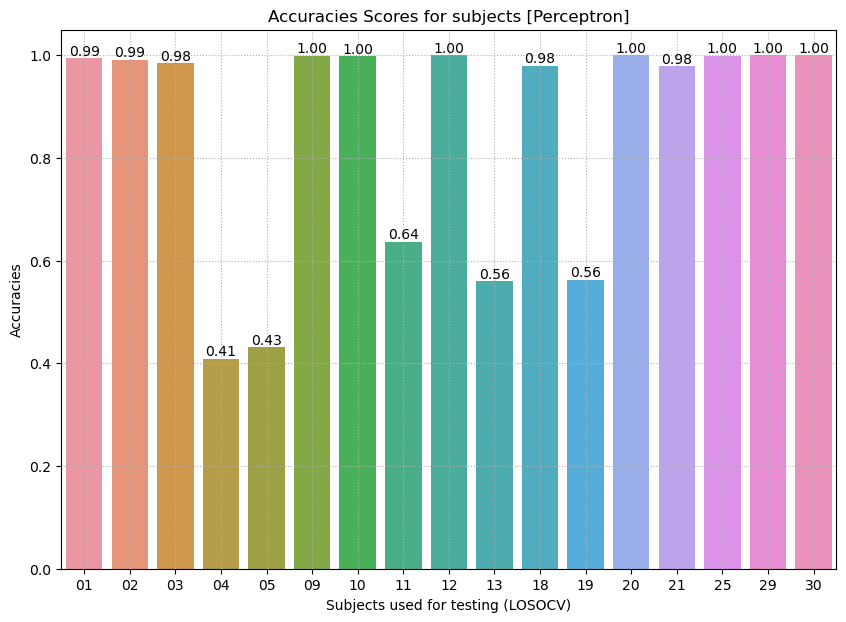

In [23]:
# Plotting individual metrics
plot_single_metric(classifier, results, 'accuracies')

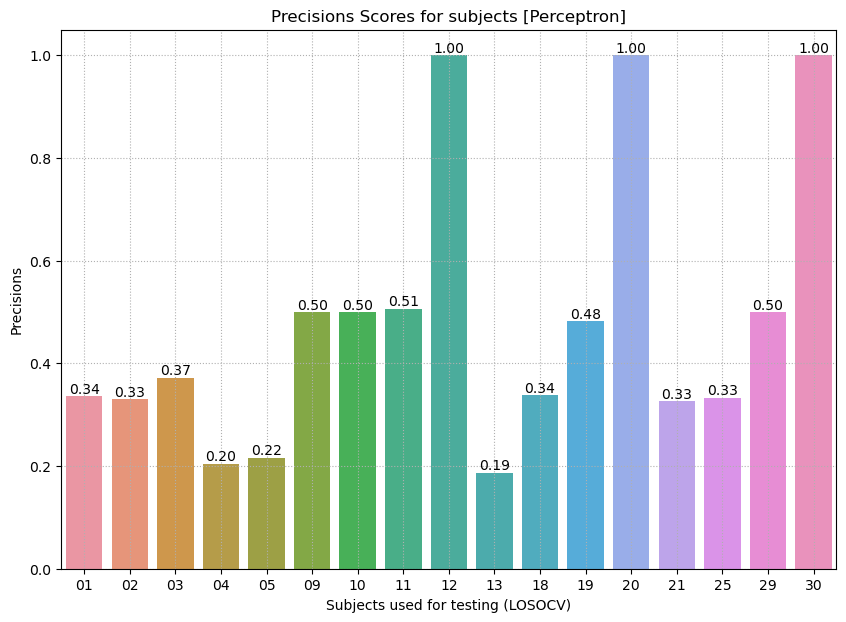

In [24]:
plot_single_metric(classifier, results, 'precisions')

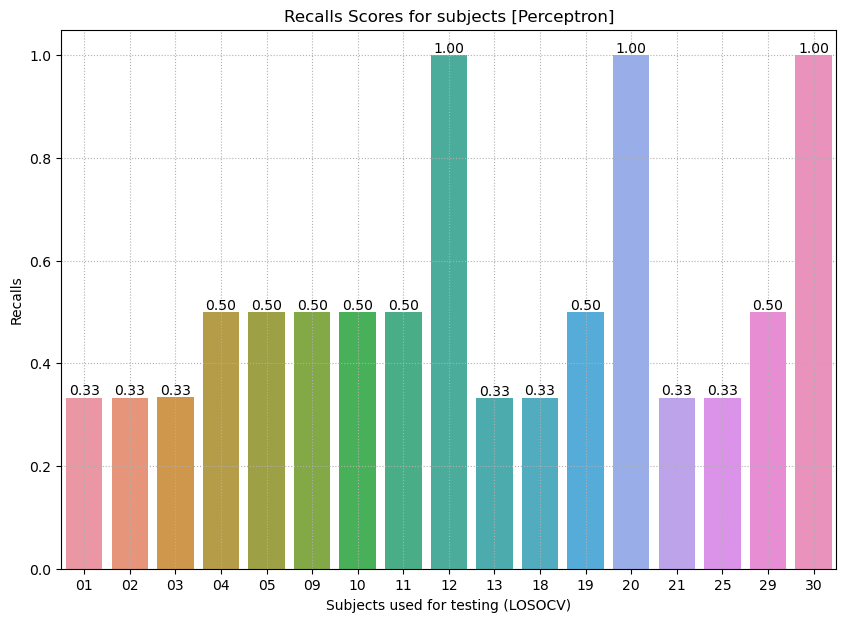

In [25]:
plot_single_metric(classifier, results, 'recalls')

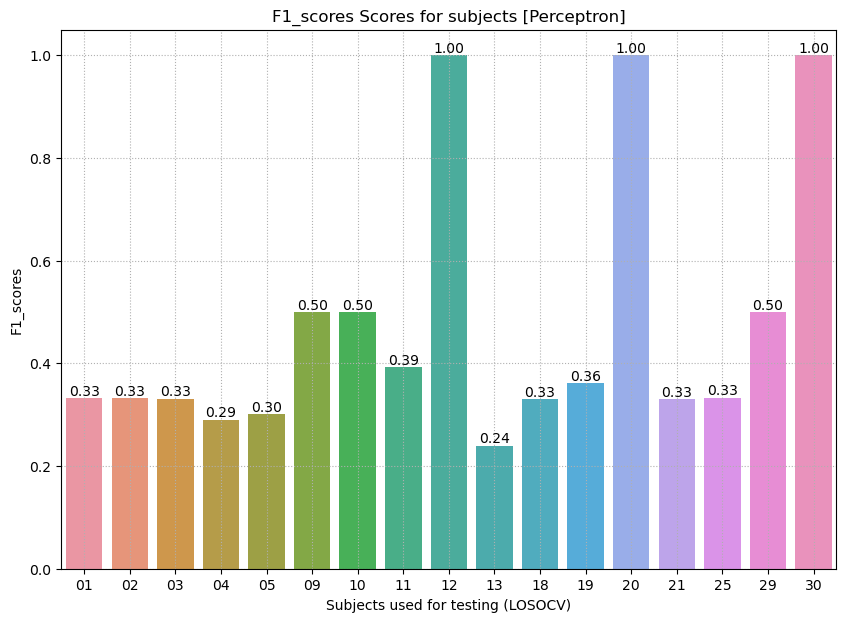

In [26]:
plot_single_metric(classifier, results, 'f1_scores')

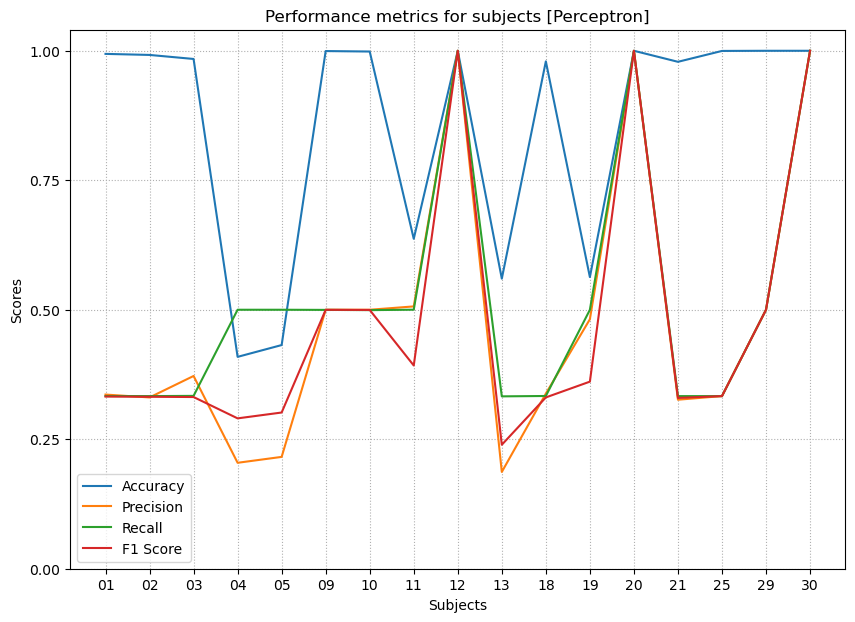

In [27]:
# Plotting all metrics in a single chart
plot_all_metrics(classifier, results, num_ticks=5)

## Inference on new subjects

In [28]:
def max_voting(predictions_list):
    # Convert the list of predictions into a numpy array for easier manipulation
    predictions_array = np.array(predictions_list)

    # Transpose the array to work with predictions of each sample across models
    transposed_array = np.transpose(predictions_array)

    # Create an empty list to store the final predictions
    final_predictions = []

    # Iterate through each sample's predictions
    for sample_predictions in transposed_array:
        # Calculate the mode (most frequent value) of predictions for each sample
        mode_prediction = np.argmax(np.bincount(sample_predictions.astype(int)))

        # Append the mode prediction to the final predictions list
        final_predictions.append(mode_prediction)

    return final_predictions

In [29]:
# Function to load model
def get_voting_ensemble(folder, model_names):
    
    models = []
    logger.info(f"Loading fitted models from {folder}. Fitted Models: {model_names}")
    for name in model_names:
        model = om.load_object(f"models/{folder}", f"{name}.pt")
        models.append(model)
        #models.append((f"{classifier}_{name}", model))
    
    #ensemble = VotingClassifier(estimators=models, voting='soft')
    
    return models #ensemble

# Function to run inference on subjects
def run_inference(ensemble, folder, filenames, features = [], normalize = True, sampling=False):
    metrics = {
    key: []
    for key in [
        Metrics.Accuracy.value,
        Metrics.Precision.value,
        Metrics.Recall.value,
        Metrics.F1.value,
        Metrics.Sample.value,
    ]
    }

    # Dictionary to store weighted avergae metrics
    weighted_avg_metrics = {}
    logger.info(f"Taking features: {features}")
    #Loop over csv files of each subject
    for file in filenames:
        #Load data
        x_test, y_test = dfm.load_data(file, data_folder, normalize, norm_method,features,sampling=False)
        
        y_preds = []
        
        # Evaluate the classifier on the current chunk
        for model in ensemble:
            y_pred = model.predict(x_test)
            y_preds.append(y_pred)
        
        # Get best predictions using max vote
        y_final = max_voting(y_preds)
        
        # Get evaluation metrics
        result = evaluate_metrics(y_test,y_pred)
        
        # Concat values
        metrics.update(result)
    
    
    # Calculate total number of samples
    total_samples = sum(metrics[Metrics.Sample.value])
    
    # Calculate the weighted average metrics
    
    for key, values in metrics.items():
        if key != Metrics.Sample.value:
            weighted_key_sum =  sum(val * count for val, count in zip(values, metrics[Metrics.Sample.value]))
            weighted_avg_metrics[key]= weighted_key_sum / total_samples
    
    logger.info("***"*20)
    logger.info(f"Inference Results:")
    for k, v in weighted_avg_metrics.items():
        logger.info(f"{k}:{v:.2f}")
            
    return weighted_avg_metrics

In [30]:
#folder = '2023-08-03_11-10-20'
ensemble = get_voting_ensemble(folder, subjects)

2023-08-22 19:34:55 - INFO - Loading fitted models from 2023-08-22_00-53-22. Fitted Models: ['01', '02', '03', '04', '05', '09', '10', '11', '12', '13', '18', '19', '20', '21', '25', '29', '30']


In [31]:
inference_subjects = ['07', '27', '15', '24', '22']

In [32]:
infer_result = []

for test_subject in inference_subjects:
    logger.info("###"*10)
    logger.info(f"Running ensemble on test subject:{test_subject}")
    filenames = grouped_csv_files[test_subject]
    output = run_inference(ensemble, "OCDetect_Export", filenames, features = features, normalize = True)
    infer_result.append({test_subject:output})
    logger.info(f"Completed ensemble on test subject: {test_subject}")

2023-08-22 19:34:55 - INFO - ##############################
2023-08-22 19:34:55 - INFO - Running ensemble on test subject:07
2023-08-22 19:34:55 - INFO - Taking features: ['acc x', 'acc y', 'acc z', 'gyro x', 'gyro y', 'gyro z']
2023-08-22 19:34:55 - INFO - Loading CSV File: OCDetect_07_recording_00_36b52ec7-be69-44fe-82d6-d7165abfdac1.csv from OCDetect_Export.
2023-08-22 19:34:55 - INFO - ---------------
2023-08-22 19:34:55 - INFO - Loading CSV File: OCDetect_07_recording_01_ba42ec72-01cd-4969-bcba-226869a3288e.csv from OCDetect_Export.
2023-08-22 19:34:55 - INFO - ---------------
2023-08-22 19:34:55 - INFO - Loading CSV File: OCDetect_07_recording_02_9c1649e7-f686-4d1b-9169-6ff4566b0726.csv from OCDetect_Export.
2023-08-22 19:34:55 - INFO - ---------------
2023-08-22 19:34:55 - INFO - Loading CSV File: OCDetect_07_recording_03_8e5a64aa-78f3-4992-a6db-a54918de201f.csv from OCDetect_Export.
2023-08-22 19:34:55 - INFO - ---------------
2023-08-22 19:34:55 - INFO - Loading CSV File: OCDe

2023-08-22 19:37:14 - INFO - ---------------
2023-08-22 19:37:14 - INFO - Loading CSV File: OCDetect_15_recording_01_e3acd37a-76ca-4b9f-9135-0eb06550c7a3.csv from OCDetect_Export.
2023-08-22 19:37:15 - INFO - ---------------
2023-08-22 19:37:15 - INFO - Loading CSV File: OCDetect_15_recording_02_2cdf6e74-4377-40a1-8ff0-b9ca3a73df38.csv from OCDetect_Export.
2023-08-22 19:37:17 - INFO - ---------------
2023-08-22 19:37:21 - INFO - Loading CSV File: OCDetect_15_recording_03_e39f364d-d3d1-4396-a652-8d856a70bda1.csv from OCDetect_Export.
2023-08-22 19:37:23 - INFO - ---------------
2023-08-22 19:37:23 - INFO - Loading CSV File: OCDetect_15_recording_04_578d2f52-6407-4e73-846c-a756b95dfbc5.csv from OCDetect_Export.
2023-08-22 19:37:26 - INFO - ---------------
2023-08-22 19:37:33 - INFO - Loading CSV File: OCDetect_15_recording_05_a299ad55-c197-4f5c-b123-6359a94011cc.csv from OCDetect_Export.
2023-08-22 19:37:34 - INFO - ---------------
2023-08-22 19:37:37 - INFO - Loading CSV File: OCDetect

2023-08-22 19:40:27 - INFO - ---------------
2023-08-22 19:40:29 - INFO - Loading CSV File: OCDetect_22_recording_12_13945066-ab22-44bb-96ad-1b22ea87c123.csv from OCDetect_Export.
2023-08-22 19:40:29 - INFO - ---------------
2023-08-22 19:40:30 - INFO - Loading CSV File: OCDetect_22_recording_13_fa540aff-6648-425b-ab1f-6f69efd1ebe1.csv from OCDetect_Export.
2023-08-22 19:40:30 - INFO - ---------------
2023-08-22 19:40:30 - INFO - Loading CSV File: OCDetect_22_recording_14_d54a2ec9-9184-4012-8d74-ad49c6a17ac8.csv from OCDetect_Export.
2023-08-22 19:40:30 - INFO - ---------------
2023-08-22 19:40:30 - INFO - Loading CSV File: OCDetect_22_recording_15_4304c4e7-a57a-4d9a-9457-461da5ea9223.csv from OCDetect_Export.
2023-08-22 19:40:30 - INFO - ---------------
2023-08-22 19:40:30 - INFO - Loading CSV File: OCDetect_22_recording_16_03bb83be-110f-4043-821d-42c85053ef8d.csv from OCDetect_Export.
2023-08-22 19:40:30 - INFO - ---------------
2023-08-22 19:40:31 - INFO - Loading CSV File: OCDetect

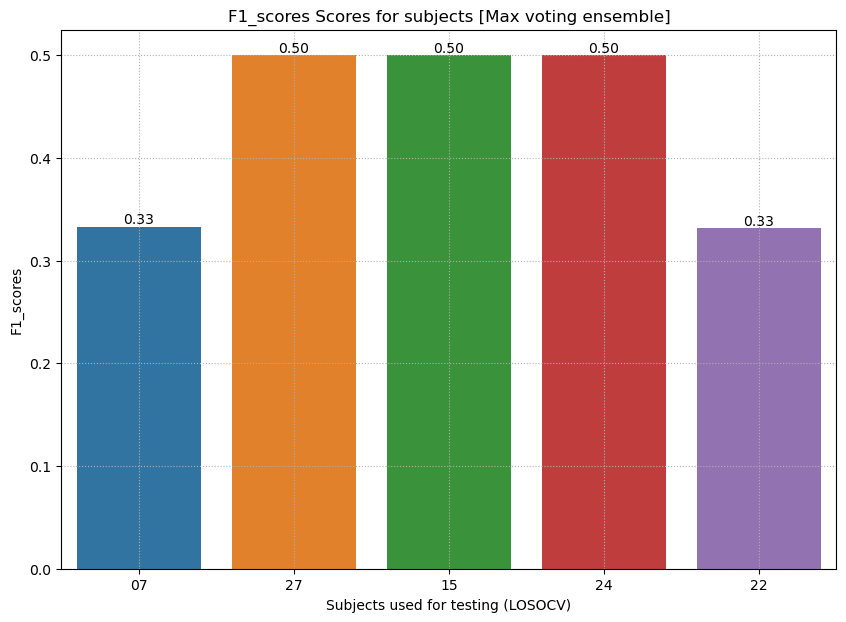

In [33]:
plot_single_metric("Max Voting Ensemble", infer_result, "f1_scores")

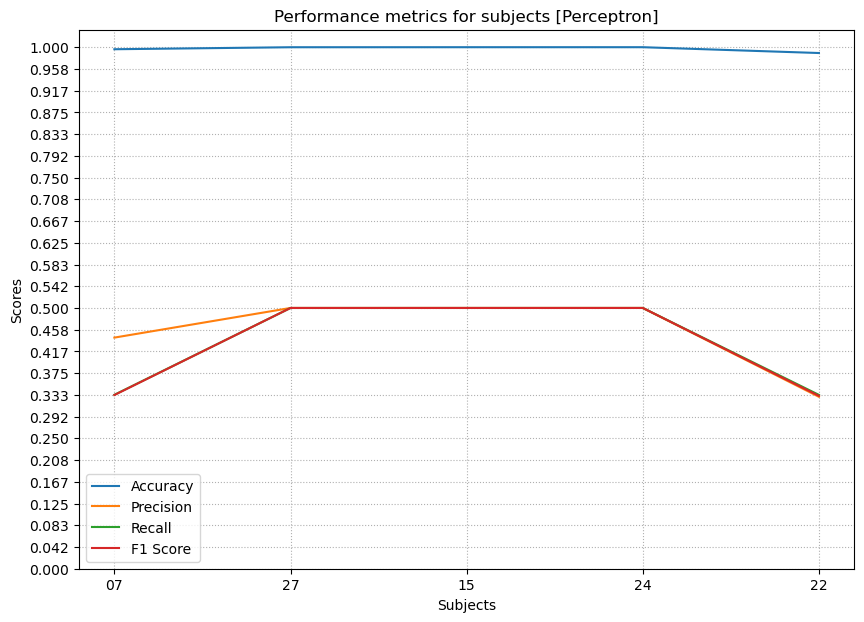

In [34]:
# Plotting all metrics in a single chart
plot_all_metrics(classifier, infer_result, num_ticks=25)

In [35]:
model_09 = om.load_object(f"models/{folder}", "0.9.pt")